![](https://i.imgur.com/sWyuy4Y.jpg)

In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [54]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [55]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [56]:
import os 
print(os.listdir("input"))

['Answers.csv', 'Answers.csv.zip', 'data_lstm.csv', 'Questions.csv', 'Questions.csv.zip', 'Tags.csv', 'Tags.csv.zip']


In [57]:
# Importing the database 

df = pd.read_csv("input\\Questions.csv\\Questions.csv", encoding="ISO-8859-1")

In [58]:
df.head(5)

Id  OwnerUserId          CreationDate            ClosedDate  Score  \
0   80         26.0  2008-08-01T13:57:07Z                   NaN     26   
1   90         58.0  2008-08-01T14:41:24Z  2012-12-26T03:45:49Z    144   
2  120         83.0  2008-08-01T15:50:08Z                   NaN     21   
3  180    2089740.0  2008-08-01T18:42:19Z                   NaN     53   
4  260         91.0  2008-08-01T23:22:08Z                   NaN     49   

                                               Title  \
0  SQLStatement.execute() - multiple queries in o...   
1  Good branching and merging tutorials for Torto...   
2                                  ASP.NET Site Maps   
3                 Function for creating color wheels   
4  Adding scripting functionality to .NET applica...   

                                                Body  
0  <p>I've written a database generation script i...  
1  <p>Are there any really good tutorials explain...  
2  <p>Has anyone got experience creating <strong>...  
3  <p>This is something I've pseudo-solved many t...  
4  <p>I have a little game written in C#. It uses...

In [59]:
tags = pd.read_csv("input\\Tags.csv\\Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [60]:
# tags.head(5)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [62]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [63]:
tags['Tag'] = tags['Tag'].astype(str)

In [64]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [65]:
# grouped_tags.head(5)

In [66]:
grouped_tags.reset_index()

Id                                                Tag
0              80                            flex actionscript-3 air
1              90       svn tortoisesvn branch branching-and-merging
2             120                                sql asp.net sitemap
3             180     algorithm language-agnostic colors color-space
4             260            c# .net scripting compiler-construction
5             330                         c++ oop class nested-class
6             470                                  .net web-services
7             580  sql-server sql-server-2005 deployment release-...
8             650                        c# visual-studio versioning
9             810        windows visual-studio registry installation
10            930                       c# database loops connection
11           1010                                         c# asp.net
12           1040                                    c# file-locking
13           1070                                          unix size
14           1160                      svn msbuild cruisecontrol.net
15           1180             web-applications dns subdomain account
16           1300                         .net .net-3.5 msbuild nant
17           1390                     sql-server windows-server-2008
18           1600                         sql-server sql-server-2008
19           1610                                         sql-server
20           1760                       c# .net unit-testing testing
21           1790                                svn version-control
22           1970  sql database postgresql stored-procedures trig...
23           2120                                     sql sql-server
24           2250                               c# dataset datatable
25           2300                               asp-classic vbscript
26           2530                                  html autocomplete
27           2540                     c architecture data-structures
28           2550                          asp.net flash video embed
29           2630                                 powershell cmdlets
...           ...                                                ...
1264186  40142590                        javascript jquery html date
1264187  40142600                                             python
1264188  40142610                                   audio soundcloud
1264189  40142700                  php jquery ajax binary x-sendfile
1264190  40142730                                angular2 typescript
1264191  40142750                                    amazon-dynamodb
1264192  40142760                      javascript google-apps-script
1264193  40142780                                                  c
1264194  40142790                                                c++
1264195  40142820       asp.net-mvc kendo-ui treelist kendo-treelist
1264196  40142840  python django amazon-web-services internal-ser...
1264197  40142860                                excel excel-formula
1264198  40142870                   c# asp.net-mvc remote-validation
1264199  40142880                              cmake cross-compiling
1264200  40142900                                 api oauth linkedin
1264201  40142910           ruby-on-rails validation ruby-on-rails-4
1264202  40142920                            linux ubuntu gcc gcc4.6
1264203  40142940                                                c++
1264204  40143010                                        jquery ajax
1264205  40143070  haskell types functional-programming agda lamb...
1264206  40143110         android android-activity android-lifecycle
1264207  40143140                                   spring-data-rest
1264208  40143150              javascript youtube youtube-iframe-api
1264209  40143170                       laravel binding model routes
1264210  40143190                              python bash multiline
1264211  40143210                                      php .htaccess
1264212  4014

In [67]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [68]:
# grouped_tags_final.head(5)

In [69]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [70]:
df = df.merge(grouped_tags_final, on='Id')

In [71]:
# df.head(5)

Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [72]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

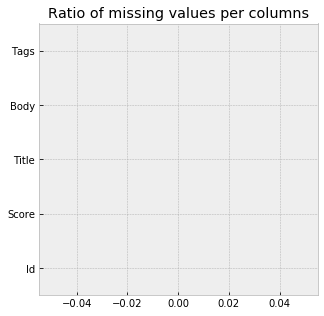

In [73]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [74]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [75]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [76]:
# new_df.head(5)

In [77]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [78]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [79]:
len(all_tags)

224129

In [80]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [81]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [82]:
# tags_features

In [83]:
# fig, ax = plt.subplots(figsize=(15, 10))
# keywords.plot(100, cumulative=False)

In [84]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [85]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [86]:
new_df.shape

(72950, 3)

In [87]:
new_df.dropna(subset=['Tags'], inplace=True)

In [88]:
new_df.shape

(63167, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [89]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [90]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [91]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [92]:
token=ToktokTokenizer()

In [93]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [94]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [95]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [96]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [97]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [98]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [99]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [101]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [102]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [103]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [104]:
no_topics = 20

In [105]:
text = new_df['Body']

In [106]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [107]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [108]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [109]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
# display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [128]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']


# save original data as raw
df_raw = new_df
X1_raw = X1
X2_raw = X2
y_raw = y

# check df_raw
df_raw.head(5)

Title  \
1     good branch merge tutorials tortoisesvn   
2                            asp.net site map   
3                 function create color wheel   
4  add script functionality .net applications   
5                         use nest class case   

                                                Body               Tags  \
1  really good tutorials explain branch merge apa...              [svn]   
2  anyone get experience create sql-based asp.net...     [sql, asp.net]   
3  something pseudo-solved many time never quite ...        [algorithm]   
4  little game write c use database back-end trad...         [c#, .net]   
5  work collection class use video playback recor...  [c++, oop, class]   

                                             Context         Tags_new  \
1  good branch merge tutorials tortoisesvnreally ...              svn   
2  asp.net site mapanyone get experience create s...     sql, asp.net   
3  function create color wheelsomething pseudo-so...        algorithm   
4  add script functionality .net applicationslitt...         c#, .net   
5  use nest class casework collection class use v...  c++, oop, class   

   Tag_array  
1          0  
2          0  
3          0  
4          1  
5          0

In [129]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)
print(y_bin.shape)

(63167, 100)


In [130]:
df_raw['Context'] = df_raw['Title'] + df_raw['Body']
df_raw['Tags_new'] = df_raw.Tags.apply(', '.join)  #from list to string in column 'tags'
# df_raw['Tags_n'] = y_bin[:,:]

print(len(df_raw))
df_raw.head(5)

63167


Title  \
1     good branch merge tutorials tortoisesvn   
2                            asp.net site map   
3                 function create color wheel   
4  add script functionality .net applications   
5                         use nest class case   

                                                Body               Tags  \
1  really good tutorials explain branch merge apa...              [svn]   
2  anyone get experience create sql-based asp.net...     [sql, asp.net]   
3  something pseudo-solved many time never quite ...        [algorithm]   
4  little game write c use database back-end trad...         [c#, .net]   
5  work collection class use video playback recor...  [c++, oop, class]   

                                             Context         Tags_new  \
1  good branch merge tutorials tortoisesvnreally ...              svn   
2  asp.net site mapanyone get experience create s...     sql, asp.net   
3  function create color wheelsomething pseudo-so...        algorithm   
4  add script functionality .net applicationslitt...         c#, .net   
5  use nest class casework collection class use v...  c++, oop, class   

   Tag_array  
1          0  
2          0  
3          0  
4          1  
5          0

In [132]:
df_raw2 = df_raw[['Context', 'Tags_new']]

# now save as a new dataset csv
df_raw2.to_csv(r'C:\Users\Guoya\Desktop\Predicting_Tags_StackOverflow\input\data_lstm.csv')

In [133]:
df_raw2.head(10)

Context                Tags_new
1   good branch merge tutorials tortoisesvnreally ...                     svn
2   asp.net site mapanyone get experience create s...            sql, asp.net
3   function create color wheelsomething pseudo-so...               algorithm
4   add script functionality .net applicationslitt...                c#, .net
5   use nest class casework collection class use v...         c++, oop, class
6   homegrown consumption web servicewrite web ser...                    .net
7   deploy sql server databases test livewonder gu...              sql-server
8   automatically update version numberwould like ...       c#, visual-studio
9   visual studio setup project - per user registr...  windows, visual-studio
10  connect database loop recordset c#simplest way...            c#, database

# LSTM

### torchtext embedding

In [148]:
# increase the upper limit of csv file
# import sys
# import csv
# csv.field_size_limit(sys.maxsize)
# csv.field_size_limit(2**16)
# csv.field_size_limit(maxInt)

import torch
import torchtext as tt
# import imp
# imp.reload(tt)


# indicate Field
TEXT = tt.data.Field(sequential=True, lower=True, tokenize='spacy')
# LABEL = tt.data.Field(sequential=False, tokenize='spacy')
LABEL = tt.data.LabelField(sequential=False, tokenize='spacy')
# LABEL = tt.data.LabelField(sequential=False, tokenize='spacy', dtype=torch.float)

# construct dataset
path_dataset_lstm = r'C:\Users\Guoya\Desktop\Predicting_Tags_StackOverflow\input\data_lstm.csv'
dataset_lstm = tt.data.TabularDataset(path=path_dataset_lstm, format="CSV",
                                      fields=[("", None), ("Context", TEXT), ("Tags_new", LABEL)], skip_header=True)

ds_lstm_train, ds_lstm_test = dataset_lstm.split(split_ratio=0.7)

# embedding
TEXT.build_vocab(ds_lstm_train, max_size=10000, vectors='glove.6B.100d')
LABEL.build_vocab(ds_lstm_train, max_size=1000, vectors='glove.6B.100d')
# LABEL.build_vocab(ds_lstm_train)

# construct iterator
batchsz = 32
device = torch.device('cuda:0')
# iter_train, iter_test = tt.data.BucketIterator.splits(
#     (ds_lstm_train, ds_lstm_test),
#     batch_size = batchsz,
#     device=device
# )

iter_train = tt.data.Iterator(
    dataset=ds_lstm_train,
    batch_size = batchsz,
    device=device
)

iter_test = tt.data.Iterator(
    dataset=ds_lstm_test,
    batch_size = batchsz,
    device=device
)

pretrained_embedding_text = TEXT.vocab.vectors
pretrained_embedding_label = LABEL.vocab.vectors
print('pretrained_embedding_TEXT:', pretrained_embedding_text.shape)
print('pretrained_embedding_LABEL:', pretrained_embedding_label.shape)

# print(ds_lstm_train.examples[15].TEXT)
# print(ds_lstm_train.examples[15].label)

# print(len(TEXT.vocab))
# print(LABEL.vocab.vectors[0])
# for i in range(len(LABEL.vocab.vectors)):
#     print('LABEL', LABEL.vocab.vectors[i])
# print('******************************************************')
# for i in range(len(TEXT.vocab.vectors)):
#     print('TEXT', TEXT.vocab.vectors[i])

pretrained_embedding_TEXT: torch.Size([10002, 100])
pretrained_embedding_LABEL: torch.Size([1000, 100])


In [147]:
print(dataset_lstm.examples[8].Context)
print(dataset_lstm.examples[8].Tags_new)

['visual', 'studio', 'setup', 'project', '-', 'per', 'user', 'registry', 'settingstry', 'maintain', 'setup', 'project', 'visual', 'studio', '2003', 'yes', 'legacy', 'application', 'problem', 'moment', 'need', 'write', 'registry', 'entries', 'hkcu', 'every', 'user', 'computer', 'need', 'hkcu', 'rather', 'hklm', 'default', 'user', 'settings', 'change', 'per', 'user', 'feel', 'possible', 'something', 'installer', 'something', 'application', 'happen', 'user', 'profile', 'create', 'install', 'mind', 'still', 'want', 'change', 'little', 'possible', 'application', 'question', 'possible', 'add', 'registry', 'entries', 'every', 'user', 'visual', 'studio', '2003', 'setup', 'project', 'moment', 'project', 'list', 'five', 'registry', 'root', 'key', 'hkeyclassesroot', 'hkeycurrentuser', 'hkeylocalmachine', 'hkeyusers', 'usermachine', 'hive', 'really', 'know', 'anything', 'users', 'root', 'key', 'see', 'usermachine', 'hive', 'anyone', 'enlighten', 'perhaps', 'could', 'solve', 'problem']
windows, vis

In [138]:
for i in range(len(LABEL.vocab.vectors)):
    print(i, 'LABEL', LABEL.vocab.vectors[i])
print('******************************************************')
for i in range(len(TEXT.vocab.vectors)):
    print(i, 'TEXT', TEXT.vocab.vectors[i])

0 LABEL tensor([ 0.1269, -0.2034,  0.6303, -0.7313,  0.7066,  0.0135,  0.4964, -0.6198,
         1.2237,  0.3543,  0.1059, -0.4114,  0.5170, -0.8487,  1.0888, -0.2211,
        -0.3122,  1.4456,  0.1892,  0.6227, -0.1011, -1.5489,  0.8419,  1.7070,
         0.1849,  0.8303,  0.1857,  0.1066, -0.4848,  0.3315,  0.1831,  0.9109,
        -0.0095, -0.0372,  1.4898,  0.6031, -1.1127,  0.1128,  0.9079, -0.0492,
         0.2367,  0.2083,  0.3014, -0.2453, -0.0933,  0.5016, -0.4880, -0.1532,
         0.7154,  0.6256, -0.1909,  0.4110,  1.2345, -0.2612, -0.4521, -0.7011,
        -0.4629, -0.0683,  0.0798,  0.3072, -0.2783, -0.2791, -0.4891,  0.7957,
         0.2798,  0.1166,  0.0082, -0.5736,  0.7787, -0.0309,  0.9620,  0.6883,
        -0.1479, -0.7616, -0.4342,  0.9230,  0.4432,  0.3214,  0.1738, -0.6240,
         0.7797, -0.3510, -0.4295,  1.6825, -0.2887,  0.4842,  0.8321,  0.1621,
         0.1453,  0.0998,  0.3045,  1.0014, -0.3264, -0.5137,  0.9279, -0.5725,
        -0.7860, -0.3336,  1.351

        0., 0., 0., 0.])
9 LABEL tensor([-1.1752e-01,  9.7272e-01, -2.9021e-01,  2.5914e-01, -4.2644e-01,
        -1.4736e-01,  6.2162e-01, -1.2626e-04, -1.5885e+00,  3.0567e-01,
         1.0951e+00, -8.7477e-01, -8.0877e-01,  3.7008e-01,  9.8138e-01,
        -8.7040e-01, -6.9067e-01, -1.0754e-01,  2.3355e-02,  3.2394e-01,
         1.0950e-01, -2.8412e-01,  1.1034e+00,  5.8392e-01,  2.8271e-01,
         7.4784e-01,  8.0530e-01,  1.0216e-01, -1.5370e-02,  1.2624e-01,
         2.2516e-01,  6.6591e-01, -5.9523e-01,  5.1642e-01,  3.9173e-01,
         6.7354e-01,  7.1769e-01,  5.9060e-01, -1.2889e-01,  5.2605e-01,
         1.9100e-01, -1.1437e-01, -3.9725e-01, -8.9456e-01,  8.1271e-02,
         6.3898e-01, -5.8567e-01,  2.3063e-01, -1.1845e-01, -4.9358e-01,
         1.7417e-01,  6.0707e-01,  1.9180e-01, -4.6645e-01, -1.1239e+00,
        -2.2339e+00, -9.5387e-01, -3.0962e-01,  1.5652e+00,  1.0899e+00,
        -3.6337e-01, -8.0285e-01, -6.3040e-01,  3.6323e-01,  6.9253e-01,
         3.2473e-0

        -0.1628, -0.8894,  0.1142,  0.6014])
18 LABEL tensor([-0.3609, -0.5975,  0.5235,  0.2344,  0.3229, -0.5134,  0.4237, -0.5790,
         0.6805,  0.3536,  0.6597, -0.0775,  0.0842, -0.7555,  0.5229,  0.0685,
        -0.3928,  1.1090,  0.7667,  0.6545, -0.0071, -1.1910,  0.8565,  1.1666,
         1.1307,  0.9571,  0.1755,  0.2592, -0.6803, -0.1571,  0.3787,  1.7457,
         0.1398,  0.3117,  1.1883,  0.9100, -0.9956, -0.2546,  0.6254, -0.6041,
         0.5139, -0.1973,  0.3690, -0.0774, -0.6047,  0.0814,  0.5492, -0.2851,
         0.8859,  0.2887,  0.1664,  0.3513,  0.2691, -0.2735, -0.3812, -0.5627,
        -0.7775, -0.2434,  0.8626, -0.2992, -0.1599,  0.5551, -0.3766,  0.3375,
         0.0084,  0.3258, -0.2169, -0.4835,  0.4285, -0.6070,  0.7929,  1.0375,
        -0.6710, -0.9116, -0.4302,  0.7993,  0.0236, -0.0459, -0.2122, -0.4890,
         0.4448, -1.3734,  0.2017,  0.5503, -1.0103, -0.0994,  0.4866, -0.0043,
        -0.4854,  0.1720,  0.2872,  1.1088,  0.4544, -0.8195,  0.4

        -2.5714e-01, -2.7955e-01,  2.7718e-01,  6.5645e-01,  3.2817e-01])
29 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
30 LABEL tensor([-0.0211,  0.0715, -0.5247, -0.0297,  0.4417, -0.2438, -0.1100, -0.0900,
         0.2399, -0.0699, -0.4266, -0.2669, -0.2463,  0.1256, -0.3298,  0.2939,
        -0.1474,  0.1335,  0.7199,  0.2804, -0.5807, -0.2440,  0.2277,  0.2592,
         0.0999,  0.3002, -0.1461,  0.1042, -0.5358, -0.0469, -0.2719, -0.0867,
        -0.2456,  0.1199,  0.3031,  0.0565, -0.2338, -0.0875,  0.1695, -0.1098,
         0.2511,  0.3743,  0.3837,  0.4749, -0.5511,  0.0724,  0.09

        0., 0., 0., 0.])
40 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
41 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
42 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

        -3.7538e-01,  6.1969e-01,  1.0177e+00,  7.0806e-01,  5.3474e-01])
54 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
55 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
56 LABEL tensor([-0.4431, 

         0.1824,  0.8224, -0.1964,  0.2053])
68 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
69 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
70 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

        0., 0., 0., 0.])
83 LABEL tensor([-4.6058e-01,  8.3374e-01, -7.0587e-03, -4.8423e-01,  8.5108e-01,
         7.1899e-01, -1.1120e+00,  2.6998e-01,  9.4647e-01,  8.7601e-01,
         8.2016e-01, -1.1275e+00, -1.1896e+00, -1.6921e-01,  6.9217e-02,
         8.8088e-01,  8.2236e-01,  3.4231e-01,  4.7423e-01,  2.0349e-01,
        -1.5688e+00, -6.2840e-01,  3.9343e-01,  1.1683e+00,  6.4540e-01,
        -1.5299e+00,  9.6198e-01, -2.4829e-01, -7.0792e-01,  5.0698e-01,
        -3.5757e-03,  4.9432e-01, -4.4694e-01, -4.6370e-01,  1.2087e+00,
         3.3802e-01,  6.5902e-01,  1.3224e-01,  6.8365e-01, -8.4612e-01,
        -6.3521e-01, -5.2206e-01,  6.9477e-03,  8.6727e-01, -6.4483e-01,
         3.8409e-02,  4.1036e-01,  2.2292e-01, -3.0436e-02, -3.9820e-02,
         5.0412e-01,  4.1815e-01,  8.2443e-01,  5.3199e-01,  1.0206e-01,
         5.3421e-01, -5.9339e-01,  2.6660e-03,  6.3835e-01, -3.7252e-04,
         1.9106e-01, -6.5747e-01, -9.8058e-01, -4.0359e-01,  6.3249e-01,
        -8.9375e-

        0., 0., 0., 0.])
93 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
94 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
95 LABEL tensor([-0.1909, -0.3702, -0.2190,  0.0139, -0.0105, -0.1768, -0.3

         0.5216,  0.6654, -0.0325,  0.1772])
107 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
108 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
109 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.0863,  0.2268,  0.4390,  0.1612])
121 LABEL tensor([ 0.2456,  0.3070,  0.4926,  0.0245, -0.1704, -0.3585, -0.0461,  0.3758,
        -1.0544,  0.4518,  0.1146, -0.6516, -0.1169, -0.5079, -0.1862,  0.5597,
         0.1561,  0.3557,  0.6831,  0.9766, -0.0214, -1.1086,  0.0457,  0.2504,
        -0.0173, -0.5212, -0.2767,  0.1743, -0.0484, -0.0418, -0.3447,  0.4596,
        -0.1134,  0.3714,  0.2177,  0.2011,  0.0888,  0.7857, -0.8065, -0.4741,
         0.3078, -0.4036, -0.0963,  0.7883,  0.3736, -0.0938,  0.1417, -1.0671,
         0.1122, -1.4766, -0.1254, -0.1060,  0.0914,  0.9572,  0.2676, -2.5717,
         0.0651,  0.3199,  1.2336,  0.2246, -0.4498,  0.2951, -0.5738,  0.4922,
        -0.1141, -0.3232,  0.5427, -0.2097,  0.4340,  0.2696, -0.0265,  0.2661,
        -0.1665,  0.2252,  0.3559,  0.0656, -0.0350, -0.1510,  0.3403, -0.7396,
         0.3950,  0.3719, -0.1608, -0.2049, -2.1718, -0.1786, -0.1341, -0.4388,
        -0.5939, -0.2934, -0.3220, -0.2998, -0.0925,  0.7615,  0.

         0.2612, -0.7536,  0.0440,  0.2104])
135 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
136 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
137 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3427,  0.1064,  0.4086,  0.5491])
150 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
151 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
152 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
165 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
166 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
167 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
181 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
182 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
183 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
197 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
198 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
199 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         2.5247e-01,  2.2062e-01,  3.8070e-01, -2.7847e-01,  1.1063e-01])
216 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
217 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
218 LABEL tensor([0., 0.

234 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
235 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
236 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

        -0.5094,  0.4046,  0.2751, -0.5502])
251 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
252 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
253 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.1457, -0.3039,  0.6585,  0.0477])
268 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
269 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
270 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
287 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
288 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
289 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
303 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
304 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
305 LABEL tensor([-0.3638,  0.2882, -0.5233, -0.4761,  0.2875, -0.0292, -

        0., 0., 0., 0.])
320 LABEL tensor([-6.1104e-01, -4.7861e-01,  4.6234e-01, -5.8098e-02,  3.5714e-01,
        -7.4596e-02,  6.9281e-01, -3.9926e-01,  7.5479e-01,  4.4398e-01,
         3.4338e-01, -4.3246e-01,  7.0191e-02, -8.6011e-01,  2.3844e-01,
        -2.8153e-02, -5.6473e-01,  1.1724e+00,  6.9807e-01,  5.8976e-01,
         1.2442e-01, -1.2911e+00,  8.9142e-01,  1.0527e+00,  9.8682e-01,
         9.2627e-01,  2.9873e-01,  3.0862e-01, -7.4524e-01,  1.2628e-01,
        -2.3706e-01,  1.6102e+00,  4.7798e-03,  1.9434e-01,  1.0604e+00,
         7.8258e-01, -8.9174e-01,  1.6738e-01,  4.7110e-01, -7.6120e-01,
         3.0506e-01, -1.8910e-01,  6.6989e-02, -5.2704e-01, -4.1588e-01,
         2.2908e-01,  5.0584e-01, -4.6857e-01,  7.7799e-01,  6.3018e-01,
         3.6416e-01,  2.5758e-01,  3.0741e-01, -1.3649e-01, -7.5056e-01,
        -4.1256e-01, -3.2920e-01, -4.9191e-01,  4.0316e-01, -5.6319e-01,
         1.5338e-01,  6.2828e-01, -4.3093e-01,  4.9648e-01, -3.8445e-01,
         8.8047e

        0., 0., 0., 0.])
336 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
337 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
338 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
355 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
356 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
357 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
374 LABEL tensor([-0.3968,  0.1336, -0.0744, -0.2492,  0.9238,  0.6290, -0.1981, -0.0119,
         0.1560,  0.5803,  0.4374, -0.4950,  0.0268, -0.0811,  0.5183,  0.4130,
         0.2767,  0.5501,  0.0942, -0.1144, -0.7105, -0.2148, -0.0408,  0.2958,
         0.1843, -0.6823,  0.1959,  0.4365, -0.7843, -0.5019,  0.1604,  0.5655,
        -0.6609, -0.1016,  0.5837,  0.4083, -0.1466, -0.5289,  0.0034, -0.3936,
        -0.0876, -0.0211, -0.4991, -0.0417, -0.4965,  0.0983, -0.3952, -0.0704,
        -0.4565,  0.0764, -0.1408, -0.0557, -0.4215,  0.0933,  0.0642,  0.7349,
         0.0346, -0.1727,  0.2646, -0.0021, -0.4681,  0.5008,  0.0383,  0.6963,
         0.1441, -0.1890,  0.1502, -0.0703,  0.1317, -1.1143, -0.3341,  0.1411,
         0.3026, -0.3522,  0.4687,  0.0512,  0.4189,  0.2738, -0.4033, -0.4043,
        -0.2368, -0.4642, -0.4126, -0.3852, -0.2786,  0.9081,  0.1711, -0.2197,
        -0.7648,  0.2503, -0.5793,  0.6592,  0.5396, -0.4302,  0.9739, -0.7497,
     

        0., 0., 0., 0.])
391 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
392 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
393 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
410 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
411 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
412 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
429 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
430 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
431 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
446 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
447 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
448 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
465 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
466 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
467 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
484 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
485 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
486 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
503 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
504 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
505 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
522 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
523 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
524 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
541 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
542 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
543 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
558 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
559 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
560 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
577 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
578 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
579 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
596 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
597 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
598 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
615 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
616 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
617 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
634 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
635 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
636 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
653 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
654 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
655 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.1781, -0.9365,  0.5657,  0.2336])
671 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
672 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
673 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
690 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
691 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
692 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
709 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
710 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
711 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
728 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
729 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
730 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
747 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
748 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
749 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
766 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
767 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
768 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.2067,  0.0206, -0.3854, -0.0361])
784 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
785 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
786 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
803 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
804 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
805 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
822 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
823 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
824 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
841 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
842 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
843 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
860 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
861 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
862 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
879 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
880 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
881 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
898 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
899 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
900 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
917 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
918 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
919 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
934 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
935 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
936 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
953 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
954 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
955 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
972 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
973 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
974 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
991 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
992 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
993 LABEL tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.0809, -0.7029,  0.4778, -0.3332])
6 TEXT tensor([-3.2219e-01,  6.4632e-01,  2.7312e-02,  3.6579e-01, -2.6966e-03,
         1.7245e-01,  1.1092e+00,  3.5450e-01, -3.2880e-02, -3.4787e-01,
         1.0797e+00, -2.0107e-01, -6.7811e-01,  4.9211e-01,  5.7646e-01,
        -3.3956e-01,  8.4992e-01,  1.3798e-01, -2.4002e-01,  6.9785e-01,
         5.2505e-01, -1.2352e-01,  4.4680e-01,  1.0018e+00,  4.1520e-01,
         3.4613e-01,  7.1314e-01,  1.0015e-01,  3.3717e-01, -2.4967e-01,
        -2.4961e-01,  8.5110e-01, -3.8842e-02, -2.0761e-01, -6.6961e-01,
         2.6736e-01, -7.1073e-03,  9.6438e-01, -9.2126e-02,  1.1468e-03,
         8.0952e-01, -1.5740e+00,  2.7909e-01, -6.8659e-01,  5.7055e-01,
        -5.3396e-01, -3.2982e-01, -3.2648e-01, -2.4373e-02, -5.5105e-01,
        -1.1989e-01, -5.2269e-01, -3.8958e-01,  1.5032e+00, -1.1357e+00,
        -2.7247e+00, -3.2485e-01, -6.6962e-01,  1.6993e+00,  4.3917e-01,
        -3.4609e-01,  6.3696e-04, -1.0189e+00, -1.0181e-01,  9.4105e-01,

         6.9544e-02, -4.5397e-01, -1.4168e-01,  9.2789e-01,  5.9058e-01])
13 TEXT tensor([-1.1619e-01,  4.5447e-01, -6.9216e-01,  3.4580e-02,  2.6348e-01,
        -3.8139e-01, -2.2790e-01,  3.7233e-01, -2.0579e-01,  2.9020e-01,
         1.2114e-01, -4.2729e-01,  5.5573e-01, -9.4286e-02, -4.9967e-01,
        -2.9478e-01,  7.4109e-01,  2.5191e-01, -2.7468e-01,  2.3191e-01,
         3.8204e-03,  4.5252e-02,  2.4970e-01, -4.1579e-01,  3.1307e-01,
        -5.8496e-01, -3.2739e-01, -6.6189e-01,  1.4909e-01, -2.5771e-01,
        -9.4858e-01,  4.1809e-01, -2.9538e-01, -4.2711e-02, -6.9970e-01,
         5.7892e-01, -6.9271e-02, -3.9633e-02, -5.6463e-03, -2.9616e-01,
        -5.7448e-01,  1.6010e-01, -1.0671e-01,  1.0096e-01, -4.2956e-01,
        -2.7785e-01, -3.0017e-01, -6.9537e-01,  1.7965e-01, -4.6723e-01,
         1.2511e-01, -2.9022e-02, -1.5974e-01,  1.4217e+00, -2.6224e-01,
        -2.3719e+00, -1.1917e-01, -5.8262e-01,  1.5548e+00,  4.2212e-01,
         8.4633e-02,  1.1385e+00, -3.1226e

        -2.5543e-01, -8.9365e-01, -4.6822e-01,  1.9834e-01, -4.8772e-02])
20 TEXT tensor([-0.3333, -0.1481, -0.0279, -0.1579, -0.2417,  0.3407, -0.4153, -0.2159,
         0.0222, -0.0161,  0.1528,  0.1211, -0.4812, -0.1416, -0.2601,  0.1048,
         0.0547,  0.2080, -1.2297,  0.2465,  0.3610, -0.1476,  0.4345, -0.6468,
        -0.1643,  0.1190, -0.7499, -0.6552,  0.5172, -0.3246, -0.5643,  0.3739,
        -0.3931, -0.0497,  0.3692, -0.0408, -0.1142,  0.0271,  0.2651, -0.2722,
        -0.4907,  0.0050, -0.2827, -1.1199, -0.6670,  0.4624, -0.2918, -0.5752,
        -0.1129, -1.0879, -0.0950,  0.1806, -0.4056,  1.3758,  0.0729, -2.4110,
        -0.3539, -0.0218,  1.2336, -0.0997, -0.6073,  0.3686, -0.2038, -0.0286,
         0.9140,  0.1378, -0.0806,  0.6934, -0.8258, -0.6878,  0.1509, -0.4749,
        -0.4879, -0.7208, -0.2622, -0.1193, -0.6724,  0.0030,  0.1673,  0.3708,
         0.5828,  0.0996, -0.2988, -0.3373, -1.4555, -0.1302,  0.4035,  1.1058,
        -0.4385,  0.0869, -0.4032,  0.

         0.2592, -0.5961,  0.2760,  0.0880])
29 TEXT tensor([-1.7124e-01,  5.6447e-01,  3.4667e-01, -5.6711e-01, -6.5675e-01,
         1.2081e-01, -7.6863e-01,  7.2832e-02,  4.2237e-01, -1.0464e-01,
        -9.5098e-02,  3.5531e-01,  3.7523e-01, -1.0315e-01, -3.6373e-01,
        -3.4235e-01,  1.5421e-01,  4.2595e-01, -9.3621e-01,  7.6463e-01,
         2.2936e-01,  3.9153e-01,  4.8629e-02, -6.3902e-01, -2.7606e-01,
         1.4309e-01, -1.4570e-01, -9.2603e-01,  7.3662e-01, -4.7586e-01,
         1.6671e-01,  8.7328e-01,  4.3905e-02, -2.1803e-03,  6.0981e-01,
         1.8376e-01,  1.7213e-01,  2.4313e-01,  3.1518e-01, -4.9676e-01,
        -3.4410e-01, -1.8998e-01,  1.4180e-01, -1.0103e+00, -6.8090e-01,
        -1.6667e-01, -3.8716e-02, -2.2747e-01, -2.0992e-01, -1.2806e+00,
        -1.3947e-02,  2.5616e-02, -4.3727e-01,  8.0019e-01, -5.1486e-02,
        -2.2276e+00,  2.3601e-01,  1.5772e-01,  1.5965e+00,  1.4865e-01,
        -8.2737e-02,  7.0406e-01, -8.3248e-01, -4.6889e-01,  1.2773e+00

        -0.7374, -0.6745,  0.4133, -0.4813])
36 TEXT tensor([-0.0833,  0.2392,  0.0788, -0.7250,  0.5295,  0.3875,  0.0230,  0.4968,
        -0.4881, -0.0962,  0.4491,  0.4384,  0.5336,  0.0951, -0.1397, -0.1121,
         0.2990,  0.2634, -0.6690,  0.2298,  0.8988,  0.3464,  0.2562,  0.2159,
         0.2142, -0.2417, -0.8697,  0.0210,  0.1006,  0.3516, -0.3163,  0.5443,
         0.2326,  0.1419, -0.0133,  0.5218, -0.5955,  0.2262, -0.2431,  0.4883,
         0.4624,  0.0625, -0.7085, -0.1903, -0.0099, -0.2984,  0.7196, -1.0293,
         0.1081, -0.5824, -0.7486,  0.2608,  0.3631,  0.8934,  0.1291, -2.7729,
        -0.2437,  0.7855,  2.0139,  0.7794, -0.6824, -0.4860,  0.2369,  0.3204,
         1.0055,  0.4407,  0.6229, -0.1239, -0.2892,  0.4229, -0.0996,  0.1810,
        -0.4309, -0.8426,  0.1310,  0.0420, -0.6490, -0.0751, -0.4454,  0.0950,
         0.5949,  0.4491, -0.6273,  0.2849, -1.0432,  0.1613,  0.2562,  0.4214,
         0.0722, -0.3106, -0.0387,  0.0084, -0.3003, -0.1782, -0.81

         2.1038e-02, -3.0060e-01, -3.3461e-01,  4.4349e-02,  5.7541e-01])
44 TEXT tensor([-2.4221e-02, -3.4855e-02,  3.5710e-01, -2.1550e-02, -5.4804e-01,
         3.1822e-01,  1.2929e-02,  3.5174e-01, -4.1690e-01, -2.9411e-01,
         6.3723e-01, -1.4859e-01, -1.5264e-02, -3.5811e-01,  1.2395e-01,
        -6.7468e-01,  2.8165e-01, -6.5410e-03, -4.1743e-01,  5.6387e-03,
         2.6789e-01,  1.8282e-01,  7.7023e-02,  2.3808e-01,  5.0500e-01,
        -2.4993e-01, -2.9143e-02, -5.0666e-01,  4.2215e-01, -9.7988e-02,
        -4.5997e-01,  3.7969e-01, -1.2402e-01, -1.9568e-01, -1.2479e-01,
         2.4071e-01, -5.1656e-01,  4.4866e-01, -4.0484e-02, -4.1001e-01,
        -5.5576e-01, -2.6892e-01,  1.9317e-01,  8.9754e-02, -2.7962e-01,
        -1.5670e-01,  3.9276e-01, -9.7373e-01,  4.4148e-01, -9.7508e-01,
         2.8868e-03, -2.9774e-01,  3.3367e-01,  1.5798e+00, -4.7833e-02,
        -2.9699e+00, -4.1627e-01,  3.4471e-02,  1.6993e+00,  8.3470e-01,
        -2.8926e-01,  8.5307e-01, -2.3608e

        -0.1356, -0.5792,  0.4129, -0.7166])
51 TEXT tensor([ 0.4505, -0.2911,  0.3590, -0.3688, -0.1434,  0.2109, -0.4044,  0.0782,
         0.6646,  0.0879, -0.2300, -0.0578,  0.3153, -0.6309,  0.1943, -0.7420,
         0.6022,  1.1905,  0.2604,  0.0768, -0.1464,  0.1970,  0.0020, -0.3231,
         0.9823, -0.3406,  0.5247,  0.1816,  0.2685, -0.2402,  0.7035, -0.2537,
        -0.1745, -0.6449, -0.6995, -0.0026,  0.3135,  0.1053, -0.5300, -0.3826,
        -0.0086,  0.1281,  0.2083, -0.6182, -0.0098, -0.1367, -0.2286,  0.8852,
        -0.6645,  0.3807,  0.1982, -0.0134,  0.3776,  0.7803,  0.1591, -1.2115,
         0.4967, -0.2784,  0.9757,  0.4913, -0.3393, -0.2491, -0.3923, -0.1578,
         0.7313, -0.2766,  0.7597, -0.4852, -0.8509, -0.7892,  0.3869, -0.1366,
        -0.0159, -0.0016,  0.2515,  0.1334, -0.1742,  0.0670, -0.0807,  0.3812,
        -0.4348, -0.2966,  0.0329,  0.0493, -0.5372, -0.3469,  0.6379, -0.1478,
        -0.1317, -0.4336, -0.5638,  0.1912, -0.4829,  0.7120,  0.67

         0.1457, -0.3039,  0.6585,  0.0477])
58 TEXT tensor([-0.1262,  0.6172,  0.2258,  0.3987,  0.1611,  0.1523, -0.1471, -0.2945,
        -0.2735, -0.1375, -0.2090, -0.7344,  0.1414,  0.1505,  0.0918,  0.0186,
         0.2254,  0.1598, -0.1693,  0.4272,  0.0423, -0.3477, -0.1141,  0.1222,
        -0.0250, -0.2080, -0.0673, -0.2956, -0.3081, -0.3290,  0.1906,  0.7714,
        -0.1933, -0.3107,  0.2675,  0.3223,  0.2065,  0.1050,  0.4942, -0.3832,
        -0.1280, -0.0699, -0.1483,  0.0854, -0.1814,  0.1469,  0.6097, -0.2113,
        -0.2915, -0.5277,  0.5951,  0.0174,  0.1534,  0.8192, -0.2064, -2.0378,
        -0.1188, -0.1683,  1.5288,  0.1576, -0.4994,  0.3930,  0.1267, -0.1097,
         1.3671, -0.2101,  0.1568,  0.0064,  0.4384, -0.1876, -0.2909,  0.1862,
         0.0854,  0.1399,  0.4079, -0.1481,  0.2670, -0.1914, -0.6189,  0.0091,
         0.3497, -0.2408, -0.5248, -0.2507, -1.5681,  0.2210,  0.0468, -0.6262,
        -0.0434, -0.4286, -0.0058, -0.2261,  0.0742,  0.0916, -0.40

        -5.3142e-01, -3.6542e-01, -2.3929e-01, -1.6464e-02,  6.8200e-01])
66 TEXT tensor([-0.8028,  0.8250,  1.3844, -0.9616,  0.2254, -0.4348,  0.2530, -0.5236,
         0.2971, -0.0506,  0.1638, -0.4544,  0.3626,  0.2230,  0.3763, -0.5319,
        -0.0291,  0.4642, -0.5286,  0.1935,  0.8662,  0.9178,  0.3805,  0.7841,
         0.3984,  0.1749, -0.9661, -0.9013, -0.1527, -0.5995,  0.7019, -0.1805,
        -0.3948, -0.2389,  0.0319, -0.0933,  0.6410,  0.7903, -0.7418, -0.2871,
         0.0695, -0.3711,  0.2521, -0.3146, -0.3681, -0.0047, -0.4559, -0.6999,
         0.5577, -0.5440, -0.4708, -0.5593,  0.2780,  1.6203, -1.2591, -2.3143,
         0.0667,  0.0913,  1.5506,  0.0349, -0.5734,  0.8203,  0.7456, -1.0320,
         0.2456,  0.0899,  0.3529,  0.2577, -0.1680,  0.0872, -0.0389, -0.2063,
        -0.8773, -0.3230, -0.3081, -0.0748,  0.5029, -0.5205, -0.8123, -0.3095,
         1.5353, -0.4889,  0.2946, -0.7429, -1.9640, -0.0813, -0.0747,  0.4639,
         0.1714, -0.0093,  0.1878, -0.

         0.0172,  0.2782, -0.6846,  0.5367])
74 TEXT tensor([ 0.0868,  0.3431,  0.0153, -0.2118,  0.0167,  0.1642,  0.6655,  0.5701,
        -0.4802, -0.0865,  1.2200, -0.0112, -0.3564,  0.2868,  0.6709, -0.3375,
         0.0351,  0.0709, -0.8368,  0.7671,  0.7103,  0.0933,  0.2735,  0.6521,
         0.4624, -0.2704,  0.3276, -0.1218,  0.2235,  0.2355,  0.0413,  0.4001,
         0.1611, -0.5268, -0.2994,  0.2447,  0.1324,  0.1795, -0.4892,  0.5063,
        -0.0545, -0.7593,  0.5253, -0.4274,  0.2285, -0.6070, -0.4006, -0.8866,
        -0.1912, -0.3973, -0.4145, -0.7535, -0.4308,  1.1405, -0.7077, -2.3559,
        -0.1687, -0.5205,  2.0306,  0.9136, -0.3968,  0.8167, -0.6615,  0.1548,
         0.2241,  0.4576, -0.2186,  0.3514,  0.5454,  0.3539, -0.1938, -0.0766,
        -0.0384,  0.3617,  0.1323,  0.1375,  0.0850, -0.1048, -0.8516, -0.2009,
         0.9262, -0.1838, -0.5367,  0.0809, -0.6886, -0.4022,  0.3160, -0.0878,
         0.1642,  0.3607, -0.0308,  0.5690, -0.1688, -0.3409, -1.37

        -0.1566,  0.2179,  1.4143,  0.4003])
82 TEXT tensor([-0.9294,  0.1093, -0.0212, -1.0784,  0.7144,  1.0149,  0.1443, -0.1613,
         0.2105, -0.3776,  0.8417, -0.1447, -0.2954, -0.3359,  0.1453,  0.5234,
         0.5676, -0.8291, -0.3325, -0.3006, -0.1776,  0.1055, -0.3534,  0.3956,
         0.7878, -0.5824,  0.3782,  0.3784,  0.1893,  0.0210,  0.5224,  0.9097,
         0.3986, -0.2308, -0.0340,  0.4903, -0.4285, -0.3499, -0.0457,  0.1909,
        -0.0422, -0.1823, -0.1525, -0.0053, -0.4846,  0.5051, -0.5557, -0.7473,
         0.1074, -0.1965,  1.0469, -0.0685, -0.0420,  0.5974, -0.1590, -2.1124,
        -0.1104,  0.1104,  1.4707, -0.1867, -0.3985,  0.6484, -0.1672, -0.5092,
         0.8483, -0.0167,  0.2343,  0.5375, -0.2625,  0.1206,  0.1656,  0.7861,
        -0.1295, -0.3634,  0.0866,  0.5738,  0.4318,  0.1954, -0.8014, -0.4252,
        -0.4161, -0.2439,  0.1540, -0.6823, -0.4133, -0.3649,  0.3358, -1.1530,
        -0.0559,  0.2376, -0.1138,  0.8212,  0.5781,  0.0484,  0.10

        -0.0305, -0.3790,  0.3302, -0.2746])
90 TEXT tensor([ 1.0735e-01, -1.3863e-01,  5.7066e-02, -6.1203e-01, -9.6671e-02,
        -2.6425e-01,  6.2813e-02,  9.5611e-01, -2.6705e-01, -4.2122e-01,
        -2.5975e-01, -3.3355e-01,  2.8623e-01, -2.0724e-01,  1.6318e-01,
         3.1586e-01,  6.1206e-01,  2.8672e-01, -1.0276e-01,  6.4146e-01,
         3.8259e-01, -7.1012e-01, -3.7712e-02, -4.9555e-01,  7.1959e-01,
        -2.8056e-01,  6.7913e-01, -7.6652e-02,  4.2956e-01, -1.7922e-01,
        -8.5417e-02,  4.3329e-01,  2.2443e-01,  8.0722e-01,  7.1308e-02,
         6.3508e-01,  1.8468e-01, -2.1150e-01, -5.8941e-01, -2.9348e-01,
        -5.3272e-02, -1.2164e-04, -6.7823e-01,  7.6149e-01, -4.5133e-01,
        -4.0854e-01, -3.1185e-01, -6.9396e-01,  2.5989e-01, -1.1493e+00,
        -4.6673e-01, -2.2150e-01,  5.7337e-01,  8.6139e-01, -2.6505e-02,
        -2.8989e+00, -4.6397e-01,  2.7566e-03,  1.0905e+00,  5.7473e-01,
        -7.6244e-02,  1.2370e+00, -3.7543e-01, -2.8546e-01,  1.1007e+00

        -0.2920, -0.1614, -0.5465,  0.7434])
97 TEXT tensor([-4.5491e-01,  7.0878e-01,  5.2253e-02,  4.3452e-01,  4.9128e-01,
         2.6042e-01, -9.7120e-02,  6.8731e-03,  3.9583e-02,  2.0627e-02,
         3.9695e-01, -1.2315e-01,  4.5283e-01,  7.0128e-02,  3.7350e-01,
        -1.0670e-01, -1.8949e-02,  4.1535e-01, -8.4856e-02,  5.0866e-01,
         8.7814e-01, -3.5610e-01,  1.7487e-01,  1.1043e-01, -1.3347e-02,
        -9.3837e-01,  1.1340e+00, -4.8278e-01,  2.5784e-01, -2.1401e-01,
         7.7380e-02,  1.6889e-01,  1.8686e-01,  9.5164e-02,  4.1873e-04,
         1.8117e-01, -4.7591e-01,  2.3026e-01, -4.2482e-01, -7.3454e-02,
        -3.6366e-01, -2.0183e-01,  2.1305e-01,  1.9168e-01,  6.5030e-01,
        -2.5375e-01, -8.3304e-02, -4.7567e-01, -2.6261e-01,  2.9469e-02,
         4.8801e-02, -2.7775e-01, -2.1443e-01,  1.0527e+00, -1.2616e-01,
        -2.0923e+00,  2.3163e-01, -2.2628e-01,  1.6792e+00,  1.1899e+00,
        -2.9056e-01,  3.9359e-01, -3.8179e-02,  4.2282e-01,  1.1047e+00

        -5.5222e-01, -7.1592e-01, -2.9739e-01,  9.6237e-01, -3.7383e-01])
104 TEXT tensor([-8.4714e-01,  2.0302e-02,  2.5959e-01, -3.6874e-01,  4.4068e-01,
         6.7536e-01, -3.0071e-01, -1.6790e-01,  5.4697e-01,  1.0976e+00,
         5.1706e-01,  1.0964e-01,  1.9969e-01, -3.1916e-01,  3.9724e-02,
        -7.0280e-01,  8.4263e-02, -1.0588e-01, -7.2092e-02,  4.1502e-01,
         4.4481e-01, -6.8525e-01,  1.3962e+00,  6.1555e-01, -4.7520e-01,
         6.1334e-01,  4.5766e-02,  6.0384e-01, -1.2541e+00,  4.1386e-02,
        -1.9581e-01,  5.3461e-01, -2.3929e-01,  5.9037e-01,  6.8815e-01,
        -9.9991e-02,  6.5180e-02, -6.3082e-01,  7.6080e-01, -1.2582e+00,
        -8.5974e-01,  4.7335e-01,  4.1507e-01, -2.7783e-01, -5.6308e-02,
         5.5999e-01,  8.2500e-01, -4.7537e-01,  5.7680e-01,  6.0929e-01,
        -9.5241e-01,  9.1425e-01, -1.3165e-01, -4.2898e-01, -5.9134e-01,
        -5.6076e-01, -9.5617e-01, -8.2520e-01,  1.6745e+00,  5.4822e-02,
        -5.9881e-01,  7.7632e-01, -9.2323

         2.0114e-01,  7.1274e-01,  6.8123e-02,  1.6072e-01, -2.2105e-01])
111 TEXT tensor([ 3.6471e-01,  9.6526e-01, -5.3712e-01,  3.5132e-01, -1.9328e-02,
        -9.0084e-01, -4.1062e-01,  5.1517e-02, -7.7505e-02,  9.9241e-01,
         6.1337e-02, -7.7562e-03, -6.4564e-03, -3.7325e-01, -2.0900e-01,
        -7.5209e-01,  6.6110e-01,  6.4706e-01, -3.6124e-01,  2.9212e-01,
         3.5783e-01, -2.3795e-03, -2.8401e-01, -3.1992e-01, -1.3319e-01,
        -7.2760e-01, -4.2560e-01, -2.0717e-01,  2.0036e-01,  3.5106e-01,
        -5.2132e-01,  6.3143e-01,  2.1176e-01, -1.3702e-01,  3.7916e-01,
         3.3258e-01,  4.1027e-01, -4.0844e-01, -1.1708e-01,  3.7214e-01,
         4.0268e-02, -4.4453e-01, -9.1373e-02, -4.2895e-01,  9.7650e-02,
         1.6107e-01,  2.7917e-01,  2.0819e-01,  1.3728e-01, -6.8520e-01,
        -5.8213e-01,  4.2097e-02,  2.7152e-01,  9.9303e-01,  4.0922e-01,
        -2.5097e+00,  8.5356e-02, -3.9861e-01,  1.6358e+00, -3.0575e-01,
        -4.1990e-01,  4.0068e-01,  5.3280

         4.4336e-01,  1.2494e-01,  1.5750e-01,  1.5224e-01, -2.5907e-01])
118 TEXT tensor([-0.8091, -0.5433,  0.5350, -0.2049,  0.3098,  0.0541, -0.1332, -0.1446,
         0.6305, -0.2793,  0.2452,  0.3550, -0.4933, -0.1844,  0.0844,  0.8479,
        -0.5765,  0.3857,  0.2728, -1.1442,  0.3874, -0.5883,  0.5131, -0.4463,
         1.2089,  0.3244, -0.1795, -0.0687, -0.0862, -0.6168, -0.2668,  0.9301,
         0.0661,  0.6292,  0.6455,  0.5569, -0.8966,  0.1380,  0.5292,  0.1966,
         0.2240, -0.7167,  0.8352, -0.7091, -1.8158,  0.2020, -0.1662,  0.4679,
         0.2626, -0.6328, -0.0454,  0.6400, -1.2704,  0.6542, -0.4642, -1.4022,
        -0.7749,  0.6925,  0.8295,  0.3671,  0.3005,  0.3067,  0.4561,  0.4910,
         1.1046,  0.4602,  0.5831,  0.0301,  0.1663,  0.1310, -0.4715,  0.6062,
        -0.6215, -0.2367,  0.1917,  1.1198,  0.0730,  0.0417,  0.5603, -0.9567,
         0.3329, -1.0313, -0.4190,  0.1978, -0.5561,  0.2957,  0.3381,  0.1674,
         0.3588, -0.0226, -1.2471,  0

        -6.7043e-01,  1.6355e-02, -5.3891e-01, -4.2026e-02, -2.1763e-01])
125 TEXT tensor([ 0.0714,  0.5581,  1.0365, -0.4568, -0.2541,  0.4417, -0.0557, -0.0097,
         0.5839, -0.2982,  0.4171,  0.3803,  0.1653,  0.1202, -0.1002, -0.3594,
        -0.3281,  0.7659, -0.5462,  0.5663, -0.3701,  0.4795,  0.0168, -0.8958,
        -0.0103,  0.0521, -0.4046, -0.7630,  0.4599, -0.4201,  0.0555,  0.7282,
         0.3346, -0.2344,  0.2233,  0.1972, -0.3038, -0.0495,  0.3074, -0.5737,
        -0.2188,  0.2004,  0.1816, -0.3510, -0.9679, -0.0554,  0.1980, -0.1138,
        -0.4242, -1.3497,  0.4489,  0.1172,  0.0885,  0.7819, -0.0400, -1.8268,
        -0.0858,  0.1492,  1.1067,  0.2135,  0.0821,  1.0117, -0.3895, -0.3008,
         0.6558,  0.3227,  0.7914,  0.0312, -0.2675,  0.0800, -0.0874, -0.4741,
         0.0128, -0.0506,  0.6388,  0.1421, -0.0397, -0.5291, -0.2112,  0.4619,
         0.1463,  0.1570, -0.7603, -0.1760, -1.1493, -0.1641, -0.4059, -0.1030,
        -0.0771, -0.2887,  0.2359, -0

        -0.3902, -0.3688,  0.2422,  0.6136])
133 TEXT tensor([ 0.2493,  0.6832, -0.0447, -1.3842, -0.0073,  0.6510, -0.3396, -0.1979,
        -0.3392,  0.2669, -0.0331,  0.1592,  0.8955,  0.5400, -0.5582,  0.4624,
         0.3672,  0.1889,  0.8319,  0.8142, -0.1183, -0.5346,  0.2416, -0.0389,
         1.1907,  0.7935, -0.1231,  0.6642, -0.7762, -0.4571, -1.0540, -0.2056,
        -0.1330,  0.1224,  0.8846,  1.0240,  0.3229,  0.8210, -0.0694,  0.0242,
        -0.5142,  0.8727,  0.2576,  0.9153, -0.6422,  0.0412, -0.6021,  0.5463,
         0.6608,  0.1980, -1.1393,  0.7951,  0.4597, -0.1846, -0.6413, -0.2493,
        -0.4019, -0.5079,  0.8058,  0.5336,  0.5273,  0.3925, -0.2988,  0.0096,
         0.9995, -0.0613,  0.7194,  0.3290, -0.0528,  0.6714, -0.8025, -0.2579,
         0.4961,  0.4808, -0.6840, -0.0122,  0.0482,  0.2946,  0.2061,  0.3356,
        -0.6417, -0.6471,  0.1338, -0.1257, -0.4638,  1.3878,  0.9564, -0.0679,
        -0.0017,  0.5296,  0.4567,  0.6104, -0.1151,  0.4263,  0.1

        -1.1168e-03, -1.6866e-03, -2.3098e-01,  5.4587e-01,  4.9992e-01])
141 TEXT tensor([ 0.1080,  0.5326,  0.5420, -0.2442,  0.3961, -1.8952, -0.4581,  0.6760,
        -0.1238,  0.5199, -0.0281, -0.6220,  0.1612, -0.4082, -0.0227,  0.1814,
        -0.6051,  0.1127,  1.1163, -0.2677,  0.6885, -0.8988,  0.3071,  0.5396,
         0.3856, -0.7276,  0.2039,  0.4871,  0.2062,  0.1934, -0.2640,  0.1536,
        -0.0664, -0.4257, -0.3341,  0.6367,  0.4928, -0.3079, -0.6798, -0.5788,
         0.1598, -0.5241, -0.2092,  0.7070,  0.8118, -0.2987,  0.0820, -1.0911,
        -0.2408, -1.1667, -0.1649,  0.1897, -0.1464,  1.3475,  0.0595, -1.1466,
        -0.9017, -0.6001,  1.1891,  0.4042,  1.0818, -0.5136, -0.8785, -0.4493,
         0.5071,  0.1962,  0.0411, -0.7537,  1.0730, -0.3875,  0.6953,  0.6309,
         0.6105, -0.1083,  0.6198, -0.0423,  0.2209, -0.1557,  0.0043,  0.4250,
         0.4287,  0.3355, -1.4568, -0.3457, -1.1493, -0.2951,  0.9355, -0.7904,
         0.5423, -0.0420,  0.0497,  0

        -0.3115, -0.6422,  0.4924,  0.5690])
148 TEXT tensor([-0.6396, -0.4410, -0.5312,  0.4966, -0.0779, -0.5022, -0.5483,  0.5270,
         0.2559,  0.4711,  0.0657, -0.1796,  0.0433, -0.1120, -0.2723,  0.0233,
         0.2700,  0.4194, -1.0277, -0.4682, -0.3035, -0.8770, -0.0560, -0.1553,
        -0.3259, -0.2295, -0.4271, -0.4932, -0.3567,  0.1835, -0.2992,  0.7824,
         0.1048, -0.0685, -0.1796,  0.2034,  0.4709, -1.2491, -0.5571, -0.1274,
        -0.3733,  0.4442,  0.6397,  0.0764, -0.8751,  0.3739, -0.1620, -0.1567,
        -0.7225, -0.7629, -0.1774,  0.2290,  0.0046,  0.7736, -0.0975, -0.8014,
         0.8262, -0.2756,  1.3558, -0.5103,  0.0037, -0.2651, -1.0266, -0.3762,
         0.7179, -0.0864, -0.9419,  0.6917,  0.1339, -1.0110,  0.6116, -0.3783,
        -0.5415, -0.6406,  0.4654, -0.2809, -1.0485,  0.5651, -0.7501, -0.4814,
         0.7946,  0.0689, -0.7482,  0.3204, -0.8223,  1.1119,  0.7246, -0.0937,
        -0.9585,  0.1882, -0.0445,  0.0543, -1.2269, -0.2310, -0.3

         0.7593, -0.2559,  0.1775, -0.4120])
155 TEXT tensor([-0.2606,  0.1350, -0.3012, -0.0609, -0.6226, -0.1487, -0.3421,  0.0105,
         0.3081, -0.1605,  0.2370,  0.2184,  0.3125, -0.4727, -0.3210, -0.5526,
         0.4547,  0.7540, -0.5154,  0.2494,  0.1383, -0.2474,  0.2094, -0.2480,
        -0.4108, -0.4554, -0.3584, -0.5725,  1.0253, -0.2135, -0.3406,  0.7943,
        -0.3984,  0.0132,  0.7837,  0.2745, -0.2759,  0.1177,  0.3359,  0.0449,
        -0.4072, -0.0584, -0.0938, -0.8023, -0.1564,  0.1658,  0.2813, -0.3127,
         0.0752, -0.8736, -0.1551,  0.1228,  0.3186,  1.0496,  0.7657, -2.2818,
        -0.0428, -0.3613,  1.5883,  0.2637,  0.0812,  0.7245, -0.6627,  0.1718,
         0.9029,  0.2385,  0.1064,  0.6282, -0.2707, -0.5198,  0.1607, -0.6350,
         0.1949, -0.6877,  0.2984, -0.0661, -0.6060, -0.3251, -0.1222,  0.0960,
         0.6164,  0.1854, -0.7324, -0.0124, -1.6379, -0.2133,  0.7261,  0.1855,
        -0.3947,  0.0776,  0.0104, -0.0285,  0.2689, -0.7474, -0.5

         0.5740, -0.2018,  0.6674,  0.8620])
163 TEXT tensor([-5.2363e-01,  6.0306e-02,  2.6891e-01,  1.2823e+00, -3.2065e-02,
         9.9594e-02, -5.9436e-01, -4.0395e-01, -2.3645e-03,  5.3441e-01,
        -3.5098e-01, -5.6680e-01, -1.5452e-01, -2.2600e-01, -9.8779e-02,
         1.6848e-01,  6.6849e-01,  8.0122e-01, -8.3679e-01, -7.5455e-02,
         8.4722e-02, -4.9656e-01,  1.1478e-01, -4.2805e-01, -4.4392e-01,
        -3.7057e-01,  3.2718e-02, -8.3060e-01,  4.8268e-04, -3.3019e-01,
         2.1363e-01,  4.8378e-01, -3.7616e-02, -3.4075e-02,  8.9488e-02,
         7.4708e-02,  2.7879e-01, -8.8742e-02, -1.5383e-02, -8.6822e-02,
         1.8664e-02, -1.8702e-01, -1.2157e-02, -3.0974e-02, -1.3285e+00,
         1.4538e-01,  2.3792e-01,  2.5088e-01, -8.7831e-01, -3.0906e-01,
         1.4392e-01,  1.5812e-01,  2.8233e-01,  8.2856e-01,  1.6965e-01,
        -1.1403e+00,  7.8124e-01, -2.9006e-01,  9.2557e-01,  3.8608e-01,
        -5.7479e-01,  2.0411e-01, -3.4254e-01, -6.0486e-01,  1.2299e+0

        -0.5973, -1.1120,  0.2865, -0.0488])
170 TEXT tensor([ 1.4794e-01,  2.8570e-01,  6.1866e-01, -1.3120e-01, -1.4420e-01,
         7.9947e-01, -5.2390e-01, -1.6682e-01,  7.5886e-01, -1.5707e-01,
         5.8610e-01,  4.3806e-01,  1.8443e-01, -3.4443e-01,  3.3920e-01,
         6.3369e-02, -5.0804e-02,  5.7490e-01, -7.4075e-01,  8.9946e-01,
        -3.9967e-01,  8.1642e-02, -1.9421e-01, -1.2167e+00, -1.3807e-01,
         2.6579e-01, -3.9743e-01, -8.1165e-01,  6.1094e-01, -1.6201e-01,
         3.5045e-01,  9.0365e-01,  2.8821e-01, -1.9690e-01,  2.6920e-01,
        -9.8763e-02, -6.6268e-01, -1.9089e-01,  1.0845e-01, -2.3304e-01,
        -8.7186e-01,  2.8348e-01,  3.7220e-01, -3.7176e-01, -4.0655e-01,
        -1.7130e-01,  2.9891e-01, -5.6727e-01, -4.3442e-01, -1.4087e+00,
         8.8156e-01,  7.7793e-02,  8.2146e-04,  8.9474e-01, -9.3526e-02,
        -1.5099e+00,  1.8665e-02, -1.1898e-01,  1.6289e+00,  1.2612e-01,
        -1.4378e-01,  7.8625e-01, -2.8243e-01, -1.5508e-01,  4.7212e-0

        -5.8449e-01, -6.9045e-01, -1.2500e+00,  3.0669e-02,  3.6621e-01])
178 TEXT tensor([-0.1079,  0.5970,  0.0165,  0.0976, -0.0860, -0.1568,  0.8052, -0.1358,
        -1.4836,  0.2852,  0.3091, -0.5514,  0.1838, -0.0023, -0.0226, -0.0351,
         0.3089,  0.9653, -0.1063, -0.4988, -0.0418,  0.3560,  0.6893,  0.0878,
         0.1232, -0.1396, -0.1661,  0.1248,  0.6618,  0.4210, -0.8043,  0.2315,
         0.3659,  0.2648,  0.2322, -0.2388, -1.1873,  1.3604, -0.3615,  0.3414,
         0.0993, -0.2804, -0.2282, -0.2372, -0.2221, -0.0620, -0.0894,  0.2727,
        -0.3699, -0.4685,  0.1235, -0.2610, -0.2715,  1.0958,  0.3758, -2.0847,
        -0.1260, -0.3424,  1.8977,  0.9060, -0.2751,  0.5227,  0.1795,  0.6841,
         1.1316, -0.2535,  0.5010, -0.2819, -0.1788,  0.8375, -0.1004, -0.1100,
         0.3658, -0.6966,  0.3005, -0.3133,  0.6146, -0.1179, -0.3631,  0.5932,
         0.4960,  0.5799, -0.7991, -0.2549, -1.0502, -0.0798,  0.4348, -0.5166,
         0.4896, -0.1733, -0.0779, -0

         0.4862, -0.0706,  0.1229,  0.4340])
186 TEXT tensor([-1.3769e-01, -7.9960e-03,  3.7299e-01,  6.3678e-01, -1.2465e-01,
        -5.6882e-01,  4.9418e-01,  2.6884e-01,  1.1930e-01,  1.8782e-01,
         2.7163e-01,  3.6987e-01,  7.2659e-01,  7.6944e-02,  4.1800e-01,
        -3.0674e-01,  4.2121e-01,  1.5044e-01, -3.3275e-01,  2.0332e-01,
        -2.9751e-01, -8.5786e-01,  4.1958e-01,  5.8474e-01,  8.0588e-02,
        -3.7411e-01,  4.6460e-01, -4.1496e-01,  9.8086e-02, -2.5121e-01,
        -1.3979e-01, -2.3689e-01,  4.6646e-01, -3.0504e-01, -1.6507e-01,
         2.1842e-02, -3.2104e-01, -7.6848e-01, -4.0706e-01, -8.3329e-01,
        -1.3065e-01, -1.9956e-03,  7.4144e-01,  1.4545e-01, -1.3596e-01,
        -1.0267e+00, -9.7736e-02, -8.7362e-01,  6.3610e-02, -7.2519e-01,
         7.3573e-01, -3.8915e-01,  4.4123e-01,  5.9283e-01, -5.9849e-01,
        -2.0975e+00, -8.2863e-01, -4.2056e-01,  1.5563e+00,  6.4134e-01,
        -8.5836e-01,  1.0246e+00, -1.9576e-01, -1.6653e-01,  1.2004e+0

        -0.5486, -0.6690,  0.2179, -0.0885])
194 TEXT tensor([ 0.5052,  0.4949, -0.5738, -0.1988,  0.1658,  0.6492, -0.1479,  0.6511,
        -0.8650,  0.4144,  0.2111, -0.1121,  0.0033,  0.4290, -0.4972,  0.1551,
         0.0874, -0.1260,  0.1133,  0.6072, -0.0147,  0.3458,  0.0248, -0.8427,
         0.8130,  0.2428, -0.1189, -0.7623, -0.2967, -0.5560, -0.4895,  0.3917,
        -0.5124, -0.6519, -0.0112,  0.3261, -0.3861,  0.1296, -0.2058, -0.2063,
         0.0156, -0.6289, -0.2136, -0.5427,  0.0666, -0.1227,  0.3346, -0.7191,
         0.0539, -0.5573,  1.0950, -0.9976,  0.3891,  0.2476, -0.8093, -1.6869,
        -0.0752,  0.1203,  1.7840, -0.0145,  0.1152,  0.7681, -1.2293,  0.3898,
         0.2443, -0.6755,  0.7826,  0.3933,  0.1003, -0.4401,  0.1012,  0.4404,
         0.2941,  0.2432,  0.6103,  0.0816, -0.3010,  0.1264,  0.3333,  0.5961,
         0.7121, -0.3278, -0.2216, -0.3351, -0.7676,  0.0617,  0.0491, -0.0258,
        -0.1883, -0.6097, -0.0591, -0.7087, -0.0615, -0.5161, -0.2

        -0.9374, -0.5231, -0.1529,  0.1744])
202 TEXT tensor([-0.7177,  0.8087,  0.3187, -0.5359, -0.3200,  0.1893, -0.2324,  0.4423,
         0.2565, -0.3209, -0.1695,  0.1499,  0.5568,  0.3399,  0.0283, -0.3830,
         0.4337,  0.7303, -0.7986,  0.2954,  0.0171, -0.3954,  0.1997,  0.0817,
         0.1894,  0.0960, -0.0331, -0.6989,  0.4156, -0.6742, -0.0599,  1.2300,
        -0.3139,  0.1531,  0.8251,  0.4934, -0.0517,  0.3104,  0.2515, -0.3623,
        -0.1497, -0.3961, -0.7385, -1.0716, -0.2177,  0.2302,  0.0782, -0.4858,
        -0.0824, -1.0405,  0.4439, -0.2964,  0.0365,  1.2115,  0.5029, -2.2662,
        -0.0736,  0.0109,  1.7266,  0.6333, -0.2322,  1.2603, -0.4358, -0.0827,
         1.1903,  0.3401,  0.5936,  0.2010,  0.1016, -1.1757, -0.1187, -0.5957,
         0.3443, -0.4869,  0.3495, -0.4452, -0.1313, -0.1932, -0.5530,  0.0760,
         0.6893, -0.2671, -1.1425, -0.4221, -1.9038,  0.0287,  0.7953, -0.0513,
        -0.0288, -0.3570, -0.7277,  0.1907, -0.0261, -0.4854, -0.2

        -0.0055, -0.0615, -0.0901,  0.5536])
210 TEXT tensor([-0.3196,  0.4940,  0.6670, -0.2986, -0.0124,  0.5079, -0.4823,  0.0753,
        -0.1142, -0.2116,  0.0236, -0.4022, -0.3439,  0.0714, -0.2617, -0.2407,
        -0.2103, -0.0624, -0.5171, -0.0378,  0.0591, -0.4180,  0.1070,  0.0668,
        -0.2251, -0.0530, -0.3769,  0.1005,  1.0079, -0.1904, -0.1607,  0.2530,
        -0.1116,  0.3887,  0.0822,  0.1261, -0.1795, -0.5675, -0.1771,  0.0559,
        -0.6012, -0.0571, -0.3278, -1.1358,  0.0654,  0.0336, -0.6270, -0.1336,
         0.0284, -0.5148,  0.3504,  0.5049,  0.0669,  0.2679, -0.1205, -1.6719,
         0.0930, -0.3728,  2.0852, -0.0135,  0.1192,  0.7155,  0.2513, -0.4027,
         0.2106, -0.0385, -0.2425,  1.3846,  0.0922, -0.2098,  0.4356, -0.5677,
        -0.3182, -1.0156,  0.4741,  1.1015, -0.1080,  0.3298, -0.6890, -0.0528,
         0.9097,  0.0460, -0.6744, -0.7406, -0.9523, -0.1186,  1.2372,  0.3635,
         0.0975, -0.4247, -0.1712,  0.4854,  0.3473, -1.0046, -0.3

         0.4537, -0.4055,  0.0445, -0.1297])
218 TEXT tensor([-1.1901e+00, -2.1529e-03,  4.0549e-01,  6.8942e-01,  6.6607e-01,
        -4.5040e-01,  1.5405e-01,  1.4237e-01,  2.8827e-01,  1.8848e-01,
         1.1546e-01, -4.5715e-01,  4.7218e-01, -7.4683e-01,  5.3511e-01,
         1.4779e+00,  6.3923e-01,  7.3358e-02, -3.1280e-01, -3.6098e-01,
        -3.6125e-01,  2.2723e-01,  4.0182e-01, -1.0071e-01, -2.3276e-01,
        -2.5542e-01, -1.8468e-01,  2.0922e-01, -5.3883e-01, -1.2156e+00,
         3.6216e-01, -4.4206e-02, -5.2804e-02,  4.2888e-01,  1.5632e-01,
        -4.8663e-01, -6.3466e-02, -6.4680e-01,  1.7658e-01, -3.1864e-01,
        -3.0747e-01, -3.1038e-01,  2.4385e-01, -2.0996e-01, -7.9465e-01,
        -1.0986e-01, -5.2870e-01,  3.5530e-01, -3.8423e-01,  3.6732e-01,
         2.8419e-01,  5.1863e-01,  3.8478e-01,  1.1469e+00, -2.5501e-01,
        -2.0559e+00, -2.2187e-01, -3.0559e-01,  1.0603e+00,  4.3159e-01,
        -5.6748e-01,  9.1966e-01, -2.6692e-01, -5.5159e-01,  1.2229e+0

        -0.3992, -0.4139,  0.7230,  0.8818])
226 TEXT tensor([-0.5252,  0.4412, -0.1273, -0.2850,  0.4519,  0.5153,  0.4033,  0.0157,
        -0.0646,  0.4451, -0.4834, -0.8962,  0.3909, -0.1627,  0.6288,  0.5652,
         0.2265, -0.3848,  0.9577, -0.3952, -0.7706, -0.5331,  0.2803, -0.1067,
         1.0672,  0.1821,  0.7446, -0.2890, -0.1727, -0.7223,  0.5953,  0.6888,
        -0.6943, -0.1971,  0.4760,  0.0107, -0.0686,  0.4717,  0.1608, -0.3659,
         0.1924, -1.2472, -0.9341, -0.1098, -0.9211,  0.2411, -0.0852,  0.0103,
        -0.2588, -1.1166,  0.5857,  0.0809, -0.1911,  1.4046,  0.0693, -1.5817,
         0.2045,  0.7170,  1.4008, -0.4342, -0.2048,  1.3014, -0.5131, -0.1889,
         1.3586, -0.0894,  0.7011, -0.8734, -0.5128,  0.3883,  0.0803,  0.3853,
         0.0280,  0.0069,  0.9779,  0.4780,  0.0636,  0.0187,  0.0987, -0.2578,
        -0.3313, -0.7615, -0.0447,  0.0052, -0.7045, -0.0789,  0.2997, -0.6591,
         0.7827,  0.3156,  0.1080, -0.2342, -0.0606, -0.2428, -0.6

         3.8904e-02, -2.2702e-01, -6.8707e-01,  6.4702e-02,  9.7627e-01])
234 TEXT tensor([-0.3179, -0.1547, -0.0122,  0.2584, -0.0069,  0.1559, -0.7391,  0.3334,
         0.2630, -0.3124, -0.1150, -0.0535,  0.4899, -0.3308,  0.0199, -0.2683,
         0.1680,  0.3354, -0.6269,  0.2409, -0.3731, -0.7742,  0.3975, -0.1007,
        -0.1251, -0.1219, -0.3747, -0.8915,  0.3486, -0.1424, -0.0780,  0.4830,
        -0.6044, -0.0080,  0.2578,  0.4640,  0.6076, -0.3907, -0.4353, -0.0114,
        -0.4441, -0.6243, -0.0411, -0.2924, -0.1896, -0.1602, -0.0696, -0.3252,
        -0.0852, -0.5242, -0.0992,  0.2222, -0.0216,  0.7735,  0.3479, -1.7182,
         0.1089, -0.5582,  2.6569,  0.0137, -0.4313, -0.0355,  0.4047,  0.2911,
         1.1637,  0.5424,  0.2138,  0.7296, -0.3178, -0.5653,  0.0996, -0.4739,
         0.1926, -0.6003,  0.1366, -0.1272, -0.1285,  0.0748, -0.3617, -0.1686,
         0.9847, -0.6071, -0.3550,  0.0521, -1.4962,  0.3090,  0.9799,  0.6094,
         0.1539, -0.1906, -0.1578, -0

         0.3196,  0.6359, -0.1376,  0.4523])
242 TEXT tensor([-3.2914e-01,  8.2887e-01, -1.4182e-01, -2.7705e-01,  1.0944e-02,
         4.2952e-01, -5.6005e-01, -7.1940e-02,  8.0524e-02, -4.0554e-01,
         4.3851e-02, -3.1766e-01,  5.2202e-01, -1.6149e-01,  4.3372e-02,
        -3.0606e-01,  3.5574e-02,  1.0558e-01, -1.3047e-01,  6.7779e-01,
         4.5329e-01,  7.5139e-03,  3.0743e-01, -2.5804e-01,  8.5955e-03,
        -9.3448e-01,  6.1153e-04, -5.8644e-01,  6.7840e-02, -1.9375e-02,
         3.3947e-01,  3.0926e-01, -3.9635e-01, -9.4199e-02,  1.0550e-02,
         5.2399e-01,  8.4729e-02,  2.8158e-01, -3.3752e-01, -1.9876e-01,
        -1.1249e+00, -1.9234e-01, -1.2407e-02, -1.9436e-01,  1.0601e-01,
        -1.8132e-01,  6.7892e-01, -1.4356e-01, -6.3351e-03, -1.0511e-01,
        -1.5675e-01, -2.8684e-01, -7.8341e-02,  8.2427e-01, -2.1684e-02,
        -2.1601e+00,  3.0517e-01, -3.3368e-01,  1.7488e+00,  7.0295e-01,
        -3.8371e-01,  1.6110e+00,  4.3974e-01,  3.0393e-01,  8.9573e-0

        -0.1441,  0.0177,  0.9062, -0.1403])
250 TEXT tensor([ 0.3477,  0.1739,  0.0329, -0.2726,  0.3130, -0.0150,  0.6591,  0.2254,
        -0.6828, -0.1444,  1.3240, -0.2670, -0.2717,  0.3419,  0.7980,  0.2001,
        -0.1408,  0.2337, -1.1744,  0.8907,  0.5527, -0.1868,  0.5569,  0.6899,
         0.2699, -0.3287,  0.4423,  0.1565,  0.2998,  0.2155,  0.1753,  0.2096,
         0.1643, -0.6116, -0.7293, -0.0414,  0.0211,  0.2127, -0.3201,  0.8765,
        -0.2686, -0.8018,  0.8542, -0.1914,  0.4447, -0.4930, -0.1687, -0.7185,
        -0.0759, -0.3808, -0.5114, -0.5956, -0.3715,  1.1652, -0.6074, -2.3165,
         0.0577, -0.5322,  1.8208,  1.1211, -0.9204,  0.8669, -0.4673, -0.1647,
         0.0124,  0.4654, -0.4199,  0.4616,  0.1366,  0.6503, -0.3750, -0.0953,
        -0.2903,  0.2468, -0.0239,  0.0872,  0.2976,  0.1782, -1.0609, -0.2469,
         0.5745, -0.0415, -0.2702,  0.2934, -0.5635, -0.6533,  0.2224,  0.0046,
        -0.0809,  0.5742, -0.1493,  0.5421, -0.0860,  0.0303, -0.9

         0.3826, -0.4676,  0.0387,  0.0967])
258 TEXT tensor([ 9.5424e-02, -6.6478e-01, -5.3193e-01,  2.8354e-01, -2.1879e-01,
         4.0722e-01, -2.5709e-01,  4.2911e-01, -1.3956e-01, -1.6729e-01,
        -3.5846e-03, -7.1385e-01, -2.5499e-01,  5.9295e-01, -9.5963e-02,
         5.5728e-01,  3.0919e-01, -3.4606e-01, -8.5410e-01, -1.9630e-01,
         4.8848e-01,  3.2250e-01,  1.3171e-01, -1.2939e+00,  3.2069e-01,
         1.9055e-01, -4.5015e-01, -1.2914e+00, -8.0014e-02, -5.4116e-01,
         2.7346e-01,  5.9880e-01,  6.1336e-01,  4.1242e-01,  1.3363e-01,
         2.9685e-01, -1.9453e-03,  2.3943e-01,  2.1493e-02, -7.0963e-01,
         1.6374e-01, -6.2220e-01,  3.0270e-02, -8.3464e-01,  6.2859e-02,
        -2.2469e-01, -6.2387e-01,  2.0615e-01,  2.7111e-01, -4.0610e-01,
         8.4069e-02, -4.6749e-01, -5.6044e-01,  9.0451e-01, -1.2450e+00,
        -1.6727e+00, -2.9194e-01,  2.8523e-03,  1.8062e+00,  2.1027e-01,
        -2.5936e-01,  1.8883e-01,  6.0467e-01,  5.5509e-01,  2.9696e-0

         0.0784, -0.4463, -0.0573,  0.0307])
265 TEXT tensor([ 0.0387, -0.3717,  0.0479,  0.1768, -0.2179,  0.2792, -0.2036, -0.2303,
         0.2260,  0.0349,  0.2806,  0.2924,  0.1669, -0.5207, -0.5630, -0.1009,
         0.1678,  0.0058, -0.3886,  0.7287, -0.8318, -0.2829, -0.0623,  0.4940,
         0.0263,  0.0578,  0.8708, -0.3163, -0.3802,  0.5724,  1.1050,  1.2124,
         0.0072, -0.3947,  0.5352,  0.3822, -0.2346,  0.1683,  0.8857, -0.2553,
        -0.0201, -0.2722,  0.8407, -0.1086, -0.1987, -0.6280, -0.2565, -0.3704,
         0.3700, -0.4548,  0.4948,  0.3734,  0.7311,  0.0998,  0.0340, -1.1066,
        -0.3904, -0.7400,  1.4702,  0.9666, -0.1294, -0.1145, -0.4323, -0.1932,
         0.6510, -0.7352,  0.7911,  0.2417,  0.0111,  0.2330, -0.0219,  0.0430,
         0.3131, -0.8485,  0.3720, -0.1917,  0.0885, -0.2530, -0.3679,  0.0573,
         0.9807,  0.4094, -0.1695, -0.0261, -1.2494, -0.1871,  0.1117,  0.0772,
         0.0095, -0.4907, -0.1705,  0.0807,  1.1080, -0.5734,  1.1

        -0.9828, -0.8777,  0.3847,  0.4694])
273 TEXT tensor([-0.0475,  0.5191,  0.3428, -0.0961, -0.4474, -0.3707, -0.1287, -0.5033,
        -0.2613, -0.0908, -0.0610, -0.3686,  0.2191, -0.3564,  0.3299, -0.2961,
        -0.0183,  0.1607, -0.3591,  0.6796,  0.1392,  0.1273, -0.0975, -0.1585,
        -0.2429, -0.2650, -0.4123, -1.0086, -0.0553,  0.0516, -0.2465,  0.6969,
        -0.0102, -0.1413,  0.9592,  0.4088, -0.5479,  0.3935, -0.0907, -0.2242,
         0.0491, -0.3482, -0.0442, -0.4228, -0.6347,  0.0710,  0.1330, -0.5402,
        -0.0133, -1.6006, -0.3954, -0.1733, -0.2369,  1.3752,  0.2095, -2.4743,
         0.4855,  0.2027,  1.5026, -0.1192, -0.2987,  0.6899, -0.8797, -0.0413,
         0.5898,  0.1307,  0.3047,  0.3365,  0.2191, -0.1731,  0.2264, -0.1827,
         0.1513, -0.4442,  0.6660,  0.0356, -0.3627, -0.2546, -0.0624, -0.1373,
         0.5382,  0.2271, -1.0619,  0.1651, -1.8325,  0.1706,  0.1855, -0.1574,
        -0.8344, -0.3256,  0.4177, -0.3188,  0.1094, -0.4358, -0.5

         2.7864e-01,  4.3764e-01, -2.9483e-01,  8.4858e-01, -5.0230e-01])
281 TEXT tensor([ 1.5348e-01,  2.7160e-01, -1.6966e-01, -1.7466e-01,  2.0452e-01,
         7.4863e-02,  6.8910e-01,  4.5764e-01, -5.7883e-01,  9.6896e-03,
         1.0686e+00,  1.1429e-01, -2.0534e-01,  5.8331e-02,  7.4389e-01,
        -3.9568e-01, -5.1395e-03,  1.5010e-01, -7.4168e-01,  4.9233e-01,
         7.4827e-01,  1.3545e-01,  4.0627e-01,  4.3399e-01,  1.6475e-01,
        -3.0032e-01,  1.9660e-01, -2.4508e-01,  3.7107e-01,  1.8912e-01,
         3.8866e-02,  3.0797e-01,  1.7311e-01, -6.2887e-01, -4.2285e-01,
         1.6476e-01,  2.9348e-01,  1.4433e-01, -4.7814e-01,  6.0840e-01,
        -2.0160e-01, -7.1164e-01,  5.8633e-01, -4.9339e-01,  2.0213e-01,
        -4.3341e-01, -3.5218e-01, -8.6146e-01, -2.2839e-01, -2.2639e-01,
        -4.2977e-01, -7.8050e-01, -3.7499e-01,  9.7075e-01, -6.3597e-01,
        -2.2969e+00, -4.3304e-01, -6.7116e-01,  1.9260e+00,  7.8335e-01,
        -2.3679e-01,  8.6734e-01, -7.5749

        -5.3202e-01, -4.3119e-01,  6.0917e-02,  1.2574e+00,  6.1120e-01])
288 TEXT tensor([-0.0929, -0.3967,  0.2998, -0.2358,  0.3756,  0.6894,  0.4289, -0.2088,
         0.4844,  0.2291,  0.3830,  0.0153,  0.2572, -0.1726, -0.1194,  0.9140,
         1.0103, -0.0468,  0.3582, -0.4053, -0.3725, -0.3589, -0.2538,  0.0285,
         0.4483, -0.5221,  0.1528, -0.4724,  0.0550,  0.1599,  0.7568,  0.5181,
        -0.1807,  0.2145,  0.1344,  0.2062, -0.5425, -0.4844,  0.1801, -0.3881,
         0.0096,  0.0927, -0.0694, -0.2467, -0.4034, -0.4002, -0.5849, -0.7036,
        -0.1090, -0.4732,  0.9791,  0.8569,  0.3072,  0.0479, -0.0962, -1.5051,
        -0.7820, -0.1602,  1.4461, -0.3913,  0.1753,  0.8891, -0.5571, -0.4536,
         0.3408, -0.3360,  0.2675,  0.9064, -0.1500, -0.4462, -0.0022,  0.7969,
         0.8322, -0.2882,  0.2904,  0.6921, -0.2734, -0.0417, -0.8009, -0.3037,
         0.1199, -0.3875, -0.3980, -0.2628, -0.9211,  0.0502,  0.9100, -0.9182,
        -0.0656,  0.2654,  0.2157, -0

         0.0298, -0.9942, -0.1904, -0.6230])
296 TEXT tensor([-0.3963,  0.5985,  0.2721,  0.0327,  0.0445,  0.4006, -0.2987, -0.6062,
        -0.3470, -0.0404,  0.0752,  0.1845, -0.3360,  0.2547, -0.0076,  0.8203,
        -0.2523, -0.5527,  0.2732,  0.0469,  0.1413,  0.1583, -0.5649,  0.2181,
         0.3026, -0.0201,  0.1133,  0.1968,  0.1908,  0.0666,  0.4025,  0.3440,
        -0.2587,  0.0392, -0.2680,  0.2653,  0.0229,  0.1129,  0.4998, -0.7633,
         0.2891, -0.7381, -0.0064, -0.3812, -0.1964, -0.1655, -0.2505, -0.3167,
        -0.2827, -1.1260,  1.0811,  0.1853,  0.3681,  0.7913, -0.2184, -1.8536,
        -0.3652, -0.1599,  1.0261,  0.5104, -0.5703,  0.3979, -0.7804, -0.2455,
         0.3163, -0.4593,  0.2367,  0.8135,  0.4590, -0.2463, -0.8327,  0.6290,
        -0.1642, -0.4738,  0.1971,  0.7088,  0.3492, -0.1259, -0.8247, -0.9317,
        -0.3613, -0.3510, -0.5259, -1.0397, -0.9857,  0.0106,  0.2478, -0.5551,
         0.0581,  0.1487, -0.6070,  0.4372, -0.2315, -0.1736, -0.6

         0.7064, -0.5807, -0.4291,  0.0543])
304 TEXT tensor([-0.2879,  0.6068,  0.2550, -0.3143, -0.1725,  0.3979, -0.4017,  0.1148,
        -0.0208, -0.4930,  0.0070,  0.0390,  0.5699,  0.2917, -0.3651, -0.4805,
         0.0198,  0.4461, -0.3439,  0.3144,  0.1836,  0.4028, -0.1381, -0.7808,
         0.1866,  0.2257, -0.5000, -0.5642,  0.1071, -0.5242, -0.2728,  0.9722,
         0.1412,  0.2646,  0.7657,  0.2578, -0.1113,  0.1715,  0.2731, -0.5828,
        -0.1196, -0.0134,  0.4832, -0.5819, -0.4401, -0.5188,  0.4488, -0.0318,
         0.4326, -1.1944,  0.3333, -0.4338,  0.1105,  1.1919,  0.2650, -2.0789,
         0.1275,  0.3033,  0.6823,  0.5088, -0.0339,  0.6303, -0.6315, -0.2680,
         1.0143, -0.0060,  0.7215,  0.0027, -0.2111, -0.1110,  0.3254, -0.4833,
         0.1844, -0.0134,  0.2700,  0.0124, -0.0906, -0.3070, -0.4749,  0.1139,
         0.0895, -0.0227, -0.8259, -0.2151, -2.0313, -0.3848, -0.5516, -0.3169,
        -0.2644, -0.4470, -0.4850, -0.1975,  0.1309, -0.2278, -0.5

        -2.1879e-01,  1.0596e-01, -9.4906e-02,  4.1845e-01, -8.9403e-01])
311 TEXT tensor([ 2.2832e-01,  3.4314e-01,  3.4916e-01, -6.2292e-02,  5.8088e-01,
         7.6693e-02, -3.3078e-02,  1.8288e-01, -4.3578e-01,  4.6312e-01,
         2.2758e-01,  6.6902e-03, -9.0716e-02,  1.0973e+00,  2.9967e-01,
         1.4418e-01, -6.0248e-01,  4.7535e-01, -3.7224e-02, -3.6675e-01,
         1.1219e+00, -1.2940e-01, -5.0331e-01,  5.8335e-01,  7.9264e-01,
        -2.6178e-01, -2.3382e-01, -4.8055e-01,  8.7966e-02, -7.5332e-01,
        -1.8990e-01,  4.4444e-01,  9.3678e-03,  4.4959e-02,  6.8601e-01,
        -9.1632e-02, -6.7163e-01,  5.4273e-01,  2.6784e-01,  6.4011e-01,
         6.0244e-01, -1.9369e-01,  8.2975e-02,  1.0601e-01,  4.9757e-01,
         1.3826e-01,  4.3512e-01, -1.3030e+00, -3.0877e-01, -6.3144e-01,
        -3.1466e-01, -2.5677e-02, -4.7305e-01,  5.7616e-01, -1.7668e-01,
        -2.8022e+00,  3.9615e-01,  3.3021e-01,  1.5153e+00,  1.0390e+00,
        -3.1545e-01, -1.7695e-01, -1.2297

        -0.1310, -0.4972,  0.6304,  0.4983])
318 TEXT tensor([ 0.2375,  0.1241,  0.6252, -0.4664,  0.1224, -0.0364,  0.6361,  0.5925,
        -0.5134,  0.0634,  0.1381,  0.1519,  0.0943, -0.2055,  0.0236,  0.0910,
        -0.0895, -0.2962, -0.5247, -0.0286,  0.8717, -0.1631, -0.0666,  1.0220,
         0.4479, -0.4801, -0.1709, -0.3058, -0.0620, -0.2390,  0.2519, -0.0189,
         0.0841, -0.0455, -0.3803,  0.4591, -0.4122,  0.3972, -0.3325,  0.0317,
        -0.5467, -0.0936,  0.6779,  0.0069,  0.2072,  0.0760,  0.4968, -0.9271,
         0.3506, -1.0986, -0.0747, -0.6246,  0.3186,  1.2155, -0.4710, -2.9422,
        -0.7653, -0.1156,  1.9006,  1.0152, -0.4947,  0.6146, -0.2546, -0.0065,
         0.1770,  0.1424,  0.1815,  0.6949, -0.0287, -0.0836,  0.0097, -0.1876,
        -0.7295, -0.2698, -0.4726,  0.2374, -0.3830, -0.0180, -1.4596,  0.3424,
         0.8322, -0.1178, -0.2864,  0.3535, -1.2153, -0.3770,  0.3676,  0.1665,
        -0.2299, -0.2561,  0.1912,  0.0558, -0.4031,  0.4357, -0.8

        -0.2247, -0.6776,  0.5229,  0.3731])
326 TEXT tensor([-0.0178, -0.2720,  0.8380,  0.1464, -0.2872,  0.1386,  0.4857,  0.9808,
        -0.7624, -0.1111,  0.8292,  0.1424, -0.5791, -0.0514, -0.1662,  0.2314,
        -0.0098,  0.3826,  0.0644, -0.2526,  0.4284, -0.5158,  0.2930,  0.9419,
         0.5477, -0.2620,  0.2111, -0.3520,  0.5814, -0.4890, -1.0060, -0.2945,
         0.1437, -0.3573,  0.2425, -0.5910, -0.6018,  0.4506, -0.7798,  0.3227,
        -0.2778, -0.5497,  0.5847, -0.2669,  0.3905, -0.1410,  0.2146, -0.6995,
        -0.1023, -0.8470,  0.0967, -0.0615,  0.4304,  0.9782,  0.0243, -3.1730,
        -0.1740,  0.0485,  1.0517,  0.9348, -0.7842,  0.2447, -0.3896,  0.0204,
         0.7450, -0.6655, -0.7050,  1.0324, -0.8842, -0.6508, -0.5035,  0.1010,
        -0.0040, -0.4195,  0.0989,  0.4814, -0.7119, -0.6037, -0.4877, -0.3710,
         0.5639, -0.0890, -0.0652,  0.0479, -1.4592, -0.3119, -0.0971, -0.2749,
         0.4416,  0.4491, -0.1434,  0.4742, -0.4315,  1.0127, -0.2

         0.2233,  0.1482,  0.4488, -0.0100])
333 TEXT tensor([-0.1446,  0.4557,  0.3679, -0.1537, -0.2492,  0.0234, -0.4963,  0.7635,
         0.1755, -0.1315, -0.1634,  0.3063,  0.6705,  0.1817, -0.5827, -0.5376,
         0.4471,  0.9416, -1.2843, -0.0647, -0.1066, -0.4295, -0.0887, -0.3417,
        -0.2772, -0.1361, -0.0900, -0.5013,  0.3562, -0.5480,  0.1815,  0.7695,
        -0.3655,  0.1358,  0.7254,  0.4387,  0.2596, -0.1326, -0.0899, -0.3226,
        -0.6465, -0.1959,  0.1708, -0.5189, -0.3015, -0.3520, -0.0364, -0.0481,
        -0.2334, -0.9462,  0.4329, -0.0874, -0.1217,  1.5126,  0.3640, -1.7510,
         0.1399, -0.2679,  1.6746,  0.4902,  0.0829,  0.2502, -0.8696, -0.3806,
         1.4138,  0.4106, -0.1666,  0.7149, -0.3537, -0.8597,  0.2660, -0.6746,
        -0.1419, -0.3039,  0.2564, -0.1763, -0.6225, -0.0085, -0.7386, -0.2593,
         0.7167, -0.1796, -0.9117, -0.1251, -1.6834, -0.2730,  0.3408, -0.0571,
         0.0435, -0.0950, -0.7693, -0.1073, -0.1074, -0.2218, -0.4

        -0.0054, -0.4692,  0.4062,  0.1339])
341 TEXT tensor([ 0.6890, -0.6722,  0.4075,  0.0927,  0.7591,  0.0656,  0.1445,  0.3135,
        -0.0471,  0.5074,  1.2073, -0.6949,  0.3041, -0.3310, -0.2749,  0.0540,
         0.0828,  0.1858,  0.6367,  0.1810,  0.0260,  0.1576,  0.0905, -0.2781,
         0.1318, -0.4087,  0.6959,  0.0779,  0.3364,  0.3139, -0.3285,  0.5105,
        -0.1411,  0.8067, -0.0629,  0.7290,  0.1565, -0.2236,  0.7875, -1.1744,
         0.4362,  0.4837, -0.6499,  0.8830,  0.3138, -0.2789, -0.7136, -0.2224,
         0.8969, -0.0276, -0.7934, -0.5818, -0.4729,  0.1659,  0.0926, -3.0274,
        -0.6394, -0.0791,  0.6978,  0.3582,  0.2923,  1.2253, -0.2444,  0.1146,
         0.5686, -0.5736,  0.9169,  0.2486, -0.1986, -0.0229,  0.1268,  0.7393,
        -0.2660, -0.0599, -0.1735,  0.1898,  0.0537, -0.3938, -0.0443, -0.0776,
        -0.4058, -0.0701,  0.3208,  0.4275, -1.4208,  0.5528,  0.1676, -0.3431,
         0.1267,  0.4025,  0.2138, -0.5720,  0.2338,  0.1151, -0.1

         1.3519e-01, -3.3573e-01, -3.6567e-01,  6.1472e-01, -1.9731e-01])
349 TEXT tensor([-2.4506e-01,  4.4810e-02,  3.2790e-01,  8.8626e-03, -1.4486e-01,
         2.9996e-01,  9.1893e-02,  3.8479e-01, -1.3245e-01,  5.9162e-02,
         2.3854e-01,  2.0371e-01,  2.2640e-01, -6.5166e-02, -4.4273e-02,
        -1.1608e-01,  5.3256e-01,  1.3575e-01, -8.8476e-01,  3.6906e-02,
         5.1849e-01, -1.4838e-01,  5.0199e-01, -1.8322e-03,  1.2432e-01,
        -5.5277e-01,  1.8714e-01, -2.1152e-01, -1.8407e-01, -4.6500e-01,
        -5.8550e-01,  2.5581e-03,  2.8101e-01,  3.2814e-02, -1.4691e-02,
         4.5814e-01, -4.8408e-01,  5.8177e-01, -3.4618e-01, -5.1659e-01,
        -4.1765e-02, -6.9226e-01,  3.1304e-01, -6.1899e-01,  4.0884e-02,
        -1.8866e-01,  1.4214e-01,  8.2649e-02, -3.7190e-02, -6.3546e-01,
        -2.2968e-01, -2.2857e-01, -5.0861e-01,  1.3060e+00, -5.0091e-01,
        -3.1522e+00, -3.3660e-01,  1.3985e-02,  1.3226e+00,  3.3570e-01,
        -8.5610e-01,  8.9848e-01, -1.5140

         1.4982e-01,  4.7018e-01, -4.8195e-01,  6.9802e-01,  3.5768e-01])
357 TEXT tensor([-0.5797,  0.6955,  0.4135,  0.1362,  0.5399,  0.3717, -0.2882, -0.6987,
        -0.1714,  1.2184,  0.3101, -0.7213,  0.1358,  0.1532, -0.0445,  0.4601,
        -0.4544, -0.0811, -0.2371,  0.0727,  0.5294, -1.2816,  0.4897, -0.4532,
        -0.5404, -0.3536,  0.6435,  0.1845, -0.0829, -0.2155, -0.0199,  0.1460,
        -0.9555, -0.5570,  0.4753, -0.3168,  0.7474, -0.2409, -0.0524, -0.2577,
        -0.3233, -0.0966,  0.0788,  0.3810,  0.0674,  0.0706, -0.5976,  0.4060,
         0.1465, -0.2199,  0.4131,  0.5731,  0.2888,  0.8311,  0.3437, -1.6805,
         0.3365, -0.1741,  1.3689,  0.9534, -0.2354,  1.1181, -0.3282,  0.3158,
         1.3854, -0.1345,  0.3179,  0.0653,  0.1317, -0.4632, -0.0077, -0.3900,
        -0.0689,  0.2877,  0.0530, -0.4263,  0.1664,  0.1475, -0.2578, -0.1286,
        -0.4369, -0.2392, -0.4433,  0.1128, -1.0597,  0.9166, -0.1386,  0.0453,
        -0.1147, -0.2078, -0.7458, -0

         1.8406e-01,  2.0770e-01, -4.8348e-01,  3.8773e-01,  2.3320e-01])
364 TEXT tensor([-0.0412,  0.2978,  0.1302, -0.4891, -0.0496,  0.7222, -0.1097,  0.9387,
        -0.1697,  0.2184, -0.0059, -0.1995,  1.5393,  0.1521,  0.1036,  0.5395,
         0.0031,  0.0814,  0.0732, -0.2062, -0.5958, -0.1595,  0.1557, -0.2177,
         0.2234,  0.4702, -0.2877, -0.9644,  0.4874,  0.7399,  0.7959, -0.0515,
        -0.7654, -0.2360, -0.1879, -0.3135,  0.2024,  0.5243, -0.1270,  0.1563,
        -0.8473, -0.7968,  0.4770, -0.8088, -0.5899,  0.6688, -0.4464,  0.5531,
        -0.5629, -0.2850,  0.1545, -0.0353,  0.0930,  1.3075, -0.1761, -2.0860,
        -0.6255,  0.0684,  1.8055,  0.6586,  0.6611,  0.8036,  0.0701,  0.6539,
         0.3911, -0.0734, -0.3059,  0.0181,  0.1300, -0.4471,  0.8357, -0.6008,
         0.6424,  0.1857,  0.9038, -0.2273, -0.3890, -0.6553, -0.5485, -0.4262,
         0.2037,  0.6125, -0.0476, -0.1025, -0.9428, -0.6088,  0.5684, -0.0577,
         0.0821,  0.0751,  0.4186, -0

        -0.2195,  0.0111,  0.7116, -0.6279])
372 TEXT tensor([-0.6479,  0.1980,  0.1699, -0.9014, -0.8387,  0.3796,  0.2962, -0.3670,
         0.4389, -0.6734, -0.3206,  0.8230,  0.1051,  0.8121,  0.3990,  0.7486,
        -0.3444, -0.6251,  0.2311,  0.2484,  0.7236, -0.0600, -0.9628, -0.2399,
         0.7043,  1.1405, -0.3490,  0.0675,  0.0257, -0.4288,  0.4335,  0.3730,
         0.3158, -0.0924, -0.2238,  0.0300, -0.8758,  0.0209,  0.0471, -0.2018,
        -0.0282, -0.4577, -0.9334, -0.3202, -0.6005,  0.4734,  0.2947, -0.2664,
        -0.2407, -0.5593, -0.5423,  0.1025, -0.2016,  0.7484, -0.1114, -0.8250,
         0.0219, -0.3615,  0.8082, -0.3942,  0.7236,  1.5997, -0.5450,  0.3772,
         0.3264,  0.0261, -0.4387, -0.4486,  0.0870, -0.5291, -0.2382, -0.4808,
         0.1169,  0.1162, -0.1121, -0.0405, -1.2804, -0.8072, -0.0531,  0.5875,
         0.1286, -0.4269, -0.7059, -0.0213, -0.8637, -0.7360,  0.1436,  0.3573,
        -0.1864, -0.0229,  0.4032, -0.0871,  0.2619, -0.4205,  0.1

        -0.0878,  0.1057,  0.4171,  0.8030])
380 TEXT tensor([ 0.3029,  0.6282,  0.8709, -0.2815, -0.0057,  0.8918, -0.2007,  0.0936,
         0.6501,  0.1213,  0.3565,  0.5181, -0.0139,  0.0943,  0.4712, -0.2137,
         0.0398,  0.3591, -0.8153,  0.7326, -0.3667,  0.0789, -0.3982, -1.0490,
         0.3121, -0.1756, -0.4511, -0.5476,  0.2733, -0.2856,  0.4949,  1.3718,
         0.5431, -0.0345,  0.2581, -0.2074, -0.5345, -0.2577,  0.6224,  0.0022,
        -0.3771,  0.4573,  0.5966, -0.5804, -0.7890,  0.2335, -0.3106, -0.3970,
        -0.4240, -1.7943,  0.4088, -0.1175,  0.5114,  1.0734, -0.2763, -1.9071,
        -0.0091, -0.2524,  1.2969,  0.1103,  0.4135,  1.0700, -0.3148, -0.0801,
         0.2448,  0.3352,  1.1540, -0.0540, -0.1720,  0.1216, -0.5557, -0.3478,
        -0.0540, -0.3702,  0.4448,  0.0914, -0.1884, -0.5614, -0.1512, -0.2103,
         0.3227,  0.0157, -1.0019, -0.1561, -1.3288, -0.7229, -0.1397,  0.0907,
        -0.2236, -0.7132,  0.2554, -0.1925,  0.5265, -0.6374,  0.0

        -4.7539e-01, -1.1378e-01, -6.2844e-01,  1.0811e+00,  7.6328e-01])
388 TEXT tensor([-8.8414e-01,  4.9586e-02, -2.5973e-01, -8.0341e-01, -2.3912e-01,
         1.9953e-01, -1.3685e-01, -2.0964e-01,  2.9909e-01,  8.9069e-02,
         7.1457e-01, -9.0977e-02, -3.4300e-01,  5.8790e-01,  1.3180e-02,
        -9.4345e-02,  7.3743e-01,  7.7461e-01,  1.8251e-01, -6.4903e-01,
        -5.3895e-01, -2.4864e-01,  2.5404e-01, -5.5370e-01,  1.0480e+00,
        -3.1540e-01, -2.0230e-01,  1.4799e-01, -2.4689e-01,  2.1430e-01,
         5.4573e-01,  3.8596e-01,  4.0458e-01,  8.3867e-02,  2.3551e-01,
         2.2407e-01,  1.9507e-01, -4.4635e-01,  5.5672e-01,  7.4136e-04,
         2.3351e-04, -5.6182e-01, -1.0753e-01,  1.3678e-01, -2.3537e-02,
         2.4832e-01, -5.1761e-01, -1.5355e-01, -7.7953e-02,  4.9108e-01,
         2.9488e-01, -2.6238e-01,  3.1356e-01,  2.5611e-01,  1.5594e-01,
        -1.0457e+00,  5.4652e-02, -1.4003e-01,  8.6341e-01,  3.2865e-01,
         3.7413e-02,  3.5542e-01, -2.8193

         0.5224,  0.3413,  0.7578,  0.1025])
396 TEXT tensor([-0.9337,  1.0332,  0.5545, -0.1726,  0.7464,  0.4662,  0.3658, -0.5024,
         0.2335, -0.0821, -0.3005,  0.1517, -0.0743, -0.5397, -0.5885,  0.3684,
         0.7810,  0.3202,  0.3341,  1.1071, -1.3702,  0.0701, -0.1538,  1.3275,
         0.2824,  0.5971, -0.6715, -0.0414, -0.7430,  0.0127,  0.2618,  0.7843,
         0.0184, -0.0509,  0.2650,  0.1655,  0.1521,  0.2133,  0.0897, -0.0940,
         0.3009,  0.0649, -0.1782,  0.3724,  0.2411,  0.4627,  0.2223,  0.3665,
        -0.3183, -0.5181, -0.4030,  0.7493,  0.3046, -0.1812,  0.4018,  0.7649,
        -0.0393, -0.2666,  0.0390, -0.0698, -0.1930, -0.2901, -0.4062,  0.9904,
         0.3975,  0.1799,  0.5484,  0.6505,  1.1282,  0.1097, -0.8191,  0.4542,
         0.6543, -0.5517, -0.0700,  0.1460,  0.3454,  0.4220, -0.4739,  0.1357,
         0.1389, -0.4339, -1.1850,  0.4475,  0.4446,  0.7062,  1.3441,  0.2603,
         0.4302,  1.2838,  0.7090,  0.5132,  0.0743,  0.6953,  1.6

        -0.1445,  0.2950,  0.2319, -0.0983])
403 TEXT tensor([ 0.1361,  0.2179,  0.0380,  0.2580,  0.2307, -0.0513, -0.3701,  0.0333,
         0.6178,  0.1765,  0.8739,  0.2627, -0.1311, -0.0158,  0.2896,  0.5271,
         1.0740, -0.0074,  0.2990,  0.5940, -1.2442, -0.1148,  0.1123, -0.1782,
        -0.4972, -1.0369,  0.3004, -0.2207, -0.4118, -0.4035, -0.1961, -0.6420,
        -0.5686,  0.5872, -0.0399, -0.0428,  0.1169,  0.0476, -0.2910, -0.5026,
        -0.2465,  0.0847, -0.1028,  0.0538, -0.3868, -1.0606,  0.2744, -0.3724,
         0.0380, -0.2010,  0.9953,  0.7005, -0.2358,  0.1494,  0.1816, -0.2049,
        -0.2165, -0.8330,  1.4264,  0.0233, -0.0426,  0.1210, -0.2061,  0.2953,
         0.8533, -0.4371, -0.2483,  0.0424,  0.0252, -0.2764, -0.1396,  0.6201,
         0.3922, -0.3772,  0.5710,  0.7527, -0.3272,  0.4529, -1.1652,  0.0082,
         0.0061,  0.3137, -0.0298, -0.0990, -1.3190,  0.7648,  0.4569, -0.0800,
        -0.5253,  0.1199, -0.1081, -0.4435,  0.5688, -0.0534,  0.8

         1.1316e-01,  1.7998e-01,  2.3112e-01,  1.0199e+00, -2.8705e-01])
411 TEXT tensor([-0.9176,  0.0799, -0.1525,  1.1100, -0.6963,  0.5662, -0.1658, -0.3650,
        -0.2052,  0.3760,  0.2223, -0.4139, -0.3285, -0.2381,  0.4268,  0.2359,
        -0.1602,  1.2105,  0.8335, -0.1544,  0.0353, -1.0828, -0.0847,  0.4420,
         0.2217,  0.0789,  0.2382,  0.4302, -0.7271, -0.6199, -0.0108,  0.0070,
         0.2424,  1.1532,  1.0982, -0.0411,  0.3102,  0.6793,  0.3136, -1.0447,
         0.0632, -0.2283,  0.3478,  0.4878, -0.4030, -0.2900, -0.3279,  0.1411,
        -0.7239,  0.5079,  1.1692,  0.0696,  0.3693,  0.8682,  0.3291, -0.1994,
        -0.1162, -0.2065,  0.3449,  0.6749, -0.3036, -0.5469,  0.3171,  0.5269,
         1.3791,  0.3614, -0.6053, -0.7673,  0.9753, -0.1686, -0.6666,  0.3472,
         0.5731,  0.1457,  1.6106, -0.3677, -0.6103, -0.8442, -0.1351, -0.1256,
        -0.5231, -0.6669, -1.1065, -0.7948,  0.2104,  0.7653,  0.7033, -1.0804,
         0.2586, -1.2346, -0.9073,  0

        -0.0450, -0.5093,  1.1571, -0.0732])
419 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
420 TEXT tensor([-0.3934,  0.1475,  0.1150,  0.5842, -0.2298,  0.1256,  0.0349,  0.8501,
        -1.0224,  0.3765,  0.4142,  0.6483,  0.5361, -0.0918,  0.8821, -0.0923,
        -0.1777, -0.0095,  0.4639, -0.7813,  0.3808,  0.2607, -0.4073, -0.0279,
         1.0929,  0.7227,  0.1664, -0.4685,  0.2530, -0.2028, -0.2115, -0.1605,
         0.3341, -0.1378,  0.2677,  0.5392,  0.6503,  0.4367,  0.0926,  0.9267,
         0.5555, -0.8082, -0.0208,  0.5431, -0.4000, -0.3344,  0.7746, -0.9130,
        -0.0933,

         0.0150, -0.2728, -0.5459,  0.8918])
428 TEXT tensor([ 5.8866e-02,  3.9581e-01,  7.7703e-01, -2.3236e-01, -2.9169e-01,
         1.7843e-01, -3.8489e-01, -1.7549e-01,  3.8984e-01, -7.7559e-01,
         5.5251e-02,  4.2201e-02,  1.4914e-01, -6.0341e-01, -1.7684e-01,
        -2.2740e-01,  2.3461e-01,  8.5979e-01, -2.8686e-01,  4.9420e-01,
         3.7090e-01, -1.1459e-01, -5.0892e-01, -7.4523e-01,  2.7813e-01,
         5.5820e-01,  1.5863e-01, -3.5028e-01,  5.8385e-01, -8.7587e-02,
         8.8252e-02,  1.5382e-01,  1.3044e-01,  1.0864e-01, -2.7137e-01,
         1.3547e-01, -4.6135e-01,  3.5732e-01,  8.2872e-01, -8.1119e-01,
        -1.0193e-01,  3.8309e-01, -3.3172e-01, -4.0890e-01, -3.8005e-01,
        -2.0784e-01,  2.3812e-01,  4.9685e-02,  5.1923e-02, -6.7227e-01,
         7.0666e-02,  9.3300e-02, -1.5818e-01,  5.2151e-01,  1.7212e-01,
        -1.7959e+00,  9.6285e-02,  2.5279e-01,  8.1764e-05,  3.7164e-01,
         2.7246e-02,  1.1643e+00, -1.2128e-01,  8.8743e-02,  5.6688e-0

         0.4412, -0.0455,  0.9723, -0.6229])
436 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
437 TEXT tensor([-0.1342,  0.4770,  0.4524,  0.2767, -0.2591,  0.0163, -0.0432, -0.0504,
        -0.4432,  0.7780,  0.2542, -0.4374, -0.3591,  0.0296,  0.2319, -0.2735,
         0.5256, -0.4230,  0.3381, -0.4634,  0.2192, -0.5796,  0.4692, -0.1021,
         0.7965, -0.7294, -0.2279, -0.7520, -0.8048,  0.4636,  0.5083,  0.6208,
        -0.6682,  0.0208,  1.0387,  0.9192,  0.3201,  0.3477,  0.4445, -0.1588,
         0.0175, -0.4899, -0.4373,  0.0933, -0.3169,  0.2292,  0.1855, -0.4825,
        -0.2636,

        -2.8749e-01, -6.5572e-01, -2.0844e-01,  1.0268e-01, -1.7731e-01])
445 TEXT tensor([-0.3106,  0.6622,  0.2179, -0.0470, -0.3741,  0.7174,  0.9263,  0.8057,
        -0.3168,  0.5417, -0.3011, -0.1522, -0.0474, -0.1492,  0.5765,  0.7670,
         0.2143,  0.2037,  0.5734, -0.0186, -0.3848, -0.3462,  0.1047, -0.4894,
        -0.6840, -0.2671,  0.7042,  0.0032,  0.2587, -0.2074,  0.2918, -0.3504,
         0.0781,  0.6966,  0.8406,  0.0196,  0.3273,  0.4988, -0.4859, -0.5962,
        -0.1315, -0.5899, -0.4933, -0.1637, -0.3194,  0.1379, -0.7566, -0.9874,
        -0.1167, -0.3329,  1.1011,  0.4017,  0.2302,  0.1065, -0.4718, -1.2705,
        -0.7238, -0.1032,  1.4433,  0.0113,  0.2964,  0.4588,  0.5654,  0.5512,
         1.2032,  0.4963,  0.3004, -0.2131,  0.3645, -0.0751, -0.1830,  0.9755,
         0.6521,  0.4955,  0.1802,  0.7064, -0.0253, -0.8863, -0.3164, -0.3498,
         0.1033,  0.2818, -0.7264, -0.5773, -1.1255, -0.3020,  1.2090, -0.2327,
        -0.3463,  0.4245, -0.4806,  0

        -0.7525, -0.1174,  0.6116, -0.3040])
453 TEXT tensor([-2.0048e-01,  3.9650e-01,  4.1972e-01, -2.4869e-01, -1.8809e-01,
         2.3210e-02,  1.2773e-02, -1.0152e-01,  3.3376e-01, -4.2778e-01,
        -6.6133e-03, -4.0639e-02,  4.9387e-01, -2.2051e-01,  7.1245e-02,
        -4.5311e-01, -2.4555e-01,  6.6647e-02, -8.8730e-02,  4.2404e-01,
         3.0872e-01, -1.4332e-01,  1.7546e-01,  1.7099e-03,  1.0690e-01,
        -1.3362e-01, -1.8550e-01, -7.7892e-01, -1.4670e-01, -1.3940e-01,
         1.9643e-01,  3.8688e-01, -2.6543e-01, -1.9745e-01,  3.0245e-01,
         5.6152e-01,  1.3029e-01, -2.1034e-02, -2.0259e-01, -2.7721e-01,
        -2.9965e-01, -2.7535e-01,  2.6620e-01,  7.3788e-02, -4.3032e-02,
        -4.6754e-01,  7.7579e-01, -3.6721e-01,  1.5260e-01, -7.0882e-01,
         5.0964e-01, -1.1478e-01,  3.5220e-01,  9.7889e-01,  5.9517e-02,
        -2.5459e+00, -2.5478e-01, -2.8866e-01,  1.2855e+00,  6.6514e-01,
        -1.5178e-01,  7.2769e-01,  5.2103e-02,  6.8940e-02,  7.5834e-0

        -4.2198e-02, -1.2563e-01, -2.7962e-01,  1.0025e+00,  6.0678e-01])
461 TEXT tensor([-0.8226,  0.5497, -0.2655, -0.2140, -0.2435,  0.4430, -1.2146, -0.4480,
         0.4423,  0.1167,  0.2590,  0.7300, -0.0167, -0.2329,  0.0223,  0.6344,
         0.1819,  0.4230,  0.2500, -0.1345, -0.4438,  0.1155,  1.1554,  0.0078,
        -0.1611, -0.4066, -0.0619,  0.5353,  0.1825, -0.1654, -0.1425,  0.3577,
        -0.1303,  0.0813, -0.2149,  0.3571, -0.8320, -0.2410,  0.5164, -0.4420,
        -0.2890,  0.0646, -0.4340,  0.2680, -0.5841,  0.7473,  0.2534, -0.3174,
        -0.6316,  0.3325,  0.1224, -0.5038,  0.2199,  0.0922, -0.1351,  0.5214,
         0.3815, -0.0854, -0.4205, -0.3510, -0.3500,  0.2635, -0.2925, -0.6277,
         0.1149, -0.3392, -0.0625,  0.1140, -0.2929, -0.7445, -0.3511,  0.5954,
         0.3687, -0.8614,  0.0726,  0.1290, -0.1189, -0.8312,  0.1587,  0.2166,
        -0.0031, -0.4892, -1.0694, -0.2690,  0.1258,  0.2776,  0.4671, -0.0395,
        -0.0563,  0.2292, -0.7019,  0

        -0.0243,  0.0056,  0.0094, -0.4088])
469 TEXT tensor([ 2.1295e-01,  3.7070e-02,  1.0124e+00, -6.7493e-01, -8.8175e-01,
         1.8373e-01,  4.3780e-04,  6.0014e-01,  4.1720e-01, -1.9167e-01,
         7.1710e-01,  3.6191e-01,  1.1145e-01,  1.4043e-01, -2.2185e-01,
        -2.7983e-01, -5.0095e-01,  3.0039e-01, -3.2264e-01,  2.2795e-01,
         3.3832e-01,  9.3526e-01, -6.2456e-01, -3.0561e-01, -5.3559e-01,
         7.5834e-01, -3.8558e-01, -5.5745e-01,  9.4160e-02, -2.0772e-01,
        -5.5032e-01,  7.8057e-01,  5.0519e-01,  7.0371e-03,  3.9801e-01,
         1.4073e-01,  7.3522e-02,  1.2188e-02,  4.1071e-01, -7.7171e-01,
         2.2932e-01,  3.6581e-01, -5.1284e-01, -7.8185e-01, -7.8120e-01,
        -3.4036e-01, -1.9167e-02,  3.1401e-02, -2.4249e-01, -1.2048e+00,
        -3.9647e-01, -1.2308e-01,  2.0971e-01, -4.9102e-02, -5.5112e-01,
        -1.1077e+00,  2.5262e-01,  4.5174e-01,  9.2798e-01,  1.1731e-02,
        -7.8905e-02,  7.3941e-01, -8.1196e-01, -2.6955e-01,  2.7690e-0

        -0.9555,  0.1639,  0.2238,  0.2119])
477 TEXT tensor([-0.6615,  0.9811, -0.6714, -0.2773, -0.0550, -0.1183, -0.2093, -1.0720,
         0.4911,  0.4884, -0.0910,  0.3223,  0.3840,  0.9153, -0.4031,  0.1565,
        -0.0364, -0.4944, -0.3444, -0.2888, -0.4583, -0.4530, -0.0778, -0.2918,
        -0.0464,  0.7027,  0.5985, -0.2620,  0.1833,  0.0359,  0.1506,  0.3466,
         0.9542, -0.3490, -0.0112,  0.2462, -0.4537, -0.0347,  0.5372,  0.3123,
        -0.1548, -0.5918, -0.1558, -0.5185,  0.0520,  0.5341,  0.0122,  0.2436,
        -0.4547, -0.1221, -0.0963,  0.0216,  0.0039,  0.8316, -0.2994, -1.3518,
        -0.1307, -0.2146,  1.0863,  0.2929,  0.3455,  0.3449, -0.5873, -0.4532,
         0.9915, -0.0914,  0.3368, -0.6586,  0.6302, -0.5668, -0.4213,  0.3505,
        -1.0827, -0.5274,  0.5346, -0.5135, -0.6025,  0.0081, -0.5217,  0.8425,
        -0.0951, -0.4445, -1.5075,  0.0923, -0.6046,  0.5513, -0.1597,  0.1665,
         0.2051,  0.6309, -0.8447,  0.1960, -0.4941,  0.2327,  0.3

         0.3620,  0.3529,  0.6879, -0.3745])
486 TEXT tensor([ 3.6763e-01,  2.3309e-02, -2.8741e-02, -1.5241e-01,  2.6486e-01,
         1.4037e-01,  7.7125e-01,  4.0838e-01, -6.0531e-01, -1.7316e-01,
         1.1608e+00, -2.3702e-01, -2.3213e-01,  2.7026e-01,  8.2251e-01,
         8.3789e-02, -1.8132e-03,  1.6021e-01, -1.0461e+00,  9.8052e-01,
         7.4497e-01, -1.0846e-01,  5.1783e-01,  7.7148e-01,  2.8450e-01,
        -3.9415e-01,  2.6480e-01, -1.6726e-01,  4.4110e-01,  2.3896e-01,
         1.1524e-01,  2.7342e-01,  1.7732e-01, -8.1631e-01, -6.2561e-01,
        -3.2182e-02,  7.5138e-02,  2.4766e-01, -5.2060e-01,  8.2400e-01,
        -1.1204e-01, -6.0113e-01,  7.8433e-01, -2.8076e-01,  2.6945e-01,
        -5.5347e-01, -4.6765e-01, -6.7210e-01, -5.4619e-02, -4.0909e-02,
        -4.6668e-01, -7.7043e-01, -4.0149e-01,  9.0076e-01, -5.6408e-01,
        -2.2421e+00, -2.2134e-01, -7.3161e-01,  1.5684e+00,  1.0439e+00,
        -6.5475e-01,  5.5068e-01, -7.2331e-01,  1.4036e-01, -1.4622e-0

        -2.5681e-01, -2.7590e-01, -5.4545e-01,  6.2972e-01,  6.2059e-02])
493 TEXT tensor([-4.0179e-01, -2.2275e-01, -1.1727e-01,  3.6852e-01,  2.8043e-01,
        -2.8998e-01, -3.9255e-01, -1.0279e-01,  2.5714e-01, -1.9373e-01,
         2.4128e-01, -2.4428e-01,  5.5611e-01, -6.2635e-01, -1.3070e-01,
        -5.3837e-01,  1.2289e-01,  2.9290e-01, -6.1689e-01,  2.9241e-01,
        -7.3792e-01, -9.6961e-01,  2.9941e-01, -7.9957e-03, -1.0262e-01,
        -2.2945e-01, -8.8913e-02, -2.6093e-01,  1.1161e-01, -2.5006e-02,
        -5.6648e-01,  5.1967e-01, -5.1475e-01, -3.7277e-01,  4.9735e-01,
         9.1294e-02,  6.0050e-01, -1.7811e-01, -2.1895e-01, -1.4632e-01,
         6.8870e-03, -3.7869e-01, -4.9612e-01, -2.0882e-01, -4.9273e-01,
         2.1255e-01,  3.4997e-01,  6.2283e-02, -3.2324e-01, -2.8944e-01,
        -5.1823e-01,  4.5147e-01, -7.3482e-04,  5.7108e-01,  6.3206e-01,
        -9.6871e-01,  1.4427e-01, -6.7410e-01,  1.9046e+00, -5.1062e-01,
        -3.3821e-01,  2.0702e-02, -6.5077

        -0.4530,  0.0260,  0.1363, -0.3932])
501 TEXT tensor([ 0.4015,  0.7439, -0.3055,  0.0861, -0.7687,  0.2137,  0.6502, -0.6141,
         0.2266,  0.1967, -0.0546, -0.3111, -0.2641,  0.1932,  0.4868,  0.3376,
         0.2454,  0.1972,  0.0534, -0.0063, -0.2016, -0.2914, -0.7422, -0.4706,
        -0.1330,  0.0432,  0.2532,  0.3704, -0.3590,  0.1228,  0.1079, -0.0497,
         0.4607, -0.2586,  0.4247,  0.3812,  0.4134, -0.4501,  0.1911,  0.2038,
         0.1911,  0.0195,  0.0710, -0.1582,  0.1283,  0.2443,  0.0286,  0.5532,
        -0.6672,  0.2155,  0.1086,  0.4637, -0.1263, -0.5287,  0.1739,  0.4825,
         0.1932,  0.0289,  0.1589,  0.0939,  0.1927,  0.0313,  0.1533,  0.2172,
        -0.0683,  0.3076, -0.6050, -0.0460, -0.1875, -0.3222, -0.4413,  0.2415,
         0.1590,  0.6665, -0.3313, -0.1391,  0.0450, -0.5018,  0.1946,  0.1698,
        -0.5643, -0.1875,  0.0461, -0.3079,  0.7788, -0.0299, -0.0115,  0.0171,
         0.1812,  0.1741, -0.2164,  0.4970,  0.2642, -0.4310,  0.7

         1.2428e-02, -4.1374e-01,  5.6690e-02,  1.2557e+00,  1.0427e-01])
509 TEXT tensor([-0.0501,  0.6636,  0.8432, -0.7530, -0.4285,  0.1610, -0.0367,  0.0748,
         0.3525, -0.2856,  0.2064, -0.0431, -0.3798, -0.0526,  0.2931, -0.4588,
        -0.4736,  0.2031, -0.4518,  0.8173,  0.1696,  0.5539, -0.5667, -0.6804,
         0.1016,  0.4331, -0.0410, -0.3320,  0.3986, -0.4292,  0.1604,  0.6705,
         0.5677, -0.0368,  0.3676,  0.2056,  0.4837, -0.0024,  0.3090, -0.5598,
        -0.0939,  0.0454,  0.1300, -0.4778, -0.6276, -0.9222,  0.0341, -0.2365,
        -0.7976, -1.0137,  0.1188,  0.0513,  0.1832,  0.4428, -0.4731, -1.5531,
         0.5676,  0.6380,  0.6432,  0.2148, -0.2006,  0.2897, -0.6674, -0.7743,
         0.7098,  0.2597,  0.4592,  0.2718, -0.5733, -0.0724,  0.3685,  0.4636,
        -0.0184, -0.4195,  0.1341,  0.3321, -0.0333,  0.1007, -0.4386, -0.3779,
         0.3342, -0.6638,  0.2095, -0.3617, -1.2676, -0.4248,  0.3467, -0.4230,
        -0.3399,  0.1872, -0.0424, -0

        -9.8108e-01,  2.8550e-01, -7.4846e-01,  7.7157e-01, -1.4482e-01])
517 TEXT tensor([-0.1580, -0.4721,  0.1810,  0.5069, -0.7109,  0.0132, -0.4876,  0.0648,
         0.4843,  0.8059, -0.5041,  0.1532, -0.3713, -0.6731, -0.0203,  0.1761,
         0.1479,  0.4143,  0.1730,  0.0358, -0.2854, -0.7288,  0.6288,  0.4231,
        -0.2900, -0.7576, -0.7106, -0.6844,  0.0486,  0.3098,  0.4054,  1.2715,
        -0.8716, -0.1974, -0.4526,  0.4327,  0.2631, -0.9794, -0.3156, -0.2400,
         0.0274, -0.2549, -0.1901, -0.1011, -0.6172,  0.6939, -0.1476,  0.0476,
        -0.3532, -0.6108,  0.4091,  0.7840,  0.1511,  0.2737, -0.0140, -0.0827,
         0.8057, -0.4521,  0.8361,  0.0233, -0.2360,  0.2556,  0.2032, -0.0551,
         0.7734, -0.0460, -0.1118,  0.6121, -0.4162, -1.0707,  0.2958, -0.0805,
         0.0077, -0.6080,  0.2021, -0.2118, -0.7985,  0.1549, -0.2844, -0.3034,
        -0.1175, -0.7728, -0.8556,  0.0081, -0.4430,  0.9028,  0.7024, -0.0498,
        -0.4181,  0.3670, -0.4522,  0

        0., 0., 0., 0.])
526 TEXT tensor([-0.4967, -0.4734,  0.2550,  0.2618,  0.0176,  0.5845, -1.0919, -0.1790,
         0.4331,  0.0418,  0.0427,  0.2378,  0.1440, -0.1879,  0.3180, -0.4543,
        -0.0773, -0.0185, -0.0261, -0.1642, -0.0236,  0.2112,  0.1239, -0.1892,
        -0.2654,  0.5199, -0.7221, -0.4011,  0.4064, -0.0908, -0.1772,  0.0279,
        -0.4687, -0.4307,  0.1631, -0.2623,  0.1355, -0.7216, -0.2655,  0.4139,
        -0.6746, -0.1995, -0.1448, -0.7297, -0.1129,  0.1978,  0.3023, -0.0593,
        -0.4273, -1.1353,  0.5299, -0.2858, -0.5886,  1.2794,  0.1264, -1.9949,
         0.4044, -0.3788,  1.5390,  0.1174, -0.7469,  0.2732,  0.0364,  0.1472,
         0.9908, -0.1973,  0.1358, -0.2086, -0.3779, -0.7561, -0.9745, -0.6055,
        -0.3505, -0.2747, -0.0850,  0.3330, -0.3523,  0.0320, -0.8006,  0.5193,
         0.6095, -0.2989, -0.6180,  0.3071, -1.3784, -0.2116, -0.4697,  0.4335,
        -0.3352, -0.2492, -0.5002,  0.1191,  0.1708, -0.6361, -0.3600,  0.1915,
      

        -0.5569, -0.2898, -0.3011,  0.5371])
535 TEXT tensor([-0.5253,  0.0613, -0.1519,  0.6600, -0.1924,  0.0414, -0.1961,  0.0050,
         0.2811, -0.0420, -0.1012, -0.1033, -0.1455, -0.3204, -0.2091,  0.2400,
         0.2951,  0.4130, -0.2159,  0.1240, -0.5144, -0.6669,  0.1389, -0.0434,
        -0.1545, -0.5555,  0.3473,  0.5792,  0.5752, -0.0071, -0.1603,  0.2496,
        -0.2904, -0.0870,  0.0228,  0.1123,  0.2464, -0.5477,  0.4982, -0.4335,
         0.0253,  0.1928, -0.4365, -0.1271, -0.2303,  0.2817,  0.1136,  0.3959,
        -0.7778, -0.1141, -0.3256,  0.0625, -0.0961,  0.1334,  0.1464,  0.5632,
         0.2588,  0.0926, -0.2034, -0.6135, -0.1319, -0.3429,  0.1191,  0.0424,
         0.1565,  0.2355, -0.2201, -0.0880, -0.2007, -0.2335, -0.2704,  0.0474,
         0.1995,  0.1687,  0.1344, -0.2292, -0.0491, -0.2488,  0.3806, -0.2630,
        -0.5088, -0.1721, -0.2964,  0.0449,  0.5551,  0.3295,  0.4552,  0.1625,
        -0.4040,  0.3284, -0.4017,  0.7215,  0.0209, -0.4123,  0.2

         0.4793,  0.1002,  0.3020,  0.1759])
543 TEXT tensor([-5.3691e-01,  7.5403e-01, -1.7696e-01, -7.8520e-01,  6.0943e-01,
        -3.7926e-01,  1.4557e-01,  3.0150e-01,  6.5837e-01,  7.5382e-01,
         4.8499e-01,  1.6738e-01, -1.4981e-03,  2.0951e-01, -1.3026e-01,
        -5.2817e-01,  1.0500e+00, -2.2706e-02,  5.2769e-02, -8.3676e-01,
         2.0459e-01,  4.6919e-02, -6.5499e-01, -9.0565e-01,  6.6859e-01,
         1.4865e-01, -2.9753e-01, -9.7838e-02, -3.3528e-01,  1.9655e-01,
        -6.5541e-01,  1.2250e-01,  2.0241e-01, -4.8363e-01,  3.9642e-01,
         4.3591e-01,  7.6766e-01,  3.5572e-01,  3.3537e-01, -9.4622e-01,
         3.8677e-01, -1.9475e+00,  3.8365e-01, -2.2641e-01,  1.2714e+00,
         1.0482e+00, -2.5872e-01,  1.7570e-01,  1.6909e-01,  1.9137e-01,
         7.1686e-01,  3.0572e-01,  4.4394e-01,  9.9492e-01, -3.9012e-01,
        -3.2416e-01, -5.1212e-01,  1.8436e-01,  1.9772e+00,  3.6626e-01,
        -5.5893e-01, -2.4723e-01, -1.5982e-01,  3.7794e-01, -4.3566e-0

         0.3666, -0.1101,  0.1141, -0.2774])
550 TEXT tensor([-0.1321, -0.7888,  0.2799, -0.2729,  0.1657,  0.1897,  0.0256,  0.1524,
        -0.0978,  0.3571, -0.0331, -0.1010,  0.3975,  0.1598, -0.2549,  0.2731,
        -0.3730, -0.6274, -0.6939, -0.2106,  0.4948, -0.3266, -0.4836,  0.5813,
        -0.7013,  0.1799,  0.2072,  0.6073, -0.1335,  0.4504,  0.3519,  0.2230,
        -0.3564,  0.0306, -0.0868,  0.2846,  0.3731,  0.6502, -0.3736, -0.1771,
        -0.8643,  0.2823,  0.7383,  0.4623, -0.3325, -0.1506, -0.1275, -0.4033,
        -0.6983, -1.0403,  1.2568, -0.2251,  0.6429,  0.8217, -0.4202, -2.1759,
        -0.2800, -0.3359,  1.7292,  0.6831, -0.2039, -0.3341, -0.3440, -0.5899,
         0.4011, -0.5267, -0.1459,  1.2571, -0.0091, -0.4359,  0.2546, -0.3423,
         0.0466, -1.5687,  0.7358,  0.5954,  0.0904,  0.2716, -2.0524, -0.1570,
         0.2020, -0.6085,  0.0599, -0.1712, -1.0182, -0.5506,  0.2097, -0.0839,
         0.0334, -0.1564,  0.4765, -0.6381, -0.2382,  0.4710,  0.0

        -0.3492, -0.5886,  0.2613,  0.7387])
558 TEXT tensor([-0.2281,  0.8470, -0.4455, -0.7120,  0.0328, -0.1549,  0.8605, -0.0062,
         0.1382, -0.1584, -0.5217, -0.0099, -0.0454,  0.5528, -0.1097,  0.7758,
         0.1836,  0.3077,  0.8530,  0.1076, -0.1955, -0.0691,  0.9101, -0.0618,
         0.2004,  1.2069,  0.3076, -0.3442, -0.3117,  0.0180, -0.1326,  0.6019,
         0.7196, -0.2426,  0.3077,  1.0574,  0.4611,  0.4030,  0.8401, -0.7810,
        -0.3301, -0.8888, -0.2027, -0.6352,  0.3971,  0.1490, -1.1920, -0.4650,
        -0.0497, -0.3204, -0.5588, -0.2327, -0.3860,  0.2840, -0.4869, -0.9141,
         0.0162,  0.0444,  0.3069,  0.0964,  0.2661,  0.2317,  0.1943,  0.2248,
         0.2821, -0.8701,  0.2230,  0.1705, -0.2510,  0.1754, -0.9403,  0.3299,
        -0.2842, -0.0333, -0.4560,  0.3511, -0.4848,  0.3089,  0.0396,  1.1764,
         0.2173, -0.3298, -1.2669,  0.0869,  0.1221, -0.5524, -0.1888, -0.4600,
        -0.2090, -0.1137,  0.0614,  0.4598, -0.2291,  0.0334, -0.1

         0.0029, -0.2743, -0.1326, -0.1441])
566 TEXT tensor([-0.7313,  0.9155, -0.2211, -0.7369,  1.0426,  0.0791,  0.5084, -0.9627,
         0.6721, -0.3224, -0.2701,  0.0030,  1.0377, -0.6935, -0.0835, -0.1876,
         0.6969,  0.8112,  0.1510,  0.6685, -1.2488, -0.5181,  0.0340,  0.8910,
         0.1229,  0.5090, -0.2670, -0.1437, -0.6385,  0.1864,  0.3384,  0.4161,
        -0.4789,  0.6100,  1.2699,  1.5883, -0.0545,  0.2662,  0.9189, -0.5921,
         0.0446, -0.0986,  0.2447,  0.2072, -0.3494, -0.4268,  0.3754, -0.4862,
         0.1820,  1.0315, -0.3792,  0.8318, -0.1538, -0.3499, -0.6454, -0.6562,
         0.0494,  0.5923,  1.2486,  0.5228, -0.2328, -0.8773, -0.9703,  0.9570,
         0.6055, -0.0869,  0.0808, -0.8439,  0.6547,  0.2324, -0.3441,  0.9116,
        -0.7356, -0.5141, -0.0662,  0.1233, -0.3997,  0.5294,  0.0508,  0.0631,
         0.0942, -0.3051, -1.2466,  1.1431, -0.2985,  1.3016,  0.2160,  0.0900,
        -0.1957,  0.6409,  0.4810,  0.4197, -0.2342, -0.5317,  0.7

         8.4697e-01, -6.6447e-03, -4.7690e-01,  9.4617e-01, -1.1600e-01])
573 TEXT tensor([ 0.0133,  0.6007,  0.7330, -1.2560, -0.7139,  0.4313, -0.0225, -0.2662,
         0.1648,  0.0957,  0.6723,  0.0588, -0.1613,  0.5241,  0.2645,  0.1718,
        -0.0713,  0.8014,  0.4270,  0.5182,  0.2421,  0.5489, -0.0829, -0.9286,
         0.1495,  0.3400, -0.2755, -0.3111, -0.1418, -0.2874, -0.1489,  0.2416,
         0.3179, -0.2253, -0.0736,  0.2716, -0.5980, -0.2164,  0.3924, -0.5084,
         0.1317, -0.1966, -0.4459, -1.0645, -0.9825, -0.2623, -0.1752, -0.1434,
         0.1308, -0.7854,  0.5807,  0.3164, -0.1283,  0.4521,  0.1223, -1.5220,
        -0.0350,  1.0612,  1.3580,  0.3583,  0.1930,  1.4290, -0.6831, -0.0779,
         0.7617, -0.1088,  1.2128, -0.2843, -0.1881, -0.2984,  0.5256, -0.3276,
         0.1955,  0.2546, -0.0559,  0.6947, -0.0935,  0.0199,  0.0378,  0.5174,
        -0.0906,  0.0784, -0.2986, -0.1625, -1.0912,  0.0094, -0.3791, -0.2013,
        -0.6548, -0.1480,  0.0080,  0

        -0.4222, -0.2743,  0.0152,  0.3352])
581 TEXT tensor([-0.4222,  0.4478,  0.3407, -0.0854, -0.7401,  0.2633,  0.6464,  0.7223,
        -0.2993,  0.5178,  1.6925,  0.4523, -0.0689,  1.0620,  0.3604,  0.7230,
         0.5750, -1.6178,  0.3453,  0.5309,  0.2002,  0.2608, -0.4368,  0.9099,
        -0.7593, -0.0343,  0.6071,  0.2846,  0.0733,  0.1622, -0.8408, -0.3130,
        -0.4459,  0.5052,  0.0595,  0.3690,  0.2189,  0.5902,  0.2279, -0.1574,
         0.6752, -0.3745, -0.3105,  0.4764, -0.1293, -0.0804,  0.2215, -0.1925,
         0.3986, -0.4403, -1.1096,  1.2450, -0.3262,  0.2910, -0.5227, -0.0061,
         0.4318,  0.2048, -0.7957, -0.0105,  0.5313, -0.1151, -0.1736,  0.4076,
         0.2689,  0.5978, -0.0061, -0.4339, -0.0859, -0.1457, -0.0118, -0.1726,
        -0.5051, -0.6698, -0.3097, -0.6949,  0.5834, -0.1322, -0.5762, -1.0525,
        -0.3507, -0.1433,  0.3180, -0.1676,  0.3316,  0.4809, -0.5309,  0.7827,
         0.3341, -0.2773,  0.2077,  0.4774, -0.0875, -0.2809,  0.6

        -0.2207,  0.4301,  0.6662,  0.3223])
590 TEXT tensor([ 0.2669,  0.3963,  0.6169, -0.7745, -0.1039,  0.2670,  0.2788,  0.3099,
         0.0055, -0.0853,  0.7360, -0.0984,  0.5479, -0.0303,  0.3348,  0.1409,
        -0.0070,  0.3257,  0.2290,  0.4656, -0.1953,  0.3749, -0.7139, -0.5178,
         0.7704,  1.0881, -0.6601, -0.1623,  0.9119,  0.2105,  0.0475,  1.0019,
         1.1133,  0.7009, -0.0870,  0.4757,  0.1636, -0.4447,  0.4469, -0.9382,
         0.0131,  0.0860, -0.6746,  0.4966, -0.0378, -0.1104, -0.2861,  0.0746,
        -0.3153, -0.0938, -0.5707,  0.6686,  0.4531, -0.3415, -0.7166, -0.7527,
         0.0752,  0.5790, -0.1191, -0.1138, -0.1003,  0.7134, -1.1574, -0.7403,
         0.4045,  0.1802,  0.2145,  0.3764,  0.1124, -0.5364, -0.0251,  0.3189,
        -0.2501, -0.6328, -0.0118,  1.3770,  0.8601,  0.2048, -0.3681, -0.6887,
         0.5351, -0.4656,  0.2739,  0.4118, -0.8540, -0.0463,  0.1130, -0.2733,
         0.1564, -0.2033,  0.5359,  0.5978,  0.6047,  0.1373,  0.4

        -5.4485e-02, -5.9751e-01, -5.0201e-01,  2.2830e-01,  1.1434e-01])
598 TEXT tensor([-0.0794,  0.5942,  1.2741, -0.1773,  1.0988,  0.0645, -0.0494,  0.0546,
         0.2662,  0.0464,  0.1185,  0.5947, -0.2239, -0.5552,  0.0856,  0.4780,
         2.0222,  0.5997, -0.3143, -0.4187, -0.9143,  0.7024, -0.6166, -0.2421,
        -0.6806, -0.4465,  0.3303,  0.4198, -0.3196,  0.2443, -0.2693, -0.4679,
        -0.3697,  0.1252,  0.5276,  0.2154, -0.5318, -0.4594, -0.1478, -0.8439,
        -0.2128, -0.0520,  0.0407,  0.0388,  0.0692,  0.1467,  0.4429, -0.1873,
        -0.2501,  0.6721,  0.5835, -0.0210,  0.0927, -0.4518,  0.0132, -0.2873,
         0.0359, -0.7344,  1.0783, -0.3152,  0.2972, -0.3149, -0.0232,  0.0697,
         0.7294, -0.4896,  0.7144, -0.4396,  0.8960, -0.4922,  0.2895,  0.3761,
         0.6171,  0.3800, -0.4738, -0.2003,  0.3208, -0.2857, -0.4385,  0.2695,
         0.0329,  0.0027, -0.0692,  0.0896, -0.1692,  0.8846,  0.6854,  0.2339,
        -0.0756,  0.4250, -0.0291,  0

         5.8070e-02,  6.0106e-01,  1.7020e-01,  3.6521e-01, -5.4068e-01])
606 TEXT tensor([-0.9644,  0.5510,  0.1407, -0.7925,  0.5545, -0.0943,  0.5148, -0.1554,
         0.8843, -0.4698,  0.5248,  0.3310,  0.5625, -1.0485,  1.0085, -0.0195,
         0.2075,  0.6591, -0.2425,  0.7667, -0.8519, -1.0934,  0.4206,  1.0799,
        -0.0931,  0.2545, -0.5590, -0.2854, -0.4553, -0.2068,  0.4313,  0.0196,
         0.0311, -0.0230,  1.7244,  0.7492,  0.0222, -0.2726,  0.5856, -0.0821,
         0.3428, -0.2752,  0.0373, -0.0404, -0.6228,  0.1424, -0.5367, -1.0697,
         0.0575,  0.4015, -0.5642,  0.9325, -0.1767, -0.7793, -0.3272, -1.1076,
        -0.7709, -0.1399,  0.4396,  0.3425, -0.3291, -0.3031, -1.0595,  0.5598,
         0.3131,  0.0046, -0.7297, -0.4923,  0.3021,  0.4875,  0.1081,  1.1218,
         0.0502, -0.4692,  0.3464, -0.4172,  0.1202,  1.1089, -0.0940, -0.7302,
         0.2745, -0.6317, -0.5401,  1.1135, -0.4502,  0.9896,  0.4559, -0.6230,
        -0.3224,  0.3620,  0.0218,  0

        -0.6725, -0.9149,  0.0724,  0.3408])
614 TEXT tensor([-2.7269e-01,  7.4831e-01,  5.8381e-01,  3.3641e-01, -9.6647e-01,
         1.7893e-01, -1.8537e-01,  9.0355e-02,  3.0858e-01, -1.8122e-01,
         5.3951e-01,  1.4124e-01,  9.9690e-02, -3.8003e-01,  4.3637e-03,
        -4.8669e-02, -8.4009e-01,  7.8521e-01, -2.2388e-01,  6.1931e-01,
         2.0693e-01,  1.3326e-01, -4.4218e-01, -4.7809e-01,  6.2319e-02,
         3.6944e-01,  2.7035e-01, -4.3343e-01,  1.7551e-01, -8.6232e-01,
         2.8879e-02,  7.3378e-01,  7.8569e-02, -1.2215e-01, -1.5522e-01,
         6.2929e-01,  6.4424e-02,  2.7968e-01,  9.0580e-01, -9.0654e-01,
        -1.1141e-03,  2.6321e-01,  3.7979e-02, -5.1689e-01, -7.9867e-01,
        -2.6875e-01,  5.8888e-01, -8.6552e-02, -5.3026e-01, -3.5738e-01,
         2.9284e-01,  3.9307e-02,  4.5362e-01,  2.4910e-01, -3.8578e-01,
        -5.4702e-01,  1.8355e-01, -3.3366e-02,  1.3145e-01,  2.7319e-01,
        -4.4447e-01,  1.9805e-01, -4.3115e-01, -6.5810e-02,  1.2237e+0

        -0.3243,  0.2213,  1.4631,  0.2227])
621 TEXT tensor([ 0.1313,  0.3338, -0.0960,  0.5279,  0.6300, -1.3223, -0.0424,  0.4509,
         0.0551,  0.4399, -0.2010, -0.5201,  0.2459, -0.3870,  0.2862, -0.3586,
         0.0800,  0.0382, -0.3294,  0.0856, -0.6554, -0.1782, -0.0707,  0.2407,
        -0.5941,  0.2712,  0.1971, -0.0796, -1.1648,  0.4491, -1.2067,  0.8448,
        -0.1134,  0.0280, -0.1014, -0.1914,  0.2045,  0.6790, -0.6023,  0.0761,
        -0.7381, -0.4651, -0.0990,  0.1421,  0.3580,  0.0794,  0.3631,  0.3573,
        -0.5088, -0.5253, -0.4242,  0.0264, -0.0784,  0.9307,  0.5797, -2.1415,
        -0.2674, -0.1386,  1.9782,  0.1195, -0.4868,  0.0895, -0.2317,  0.0108,
         0.8890,  0.1748, -0.1336,  0.2862,  1.1447, -0.2712,  0.7555,  0.0897,
        -0.1784, -1.1969,  0.2662, -0.4265, -0.4627,  0.4586, -1.1594, -0.0340,
         0.3140,  0.9533, -0.0427,  0.5637, -1.4059,  1.1308, -0.1716, -0.6781,
         0.0847, -0.7565,  0.4511, -0.3536, -0.2323,  0.0462, -0.0

        -0.0063, -0.4612,  0.5214,  0.1624])
629 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
630 TEXT tensor([-0.5706,  0.4418,  0.7010, -0.4171, -0.3406,  0.0234, -0.0715,  0.4818,
        -0.0131,  0.1683, -0.1339,  0.0406,  0.1583, -0.4434, -0.0194, -0.0097,
        -0.0463,  0.0932, -0.2733,  0.2285,  0.3309, -0.3647,  0.0787,  0.3585,
         0.4476, -0.2299,  0.1808, -0.6265,  0.0539, -0.2915, -0.4256,  0.6290,
         0.1439, -0.0460, -0.2101,  0.4888, -0.0577,  0.3743, -0.0301, -0.3449,
        -0.2970,  0.1509,  0.2825, -0.1658,  0.0761, -0.0930,  0.7936, -0.6049,
        -0.1887,

        -5.6189e-01,  6.0766e-01, -4.5066e-01, -5.1928e-02, -1.5890e-01])
636 TEXT tensor([-5.5463e-01,  5.3304e-01, -2.0912e-01,  4.2512e-01, -7.1754e-01,
         8.4604e-01, -5.0687e-01, -1.2708e-01,  4.6928e-01, -6.3964e-01,
         3.8051e-01,  1.0240e-01,  9.8643e-02, -6.9560e-01,  6.2306e-01,
         3.1899e-01, -8.8356e-01,  2.3882e-01, -5.0458e-01, -4.1590e-01,
         2.3453e-01, -9.7049e-02, -1.8535e-01,  4.0877e-01,  3.0961e-01,
         4.3798e-02,  2.3764e-01,  6.8314e-01,  1.2546e-01,  3.7265e-01,
         6.5648e-01, -1.8161e-01, -5.8127e-02, -8.5824e-02,  3.9756e-02,
        -2.0331e-01, -3.6023e-01, -2.4163e-01, -1.2828e-01,  7.0244e-02,
         6.0431e-01, -8.0944e-01, -2.6109e-01, -6.5390e-01, -6.5864e-01,
         4.3076e-01,  3.8683e-01, -3.3422e-01, -8.1730e-02,  3.8386e-01,
        -4.3267e-01,  6.0852e-02,  3.0605e-01,  3.4434e-01, -4.5782e-01,
        -2.9326e-01,  6.4484e-02, -6.2648e-01, -1.2669e+00, -6.3852e-01,
        -1.1613e-02, -2.2615e-01, -1.7377

         0.6566, -0.4858,  0.2526,  0.4280])
643 TEXT tensor([-0.3344, -0.0820,  0.5669,  0.0663, -0.6349,  0.4667, -0.8842,  0.0715,
         0.5685, -0.4335, -0.2662,  0.1110,  0.0661, -0.2946, -0.2495, -0.0041,
        -0.0607,  0.4801, -0.3532,  0.2143, -0.0756, -0.3121,  0.4746, -0.3826,
        -0.4331, -0.0366, -0.4087, -0.3985,  0.6010, -0.1152,  0.4224,  0.2350,
        -0.4397,  0.0702, -0.5657,  0.4400,  0.1213, -0.6749,  0.1289, -0.1075,
        -0.7467,  0.5017, -0.3707, -0.5625, -0.3955, -0.3038,  0.4703,  0.2289,
        -0.8956, -0.7471,  0.7420,  0.4355, -0.1095,  0.3498,  0.3087, -0.7191,
         0.6602,  0.1188,  1.1058, -0.6843, -0.2692, -0.1613, -0.2741, -0.2146,
         0.6836, -0.0830,  0.2593,  0.1652, -0.5347, -0.3242, -0.2602, -0.3439,
        -0.2695, -0.5104, -0.1870, -0.1539, -0.4033, -0.2218, -0.1208, -0.1223,
         0.2623, -0.4745, -0.5801, -0.0527, -1.2026, -0.5053, -0.6084,  0.4412,
        -0.1294,  0.0784, -0.0867,  0.1239, -0.1677, -0.6933, -0.6

        0., 0., 0., 0.])
651 TEXT tensor([ 2.7810e-01, -7.2883e-02, -1.1981e-01,  4.8866e-02,  6.5175e-01,
         3.8181e-01,  5.6460e-01, -1.6238e-01,  1.9646e-01,  5.4557e-01,
        -2.4800e-02,  3.5064e-01, -2.2561e-01,  9.1107e-01,  7.7397e-01,
         3.1479e-01, -7.1865e-01, -1.5204e-01,  9.2409e-01, -6.9064e-01,
        -3.7207e-01, -7.6408e-01,  1.8006e-01, -1.9564e-02,  1.2134e-02,
         2.3077e-01,  7.1955e-01, -5.6086e-01,  4.6578e-01,  6.7348e-01,
         6.9776e-01,  7.4497e-01,  1.6251e-01,  3.1527e-01,  7.4012e-01,
         8.3686e-02, -4.1679e-01,  4.5190e-03,  6.7537e-01,  5.4468e-01,
         2.9642e-01, -7.0395e-01, -1.2426e-01, -3.5115e-01, -1.0212e-01,
        -3.6367e-01,  6.0949e-02,  9.1657e-01, -4.2604e-01, -2.0315e-02,
         4.7491e-01, -1.7477e-03,  3.4308e-01,  6.5416e-01,  4.1389e-02,
        -1.3093e+00, -8.5975e-01, -4.5407e-01,  1.5118e+00,  7.6834e-01,
        -3.7164e-01,  3.9806e-01,  8.8374e-01, -5.8139e-01,  9.6746e-01,
         8.0442e-

        -1.2981, -1.1460,  0.4985,  0.2974])
659 TEXT tensor([-0.9548, -0.1138,  0.2278,  0.3194, -0.5000,  0.3641, -0.9081, -0.0237,
         0.5514,  0.5815,  0.0926, -0.0938,  0.0409, -0.4115,  0.0555, -0.1888,
         0.3568,  0.5368, -0.3289,  0.1661, -1.0725, -0.6053,  0.5420,  0.0122,
        -0.1660, -0.9402, -0.4007,  0.4075, -0.1015, -0.2307, -0.0076,  1.0182,
        -0.4012, -0.3651,  0.5347,  0.2003, -0.2928, -0.4044,  0.3613, -0.5166,
         0.7297,  0.7115, -0.3490, -0.4142, -0.7291,  0.7161, -0.3002, -0.6365,
         0.3754,  0.1188, -0.2916,  0.8045, -0.3971, -0.0310, -0.1110,  0.1017,
         0.7766,  0.3212,  0.1569, -0.4376, -0.3670,  0.3627,  0.3771,  0.3939,
         0.1476, -0.0973,  0.0726,  0.2248, -0.2474, -0.3155, -0.1404, -0.0771,
         0.1526, -0.5579,  0.0635, -0.6606, -0.6710, -0.2087,  0.8276, -0.0931,
         0.2246, -0.3730, -1.0138,  0.4534, -0.1888,  0.9532,  0.7584,  0.4034,
        -0.6622,  0.4029,  0.2379,  1.1558,  0.4854, -1.0416,  0.5

        0., 0., 0., 0.])
666 TEXT tensor([-1.7652e-01,  8.3795e-01,  3.9160e-01,  9.7464e-02, -3.9362e-01,
         3.9384e-01,  2.4657e-01,  5.3753e-01,  4.4766e-01,  1.7664e-01,
        -4.7214e-02,  2.0629e-01,  1.3798e-01, -1.7124e-02, -3.9069e-01,
        -4.2210e-02, -3.6015e-01,  5.1757e-01, -1.3629e-01,  1.9697e-01,
         2.3813e-02,  2.0593e-01,  1.2035e-01, -7.6447e-01,  1.2129e-01,
         1.1323e-01,  1.4552e-01, -1.5522e-03, -1.4613e-01,  9.6385e-02,
        -6.2319e-02,  5.5735e-01,  4.2983e-01, -8.7810e-01, -2.7927e-01,
        -1.4068e-01,  1.3693e-01,  5.7164e-01,  1.1917e-01, -7.2212e-01,
        -3.3894e-01, -7.2424e-01,  4.1911e-01, -9.0931e-02, -9.8438e-02,
         3.2880e-01,  3.9339e-01,  2.5376e-02, -2.9369e-01, -9.9531e-01,
         1.3752e-01,  3.4066e-01,  1.4323e-01,  8.5023e-01, -5.9879e-01,
        -2.4232e+00,  6.3137e-02,  2.5186e-01,  1.6332e+00,  4.0294e-01,
         2.9209e-01,  1.1369e+00, -4.5393e-01, -3.3130e-01,  1.1115e+00,
         5.6566e-

        -3.3988e-01,  8.4531e-02,  1.7665e-01,  6.7018e-01, -3.7966e-01])
674 TEXT tensor([-0.8139,  0.0098,  0.3630,  0.3328, -0.4883,  0.2522,  0.0308, -0.1186,
        -0.3118,  0.4783,  0.2973, -0.9542, -0.2999,  0.0619, -0.1665, -0.5693,
         0.5073,  0.0183, -0.4955, -0.0444,  1.0783, -0.7411,  0.3389, -0.2227,
        -0.0626,  0.1079, -0.3344, -0.3938,  0.7511, -0.2790, -0.1981,  0.2263,
        -0.4442, -0.4834,  0.0409, -0.3407,  0.3497,  0.3207,  0.4566, -0.0130,
        -1.0578,  0.0537,  0.2224,  0.3063,  0.5916,  0.1449, -0.0256,  0.0686,
        -0.3519, -0.7035,  0.1173,  0.1791, -0.3713,  1.3698,  0.3354, -1.9201,
         0.3124, -0.6837,  2.4105,  0.9158,  0.4819,  0.1648,  0.0164,  0.5862,
         0.7352, -0.3621, -0.7640,  0.1993,  0.0040,  1.1376,  1.2471, -1.3763,
        -1.0114, -0.5309,  0.6518, -0.2048,  0.0304,  0.3072, -0.8624,  0.4390,
         0.6011, -0.2593, -0.1666,  0.0659, -0.9682, -0.0431,  1.1223,  0.1504,
         0.1166, -0.6461, -0.1868, -0

        -0.1567,  0.2944,  0.1890,  0.5852])
682 TEXT tensor([-0.4160,  0.1697,  0.4346,  0.1160,  0.2368, -0.0037, -0.3886, -0.2614,
        -0.0738, -0.2423, -0.0546, -0.0691, -0.3581, -0.1244,  0.3091,  0.1755,
        -1.1378, -0.2877, -0.7704,  0.1818, -0.5235,  0.0862, -0.3023, -0.1449,
        -0.7703, -0.1380,  0.0741,  0.1729, -0.4585,  0.0939, -0.4587,  0.3847,
        -0.0937, -0.0244, -0.1746,  0.7102, -0.3482, -0.4158, -0.5490, -0.4427,
        -0.9809,  0.2025,  0.3870, -0.4617, -0.2997,  0.1019, -0.4700, -0.2348,
        -0.0633, -0.6047,  0.9039,  0.3567,  0.0496,  0.4981, -0.3293, -0.7615,
         0.8293, -0.1332,  0.6551, -0.1942, -0.1888,  0.4272,  0.0144,  0.5388,
         0.3884, -0.7833,  0.0796,  0.4289, -0.2001, -0.5298,  0.0535,  0.4455,
        -0.1144, -1.1830, -0.3525,  0.6728,  0.2827,  0.2502, -1.0081,  0.0750,
         0.2161, -0.3460,  0.2633, -0.5398, -1.3551, -0.3305, -0.2350,  0.6840,
        -0.6545, -0.4560, -0.4449, -0.0204, -0.5166, -0.4658, -0.4

         1.6620e-01,  8.7371e-01,  6.1402e-01, -4.9973e-02,  3.2937e-01])
690 TEXT tensor([ 0.1977, -0.4454, -0.3868, -0.8180,  0.9584,  0.6195, -0.4172, -0.5223,
         0.8563,  0.1089,  0.6354, -0.2573,  0.2799, -1.2266,  0.3386, -0.2522,
         0.5478, -0.2182, -0.2675,  0.6019, -0.3043, -0.2522,  0.3277,  1.6072,
        -0.0611, -0.6849,  0.3147,  0.7860,  0.0963,  0.0403,  0.6741,  1.8843,
         0.2013,  0.3148,  0.4027,  0.0420, -0.2359, -0.1022, -0.2436, -0.3076,
        -0.0441,  0.5280,  0.3789,  0.0906, -0.9611,  0.3799, -0.4974,  0.3240,
         0.5757, -0.5140,  0.7066, -0.3387, -0.0845,  0.3967, -0.4327, -1.4386,
         0.0264, -0.6066,  0.7722,  0.1033, -0.5964,  0.4104,  0.0157, -0.2851,
         0.7475,  0.5469,  0.3233, -0.3282,  1.0891, -0.1908,  0.2789,  0.7922,
        -0.0455, -1.0241, -0.9687,  0.5217,  0.9780, -0.2582, -0.0095,  0.0794,
         0.3786, -0.8059,  0.2700, -0.2647, -0.8156, -0.1621,  0.2020,  0.0089,
        -0.1738,  0.2589,  0.2540,  1

         0.2728,  0.4687,  0.3681,  0.1753])
698 TEXT tensor([ 0.4754,  0.2296, -0.0624, -0.2991,  0.1571,  0.2262,  0.7039,  0.4759,
        -0.6033,  0.1069,  1.1520, -0.0124, -0.4000,  0.1097,  1.5440, -0.1423,
         0.1009,  0.1477, -1.1376,  0.7365,  0.2890,  0.0071,  0.8400,  0.6146,
         0.2044, -0.5827,  0.3876, -0.2005,  0.3876, -0.0283,  0.2164,  0.2004,
         0.4623, -0.8762, -0.3314,  0.1656,  0.3711,  0.2307, -0.4419,  0.7183,
        -0.3764, -0.3923,  0.5505, -0.1290,  0.2324, -0.4959, -0.4479, -0.9067,
        -0.1833, -0.5127, -0.4745, -1.0429, -0.3930,  1.0094, -0.2817, -2.3152,
        -0.5184, -0.8232,  1.6361,  0.9885, -0.4227,  0.4890, -1.0329,  0.2199,
        -0.1678,  0.7448, -0.1777,  0.1732, -0.0283,  0.6399, -0.2699, -0.1135,
        -0.2252,  0.5280, -0.0679,  0.1920, -0.0652,  0.1329, -0.9180, -0.6009,
         0.5292, -0.0992, -0.1216,  0.6151, -0.2830, -0.4370,  0.4474, -0.3468,
         0.2093,  0.3981, -0.0048,  0.1038, -0.1904, -0.1957, -1.1

        -4.0602e-01, -4.4260e-01,  4.5937e-02,  6.9848e-01,  7.6150e-01])
705 TEXT tensor([-1.4019, -0.3756, -0.1076,  0.1098, -0.2935, -0.1605, -0.2564,  0.0230,
         0.0043, -0.3216,  0.6656, -0.3306, -0.0295,  0.4396,  1.3814,  0.5148,
         0.8015,  0.3427, -0.0151, -0.2831, -0.4327,  0.8335,  0.5093, -0.2076,
        -0.5152, -0.5506,  0.5870,  0.1314,  0.0662, -1.2035,  0.6250,  0.2356,
        -0.2484, -0.2976,  0.6934,  0.5559,  0.1505,  0.3291,  0.2498, -0.9263,
         0.1134,  0.3326, -0.1309,  0.2356,  0.1404,  0.2548,  1.0962,  0.3240,
        -0.5426,  0.6073, -0.2717,  0.9631,  0.5468,  0.9183,  1.0325,  0.0046,
         0.2963, -0.8499, -0.0492,  0.1220, -0.3828, -0.0354,  1.0066,  0.0803,
         0.5913,  0.4437, -0.7954,  0.1720,  1.1080, -0.1081, -0.8839,  0.9866,
         0.6729,  0.2549, -0.4121, -0.1913, -0.0114,  0.3478, -1.0414, -0.1643,
        -0.4788, -0.2334,  1.0681,  1.9131,  0.1968, -0.5120,  1.1201, -0.2592,
         0.5056, -0.6202, -1.0493,  0

         0.1860, -0.6710,  0.2470, -0.6200])
714 TEXT tensor([ 1.8589e-02, -2.7377e-01,  7.9580e-01, -6.4335e-03, -5.1969e-01,
        -3.1215e-01,  3.9641e-01,  2.2949e-01,  1.3842e-01, -6.8690e-02,
         8.4040e-01,  6.9710e-01,  2.4168e-01,  1.9415e-01, -2.3524e-01,
         4.7874e-02,  7.3444e-02, -1.5267e-02,  7.5942e-02,  7.9539e-01,
         2.1791e-01, -1.9222e-01,  4.1307e-01,  1.5219e-01,  2.2868e-01,
        -6.6901e-02, -6.2510e-01,  4.1561e-01,  3.2095e-01, -3.0313e-01,
        -2.5256e-01, -1.2904e-01, -4.8661e-01,  6.1330e-01, -6.2222e-01,
        -1.1396e-01,  5.6140e-01,  3.2883e-01,  7.4285e-01,  8.3828e-01,
        -7.5755e-01, -1.6843e-01,  1.3806e-01, -4.0460e-01, -1.6230e-01,
         8.1935e-01,  5.2614e-01,  1.2234e-01, -2.3513e-01, -8.4266e-01,
         7.6640e-02,  2.5855e-01, -2.5262e-01,  1.0855e+00,  1.7263e-01,
        -1.4957e+00, -3.6061e-01,  7.5945e-01,  2.1377e+00,  6.3761e-01,
        -4.1802e-01,  1.4387e+00,  6.7669e-01, -2.6205e-02,  9.9365e-0

         2.7298e-01,  3.7404e-02,  1.0726e-01,  8.0893e-01,  2.4408e-02])
721 TEXT tensor([ 1.9612e-01, -5.3067e-01,  4.0164e-01,  2.7674e-01, -5.7198e-01,
         8.4667e-01, -7.9201e-01, -5.0338e-01, -5.5696e-01,  1.6870e-01,
        -3.4370e-01,  4.2680e-01,  4.3013e-01, -4.0084e-02, -1.1326e-01,
        -1.5537e-01,  1.2593e-01, -2.1745e-01, -6.6010e-01, -1.3949e-01,
         4.1397e-01, -3.6217e-02,  5.2606e-01,  3.9833e-02,  2.8243e-01,
        -5.2815e-01, -2.4496e-01, -8.3451e-01,  2.0971e-02, -4.1029e-01,
         6.0480e-01,  4.9110e-01,  8.3711e-02, -4.2365e-01, -1.4344e-01,
         1.7166e-01,  2.4273e-01, -3.0110e-01, -6.4264e-01, -6.3585e-01,
        -9.6987e-01,  1.2395e-01,  6.6838e-01, -5.6175e-01, -1.6539e-01,
        -9.3115e-01,  5.7540e-01, -2.2823e-01,  4.3817e-02, -9.4430e-01,
         1.3608e-01, -2.4397e-02,  4.6215e-02,  1.2945e+00,  1.8953e-01,
        -1.5793e+00, -2.3212e-01,  1.3219e-01,  2.0179e+00,  4.4537e-01,
        -3.0613e-01, -5.0664e-01, -8.2049

         1.4797e-01, -6.6992e-01,  6.2075e-02,  4.6644e-01, -1.7181e-01])
728 TEXT tensor([-0.5677,  0.9122, -0.2829,  0.5578,  0.0504,  0.4067,  0.3673, -0.3643,
        -0.9852,  0.2601,  0.0181, -0.6312, -0.0631, -0.1870,  0.5755,  0.2384,
        -0.2555,  1.0690,  1.0302, -0.8385,  0.7516, -0.6806,  0.1200,  0.2910,
         0.7858,  0.4879,  1.2945,  0.6704, -0.3641, -0.4226,  0.2162,  0.3502,
        -0.1426,  0.5368,  0.8225,  0.1545, -0.0786,  0.4101,  0.0868, -0.8437,
         0.4402, -0.7558, -0.4416, -0.0947,  0.0328,  0.8449, -0.1833,  0.2765,
        -0.7242,  1.2323,  0.7850, -0.3262,  0.7655,  1.0035,  0.6576, -0.0172,
         0.1606,  0.3362,  1.1480,  0.1676,  0.0726, -0.4697, -0.1351, -0.0663,
         1.3862,  1.0864, -0.0405,  0.8073,  0.3759,  0.9044, -0.9964,  0.1351,
         0.4679, -0.3623,  1.5683, -0.7424, -0.0356,  0.1181, -0.5979,  0.3741,
        -0.2829, -0.5813, -1.7029,  0.0283, -0.0886,  0.5759,  0.3380, -0.7672,
         0.4525, -1.5267, -1.1651, -0

         0.1804, -0.1142, -0.0820,  0.3193])
735 TEXT tensor([-0.6196,  0.6383,  0.0554, -0.7178,  0.3905,  0.1006, -0.3424,  0.5388,
         0.3484,  0.0967,  0.1459, -0.3112, -0.2946, -0.0211,  0.0721, -1.1087,
         0.4927,  0.6356, -0.1303, -0.5132, -0.3762,  0.3016,  0.0842, -0.6251,
        -0.2788, -1.0269,  0.2637, -0.5223,  0.8953, -0.1692,  0.5020,  0.0634,
         0.0241, -0.5288, -0.4221,  0.5397, -0.3458, -0.0286, -0.0678, -0.1278,
         0.2008, -0.5854, -0.0435, -0.6669,  0.2231,  0.5910, -0.8107, -0.1349,
        -0.3122, -0.4407,  0.1635, -0.2916, -0.2037,  0.8815,  0.2370, -1.9893,
         0.3627, -0.3453,  1.0952,  0.2269, -0.2768,  0.7161,  0.5302,  0.4184,
         0.9025, -0.3061,  0.6991, -0.4281, -0.3975, -0.7889,  0.4650,  0.1297,
         0.0204, -0.1412,  0.1195,  0.5882, -0.3742,  0.1967,  0.1549,  0.1578,
         0.2473, -0.3169, -0.5600, -0.2549, -0.4794, -0.6666,  0.6517,  0.2443,
        -0.4466,  0.0809,  0.2110,  0.6263, -0.1879, -0.6283, -0.3

        -0.5627, -0.3839,  0.5579, -0.1900])
744 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
745 TEXT tensor([-0.3633,  0.3789, -0.2629,  0.0776,  0.1466, -0.8210,  0.3884,  0.3870,
         0.0116,  0.2238, -0.2389, -0.3358,  0.1940,  0.1821,  0.0564, -0.2318,
         0.2664,  0.5648,  0.6384,  0.2300,  0.3503, -0.7807,  0.3315, -0.1976,
        -0.4747, -0.0502,  0.0650, -0.2424,  0.2421,  0.0866, -0.1669,  0.5153,
        -0.4507, -0.3943,  0.3983,  0.2887,  0.6102, -0.6527, -0.6720,  0.1051,
         0.1527, -0.0676, -1.0093, -0.9219,  0.2985, -0.3603,  0.1280, -0.5023,
        -0.6060,

         0.4621, -0.5185,  1.1887, -0.8533])
753 TEXT tensor([ 0.2433, -0.4141, -0.2559,  0.5378,  0.3646, -0.0662, -0.2055, -0.0184,
         0.4583,  0.3007,  0.2925,  0.2816,  0.4226,  0.2657, -0.4785, -0.6648,
         0.6865,  0.3091,  0.0824,  0.2788,  0.1835, -0.4299,  0.2417,  0.3761,
        -0.3516, -0.4121,  0.0106,  0.1158, -0.0097,  0.0738, -0.2354,  0.7280,
        -0.5054, -1.2882, -0.1008, -0.0848,  0.8696, -0.8888, -0.2238, -0.3460,
         0.7034, -0.0570, -1.2543, -0.2956, -0.7003,  0.9179,  0.1444,  0.7517,
         0.0700, -0.2892, -0.5329,  0.7369,  0.3048,  0.1973,  0.0325, -1.3652,
         0.3011,  0.0785,  1.0900,  0.6374,  0.0382,  0.0390,  0.3723,  0.0366,
         0.1366,  0.4216, -0.1034,  1.2430,  0.2436, -0.6679, -0.0983, -0.3733,
        -0.6259, -0.8427, -0.5167, -0.5504, -0.5972, -0.2393, -0.3209, -0.1174,
         0.0914, -0.3927, -0.0824,  0.5394, -0.2096, -0.2820,  0.3271,  0.2910,
         0.0499,  0.5999, -0.0360, -0.0271, -1.1035, -0.3013, -0.2

        -0.2172,  0.0183,  0.7188, -0.2083])
762 TEXT tensor([-7.3943e-01,  3.7109e-01,  4.5179e-02, -7.5075e-01, -1.3840e-01,
         9.3269e-01,  4.1804e-01, -4.2418e-01,  7.0146e-01,  1.8062e-01,
         4.7598e-01,  7.3282e-02,  9.0242e-02,  3.3871e-01, -1.9992e-01,
         2.0789e-01,  3.0743e-01, -4.0680e-02,  1.7201e-01, -7.9760e-02,
        -1.9427e-01,  7.6831e-02, -3.2076e-01, -6.3877e-01,  1.9677e-01,
         9.5689e-01, -7.3652e-02,  6.7563e-02, -5.9098e-01, -1.0451e-01,
         7.3277e-01, -2.5477e-01,  2.8394e-01, -7.1072e-02, -5.9283e-01,
        -1.3257e-01, -1.2937e-03,  1.2277e+00,  2.5309e-01, -1.8359e+00,
         5.6453e-01, -8.7913e-01,  3.7399e-01, -8.3699e-01,  3.5724e-01,
         6.3383e-02, -7.7714e-01,  4.3683e-01,  2.3010e-01, -5.5040e-01,
        -3.4209e-01, -1.1259e-01,  2.7473e-01,  4.8774e-01, -1.4819e+00,
        -7.3210e-01, -4.4348e-01, -4.9339e-01,  1.6899e-01,  7.0089e-02,
        -7.2832e-02,  6.4793e-01,  3.0872e-01,  4.7025e-01, -1.7750e-0

        -0.5493, -0.2163,  0.6772,  0.4340])
770 TEXT tensor([-0.5567,  0.0239, -0.3083, -0.2450,  0.3500,  0.0178, -0.1776, -0.7939,
        -0.5388,  0.6706, -0.1674, -0.3086,  0.4413, -0.1248, -0.5681,  0.7201,
        -0.2253, -0.5375,  0.5001,  0.3016, -0.2753, -0.2683, -0.3201,  0.4332,
         0.0719, -0.2747,  0.2345, -0.2653, -0.0930, -0.0780,  0.7326,  0.4031,
        -0.0424,  0.3732,  0.6273,  0.1159, -0.2705, -0.2428, -0.4392,  0.2226,
        -0.2936, -0.4823,  0.5097, -0.1852, -0.1419,  0.3276,  0.3379, -0.4311,
         0.1670, -0.3505,  0.3300, -0.7086, -0.1300,  1.1105,  0.4358, -1.9472,
        -0.1646, -0.2807,  1.3154, -0.1060, -0.6439,  0.7208,  0.5648, -0.6537,
         0.7470, -0.3446,  0.2131, -0.0086,  0.6355,  0.3835,  0.0437, -0.2230,
        -0.2409, -0.0512, -0.1848, -0.3589,  0.3453, -0.4228, -0.0929, -0.4782,
         0.5231,  0.0209,  0.8286, -0.4901, -1.1295, -0.5181, -0.2598,  0.1145,
        -0.1378, -0.4869, -0.2145,  0.5987,  0.0945, -0.4835,  0.4

        -7.7139e-02, -1.3079e-01,  4.4642e-02,  3.1271e-01, -1.0799e-01])
778 TEXT tensor([-0.5572,  0.7320, -0.1954, -0.4578, -1.0383,  0.5516, -0.1478, -0.3350,
         0.1785, -0.4290,  0.1411,  1.0190,  0.1952,  0.5292,  0.5972, -0.5142,
         0.5811,  0.5651,  0.3725, -0.5508, -0.5594,  0.6242, -0.4161,  0.1809,
         0.6538,  0.0251, -0.4121,  0.1529, -0.2677,  0.5112, -0.4341,  0.5575,
         1.1764,  0.1262,  0.5415,  0.1482,  0.0422,  0.5574,  0.0072, -0.7321,
         0.3623, -0.5321, -0.7289,  0.3145,  0.9111,  0.0825, -0.1999,  0.7165,
        -0.2333, -0.3722, -0.3089, -0.8656,  0.1106,  1.2199,  0.0722, -1.0460,
         0.7011, -0.4922,  0.5358,  0.1072, -0.6200,  1.0073,  1.0229,  0.5024,
         0.9244,  0.0864, -0.1427, -0.3440, -0.2005, -0.4946, -0.4825, -0.7744,
        -0.2342, -0.0250, -0.0826, -0.5929, -0.1329, -0.2068, -0.1538,  0.9190,
         0.0355,  0.5453,  0.1948,  0.0545,  0.0775, -0.4264,  0.8653,  0.0575,
         0.1216,  1.2917,  0.1090,  0

        -2.8638e-01, -2.4670e-01, -2.3330e-01, -3.8839e-01,  2.1046e-01])
786 TEXT tensor([ 0.0035, -0.0695,  0.4362,  0.2573, -0.3835,  0.1285,  0.1081,  0.2929,
         0.7463, -0.1552,  0.1922, -0.1396, -0.0488,  0.1367, -0.1971,  0.2676,
        -0.1883, -0.0466,  0.4772,  0.1199, -0.6172, -0.0315, -0.1621,  0.6526,
         0.2069,  0.1562,  0.2808,  0.4576, -0.0415,  0.2348,  0.2637,  0.2110,
        -0.3592, -0.1225,  0.2184, -0.1816,  0.0626, -0.4557,  0.5892, -0.4187,
         0.1089, -0.2836,  0.0985, -0.0699, -0.4946, -0.2433,  0.0084,  0.2254,
         0.1684,  0.3990,  0.2222,  0.1337, -0.0056, -0.3914,  0.1504,  0.9547,
         0.2028,  0.0926, -0.3372, -0.2306,  0.0563, -0.0798,  0.0517, -0.1641,
        -0.0097, -0.3696, -0.1783, -0.3550, -0.3899,  0.0231,  0.2118,  0.0259,
         0.0127,  0.2446,  0.0877, -0.2088, -0.1485, -0.0471,  0.3104,  0.1918,
        -0.3778, -0.5097,  0.3419, -0.2697,  0.4342,  0.1493,  0.3759,  0.0975,
         0.1600,  0.3866, -0.2439,  0

         0.0065,  0.2370,  0.2560,  0.0437])
794 TEXT tensor([-1.0531e-02,  5.5493e-01,  6.5744e-01, -7.1070e-01, -2.9237e-01,
        -3.7063e-01, -2.5221e-01, -5.6749e-02, -8.7697e-02, -6.1928e-01,
         2.2873e-01, -2.7901e-01, -2.7731e-01,  2.2259e-01, -1.1605e-01,
         1.2726e-01,  2.4708e-01,  6.6188e-01,  2.4140e-01,  6.9941e-01,
         4.8093e-01,  7.0247e-01, -5.9145e-01, -2.6404e-01,  5.7278e-01,
         2.6430e-01, -6.1401e-01, -1.5054e-01, -1.8599e-01, -2.4802e-01,
         1.1849e-01,  1.7862e-01,  7.1911e-01, -2.3660e-01, -9.9025e-02,
         2.2122e-04, -5.3755e-02,  2.7033e-01,  8.7879e-02, -8.4932e-02,
         2.8221e-01, -2.1589e-01, -9.3063e-02, -2.8785e-01, -6.2877e-02,
         3.5386e-02,  1.3004e-01,  2.3228e-01, -3.8615e-02, -6.0374e-01,
        -6.9018e-01, -1.0405e-01,  6.3324e-02,  3.5375e-01,  2.1548e-01,
        -3.0608e+00,  6.5874e-02,  2.3830e-01,  1.6690e+00,  3.9196e-01,
        -5.0441e-01,  7.7896e-01, -5.3589e-01,  5.5091e-01,  9.4731e-0

        -0.2600, -0.8099,  0.0805,  0.1084])
801 TEXT tensor([-0.3066, -0.2852, -0.0098,  0.0215, -0.0824,  0.3116, -0.0732, -0.1050,
         0.8381, -0.0317,  0.7629,  0.7723,  0.1243, -0.2774, -0.1649, -0.0324,
         0.6973,  0.3093, -0.3826,  0.4266, -0.0618, -0.2277,  0.3399, -0.0794,
        -0.0762, -0.2095, -0.8775, -0.0667,  0.4874, -0.1506,  0.0728, -0.0215,
        -0.7673,  0.5766,  0.1769, -0.4525, -0.3406, -0.2412,  0.4238, -0.2055,
        -0.1422, -0.1809, -0.1299, -0.7060, -0.6428,  0.7554, -0.8083,  0.3790,
         0.3911,  0.1419,  0.2382,  0.8080,  0.3994,  0.5949,  0.3076, -0.6095,
        -0.4055, -0.3967,  1.0075,  0.2601, -0.2364,  0.8567,  0.1334,  0.5129,
        -0.0768, -0.1479,  0.3022,  0.2425, -0.0339, -0.4012, -0.0369, -0.2454,
         0.5993, -0.0799,  0.6002,  0.6128, -0.4603, -0.1480, -0.4683,  0.1906,
         0.4832,  0.8426, -0.3029, -0.1962, -0.3896, -0.2035,  1.1681,  0.4852,
        -0.3327,  0.4042,  0.1254,  0.7024,  0.8582, -0.4461, -0.0

         0.4696, -0.6532,  0.2452, -0.3663])
809 TEXT tensor([-0.0791,  0.1604,  0.1207,  0.2825,  0.1985,  0.5414,  0.3291, -0.0220,
         0.3661, -0.2157, -0.1507,  0.3387,  1.0724,  0.1114,  0.0483, -0.3410,
        -0.0563, -0.3063,  0.2486, -0.1300,  0.8450, -0.0505,  0.5825,  0.1770,
         0.1322, -0.8733,  0.1392,  0.1813,  0.5702, -0.0661,  0.2610,  0.9300,
         0.2055, -0.8942,  0.2068, -0.2273,  0.9848,  0.3548, -0.4631, -0.1687,
        -0.0579, -0.5063,  0.1794, -0.8277, -0.2855, -0.2850,  0.0621,  0.1948,
         0.1714, -0.3028, -0.1622, -0.0663, -0.0939,  0.7747,  0.4083, -2.1581,
         0.4441, -0.3206,  1.3050,  0.7878,  0.0150,  0.4156,  0.1498,  0.1056,
         0.7379, -0.0765, -0.3602,  0.8638, -0.0975,  0.1829,  0.1795,  0.4532,
        -0.3509,  0.1456, -0.4089, -0.4521, -0.6249, -0.3554,  0.0518,  0.3796,
        -0.5489, -0.0151,  0.1006,  0.2261, -0.5894, -0.4160, -0.2029, -0.1716,
        -0.0447,  0.2174, -0.4498,  0.1376, -1.5550,  0.3937, -0.3

        -0.1683,  0.4160,  0.4888, -0.2524])
817 TEXT tensor([ 1.2222e-01,  1.3160e-01,  2.7070e-01, -1.4878e-02,  6.3298e-03,
        -2.6197e-01,  1.5292e-01,  3.0233e-01, -7.3786e-01,  3.5914e-01,
         4.7424e-01, -9.2843e-02,  3.7928e-01,  1.1823e-01,  1.3006e-01,
         2.6082e-01, -6.3531e-01, -2.9491e-02,  4.2338e-02,  4.9813e-01,
         6.9365e-01, -7.1088e-01, -1.7875e-02,  1.0607e+00,  3.2146e-01,
        -9.1294e-01,  1.6337e-01, -6.8041e-01,  1.8229e-01, -1.2904e-02,
         5.7327e-01,  9.1141e-02, -3.5732e-01, -2.0937e-02, -1.2671e-01,
         5.5503e-01, -2.7461e-01, -3.7302e-01, -5.4849e-01, -1.0188e-01,
        -4.9138e-01, -2.4946e-01,  6.7557e-01,  5.2918e-01,  3.5125e-01,
         5.2393e-02,  9.3260e-02, -8.7826e-01, -4.0113e-02, -1.1505e+00,
         5.2894e-01, -1.7862e-01,  6.2093e-01,  8.2971e-01,  3.1914e-01,
        -2.2113e+00,  9.8559e-03,  8.4845e-02,  1.2948e+00,  7.4310e-01,
        -3.3127e-01,  1.3042e-01, -2.0989e-01,  3.8446e-01,  3.6663e-0

         0.0879,  0.5379,  0.1465, -0.1306])
826 TEXT tensor([-0.1213, -0.0985,  0.2781, -0.0669, -0.4050,  0.3192, -0.2069,  0.4318,
         0.1873,  0.1340, -0.1054,  0.5458, -0.2868,  0.4176, -0.1374,  0.7313,
        -0.4875,  0.3535, -0.1652,  0.0721, -0.2152, -0.8170, -0.5105,  0.1811,
        -0.1387, -0.0936, -0.1619,  0.3094,  0.6969, -0.4089, -0.0561,  0.2356,
        -0.2054, -0.0796,  0.1554, -0.3061, -0.3978, -0.6148, -0.3259, -0.0719,
        -0.2251, -0.4393, -0.2713, -0.6300,  0.4567,  0.0922,  0.6612, -0.9337,
        -0.4506, -1.1384,  0.0498, -0.2372,  0.1506,  0.6762, -0.0540, -1.3559,
         0.2210,  0.2528,  1.0073,  0.0157, -0.8078,  0.4344, -0.2639, -0.4033,
         0.8685,  0.2415,  0.3679,  0.0328, -0.2622, -0.3484, -0.5831, -0.0054,
        -0.6905,  0.2465,  0.2584,  0.0112, -0.3109, -0.2497, -0.0105, -0.2450,
         0.4753, -0.8215, -0.4470,  0.4646, -1.0165, -0.2677, -0.5289,  0.1696,
        -0.2569,  0.0584, -0.3549,  0.9527, -0.0575, -0.1591, -0.1

        -0.6474, -0.6763,  0.6424,  0.2260])
834 TEXT tensor([ 0.5475,  0.7082,  0.6352,  0.5810, -0.0099, -0.1506,  0.3034,  0.1996,
        -0.3574,  0.7499, -0.0438, -0.2701, -0.1771,  0.2370,  0.4041, -0.7742,
         0.2162,  0.0397,  0.0691,  0.3458,  0.6235, -0.1358, -0.1758, -0.4543,
         0.1943, -0.4763,  0.2840, -0.4404,  0.1543, -0.2879,  0.2916, -0.2018,
        -0.8468, -0.6973,  0.7400,  0.1281, -0.4117,  0.1347, -0.2617,  0.1322,
         0.3608, -0.2816, -0.0042, -0.1464,  0.5864,  0.1898, -0.0310, -0.3321,
        -1.0743, -0.5035,  0.4336, -0.3530,  0.6515,  1.0116, -0.6974, -1.2835,
        -0.1338, -0.1679,  1.6977,  0.6457,  1.0426,  0.3555, -0.7912, -0.1161,
         0.1958, -0.2828, -0.2454,  0.0328,  0.8428, -0.0033, -0.6093,  0.1496,
         0.5145,  0.8708, -0.0268,  0.1222,  0.2740, -0.1894, -0.6974, -0.1648,
        -0.0212, -0.1929, -0.5889, -0.5612, -0.8273,  0.6686,  0.2507, -0.4817,
         0.9749, -0.5476, -0.1182,  0.3578, -0.2216, -0.4440,  0.0

        -4.7571e-03,  2.1758e-01,  5.2159e-01,  6.1990e-01, -1.7203e-01])
842 TEXT tensor([-0.6583,  0.6675,  0.1749,  0.1731, -0.7534,  0.1368, -0.6056,  0.1261,
         0.0287, -0.3544, -0.4108,  0.1525,  0.3609, -0.2018,  0.0040, -0.6020,
         0.2100, -0.0344,  0.0958,  0.7043, -0.0613,  0.4523, -0.0755, -0.5979,
        -0.3961,  0.0185,  0.1459, -0.9016,  0.2985, -0.0601, -0.2022,  0.7440,
        -0.4719, -0.6591,  1.2259,  0.8350,  0.6400, -0.0945,  0.5398, -0.2979,
        -0.0685, -0.3642, -0.1562, -0.4774, -0.5202, -0.4679,  0.1922,  0.0385,
        -0.1394, -0.9448,  0.2720, -0.1043, -0.1815,  0.4175, -0.0173, -0.9657,
         0.4906, -0.3327,  0.5934, -0.1654, -0.2234,  0.3236, -0.0618, -0.3530,
         0.7107,  0.4340,  0.4270,  0.0888, -0.5185, -0.7307, -0.2820, -0.5869,
        -0.0801, -0.3886, -0.7750,  0.0444, -0.2436, -0.0380,  0.1904, -0.3722,
         0.1029, -0.3466, -0.8262,  0.0455, -0.9838, -0.3589, -0.0610,  0.2466,
        -0.0700,  0.0020,  0.2498, -0

        -0.0074,  0.2705,  0.8340,  0.4443])
850 TEXT tensor([-0.9075,  0.3139,  0.3335,  0.5974, -0.2624, -0.1160, -0.0570,  0.4602,
         0.2411,  0.8376,  0.0855, -0.3671, -0.3376, -0.5886, -0.1696, -0.8663,
         0.3398,  0.4914, -0.4208, -0.7919,  0.2053, -1.0213,  0.3763, -0.4384,
        -0.1862, -0.3370, -0.3101,  0.0271,  0.8007,  0.1683, -0.5226, -0.1536,
        -0.4803, -0.1775,  1.1559,  0.0037,  0.0887, -0.4776, -0.1328,  0.1742,
        -0.2754,  0.4382, -0.1979, -0.6462, -0.0099,  0.3470, -0.1352, -0.1716,
        -0.1883, -0.4314,  0.2705,  0.7312, -0.1904,  0.7455,  0.0063, -0.7160,
         0.5934, -0.6109,  1.2239, -0.2714,  0.4854,  0.9676,  0.5162,  0.0587,
         0.3383,  0.0671, -0.8516,  0.7268,  0.1044,  0.2989,  1.3584, -1.0959,
        -0.8413, -0.9082,  0.6931,  0.1382, -0.1446,  1.1205, -0.2349,  0.3317,
         1.5512, -0.6725, -0.3493,  0.2505,  0.0219,  0.2624,  1.5874,  0.7372,
        -0.0334,  0.3423, -0.3129,  0.2223, -0.2893, -0.7994, -0.1

        -7.5925e-01,  4.4641e-01,  1.7556e-01,  5.7401e-01,  5.9893e-02])
857 TEXT tensor([ 0.1628,  0.2858, -0.3095, -0.3153, -0.0552,  0.6298, -0.4065,  0.6602,
         0.4286, -0.1576,  0.3262,  0.7872,  0.3433, -0.7658,  0.6193, -0.3668,
         0.2050,  0.3793,  0.4404, -1.2625, -0.0666,  0.3061, -0.3260, -0.2601,
         0.3311, -0.6323,  0.0327,  0.3062,  0.4698, -0.5984, -0.1405, -0.2499,
         0.7748, -0.3867,  1.1107,  0.5183,  0.0711,  0.0592,  1.0287, -0.2959,
         0.1071,  0.0630, -0.1092,  0.0481,  0.1561,  0.4296, -0.5957, -0.2919,
         0.1247,  0.3888,  0.2041, -0.6143,  0.2053,  1.0751,  0.2017, -0.0953,
         0.1916,  0.2255,  0.7662,  0.0179, -0.0718, -0.2757, -0.0190,  0.0563,
         0.2392,  0.7387, -0.3443, -0.5293,  0.5644, -0.4076, -0.4600, -0.2159,
        -0.3048, -0.7146,  0.3770,  0.3867, -0.0015, -0.2061,  0.6450, -0.7183,
         0.3580, -0.5199, -0.7069, -0.4036, -0.6480, -0.1621, -0.0795, -0.5406,
        -0.2968,  0.0641,  0.1397,  0

        -0.5289,  0.6586,  0.7988, -0.1602])
865 TEXT tensor([ 0.0022,  0.6411,  0.6170, -0.0990,  0.5221, -0.2237,  0.3226, -0.1910,
        -0.0136,  0.5827,  0.7574, -0.6079, -0.0162, -0.4108, -0.2113,  0.1040,
         0.6912,  0.2072, -0.0404,  0.8231,  0.2887,  0.0566,  0.6811,  0.3404,
         0.3979,  0.1891,  0.2403, -0.6490, -0.2592, -0.2900,  0.1929, -0.1094,
        -0.1051,  0.0835,  0.6845,  0.1716,  0.2312,  0.2031, -0.4605,  0.5609,
         0.2817, -0.2753, -0.4997,  0.0131,  0.7854, -0.0527, -0.2012,  0.0195,
        -0.5632, -0.4654,  0.2081,  0.3057,  0.3744,  0.6764,  0.2122, -1.2467,
         0.3961,  0.6676,  1.7603,  0.7535, -0.2586,  1.0874, -0.6379, -0.2404,
         0.8468, -0.0032, -0.0968,  0.1902,  0.8961,  0.1530, -0.3001, -0.1796,
         0.0084,  0.7697,  0.5854,  0.1871, -0.5527, -0.5141,  0.3250, -1.2061,
        -0.7160, -1.0887, -0.5916, -0.4847, -0.6475, -0.2923, -1.0031, -1.0737,
         0.1553, -0.4663, -0.2473,  0.5136,  0.2528,  0.4391,  0.5

         0.0719, -0.0189,  0.9063,  0.5951])
873 TEXT tensor([-0.3204,  0.4083, -0.3502,  0.2944,  0.4038, -0.3855, -0.4617,  0.6573,
         0.0197,  0.1861,  0.6214, -0.0091, -0.4267, -0.0645,  0.3955, -0.4599,
        -0.2372,  0.1488, -0.0597,  0.3968,  0.0889, -0.6187, -0.3413,  0.0207,
        -0.4514, -0.6323,  0.5963, -0.1972, -0.2011, -0.0798, -0.1504,  0.0392,
        -0.8652, -0.1608, -0.1683,  0.1985,  0.1021, -0.3956, -0.2868,  0.6340,
        -0.2268, -0.5361,  0.4154, -0.3294,  0.4758,  0.0659, -0.5168, -0.9733,
        -0.2992, -0.4512,  0.2213, -0.3706, -0.1571,  0.6373, -0.0566, -1.9528,
         0.6048, -1.3724,  1.8074,  0.4880,  0.3244,  0.9402,  0.0290,  0.6051,
         0.8518, -0.5702, -0.2893,  0.2760,  0.5598, -0.0835, -0.1313, -0.1613,
        -0.0671, -0.0024,  0.8965,  0.8348, -0.0471,  0.1944, -0.7732, -0.0418,
         0.9590, -0.6963,  0.0724, -0.3133, -1.2141,  0.4474,  0.8989, -0.2039,
         0.1694,  0.2099, -0.3510,  0.1231, -0.2224, -1.0563, -0.4

        -0.4831, -0.4036,  0.2379, -0.0682])
882 TEXT tensor([-0.6677,  0.4139,  0.3811, -0.3756, -0.3173,  0.1913, -0.8395, -0.4190,
         0.1067,  0.1350,  0.5320, -0.5105,  0.0435,  0.0618, -0.1981,  0.0569,
         0.0045, -0.1732, -0.4217,  0.4570,  0.7131,  0.3716, -0.1018, -0.1287,
        -0.0076,  0.3880, -0.4925, -0.9202,  0.4559,  0.2619, -0.0544,  0.4415,
        -0.0383,  0.0188,  0.1655,  0.0859, -0.2114,  0.2735,  0.5233, -0.3144,
        -0.3850, -0.2403,  0.2699, -0.6710, -0.7715, -0.5905,  0.6329, -0.2125,
         0.2686, -0.5842, -0.0448, -0.2837,  0.2256,  1.2917,  0.4493, -2.2907,
         0.1700,  0.6364,  1.8547,  0.1836,  0.0994,  0.5184, -0.7271,  0.1163,
         0.5142, -0.0102,  0.6738,  0.3747, -0.0906, -0.9093, -0.0421,  0.2700,
        -0.2484,  0.0562, -0.0522,  0.1018, -0.3906,  0.1069,  0.1307,  0.4038,
         0.8810,  0.3768, -0.7674, -0.2020, -1.4304, -0.0766,  0.0677,  0.5451,
        -0.8956, -0.1301,  0.0378,  0.1540, -0.4124,  0.2664, -0.3

        -2.5714e-01, -2.7955e-01,  2.7718e-01,  6.5645e-01,  3.2817e-01])
890 TEXT tensor([-0.3738,  0.8052, -0.5517, -0.2025,  0.0713, -0.3695,  0.3908,  0.4319,
         0.0147,  0.7323,  0.4197,  0.1493,  1.1510,  0.4949, -0.6603, -0.2183,
        -0.6617, -0.4178,  0.5046,  0.8121,  0.5830, -0.0879, -0.4234,  0.3448,
         0.7361,  0.6809,  0.1781,  0.2212, -0.0830,  0.0734,  0.4841,  0.3382,
        -0.5821, -0.3890,  0.2232, -0.4296,  0.4407,  0.3653,  0.6205, -0.4211,
         0.1036, -0.9181, -0.4419,  0.0763,  0.2664,  0.4286, -0.3064,  0.8969,
        -0.6654, -0.7767, -0.0333,  0.4301,  0.0782,  0.8810, -0.6302, -1.5222,
        -0.5754, -0.7407,  1.0268,  1.1271,  0.3842, -0.1149, -0.1008,  0.8526,
         0.5754, -0.2637,  0.5026,  0.6091, -0.7408, -0.2252,  0.0153,  0.1783,
         0.8974, -0.4249, -0.2267, -0.3179,  0.3553, -0.1126, -0.4630,  0.9091,
         0.5603, -0.2634, -0.2384,  0.5999,  0.1137, -0.4843,  0.7757, -0.5393,
         0.5438,  0.2858,  0.9598, -0

         0.5843, -0.9063,  0.6451,  0.5426])
900 TEXT tensor([-0.4399, -0.0758,  0.1675, -0.3669, -0.3695, -0.2844, -0.4618,  0.3717,
         0.2806, -0.1334,  0.0945,  0.3510, -0.2131,  0.0380, -0.0900,  0.4147,
        -0.6264,  0.3698, -0.2621, -0.3151,  0.8379,  0.1547, -0.0727, -0.1621,
         0.4544, -0.0286, -0.7958, -0.2984,  0.7646, -0.6299, -0.2325,  0.0022,
        -0.2835, -0.2059, -0.1155, -0.4616,  0.1793, -0.4297, -0.0783,  0.1901,
        -0.1808,  0.0929,  0.0514, -0.7585, -0.5464,  0.2262, -0.2742,  0.3482,
        -0.2679, -0.7432, -0.6965,  0.5160, -0.1379,  0.8562,  0.4043, -2.0934,
        -0.4250, -0.0494,  1.5371,  0.4938,  0.5313,  0.4853, -0.1335,  0.6620,
         0.6920,  0.5695, -0.0026,  0.6307, -0.3961, -0.0375,  0.0530, -0.3340,
        -0.4898, -0.3294,  0.3478,  0.2319, -0.3484,  0.3862,  0.1130,  0.2292,
         0.4282, -0.1026, -0.7428, -0.0158, -0.5098, -0.3365,  0.3547,  0.5041,
        -0.3274,  0.1130, -0.1654,  0.2186,  0.0686, -0.6822, -0.5

        -0.8630,  0.1164,  1.1186,  0.1130])
908 TEXT tensor([ 6.0220e-02,  3.8003e-02,  8.2280e-01,  9.5261e-01,  1.8954e-02,
        -1.2760e-01, -1.9168e-01, -3.1254e-01,  2.2693e-01,  3.1809e-01,
        -1.9481e-01, -5.8378e-01,  2.5963e-01, -3.5028e-01,  1.0854e+00,
         2.5328e-01,  3.4322e-01,  6.0691e-01,  1.6730e-02,  2.4698e-02,
        -2.9771e-01, -1.8734e-01,  4.0563e-01, -3.1749e-01,  2.6996e-01,
        -2.8089e-01,  7.4806e-01, -7.1365e-01, -8.5815e-01,  3.7499e-01,
         6.6168e-01,  5.4829e-01, -5.0784e-01,  1.5966e-01,  5.1441e-01,
         3.9771e-01,  2.7832e-01,  1.7964e-01,  1.1310e-01, -5.6257e-01,
        -3.3999e-04,  1.8804e-01, -2.6818e-01,  5.2037e-01, -7.0318e-01,
        -3.8441e-01,  5.2571e-01, -2.9331e-01, -2.1700e-01, -2.4852e-01,
         7.4014e-01, -2.2963e-01,  3.2765e-01,  7.5870e-01,  4.7328e-02,
        -1.5283e+00,  6.3044e-01, -3.4548e-01,  1.4670e+00,  8.9188e-02,
         2.1656e-01, -2.9007e-01, -2.9857e-01, -8.2314e-01,  1.3376e+0

        -9.1779e-01, -3.2745e-01,  2.1196e-01,  6.8254e-01, -2.0817e-01])
916 TEXT tensor([ 0.5282,  0.3129,  0.7692, -0.2425,  0.2274,  0.5372,  0.1821, -0.2167,
         0.6950, -0.2682,  0.2424,  0.6598,  0.3814, -0.1755,  0.0506, -0.1494,
        -0.3319,  0.4694, -0.4007,  0.2368,  0.0702,  0.0153,  0.0959, -0.8012,
         0.0297,  0.1034, -0.6533, -0.5805,  0.2691, -0.4576,  0.0669,  0.7345,
        -0.3469,  0.0839,  0.3353, -0.2273, -0.1468, -0.1104,  0.1572, -0.1369,
        -0.2273, -0.1240, -0.0192, -0.2715, -0.5006,  0.0246,  0.5698,  0.5617,
         0.0714, -1.0892,  0.0432,  0.0599,  0.3093,  0.7098,  0.3956, -1.3669,
         0.0995,  0.2576,  0.2827,  0.4706, -0.0300,  0.7400, -0.1893, -0.1316,
         0.4650,  0.1012,  0.4297,  0.0739, -0.6044, -0.4989,  0.4058, -0.5549,
         0.1839, -0.0268,  0.4048, -0.1741, -0.0705, -0.1933, -0.2408,  0.6294,
        -0.4843,  0.4638, -0.8463, -0.0806, -1.5320, -0.3225,  0.1191,  0.1572,
        -0.5771, -0.2463, -0.2061, -0

        -5.5110e-01,  6.3792e-02,  5.1641e-01,  5.8301e-01,  2.6020e-01])
924 TEXT tensor([-0.0657,  0.2929, -0.6133, -1.1398, -0.0594,  0.8991, -0.9922, -0.4669,
         0.2263,  0.4031,  0.3657, -0.9655,  0.1205, -0.9905,  0.1320,  0.9455,
        -0.3506,  0.1605,  1.1565,  0.0554, -0.8236, -1.0236, -0.0199,  0.8926,
         0.3554, -0.8008,  0.3661,  0.7469, -0.2607,  0.5499,  1.0166,  0.0776,
        -0.4678,  0.2701,  0.5592, -0.3413, -0.1524, -0.3812,  0.7028, -0.9996,
        -0.0969, -1.1240, -0.5240,  0.2491, -0.4254, -0.1138,  0.3476,  0.0685,
        -0.2122,  0.1983,  0.0867, -0.0672,  0.8582,  0.4291,  0.4366,  0.3289,
        -0.3183, -0.4695, -0.1508, -0.1106,  0.0604, -0.0644, -0.5081,  0.0527,
         0.4109, -0.1757, -0.0926,  0.2919, -0.4719, -0.0834, -0.2357,  0.6455,
        -0.0352,  0.3950,  0.8927, -0.0640, -0.5015,  0.5635,  0.2063,  0.1858,
        -0.4619, -0.3405, -0.3359,  0.3341,  0.5362,  0.4275,  0.3415, -0.1379,
         0.5629, -0.4315, -0.1608,  0

932 TEXT tensor([ 0.5349,  0.2079,  0.5748,  0.0944, -0.4198, -0.0056, -0.4667, -0.1453,
         0.3989,  0.0921, -0.1106,  1.1373,  0.5696, -0.3170, -0.0089, -1.1481,
         0.6843,  0.5596, -0.0459,  0.1991, -0.2836, -0.4785,  0.3374,  0.0953,
         0.1467, -0.4611, -0.2733, -0.2800,  0.5657, -0.4859,  0.6098,  0.5681,
         0.5208, -0.3805, -0.2651,  0.5224,  0.1815, -0.2245, -0.3047,  0.3739,
         0.0338,  0.1181,  0.1158, -0.7676, -0.4482,  0.1254,  0.1649,  0.5380,
        -0.5869, -0.2837, -0.3968, -0.1296,  0.5260,  0.1350,  1.0373, -0.3299,
         0.2860, -0.0929, -0.4169, -0.0054,  0.3715,  0.7908, -0.1323, -0.4067,
         0.6785,  0.2360, -0.0046,  0.4924, -0.3956, -0.8061,  0.2700, -0.0210,
         0.1168, -0.4329,  0.3718, -0.4899, -1.1217, -0.6054, -0.1353,  0.0833,
         0.2088,  0.0886,  0.0045,  0.3830,  0.0077, -0.3219,  0.2804, -0.6285,
         0.3514, -0.6989, -0.3142,  0.1089,  1.2421, -0.3122, -0.3147, -0.7490,
         0.3462, -0.5087,  0.32

         5.2540e-01,  4.1836e-01,  4.6695e-01,  5.1897e-01, -4.3816e-01])
939 TEXT tensor([-1.7188e-01, -2.1445e-01,  3.5176e-01, -5.7784e-01, -2.3199e-01,
         5.2819e-01, -3.5616e-01, -1.5527e+00,  5.8321e-01,  7.2573e-01,
         5.6053e-01,  4.2981e-03, -3.0694e-01,  6.4588e-03, -8.9264e-02,
         1.1182e-01,  4.6657e-01, -2.4217e-02, -5.2069e-02, -1.2617e-01,
        -1.5324e+00, -1.3152e-01, -5.4895e-01,  5.3756e-01,  5.7519e-01,
         2.8227e-01,  7.6619e-01,  6.3408e-01,  6.5019e-01, -2.4538e-01,
         7.3391e-01,  1.0255e+00,  4.6705e-01,  7.5726e-01,  1.2617e-01,
         1.2713e-01,  6.4450e-04, -8.1314e-02,  1.0893e-01,  2.2337e-01,
         4.6307e-01, -4.9354e-02,  1.9158e-01,  3.1306e-01, -4.3188e-01,
        -1.2898e-02,  1.7524e-02, -7.0340e-02,  2.7175e-01,  6.5042e-01,
         3.2923e-01,  8.2221e-01,  9.7141e-01, -1.8906e-01, -7.5207e-01,
         8.6709e-02, -3.6854e-01, -3.7899e-01,  2.8452e-01,  2.5351e-01,
        -1.3845e-01,  1.0927e-01, -4.0056

         0.2702, -0.1151,  0.2209, -0.4480])
947 TEXT tensor([-0.6151,  0.6253,  0.2527,  0.0757,  0.4526,  0.8033,  0.4693, -0.1887,
         1.3628,  0.1022,  0.8636, -1.0681, -0.2967, -0.4388,  0.5207,  0.8395,
         0.8207, -0.4757,  0.4496,  0.4035, -0.5166, -0.5436,  0.3072,  1.1511,
         0.2868, -1.0932,  1.0043,  0.2809, -0.0805,  0.3196,  0.2967,  0.7848,
        -0.9197,  0.3506,  0.9074,  0.2179,  0.2526, -0.0299,  0.2092, -0.8617,
        -0.2675, -0.0377, -0.5097,  0.0470, -0.3083, -0.4967, -0.1380, -0.4118,
         0.1538, -0.1722,  0.9270,  0.0293, -0.4297,  0.0407,  0.1108,  0.3851,
        -0.1329, -0.3751,  0.4914, -0.3368,  0.2865,  0.0945, -0.7408, -0.4547,
         0.9317, -0.2072,  0.4056,  0.0890, -0.2080, -0.6275,  0.4064,  0.9004,
         0.6705, -0.7125,  0.3332,  0.4200, -0.2729,  0.3718, -0.4423, -0.1639,
        -0.0422, -0.2229, -0.2848,  0.1278,  0.3878,  0.9765,  0.4569, -0.0416,
         0.4262,  0.4922, -0.2717,  0.6337,  0.1001,  0.4086,  0.7

         0.2335, -0.4776, -0.2575, -0.6458])
955 TEXT tensor([ 0.1240, -0.1962,  0.4396,  0.0485, -0.8338, -0.0342, -0.5908,  0.8750,
         0.0487, -0.5137, -0.1987,  0.5647,  0.1714, -0.2997, -0.4887, -0.3616,
         0.4967,  0.6938, -0.8475,  0.3387, -0.2743, -0.8650,  0.3932, -0.3426,
        -0.5742, -0.3334,  0.1135, -0.5620,  0.6759,  0.1497, -0.1929,  0.4667,
        -0.3760, -0.2194,  0.2530,  0.2685, -0.0818, -0.3528, -0.1734, -0.5673,
        -0.6280, -0.1951,  0.3223, -1.1692, -0.9227, -0.2403, -0.4805, -0.5102,
        -0.4217, -0.8437,  0.0675, -0.2767,  0.1216,  0.9113, -0.0362, -1.5843,
         0.2323, -0.2766,  1.5218,  0.5164, -0.3571,  0.5189,  0.0081, -0.3015,
         1.2141,  0.2533, -0.4130,  1.0825, -1.1502, -0.4292,  0.3127, -0.7855,
        -0.5051, -0.4876, -0.0464, -0.0955, -0.7756, -0.5649, -0.1598, -0.0728,
         0.3036, -0.4566, -0.5730, -0.3549, -0.6851, -0.7099,  0.1053,  0.5538,
         0.0734, -0.0392, -0.2352,  0.2327, -0.0280, -0.4583, -0.3

         1.4125, -0.4388,  0.8532, -0.0676])
964 TEXT tensor([ 0.3606,  0.0626,  1.0427, -0.4464,  0.3806,  0.3624, -0.1674, -0.2932,
         0.0121,  0.2971,  0.2770,  0.5551, -0.8656,  0.1336, -0.0624,  0.4782,
         0.5804, -0.0283,  0.1666, -0.0948, -0.2825, -0.0712, -0.6075,  0.1805,
        -0.8060, -0.4789,  0.0583,  0.2543,  0.1275,  0.8040,  0.0294,  0.2179,
         0.0258, -0.1133, -0.0796,  0.1939, -0.1324, -0.3222,  0.3845, -0.0764,
         0.0488,  0.4920, -0.3354,  0.0251, -0.0807, -0.2277,  0.2143, -0.4115,
        -0.2162,  0.5628, -0.1840, -0.1868, -0.5834, -0.6120, -0.0862,  0.5396,
         0.0069, -0.8199, -0.6166, -0.2843, -0.1259, -0.5143, -0.1012,  0.0865,
         0.4086,  0.2297, -0.4225, -0.3904,  0.2152,  0.0698, -0.0543, -0.1576,
         0.3773,  0.4920, -0.4275, -0.7469,  0.5423, -0.2239,  0.3126, -0.3384,
        -0.1647, -0.6980,  0.8321,  0.2816,  0.2281,  0.3997,  0.6707,  0.1752,
         0.1602,  0.5947, -0.0465,  0.1425,  0.4179, -0.3149,  0.6

         0.1272,  0.6620,  1.1765,  0.6364])
972 TEXT tensor([ 1.7946e-01,  7.0982e-01,  3.2191e-01, -8.0970e-02,  1.0676e-01,
         4.9291e-01,  4.2844e-02,  3.1950e-01,  1.2153e-03, -1.1983e-01,
         7.4794e-01,  3.7278e-01, -3.4754e-02, -4.3632e-01,  5.0750e-01,
         4.9227e-01, -2.2300e-01,  1.7711e-01, -4.0273e-01,  9.4881e-01,
         3.5688e-01, -2.6886e-01,  1.1174e-01,  7.4017e-01,  1.5436e-01,
        -5.5560e-01,  5.1236e-01,  7.7197e-01,  7.6149e-02, -1.1846e-01,
         5.5620e-01,  2.2606e-01, -5.3327e-01,  2.7559e-01, -2.7878e-01,
         1.3599e-01, -2.7383e-02, -1.5824e-01,  6.5002e-01,  2.7375e-01,
         8.8322e-01, -7.7926e-01,  2.8385e-01, -9.5279e-02, -2.3718e-01,
         3.5698e-01,  9.0442e-01, -9.4239e-02, -1.8229e-01,  8.0599e-01,
        -7.1817e-01, -6.7720e-01,  1.5169e-01,  2.1500e-01, -8.0231e-01,
         8.3961e-02,  1.8684e-01, -7.1162e-01,  3.7786e-02, -7.4536e-01,
        -6.9504e-02, -3.4610e-01, -2.3713e-01,  1.1076e+00, -4.8089e-0

         1.1915e-01, -2.4822e-01, -1.8902e-01,  4.1948e-01,  2.8344e-01])
978 TEXT tensor([ 0.1122,  0.5690,  0.2888, -0.2002, -0.7060, -0.3671, -0.2921, -0.3347,
         0.4184, -0.3762, -0.0034,  0.5883,  0.5751, -0.2102, -0.3185, -0.3189,
        -0.0657,  0.4585, -0.9659,  0.7137,  0.3765, -0.2599, -0.2433, -0.6683,
        -0.5701,  0.0410,  0.2769, -0.7492,  0.0684, -0.1205,  0.2738,  0.5500,
        -0.2091,  0.0833,  0.4474, -0.1284,  0.0955,  0.3750,  0.5464, -0.2651,
        -1.1307,  0.0179,  0.6080, -0.3638, -0.5341, -0.6614,  0.5704, -0.2355,
        -0.5545, -1.2421,  0.4846,  0.1323,  0.1035,  0.7333, -0.1704, -2.0957,
         0.1587, -0.2450,  1.1825,  0.3816, -0.2646,  0.5545, -0.2193, -0.4039,
         0.6678,  0.4888,  0.4899,  0.5811, -0.4766, -0.2393,  0.4773, -0.2393,
        -0.0832, -0.2815, -0.2268, -0.2593,  0.3128, -0.3000, -0.9323, -0.0848,
         0.3740,  0.1772, -0.9334,  0.0402, -1.5557, -0.5462, -0.1004,  0.1441,
        -0.4045, -0.2000,  0.1957, -0

         1.6850e-01,  1.7646e-02, -6.2247e-01,  1.4535e+00,  3.1500e-01])
986 TEXT tensor([-0.5622,  0.2979, -0.0067,  0.3674,  0.5693, -0.5294, -0.5122, -0.2739,
        -0.1052,  0.1444, -0.1729, -0.4223,  0.2956, -0.2754, -0.3869, -0.2219,
        -0.1950,  0.1340, -0.2265, -0.0343,  0.0548, -0.1334, -0.1561,  0.2959,
        -0.5726,  0.1394,  0.3184, -0.0114, -0.3241,  0.2554, -0.7845,  0.2675,
        -0.4847,  0.1275, -0.4179,  0.1017,  0.0854, -0.0804, -0.1232,  0.4518,
        -0.4467, -0.5106,  0.0700,  0.0534, -1.0862,  0.2000,  0.0295,  0.0963,
         0.1268, -1.0250, -0.0317, -0.1717, -0.6090,  1.0452,  0.3766, -2.3139,
         0.1697, -0.4486,  1.5515, -0.1730,  0.0246,  0.7880, -0.0109, -0.2450,
         1.1135,  0.3626, -0.1379,  0.2198,  0.3803,  0.2928,  0.6574, -0.2603,
        -0.1383, -0.4473, -0.2259, -0.0616, -0.1650, -0.0679, -0.4228, -0.3161,
         0.0763,  0.2784, -0.3146, -0.0043, -1.5131, -0.1228, -0.5632,  0.1779,
        -0.4252, -0.3386, -0.3155,  0

         1.2219e-01, -2.2720e-01,  1.0199e-01,  1.0979e+00, -1.7951e-01])
993 TEXT tensor([-6.5547e-01, -4.3847e-01, -3.7071e-02, -3.0225e-01, -3.7597e-01,
         1.0527e-01,  2.9273e-02,  4.9761e-01,  9.0711e-01,  1.6220e-01,
        -7.9620e-01,  1.2242e-01,  5.6105e-02, -2.1337e-01,  4.0886e-01,
         2.2855e-01,  2.6612e-01, -1.0197e+00, -9.4163e-01,  4.5914e-01,
         4.1490e-01,  6.3315e-01,  1.3915e-01, -1.9977e-01, -9.2342e-01,
        -6.5100e-01,  3.5498e-01, -8.0746e-01, -2.1591e-01, -3.4236e-01,
        -6.7611e-04,  3.3443e-01,  7.2031e-02,  2.8410e-01, -1.3757e-01,
        -4.6566e-01,  3.7774e-01,  6.1182e-01, -6.4787e-01, -1.3422e+00,
         2.5478e-01,  4.2400e-01,  8.4641e-01,  5.4209e-01, -1.0575e+00,
        -2.7343e-01, -2.0152e-01,  1.0609e-01, -4.5257e-01,  5.9815e-01,
         2.5161e-02, -2.3258e-01,  4.6532e-01,  8.1241e-02, -4.1763e-01,
         1.1304e-01, -2.8554e-01,  5.5062e-01, -6.9778e-02,  4.1362e-01,
         4.9205e-01, -7.4015e-01,  2.2873

        -1.4848,  0.1371, -0.0539, -0.2795])
1002 TEXT tensor([-0.6588,  0.2375, -0.0931,  0.0708,  0.1291, -0.5889,  0.0758, -0.2350,
        -0.0538,  0.6392,  0.1229, -0.7361, -0.1092, -0.4230,  0.1305, -0.7720,
        -0.1061,  0.5542,  0.6019,  0.2522,  0.1291, -0.1249,  0.1236, -0.5138,
         0.1136,  0.0513, -0.4410,  0.0603, -0.7546,  0.6485, -0.3865,  0.5159,
        -0.3441, -0.8020,  1.2181,  0.1732, -0.1571, -0.5180,  0.2104, -0.1937,
         0.4338, -0.7297, -0.3143,  0.2304, -0.1568,  0.2084,  0.6083, -0.2314,
        -0.1212, -0.7225, -0.2888, -0.2131, -0.6787,  0.9078,  0.0434, -0.7627,
         0.4482,  0.6753,  1.7185, -0.7811, -0.4043, -0.8238, -0.2735,  0.8286,
         1.1426, -0.3145, -0.2698, -0.3426,  0.5374, -0.9024,  0.4902, -0.7621,
         0.3436, -0.3006,  1.0747, -0.3819, -0.0774, -0.4094, -0.5013, -0.4066,
         1.0054,  0.8018, -0.8087,  0.4138, -1.3533,  0.8840,  0.7304,  0.0453,
        -1.1741, -0.7879,  0.8450, -0.2366,  0.1463, -0.2351, -0.

         2.9023e-01, -7.5565e-01, -9.5551e-01,  8.1469e-01, -1.8354e-01])
1011 TEXT tensor([-5.5800e-01, -5.5267e-01, -7.5964e-01, -3.3584e-01,  2.9013e-01,
        -1.0139e+00, -1.2173e-01,  2.5784e-01, -2.3057e-01,  6.7890e-01,
         3.6285e-01, -2.9353e-01,  9.0034e-01, -2.1934e-02, -3.6363e-01,
        -5.1324e-01, -4.5198e-02, -1.7163e-01, -1.9608e-01,  3.1506e-01,
         5.6248e-01,  1.3655e-01,  3.8529e-01,  2.0524e-01, -7.7374e-01,
         3.4681e-01,  3.2298e-01,  1.8332e-01,  1.8163e-01, -3.4815e-02,
        -3.4961e-01, -1.5317e-03, -4.1316e-01, -6.0950e-01, -1.7211e-01,
        -9.3474e-03, -3.6354e-02, -6.9339e-02,  3.3803e-01, -3.8685e-01,
         4.4457e-01, -6.9348e-01,  2.9441e-02,  4.1044e-01,  3.5654e-01,
         5.8775e-01, -7.1872e-03, -3.4921e-01, -1.3892e-01, -7.6783e-01,
        -6.3528e-02,  6.4980e-01, -3.2201e-01,  1.1996e+00,  1.0715e-01,
        -1.6625e+00, -1.8909e-01, -9.4642e-01,  2.3665e+00,  9.1767e-01,
        -2.4163e-02,  2.8141e-01,  6.735

        -0.1426, -0.5445,  0.4647,  0.1375])
1019 TEXT tensor([-0.3315,  0.0583,  0.1560, -0.4156, -0.9866,  1.3440,  0.4274,  0.0879,
        -0.0694, -0.4281,  0.2216,  0.0287, -0.7587,  0.2944, -0.0039, -0.4609,
         0.9843,  0.1751,  0.1259,  0.7608, -1.1222,  0.4035, -0.2548,  0.3233,
         0.0853, -0.6397, -0.4207,  0.2793,  0.4773,  0.7956,  0.0891, -0.2435,
         0.2497,  0.5102, -0.3171,  0.5850,  0.7196,  0.5927,  0.2573, -0.8531,
         0.8948, -0.2060,  0.8490, -0.1380, -0.5152,  0.3393, -0.4000, -0.2818,
         0.2405,  0.2365, -0.0734,  0.3374, -0.8447,  0.0036, -0.2461, -0.3904,
        -0.4896,  0.8544, -0.4059, -0.3150, -0.0741, -0.0177, -0.3461, -0.1167,
         0.2470, -0.7308,  0.2468, -0.5718,  0.5796,  0.5199,  0.4267, -0.5195,
        -0.0136, -0.5100, -0.4269, -0.0610, -0.4854,  0.4371,  0.1217,  0.5095,
         0.4866, -0.9698, -0.4768,  0.3179,  0.1496,  0.5484, -0.0774, -0.7108,
         0.2142, -0.8214,  0.0913,  0.1090, -0.0530,  0.3447,  0.

        0., 0., 0., 0.])
1028 TEXT tensor([ 0.4837,  0.0887, -0.0732,  0.0513, -0.3275,  0.7475,  0.0541,  0.6111,
        -0.0511, -0.2678,  0.2223,  0.2566,  0.3083,  0.6227,  0.2883, -0.3234,
        -0.2378,  0.1576, -0.3527,  0.6575,  0.2461,  0.4377, -0.0257,  0.3077,
         0.2122, -0.3971, -0.4548, -0.9820, -0.1975, -0.0527,  0.0184,  0.6033,
         0.5013, -0.3965,  0.3590, -0.0583, -0.2301, -0.3017,  0.3902, -0.1979,
        -0.3549, -0.2133,  0.3732, -0.3339, -0.3140, -0.3606, -0.3785, -0.2531,
         0.5674, -0.3440, -0.1524, -0.8511,  0.2709,  0.8913,  0.2455, -2.0898,
        -0.6469, -0.0061,  1.1482,  0.8040, -0.0714,  1.3941, -0.1938, -0.2896,
         0.5265,  0.0352,  0.5074,  0.2647, -0.1230, -0.0238, -0.4566,  0.1420,
         0.0168, -0.1473,  0.0033,  0.6621,  0.0586, -0.7361, -0.2170,  0.0762,
         0.1306,  0.3478,  0.6246,  0.3438, -1.1255, -0.5676,  0.1231, -0.4175,
        -0.4088, -0.6785, -0.0952, -0.1238,  0.1940, -0.5509, -0.9841,  0.2401,
     

         2.1676e-01,  1.3206e-01, -1.0507e-01,  2.6555e-01,  3.2193e-01])
1036 TEXT tensor([ 1.1059e-01, -5.1685e-01,  1.3782e-01, -5.0948e-01,  6.6277e-01,
        -4.0500e-01,  2.4124e-01,  8.5553e-01, -5.4277e-02,  1.2569e-01,
         6.2269e-01, -8.3473e-01,  3.5683e-01, -2.7711e-01, -5.5212e-03,
        -4.7495e-01,  6.6579e-01,  4.2125e-01, -3.8123e-01,  3.3255e-01,
        -3.1246e-01, -7.0959e-01,  6.4425e-01,  9.5680e-01, -2.3751e-02,
        -1.7998e-01,  8.0841e-01, -2.1612e-01,  5.8074e-01,  1.5833e-01,
        -5.6939e-01,  7.2807e-01,  3.6568e-02, -4.7404e-02, -9.2037e-02,
         1.9840e-03, -1.5795e-01,  6.0516e-01, -8.7826e-01, -2.2915e-01,
         1.0032e-01, -1.6719e-01,  9.2111e-02,  3.5673e-01,  3.0365e-01,
         8.4250e-02, -2.4361e-02, -9.1091e-01, -1.4467e-01, -1.2088e-01,
        -3.9442e-01, -2.8512e-01,  1.3586e-01,  4.4915e-01, -5.2450e-01,
        -2.8560e+00, -3.3576e-01, -3.8768e-01,  8.9693e-01,  2.7294e-01,
        -3.9987e-01,  5.5171e-01, -7.980

         0.1423, -0.0157,  0.1661,  0.2166])
1044 TEXT tensor([-0.0206,  0.1285,  0.0678, -0.1776, -0.3486,  0.4586,  0.3035,  0.6956,
        -0.6166, -0.3096,  0.3271,  0.1497,  0.4076, -0.1238,  0.1579, -0.3738,
        -0.0780, -0.2364, -0.5430,  0.2241,  0.5722,  0.1785,  0.0185,  0.1904,
         0.2454,  0.1154, -0.2174, -0.2217,  0.3583, -0.0568,  0.1200, -0.3998,
        -0.2636, -0.1908, -0.4229,  0.5256, -0.0109, -0.3792, -0.0032, -0.2056,
        -0.7504, -0.3135,  0.6626, -0.1303, -0.1226, -0.0768, -0.0185, -0.8243,
         0.5896, -0.5291,  0.1012, -0.8630,  0.4430,  1.3202, -0.2405, -2.3767,
        -0.3431, -0.2385,  1.8278,  0.9628, -0.5807,  1.2479, -0.1263, -0.2632,
         0.2588,  0.5625,  0.2524, -0.1455, -0.0928, -0.0814, -0.1794, -0.4253,
        -0.2393, -0.0882, -0.2351,  0.5466, -0.1218, -0.2807, -1.1527,  0.0144,
         0.5789,  0.0450, -0.3774,  0.2926, -1.3821,  0.0867,  0.2592, -0.0062,
        -0.2417, -0.1361,  0.2818,  0.3323, -0.1391,  0.3553, -1.

         0.3128, -0.2181,  0.9838,  0.4709])
1052 TEXT tensor([ 0.0478,  0.4434, -0.3311,  0.2530,  0.1833, -0.4762, -1.1299,  0.0372,
        -0.0510,  0.0852, -0.5606,  0.8063, -0.3371, -0.4197, -0.2548, -0.6070,
        -0.3301,  0.3347, -0.2774,  0.3563,  0.2043, -0.4815,  0.0097,  0.1502,
        -0.4222, -0.2412, -0.8397, -0.5189, -0.1302, -0.0561,  0.0605,  0.6988,
         0.1644,  0.1498, -0.5358,  0.5961,  0.0959, -0.0903, -0.0641,  0.4182,
         0.1839, -0.3893, -0.5414, -0.8617, -0.0201, -0.2505, -0.2060, -0.6216,
        -0.4854, -1.5400, -0.1204, -0.3084,  0.0074,  0.8517, -0.2335, -2.1210,
         0.1246, -0.8936,  1.5050,  0.0992,  0.2750,  0.2862, -0.2171,  0.0521,
         0.5273,  0.1735, -0.4091,  0.6016,  0.8329, -0.5410,  0.7667, -0.5476,
        -0.2264, -0.2474,  0.0079,  0.4668, -0.0570, -0.3171, -0.6117,  0.1023,
         0.6614, -0.0938, -0.1171, -0.4782, -0.8209, -0.5236, -0.0250,  0.5595,
         0.0052,  0.1596, -0.3409, -0.1229,  0.0961, -0.9951, -0.

        -1.4974,  0.0326, -0.1803, -0.2172])
1060 TEXT tensor([-0.2494,  0.3703, -0.0583, -0.2537,  0.1871,  0.8176, -0.0455,  0.0721,
        -0.0591, -0.0530, -0.1568, -0.1862,  0.7868,  0.5626,  0.0237,  0.2412,
         0.0348,  0.1176, -0.1576, -0.3975,  0.2107, -0.1462,  0.0140, -0.2237,
         0.5422,  0.4738, -0.6268, -0.3880,  0.2751, -0.5469,  0.4921,  0.0527,
        -0.1291,  0.2554, -0.0057, -0.1943, -0.2240, -0.1980,  0.1717, -0.2535,
        -0.3777, -0.5717,  0.8608, -0.6737, -0.8553, -0.2790, -0.3081, -0.2891,
        -0.0178, -0.7399, -0.1954,  0.2675,  0.3159,  1.4065,  0.2907, -2.0298,
        -0.6191, -0.0072,  1.4103,  0.1891,  0.6452,  0.7656, -0.2219,  0.3930,
         0.1337, -0.1764,  0.3622,  0.4779, -0.4359, -0.1336, -0.1314,  0.2067,
         0.3735, -0.7019,  0.5322,  0.1037, -0.7094,  0.2433, -0.1552,  0.2078,
         1.1997, -0.0363, -0.7904, -0.2779, -1.4076, -0.3632,  0.4022,  0.1740,
        -0.0810, -0.4069, -0.0440, -0.1496,  0.3937, -0.0147, -0.

        -0.1368, -0.7319,  0.5403,  0.3339])
1068 TEXT tensor([ 4.3976e-02,  3.2824e-01,  6.6417e-01,  8.9613e-01, -3.5659e-01,
        -1.4579e-01, -5.4776e-01, -6.5967e-01, -6.9725e-01,  2.7653e-01,
        -7.9238e-01, -2.4172e-02,  5.4849e-01, -3.9491e-01,  5.4425e-01,
        -7.3472e-01, -3.5003e-01, -4.0129e-01,  2.2139e-01,  3.7807e-01,
        -3.3206e-02, -1.3063e-03, -1.2788e-01, -6.0303e-02,  4.0101e-02,
        -1.9662e-01, -1.6615e-01, -8.2490e-01, -2.7605e-02, -1.6435e-02,
         7.9324e-01, -3.2479e-01, -6.0237e-01,  2.1316e-01,  5.7514e-01,
         2.5430e-01,  9.4140e-01,  4.2864e-01,  2.8380e-01, -5.3929e-01,
        -1.6768e-01, -4.4397e-01,  3.3329e-01, -5.2179e-03,  1.0750e-01,
        -1.3897e-01,  2.3821e-01,  3.7308e-01, -3.4163e-01, -4.7498e-01,
         2.1217e-01, -3.2700e-01,  3.7019e-01,  1.2038e+00,  8.8300e-01,
        -1.5162e+00, -3.2573e-01, -4.0642e-01,  8.2793e-01,  1.4023e-01,
        -4.9162e-01, -3.0121e-03, -5.1856e-01,  2.2037e-01,  6.0944e-

         0.9993, -0.4588,  0.3647,  0.0769])
1076 TEXT tensor([-1.1222, -0.9247, -0.3477, -0.9847,  1.2372,  0.2447,  0.0165, -0.4033,
        -0.1525,  0.0359,  0.3522, -0.5724,  0.4141, -0.0634, -0.7234, -0.2405,
         0.6719, -0.7300, -0.9869,  0.1695, -0.4249,  0.2726, -0.1919, -0.0105,
         1.3351, -0.2087,  0.4675, -0.6927,  0.2768,  0.9865, -0.1085,  0.8499,
        -0.4350, -0.5011, -0.9734, -0.0302, -0.3877,  0.1220,  0.3215, -0.5495,
        -0.8408,  0.1325, -0.5292, -0.0573, -0.1187,  0.2382, -0.4754, -1.0157,
         0.2722,  0.2262,  0.6830, -0.0423, -0.0486,  0.2619,  0.2697, -1.6706,
        -0.4884,  0.5521,  0.8453,  0.1353,  0.0743,  0.1966, -0.8022, -0.5799,
         1.2347, -0.9413,  1.2129,  0.5630,  0.6525,  0.9893,  0.0805,  1.0923,
        -0.0198, -0.0355, -0.1535, -0.5280,  0.3341,  0.2275, -1.0076, -0.8702,
        -0.1990, -0.2387, -0.1441, -0.4484,  0.0694, -0.6587, -0.0964, -0.7825,
        -0.0748, -0.8424,  0.6252,  0.5826,  1.3731,  0.0878, -0.

         6.2337e-01, -1.1412e-01, -3.5592e-01,  1.0019e+00,  1.4789e-01])
1085 TEXT tensor([ 0.0470,  0.5500,  0.5334,  0.2894, -0.3934,  0.7146,  0.2854, -0.1883,
        -0.6896,  0.0616,  1.2025,  0.2980,  0.1480, -0.3970,  0.3706,  0.1845,
         0.0689, -0.0938,  0.1672,  0.5695,  1.4464, -0.0277,  0.5509,  0.1606,
         0.0537, -0.6922,  0.5274,  0.2008, -0.3659, -0.2438, -0.3331,  0.4637,
        -0.5705,  0.0081, -0.2197,  0.3282,  0.1940, -0.1241, -0.1775,  0.7476,
         0.0530, -0.8668,  0.1145, -0.0475,  0.2886,  0.0992,  0.0399, -0.7497,
        -0.4398,  0.8182, -0.2703,  0.0019,  0.2784,  0.8541, -0.9785,  0.2239,
         0.4222, -0.8105,  0.0449, -0.2207,  0.1035,  0.1621,  0.2276,  0.1786,
        -0.5113,  0.3266,  0.0770, -0.1379,  0.0588,  0.0917, -0.2716, -0.2242,
        -0.5110,  0.0861,  0.0799,  0.6014,  0.1124,  0.6376, -0.3812, -0.0633,
         0.1607,  0.2852,  0.0521,  0.0996,  0.1661,  0.0974,  0.7795, -0.3283,
         0.1387,  0.2866, -0.1757,  

         1.0126,  0.5979,  0.7678,  0.1477])
1092 TEXT tensor([-3.9616e-01, -6.1325e-01,  6.4939e-01, -5.2429e-01,  1.2687e+00,
        -2.0132e-01,  6.2177e-01,  1.2881e-01,  4.5689e-02, -7.8762e-03,
         9.7034e-01, -7.9953e-01, -6.0806e-01, -5.0678e-02,  3.0923e-01,
         8.7168e-01,  2.6336e-01, -6.1132e-01,  6.1116e-01,  8.9532e-01,
        -6.5614e-01, -9.1369e-01,  5.7878e-01, -4.6010e-01,  4.0489e-01,
        -4.5650e-01,  4.8651e-01,  8.1883e-01,  6.5863e-02,  6.7231e-01,
         2.3904e-01,  3.4658e-01, -1.4804e+00,  6.6157e-01,  3.2557e-01,
         1.8154e-01, -2.8793e-01,  7.0116e-01,  4.0155e-01, -7.7595e-01,
         7.8761e-02, -1.6425e-02, -5.4537e-01,  3.0252e-01, -2.6642e-01,
        -4.1790e-01,  1.8869e-01, -6.6690e-01,  6.6099e-01, -8.3337e-01,
        -5.5460e-02,  4.5591e-01,  3.9849e-01,  1.8036e-01,  9.4189e-01,
        -1.2552e+00, -2.2147e-01, -1.9373e-01,  1.3293e+00, -1.1830e-04,
         7.9870e-01,  7.1491e-01,  1.3121e-04, -5.6807e-01,  5.0019e-

         0.2120, -0.3115, -0.0234,  0.6676])
1100 TEXT tensor([ 0.2210,  0.0899,  0.8101,  0.6639,  0.4505,  0.1539,  0.0282, -0.0386,
         0.0302,  0.3278, -0.1370, -0.5162, -0.2388,  0.1874,  0.1206,  0.5098,
         0.6687,  0.0871, -0.6941, -1.0762,  0.0171, -0.6124, -0.3912,  0.1858,
        -0.1547,  0.2700,  0.1042,  0.4635, -0.1308, -0.0682,  0.0338,  0.0839,
         0.3835,  0.1673, -0.3795, -0.4421,  1.1905, -0.6379, -0.9673, -0.2262,
        -0.7898,  0.6262,  1.3115,  0.0651, -0.2319, -1.0239,  0.2149, -0.0080,
        -0.9906, -0.4458,  0.4894,  0.0539,  0.1037,  0.4415, -0.6087, -1.2375,
         0.3997, -0.5390,  1.0179,  0.0373, -0.3323,  0.0138, -0.9419, -1.1484,
         0.3349, -0.0971, -0.6261,  0.8044, -0.5660, -1.2222, -0.1603, -0.1471,
        -0.0359, -1.0638, -0.1702,  0.6834, -0.2395,  0.2954, -1.7267, -0.3452,
         0.1720, -0.2792,  0.2304,  0.3179, -0.6202,  0.2653,  0.4611, -0.4958,
         0.4023, -0.0649, -0.3708, -0.2872, -0.4207,  0.7778, -0.

        -0.3861, -0.2522,  0.8249,  0.1783])
1108 TEXT tensor([-0.0932,  0.0497,  0.2575, -0.5250, -0.1801,  0.4689,  0.2603, -0.4845,
        -0.0209, -1.0212, -0.6420,  0.0621,  0.1761, -0.5218,  0.5897,  1.5466,
        -0.4189,  0.7506,  1.2493, -0.2524, -0.2754,  0.0944,  0.6585, -0.5619,
         0.8922,  0.8250, -0.5890, -0.7006, -0.2296,  0.0365,  0.3853,  0.8224,
         0.0283,  0.5333,  1.0440,  0.4135, -0.6262, -0.1991,  0.6268, -0.1937,
         0.0715, -0.0566, -0.6272, -0.2199, -0.7055,  0.7569, -0.3305,  0.2482,
        -0.3346,  0.4134, -0.5089,  0.1712,  0.1932,  0.4180, -0.2043, -1.4853,
        -0.8215,  0.0700,  0.0021,  0.3110,  0.4528,  1.1481,  0.0895,  0.1728,
         0.5648,  1.0016, -0.3856,  0.2381,  0.6590,  0.2070, -0.1369,  0.0497,
         0.0198, -0.6654, -0.3660,  0.3907, -0.1838,  0.2184,  0.0429,  0.7919,
        -0.0998, -0.2061, -0.4460,  0.1723, -1.2574,  1.0849,  0.9162, -0.1769,
         0.5649, -0.0177, -0.0453,  0.4586,  0.4784, -0.1608,  0.

        -9.3163e-01, -2.7667e-01, -4.5423e-01,  1.4882e-01,  6.8915e-02])
1116 TEXT tensor([ 1.0890,  0.6354, -1.0252,  0.6585,  0.7943,  1.2536, -0.1320, -0.6633,
         0.0731,  0.5913, -0.4449, -0.7366, -0.5465,  0.0749, -0.8548, -0.8721,
         0.4786,  0.2098,  1.7894, -0.2821,  0.3735, -0.3189, -0.3004,  1.3006,
         1.0280,  0.4940,  0.2668, -0.3961, -0.1583, -0.3491,  0.4393,  0.8483,
        -0.4535,  0.4444, -0.1643, -0.2784,  0.3658,  1.3144,  0.3720,  0.1784,
        -0.4783, -0.1046, -0.3999, -0.1146,  0.1200,  1.1601, -0.4768,  0.1509,
        -0.6730,  1.0407, -0.1657,  0.2246, -0.1658, -0.0470, -0.7176,  0.5282,
         0.9126, -0.1108,  0.8447,  0.8691, -1.0033, -0.0655, -0.3885,  0.2408,
         0.4664, -0.9187, -0.2676,  0.7691,  0.7880, -0.1781,  0.5211,  0.3546,
         0.4583, -0.2233, -0.5060,  0.0205, -0.4193, -0.3409, -0.8329, -0.5881,
        -0.7461, -1.2229, -0.1951, -0.7682, -0.4705,  0.5670, -0.0819,  0.0745,
         0.4731, -0.8526,  0.3635,  

         0.1834,  0.0504,  0.0493, -0.3000])
1123 TEXT tensor([-0.6065, -0.1084,  0.0610, -0.3810,  0.5505,  0.0680, -0.2336,  1.1038,
        -0.4485, -0.1215, -0.3793, -0.8424,  0.1852,  0.4249, -0.2448,  0.1875,
         0.7437, -0.1666, -0.6715, -0.1134, -0.0159, -0.5993, -0.0797, -0.3346,
         0.0368, -0.2375,  0.5298,  0.1508, -0.1817, -0.2208, -0.0601,  0.0783,
        -0.6899,  0.2400,  0.1300,  0.4701, -0.1400,  0.5903,  0.1425,  0.1274,
         0.1072, -0.0779,  0.7761, -0.1113,  0.1664, -0.1148, -0.8676, -0.4705,
        -0.2220, -0.8533, -0.2315, -0.0052, -0.0477,  0.5299, -0.1452, -2.2615,
         0.4960, -0.1576,  2.0778,  0.0066, -0.1133,  1.2031,  0.0734,  0.0625,
         0.9093, -0.8323, -0.1461,  0.3124,  0.2808,  0.7514,  0.1220, -0.8280,
         0.1695,  0.1506,  0.1429,  0.7223, -0.5003,  0.1948, -0.8307, -0.1597,
         0.5921, -0.1131,  0.5253, -0.3426, -1.3686,  0.6858,  0.2160, -0.1375,
         0.1961, -0.7413, -0.2689, -0.2436,  0.1038, -0.0863, -0.

        -1.0863e+00,  8.3229e-01, -9.2722e-01,  1.1963e+00, -4.3720e-01])
1131 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1132 TEXT tensor([ 0.3025, -0.2291,  0.2689, -0.5444,  0.8568, -0.5282,  0.3395,  0.5774,
        -0.0943,  0.2058,  0.4259, -0.4755,  0.2977, -0.2329, -0.2473, -0.1824,
         0.3726,  0.3012, -0.3377,  0.2119,  0.0261, -0.5327,  0.6034,  1.0895,
        -0.1227, -0.1095,  0.5642, -0.1915,  0.4848,  0.0722, -0.2650,  0.4760,
         0.0693, -0.1365, -0.0670,  0.0963, -0.1044,  0.4796, -0.9750, -0.0618,
        -0.0760, -0.2670,  0.1969,  0.2248,  0.3969,  0.0857,  0.

        -0.0408, -0.6503,  0.2706, -0.2798])
1140 TEXT tensor([-0.9641,  0.9650,  0.1355, -1.2706, -0.6012,  0.2978, -1.1946, -0.2706,
         0.7232,  0.6053,  0.3007,  0.5723,  0.0523,  0.0949,  0.0997, -0.1421,
         0.8632,  0.3447, -0.0098,  0.1027, -0.3183,  0.6794, -0.1279, -0.1052,
         0.6889, -0.0188, -0.0548,  0.6675,  0.3838,  0.0013,  0.2460, -0.7030,
         0.1430,  0.1686, -0.5174,  0.3405, -0.1704, -0.5300, -0.4107,  0.1495,
        -0.1444, -0.5602, -0.5148,  0.1744, -0.2738,  0.6828, -0.3434,  0.7758,
        -0.1527, -0.1291,  0.3319, -0.5100, -0.5211,  0.5494, -0.1768, -0.5750,
        -0.5496, -0.1338,  0.2264,  0.3988,  0.1187,  0.0796, -0.8588,  0.5237,
         0.5869, -0.2908,  0.7456, -0.0531, -0.4934, -0.8612, -0.5203,  0.1671,
         0.2643,  0.5074, -0.5596,  0.3431, -0.3898, -0.3370, -0.0056,  0.1915,
         0.6056,  0.7680, -0.2060, -0.4774,  0.4642, -0.1413, -0.2352, -0.9372,
        -0.3504, -0.0753,  0.1501,  0.3980, -0.3673,  0.8698,  0.

         6.2748e-01,  1.7646e-01, -4.1670e-01,  6.2592e-01,  4.3365e-01])
1149 TEXT tensor([-0.5866,  0.0859,  0.3192, -0.1334, -0.1883,  0.4110, -0.3094,  0.4498,
         0.5012, -0.2172,  0.1738,  0.4156,  0.5342, -0.2778, -0.2144, -0.3062,
         0.0038,  0.2208, -0.0936,  0.4948,  0.0160, -0.3543,  0.4318, -0.3488,
        -0.1088, -0.0666, -0.4031, -0.5289, -0.0886,  0.0092,  0.2762,  0.4778,
        -0.5225, -0.4950,  0.3497,  0.2526,  0.2374, -0.2805, -0.3897, -0.2306,
        -0.0844, -0.1785, -0.1442,  0.0770,  0.0234, -0.5043,  0.4372,  0.3155,
        -0.3448, -1.1065,  0.5268, -0.0333,  0.5095,  0.3719,  0.2166, -1.4770,
         0.4200, -0.3036,  1.2965,  0.2601, -0.5734,  0.4967, -0.5559, -0.2890,
         0.8349, -0.1444,  0.7610, -0.2949, -0.2025, -0.5016, -0.0062, -0.2611,
         0.1832,  0.0627,  0.5646, -0.0620, -0.0972,  0.0612, -0.3332, -0.1126,
        -0.0166,  0.1242, -0.7862, -0.0626, -1.4792, -0.3768,  0.0674,  0.3808,
        -0.3000,  0.0208, -0.4009, -

        -0.1177, -0.2066, -0.2308,  0.3233])
1157 TEXT tensor([-0.3653,  0.0860,  0.2806,  0.6713, -0.5356, -0.1647, -0.4349,  0.0136,
         0.4226,  0.1845, -0.1499, -0.0182,  0.2693, -0.4594,  0.5264, -0.0432,
        -0.3238,  0.4061, -0.0697,  0.6278,  0.2430, -0.5397,  0.4746,  0.1433,
        -0.5551, -0.7087, -0.0779, -0.8509, -0.3801, -0.3027,  0.3905, -0.0210,
        -0.7180, -0.3181, -0.0111,  0.4079,  0.6730,  0.1943, -0.6360, -0.0349,
        -0.3519,  0.2015, -0.0157, -0.3038, -0.8688, -0.4268,  0.2126, -0.1807,
        -0.9791, -0.8809,  0.4633,  0.6254, -0.2436, -0.1780, -0.4021, -0.1675,
         0.2871, -0.5023,  0.8827, -0.0602, -0.3726, -0.3793,  0.0287,  0.1637,
         0.7181,  0.1414,  0.5543,  0.6408,  0.0675, -0.3245,  0.0275, -0.3183,
        -0.1762,  0.0539, -0.1249, -0.4508,  0.1065, -0.0845,  0.0215, -0.1001,
        -0.0863, -0.4018, -0.3287,  0.3848, -1.0121, -0.6865,  0.1008,  0.6046,
         0.8300, -0.0534, -0.5730, -0.2230,  0.0592, -1.2322, -0.

        -0.5461, -0.6084,  0.8329,  0.0871])
1165 TEXT tensor([-0.2117, -0.0645,  0.4288,  0.1028, -0.1095,  0.4609,  0.6267,  0.1570,
         0.5207,  0.6888,  0.1806,  0.2258,  0.4758, -0.0231,  0.5398, -0.7098,
        -0.1437,  0.3730,  0.6525,  0.2577, -0.3342, -0.5543, -0.9622,  0.7319,
         0.0135,  0.5294,  0.2955,  0.5410,  0.1588,  0.3734,  0.1139,  0.1765,
         0.2155,  0.5314, -0.1383,  0.1521,  0.7944,  0.5513, -0.2986, -0.3766,
        -0.3474,  0.4216, -0.4802,  0.2547, -0.0512,  0.0980, -0.2075,  0.1419,
         0.0404,  0.4512, -0.2014,  0.6575, -0.1460, -0.7817, -0.5730, -0.0040,
         0.5421,  0.3993,  0.0158,  0.0308, -0.3841,  0.7134, -0.0017, -0.1534,
        -0.2764,  0.2008,  0.5290, -0.6505,  0.3209,  0.2791,  0.3955, -0.1636,
         0.3396, -0.7666, -0.4274, -0.8038,  0.5349,  0.2692,  0.3445, -0.4012,
         0.4296,  0.2064, -0.4785,  0.8768, -0.2185, -0.1486,  0.5932,  0.0161,
         1.2999,  0.1532, -0.3968,  1.1689,  0.1900,  0.1226,  0.

        0., 0., 0., 0.])
1173 TEXT tensor([ 3.3108e-01,  1.9364e-01,  1.6607e-01,  8.6574e-02, -2.0639e-01,
        -1.4334e+00, -2.9923e-01, -1.1618e-01, -6.6627e-01, -1.4150e-01,
         2.1907e-01,  1.6721e-01, -1.6150e-01, -2.8570e-01,  2.7179e-01,
         9.5956e-02, -9.7168e-01,  1.0444e-01,  1.0485e-01,  1.3673e-01,
         8.3398e-01, -6.8866e-01,  2.6409e-01,  2.9890e-01,  5.9473e-01,
         1.4549e-02,  1.7850e-02, -9.5206e-01, -6.6171e-01, -2.2428e-01,
         3.2354e-01,  5.7278e-01, -7.1502e-02, -1.4367e-01,  3.1574e-01,
         7.4511e-01,  7.5837e-01, -1.7850e-03,  1.0807e-01, -9.9260e-01,
         2.5383e-01, -5.2487e-01, -1.3455e-01, -3.1672e-01,  3.7978e-02,
         4.0723e-01, -5.5722e-01, -1.0508e+00,  5.0940e-03, -1.4605e+00,
         8.2840e-01, -1.4003e-01, -9.2980e-03,  8.4426e-01, -2.6589e-01,
        -2.1714e+00, -5.7227e-02, -1.6759e-01,  2.0411e+00, -2.6865e-01,
         4.3311e-01, -4.7494e-01, -8.3282e-01,  4.2100e-01,  3.4240e-01,
        -5.1296e

         0.1218, -0.2791,  0.1727,  0.5107])
1181 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1182 TEXT tensor([-0.2698,  0.1572,  0.6067, -0.2310,  0.5189, -0.5264, -0.1296,  1.0294,
        -0.4551, -0.6443, -0.0476, -0.5864, -0.1311,  0.1687, -0.4843,  0.4861,
        -0.3920, -0.2042, -0.2358, -0.5820, -0.8091, -1.0636,  0.2842, -0.7455,
         0.0714, -0.7870, -0.0715,  0.0990, -0.6590,  0.0245,  0.9148,  0.0432,
        -0.7400,  0.2501, -0.0571,  0.2413, -0.1942,  0.1935,  0.2391,  0.0616,
        -1.3584, -0.3607, -0.1073, -0.6871, -0.3276, -0.4138, -0.6827, -0.4579,
        -0.675

         0.2067,  0.0206, -0.3854, -0.0361])
1190 TEXT tensor([ 0.0784,  0.3018,  0.7008,  0.0630,  0.0557,  0.0144, -0.3519, -0.3776,
         0.3304, -0.2270, -0.6559,  0.7121, -0.4173,  0.2501,  0.9083,  0.5953,
        -0.5425, -0.2216,  0.2694,  0.1801, -0.3315,  0.1897, -0.9344, -0.7423,
        -0.2422,  0.3554,  0.0051, -0.0790, -0.2860, -0.7763, -0.1807, -0.2121,
        -0.1830, -0.1242, -0.4673,  0.4516,  0.1335, -0.0923,  0.3760, -0.1178,
        -0.1883, -0.0495,  0.1529, -0.3042, -0.2408,  0.1131,  0.8775,  0.2070,
         0.1654, -1.0595,  0.6659,  0.2136,  0.1447,  0.4961,  0.0865, -1.1571,
        -0.1164, -0.6261,  0.1191, -0.0332, -0.0663,  1.0929, -0.7775,  0.2981,
         0.4147, -0.4379,  0.3743, -0.1129, -0.2272, -0.2393, -0.1539,  0.0827,
        -0.3916, -0.4986, -0.1827,  0.8699,  0.2014, -0.5504, -0.5503, -0.2234,
        -0.2582, -0.9765, -0.1594, -0.1404, -0.5971, -0.7864,  0.5477,  1.0672,
         0.4457, -0.2084,  0.0867,  0.2328, -0.6867, -0.1755, -0.

        -0.3013, -0.7493,  0.0909, -0.1499])
1198 TEXT tensor([-0.0544, -0.0182, -0.1056,  0.3521, -0.4757,  0.1164, -0.5476,  0.3836,
        -0.2987,  0.2978, -0.1327, -0.0632,  0.0355, -0.3002,  0.4122, -0.2027,
         0.0093,  0.1173, -0.7294, -0.2010, -0.3489, -0.7465, -0.2125, -0.6841,
        -0.7512,  0.1861,  0.1741, -0.3101, -0.7537,  0.1818, -0.0764,  0.1933,
        -0.2690, -0.0598,  0.5401,  0.4284, -0.2530, -0.3997, -0.4388, -0.6231,
         0.0422,  0.0661,  0.1342, -0.2184, -0.5471,  0.0991, -0.1293,  0.0187,
        -0.7606, -1.2238,  0.6320,  0.0280,  0.1756,  0.4566, -0.3928, -1.3456,
         0.6959, -0.4356,  1.8302, -0.1629, -0.2770,  0.5555, -0.4177,  0.3540,
         1.1925, -0.6405, -0.3688,  0.1383,  0.0941, -0.5768, -0.1325, -0.8348,
         0.4539, -0.2566,  1.2727,  0.3330, -0.7291, -0.2740,  0.0159, -0.7236,
         0.2587, -0.3472, -0.2099, -0.2995, -1.4453,  0.6279,  0.3841,  0.2209,
         0.0476, -0.7823, -0.2778, -0.0583,  0.2884, -0.4723,  0.

         0.5549,  0.1251, -0.2815, -1.4190])
1206 TEXT tensor([-0.0211,  0.0715, -0.5247, -0.0297,  0.4417, -0.2438, -0.1100, -0.0900,
         0.2399, -0.0699, -0.4266, -0.2669, -0.2463,  0.1256, -0.3298,  0.2939,
        -0.1474,  0.1335,  0.7199,  0.2804, -0.5807, -0.2440,  0.2277,  0.2592,
         0.0999,  0.3002, -0.1461,  0.1042, -0.5358, -0.0469, -0.2719, -0.0867,
        -0.2456,  0.1199,  0.3031,  0.0565, -0.2338, -0.0875,  0.1695, -0.1098,
         0.2511,  0.3743,  0.3837,  0.4749, -0.5511,  0.0724,  0.0922, -0.2486,
        -0.2083,  0.4683, -0.1098,  0.3813,  0.1079,  0.0526, -0.0759,  0.6850,
         0.2973, -0.1534, -0.0118, -0.6346, -0.0153, -0.1921, -0.1799,  0.0684,
        -0.0589,  0.1315, -0.0720, -0.2046, -0.0979, -0.0218, -0.1535,  0.2760,
         0.3675,  0.2715, -0.0974,  0.0724,  0.2103,  0.5064,  0.4754, -0.1328,
         0.0388, -0.1361,  0.4041, -0.4348,  0.7392,  0.7015,  0.5593,  0.5645,
        -0.3320,  0.1095,  0.2954, -0.0020,  0.0321,  0.1239,  0.

        -1.4488,  0.0340, -0.4406, -0.2595])
1215 TEXT tensor([-1.9917e-01, -3.4265e-02,  8.5206e-01, -4.7120e-01, -3.3825e-01,
        -1.5597e-01, -6.2680e-01,  1.6405e-02,  5.5263e-01,  1.0011e-01,
         2.2425e-01, -3.9690e-02, -1.4799e-01, -7.1534e-01,  3.8597e-01,
         1.2594e-01, -3.0685e-02, -4.3978e-01,  7.4299e-02, -3.8160e-01,
        -4.1195e-01, -5.4681e-01, -1.5585e-01, -5.8346e-02,  3.9779e-01,
         7.9878e-02, -1.8461e-01,  2.8401e-01,  4.7805e-01, -4.7252e-01,
         2.3836e-01,  1.5139e-01,  2.5381e-01, -2.0100e-01, -2.9680e-01,
        -4.8830e-02, -8.1882e-02,  3.7372e-01, -4.4847e-01, -5.2308e-01,
         1.7755e-01,  5.4912e-01, -1.1366e+00, -8.2396e-01,  8.4922e-02,
         1.5386e-01,  2.7507e-02, -2.3703e-01,  1.8249e-01, -2.1524e-01,
         2.6236e-02, -2.5653e-01, -3.3750e-02,  3.3578e-01,  4.8100e-01,
         3.5071e-01,  5.6709e-01, -1.8312e-02,  5.6386e-01,  3.1604e-01,
        -3.5620e-01,  3.2579e-01, -3.5789e-02,  2.4420e-01,  1.6795e-

         0.0214, -0.3379, -0.6049,  0.4340])
1222 TEXT tensor([ 2.3214e-01, -2.2768e-01, -3.2054e-01, -1.7321e-01,  4.4168e-01,
        -5.8353e-02,  7.6766e-01,  1.3701e-01, -6.6274e-01, -6.3433e-02,
         8.9037e-01, -2.9682e-01, -5.1873e-02, -5.5858e-02,  1.0617e+00,
        -2.9837e-03,  7.2929e-02,  3.9845e-01, -8.2205e-01,  5.9485e-01,
         5.8223e-01, -2.5623e-02,  7.3906e-01,  7.9960e-01,  1.3941e-04,
        -4.1561e-01,  3.1489e-01, -1.0366e-01,  7.4612e-01,  1.8219e-01,
         1.6878e-01,  3.8066e-01,  2.3206e-01, -7.3206e-01, -7.0103e-01,
         9.4295e-03,  2.5384e-01,  9.5025e-02, -4.8468e-01,  5.7456e-01,
        -7.0369e-02, -6.5624e-01,  8.9141e-01, -3.6086e-01,  3.6422e-01,
        -6.3322e-01, -5.1921e-01, -8.3037e-01, -2.1227e-02, -7.3522e-02,
        -3.4736e-01, -8.2370e-01, -7.1434e-02,  7.4642e-01, -6.9692e-01,
        -2.1444e+00, -4.6141e-01, -7.6456e-01,  1.5098e+00,  7.6493e-01,
        -6.4050e-01,  3.3474e-01, -7.9422e-01,  4.5148e-02, -7.8738e-

         0.0597, -1.0198, -0.1784,  0.2585])
1229 TEXT tensor([-1.0252e-01, -3.9067e-01,  4.6325e-01,  4.0571e-01, -5.5810e-01,
        -1.4585e-01, -1.7660e-01, -6.9877e-02,  4.8001e-01,  1.5425e-01,
        -6.0404e-02,  2.8709e-01,  3.7972e-02,  1.1636e-01, -6.8907e-01,
         5.2688e-02, -3.8153e-01, -6.0216e-02, -2.6584e-01,  1.2404e-01,
        -3.4871e-01, -7.9009e-01, -3.1550e-01, -2.0546e-01,  9.6126e-02,
         1.6123e-01, -3.3062e-01,  3.7206e-02,  7.7172e-01, -3.6548e-01,
         5.3985e-01,  2.6888e-01, -1.6507e-01,  2.3565e-01, -5.3402e-01,
         1.1284e-01,  5.3653e-01,  5.2900e-03, -1.0348e-01,  2.0953e-01,
        -5.4537e-01,  5.4673e-01,  4.3907e-02, -6.2649e-01,  2.0709e-01,
        -8.8053e-03,  8.1558e-01, -1.9275e-01, -7.7618e-01, -8.0582e-01,
         2.5288e-01, -1.1369e-01,  3.6857e-02,  9.0066e-01,  6.2050e-01,
        -2.0861e+00,  8.4728e-02, -2.1860e-01,  1.3847e+00,  2.4431e-01,
        -3.7190e-01, -3.3684e-01, -1.0865e-01,  1.3542e-02,  3.8907e-

         4.2036e-01, -2.6487e-01, -1.3053e-01,  8.4571e-01,  3.6142e-01])
1237 TEXT tensor([-1.8013e-01, -7.4931e-02,  5.1403e-01, -7.1092e-01,  7.6427e-02,
         3.2751e-01,  6.9701e-01,  4.4452e-01, -1.0018e-01,  5.8889e-01,
        -2.5360e-04,  1.7390e-01, -3.3703e-03, -6.0223e-02,  8.0872e-01,
         4.2790e-01, -2.0439e-02,  5.8775e-01, -1.0250e-01, -7.3404e-01,
        -4.0073e-01, -1.2192e-01, -8.9765e-02, -2.4179e-01,  1.0920e+00,
        -3.0300e-01, -6.1630e-01,  1.0878e+00, -5.5774e-01, -1.3378e-01,
        -4.3225e-01, -7.7950e-02,  1.0736e-01,  6.6919e-01, -7.1705e-02,
        -7.3807e-01, -1.3734e-01, -3.5837e-01,  9.4981e-01, -9.2169e-01,
         3.2464e-01,  3.8093e-02,  2.4854e-01, -1.0804e-01, -5.6996e-01,
        -5.8373e-01, -4.1739e-02, -6.1459e-01, -3.1480e-01,  5.5199e-02,
        -5.1901e-01,  1.8036e-01, -1.5155e-01,  6.7403e-01, -2.0668e-03,
        -5.4616e-01, -1.0255e+00,  4.6264e-01,  3.8202e-01,  6.7148e-01,
         5.7309e-01,  1.6947e-01,  5.125

         2.2741e-01,  5.2473e-02, -3.0038e-01,  2.4773e-01, -1.4352e-01])
1244 TEXT tensor([-0.1034,  0.2007, -0.0660,  0.0594, -0.1608,  0.1719,  0.0952, -0.3610,
         0.0345,  0.0811,  0.2344, -0.0657,  0.2349, -0.3316, -0.1425, -0.1638,
        -0.1766, -0.0590,  0.7646, -0.2723, -0.7569, -0.3176, -0.4549,  0.4031,
         0.0637, -0.1274,  0.2475,  0.8817, -0.4384, -0.1124,  0.3785,  0.1341,
         0.1297, -0.1733, -0.2566,  0.3833, -0.2268, -0.5520,  0.3483, -0.8005,
         0.3060, -0.2976,  0.2194,  0.1835, -0.1937, -0.1816, -0.2367, -0.2759,
        -0.3009, -0.0776,  0.2485,  0.2160,  0.5804, -0.0538,  0.6613,  0.4830,
        -0.1219, -0.0579, -0.3450, -0.3052, -0.0241, -0.2763, -0.0765, -0.2571,
        -0.2635, -0.2166, -0.5462,  0.1331,  0.2838, -0.3658, -0.3254,  0.5002,
         0.3396,  0.2811, -0.0742,  0.4736, -0.2955, -0.2107,  0.1037,  0.4677,
        -0.4030, -0.2341, -0.3973, -0.4439,  0.3215,  0.5023,  0.6098,  0.0335,
         0.4243, -0.0153, -0.4992,  

         0.1758,  0.3068,  0.6670,  0.0498])
1252 TEXT tensor([-2.1949e-01,  1.3278e-01, -5.1934e-01,  2.3222e-02, -2.6954e-02,
         1.5507e-02, -1.3637e-01, -7.6523e-01, -2.6065e-01,  5.5139e-01,
        -9.5837e-02, -6.2702e-01, -5.0784e-01,  3.1603e-02,  3.9637e-01,
         8.3408e-01, -5.2107e-01, -7.2667e-02, -8.5774e-01, -1.3028e+00,
         5.3937e-01, -1.1936e-01,  3.0329e-02, -3.8259e-01, -4.5089e-01,
         3.0283e-01, -3.4798e-02, -2.8237e-01, -3.9174e-01, -2.9808e-01,
        -1.5918e-01,  5.5500e-01,  1.6562e-01,  4.8788e-02,  4.7607e-01,
         2.2565e-01,  1.8861e-01, -5.8337e-01,  5.5398e-01, -4.8801e-01,
        -2.8226e-01, -1.7782e-01,  2.6094e-01, -5.4791e-01,  6.6899e-01,
         3.3229e-02, -1.0696e-01, -1.1151e-03, -4.4067e-01, -6.5190e-01,
         4.2608e-01,  1.0245e+00, -8.4952e-02,  1.0785e+00,  2.2404e-02,
        -1.4475e+00,  3.9524e-01, -2.5331e-01,  1.5159e+00, -4.2389e-01,
        -8.4106e-02, -7.3641e-02,  1.3001e-01,  6.9204e-02,  6.5610e-

         0.0075, -0.3674,  0.1858, -0.3456])
1260 TEXT tensor([-0.9089,  0.3476, -0.8209, -0.7623, -0.1644,  0.7481,  0.4216,  0.3016,
         0.8605,  0.5357,  0.2808, -0.2111,  0.4112,  0.5000,  0.0352,  0.8638,
         0.6379, -0.5390,  0.9709, -0.2298, -0.6076,  0.5712,  0.1971,  0.4703,
         0.3009,  1.2453,  1.3207,  0.2805,  0.0921, -0.1807, -0.7550,  1.0565,
        -0.7470, -0.6664, -0.0758,  0.6575, -0.2049, -0.1634,  0.5307, -0.7117,
        -0.2521, -1.3415, -0.6189, -0.7078,  0.0359,  0.3855, -1.0993,  0.1231,
         0.1372, -0.8020, -0.3477,  0.4632, -0.8477,  0.9458, -1.0898, -0.1951,
        -0.5565, -0.3344,  0.2843, -0.3932, -0.0464,  0.4837, -0.0499, -0.1612,
         0.2199, -0.9449,  1.0399, -0.2148, -0.2366, -0.6562,  0.1542,  1.0093,
         0.4888,  0.6399,  0.2151,  0.6800, -1.1456,  0.0890,  0.3160,  0.5168,
         0.1489, -0.8264, -1.1551,  0.2293,  0.1761, -0.0859,  0.4762, -0.2829,
         0.0044,  0.0039, -0.4292,  0.1618, -0.7643, -0.3143,  0.

        -0.6502, -0.7428,  0.8033,  0.3683])
1268 TEXT tensor([-8.0088e-01,  6.1424e-01,  1.7348e-01,  1.5023e-01, -9.7335e-02,
         6.4533e-01, -3.5049e-01,  1.1643e-01,  3.3996e-01,  8.2416e-02,
        -3.5076e-01,  5.0474e-02,  2.7833e-01, -5.0005e-01, -2.3751e-02,
         1.9747e-01,  7.6780e-01,  3.4030e-01,  2.1804e-01,  1.1443e-01,
         8.8381e-02,  9.0084e-02,  6.0932e-01,  6.3977e-02,  2.8023e-01,
        -7.6174e-01,  2.7863e-01, -1.7458e-01,  8.1364e-02, -1.2612e-01,
         2.6299e-02,  2.5696e-03,  1.7415e-02, -1.2946e-01, -2.1181e-02,
         1.5473e-01,  1.7292e-01, -1.8993e-01, -1.7677e-01, -1.8851e-01,
        -2.1884e-01,  9.4801e-02, -9.3762e-01,  1.2262e-01, -3.1096e-01,
         6.9451e-01,  1.9143e-01,  3.2665e-01,  7.4666e-02,  2.2479e-01,
        -4.4192e-01,  6.1115e-01,  1.2269e-01,  2.1668e-02,  2.6599e-01,
         2.5952e-01,  6.2155e-01, -1.3353e-01, -3.8969e-01, -2.5078e-04,
        -3.5370e-01,  1.2869e+00,  4.7974e-01, -2.7614e-01,  2.9314e-

        -4.4143e-01,  6.9454e-01, -7.5187e-02,  5.9356e-02,  1.8631e-03])
1275 TEXT tensor([ 0.0046, -0.2002,  0.4461,  0.2095, -0.0854, -0.3316,  0.0152, -0.4083,
        -0.3722, -0.3158, -0.0443, -0.1051, -0.6183, -0.6374,  0.1734, -0.3364,
        -0.0377,  0.2859, -0.1715, -0.0343,  0.1962,  0.2040,  0.0618,  0.4447,
         0.0233, -0.4936, -0.1620, -0.4656, -0.2351, -0.9269, -0.1360,  0.7726,
        -0.3394, -0.2644,  0.7253, -0.5504, -0.1781,  0.4588, -0.1646,  0.0940,
         0.2646, -0.5280,  0.3229, -0.1260,  0.0190, -0.4188,  0.5872, -0.0097,
         0.0127, -0.6491, -0.2717,  0.1228, -0.3236,  1.1765,  1.0948, -2.2688,
         0.1901, -0.4883,  1.1755, -0.2411, -0.8518, -0.3273, -0.1828,  0.6727,
         0.2983,  0.0969, -0.0028, -0.4376, -0.0782,  0.1382, -0.5148, -0.1733,
         0.2763, -0.5879, -0.0606,  0.2667, -0.7831, -0.5761, -0.0851,  0.8289,
         0.5868, -0.1585, -0.7202, -0.2181, -1.2748, -0.3600,  0.0434,  0.3635,
        -0.4262, -0.3605, -0.3873, -

        -0.4091, -0.6283,  0.6250,  0.7763])
1283 TEXT tensor([-0.8594,  0.2038,  0.7042,  0.5446,  1.0745, -0.0567,  0.5557, -0.8605,
         0.0301,  0.1410,  1.6896, -0.4417,  0.1087,  0.1339,  0.2427,  0.5231,
         0.5184, -0.5509,  0.6015,  0.3150,  0.5723,  0.3431,  0.1778, -0.4242,
        -0.7087, -0.2744,  1.2068, -0.7625,  1.1566, -0.2842,  0.0277, -0.0047,
         0.4542,  1.1615, -0.1111,  0.8137, -0.5468, -0.1973, -0.8114, -1.3191,
         0.1422,  0.6139, -0.1099,  0.2884, -0.2544, -0.3537, -0.3673, -0.8960,
         0.2308, -0.9311,  0.2784, -0.0353, -0.3385,  0.9988,  0.4748, -1.8743,
         0.1280, -0.1068,  1.0684,  1.4724, -0.1212,  0.0183, -0.5516,  0.1204,
         0.5772,  0.9361, -0.6974, -0.1477,  0.4966, -0.4173, -0.6023,  0.6644,
        -0.5145,  0.7754,  0.0396,  0.6575, -0.4428, -0.4144,  0.1712, -1.2879,
        -0.3057,  0.1474,  0.1732, -0.0708, -0.1917, -1.3456,  0.5574, -1.1467,
         0.0476,  0.5375, -0.4814,  1.2260, -0.7519,  0.2716, -0.

        -0.3324, -0.9095, -0.2780,  0.2432])
1291 TEXT tensor([ 3.2550e-02,  1.4489e-01,  3.0584e-01,  3.5197e-01,  6.3923e-01,
         5.6464e-01, -2.0144e-02,  4.1176e-01, -7.6951e-01,  2.3656e-01,
        -3.7811e-01,  3.8785e-02,  2.6651e-01,  3.5394e-03, -3.6532e-01,
         3.8630e-02,  3.6928e-01,  5.9327e-02, -2.1772e-01, -6.5426e-01,
        -1.8437e-02,  4.5465e-01, -7.1516e-01, -5.5915e-01,  7.8329e-01,
         1.2932e-01, -3.3738e-02,  8.2422e-02,  9.0149e-01, -7.0077e-01,
         4.4722e-01,  1.7868e-01,  6.8383e-01, -2.0160e-01,  1.0886e-01,
         6.9215e-02,  5.4866e-01,  5.3241e-01, -9.5699e-02,  9.5637e-02,
        -2.5465e-01, -1.0122e-01, -1.1842e-01,  3.0432e-01, -1.8192e-01,
        -5.6962e-01, -3.7413e-01,  5.5577e-01,  4.4469e-01,  7.2940e-01,
        -6.4513e-02, -3.0707e-01, -5.8220e-02,  9.2688e-01, -2.6387e-01,
        -2.0976e+00, -9.4301e-02,  2.8440e-01,  1.0333e+00,  4.9368e-01,
        -7.3701e-02,  6.2838e-01, -2.2484e-01,  4.8925e-01,  6.3313e-

        -0.0292, -0.4769,  0.4399, -0.2560])
1300 TEXT tensor([-3.5520e-01,  5.8402e-01,  8.2324e-02,  7.7260e-01, -5.4395e-02,
         1.7116e-01,  1.0144e-01, -7.0684e-01,  7.8770e-01,  1.5368e-01,
        -6.7517e-01,  1.0599e-01,  1.0145e+00,  2.1562e-01,  4.7500e-05,
        -1.9864e-01, -6.8795e-01, -7.5692e-01, -8.2687e-01, -4.1393e-01,
         2.1248e-01, -4.8383e-01,  1.0127e+00,  1.0895e-01,  4.3473e-01,
        -1.4789e-01, -3.1605e-01, -9.5578e-02,  8.5594e-02, -3.3661e-01,
        -3.6072e-02, -4.2508e-01, -1.6892e-01, -3.1399e-01, -7.0117e-02,
        -6.8721e-01,  6.3160e-01,  1.8587e-01,  4.0951e-02,  3.5262e-02,
        -8.7989e-01,  5.0719e-01,  1.4819e-01, -7.6333e-01,  7.8737e-02,
        -2.8245e-01,  4.0764e-01, -1.1759e-01, -6.9745e-01, -4.7690e-01,
         4.2859e-01, -5.0709e-02, -3.2911e-01,  1.5154e+00,  7.6695e-01,
        -2.0086e+00,  2.6952e-01, -9.2714e-01,  1.1834e+00,  5.2828e-01,
         1.2568e-01,  4.3893e-01, -1.0772e-01, -1.2363e+00,  1.3411e+

        -0.0782, -0.5988,  0.4882,  0.2434])
1308 TEXT tensor([-0.4246,  0.8625, -0.1395, -0.5495,  0.3898,  0.2616, -0.1564,  0.0316,
         0.9875,  0.0567,  0.0441,  0.0284,  0.4211, -0.5097, -0.0392, -0.0983,
         0.0417,  1.0290,  0.9865,  0.1738, -0.7074, -1.2083,  0.5289,  0.2258,
         0.1333,  0.0583,  0.3390,  0.3216, -0.6124, -0.1851,  0.0849, -0.0358,
        -0.3823,  0.6298,  0.3243,  0.8021,  0.0283,  0.7268,  1.2006, -0.2658,
        -0.2183, -0.6007,  0.6269,  0.3803,  0.0265, -0.1799, -0.2672, -0.6232,
        -0.4084,  0.6758, -0.3139,  0.1292,  0.4912,  0.3266, -0.1847, -0.4164,
         0.2151,  0.1716,  0.6786,  0.5081,  0.0974, -0.4834, -0.4533, -0.1088,
         0.9254, -0.4429,  0.2311, -0.9987,  0.1205, -0.1059, -0.7439,  0.8402,
        -0.0072, -0.0623,  0.4929,  0.0913,  0.0282, -0.1543,  0.3975,  0.4322,
        -0.4542, -0.4561, -1.9578,  1.1094, -0.0753,  1.5530,  0.5542, -0.2125,
        -0.2745, -0.0941, -0.3617,  0.6712, -0.5774,  0.0485,  1.

         0.4109, -0.6918,  0.1105,  0.1182])
1316 TEXT tensor([ 0.1666, -0.1096, -0.1196, -1.1106,  0.1390, -0.2132, -0.5844, -0.0229,
         0.2918, -0.1201,  0.4162,  0.0369, -0.5647,  0.5158,  0.7197, -0.1940,
        -0.6161, -0.0109, -0.4739, -0.2486,  0.5472, -0.2012,  0.1492, -0.7080,
         0.8294,  0.4757, -0.8710,  0.1827,  0.1221,  0.0099,  0.0051,  0.2768,
         0.5370,  0.1747,  0.0756, -0.5059, -0.6210,  0.0700,  0.7069, -0.3031,
        -0.0123,  0.1531, -0.5465, -0.4169, -0.2335,  0.1939, -0.0849, -0.1138,
        -0.0482,  0.4037, -0.7129,  0.4724,  0.0576,  0.3814,  0.1122, -1.7957,
        -0.3250, -0.1428,  1.0036,  0.0376,  0.4966,  0.2745,  0.0859,  0.3517,
        -0.1138, -0.4186,  0.3720,  0.5948, -0.4551, -0.4771, -0.7012,  0.4878,
         0.3755, -0.1242,  0.2114, -0.4726, -0.6310,  0.1428,  0.8269,  0.2377,
         0.2772, -0.6141, -0.5612, -0.1424, -0.8694, -0.4757,  0.2192,  0.0726,
        -0.0593,  0.3916, -0.4384,  0.3392,  0.3940, -0.6002,  0.

        -1.7594e-01,  9.0333e-02,  1.4733e-01,  1.0758e+00,  3.5354e-02])
1323 TEXT tensor([ 0.3937,  0.1420,  0.2596,  0.1510, -0.6168, -0.4322, -0.4097,  0.0037,
         0.8528, -0.3886,  0.1599,  0.2880,  0.1393, -0.1378, -0.3119, -0.7288,
        -0.2965,  0.8075, -0.5818,  0.2343, -0.1164,  0.0729, -0.3435, -0.5428,
        -0.2153,  0.3351, -0.1195, -0.4880,  0.2274, -0.5740, -0.4875,  0.8910,
         0.2655, -0.1876,  0.3200, -0.4176,  0.1109,  0.1403,  0.2045, -0.3756,
        -0.4173,  0.2928,  0.0907, -0.2504, -0.7857,  0.0773,  0.5451, -0.0134,
        -0.2599, -0.8478, -0.1315, -0.2329, -0.1941,  0.6778,  0.3178, -1.2948,
         0.4160, -0.1033,  0.6353, -0.0229, -0.1849,  0.9731, -0.8813, -0.4169,
         0.5047,  0.3841,  0.2589,  0.3047, -0.2552, -0.3877,  0.6865, -0.3311,
        -0.1690, -0.5391,  0.0802,  0.1782, -0.3616, -0.2235, -0.3358, -0.1182,
         0.0855,  0.5175, -0.5157,  0.1197, -1.1261, -0.1080, -0.1908, -0.3336,
        -0.7801, -0.2203,  0.0923,  

        -0.1632, -0.0826,  0.7012,  0.6319])
1330 TEXT tensor([-0.7139,  0.4922, -0.1685, -1.0020, -0.6823, -0.5181,  1.0048, -0.8616,
        -0.0306, -0.4799,  0.3695, -0.1397, -0.8553,  0.4219,  0.5967, -0.3231,
        -0.1136, -0.7333,  0.8071,  0.1095,  0.5169, -0.4755,  0.4991, -0.0746,
        -0.1732, -0.2516,  0.3141,  0.6555,  0.5954, -0.4888, -0.2279,  0.1045,
        -0.2152, -0.3686,  0.0314,  0.9919,  0.2265,  0.5802,  0.0030,  0.2849,
        -0.0251, -0.3622, -0.3406, -0.2414, -0.0993, -0.2516, -0.4351,  0.5360,
         0.3416,  0.2314, -0.3179, -0.3117, -0.5636,  0.3730, -0.8578,  0.4814,
         1.0036,  0.0848, -0.1114,  0.7166,  1.0332, -1.6408,  0.0940, -0.4864,
         0.5233,  0.9997,  0.6479,  0.5295, -0.7626,  0.3653,  0.3681, -0.0868,
        -0.3958, -0.2436, -0.2620, -0.6971, -0.1927, -0.1834, -0.0590,  0.1766,
        -0.7258, -0.4491,  0.9873,  0.0614, -0.1945, -0.8637,  0.9647,  0.4918,
        -0.5164,  0.2845,  0.2495,  0.4857,  0.6122,  0.6233, -0.

         0.2831, -0.1774, -0.2019, -0.1765])
1338 TEXT tensor([-0.7693,  0.1213, -0.4025, -0.3783, -0.4885,  0.3764,  0.1735,  0.9478,
         0.5972,  0.4317,  0.1839, -0.3748,  0.6799, -0.9071,  0.6620,  0.3227,
         0.3982,  0.1426,  0.9223, -0.2091, -0.0589, -0.3887, -0.8008, -0.2433,
         0.2079,  0.0612,  0.7109, -0.1158,  0.0525, -0.3891,  0.4255,  0.2978,
        -0.7937,  0.9386,  0.5549, -0.4305, -0.6681, -0.3194, -0.1272, -0.3727,
        -0.1040, -0.4862, -0.6802, -0.6548, -1.3778,  1.0345, -0.1104, -0.1837,
         0.6204, -0.0216,  0.9234,  0.7947,  0.4126,  0.4156, -0.1765, -0.9089,
        -0.0255,  0.1951,  0.7969,  0.1649,  0.0345,  0.8839,  0.1617,  0.3943,
        -0.1667,  1.4664, -0.5333,  0.1056,  0.0086, -0.2092, -0.3298,  0.8908,
         0.8269, -0.2130,  0.2128, -0.2889, -0.2516,  0.3477, -0.0330, -0.4259,
         0.7388, -0.3185, -0.5090, -0.1767, -1.1163, -0.1553,  1.2784,  0.1253,
        -0.1838,  0.5772,  0.1001,  0.8178,  0.3988,  0.3808,  0.

        -0.1777, -0.5372,  0.6388,  0.5796])
1347 TEXT tensor([ 2.5104e-02,  2.5109e-01,  6.8351e-01, -4.1564e-01, -1.0884e+00,
         2.4467e-01, -4.9475e-01,  3.8726e-01,  4.5608e-01, -5.3721e-01,
         5.9937e-01,  1.0818e-01,  9.1310e-02,  2.5231e-01, -3.3815e-01,
        -1.3615e-01,  6.9624e-02,  9.6199e-01, -4.0212e-01,  5.5325e-01,
         2.8682e-01,  4.9279e-01,  5.9342e-02, -3.6391e-01, -4.6083e-01,
         1.5661e-01, -5.9443e-01, -1.0090e+00,  7.6246e-01, -4.2156e-01,
        -1.7240e-02,  8.7531e-01,  2.5855e-01,  4.5215e-02,  2.9108e-01,
         3.0749e-01, -2.8534e-01,  2.4199e-01,  9.2311e-01, -5.4466e-01,
         1.2054e-01, -8.6023e-03, -7.1872e-01, -1.1377e+00, -6.6307e-01,
        -2.6319e-01,  1.6587e-05, -3.8913e-01, -4.8201e-01, -1.0784e+00,
         1.1614e-01, -5.2009e-02,  3.2136e-02,  6.2282e-01,  3.2842e-01,
        -1.9841e+00,  1.4211e-01,  3.7583e-01,  1.3575e+00,  1.9705e-01,
        -1.6906e-01,  5.8690e-01, -9.3320e-01, -4.4678e-01,  7.7586e-

        0., 0., 0., 0.])
1355 TEXT tensor([-0.8465,  1.2056,  0.5379,  0.4087, -0.5310,  1.0070,  0.0275, -0.1566,
        -0.4355,  0.4498,  0.0058, -0.5839,  0.1036,  0.2145,  0.2030, -0.2194,
         0.3783,  0.2353,  0.0172,  0.4535, -0.1636, -0.2692,  0.1221, -0.1631,
         0.5133, -0.6470,  0.1922,  0.2228, -0.7503, -0.1928, -0.0053, -0.5098,
         0.0240, -0.9237,  0.2042,  0.7970,  0.0472,  0.0187,  0.2714,  0.0034,
         0.4245,  0.4660,  0.5491, -0.3309,  0.5006, -0.2826,  0.1850,  1.2424,
        -0.2702,  0.4747,  0.0068,  0.6308, -0.1057, -0.2982, -0.8139,  0.8899,
         0.1488, -0.2919, -0.1220,  0.3222, -0.9540, -0.0174,  0.4955,  0.3912,
         0.9114, -0.3451, -0.8939, -0.3149,  0.3942, -0.3164,  0.2415, -0.4272,
         0.5123, -0.3704, -0.2762,  0.6565, -0.5434, -0.6662, -0.5847, -0.0174,
        -0.8016, -0.2616, -0.6113, -0.1597,  0.4480,  0.1313, -0.2405, -1.1297,
        -0.4825,  0.4096, -0.6628,  0.1212,  0.7198, -0.1282,  1.1687,  0.1698,
     

         0.2458, -0.3530, -0.0378,  0.4881])
1363 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1364 TEXT tensor([-0.2991,  0.4158,  0.6622, -0.2569, -0.2150,  0.9254, -0.4414,  0.2124,
         0.3230, -0.7277,  0.5483, -0.1089, -0.2984, -0.1335, -0.2267, -0.2876,
        -0.5192,  0.2421, -0.4949,  0.4953, -0.3271, -0.2473,  0.0176, -1.0066,
        -0.3005, -0.0847, -0.1658,  0.0765,  1.4172,  0.4392, -0.2128,  0.7693,
         0.2371,  0.8282, -0.1241,  0.8697, -0.1332, -0.2772,  0.8556, -0.7681,
        -0.4234,  0.3070, -0.3841, -0.2289, -1.1928, -0.5385, -0.1805, -0.4932,
         0.038

         0.2627, -0.6324,  0.5389, -0.6816])
1373 TEXT tensor([ 0.0178, -0.0105,  0.0227,  0.6999, -0.0807, -0.7230, -0.4593, -0.1582,
        -0.1060,  0.7270, -0.7138, -0.3150,  0.3836, -0.4993, -0.3735, -0.2349,
         0.1568, -0.1466, -0.5238,  0.3568, -0.4495, -0.3985,  0.2522,  0.3987,
        -0.4354, -0.3072, -0.3840, -0.6074, -0.1137,  0.2183, -0.4525,  0.9179,
        -0.1376,  0.0199, -0.3341,  0.2145, -0.2623,  0.3040, -0.5429,  0.2186,
         0.0631, -0.7995, -0.3545, -0.2080, -0.4384,  0.6468,  0.1944, -0.1828,
         0.1974, -1.5026, -0.2193, -0.0717, -0.6686,  1.5924,  0.4447, -1.8026,
         0.7214, -0.3861,  1.5933, -0.4283, -0.9514, -0.3186, -0.4899,  0.0329,
         0.2929,  0.7798, -0.4043,  0.1689,  0.6140, -0.4409,  0.9786, -0.0477,
         0.3613, -0.6133,  1.0672,  0.0221, -0.4721,  0.4732, -0.2431,  0.0948,
         0.6826,  0.5466, -0.5342,  0.2544, -1.6029,  0.7055,  0.2152,  0.3689,
        -1.2997,  0.4081, -0.0744, -0.1098, -0.0274, -0.4751, -0.

         0.2612, -0.0302,  0.1504, -0.0864])
1381 TEXT tensor([-0.3093, -0.2433,  0.2902,  0.5523, -1.0132, -0.5323,  0.0143,  0.0234,
         0.8550,  0.1343,  0.1463,  0.8582,  0.8887, -0.1085, -0.1083,  0.1312,
         0.0600,  0.0254, -0.4930,  0.3364,  0.0725, -0.7076, -0.1433, -0.1393,
        -1.2768, -0.4153,  0.7616, -0.2226,  0.5286,  0.1136,  0.0088, -0.2433,
        -0.6149,  0.7285,  0.1615,  0.2502, -0.2178, -0.1417, -0.2897, -0.1135,
        -0.5040,  0.1180, -0.1054, -0.1667,  0.0085, -0.1967,  0.2935, -0.7130,
        -0.3321, -1.1961,  1.3174,  0.2627,  0.3511,  0.5788,  0.1001, -1.4006,
        -0.4067, -0.1263,  0.7498,  0.4591, -0.5643,  0.1882,  0.0861, -0.0562,
         0.6216,  0.1168, -0.0560,  1.0476, -0.7709,  0.0017, -0.1488, -0.1535,
         0.2204, -1.1651,  0.5924,  0.1417,  0.0542, -0.5667, -1.2670, -0.3206,
         0.0459, -0.2236,  0.0636, -0.2184, -0.8950, -1.1333,  0.8553,  0.6537,
        -0.3274,  0.5153,  0.2530, -0.1141, -0.2033, -0.0689, -0.

        -0.8211, -0.4171,  0.2343, -0.4022])
1390 TEXT tensor([-0.1638,  0.5235, -0.7395,  0.1451,  0.5167, -1.2821,  0.5962, -0.2211,
        -0.6375,  0.1560,  0.0200, -0.0610, -0.0087,  0.0923,  0.0811,  0.1599,
         0.7023,  0.0275,  0.1536,  0.2111, -0.5811,  0.1274,  0.1285,  0.1987,
        -0.6851,  0.3447,  0.3312, -0.3678, -0.6957,  0.5453, -1.0570,  0.6792,
        -0.5022,  0.5145, -0.5938, -0.0233, -0.2765,  0.7509, -0.5671, -0.0358,
        -0.7654, -0.3689, -1.4650, -0.1696, -0.1998, -0.5355,  0.3890,  0.3150,
        -1.1125, -0.2725,  0.8883, -0.4729, -0.1046,  0.2736,  0.2981, -2.2398,
         0.0468, -0.6709,  1.6916,  0.5494,  0.1878,  0.4786,  0.6526,  0.3404,
         0.6082,  0.5795, -0.1663,  0.5909,  1.4637,  0.7304,  0.1083,  0.6765,
         0.0173, -0.5450, -0.8405, -0.6959,  0.0182, -0.2155, -1.5930, -0.1884,
         0.6376,  1.0630, -0.2167,  0.2575, -1.9284,  0.4375,  0.8009, -0.1226,
        -0.0123, -0.3316,  0.3359, -0.4621,  0.7373, -0.0886,  0.

        -0.0924, -0.6179, -0.2917, -0.0183])
1399 TEXT tensor([-0.3727,  0.2450,  0.0596,  0.1819, -0.6535, -0.4476, -0.3789, -0.1775,
        -0.9213,  0.5961, -0.2519, -0.0578, -0.1023, -0.1290,  1.1242, -0.8008,
        -0.6888, -0.6332,  0.6600,  0.2947,  0.2842,  0.6340,  0.5495,  0.2542,
         0.2753, -0.1131, -0.5324, -0.5332, -0.7568,  0.1513,  0.3641,  0.2272,
        -0.2947,  0.2410,  0.2789,  0.3979,  0.4577,  0.1969,  0.0257,  0.1795,
        -0.0501, -0.6554, -0.8102, -0.0224,  0.9413, -0.1052,  0.3392, -0.2586,
         0.1298, -1.1496,  0.0277, -0.7463, -0.2766,  1.0179,  0.0971, -2.3954,
        -0.0396,  0.0680,  2.3740, -0.0379,  0.1688,  0.0847, -0.2105,  0.0602,
         0.0336, -0.0775,  0.6390, -0.5371,  0.6244, -0.5960,  0.1958, -0.1837,
         0.1985,  0.3958,  0.1207,  0.1391, -0.2554, -0.2006, -0.1386, -0.1526,
         0.8586,  0.3539, -0.8558, -0.9131, -1.0854, -0.4207,  0.2791,  0.1939,
        -0.1051,  0.0673, -0.7134,  0.4644, -0.3711,  0.2629, -0.

         0.2181, -0.4269,  0.4056,  0.3005])
1407 TEXT tensor([-0.2143,  0.4147,  0.0904, -0.0487,  0.2710,  0.1286,  0.4633,  0.1798,
        -1.0572,  0.3699,  0.9176,  0.0836, -0.1322, -0.7463,  0.6028, -0.5198,
        -0.0306,  0.2351, -0.3561,  0.9184,  0.8477,  1.0150,  0.1948,  0.2852,
        -0.3751, -0.3831,  0.5938, -0.3983,  0.5532, -0.2561,  0.2808,  0.8160,
        -0.1540, -0.2854, -0.2218,  0.3694,  0.8801,  0.0276, -0.0395,  1.1120,
        -0.3358, -0.9392,  0.5709, -0.2738,  0.3611, -0.3154, -0.2215, -0.6661,
        -0.7214, -0.0845, -0.3561, -0.7167, -0.1304,  0.7093, -0.4115, -1.3284,
        -0.7004, -0.4113,  0.8828,  0.4756,  0.0854, -0.1699, -0.1050, -0.0147,
        -0.5759,  0.5839,  0.2260,  0.1163,  0.1652,  0.3846, -0.3367,  0.1971,
         0.1023,  0.7861,  0.4006, -0.3851, -0.3135, -0.0055, -0.4508, -0.4385,
         0.6415,  0.1545,  0.2926, -0.2990, -0.6401, -0.1634,  0.5304, -0.6485,
         0.2683,  0.8082,  0.2630,  0.1950,  0.0957, -0.1886, -1.

         0.2468, -0.0152,  0.9193,  0.5435])
1416 TEXT tensor([ 0.1560,  0.0087,  0.5591, -0.9464, -0.6738,  0.4239,  0.2307, -0.2428,
        -0.3753, -0.2399,  0.0303, -0.4029, -0.0109,  0.1615,  0.4954,  0.2697,
        -0.2290,  0.1377, -0.1131,  1.0094,  0.3297,  0.7388, -0.1734, -1.3565,
         0.6888, -0.0651, -0.1822, -0.5935,  0.2870,  0.1681, -0.0905,  0.6063,
         0.8919, -0.3291,  0.3895,  0.1963, -0.7758,  0.0479,  0.7742, -0.3773,
         0.6546,  0.0687,  0.4040, -0.5864, -1.0502,  0.1949, -0.6117, -0.4679,
        -0.0530, -0.6989,  0.0062, -0.0656, -0.2668,  0.8689, -0.0295, -2.2005,
        -0.1557,  0.9763,  0.5002,  0.4032,  0.7883,  0.2768, -0.8942,  0.1493,
         0.7854, -0.1813,  0.8641,  0.6024, -0.5782,  0.5973,  0.5762, -0.6277,
        -0.4724, -0.1407,  0.4937, -0.0376,  0.1278,  0.0137,  0.5250,  0.5938,
         0.2842,  0.2454, -0.3092, -0.5164, -0.8662, -0.3575, -0.4464, -0.3074,
        -0.0814, -0.8156,  0.2440, -0.1597,  0.4702, -0.0857, -0.

         0.5824, -0.6091, -0.2673,  0.2403])
1425 TEXT tensor([ 9.9402e-02,  7.5136e-01, -6.3297e-01, -1.1131e-01, -7.6069e-01,
        -3.4449e-01,  1.2896e-01, -1.6146e-02,  2.4587e-01,  1.2202e-01,
        -2.3156e-01,  1.3874e-01, -1.7737e-01,  4.2370e-01, -2.0298e-01,
         4.6132e-01,  9.5088e-02,  3.3420e-01,  6.6234e-01,  4.7816e-01,
        -4.1855e-01, -2.3888e-01,  2.7129e-01,  2.8323e-01,  3.6395e-01,
         7.9985e-01, -2.9441e-01,  1.5895e-01, -4.5060e-01, -8.9854e-03,
         4.4560e-01,  5.5229e-01,  1.0536e-01,  1.5890e-01,  2.2438e-02,
         8.8797e-01, -4.9065e-01, -4.2938e-01,  1.3517e+00,  2.2502e-01,
         6.3486e-01,  1.8034e-01,  4.4720e-01, -7.0201e-01,  3.0056e-01,
         3.5654e-01, -2.3268e-01,  3.1594e-01,  1.6524e-01,  7.3691e-01,
        -5.2150e-01, -1.9480e-01,  5.1740e-02,  5.2429e-01, -6.1725e-01,
         3.1199e-01, -9.0143e-01, -2.9924e-02, -1.3367e-02,  2.3458e-01,
        -5.0945e-01, -1.9394e-01, -3.3507e-01, -4.0592e-02,  2.4211e-

        -0.1428,  0.1050,  0.1165, -0.4304])
1432 TEXT tensor([-0.2524, -0.7432,  0.1967,  0.2658, -0.0437, -0.3589, -0.0165,  0.5027,
         0.0672,  0.0164, -0.2350,  0.4362, -0.2291, -0.3920, -0.3388, -0.5291,
        -0.7054, -0.2220,  0.3942,  0.2665, -0.2994, -0.3498,  0.1339,  0.0963,
        -0.1765,  0.5910, -0.3826, -0.0286,  0.2163,  0.1798, -0.0704,  0.0102,
        -0.1763, -0.1939, -0.5060,  0.1183,  0.7305, -0.4407,  0.3846,  0.4454,
        -1.2282, -0.2108,  0.5730,  0.1442, -0.1727, -0.5956,  0.4750, -0.8510,
         0.0821, -1.0263,  0.7489, -0.1487, -0.0232,  0.5849,  0.1158, -1.5970,
         0.0794, -0.2151,  1.4297,  0.5485, -0.5477, -0.2435,  0.4627, -0.1340,
         0.8613, -0.3302,  0.0756,  0.5431, -0.4999, -0.7355, -0.3186, -0.1739,
        -0.6377, -0.2670,  0.1991,  0.2880, -0.1259,  0.1322, -0.6493,  0.5158,
         0.2197, -1.0051, -0.1913, -0.2062, -1.8709,  0.2663,  0.8421,  0.2019,
        -0.0171, -0.3041, -0.3104,  0.1575, -0.4486, -0.2672,  0.

        -0.2830, -0.3465,  0.3968,  0.1919])
1440 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1441 TEXT tensor([ 2.1460e-01,  7.3921e-01,  7.9858e-01,  1.0209e-01,  1.0226e-01,
         2.8750e-01,  3.0578e-01, -5.8027e-01, -8.7372e-01,  9.5291e-02,
        -3.1811e-01, -3.3557e-02,  3.8705e-01,  4.5357e-01, -3.1216e-01,
         1.8793e-01,  1.0856e+00,  1.8788e-03, -4.7521e-01,  5.1265e-01,
        -1.1545e-01,  3.9716e-01,  5.1649e-02, -2.5856e-01,  2.7369e-01,
        -9.5031e-01, -1.3871e-01, -6.6468e-01,  1.6728e-01, -5.7002e-01,
        -7.4233e-01,  1.3500e-01, -3.7455e-01,  1.3538e-

         0.1520,  0.0157,  0.0356, -0.4130])
1448 TEXT tensor([-0.1455,  0.2954, -0.0147,  0.3951,  0.2016, -0.2161, -0.4248, -1.0935,
         0.5133,  0.1887, -0.1951,  0.2770, -0.1207, -0.2316, -0.2835, -0.0164,
        -0.2666,  0.4456,  0.0045,  0.3477,  0.0196, -0.4441,  0.0320, -0.0154,
        -0.6457, -0.9144, -0.2356, -0.5724,  0.3535, -0.4682, -0.3896,  0.5832,
        -0.9206, -0.3070, -0.0414,  0.2161, -0.1655, -0.4907, -0.3737,  0.1385,
        -0.1324,  0.0717, -0.8475, -0.2027, -0.6411, -0.2014,  0.3416, -0.5350,
        -0.3889, -0.8189, -0.0026,  0.4021,  0.6655,  0.4731,  0.3186, -0.7004,
         0.4171, -0.2723,  0.6078, -0.5448,  0.2129,  0.7834, -0.5735, -0.5461,
        -0.1615,  0.2767,  0.0247, -0.0983,  0.2145, -0.7645,  0.3938,  0.2618,
         0.4534, -0.7354,  0.3830,  0.2344, -0.4376, -0.0656, -0.2222, -0.2600,
        -0.2471, -0.2415, -0.8816, -0.5716, -1.4207, -0.5094,  0.3470, -0.5193,
         0.0911, -0.0737, -0.1548,  0.4692, -0.2726, -0.3637, -0.

         0.0246,  0.1637,  0.4389,  0.2892])
1456 TEXT tensor([-1.9059e-01, -4.4578e-01,  1.5766e-01,  7.0150e-01, -1.3410e-01,
         2.8910e-01, -1.0561e+00, -6.9427e-01,  3.1795e-01,  2.1459e-01,
        -4.6638e-01,  4.0445e-01,  9.4866e-02, -3.6593e-01, -7.1545e-01,
        -1.4749e-01,  4.1403e-01,  1.7088e-01, -8.4226e-01, -7.0514e-07,
         4.1360e-01, -3.1711e-01,  2.1547e-01, -1.5201e-01, -4.7530e-01,
        -5.3525e-01, -2.0696e-01, -3.4228e-01,  1.1678e-01, -2.5005e-01,
         3.6600e-01,  1.8316e-01, -4.8592e-01, -1.4746e-03, -2.3675e-01,
        -4.6102e-02,  1.7353e-03,  2.6814e-01, -3.7108e-02, -1.6397e-02,
        -5.2234e-01,  3.2181e-01, -1.3531e-01, -2.6124e-01, -6.9445e-01,
        -7.0291e-01,  6.7474e-01, -3.7809e-02, -5.1181e-02, -4.9642e-01,
        -1.4028e-01,  7.4239e-01,  1.5842e-01,  1.0788e+00,  5.6887e-01,
        -5.5635e-01,  5.0459e-01, -9.2062e-01,  9.5294e-02, -1.1771e-01,
        -3.4340e-02,  2.0342e-02,  2.7589e-01, -4.2890e-02,  5.0265e-

         0.2964,  0.6739,  0.4871,  0.3223])
1464 TEXT tensor([-0.3249,  0.0867,  0.4073,  0.5143, -0.7790,  0.5348,  0.5139,  0.3544,
        -0.0414, -0.6127, -0.1450, -0.2735,  0.1697,  0.0758,  0.5903,  0.4916,
        -0.2632,  0.0930, -0.3135,  0.2356,  0.7806, -0.8799,  0.1341,  0.2327,
         0.3230, -0.1631, -0.0743,  0.2070,  0.3506, -0.4757, -0.7492, -0.1682,
         0.1894, -0.3872,  0.7926, -0.4011, -0.5566,  0.0222,  0.4645,  0.1424,
        -0.4194, -0.1402,  0.1427, -0.2735,  0.2460,  0.1370,  0.3942,  0.5104,
         0.3594,  0.0662,  0.3096, -0.0113,  0.2077,  0.8091,  0.8579, -1.7166,
        -0.0958, -0.1251,  0.2440,  0.4876, -0.7862,  0.7314, -0.1455, -0.6734,
         0.3945,  0.0592,  0.2438,  0.0093, -0.0511, -0.2974, -0.2690, -0.2362,
        -0.0018, -0.2914, -0.3849,  0.2362,  0.1206, -0.7916, -0.5379,  0.4169,
         0.2959,  0.2600,  0.3655,  0.0931, -1.1565, -0.3329, -0.6443,  0.5140,
        -0.1385, -0.2264, -0.0627,  0.2087,  0.1404,  0.2519,  0.

         2.3010e-01, -2.9240e-02, -2.8782e-01, -1.4526e-01,  2.8480e-01])
1472 TEXT tensor([-0.1770,  0.5666, -0.5390,  1.4196, -0.5688,  0.4008,  0.0247,  0.5638,
        -0.3389,  0.2924, -0.1634, -0.4548,  0.3375, -0.3698,  0.5803,  0.4168,
        -0.1886,  0.6453,  1.3699, -0.5882,  0.2724, -0.1404, -0.0723,  0.4241,
         0.5018,  0.0708,  1.0189,  0.4546, -0.7747, -0.2361, -0.1125,  0.2910,
        -0.5576, -0.5278,  0.4558, -0.2363,  0.5961,  0.3628,  0.8721, -0.0220,
         0.4694, -0.0127, -0.3460, -0.1583, -0.6545, -0.1638,  0.5233,  0.5499,
        -0.4005,  0.8625,  0.1951, -0.8085,  0.8172,  0.5257,  1.1876, -1.0023,
         0.1527,  0.1284,  1.4496, -0.0943, -0.0967, -0.2221, -0.1844,  0.3347,
         1.3880,  0.2073,  0.2951,  0.2278,  0.1217, -0.0450, -1.0065,  0.5495,
         0.9003, -0.4528,  0.6946, -0.6406, -0.2807,  0.0762, -0.3970, -0.2760,
        -0.2462, -0.2046, -1.6058, -0.4833, -0.4244,  1.6351, -0.0246, -0.6753,
        -0.1490, -0.3624, -0.7302,  

        -2.7532e-01, -1.6487e-02,  9.9422e-02, -4.1728e-01, -3.8590e-02])
1480 TEXT tensor([-0.0737,  0.7730,  0.0209, -0.2124,  0.1461, -0.4388, -0.4377, -0.0892,
        -0.2257, -0.6383,  0.1100,  0.3083,  0.1118, -0.2262,  0.4323,  0.9912,
        -0.9033,  0.0611,  0.4460, -0.4181,  0.3110,  0.1756,  0.1227,  0.6813,
         0.7410, -0.1506, -0.5157,  0.0095,  0.2736, -0.2199,  0.0092, -0.1737,
        -0.8751,  0.5828, -0.4337,  0.0953,  0.5516, -0.4414,  0.4977, -0.6273,
        -0.3590, -0.1819, -0.5528,  0.1529, -0.0360,  0.3336,  0.1643, -0.3682,
         0.2303, -1.4451, -0.3296,  0.2325, -0.1023,  0.7682,  0.2352, -1.7147,
        -0.4053, -0.0165,  1.5108,  0.2361, -0.2777,  0.4171, -0.1171,  0.4340,
        -0.0700,  0.4316,  0.3524, -0.6003, -0.1249, -0.2780, -0.3809,  0.5737,
        -0.1464,  0.1263,  0.0265, -0.4215, -0.3338,  1.1697,  0.3815, -0.1436,
         0.2009,  0.1221, -0.3793, -0.2817, -0.2486, -0.8934,  0.1750, -0.3689,
         0.2690, -0.0724, -0.3168,  

         1.1681e-01, -5.9319e-01,  1.0446e-01,  1.8539e-01, -4.7671e-01])
1488 TEXT tensor([-0.3086,  0.7811,  0.2849, -0.1631,  0.1620,  0.8932,  0.0018,  0.3046,
        -0.3988, -0.1512,  0.7643,  0.3643,  0.2708, -0.6863,  0.5553,  0.6727,
        -0.2989,  0.2019, -0.3905,  0.7526,  0.5037, -0.3357,  0.5640,  0.2712,
         0.1553, -0.6940,  0.7974,  0.6048, -0.1027, -0.4059,  0.2937,  0.5457,
        -0.7750,  0.0205, -0.1615, -0.1209, -0.3171, -0.1952,  0.3386,  0.3083,
         0.6177, -1.2451,  0.3448,  0.1129, -0.3901,  0.3921,  0.5660, -0.3639,
        -0.3735,  0.6718, -0.4766, -0.4866,  0.3717,  0.7670, -0.7012, -0.1576,
         0.2726, -0.5352, -0.2193, -0.5710, -0.1564, -0.0730, -0.3771,  0.8590,
        -0.5991,  0.4932,  0.0585,  0.0811,  0.4052,  0.1255,  0.3779,  0.0083,
         0.0986,  0.0971,  0.5409,  0.9913, -0.5104,  0.4077, -0.3225, -0.0863,
         0.4519, -0.1353,  0.2399, -0.0167, -0.2198,  0.7777,  0.8881, -0.8614,
         0.2339,  0.5760, -0.0368,  

         3.5588e-01, -3.7092e-01, -6.4331e-01, -2.4120e-01,  9.2161e-01])
1496 TEXT tensor([-4.3210e-01, -8.3840e-01,  7.2275e-01,  3.0846e-01, -3.9831e-01,
         1.4363e-01, -3.0982e-01,  1.1614e+00,  2.5873e-01, -6.0013e-01,
        -1.3966e-01,  6.5135e-01, -5.6079e-01, -1.6640e-01,  1.1648e-01,
        -2.6674e-01, -2.7456e-01,  3.7442e-02,  4.1847e-01, -1.7827e-01,
        -4.1574e-01,  4.0110e-01,  1.4003e-01,  2.1206e-01,  6.1850e-01,
        -3.4709e-01,  9.0841e-01, -2.0670e-01, -4.3149e-01, -9.1487e-01,
         3.1731e-01,  4.9052e-01, -4.4817e-01,  8.8337e-02,  9.4005e-01,
         3.9014e-01,  4.3326e-01,  5.3152e-01,  8.8833e-01, -1.4150e+00,
         3.9268e-01,  2.9156e-01, -8.6220e-01,  3.5580e-01, -1.6359e-02,
         7.2021e-02, -5.7069e-01, -2.2561e-01, -1.7054e-01,  3.1091e-01,
         6.4532e-01,  6.1368e-01,  4.6163e-03, -1.9591e-01, -8.0434e-01,
         1.8173e-01,  9.2745e-01,  2.3137e-01,  1.1829e+00, -3.1444e-01,
         4.5216e-01, -1.2040e+00,  1.501

        -0.3991,  0.3271,  0.5273,  0.4261])
1504 TEXT tensor([ 2.5349e-01,  8.0453e-01,  2.8633e-01, -7.0448e-01,  4.6580e-01,
         4.0022e-01,  5.2016e-01,  2.4373e-02, -8.5201e-01,  4.2411e-01,
         1.0051e+00,  1.4454e-01, -2.0228e-01, -5.4674e-01,  1.4105e+00,
        -4.1739e-01, -1.9397e-01,  2.4793e-01, -6.0171e-01,  6.3465e-01,
         4.8593e-01,  1.1412e+00,  5.1001e-01,  6.6378e-01, -4.4404e-01,
        -3.5474e-01,  6.7796e-01, -8.7589e-03,  4.9704e-01, -3.0357e-01,
         3.7997e-01,  6.6965e-01,  9.7283e-04, -5.9973e-01, -1.9655e-01,
         5.3955e-01,  9.0698e-01,  1.8111e-02, -1.7079e-01,  1.1444e+00,
        -2.0449e-01, -5.8627e-01,  5.6807e-01, -1.6035e-01,  2.8395e-01,
        -1.4319e-01, -4.3122e-01, -8.5932e-01, -4.2487e-01, -1.6116e-01,
        -3.3889e-01, -6.7509e-01, -3.5516e-01,  6.4225e-01, -4.7390e-01,
        -1.3743e+00, -7.5222e-01, -5.3706e-01,  6.5910e-01,  5.3747e-01,
        -2.6497e-01, -3.6259e-01, -2.2333e-01,  3.1056e-01, -5.8751e-

        -6.6202e-01,  6.7647e-01, -2.5387e-01,  8.0379e-01, -8.0929e-01])
1513 TEXT tensor([-0.3765,  0.1841, -0.2338,  0.8838, -0.6965, -0.2918,  0.2084,  0.6668,
        -1.0843,  0.2417,  0.2436,  0.5255,  0.3307, -0.4178,  0.6919, -0.6211,
        -0.5720, -0.0180,  0.3704, -0.3257, -0.3675, -0.2595, -0.3203,  0.0967,
         0.0557,  0.4782, -0.0026, -0.1191,  0.1969, -0.2530, -0.3282, -0.2040,
        -0.2906,  0.0492, -0.4370,  0.5834,  0.5658,  0.2177, -0.1139, -0.3847,
         0.3258, -0.1253,  0.4670,  0.6037,  0.3780, -0.1433,  0.7300, -0.8969,
         0.2074, -0.2553,  0.6546, -0.2206,  0.1995,  1.0317,  0.5780, -0.7135,
         0.5136, -0.7513,  1.0166,  0.8284, -0.0759,  0.6752, -0.0094, -0.6115,
         0.9130,  0.5142, -0.3751, -0.6609,  0.1300,  0.1640, -0.0073, -0.2628,
         0.5677,  0.7088,  0.4945, -0.0680, -0.5044, -0.6801, -0.6871, -0.6691,
        -0.0693, -0.3875, -0.0651, -0.0063, -1.2899,  0.8108,  0.1017, -0.0944,
         0.5459,  0.2966, -0.7881,  

        -5.7982e-01,  4.7577e-03, -7.8072e-01,  1.5254e-01,  3.6893e-01])
1521 TEXT tensor([-5.8047e-02,  3.1755e-01, -1.3962e-01,  8.9352e-01,  9.1169e-01,
        -1.2790e-01, -3.6617e-01,  5.7105e-01, -2.7472e-01,  1.1765e-02,
         1.7179e-01,  2.0147e-01,  8.3605e-01, -1.4204e-01,  2.9901e-01,
         6.5877e-01, -1.3978e-01,  2.9055e-01, -5.5154e-02, -6.4442e-01,
         6.9977e-01,  3.7503e-01,  7.7342e-01, -7.8217e-02,  2.0665e-01,
        -1.1075e-01,  1.6104e-02, -5.5733e-02,  3.8644e-01,  1.1022e-01,
        -9.5521e-02,  9.0990e-02, -4.2277e-01, -8.0655e-01,  8.5612e-01,
         2.6637e-01,  3.3804e-01, -4.8534e-01,  7.0720e-02,  6.5147e-01,
         9.2254e-02, -2.5710e-01, -3.5629e-01,  3.1867e-01, -3.6363e-01,
         8.7018e-02,  5.7926e-01, -2.4927e-01,  1.4656e-03,  5.3542e-01,
         9.2430e-02,  5.2260e-01,  2.6866e-01,  7.6084e-01, -9.3371e-02,
        -1.7127e+00,  5.8050e-01,  4.7028e-01,  1.2986e+00,  4.1722e-01,
        -6.1304e-01,  4.3239e-01,  7.369

         0.1623,  0.2932,  0.5565, -0.3695])
1530 TEXT tensor([-0.3027, -0.1388, -0.0770,  0.3173, -0.3502, -0.0533,  0.3128,  0.1719,
         0.2949,  0.2189,  0.0787, -0.1500,  0.3650, -0.1050, -0.2034, -0.3618,
        -0.0623,  0.4871,  0.0218,  0.0142, -0.0651, -0.5296, -0.3478,  0.3335,
        -0.3914,  0.1905,  0.3662,  0.0165,  0.4193, -0.0304, -0.4221,  0.6885,
        -0.2469,  0.0756, -0.4784,  0.0352, -0.0050, -0.3353,  0.3309, -0.1992,
         0.3339,  0.1083,  0.3223,  0.2727, -0.1441, -0.2037,  0.1795,  0.7061,
        -0.1142,  0.2118,  0.3117,  0.1131, -0.3751, -0.4895,  0.3222,  0.6431,
         0.2349,  0.4226, -0.7385, -0.6000, -0.1358, -0.5345,  0.5895,  0.4865,
         0.1957,  0.1885,  0.2852, -0.4203,  0.1119,  0.2433, -0.1656, -0.0079,
         0.3053, -0.0687,  0.0176,  0.6090, -0.5163,  0.2308, -0.5157, -0.0565,
        -0.0356, -0.2143, -0.4473,  0.2099,  0.5154, -0.2242,  0.0911,  0.1547,
        -0.1421, -0.1257,  0.4940, -0.0711,  0.5274,  0.0688,  0.

        -0.6077, -0.9391,  0.9866, -0.0713])
1538 TEXT tensor([ 0.0969,  0.6167,  0.0426,  0.0858, -0.0498, -0.7104,  0.4009, -1.0099,
         0.0390,  0.5676,  0.3031, -0.4896,  0.4238, -0.5269, -0.3698, -0.2509,
         0.4520,  0.1997, -0.3884,  0.7868, -0.6512, -0.1001, -0.2503, -0.6669,
         0.5854, -0.8626, -0.7903,  0.1176, -0.2061, -0.1136, -0.2320,  0.3904,
        -0.0983,  0.3289,  0.1024,  0.2391,  0.2131, -0.7388,  0.7601, -0.5834,
         0.3800,  0.1720,  0.4867, -0.1413, -0.0057,  0.1787, -0.3034, -0.1585,
         0.1595,  0.0863, -0.7509,  0.0911,  0.7164,  0.3626,  0.1743, -0.6613,
        -0.9200, -0.2719,  0.8785,  0.2072,  0.4279, -0.4812,  0.0536,  0.7053,
         0.1448,  0.2028,  0.0415,  0.6018,  0.1351, -0.2008, -0.2451,  0.5750,
        -0.4071, -0.3539,  0.6661, -0.3855,  0.5624,  0.3160, -0.2949, -0.0945,
        -0.0832, -0.0949, -0.3663,  0.4282,  0.4313, -0.2824, -0.3429, -1.0285,
        -0.4078, -0.8942,  0.2578, -0.0945,  0.4836,  0.4858,  0.

         0.5515,  0.2448, -0.1791,  0.0120])
1546 TEXT tensor([-0.6638,  0.7201, -0.0635,  0.0569,  0.6066,  0.1902, -0.3599,  0.0484,
         0.2833,  0.2092, -0.2672, -0.6061,  0.1950,  0.3191,  0.3213,  0.2921,
         0.6274,  0.4367,  0.3192,  0.2871, -0.0273, -0.6969,  0.1723,  0.0132,
        -0.0699, -0.1263, -0.3605, -0.2495, -0.1688,  0.3163, -0.1866,  1.5656,
        -1.0632,  0.2249,  0.5560,  0.2426, -0.1497, -0.2447,  0.3670, -0.0222,
        -0.1267, -0.2564, -0.2589, -0.1000, -0.5525, -0.0293, -0.4169, -0.3313,
         0.0130, -0.1517,  0.1223,  0.4645,  0.4523,  0.9056,  0.1464, -1.8096,
        -0.1969, -0.0164,  1.0952, -0.2398,  0.4401,  0.2867,  0.4751,  0.2166,
         0.7796, -0.3205,  0.2914, -0.5502,  0.2217,  0.1832, -0.3457, -0.0363,
         0.4119,  0.3873,  0.3372, -0.1637,  0.2149, -0.2399, -0.5127,  0.2922,
         0.5938, -0.4608, -0.9815, -0.1277, -1.2291,  0.7980,  0.2538, -0.3025,
         0.4895,  0.2943, -0.0526,  0.3814,  0.1858, -0.3112,  0.

         0.1617,  0.0067,  1.2348,  0.4125])
1554 TEXT tensor([ 0.0207,  0.4922, -0.0110, -0.2338,  0.4796,  0.2389,  0.6884,  0.2181,
        -1.0539,  0.1929,  0.9528,  0.0195, -0.0398, -0.3998,  0.8312, -0.2885,
        -0.1219,  0.3240, -0.4585,  0.9835,  0.6646,  0.7853,  0.2571,  0.5121,
        -0.2637, -0.3620,  0.6199, -0.3659,  0.3669,  0.0631,  0.1961,  0.5780,
        -0.1350, -0.5754, -0.1882,  0.2087,  0.3206, -0.0515, -0.1481,  1.0720,
        -0.2496, -0.8474,  0.6271, -0.3144,  0.2151, -0.3555, -0.5235, -0.5959,
        -0.3285, -0.0137, -0.4928, -0.7724, -0.4209,  0.8709, -0.3870, -1.4210,
        -0.5032, -0.4153,  0.9996,  0.8174, -0.3864, -0.0997, -0.2534,  0.2906,
        -0.4098,  0.6536,  0.2640,  0.1013, -0.1610,  0.5230, -0.4426,  0.0619,
         0.1637,  0.7619,  0.4905, -0.1442, -0.2957, -0.1670, -0.6523, -0.2245,
         0.5514,  0.0742,  0.2822, -0.0972, -0.6415, -0.4300,  0.4716, -0.6159,
         0.2247,  0.7130,  0.1068,  0.3148, -0.0882, -0.3311, -1.

         0.0404, -0.3017,  0.2908, -0.0547])
1563 TEXT tensor([-0.1278,  0.1499,  0.5767,  0.2769,  0.1822, -0.0174, -0.2227, -0.2411,
         0.3233, -0.4070,  0.0154,  0.0403,  0.3219, -0.4840, -0.1863, -0.0165,
        -0.2735,  0.3198, -0.3598, -0.1572,  0.1894,  0.0140, -0.1059, -0.5221,
        -0.3111, -0.2114, -0.1609, -0.2862, -0.3156, -0.1842,  0.3645,  0.7507,
         0.1131,  0.0849,  0.3990, -0.2014,  0.2115, -0.1006, -0.2716, -0.0300,
        -0.4400,  0.0143,  0.5830,  0.1130, -0.6465, -0.5339,  0.6931,  0.3215,
        -0.2718, -1.1742,  0.6806, -0.2978,  0.3507,  0.8394,  0.0614, -1.8742,
         0.0204, -0.2277,  0.6609,  0.3623, -0.1280,  0.4596, -0.2766, -0.1968,
         0.4427,  0.0766,  0.2621,  0.2033, -0.5409, -0.1264,  0.5110, -0.5208,
         0.1167, -0.4058,  0.7185, -0.0306,  0.1584,  0.4047, -0.9988, -0.1818,
        -0.1974, -0.2038, -0.9506, -0.1776, -1.7780, -1.0139, -0.2168, -0.2422,
        -0.2681, -0.2460, -0.4985, -0.2409, -0.2829, -0.1541,  0.

         2.1450e-01, -2.3365e-01, -9.2011e-01,  4.9602e-01,  2.2481e-01])
1572 TEXT tensor([ 0.1448, -0.2040,  0.3596, -0.5994, -0.9398,  0.5978, -0.2162,  0.7305,
        -0.3659, -0.1996,  0.1457,  0.1642,  0.1086, -0.7857,  0.5333,  0.3713,
        -0.3301, -0.0823,  0.7392,  0.8693,  0.3793,  1.2427, -0.1955, -0.5385,
         0.2068,  0.7673, -0.9714, -0.0163, -0.1253,  0.3623,  0.1331,  0.6099,
         0.4435, -0.3654,  0.2253,  0.7298, -0.6999,  0.1443,  0.8532,  0.2127,
        -0.4667,  0.2575, -0.8849,  0.0422, -0.2412, -0.1124, -0.5284,  0.3891,
         0.3552,  0.2908, -0.4736, -0.3056,  0.0723,  0.3178, -0.6430, -0.3527,
         0.4965,  0.2972,  0.6889, -0.5418,  0.0486,  0.2622, -0.6144, -0.2591,
         0.6630,  0.2553,  0.4241, -0.2220, -0.0530, -0.8072, -0.8975, -0.1165,
         0.4526,  0.2482, -0.1487, -0.2095, -0.5850,  0.5573,  0.4750, -0.6429,
        -0.1122,  0.2627, -0.4951, -0.0085, -0.8613, -0.2142,  0.0087,  0.3555,
        -0.4808, -0.3990, -0.0127,  

         2.4306e-01,  1.3721e-01,  1.2259e-01,  8.1985e-03, -3.8065e-02])
1580 TEXT tensor([-0.1428,  0.0382,  0.5243, -0.4400,  0.0651, -0.1753,  0.4367,  0.8546,
        -0.5862, -0.1522, -0.0785, -0.0408,  0.0334, -0.3154, -0.1973,  0.1410,
        -0.3365, -0.4965, -0.5749, -0.0707,  0.5731, -0.1278, -0.0523,  0.6931,
         0.2807, -0.2946, -0.1478, -0.2402,  0.0559,  0.0507, -0.0440, -0.3649,
        -0.1997,  0.1073, -0.3090,  0.5659, -0.3767,  0.0284, -0.2264, -0.1103,
        -0.5530, -0.2953,  0.4390, -0.0064, -0.3572, -0.0443, -0.0777, -0.7247,
         0.5131, -1.2522,  0.4665, -0.7153,  0.3279,  0.8532, -0.5416, -2.6231,
        -0.5130, -0.2624,  2.0550,  0.9485, -0.5123,  0.6525, -0.0989, -0.5246,
        -0.0515,  0.3422,  0.0633,  0.6305,  0.0060, -0.0414, -0.1632, -0.2770,
        -0.8153, -0.2395, -0.6351,  0.4997, -0.1318,  0.1822, -1.3799,  0.1888,
         0.7724, -0.3022, -0.5155, -0.1562, -1.2113, -0.7258,  0.3297,  0.4144,
        -0.2933, -0.3293,  0.2330,  

        -0.1052,  0.0461,  0.1533, -0.4225])
1588 TEXT tensor([-1.7928e-02,  3.5113e-01,  5.1695e-01, -2.8068e-01, -1.6047e-01,
         2.2472e-01,  1.2794e-01,  2.6960e-04,  1.2069e-01,  2.1962e-01,
        -4.7062e-01, -2.4654e-01, -1.6703e-01, -3.1394e-01,  8.1333e-02,
        -2.8428e-01,  2.0294e-01,  2.6366e-01, -1.5097e-01,  4.7128e-01,
        -1.1987e-01, -2.6282e-01, -1.4583e-01, -2.9083e-01,  5.9132e-02,
         2.3634e-01,  1.7977e-01, -2.2763e-01,  2.1293e-01,  4.2531e-02,
         9.1118e-02,  1.0464e+00, -1.7259e-01, -2.1278e-01,  5.6616e-01,
         7.7298e-01, -4.0115e-01,  3.8747e-01, -3.4701e-01, -6.4526e-01,
        -9.9812e-03, -9.6174e-02,  7.6387e-01, -3.4306e-01, -2.1987e-01,
        -2.9299e-01, -4.7231e-02, -1.3714e-01, -4.8637e-01, -4.3048e-01,
         4.7753e-01,  6.7227e-02, -6.2762e-01,  1.0387e+00,  8.5750e-02,
        -2.1306e+00,  5.1818e-01,  7.4048e-02,  1.2613e+00, -2.2912e-01,
        -3.2376e-01, -1.1429e-01,  2.6652e-01,  1.3199e-01,  1.4210e+

         2.1060e-01,  7.8717e-01,  8.6521e-02,  3.2463e-01,  4.3003e-01])
1595 TEXT tensor([-7.3603e-01,  4.9471e-01,  2.8690e-01,  2.5666e-01, -6.9483e-01,
         3.0526e-01, -6.6628e-01, -1.0829e-01, -2.4006e-01,  9.4969e-02,
         5.2049e-01,  2.8679e-01, -2.7565e-01, -2.5639e-01,  4.1602e-01,
         2.9753e-01,  1.1221e-01, -3.1300e-01, -4.1336e-02, -9.9051e-02,
         2.2711e-03,  3.7808e-01, -6.6545e-02,  1.2461e+00,  4.8707e-01,
         5.0337e-01, -1.3897e-01,  3.3888e-01,  3.2238e-01, -1.9233e-01,
         1.3521e-01, -6.0288e-03, -5.8710e-02, -2.1153e-02, -7.3480e-02,
         2.2184e-01, -2.3446e-01, -4.7846e-01, -8.2503e-02, -4.7830e-02,
         1.1274e+00,  5.1724e-01, -5.9875e-01, -2.5219e-01, -4.4636e-01,
        -6.7016e-01, -6.4812e-01,  2.2948e-01, -9.8523e-01, -2.2250e-01,
         6.2563e-01, -4.2487e-01, -1.5383e-01, -3.0518e-01, -6.5739e-01,
         6.3381e-02,  5.0312e-01,  5.6880e-01,  3.3264e-02,  2.6968e-01,
        -1.1410e+00,  1.5821e-01, -3.697

        -0.6228,  0.0328,  1.5116, -0.6008])
1603 TEXT tensor([-0.1488,  0.6755, -0.3292,  0.5493,  0.7285, -0.0634, -0.1357, -0.6195,
        -0.2584,  1.3535,  0.1129, -0.9714,  0.2234,  0.2226, -0.7268,  0.3562,
         0.0583,  0.2110, -0.8590,  0.4860, -1.2739, -0.2460,  0.2689, -0.5200,
         0.2485, -0.9689,  0.1187, -0.5970, -0.6909, -0.7065, -0.6103,  0.6228,
        -0.5821,  0.0416,  0.0983,  0.0375, -0.1865, -0.2187, -0.1721, -0.5875,
        -0.1993, -0.7993, -0.1461,  0.6198,  0.0131, -0.4923,  0.8998,  0.3831,
         0.3483,  0.1017,  0.2095, -0.2450,  0.4748,  0.0553, -0.3046, -1.5926,
        -0.1312,  0.0256,  1.2632,  0.1613, -0.2685,  0.6140, -0.2638,  0.3780,
         0.3568, -0.4739, -0.1909, -0.2996,  0.1760,  0.1131, -0.1099,  0.8899,
         0.1045, -0.2861, -0.1170, -1.0661,  0.2966,  0.4315,  0.0523, -0.2286,
        -0.1946, -0.2594, -0.4559,  0.5168, -0.3834,  1.0644, -0.3486, -1.5422,
        -0.1381, -0.7976,  0.7582, -0.7464,  0.4900,  0.4508,  0.

         5.4236e-01,  2.6108e-01, -3.7907e-01,  1.4115e+00,  6.3820e-01])
1612 TEXT tensor([-0.0591, -0.8656,  0.9014,  0.1905,  0.6892,  0.1500,  1.2999,  1.1986,
         1.6230,  0.3404,  0.4414, -0.2194, -0.7507,  0.7118,  0.2099, -0.9994,
         0.4802,  0.1147,  0.2118, -0.1351,  1.0049,  0.8477, -0.2505,  0.4872,
         0.1636, -0.1566, -0.0706, -0.5902,  1.4511, -0.4304, -0.5769, -0.8200,
        -0.8431,  0.2987,  0.0903,  0.2529,  0.3063,  0.0608,  0.0976,  0.1048,
        -0.2175, -0.4350, -0.8057, -0.4532,  1.2848, -0.1787, -0.8550, -0.1076,
        -1.3317, -0.1360, -0.6725,  1.4982,  0.1604,  0.0708, -0.8844, -1.4480,
         0.3964,  0.6707,  1.0194,  0.4299, -1.3949, -0.2104, -0.4420, -1.2562,
        -0.6224,  0.0190, -0.0532, -0.5379, -0.5762,  0.9340, -0.4773,  0.3189,
        -0.7247, -0.7579, -0.1175, -0.4813, -0.2535, -0.2005, -0.0768, -0.1633,
         0.3969, -0.1591,  0.0631, -0.4366, -0.4009, -0.1111, -0.4390, -0.6834,
        -0.1303,  0.0803,  0.1820, -

         1.1735,  0.1346, -0.7962,  0.6778])
1620 TEXT tensor([-5.3490e-01,  6.1355e-02,  8.1712e-01, -3.8283e-01,  3.1343e-01,
         2.7722e-01, -5.9096e-01, -4.0450e-01, -4.0208e-01, -4.1844e-01,
        -4.8750e-01,  2.3662e-01,  4.1827e-01,  4.4439e-01, -5.8108e-02,
        -1.3486e-01,  5.2107e-01,  5.9338e-01,  4.5388e-01, -3.1558e-01,
        -9.7346e-02, -1.6798e-01, -4.8100e-01, -5.4441e-01,  2.6461e-01,
         1.9251e-01,  1.4128e-01,  1.3124e-02, -1.6955e-02, -1.1611e-01,
         2.3949e-01, -5.5485e-01, -2.8690e-02, -4.0600e-01, -3.9996e-01,
         4.2536e-01, -1.9586e-01, -4.1349e-01,  5.6278e-01, -2.2953e-01,
        -8.3341e-01, -3.2402e-02,  4.4317e-01,  1.7875e-01,  4.0589e-01,
        -1.4062e-01, -1.2680e-01,  3.7336e-01,  1.3688e-01, -4.2792e-01,
        -5.5275e-01, -1.8832e-01,  1.1517e-01,  1.2314e+00,  3.6932e-01,
        -2.1374e+00,  9.0721e-02,  5.6518e-01, -3.7926e-04,  2.1250e-01,
         6.6277e-02,  8.8835e-01, -6.3070e-01,  8.8099e-02,  5.4375e-

        -0.4445, -0.2852,  0.1961, -0.9852])
1628 TEXT tensor([ 0.0765, -0.1419, -0.3045, -0.0618, -0.4352, -0.1863,  0.1086,  0.2109,
         0.0106,  0.2607, -0.3698,  0.2599, -0.4900, -0.2178, -0.1988,  0.2679,
        -0.1134,  0.1474,  0.4670, -0.2211, -0.5268, -0.1920, -0.5208, -0.3310,
        -0.1265,  0.3255,  0.2571,  0.5699, -0.1655,  0.0465,  0.0357, -0.2466,
         0.0942,  0.1844,  0.4948, -0.3127, -0.0437, -0.6532,  0.1439,  0.0827,
         0.1112,  0.2852,  0.0085,  0.3310, -0.1317,  0.0260,  0.0763,  0.3247,
        -0.0856,  0.2569,  0.1132, -0.0468, -0.2155, -0.2980,  0.5530,  0.7761,
         0.0255,  0.1430, -0.0237,  0.0768, -0.1225, -0.4255,  0.0721, -0.2090,
         0.0820,  0.2143, -0.5116, -0.4160, -0.2440, -0.1869,  0.1799,  0.3766,
         0.3963,  0.2891, -0.0543, -0.1914, -0.1457, -0.1629,  0.4157, -0.0977,
        -0.3977, -0.0541,  0.5886,  0.0577, -0.1852,  0.2988,  0.0502, -0.1646,
        -0.1365,  0.5169,  0.3696,  0.1422,  0.1337, -0.2472,  1.

        -0.7041,  0.2445,  0.1845, -0.3539])
1637 TEXT tensor([ 0.0774, -0.2037,  0.3814, -0.5768,  0.2938,  0.6614,  0.2613, -0.2834,
         0.0139,  0.1982,  0.4243, -0.3740, -0.3794,  0.0886,  0.1732,  1.0438,
         0.1173,  0.7240,  0.1886,  0.1936,  0.1627,  0.1860, -0.3445, -0.4234,
         0.0081,  0.0730, -0.6948, -0.1218, -0.2036, -1.0704, -0.9674,  0.5508,
        -0.2441, -0.0766,  0.5949, -0.3126, -1.0711, -0.1991, -0.0446, -0.6448,
         0.1964,  0.5869,  0.0393, -0.6120, -0.5666,  0.1503,  0.1916, -0.5984,
        -0.2155, -0.2140, -0.4229,  0.2145, -0.0797,  0.9648,  0.0885, -1.9128,
        -0.6834,  0.5364,  0.1517,  0.1759, -0.0319,  0.3073, -0.0154,  0.4979,
         0.0286,  0.5500,  0.0772,  0.2997, -0.3972, -0.6500, -0.8373,  0.1592,
         0.0756,  0.1422,  0.1785,  0.2604, -0.5228, -0.1981, -0.1076,  0.2354,
         0.4192,  0.3085, -0.1769, -0.3830, -1.2531,  0.0537, -0.3544,  0.6594,
        -0.3226,  0.0727, -0.7204, -0.0767,  0.3394, -0.0959, -0.

         0.1442,  0.1446,  0.6891, -0.4018])
1645 TEXT tensor([ 0.1073,  0.2224,  0.1232,  0.8618,  0.4084, -0.3054,  0.2743, -0.5239,
         0.2095,  0.4619, -0.3428, -0.0984,  0.1938, -0.3784,  0.3499, -0.1395,
         0.2379,  0.9257, -0.1532, -0.0446,  0.4866, -0.5404, -0.2520, -0.5856,
         0.1848, -0.0779,  0.2271, -0.4268, -0.8124,  0.1320, -0.3059,  0.9750,
        -0.8200, -0.1273,  0.4043,  0.0237,  0.2285,  0.0422, -0.0792, -0.8312,
         0.1265, -0.0533,  0.4080,  0.3715, -0.5064, -0.0948,  0.2499,  0.4248,
        -0.3776, -0.3361,  0.1160,  0.4213,  0.0035,  0.9109, -0.1721, -2.0059,
         0.4192,  0.2697,  1.3483,  0.1616,  0.4432,  0.3889,  0.0286, -0.0994,
         1.2811, -0.1534, -0.2734, -0.3886, -0.1141, -0.1178,  0.2567,  0.0461,
        -0.2671, -0.2820, -0.3659,  0.1308,  0.3484, -0.1134, -0.8144, -0.2349,
        -0.5698, -0.0023, -0.1577,  0.0467, -1.0584,  0.8335, -0.4072, -1.0710,
        -0.4395, -0.2076,  0.1458, -0.1029,  0.0573,  0.1512,  0.

        -0.0373, -0.6781,  0.1478, -0.0537])
1654 TEXT tensor([-0.9161,  0.5728, -0.2858,  0.3501,  0.1885, -0.0395, -0.2453, -0.4610,
         0.3238,  0.0352,  0.4389, -0.2997,  0.5119, -0.3599,  0.2577,  0.1969,
        -0.0166,  0.7880,  0.0558,  0.4907, -0.9870, -0.7920,  0.6547,  0.2246,
        -0.1885, -0.3686,  0.5000,  0.1092, -0.5912,  0.1385, -0.1185,  0.3106,
        -0.4340, -0.2473,  1.0958,  1.2749,  0.1611, -0.1449,  0.3913, -0.4521,
        -0.1406,  0.0652, -0.2861,  0.7092, -0.2233, -0.1907,  0.4209, -0.3538,
        -0.0864,  0.4516,  0.2074,  0.3390,  0.3344, -0.0265,  0.2658,  0.3945,
        -0.1381, -0.4721,  0.0350,  0.1792, -0.3772, -0.6689, -0.3309,  0.6121,
         0.5575, -0.3820, -0.0759, -0.7782,  0.1069, -1.0168, -0.7659, -0.0124,
         0.4759, -0.6126, -0.1181, -0.2794,  0.0784,  0.1977, -0.2495, -0.2767,
         0.0075, -0.6102, -0.4417, -0.3481, -1.0599,  1.6098,  0.4280, -0.5701,
        -0.5056,  0.6809,  0.1465,  0.9755, -0.7671,  0.3936,  0.

        -0.4506, -0.3024, -0.2061,  0.0982])
1662 TEXT tensor([-0.2426, -0.3263, -0.2451,  0.3727,  0.3945, -0.0949, -0.7763,  0.2136,
        -0.2268,  0.1607, -0.8585, -0.0114, -0.8553, -0.2388,  0.1213, -0.2452,
         0.5776,  0.4045, -0.4753, -0.0306, -0.0596, -1.0350, -0.0503, -0.0223,
        -0.1778, -0.5078,  0.0439, -0.6156, -0.0976,  0.4968, -0.5210,  0.9175,
        -0.3568, -0.1416,  0.0603,  0.0760,  0.1329, -0.9784, -0.4662,  0.0052,
        -0.3541, -0.2192, -0.0571, -0.3093, -0.8500,  0.2719, -0.0451, -0.2245,
         0.0571, -0.8494, -0.4639,  0.2778, -0.3086,  0.3531,  0.0207, -1.2440,
         0.0647,  0.2551,  1.4108, -0.3939, -0.1180,  0.0172, -0.0789,  0.1294,
         0.9053, -0.0725, -0.1543,  0.7047,  0.0791, -0.5093,  0.5784, -0.2667,
        -0.3970, -0.2067, -0.2841,  0.2802, -0.1530, -0.0833, -0.4085, -0.2870,
         0.1088, -0.8571,  0.0280, -0.2160, -0.9890,  0.2473,  0.5743,  0.1411,
        -0.4663,  0.0233,  0.3837,  0.2920, -0.0038, -0.8316, -0.

         0.0530, -0.8303, -0.1467, -0.1338])
1671 TEXT tensor([-0.4372, -0.0704,  0.1865, -0.0477,  0.2625, -0.8922,  0.2376, -0.7182,
        -0.2202,  0.4363, -0.0351, -0.0526, -0.2048, -0.7130, -0.2623, -0.0641,
        -0.1789, -0.2063, -0.2438, -0.7711,  0.2593, -0.4539, -0.2631, -0.1996,
        -0.8796,  0.4682,  0.2420,  0.1139, -1.0095, -0.3517, -0.3994,  1.1016,
        -0.2207, -0.5791,  0.2978,  0.1475, -0.3192, -0.5153,  0.1084, -0.4372,
        -0.2027, -0.2134,  0.1702,  0.2204, -0.8291, -0.2355, -0.0241, -0.1607,
        -0.7930, -0.7950,  0.0767,  0.0359, -0.3065,  1.4636,  0.4031, -2.3701,
         0.3591, -0.2757,  1.0493,  0.0572, -0.0519, -0.0836,  0.3690, -0.5588,
         0.6885, -0.0768, -0.6063,  0.2500,  0.2269,  0.0730,  0.4246, -0.3017,
        -0.8909, -0.7479, -0.3399, -0.6957, -0.3794,  0.6607, -0.7807,  0.1718,
         0.5946,  0.2803, -0.6249,  0.0116, -1.3601,  0.0707, -0.1014, -0.4028,
        -0.2703, -0.5560, -0.1631,  0.2145, -0.0514,  0.1189,  0.

         0.0968,  0.2759,  0.3859,  0.1475])
1680 TEXT tensor([-0.2605,  0.5059,  0.7761, -0.1888, -0.8126,  0.5580, -0.4786,  0.1963,
         0.4120, -0.5217,  0.3348,  0.1989, -0.3066,  0.0689,  0.0258, -0.0286,
         0.1210,  0.4231, -0.8694,  0.3878, -0.0710,  0.1617, -0.1792, -0.3517,
         0.4435,  0.0821, -0.1988, -0.4972,  1.2953, -0.7231, -0.2434,  0.4300,
        -0.0525, -0.0470, -0.2245,  0.0433, -0.3738, -0.0845,  0.3053, -0.6816,
         0.1728, -0.0153, -0.0449, -0.8587, -0.6141,  0.0715,  0.3268, -0.2131,
        -0.0283, -1.2042,  0.2095,  0.2518, -0.1044,  0.4530,  0.0919, -1.3279,
         0.4706,  0.6873,  0.4978, -0.0552, -0.0065,  0.7469, -0.4235, -0.8532,
         0.4150,  0.2126,  0.5416,  0.3970, -0.5527, -0.3805, -0.0100, -0.0607,
        -0.2873, -0.0909, -0.0706,  0.3272, -0.0255,  0.1208, -0.0778,  0.4266,
         0.2688, -0.0300, -0.2580,  0.1726, -1.0747, -0.2638, -0.6807,  0.1579,
        -0.4955,  0.0137,  0.1344,  0.2731,  0.3666, -0.2797, -0.

         2.8225e-01,  9.7200e-02,  4.0154e-01,  2.2872e-01,  5.0439e-01])
1689 TEXT tensor([-0.1423,  0.1649, -0.0914,  0.3350, -0.4008, -0.1211,  0.4139, -0.0263,
         0.0667,  0.0314, -0.1437, -0.2915, -0.0908,  0.1057,  0.0799,  0.4064,
         0.0746, -0.0466,  0.3027,  0.0225, -0.1317, -0.2998, -0.0974, -0.1136,
        -0.3609,  0.1329,  0.0899,  0.4026, -0.3399,  0.0799, -0.1033, -0.0090,
        -0.1696, -0.1512,  0.4553,  0.0274, -0.0079, -0.4508, -0.0497, -0.1004,
         0.1556,  0.4200,  0.1461, -0.0139, -0.0265, -0.0643, -0.0898, -0.0034,
        -0.1634,  0.3357,  0.0349,  0.4148, -0.7703, -0.3105,  0.0424,  0.5344,
         0.0178,  0.1463, -0.3448, -0.2259,  0.0927, -0.5014,  0.1173, -0.2377,
        -0.2864,  0.3848, -0.6614, -0.4331, -0.1889,  0.0199, -0.0857,  0.3386,
         0.1973,  0.4561, -0.1784,  0.3692,  0.1515, -0.1202,  0.1390, -0.0533,
        -0.1090, -0.0336,  0.3780,  0.1038,  0.5356,  0.3072,  0.3208,  0.5228,
        -0.1987,  0.5508, -0.2141,  

        -2.1348e-01,  6.8039e-01, -3.1546e-01, -3.4604e-01,  8.5521e-02])
1697 TEXT tensor([ 0.0044,  0.2585,  0.0576, -0.0063,  0.3543,  0.1870,  0.4614, -0.0221,
        -0.7821,  0.1511,  0.7550, -0.0919, -0.1092, -0.5907,  0.6910, -0.2874,
        -0.0415,  0.2790, -0.4295,  1.0182,  0.5979,  0.9600,  0.2681,  0.5824,
        -0.3201, -0.6021,  0.6799, -0.1036,  0.3483, -0.2088,  0.4158,  0.7598,
        -0.0793, -0.4562, -0.0327,  0.2256,  0.8342,  0.1955,  0.0021,  1.0365,
        -0.1397, -0.6516,  0.5988, -0.3852,  0.1920, -0.3516, -0.2495, -0.4866,
        -0.6295, -0.0838, -0.5339, -0.6186, -0.1575,  0.9317, -0.2645, -1.3293,
        -0.5561, -0.2110,  0.8119,  0.5874, -0.0030, -0.5379, -0.1588, -0.1457,
        -0.5700,  0.7477,  0.4985,  0.3160, -0.3000,  0.6941, -0.4857,  0.0850,
         0.1681,  0.9137,  0.4450, -0.3325, -0.7169,  0.0867, -0.6661, -0.4845,
         0.4001,  0.0554,  0.3785,  0.1581, -0.6995, -0.5742,  0.3548, -0.5480,
         0.1540,  0.8527,  0.0972,  

        -5.6289e-02,  2.7061e-01, -1.2818e-02,  2.6548e-01,  3.0370e-01])
1707 TEXT tensor([ 0.3279, -0.4575,  0.4836, -0.1706,  0.3219,  0.8984, -0.3911,  0.1881,
        -0.1363, -0.0565,  0.4795, -0.1016, -0.0741, -0.0072,  0.4636,  0.4706,
        -0.2282,  0.0857, -0.5612, -0.9063,  0.8243,  1.1476,  0.4752, -0.5677,
         0.5513, -0.0117, -0.2363, -0.0326, -0.2414, -0.3391, -0.1812,  0.3298,
         1.0167,  0.1920,  0.5684,  0.2803, -0.4296,  0.2795,  0.4663, -0.3427,
         0.0039, -0.2658,  0.0492, -0.1083,  0.3288,  0.4248,  0.3534,  0.5196,
         0.1585,  0.4324,  0.0193,  0.1385, -0.9310,  0.3443, -0.1226, -2.5926,
        -0.9141, -0.2897,  1.2158, -0.1465,  0.1969,  0.8392,  0.3307,  0.3542,
         0.2407, -0.6363,  0.5749,  0.0408, -0.5977, -0.3796, -0.1225,  0.3584,
         0.6762, -0.9180,  0.4380, -0.6384, -0.0231,  0.2160,  0.6489,  0.2710,
         0.1062,  0.5066, -0.9349, -0.5008, -0.3989, -0.4443, -0.5092, -0.1925,
         0.7082, -0.2351, -0.0356,  

        -3.0835e-01,  5.6736e-01,  5.5922e-01,  1.4945e-01, -1.5357e-01])
1715 TEXT tensor([ 0.0502, -0.4674,  0.0925,  0.0747, -0.3456,  0.0534, -0.1852,  0.1460,
         0.8769, -0.3141,  0.4521,  0.7528,  0.0087, -0.2130, -0.1670, -0.2440,
         0.5278,  0.1153, -0.8217,  0.4859, -0.3215, -0.3846, -0.3295, -0.1762,
         0.3477,  0.1641,  0.5215, -0.3153,  0.4459,  0.0028, -0.1749,  0.5533,
        -0.7860, -0.0854,  0.2725, -0.4975, -0.1958, -0.1981,  0.8726, -0.6178,
        -0.3178,  0.0600, -0.9308, -0.7754, -0.3492,  0.7723,  0.0102,  0.3919,
        -0.1608, -0.2164,  0.2875,  0.4033,  0.1113,  0.3900,  0.3312, -1.5833,
        -0.1226,  0.0749,  0.6399,  0.1323, -0.3715,  1.1429,  0.1430, -0.4109,
         0.5943, -0.5257,  0.2365,  0.5458,  0.6388, -0.0774, -0.1936,  0.5078,
        -0.5929, -0.2562, -0.1692, -0.2910,  0.1374, -0.8373, -0.9205, -0.2158,
         0.1086,  0.6905, -0.3699, -0.4652, -0.1788, -0.7526,  0.3882, -0.2938,
        -0.8701,  0.0917, -0.1052,  

        -0.2001, -0.2558,  0.1126,  0.4467])
1723 TEXT tensor([-0.3301,  0.2466, -0.5389, -0.0329,  0.6408,  0.5188,  0.1114,  0.4914,
        -0.0863, -0.3072,  0.5869, -0.2861,  0.1172, -0.1078,  0.3613,  0.7793,
        -0.0509, -0.2200, -0.5105,  0.3302, -0.8305, -0.4865,  0.0321,  0.1223,
        -0.2161, -0.4320, -0.0774,  0.7750, -0.9087, -0.1694, -0.9304, -0.3300,
        -0.4226,  0.2104, -0.0596,  0.7390, -0.7322,  0.1419, -0.4229, -0.3886,
         0.1467,  0.3304, -0.5979,  0.0983, -1.2111, -0.4408, -0.2004, -0.0420,
         0.7588,  0.2290, -0.4625,  0.1507, -0.3808, -0.0948,  0.0345,  0.3638,
         0.4504, -0.6186, -0.0285, -0.0921, -0.2772,  0.1165,  0.2872,  0.0509,
         0.1319,  0.3416,  0.6582, -0.4599,  0.2615,  0.0207, -0.1045,  0.2930,
         0.6868, -0.3105, -0.9392,  0.9718,  0.0015,  0.3226,  0.1642, -0.7421,
         0.3823, -0.3280, -0.0709, -0.6057, -0.8058,  0.5171,  0.2534,  0.1815,
        -0.3742, -0.0957, -0.4126,  0.3650,  0.2955, -0.3939,  0.

        -0.0442, -1.2969,  0.7622,  0.4635])
1730 TEXT tensor([ 0.1337,  0.1938, -0.0358, -0.5540,  0.3600,  0.2664, -0.4243, -0.0379,
         0.6047, -0.0896, -0.1099,  0.2731, -0.4825,  0.2973,  0.6312,  0.9102,
        -0.2388, -0.0572,  0.1106,  1.2165, -0.4362,  0.0651,  0.5429,  0.4656,
        -0.2350, -0.1186, -0.2281, -0.3032,  0.1917,  0.3696, -0.4147,  0.1875,
        -0.3042,  0.3785,  0.4453, -0.3750, -0.1471, -0.3769,  1.1091,  0.2578,
        -0.2264, -0.1222,  0.4442,  0.1402, -0.2068,  0.3964,  0.5951,  0.0585,
        -0.2323, -0.0273,  0.0789,  0.5627, -0.4323, -0.2881,  0.7072,  1.0664,
        -0.5175,  0.2595, -0.0942, -0.3835, -0.1085, -0.5659,  0.2614, -0.2152,
         0.0610,  0.0401, -0.6815, -0.4561,  0.3949, -0.1263, -0.6965,  0.0752,
         1.0688, -0.0464,  0.1039,  0.3038,  0.8130, -0.4422,  0.0783, -0.9327,
         0.4761, -0.1813, -0.3824, -0.4923,  0.7125,  0.6962,  0.3976,  0.2585,
        -0.0039,  0.2072,  0.0034,  0.5762, -0.0683, -0.1466,  0.

        -0.3309, -0.8945, -0.3905,  0.7383])
1738 TEXT tensor([-0.0907,  0.4854,  0.1071, -0.3991,  0.4785,  0.4672,  0.6406,  0.9122,
        -1.0121,  0.1273,  0.9220,  0.0234,  0.1965,  0.8139,  0.1694, -0.1313,
        -0.2660, -0.0255, -0.6116,  0.3420,  0.9333, -0.1345,  0.0032,  0.3914,
         0.7596, -1.0016, -0.2789, -0.3264, -0.3000,  0.3593,  0.1959,  0.0279,
        -0.3123, -0.3363,  0.2802,  0.1190, -0.1763,  0.3119, -0.3705,  0.5474,
        -0.5183, -0.2147,  0.7019, -0.2455,  0.4612,  0.3488, -0.0252, -0.6781,
        -0.1714,  0.0440, -0.7890, -0.5104, -0.2633,  1.2835,  0.0513, -2.5340,
         0.0436, -0.0223,  1.7996,  1.3997, -0.7498,  0.9271,  0.1824,  0.4805,
         0.2948,  0.2716,  0.2690,  0.7118, -0.1184,  0.1126, -0.3405,  0.1268,
        -0.0210, -0.1484,  0.1837,  0.6019, -0.3005, -0.4193, -0.9276, -0.1838,
         0.9959,  0.2223, -0.3708,  0.3561, -1.2263, -0.0424,  0.1848, -0.2864,
         0.2158,  0.1357, -0.1890,  0.3299, -0.5294, -0.1866, -1.

        -0.3064, -0.5974,  0.2724, -0.0865])
1745 TEXT tensor([-0.2747,  0.4868, -0.0717, -0.8191,  0.1176, -0.2004,  0.1318, -0.5875,
        -0.6382, -0.9689, -0.4312, -0.5364, -0.0341,  0.5709,  0.2621, -1.1783,
         0.6732, -0.3207, -0.8614,  0.6052,  0.3237, -0.3771,  0.5480, -0.4796,
         0.1100,  0.0168, -0.4898, -0.3931,  0.3348,  0.4848,  0.1248,  0.2852,
         0.2802,  0.4346, -0.1412,  0.2781, -0.4057,  0.6399,  0.1353,  0.4574,
        -0.4848, -0.3853,  0.3550,  0.1066, -0.8804, -0.1436, -0.6462, -0.9349,
         0.3353,  0.0171,  0.6546, -0.0290,  0.4601,  0.2279,  0.4743, -3.0602,
        -0.3979,  0.1502,  0.4000,  0.0210,  0.0616,  0.5983,  0.1950, -0.1239,
         0.4653, -1.2265,  0.3496,  1.2301,  0.2011,  0.5136, -0.0689,  0.2919,
        -0.7729, -0.4631,  0.1583, -0.7344,  0.1628,  0.0263, -0.5978, -0.0817,
         0.8442, -0.0822,  0.2895,  0.0365, -0.5502, -0.8378, -0.0525, -1.1628,
        -0.2087, -0.7616, -0.0789, -0.9759, -0.0746,  0.8761, -0.

        -0.3487, -0.1847,  0.4388, -0.1232])
1753 TEXT tensor([ 0.7042, -0.3562, -0.1537,  0.0647, -0.2876,  0.0892,  0.0325,  0.3773,
         0.1359,  0.7474, -0.0497,  0.1707,  0.8600, -0.0379, -0.2274, -0.0727,
         0.4818, -0.0278, -0.2721,  0.6973, -0.3502,  0.2550, -0.5551,  0.0623,
        -0.3577, -0.6090, -0.3435, -0.3037, -0.5912, -0.0652,  0.2436,  1.4380,
        -0.0072, -0.1464, -0.1241, -0.0268, -0.3475,  0.3648,  0.5933, -0.0659,
         0.4814, -0.1038,  0.2964,  0.2156,  0.2783,  0.4738, -0.9042, -0.1478,
        -0.0415, -0.6791,  0.4667, -0.5709, -0.7056,  0.8807,  0.0589, -0.7624,
        -0.0301, -0.8576,  1.7560,  0.2415,  0.2722, -0.3392,  0.0283, -0.1110,
         0.5155, -0.7703,  0.8502,  0.0527,  0.6627,  0.6964, -0.1662, -0.0070,
        -0.1947, -0.5672,  0.3972,  0.3498,  0.7769, -0.9208, -0.8990,  0.0553,
         0.2841,  0.0050,  0.4064, -0.5630, -1.3164, -0.4904,  0.2369, -0.0715,
         0.1503, -0.2777,  0.5382, -0.0160,  0.4564, -0.2995,  0.

        -0.3917, -1.4666,  0.0438, -0.1426])
1761 TEXT tensor([-0.6466, -0.0518,  0.8008, -0.5160,  1.5030,  0.9087,  0.2939,  0.1778,
         0.6959, -0.0758,  1.4163, -0.2580, -0.4119,  0.1911, -0.0952,  0.9456,
         0.7140,  0.2438,  0.8032,  0.3361,  0.1355, -0.7564, -0.0093,  0.4734,
         0.2839,  0.2428,  0.2920, -0.3214,  0.2236,  0.6437, -0.1118,  0.0118,
        -0.6572,  1.1230,  0.6347,  0.8413,  0.1327,  0.2664,  0.2785, -1.3403,
         1.4460, -0.2164,  0.0673,  0.2059, -0.2652, -0.6772,  0.2517, -1.0849,
         0.4972, -0.2180,  0.0405,  0.5530, -0.7032, -0.1893,  0.3376, -1.9505,
        -0.3178,  0.0258,  1.1760,  0.3389,  0.5168,  0.7140, -0.7679, -0.2812,
         0.2579,  0.0470,  0.4241,  0.1037,  0.1813, -0.5807,  0.8016,  0.7950,
         0.2557,  0.0684, -0.2472,  0.8085,  0.1803, -0.0425, -0.0797, -0.7422,
         0.3338, -0.2849,  0.1528,  0.1942, -1.0589,  0.6008,  0.0248, -1.1571,
        -0.3612,  0.3945, -0.6644,  0.5538, -0.3371, -0.3146, -0.

        -0.1195, -1.1833,  0.1508,  0.2348])
1769 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1770 TEXT tensor([ 2.8063e-01,  4.3605e-01, -3.0229e-01, -9.4735e-01,  4.7984e-01,
        -3.0146e-01,  4.9208e-01,  2.4218e-01,  3.3042e-01,  7.9614e-01,
         1.1039e-01,  9.0949e-02,  4.0910e-03,  8.8696e-01, -5.8493e-01,
        -2.9497e-01,  2.5758e-01,  3.8080e-02,  3.5540e-01, -9.9783e-01,
        -9.7931e-02, -1.9055e-01,  7.3217e-04, -8.6769e-01,  4.1026e-01,
         4.8620e-01, -9.4223e-01, -2.1454e-01,  3.6369e-01,  1.6660e-01,
        -3.9661e-02, -2.1574e-01,  7.4027e-01, -3.3833e-

         0.0824, -0.4869, -0.0346, -0.0249])
1777 TEXT tensor([-9.8443e-01,  5.7023e-01,  1.0089e-02,  6.8783e-01, -4.7725e-01,
         3.0578e-01,  4.5208e-01, -7.6990e-02, -7.4519e-02,  6.8763e-01,
        -4.9923e-02, -3.4410e-02, -1.7023e-01,  4.3119e-01, -2.0560e-01,
         4.8019e-01, -1.3618e-01,  6.9042e-01,  8.7195e-02, -1.0274e-01,
         6.5855e-02,  5.5796e-02, -3.7656e-01, -2.5554e-01,  2.0738e-01,
        -5.3029e-01,  4.8707e-01,  4.3704e-02,  5.2539e-02,  1.4517e-01,
        -1.2342e-01, -4.0898e-01, -3.2814e-02,  5.1527e-03,  5.2167e-01,
        -3.9520e-01,  2.3144e-01,  4.7652e-02,  3.5998e-01, -5.3323e-01,
        -5.0331e-02, -4.6452e-01,  1.3740e-01,  5.2366e-01,  3.0214e-01,
         4.0812e-01, -5.3814e-01,  4.5165e-01, -1.3551e-01,  5.2956e-01,
         3.1676e-01, -3.1504e-01,  7.8262e-01,  2.3616e-01, -9.5615e-02,
         3.3211e-01,  3.3718e-01,  2.4743e-01,  1.6861e-01, -2.2322e-02,
         4.4201e-01, -7.8388e-01,  1.0422e-01, -8.3372e-02,  7.2395e-

        0., 0., 0., 0.])
1785 TEXT tensor([-0.5143,  0.0477,  0.2928, -0.3810,  1.0242,  0.4552, -0.3861,  0.2002,
         0.1968, -0.0449,  0.3521,  0.5845, -0.0069,  0.0331,  0.2558, -0.2107,
         0.4623,  0.6171,  0.0445, -0.8379,  0.4558,  0.3496,  0.8659, -0.3386,
         0.3060, -0.0858, -0.4022, -0.1670,  0.4242,  0.0390,  0.1855,  0.7857,
        -0.0450,  0.4935,  0.0457,  0.3719, -0.2224, -0.0299,  0.0058,  0.2188,
        -0.2174, -0.8846, -0.1032, -0.0298, -0.0900,  0.5544, -0.6924,  0.8740,
        -0.0205, -0.0164,  0.0536,  0.5119, -0.1579,  1.3392, -0.0497, -2.1046,
        -0.4892,  0.2911,  2.1553, -0.0181, -0.0805,  1.5666,  0.2000,  0.5527,
        -0.0189,  0.4514,  0.4041, -0.0252, -0.6603, -0.2829, -0.2891,  0.2516,
         0.6170, -0.5705,  0.1605,  0.1376, -0.0479,  0.2743,  0.5871, -0.1040,
         0.4951,  0.5280, -0.7203,  0.1248, -0.1132, -0.8004,  0.1366, -0.2987,
        -0.1763, -0.0260, -0.5684,  0.1096, -0.4353,  0.1244, -0.0844, -0.6991,
     

         0.5711,  0.0963,  0.7157, -0.3841])
1793 TEXT tensor([-0.2687,  0.3806,  0.1262,  0.4490,  0.2053, -0.1691, -0.5501, -0.2880,
         0.4243, -0.6924, -0.4025,  0.3772,  0.1058, -0.3482,  0.0336, -0.2640,
        -0.3961,  0.0106,  1.2637, -0.0412, -0.1315, -0.0870, -0.1253, -0.1009,
         0.1374,  0.2352, -0.1597,  0.2609, -1.1352, -0.6967,  0.3364, -0.5671,
        -0.4264, -0.1092, -0.2858,  0.5645,  0.0287,  0.1719,  0.4681, -0.6095,
         0.3117, -0.5540, -0.0927, -0.3055,  0.5794, -0.2692,  0.1450,  0.9146,
         0.6158, -0.4718,  0.4223, -0.7032, -0.1012,  0.6784,  0.0844, -1.2633,
         0.6041,  0.5281, -0.2539, -0.7443, -0.8874,  1.0893, -0.7942,  0.2641,
        -0.1345,  0.1467,  0.2211,  0.1032, -0.5137, -0.4501,  0.4380, -0.5965,
         0.2914, -0.7558,  0.1885,  0.0043, -0.1607, -0.4588,  0.2239, -1.0742,
        -0.1516, -0.1178, -0.2438, -0.0495, -0.4202,  0.2609,  0.1911,  0.4984,
         0.0498, -0.2097,  0.4907,  0.5299,  0.0692,  0.3142, -0.

         0.2244,  0.3469, -0.1530,  0.0557])
1802 TEXT tensor([-0.2118, -1.0356, -0.1555, -0.3722,  0.5952, -0.6126,  0.0955,  0.6933,
         0.0848, -0.1771,  0.4088,  0.2905, -0.1977, -0.3971,  0.8106, -0.8803,
         0.1867, -0.8561,  0.1818,  0.8249, -0.4455,  0.3703,  0.2828, -0.3446,
         0.5596, -0.1605,  1.0885,  1.0577,  0.4394,  0.5878,  0.3812,  1.5147,
        -0.0762,  0.3437,  0.4461,  0.3072, -0.2317,  0.1867, -0.1340, -0.0238,
        -0.0210,  0.0211, -1.1615,  0.7606,  0.2360,  0.0459, -0.5323, -0.2798,
         0.3301,  0.3897, -0.7254,  0.7641,  0.6777,  0.9631, -0.2792, -2.5852,
        -0.4470, -0.0708,  1.8283,  0.7398, -0.0656,  0.0963,  0.0548, -0.8452,
         1.1805,  0.6343, -0.3494, -0.0892, -0.1144,  0.5795,  0.0631, -0.3753,
         1.1238,  0.3147,  0.0418,  0.1971,  0.5077,  0.6804, -0.3963,  0.1947,
        -0.1276, -0.8935,  0.2761,  0.5379, -0.5313, -0.2804, -0.3258,  0.3985,
         0.0596,  0.2271, -0.3413,  0.5027, -0.2815, -0.1847, -0.

        -0.1781, -0.9365,  0.5657,  0.2336])
1811 TEXT tensor([-0.3664, -0.7764, -0.2239,  0.7325, -0.3669,  0.3666, -1.4035,  0.1429,
         0.0285, -0.1686, -0.5509, -0.2729,  0.0935, -0.4365, -0.2247,  0.5349,
         0.1687,  0.2586, -0.3952,  0.1063,  0.3808, -0.0264,  0.7572, -0.1084,
        -0.2232,  0.4302, -0.7132, -0.7967, -0.3013,  0.3420,  0.1769,  0.6174,
        -0.4100,  0.0098, -0.4798, -0.1548,  0.1718, -0.2506, -1.1716,  0.5795,
        -0.3607, -0.3265, -0.1277,  0.2309, -0.3235, -0.3246,  0.2811, -0.2513,
        -0.0297, -0.5278,  0.2450,  1.0464, -0.2936,  0.3570, -0.1250, -0.2877,
         0.0654, -0.7602,  1.5439, -0.4628, -0.6530, -0.6515,  0.5402,  0.6039,
         0.7569,  0.5698,  0.5346,  0.0894,  0.2923, -0.6376,  0.5471, -0.9876,
         0.3912, -0.1727, -0.1177, -0.3846, -0.3988, -0.1550, -0.4941, -0.3053,
         0.3800, -1.1161,  0.2302,  0.0796, -1.0418, -0.0951,  0.4031,  0.3425,
        -0.0308,  0.3547, -0.3500, -0.0802,  0.1126, -1.3763, -0.

        -3.5684e-01, -6.8574e-02, -1.5690e-01,  2.8695e-01,  4.8794e-01])
1819 TEXT tensor([-0.3391,  0.0568,  0.0388,  0.0678,  0.3951,  0.2105, -0.2209, -0.1492,
         0.1494, -0.5287,  0.4446,  0.3714,  0.0592, -0.6586,  0.4036,  1.0620,
         0.0148,  0.3403,  0.3577,  0.0535, -0.6334, -0.1108, -0.6993,  0.1785,
         0.3297, -0.4557, -0.0794,  0.3994, -0.1618, -0.3268, -0.0211, -0.2897,
        -0.1836,  0.2955,  0.3080, -0.3992, -0.5262, -0.4873, -0.2424, -0.0546,
         0.7350,  0.4390,  0.3850,  0.7399,  0.0482,  0.3407, -0.1391,  0.0779,
        -0.2118, -0.2970,  0.3873,  0.2679,  0.3051, -0.2464,  0.1110,  0.2197,
         0.0143, -0.6098,  0.0214, -0.4597, -0.4152,  0.2695, -0.2903,  0.1128,
         0.3755,  0.8805, -0.4347, -0.7605, -0.3399,  0.3926,  0.1317,  0.6147,
         0.3358,  0.2683,  0.2744,  0.3879,  0.3618, -0.1143,  0.5602, -0.1722,
        -0.7534, -0.1397,  0.1257, -0.3565,  0.1733,  0.0910,  0.4201, -0.1646,
         0.2680, -0.3236, -0.0479, -

        0., 0., 0., 0.])
1827 TEXT tensor([ 0.4308, -0.0893, -0.0932, -0.7329,  0.6687,  0.2973,  0.2186,  0.0543,
        -0.4374,  0.5933,  1.1257,  0.0529,  0.1605, -0.6583,  0.1729,  0.0769,
         0.1459, -0.1103,  0.1632, -0.2578, -0.1238, -0.2365,  0.1805,  1.5536,
        -0.3716,  0.5478,  0.0201,  0.7509,  0.2712, -0.5292, -0.1679,  0.7648,
        -0.1799, -1.0453,  0.5645, -0.0775,  0.5515,  0.5087,  0.6891, -0.2378,
         0.9273,  0.1372, -0.4536, -0.2828, -0.3561,  0.6446,  0.2782,  0.3847,
         0.4850,  0.7043,  0.3100,  0.2381,  0.1164, -0.2570,  0.1961, -0.0208,
         0.6790,  0.1644,  0.0128, -0.4543, -0.6633, -0.4583, -0.1268,  0.4940,
        -0.3636, -0.3604,  0.2350,  0.4307,  1.0562, -0.3737, -0.2994, -0.5779,
         1.0892,  0.4719,  0.2529, -0.5109,  0.9573,  0.7938,  0.0681, -0.3133,
        -0.2142, -0.8768, -0.2449,  0.4747, -0.2434, -0.0435, -0.3375, -0.2110,
         0.5375,  0.7160,  0.3441,  0.7814, -0.3358,  0.5045,  0.6540, -0.8723,
     

         0.0488, -0.1596,  0.5360, -0.1953])
1835 TEXT tensor([-0.0752, -0.6850,  0.5637, -0.3656,  0.1835, -0.1384, -0.3496,  0.3795,
         0.3592,  0.6784, -0.1859,  0.0062,  1.0586,  0.3426, -0.2286,  0.3161,
         0.6911, -0.9095, -0.3645, -0.0615,  0.2883,  0.1653,  0.1263,  0.2413,
        -0.7864, -0.3240,  0.0175,  0.0773,  0.2867,  0.1491,  0.0261,  0.0471,
        -0.3830,  0.5656, -0.2238,  0.4445, -0.3095,  0.3743, -0.6628, -0.0133,
        -0.6194,  0.2233,  0.6300,  0.1477,  0.7074, -0.5990, -0.2649, -0.7744,
        -0.5781, -0.9134,  0.9723, -0.3516,  0.4329,  1.1026, -0.1735, -2.0291,
        -0.6540,  0.2410,  1.9578,  0.8382, -0.3026, -0.0615, -0.2167, -0.1797,
         0.5024, -0.3650, -0.3253,  0.5372,  0.5792,  0.2636, -0.0505, -0.4997,
         0.2345, -0.9385,  0.4604,  0.6498, -0.1918,  0.1875, -1.5001, -0.3221,
         0.6805, -0.2703,  0.2056, -0.2071, -0.8438, -0.1310, -0.4359, -0.0280,
         0.7505, -0.1512,  0.9120,  0.2710, -0.4436,  0.0726, -0.

         1.2113e-01, -6.1261e-01, -2.3581e-01,  1.6725e-01, -2.9405e-01])
1844 TEXT tensor([-1.6476e-01,  3.8468e-01, -5.4030e-02, -1.1522e-01,  1.0596e-01,
        -3.4010e-02, -1.0596e-02,  4.3782e-02, -4.9490e-03, -2.9043e-01,
        -7.1451e-01,  7.0857e-02,  5.1421e-01, -3.1855e-01,  1.1732e+00,
         7.4059e-01,  1.1202e+00, -4.2489e-02,  2.6166e-01, -7.4469e-01,
         2.1940e-01,  2.7028e-01, -3.9597e-01,  5.2607e-01,  2.7436e-01,
        -2.3421e-01, -1.3431e-02,  3.8099e-01,  6.5555e-02, -1.0052e+00,
         7.5337e-02, -1.1542e-01,  6.2853e-01,  1.2851e+00,  4.1611e-01,
        -3.5080e-01, -5.0008e-01, -1.4135e-03,  3.1261e-01,  1.8681e-01,
        -3.9062e-01, -4.7598e-01,  7.1621e-01, -4.8062e-01, -3.9668e-01,
         1.5938e-01, -4.2638e-04,  4.3498e-01, -1.6451e+00, -2.3503e-02,
         6.0966e-01,  5.2889e-02, -1.7985e-01,  8.8851e-01, -2.1117e-01,
        -1.2099e+00, -1.0397e+00, -2.2564e-01,  5.6300e-01, -7.1111e-02,
        -1.0568e-01,  4.8807e-01,  4.378

        -3.0628e-01,  5.8889e-01, -3.1755e-01,  6.8505e-01,  1.4068e-01])
1853 TEXT tensor([-0.1234,  0.3899,  0.6717,  0.9279,  0.0899, -0.1900, -0.0254, -0.6791,
         0.1296,  0.3842,  0.2713, -0.4734, -0.0264, -0.2601,  0.1011,  0.4581,
        -0.6928,  0.7440, -0.0954, -0.1325,  0.6216, -0.8311,  0.0852,  0.0623,
         0.1866,  0.4591,  1.0185,  0.4186, -0.2767, -0.2999,  0.0903, -0.1650,
        -0.7035,  0.0596,  0.3402,  0.1728, -0.0978,  0.7767,  0.4554, -0.1499,
         0.0390, -0.3542,  0.1488, -0.0561, -0.2677,  0.3709,  0.2761,  0.4166,
         0.1293,  0.7373,  0.4443, -0.0753, -0.3598,  1.1094, -0.1857, -1.7945,
         0.4268,  0.0390,  0.6110,  0.4106,  0.0372,  0.1633, -0.7897, -0.3205,
         1.0677, -0.1373, -0.0109, -0.0768,  0.6714,  0.1477,  0.3514, -0.1007,
         0.5151,  0.1984,  0.4062, -0.0711, -0.2218, -0.7161,  0.0630,  0.1174,
        -0.9125, -0.2570, -0.0825,  0.1832, -0.6489,  0.8971, -0.0999, -0.5387,
         0.5084, -0.3218, -0.4570,  

         1.0791,  0.6833,  0.2966,  0.3239])
1862 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1863 TEXT tensor([-0.5776,  0.3356,  0.2852,  0.0092,  0.0072, -0.2778,  0.0750,  0.1971,
         0.2980,  0.2117, -0.2670, -0.1438,  0.7898, -0.0221,  0.7691,  0.8791,
         1.0101, -0.6246,  0.4440, -0.5767, -0.3309, -0.1686,  0.1071,  0.1932,
        -0.0966,  0.5832, -0.1629, -0.2562, -0.1503, -0.0106,  0.6158,  0.0968,
         0.7623, -0.1421,  0.6257,  0.7289, -0.7422,  0.4720,  0.5148,  0.1763,
         0.1002, -0.4256,  0.1211, -0.0906, -1.0986,  0.4944, -0.4564,  0.8412,
        -0.019

        -0.0287, -0.5108,  0.6171, -0.7752])
1872 TEXT tensor([ 0.3243, -0.0806,  0.3185, -0.2065, -0.3373,  0.0029,  0.3081, -0.4730,
         0.6462, -0.2204, -0.5236, -0.3022, -0.1136, -0.2581, -0.1734,  0.4007,
         0.4689, -0.2845,  0.4768,  0.0028, -0.1374,  0.5139, -0.3989, -0.1992,
         0.3697, -0.0661,  0.6484,  0.4952, -0.2772, -0.1621, -0.2335,  0.2083,
        -0.0597,  0.3161,  0.4849, -0.5317, -0.3682,  0.1196, -0.2950, -0.4656,
        -0.0350, -0.1217, -0.2774, -0.2715,  0.1016, -0.4812, -0.7365,  0.1807,
         0.5204, -0.1286, -0.1723,  0.0977, -0.1189, -0.6399,  0.2740,  0.5517,
         0.2558,  0.2837, -0.1170, -0.8728, -0.4038, -0.7665, -0.0275, -0.3092,
         0.1463,  0.1170, -0.4550,  0.2675, -0.1162,  0.0616, -0.0428,  0.8252,
         0.1546, -0.0121, -0.0291,  0.0593, -0.2358, -0.4668,  0.3396, -0.4584,
         0.1042, -0.4289,  0.0786, -0.0306,  0.1566,  0.1553, -0.2071,  0.1615,
        -0.3386,  0.3106,  0.0848,  0.7097,  0.3310, -0.0982,  0.

         4.8355e-01, -6.9732e-02, -7.7783e-01,  9.7269e-01, -1.5761e-04])
1881 TEXT tensor([ 8.9517e-01,  1.0526e+00,  6.5677e-01, -1.6572e-01,  4.2609e-01,
         1.5466e-01,  2.0748e-01,  5.1511e-01,  1.1409e-01, -3.0415e-01,
         6.3779e-01, -2.3955e-02, -3.3919e-01, -1.2462e-01, -1.7379e-01,
        -1.3071e+00,  2.8214e-01,  2.2183e-01,  7.0914e-02,  7.9298e-01,
         4.1032e-01,  4.1626e-01, -6.1623e-01,  7.4446e-02,  2.3642e-01,
         1.1874e-01,  3.7810e-01, -1.3262e-01, -3.4130e-01, -5.6942e-01,
        -3.1824e-01,  3.2666e-02,  2.3343e-01, -3.4996e-01, -2.0050e-01,
         2.3216e-01,  1.3505e-01,  6.8143e-02, -2.8092e-01,  1.2102e-01,
         5.5642e-01, -6.4164e-01,  4.9105e-02, -4.3200e-01, -1.6034e-01,
        -3.2927e-02, -1.1650e-01, -8.1629e-01, -4.1640e-01, -9.9331e-01,
         5.2741e-01, -1.3289e-01,  9.6813e-01,  4.5975e-01, -4.5874e-01,
        -1.5667e+00, -3.2427e-01, -7.3591e-01,  2.0847e+00,  1.5427e-01,
         6.0427e-01,  6.3436e-01, -8.036

        -0.1993,  0.1268, -0.1645,  0.6480])
1888 TEXT tensor([-0.0129, -0.1390,  0.2287,  0.1879, -0.5572, -0.2079, -0.9078, -0.5477,
        -0.0726,  0.0799, -0.4103, -0.2758,  0.2863, -0.8497, -0.6224,  0.0763,
         0.1285,  0.9062, -0.1366,  0.5554, -0.3572, -0.8156,  0.2680, -0.4239,
        -0.0973,  0.1733, -0.6185, -0.4736,  0.4889, -0.0493,  0.1769,  1.1198,
        -0.9083, -0.2062,  0.3485, -0.1588, -0.2161,  0.2316, -0.2188,  0.4949,
        -0.0161, -0.0853, -0.0450, -0.2188, -0.0373,  0.1070,  0.4205, -0.3956,
        -0.0811, -0.7815, -0.0756,  0.6174,  0.3331,  1.4118,  1.0957, -1.9200,
         0.4918, -0.7850,  1.2766, -0.0567,  0.3110,  0.6670,  0.1305,  0.1044,
         0.3744,  0.4458,  0.3937, -0.1298,  0.4864, -0.1402,  0.3601, -0.1125,
         0.2004, -0.5984,  0.7031, -0.3786, -0.8481, -0.3288,  0.1390,  0.2199,
         0.8081,  0.3724, -0.5230, -0.5337, -1.7408, -0.1527,  0.5732,  0.3601,
        -0.2534,  0.1209, -0.4865,  0.1222,  0.0882, -0.2369, -0.

        -0.2268, -0.9595, -0.0800,  0.3085])
1897 TEXT tensor([-9.2354e-02,  5.6067e-01,  8.2211e-02, -1.9161e-01,  1.0908e+00,
         5.4866e-01, -1.9155e-01,  2.7484e-01,  3.1323e-01, -2.8395e-01,
         8.2131e-01, -1.8262e-01, -3.1268e-01, -7.7779e-02, -4.9394e-01,
         1.0193e+00,  1.5753e+00, -2.4271e-01,  3.4768e-01, -1.0535e-01,
        -9.5164e-01,  2.6080e-01, -4.2591e-02, -2.0621e-01,  2.3377e-03,
        -1.2198e+00,  7.7890e-01,  6.1812e-01,  5.6283e-02, -1.2027e-02,
         6.7368e-02,  1.4900e-02, -7.5458e-01,  9.1630e-01, -4.5939e-02,
        -3.7140e-01, -1.9941e-01,  2.3035e-01, -5.2066e-01, -7.6417e-01,
         2.9786e-01, -2.2769e-01, -7.4409e-01,  4.8714e-01,  1.4709e-01,
        -8.5305e-01,  2.9547e-01, -1.2891e-01,  7.4876e-01,  3.0088e-01,
         1.0600e+00, -1.0782e-01,  3.4262e-01, -2.5689e-01,  9.1955e-02,
        -1.1129e+00, -3.2273e-01, -7.7158e-01,  8.9223e-01,  3.2759e-01,
         1.7543e-01,  6.9021e-01,  1.8016e-01, -1.7111e-01,  9.6607e-

        -0.3804, -1.3927, -0.0159,  0.1131])
1905 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
1906 TEXT tensor([-0.4503,  0.9365,  0.1168, -0.3783,  0.3339,  0.1341,  0.7569, -1.0494,
        -0.0106,  0.3873,  0.2223, -0.1106,  0.8339, -0.3370, -0.1489, -0.8763,
         0.5427,  0.5472,  0.2068,  0.2764, -0.3139, -1.0094,  0.8255,  0.6334,
         0.4151, -0.1341, -0.3900,  0.2458, -0.7386,  0.4006,  0.7483,  0.4182,
        -0.6330,  0.0442,  0.4825,  1.2394, -0.5361, -0.5458,  1.1217, -0.4431,
         0.1418,  0.1428, -0.0552,  0.3806,  0.1533, -0.2605,  0.1682, -0.2667,
         0.551

        0., 0., 0., 0.])
1914 TEXT tensor([-1.0773, -0.0611,  0.9850, -0.4765,  0.4831,  0.3051, -0.9410,  0.2853,
         0.0707, -0.1142,  0.0637,  0.2632, -0.7273,  0.4367,  0.4897,  0.3052,
        -0.4087, -0.5587,  0.5873,  0.0314, -0.6378, -0.9983,  0.3708,  0.0560,
         0.7794, -0.0693,  0.5082,  0.1955, -0.3509,  0.0691,  0.0597,  0.8129,
         1.0898,  0.3351,  0.9245,  0.5023, -0.3197,  0.0493,  0.5873,  0.1948,
         0.4259, -0.6299, -0.0795,  0.5869,  0.1598,  0.4390,  0.0419, -0.8179,
         0.6736,  0.6004,  0.4043,  0.6811,  0.1613, -0.2026,  0.1203,  0.2182,
        -0.1666, -0.0861, -0.3483, -0.3512, -0.5337, -0.6952, -0.8830,  0.1161,
        -0.0031,  0.2147, -0.3642, -0.6466,  0.3755, -0.5549, -1.6553, -0.7967,
         0.0900, -1.0652, -0.0423, -0.6365,  0.5069, -0.8091,  0.4394,  0.6354,
         0.1860, -0.4584, -0.4726,  0.6590, -0.9788,  1.3002,  1.1270, -0.0942,
        -0.0165,  0.3695, -0.0089,  0.5689, -0.5997, -0.1126,  1.2984, -0.0801,
     

        0., 0., 0., 0.])
1923 TEXT tensor([ 0.2217,  0.4657, -0.1013, -0.0340,  0.5948,  0.0169,  0.5435,  0.1469,
         0.3543,  0.0296,  0.3395,  0.2934, -0.3325, -0.2182, -0.3972,  0.1214,
        -0.0171,  0.0274, -0.0158,  0.3653, -0.4236,  0.2172, -0.3117,  0.0662,
        -0.1268,  0.0848, -0.1103,  0.3013, -0.1885,  0.0904,  0.2256, -0.2571,
        -0.2153, -0.0876,  0.4881, -0.1120,  0.3006, -0.2946,  0.2900, -0.1438,
         0.7099,  0.1022,  0.0751,  0.4090,  0.1136,  0.1033, -0.1151,  0.2283,
        -0.1669,  0.2573,  0.0785,  0.3317, -0.4076, -0.5456,  0.2943,  0.8414,
         0.2270, -0.1637, -0.4078, -0.1265, -0.3885, -0.3688,  0.0022, -0.1426,
        -0.0417,  0.0326, -0.4069,  0.0014, -0.0373,  0.1073, -0.0058,  0.3187,
        -0.0471,  0.4406, -0.0261,  0.2573, -0.0109,  0.2076,  0.5964,  0.1941,
         0.0730,  0.1396,  0.2727, -0.2906,  0.5939, -0.2654,  0.2892,  0.1300,
         0.1792,  0.6379,  0.1369,  0.1602,  0.3299, -0.2924,  0.4024,  0.2439,
     

         0.1044,  0.3736,  1.1209,  0.4494])
1932 TEXT tensor([-0.3414,  0.0950,  0.5025, -0.6821, -0.6162, -0.3504,  0.2239, -0.2824,
         0.0654,  0.0846,  0.3569, -0.1348, -0.3127,  0.1478,  0.2187, -0.1350,
         0.0576, -0.0588, -0.1815, -0.0405, -0.0036,  0.0985, -0.3779,  0.7584,
         0.3296,  0.3293,  0.6399, -0.4259, -0.2151,  0.0685, -0.2344,  0.0381,
        -0.1938,  0.4670, -0.1693, -0.5033,  0.0530, -0.0545,  0.2318,  0.3357,
         1.1040, -0.1953, -0.0722, -0.3995, -0.6147, -0.0026, -0.6704,  0.0094,
        -0.2621, -0.1400,  0.1138,  0.8664, -0.8554, -0.9802,  0.1875, -0.0216,
         0.0843, -0.1968, -0.7947,  0.1596,  0.0284, -0.4427, -0.6897,  0.0937,
         0.1893,  0.2784,  0.6374,  0.1801, -0.2444,  0.8608, -0.1231,  0.0416,
        -0.2244, -0.3802,  0.2641, -0.1713, -0.0034,  0.6083, -0.3313, -0.4918,
         0.3507, -0.4746,  0.1831, -0.0474,  0.3834,  0.3882,  0.2970, -0.2857,
         0.8224,  0.1813, -0.8563,  0.0145, -0.4944,  0.4530,  0.

        -0.0661, -0.8683, -0.5352, -0.2071])
1940 TEXT tensor([ 3.8214e-01, -3.2050e-01,  4.2881e-01, -7.0375e-02,  1.6214e-01,
        -2.2958e-01, -5.5494e-01,  7.0613e-01,  7.5076e-01,  4.5407e-01,
         3.9802e-01, -4.3416e-01, -1.0049e-01, -8.5698e-02,  7.4112e-02,
         8.0552e-02,  5.2457e-01,  5.1235e-01, -2.2462e-01, -1.9459e-01,
        -7.1976e-01, -4.4579e-01, -5.7764e-03, -2.7228e-01, -2.4210e-01,
        -9.8285e-02,  6.3168e-02, -4.8179e-01, -8.3233e-02, -6.5007e-01,
         4.5435e-01,  1.8877e-02, -1.9780e-01, -1.5262e-01,  1.1671e-01,
         3.5769e-01, -1.0981e-02, -5.2871e-01, -1.5732e-01,  3.0075e-01,
        -1.2968e-01,  7.7792e-02,  6.0009e-01,  2.6469e-01, -2.1020e-03,
        -7.3475e-01, -3.3121e-02, -6.1085e-01, -4.0304e-01, -6.3972e-01,
         4.7742e-01,  1.0653e+00,  2.9046e-01,  6.6886e-01,  3.6528e-01,
        -2.9434e-01,  6.3517e-01, -1.0389e+00,  1.2964e+00, -1.9443e-02,
         4.1883e-01, -1.0163e-01,  2.1110e-01, -3.4320e-01,  4.6089e-

         0.9643, -0.2588,  0.0804, -0.1907])
1947 TEXT tensor([ 0.0049,  0.3147,  0.1933, -0.0478, -0.2248,  0.4302, -0.0581,  0.5599,
         0.1560, -0.2351, -0.0190, -0.3330,  0.3385, -0.0379,  0.3806,  0.4131,
        -0.4769,  0.1181,  0.3795,  0.4148,  0.8387,  0.5211,  0.1888, -1.0175,
         0.3527, -0.2790,  0.1630,  0.2570,  0.0506, -0.3914, -0.3830,  0.3077,
        -0.2074, -0.9465, -0.5304, -0.0831, -0.4753, -0.0493,  0.5252, -0.7156,
         0.4557,  0.2553,  0.1766, -0.3233, -0.5945, -0.1981,  0.1195,  0.5906,
        -0.1877, -0.1462,  0.5131, -0.6475,  0.5038,  0.4279, -0.0123, -1.7156,
         0.4071,  0.3631,  0.4309,  0.2699, -0.1769,  0.6868, -0.0976,  0.1378,
         0.8963, -0.3662,  0.4856, -0.1435,  0.1456, -0.1821, -0.5591, -0.3061,
        -0.2032, -0.2655,  0.3665,  0.4338, -0.0043, -0.9025,  0.0144,  0.0767,
        -0.2477, -0.2178,  0.0725, -0.4711, -0.8100, -0.0894,  0.2781, -0.4921,
        -0.5678, -0.6694, -0.4028,  0.4806, -0.0082, -0.3560, -0.

        -0.6148, -0.5213,  0.4582,  0.4330])
1955 TEXT tensor([-0.8826,  0.5216,  0.2907, -0.0187,  0.0378, -0.5332,  0.3632, -0.3309,
        -0.5940,  0.4636,  0.3700, -0.5000,  0.2403, -0.0161,  0.4056,  0.7556,
         0.0892,  0.0415,  0.5997,  0.1317, -0.3521, -0.3051, -0.1025, -0.0391,
        -0.5399, -0.1458,  0.6207,  0.1887, -0.6125,  0.0513, -0.2093,  0.2351,
        -0.8364, -0.0266,  0.1263, -0.1926,  0.0889,  0.2863, -0.0545, -0.3127,
        -0.7542, -0.8817, -0.8338,  0.0697, -1.0453, -0.4628,  0.0589, -0.3429,
        -0.9007, -0.3388,  1.1120, -0.0650, -0.0300,  0.9309,  0.1876, -1.7603,
         0.0181, -0.6067,  1.3778,  0.1785, -0.2991,  0.2730,  0.5829, -0.1543,
         1.1514, -0.0672, -0.5963, -0.0908,  0.4749,  0.5402, -0.4836,  1.1170,
         0.4860, -0.0449,  0.0949, -0.5854,  0.1033, -0.1724, -1.3141, -0.3612,
         0.4457,  0.5817, -0.5842, -0.5562, -1.4468,  0.2603,  0.5501, -0.5450,
        -0.4658, -0.3409,  0.2292,  0.0512, -0.2164,  0.0662,  0.

        -0.5319, -0.6160,  1.0630,  0.4054])
1963 TEXT tensor([ 0.1573,  1.2570,  0.6033,  0.5004, -0.8282,  0.1101,  0.1222, -0.1823,
        -0.2504,  1.6259,  0.2175, -1.0867, -0.4745, -0.0990, -0.3775,  0.0732,
        -0.0234,  0.9970, -0.2539,  0.7597, -0.6553, -0.2840,  0.6016, -0.0216,
        -0.5696, -0.9091, -0.5100, -0.5437, -0.4203, -0.4662, -0.7839,  0.4675,
        -0.3066, -0.3003, -0.1464,  0.1963, -1.3988, -0.0451,  0.5195,  0.3813,
        -0.5731,  0.6007, -0.9590, -0.7115, -0.6320,  0.2431,  0.0162, -0.0154,
        -0.3919, -0.0674, -0.4288, -0.5833, -0.4389,  0.4413, -0.3323, -1.1747,
         0.6639, -0.0893,  0.4889,  0.0935,  0.1571,  0.2685, -0.5115, -0.2501,
        -0.4904,  0.5826,  0.7883,  0.0961,  0.4690,  0.7710, -0.0951,  0.9581,
         0.5373,  0.2074, -0.9359,  1.3078, -0.5808,  0.2176, -0.1744, -0.6661,
        -0.1338,  0.2963, -0.4933, -1.4127, -1.6870,  0.6728, -0.3985, -1.1623,
         0.0848,  0.1559, -0.8109,  0.4756, -0.3505,  0.9921, -0.

        -1.2986, -0.4709,  0.5268, -0.9503])
1972 TEXT tensor([ 0.1958,  0.9184, -0.0144,  0.3282,  0.0608, -0.3213, -0.3991,  0.4232,
         0.3307, -0.3407, -0.0421,  0.3232,  0.1880, -0.3603,  0.3271,  0.7278,
        -0.5771, -0.0072,  0.0163,  0.0145,  0.0748,  0.0527, -0.8066,  0.3995,
        -0.0060,  0.3636, -0.1249,  0.0538,  0.6247, -0.7461,  0.0960, -0.2207,
        -0.0048, -1.4988,  0.1490, -0.2781, -0.0068, -0.2982, -0.5612, -0.3321,
         0.2576, -0.1833,  0.1496,  0.1791,  0.1176, -0.1973, -0.7979,  0.4753,
        -0.5332, -0.5314,  1.0084,  0.3588, -0.5693, -0.0671, -0.0531,  0.6430,
        -0.3318,  0.2094, -0.3762, -0.7301, -0.4601,  0.0543,  0.1191, -0.6286,
         0.0871,  0.1721, -0.8034, -0.3474,  0.3532,  0.3105, -0.5873,  0.5013,
         0.2410,  0.7430,  0.0625, -0.3077,  0.3508, -0.5028,  0.5573, -0.4537,
        -0.4588, -0.3124,  0.2140, -1.0324,  0.4169,  0.3503,  0.1192, -0.3579,
        -0.5343,  0.9634, -0.2448, -0.1061,  0.8790,  0.1464, -0.

        -0.1423, -0.0172, -0.2033,  0.4973])
1982 TEXT tensor([-0.4495, -0.5423, -0.4726, -0.4253, -0.1397, -0.1937, -0.0220,  0.9004,
         0.2382,  0.1685,  0.6946,  0.3914, -0.2234, -0.9293,  0.7174, -0.9248,
         0.3051,  0.1294,  0.2262,  0.4589, -0.4539,  0.2742, -0.6411, -0.0179,
         0.7398, -0.4748, -0.0804, -1.0829, -0.7232, -0.9086, -0.0933,  1.0137,
        -0.1119, -0.3589,  0.2000,  0.5668, -0.2662,  0.5081, -0.2795, -0.8548,
         0.8189, -0.0605,  0.4231, -0.3390,  0.1049, -0.5706, -0.7803, -0.7762,
         0.6132, -0.1489,  0.8951, -0.4615,  0.1128,  0.5666, -0.8583, -0.8509,
         0.2834, -1.0213,  1.8777,  0.1688,  0.5526, -0.6340, -0.2327, -0.5000,
        -0.0954, -0.3262, -0.4163,  0.2817,  0.4476, -0.5676, -0.1875, -0.2500,
         0.1933, -0.3189, -0.1183, -0.3652,  0.4053, -0.5473, -0.5615, -0.0238,
         1.4124, -0.3118,  0.6708, -1.7443, -1.5968, -0.0852, -0.1256, -0.2510,
         0.7030,  0.6435, -1.2273, -0.0616, -0.1841, -0.7554,  0.

        -9.0927e-01, -6.7612e-01, -7.2033e-01,  4.5354e-02,  3.6610e-02])
1990 TEXT tensor([-0.1529, -0.2428,  0.8984,  0.1700,  0.5352,  0.4878, -0.5883, -0.1798,
        -1.3581,  0.4254,  0.1538,  0.2421,  0.1347,  0.4119,  0.6704, -0.5642,
         0.4299, -0.0122, -0.1168,  0.3178,  0.0542, -0.0543,  0.3552, -0.3024,
         0.3143, -0.3385,  0.7171, -0.2686, -0.1584, -0.4747,  0.0516, -0.3325,
         0.1500, -0.1299, -0.5462, -0.3784,  0.6426,  0.8219, -0.0800,  0.0785,
        -0.9698, -0.5774,  0.5649, -0.3987, -0.0571,  0.1974,  0.0657, -0.4809,
        -0.2013, -0.4083,  0.3946, -0.0264, -0.1184,  1.0120, -0.5317, -2.7474,
        -0.0430, -0.7485,  1.7574,  0.5908,  0.0488,  0.7827,  0.3850,  0.4210,
         0.6788,  0.1034,  0.6328, -0.0266,  0.5865, -0.4433,  0.3306, -0.1202,
        -0.5565,  0.0736,  0.2092,  0.4340, -0.0128,  0.0899, -1.7991,  0.0848,
         0.7711,  0.6310, -0.9068,  0.6033, -1.7515,  0.1860, -0.5069, -0.7020,
         0.6658, -0.8130,  0.1871, -

        -1.6749e-01, -3.1740e-01, -7.5851e-01,  1.9495e-01,  5.2223e-01])
1998 TEXT tensor([-0.6936, -0.1117,  0.6509, -0.3398, -0.0525,  1.1903,  0.7212, -0.4554,
         0.7968,  0.6000,  1.2158,  0.2712,  0.4156, -0.8603, -0.1764, -0.1779,
         0.5320,  0.9493, -0.3075,  0.5446, -0.8278, -1.1460,  0.1602,  1.3126,
         0.1151,  0.2373,  0.0264, -0.6323, -0.5601, -0.0235,  0.9836,  1.0650,
        -0.5509,  0.6565,  1.0868,  1.2684, -0.4096, -0.6808,  0.6732, -0.0574,
         0.5527, -0.0393,  0.5823,  0.0213, -0.4615, -0.1879,  0.6029, -0.9570,
         0.5731,  0.0637,  0.1059, -0.0514, -0.9687, -0.4444, -0.1908, -1.1185,
         0.1917,  0.0407,  0.4114,  0.2619, -0.6490,  0.0582, -0.5969,  0.8912,
        -0.3589,  0.2905, -0.3358, -1.2546,  0.0888,  0.2915,  0.7837,  0.9787,
        -0.4949, -0.3419, -0.1214,  0.3894, -0.0407,  0.9398,  0.4273, -0.7595,
         0.4058, -1.1261, -0.6536,  0.7163, -0.1476,  1.1655,  0.1578, -0.2374,
        -0.3792, -0.2380,  0.5900,  

        0., 0., 0., 0.])
2006 TEXT tensor([-0.3823,  0.1976, -0.2496,  0.7274, -0.8702,  0.7953,  0.4809,  0.6210,
        -1.2010, -0.0066,  0.7487, -0.0305, -0.2319, -0.2108,  1.1162,  0.3283,
        -0.7146,  0.1183,  0.4008, -0.4951, -0.1825, -0.4150, -0.3481, -0.0452,
         0.6081, -0.0778, -0.0392,  0.5892, -0.4220, -0.7331, -0.6755, -0.0677,
         0.0038, -0.1885,  0.4497, -0.0494,  0.1689,  0.2908,  0.0940, -0.7064,
         0.4640, -0.2420, -0.0377,  0.4301,  0.1230,  0.0241,  0.4707, -0.1443,
        -0.0111, -0.3063,  0.3917,  0.0656, -0.1480,  0.9304,  0.0659, -0.9426,
        -0.5350, -0.2956,  0.6131,  0.8630, -0.1339, -0.4946, -0.1287,  0.2465,
         0.5310,  0.5083, -0.0413, -0.6140,  0.5308,  0.0837, -0.5214,  0.6839,
         0.9999, -0.8373,  0.2527, -0.3640, -0.6085, -0.9167, -0.1569, -0.4537,
        -0.3565, -0.1627, -0.6423, -0.0636, -1.2549,  0.4577,  0.4216,  0.1031,
         0.0760,  0.1123, -1.0742,  0.3643, -0.4126,  0.2605, -0.0404, -0.0899,
     

         0.0057, -0.9715,  0.2636, -0.1512])
2015 TEXT tensor([ 0.2797,  0.2224,  0.1969, -0.4841,  0.3296,  0.2232, -0.1507, -0.1223,
        -0.5453,  0.6220, -0.4284,  0.0301,  0.7190,  0.1066, -0.1993, -0.0416,
         0.5437,  0.0511, -0.0251,  0.4358,  0.2277,  0.1447,  0.3661,  0.1406,
         0.3600, -0.4063, -0.4017, -0.3675,  0.0866, -0.2888,  0.7429,  0.7880,
        -0.2921,  0.1345,  0.2562, -0.0581,  0.2838,  0.5173,  0.1144,  0.1375,
        -0.1313, -0.0516,  0.9742, -0.1832,  0.3016, -0.1571, -0.1671,  0.0084,
         0.5274, -0.0994,  0.0535, -0.4024,  0.3400,  1.1205,  0.3257, -2.1196,
        -0.2292, -0.0022,  1.0364,  0.8805,  0.5805,  0.5063,  0.5465, -0.3137,
         1.0350, -0.1651,  0.4753,  0.2579,  0.0987, -0.0682,  0.0190,  0.1329,
        -0.4398, -0.3971,  0.1643, -0.5339, -0.3459, -0.1364, -0.9668,  0.0110,
         0.5956,  0.5641, -0.2113, -0.1184, -1.4035, -0.7214, -0.2493, -0.4489,
        -0.0561, -0.4983,  0.1412, -0.0831,  0.4403,  0.2812, -0.

        0., 0., 0., 0.])
2026 TEXT tensor([-0.5161,  0.3915,  0.3533, -0.4521, -0.3667,  0.3750,  0.3903,  0.0650,
         0.3939, -0.6461,  0.2823, -0.2247, -0.2394, -0.0952, -0.4797,  0.5365,
         0.4072, -0.5149, -0.0858,  0.1008, -0.2723, -0.0842, -0.3005,  1.1417,
         0.2262,  0.2660,  0.4800,  0.4893,  0.4063,  0.6200, -0.1189,  0.0991,
        -0.3177,  0.1700,  0.2754,  0.3297, -0.0248, -0.7761,  0.5922, -0.5709,
         0.2565, -0.4320, -0.1081,  0.0456, -0.4394, -0.9100, -0.0175, -0.0939,
         0.1347, -0.1169,  0.3635,  0.6240, -0.1692, -0.4156, -0.0185,  0.7854,
         0.8102, -0.5616, -0.0338, -0.1059,  0.1552, -0.6020, -0.4276, -0.4609,
         0.2524, -0.0408,  0.5996,  0.2195, -0.1349, -0.4058,  0.1404,  0.1844,
         0.1118, -0.0303, -0.0672,  0.2322, -0.1344,  0.2566,  0.4650,  0.0496,
        -0.1110, -0.1023, -0.0361, -0.1230,  0.5574,  0.9631, -0.1167, -0.2435,
         0.3170,  0.5798, -0.2361,  0.0357, -0.1766,  0.0031,  0.2460, -0.9957,
     

         0.4096, -0.7645,  0.2230,  0.4802])
2036 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2037 TEXT tensor([-0.1758, -0.4396,  1.1987,  0.1959,  0.9831, -0.1304, -0.1748,  0.0240,
         0.2243, -0.2033,  0.2780,  0.1691, -0.0844, -1.1779, -0.4618,  0.0430,
         0.7327,  0.2432,  0.2929,  0.7278,  0.3754,  0.1429,  0.7491,  1.4560,
        -0.1030,  0.7232,  0.2154, -0.1470, -0.3705, -0.7251,  0.0596,  0.4791,
         0.0588, -0.2511,  0.5762,  0.3408, -0.2697,  0.2033,  0.9805, -0.5199,
        -0.2715,  0.8815, -0.1538,  0.1149, -0.0247,  0.7224, -0.5152,  0.1933,
         0.480

         0.1150,  0.6203,  1.5112,  0.0302])
2045 TEXT tensor([-0.1705, -0.1460,  0.5441, -0.0974,  1.4433,  1.0195, -0.1253,  0.0287,
        -0.8355, -0.0568, -0.2224,  0.5375,  1.1741,  0.7564,  0.0902, -0.0338,
         0.3895,  0.3325, -0.0623, -0.4275, -0.3891, -0.7471, -0.3104,  0.4902,
         0.7861,  0.4744, -0.5184, -0.2123, -0.5722,  0.0348,  0.7465, -0.7295,
        -0.4033, -0.5896,  1.0874, -0.0115,  0.1429,  0.0186,  1.1277,  0.0955,
         0.8743, -0.2548, -0.5088,  0.8224, -0.0082,  1.0942, -0.1424, -0.1625,
        -0.5084, -0.3201,  0.2755,  0.0281, -0.2302,  0.6266, -0.5577, -0.3395,
         0.9627,  0.1264,  0.5592, -0.0966, -0.5393, -0.9605, -1.1535,  0.5456,
        -0.3228, -0.0237,  0.6290, -1.0043,  0.3801,  0.7022,  0.0722, -0.5132,
         0.5662, -1.0505,  0.4450, -0.2758,  0.6203, -0.0416, -0.0662,  0.3676,
        -0.3813,  0.5141, -0.3137,  0.7422,  0.9984, -0.0919, -0.4883,  0.0406,
         1.9723,  0.2610, -0.4113,  0.5917, -0.7500, -0.4915,  0.

        0., 0., 0., 0.])
2054 TEXT tensor([ 0.4169,  0.9204,  0.1641, -0.8176,  0.1312,  0.6067,  0.0978,  0.9301,
        -0.3878,  0.0573, -0.4498,  1.1544, -0.7366,  0.6303,  0.0809, -0.3278,
        -0.3050, -0.0928,  0.0785, -0.5009,  0.4879, -1.2010, -0.5851,  0.8698,
        -0.4275,  0.5898,  0.3351,  0.2662, -0.4224,  0.7325,  0.5578,  0.4200,
        -0.8282, -0.2481, -0.2389, -0.2257, -0.3702, -0.8361,  0.1786, -0.3413,
        -0.1025, -0.8023, -0.1385, -0.2055,  0.0275,  0.2257,  0.2398, -1.0849,
        -0.6462, -0.3954, -0.7795,  0.5107,  0.3450,  0.3110, -0.3570, -0.9785,
        -0.1255, -0.9180,  0.8735, -0.2948,  0.3828, -0.5496,  0.4180,  0.7667,
         0.0280, -0.4950, -0.4841, -0.6028, -0.7727, -0.6970, -0.8116, -0.5681,
         0.2990,  1.0737,  0.0232,  0.1122,  0.5206, -0.4769, -0.0894, -0.2060,
         1.2823, -0.2557, -0.9103,  0.2215, -1.0867,  1.0051,  1.1928, -0.2528,
        -0.8511, -1.1192,  0.4224, -0.2152, -0.0812,  0.6847,  0.8220,  0.5771,
     

        -0.1149,  0.1745,  0.7629, -0.4249])
2062 TEXT tensor([-0.2441,  0.1659,  0.6174,  0.2810,  0.4274, -1.0217, -0.4576, -0.4116,
         0.6531,  0.2824, -0.1205, -0.1907, -0.1462, -0.1106, -0.9180, -0.6077,
         0.1954,  0.0846, -0.3213, -0.2608, -0.3339,  0.0297, -0.4452, -0.0099,
        -0.0505,  0.0595,  0.3650,  0.0779, -0.5845, -0.2983,  0.0435,  0.0290,
         0.6946,  0.4924,  0.1849,  0.6440, -0.4643, -0.0220, -0.2500,  0.3968,
        -0.2083, -0.2026,  1.1196, -0.2501,  0.2325,  0.1222, -0.0580,  0.0544,
        -0.6546, -0.4644,  0.1386, -0.2030, -1.0042,  1.2835,  0.0188, -1.2327,
         0.7066, -0.2814,  1.6353,  0.1505, -0.3002, -0.3050, -0.3639, -0.2535,
         0.9546,  0.4781, -0.4864,  0.3326,  0.7240, -0.2862,  0.2636, -0.7988,
        -0.0791, -0.0861,  0.8118,  0.2298, -0.8201,  0.2578, -0.4338, -0.5626,
         0.3546, -0.2084, -0.3247, -0.3545, -1.0771,  0.3640, -0.1923, -0.1333,
        -0.5913, -0.2714, -0.5975, -0.0282,  0.2299,  0.1668, -0.

         0.3680, -0.2904,  0.5621, -0.0996])
2071 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2072 TEXT tensor([-2.4794e-01, -3.1195e-01, -8.5686e-01, -2.5138e-02,  5.2172e-01,
        -1.6264e-01, -4.1038e-01,  6.2289e-01, -1.5184e-01,  2.7950e-01,
         8.2934e-02,  9.3746e-02,  1.1312e+00,  1.3262e-01, -4.6841e-01,
        -1.3309e+00,  4.2479e-01,  7.9536e-01, -2.8802e-01,  1.3558e-01,
         6.7273e-01,  2.9556e-01,  3.9767e-01, -5.8895e-01, -4.0992e-01,
        -8.1685e-01, -6.3530e-02, -3.7116e-01,  1.8882e-01,  3.6962e-01,
        -2.2657e-01,  6.3427e-01, -4.2142e-01, -6.1230e-

         0.3000, -0.3278,  0.1029,  0.0258])
2080 TEXT tensor([ 0.0366,  0.8508,  0.0468, -0.1160, -0.1024, -1.1977, -0.5330,  1.0025,
         0.0890,  0.0671,  0.7521,  0.9837,  0.6531,  0.2718, -0.7396, -0.4230,
         0.5094, -0.2386, -0.7087,  0.3745,  0.8662,  0.4504, -0.3828,  0.0195,
        -0.1372,  0.6385, -0.2844,  0.7404,  0.6427,  0.1999, -0.4681, -0.0283,
         0.7724, -0.3113,  0.2923, -0.5831, -0.0906, -0.5662,  0.9108, -0.2194,
        -0.0120,  0.0390, -0.0066, -0.5292,  0.6834,  0.3130, -0.4930,  0.0678,
        -0.3418, -0.5307, -0.5774,  0.3562, -0.6313,  1.0753, -0.1028, -1.0812,
        -0.5260, -0.6737,  1.5477, -0.0134,  0.1088,  0.5379,  0.2173,  0.4347,
         0.9461, -0.1107,  0.7511,  0.0573,  0.1391, -0.3450, -0.0810,  0.1102,
         0.8454,  0.4071,  0.5865, -0.2270,  1.0758, -0.0726, -1.3970,  0.4230,
         0.4516,  0.6715, -0.1847, -0.3136, -0.3142,  0.0678,  0.3807, -0.1374,
        -0.5190,  0.5068,  0.8157, -0.2924, -0.2726,  0.9700, -0.

         0.1689, -0.2864,  0.5482, -0.3360])
2089 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2090 TEXT tensor([-0.6055, -0.4043,  0.0275,  0.4940, -0.5978,  0.1441, -0.0724,  0.2039,
        -0.3853,  0.3338,  0.3335, -0.2611,  0.6027, -0.1549,  1.4396, -0.1528,
        -1.1118,  0.0631,  0.3491, -0.6713,  0.9315, -0.1380, -0.6160, -0.2462,
         0.8701,  0.5783,  0.8648, -0.3517, -0.0380, -1.4163,  0.3698,  0.6976,
         0.0123,  0.4560,  0.4417, -0.3149,  0.2595,  0.7868,  0.3976, -0.1393,
        -0.5617, -0.0888, -0.6579,  0.0961, -0.8296, -0.1697,  0.1420,  0.1975,
        -0.467

         0.7236, -0.0266, -0.2320, -0.0388])
2099 TEXT tensor([ 0.5993, -0.2207,  0.0344,  0.1979,  0.4746,  0.0636,  0.1096, -0.0377,
         0.6950, -0.2469,  0.5516,  0.3581,  0.3760,  0.2244,  0.1697, -0.9592,
         0.4944,  0.3443, -0.4367,  0.0879,  0.1984, -0.6143,  0.3771,  0.0159,
         0.1731,  0.1153, -0.2611, -0.8133,  0.7285, -0.0599, -0.2258,  0.9355,
        -0.6234, -0.1566, -0.0175, -0.1656,  0.0260, -0.5648, -0.2283, -0.2043,
        -0.6655, -0.3541, -0.2159, -0.5906,  0.3600,  0.1615,  0.3373, -0.0845,
         0.8368, -0.6417, -0.1148, -0.1437, -0.0035,  1.2216,  0.5854, -2.1942,
        -0.5191, -0.3292,  0.8162,  0.8230,  0.1601,  0.4752,  0.0351,  0.2377,
         1.0079, -0.0236, -0.0866,  0.3819,  0.0922, -0.1329,  0.3372, -0.0953,
        -0.3898, -0.0149, -0.1101, -0.1719, -0.3660, -0.1113, -0.4075,  0.4366,
         0.1674,  0.3280, -0.6375, -0.0927, -1.2761, -0.4244,  0.4009, -0.5564,
        -0.2173,  0.0715, -0.2961, -0.5704, -0.0589,  0.0968, -0.

        -0.0263,  1.0164,  0.5122, -0.5268])
2108 TEXT tensor([-0.1282,  0.9120,  0.1017, -0.2392, -0.2376, -0.4892, -0.3029, -0.0277,
         0.6007, -0.3010, -0.3988,  0.1452,  0.4286,  0.0957,  0.2283, -0.8102,
        -0.1110,  0.9219, -0.0577,  0.6128, -0.2650,  0.0424,  0.2526,  0.8074,
        -0.1422,  0.4547,  0.1953, -1.1431,  0.4996,  0.2915, -0.4236,  0.3875,
         0.6487, -1.1616,  0.4381,  1.0158,  0.2498, -0.3462,  0.0403,  0.0674,
         0.0109, -0.5963, -0.8475, -0.4094,  0.2387, -0.5407,  0.7156,  0.3977,
        -0.0872, -1.2852, -0.2075, -0.7782,  0.0866,  1.1490,  0.3411, -1.5398,
        -0.2635, -0.1706,  1.0889,  0.0660,  0.3805,  1.1597, -0.5985, -0.4897,
         0.5859,  0.6132,  0.2992, -0.0319,  1.5230, -0.5644,  0.9915,  0.0766,
        -0.4738, -0.5912, -0.0357, -0.2788, -0.7074,  0.0535,  0.1906,  0.3052,
         0.5431,  0.3079, -1.2696,  0.4454, -0.4022, -0.7616,  0.7571, -0.2055,
        -0.3208,  0.5892,  0.4081,  0.1901, -0.0685, -1.0955, -0.

         0.4780, -0.1553,  0.7186,  0.2032])
2117 TEXT tensor([-0.0810,  0.2598, -0.6206,  0.3435, -0.9522,  0.3979, -0.2189, -0.1282,
        -0.9047, -0.0630,  0.6644, -0.9805, -0.0043,  0.4342,  0.5833, -0.0197,
         0.1190,  0.9002,  0.2897, -0.2416,  0.3968, -0.3177,  0.2954,  0.4827,
        -0.0026, -0.0917,  0.4544, -0.1093, -0.2206, -0.0782,  0.1422, -0.3679,
        -0.9576,  0.1698,  0.5175, -0.1217,  1.0812, -0.0291, -0.3259, -1.2527,
        -0.0198,  0.4478,  0.0953, -0.1092, -0.1348,  0.1227,  0.2273,  0.5039,
        -0.5311,  0.3992,  0.5952, -0.4011,  0.3060,  0.3395,  0.8991,  0.4351,
         0.2078, -0.6808, -0.0519,  1.0543, -0.2842, -0.4110, -0.5996, -0.0150,
         0.9612,  0.4823,  0.0524, -0.1164,  0.6182, -0.7332, -0.3875,  0.2066,
         0.7019,  0.2793,  1.0493, -0.2717,  0.8867, -0.8929, -0.2151, -0.6057,
        -0.5920, -0.2639, -0.4316, -0.4816, -0.0260,  0.7766,  0.0698,  0.1100,
        -0.4985, -0.7211, -1.6585,  0.7726, -0.4487,  0.3491,  0.

        -0.4214,  0.3886,  0.4341,  0.2292])
2127 TEXT tensor([ 1.3561e-01, -1.0087e+00,  9.3400e-01, -1.0353e+00, -6.9520e-01,
        -7.4717e-01, -1.0745e+00,  4.5034e-01, -6.0745e-02, -4.5336e-01,
         3.9197e-01, -7.2969e-01,  2.6825e-02, -1.7672e-01,  2.2101e-02,
         1.4516e+00,  1.1095e-01, -4.5244e-02, -4.9662e-01,  1.0379e+00,
        -1.8136e-01, -1.1784e-01, -9.8019e-03, -7.9982e-01,  3.0952e-01,
        -1.5548e-01,  9.8132e-02,  2.8653e-01, -7.7799e-01,  5.7052e-01,
         1.2643e-01,  1.0407e-03, -9.3701e-01, -5.0295e-02,  1.7760e-01,
         4.3213e-01, -5.8891e-01,  3.0344e-01,  6.3859e-01,  7.3704e-01,
        -6.0773e-01,  4.1600e-01,  2.4601e-01,  7.8047e-01,  5.5571e-01,
         1.2315e-01,  1.5875e-01, -1.8139e-01, -6.3694e-02, -2.0456e-01,
         1.5864e-01,  7.8426e-01,  2.4856e-01,  3.9934e-01, -1.7653e-01,
         4.9116e-01,  1.2610e-01, -1.1073e-01, -3.4558e-01,  1.4964e-01,
         8.9110e-01, -2.4665e-01, -8.9584e-02,  8.8441e-01, -1.1714e-

        0., 0., 0., 0.])
2135 TEXT tensor([-0.2422, -0.0176,  0.8291,  0.4553, -0.8255,  0.4695, -0.7511, -0.2921,
        -0.1638,  0.0995, -0.0025, -0.4083,  0.0639,  0.2413,  0.3968,  0.1439,
        -0.7782,  0.3431, -0.8488, -0.1047,  0.0792, -0.1127,  0.1098,  0.1082,
        -0.6001, -0.2023, -0.2610,  0.6033, -0.4327,  0.6330, -0.5716, -0.1479,
        -0.6571, -0.7526,  0.3673, -0.0145, -0.0899,  0.1648,  0.0781, -0.2583,
         0.2631,  0.1764, -0.8067, -0.5723, -0.3869,  0.0208, -0.0653,  0.0511,
        -0.5959, -0.2202,  0.7399,  0.4268, -0.3976,  1.2812,  1.2315, -1.1995,
         0.7502,  0.0743,  0.7140,  0.9841, -0.7098,  0.8046, -0.1729, -0.6961,
         1.1907, -0.0589,  0.8949, -0.5081,  0.1475, -0.0127, -0.2791, -0.8367,
         0.3582,  0.3206,  1.2951,  0.3823, -0.7466,  0.3524, -0.3039, -0.1034,
         0.0180,  0.0333, -0.0204, -0.4787, -1.7133,  0.3844, -0.3777,  0.0877,
        -0.3145, -0.9321,  0.3202,  0.1729, -0.0653, -0.4044, -0.1433,  1.2395,
     

        -0.0865,  0.2153, -0.0867, -0.0683])
2143 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2144 TEXT tensor([-0.3260,  0.0029,  0.1399, -0.0719,  0.1967,  0.2590,  0.1720, -0.3174,
         0.0785,  0.0697, -0.4232, -0.0673,  0.2212, -0.5704, -0.3454,  0.7870,
         0.3886,  0.0517,  0.5118, -0.3774, -0.4879,  0.2341, -0.4635, -0.1950,
        -0.0377, -0.0428,  0.1031,  0.3904, -0.0381, -0.0491,  0.5963, -0.3920,
         0.2308,  0.2015,  0.2221, -0.0559, -0.1868, -0.3373, -0.1352,  0.0602,
         0.7531,  0.4971,  0.2909,  0.0965,  0.3260,  0.1643,  0.0391,  0.1890,
        -0.158

         6.0151e-01, -6.2248e-01, -9.3454e-01, -3.4578e-01,  4.6644e-01])
2153 TEXT tensor([-0.5660,  0.3117,  0.7131, -0.1491, -0.6379,  0.8507,  0.3491,  0.1660,
        -0.5217, -0.3240,  0.0766, -0.0400, -0.2241,  0.4283,  0.2660,  0.0021,
        -0.5982,  0.1417, -0.5408, -0.0445,  0.4269,  0.0469,  0.0172, -0.0306,
        -0.0434,  0.2772,  0.0207,  1.0043,  0.1558, -0.5370,  0.0958,  0.8182,
         0.0063,  0.2441, -0.1351,  0.5216, -0.5389, -0.8494, -0.3618, -0.1199,
        -0.4680,  0.5778,  0.2727, -0.5752,  0.2284, -0.4537,  0.4308, -0.5670,
        -0.0760, -0.2495,  0.8649,  0.5901,  0.9970,  0.2477, -0.5534, -0.5240,
        -0.3883, -0.5429,  0.4957, -0.4591, -0.3696, -0.3678, -0.7719, -0.0923,
         0.3130, -0.1505,  0.0053,  0.8049, -0.4737, -0.4946, -0.2907,  0.5913,
         0.3316, -1.7470,  0.4696,  1.2958, -0.9938, -0.2179, -0.8375, -0.6373,
         0.0635, -0.4223, -0.0164, -0.5386, -0.9746, -0.4250,  0.4820, -0.3009,
        -0.2582,  0.1559,  0.2522,  

        0., 0., 0., 0.])
2162 TEXT tensor([-0.2503, -0.3415,  0.2557, -0.4154,  0.2231,  0.2542, -0.2525, -0.1117,
         0.3152,  0.1264, -0.9098,  0.3502, -0.5705,  0.0189,  0.8275,  0.6384,
         0.3679, -0.0373,  0.1550, -0.5120,  0.3895,  0.2329, -0.5432, -0.1034,
         0.1861, -0.0285, -0.0692,  0.6651,  0.1834, -1.0212,  0.5178,  0.6086,
         0.0471,  0.2967, -0.2738, -0.0892, -0.7988, -0.0178,  0.0360, -0.1601,
         0.1433, -0.2852,  0.0964, -0.0265, -0.4730,  0.1792,  0.0749,  0.3789,
        -0.3109,  0.3117,  0.1828,  0.9423,  0.3729,  0.4521,  0.2300, -0.6348,
         0.1126, -0.1177,  0.0989, -0.7226,  0.3947, -0.4118,  0.2607,  0.4031,
        -0.6534, -0.0965,  0.1581,  0.2738, -0.0469, -0.4992, -1.4233, -0.1664,
         0.1073, -0.5454, -0.5281,  0.7631, -0.4496, -0.4838, -0.0809, -0.1135,
         0.8705, -0.6682, -0.5173, -0.8946, -0.7316, -0.4543,  0.1807,  0.5679,
         0.2467, -0.9368, -0.4178,  0.5872,  0.2505, -0.3966,  0.4164, -0.3061,
     

        -3.2516e-01,  5.3446e-01, -3.9592e-01,  1.6654e-01,  5.7202e-01])
2169 TEXT tensor([-0.1101, -0.0131, -0.2363,  0.1823,  0.7737, -0.0883,  0.3315,  0.5199,
        -0.1853,  0.0277,  0.2792,  0.0395,  0.7181,  0.2048,  0.5089, -0.5164,
         1.0012,  0.2539, -0.5433, -0.0982,  0.2657, -0.1507,  0.2175, -0.1870,
         0.2501, -0.7423, -0.0732, -0.0358, -0.2239,  0.5407,  0.0357,  0.7375,
        -0.1111,  0.2100,  0.3154,  0.1611,  0.2508,  0.0699,  0.1992, -0.2089,
        -0.0070, -0.1559,  0.0920,  0.4118,  0.4318, -0.4560,  0.0206, -0.4931,
         0.6557, -0.0656, -0.2467, -0.0079,  0.7806,  0.3426, -0.3834, -2.0975,
        -1.0005, -0.4518,  0.7356,  0.5307,  0.2648,  0.5917, -0.1642,  0.0539,
         0.9930, -0.6268, -0.2902,  0.4060, -0.1833, -0.1662,  0.1277,  0.1049,
        -0.4850,  0.5810, -0.2474, -0.0752,  0.4362,  0.6029, -0.8668, -0.0513,
        -0.6014, -0.6008, -0.5949,  0.0262, -1.0969,  0.0160, -0.0091, -0.9076,
         0.3740,  0.3018, -0.6019, -

         0.5526, -0.6835, -0.0588, -0.1077])
2177 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2178 TEXT tensor([-0.1232, -0.0871,  0.1453,  0.2191, -0.6414,  0.1942,  0.4155, -0.3892,
        -0.2283,  0.0237,  0.3179,  0.3580,  0.3540,  0.0250,  0.4183, -0.0147,
        -0.1033,  0.2127,  0.2101,  1.0312, -0.3971,  0.0755,  0.2406,  0.4684,
         0.3748,  0.8531,  0.4980,  0.5274,  0.4637,  0.2448,  0.2828,  1.1068,
         0.3053, -0.1149, -0.3140,  0.5696,  0.0842,  0.4946, -0.1110, -0.1586,
         0.7964, -0.4884, -0.8814,  0.1430,  0.1149, -0.5545, -0.5822,  0.3061,
         0.355

        0., 0., 0., 0.])
2187 TEXT tensor([-0.0651, -0.2343, -0.2445, -0.7374, -0.0403, -0.5891, -0.0719, -0.1121,
        -0.0780, -0.0682,  0.6109,  0.3127,  0.3441,  0.0675,  0.1335, -1.0893,
         0.2273, -0.4068, -0.3690, -0.4221,  0.1608,  0.1325, -0.0203, -0.0779,
         1.7435, -0.1988,  0.0289,  0.2145, -0.2678,  0.7064,  0.0197,  0.3429,
         0.1605,  0.1572,  0.0589,  0.1904, -0.2370, -0.0295,  0.3331, -0.0898,
         0.1364, -0.3120, -0.3309,  0.3780,  0.4584,  0.6156, -0.8952, -0.8156,
        -0.1193, -0.5791, -0.3358,  0.4002,  0.0176,  0.7268,  0.7850, -1.8950,
        -0.0825, -0.3629,  0.7191,  0.5791, -0.3383,  0.2061,  0.0778, -0.2556,
         0.7302, -0.5314,  0.1928,  0.4724,  0.5497,  0.4110, -0.1710,  0.3975,
         0.5775,  0.2514,  0.4744, -0.3348, -0.1487,  0.2555,  0.3977, -0.1397,
        -1.2091, -0.6966,  0.0367,  0.6732,  0.4445, -0.8956, -0.0059,  1.0011,
         0.2525, -0.4505,  0.4442,  0.5170,  0.9678, -0.2919, -0.2964, -0.2839,
     

         0.9801,  0.1706, -0.5879, -0.8692])
2196 TEXT tensor([-0.0679,  0.4725,  0.1540,  0.3699, -0.4499,  0.3882, -0.6779,  0.0859,
         0.3325,  0.2673, -0.6913,  0.4920, -0.0167, -0.2364, -0.2636, -0.0403,
        -0.3668,  0.2548, -0.5461,  0.5379,  0.0128, -0.5376,  0.0400, -0.2491,
        -0.2046, -0.0729,  0.3736, -0.6313,  0.5345, -0.3273,  0.5659,  0.6963,
        -0.7315, -0.1127,  0.2266,  0.0787,  0.4882, -0.6636, -0.4446, -0.2521,
        -1.0559,  0.3395,  0.2304, -0.5191, -0.2152, -0.4597, -0.1524,  0.1651,
        -0.8760, -0.5566,  0.6213,  0.8395,  0.0655,  0.2594, -0.5202, -0.8212,
         0.8657, -0.2195,  1.0141, -0.4652, -0.1925, -0.8205,  0.0597, -0.4597,
         0.5433, -0.1154, -0.0622,  1.2219, -1.2165, -0.9121, -0.0828, -0.3110,
        -0.7300, -0.7185, -0.6677, -0.4508, -0.4869,  0.0224, -0.9989, -0.3063,
        -0.2130, -0.6116, -0.4001,  0.1887, -0.6676, -0.3227,  0.5153,  0.4022,
         0.1107, -0.0099,  0.1898, -0.3991, -0.9082,  0.0703, -0.

        -1.2753e+00, -6.1946e-01, -5.7976e-01,  3.6453e-01,  3.3629e-01])
2205 TEXT tensor([-0.1671, -0.4017,  0.7453,  1.0354, -0.5556, -0.0777, -0.2133,  0.1588,
        -0.9392,  0.3921, -0.0083, -0.3970,  0.3681, -1.0780,  0.8410, -0.0587,
         0.0235,  0.2451, -0.6029,  0.3715, -0.1527,  1.1419,  0.5475, -0.7854,
        -0.6809,  0.3756,  0.7549,  0.6443, -0.0961, -1.4629,  1.0457,  0.2195,
        -0.1807,  0.3775,  0.1660,  0.2895,  1.1280, -0.4775, -0.2657,  0.3499,
        -0.8865, -0.5460, -0.3386, -0.0830, -0.3744,  0.1340,  0.1714, -0.7271,
         0.7054,  0.5050,  0.1168, -0.0471, -0.2387,  0.5409, -0.4750, -0.6896,
         0.2373, -1.1517,  0.5373, -0.6580, -0.8549,  0.6976, -0.6170, -0.1744,
         0.4507,  0.3724, -0.5397, -0.0541,  0.3954,  0.5894, -0.8431,  0.1875,
         0.8906, -0.3065,  0.0618, -1.1454,  0.0563, -0.7188,  0.6147, -0.3525,
        -0.0726, -0.4130, -0.8965, -0.8107, -0.4178,  0.0970,  0.8796, -0.2108,
         1.6496,  0.2704, -0.9466,  

        0., 0., 0., 0.])
2214 TEXT tensor([ 0.0785,  1.1473, -0.6630,  0.7851, -0.1496, -0.8853, -0.8675,  0.3045,
         0.3958,  0.6743,  1.2482, -0.1270,  0.2711,  0.3850,  0.2841,  0.5336,
        -0.0100,  0.3337, -0.1574, -1.1069,  0.0595,  0.4529, -0.3328, -0.2620,
         0.2636, -0.2286, -0.0972, -0.1312, -0.4379,  0.0512,  0.2333, -0.3121,
         0.2713,  0.4039, -0.0057,  0.1161,  0.1347, -0.7471,  0.0240,  0.4469,
        -0.4581, -0.4860,  0.4642,  0.0907,  0.1609,  0.1097, -0.5508,  0.6544,
        -0.8115, -0.0932,  0.1606, -0.2008,  0.3351,  1.2968,  0.1072, -1.9201,
         0.4453, -0.0978,  1.4571,  0.0801, -0.6237,  0.6001, -0.9791,  0.7887,
         0.7906, -0.5049,  0.1838,  0.5502, -0.7875, -1.7329,  0.1882,  0.3465,
         0.5330, -0.2992,  0.8064,  0.3839,  0.8450,  0.5125,  0.2601,  0.1986,
         0.7520,  0.6729, -0.2051,  0.2636, -0.2249,  0.2799,  0.2469, -0.1820,
        -0.4353,  0.1306,  0.3959, -0.8647, -1.0731,  0.4450,  0.0654, -0.3774,
     

        0., 0., 0., 0.])
2224 TEXT tensor([ 0.2731,  0.2548,  0.3165,  0.1389, -0.0469, -0.1098,  0.2005, -0.0946,
        -0.2247, -0.4835, -0.0347,  0.4347, -0.3107, -0.5075,  0.0502, -0.1749,
         0.0133,  0.4079, -0.3593,  0.6183, -0.1018,  0.2372, -0.2011, -0.2924,
         0.1371,  0.1831, -0.2338, -0.4314,  0.6776, -0.7649, -0.5174,  0.4330,
        -0.2252, -0.0058,  0.7059, -0.4415, -0.5815,  0.4265, -0.2477,  0.1706,
        -0.4695,  0.1091,  0.3235, -0.6313, -0.1578,  0.0660,  0.3909, -0.4350,
        -0.1839, -0.9658,  0.0055, -0.3807, -0.3394,  1.0621,  0.4676, -2.6425,
        -0.1808, -0.1624,  1.0082,  0.0319, -0.7202,  0.4454, -0.8106,  0.2048,
         0.5925,  0.1509,  0.2319,  0.5245, -0.7676, -0.6517,  0.0860, -0.0863,
         0.0343, -0.5404,  0.0431,  0.2612, -0.7714, -0.8964, -0.1855,  0.1896,
         0.2913,  0.0841, -0.6301, -0.4381, -1.2129, -0.3601,  0.2230,  0.5662,
        -0.2745, -0.1800, -0.2141, -0.1921,  0.2418, -0.1449, -1.0471,  0.0364,
     

         0.2962, -0.0047, -0.4946, -0.7427])
2233 TEXT tensor([ 2.7351e-01, -4.0022e-01,  2.0076e-01, -4.9865e-01,  7.3954e-01,
        -6.7356e-01,  2.9521e-01,  7.3808e-01, -7.2451e-02,  1.8288e-01,
         5.5274e-01, -6.3438e-01,  2.9272e-01, -1.8258e-01,  2.2972e-03,
        -2.4993e-01,  5.1952e-01,  3.0955e-01, -2.4772e-01,  3.1122e-01,
        -9.4379e-02, -5.9004e-01,  5.1115e-01,  1.0419e+00,  3.2475e-02,
        -2.1326e-01,  7.4497e-01, -2.8790e-01,  4.7444e-01,  1.9179e-01,
        -4.0232e-01,  4.6700e-01, -1.2940e-01, -1.4270e-01, -2.5601e-01,
         2.0835e-01, -1.9204e-01,  5.3072e-01, -8.5814e-01, -1.5355e-01,
         6.0634e-02, -1.2642e-01,  2.0546e-01,  5.1914e-01,  3.4704e-01,
         1.5391e-01,  6.6871e-03, -9.6060e-01, -1.8277e-01, -5.1531e-01,
        -3.4362e-01, -4.1009e-01,  2.5576e-01,  5.6179e-01, -5.3327e-01,
        -2.9426e+00, -3.4471e-01, -3.9200e-01,  1.0942e+00,  3.5194e-01,
        -3.8824e-01,  4.9594e-01, -9.3581e-01, -1.4095e-01,  7.3008e-

        -0.1382, -0.3045,  0.1698, -0.8238])
2242 TEXT tensor([-1.9749e-01,  1.1320e-01, -2.0291e-01, -7.1873e-01,  3.7298e-01,
        -1.0438e-01,  3.6426e-01, -4.5795e-01,  4.3180e-01, -5.4510e-01,
        -7.7977e-01,  3.8166e-01,  1.7945e-01, -4.0023e-01,  5.3298e-01,
        -1.7897e-01,  2.5519e-01,  2.6820e-01, -1.3627e-01,  8.1843e-01,
         5.3827e-01, -4.6189e-01,  2.5280e-01,  2.7043e-01,  6.9211e-01,
         6.9777e-01, -2.7177e-01,  8.1035e-02,  2.4743e-01,  3.4468e-01,
         1.2380e-01, -4.8541e-02, -1.1771e-01, -1.0822e-01, -2.6977e-01,
         1.9181e-01, -3.8960e-01, -7.9914e-01, -1.2585e-03, -4.7036e-01,
        -4.1778e-01,  3.5584e-01, -1.4890e+00, -3.1790e-01,  6.3182e-01,
         2.3733e-02,  3.4990e-01, -4.0844e-01,  1.1591e-01,  2.4681e-01,
        -4.1140e-01,  1.9658e-02,  1.5466e-01,  3.8012e-01,  2.7582e-01,
        -2.0460e-01,  7.5141e-01, -7.1801e-01, -2.9730e-01,  6.6804e-01,
        -8.5651e-01,  9.7201e-01,  1.5455e-01, -5.8848e-02,  9.8840e-

         0.3177, -0.2627, -0.6082, -0.0597])
2251 TEXT tensor([-0.0497,  0.1709,  1.0616,  0.6225, -0.8232, -0.3677,  0.1784,  0.2453,
         0.4731,  0.4916,  0.4941,  0.6855,  0.1564,  0.1143,  0.0804, -0.1261,
        -0.3452,  0.0090, -0.3120,  0.1640,  0.1603,  0.1908, -0.1260, -0.1031,
         0.4590, -0.2032, -0.4985,  0.0477,  0.5325, -0.7751,  0.7243,  0.5812,
         0.9998, -0.2534,  0.1494, -0.6542, -0.1513, -0.2171,  0.5997,  0.0063,
        -0.2358,  1.1808,  0.0416, -0.4612, -0.3171,  0.0321,  0.7165, -0.0433,
        -0.2651, -0.1214,  0.2440,  0.0308, -0.5638,  0.1004,  0.2079, -1.3922,
         0.8327, -0.0705,  1.4413,  0.8589,  0.1218,  0.0413,  0.4405, -0.0403,
         0.7860,  0.1703,  0.1079, -0.3725, -0.0513, -0.0197, -0.9805,  0.9141,
         0.8248, -0.5616,  0.3938, -0.4906,  0.8751, -0.0218,  0.3567,  0.7930,
        -0.2624,  0.3591, -1.3114,  0.0994, -0.7783, -0.2339, -0.5680,  0.5448,
        -0.3611, -0.4373, -0.4347, -0.4718, -1.0156,  0.0922,  0.

         0.0115, -1.2895, -0.7603, -0.4479])
2260 TEXT tensor([ 0.4800,  0.3997,  0.0177,  0.0167, -0.1628,  0.2343, -0.1967, -0.0722,
         0.5278, -0.3346,  0.1477, -0.4887, -0.5678,  0.0726,  0.1197,  0.2077,
         0.0037, -0.1416,  0.2753, -0.0999, -0.8543, -0.1881, -0.5825,  0.4385,
        -0.0942, -0.6324,  0.2804, -0.3980, -0.2113,  0.0715, -0.2238, -0.2576,
         0.0671, -0.2267,  0.4042, -0.1741,  0.3682,  0.4238,  0.3436, -0.0637,
         0.2561, -0.0278,  0.1452,  0.2608, -0.3406, -0.0134,  0.2740,  0.2563,
        -0.2540,  0.0986,  0.5641,  0.1885,  0.1549, -0.1036,  0.4256,  0.8486,
         0.1668,  0.0086, -0.3756, -0.1298,  0.2779, -0.4390, -0.2488, -0.0882,
        -0.1469, -0.2724, -0.4170, -0.2244, -0.2730, -0.1181,  0.1607,  0.2770,
         0.2535,  0.6248, -0.0119, -0.1313,  0.1297,  0.2200,  0.1360, -0.3651,
        -0.6638, -0.2299,  0.5505, -0.1855,  0.5416,  0.2630,  0.3070,  0.3226,
        -0.1587,  0.5822,  0.1782,  0.1296,  0.1471, -0.5161,  0.

        -0.5504,  0.4827,  0.8179, -0.5712])
2269 TEXT tensor([-0.3142, -0.7023,  0.3469,  0.5366, -0.0809, -0.0043, -0.3516,  0.4299,
        -0.1355,  0.2429, -0.0751,  0.5276,  0.7606,  0.3448,  0.6036, -0.5306,
         0.6151, -0.5503, -0.8214,  0.3785,  1.1153,  0.8377,  0.6010, -0.0151,
         0.0783, -0.2822, -0.7096, -0.2458, -0.1432,  0.2019, -0.3292, -0.4721,
         0.7770,  0.4439,  0.3463, -0.1204,  0.3639, -0.0931,  0.6023,  0.2818,
        -0.0615, -0.7761, -0.1294, -0.5149,  0.8747,  0.3864,  0.5069,  0.3879,
        -0.3441,  0.1170,  0.1356, -0.0035,  0.1845,  0.8786, -0.4820, -2.7902,
        -0.8799, -1.0790,  1.5262,  0.3597, -0.2101,  1.2093,  0.2465,  0.0697,
        -0.2444,  0.4212,  0.4908, -0.7233, -0.2627,  0.2191, -0.2757, -0.3568,
         0.0790, -0.6832,  0.2001, -0.3586,  1.3119, -0.0333, -0.5170,  0.3169,
         0.5257,  0.5400, -0.7076, -0.2720, -0.2423, -0.0235,  0.3371, -0.3288,
         0.5787,  0.1048,  0.5820, -0.1601, -0.0993,  1.0620, -0.

        -0.5285,  0.1175,  0.4230, -0.3552])
2278 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2279 TEXT tensor([ 0.0272, -0.2945,  1.4236,  0.6579, -0.1728, -0.0771,  0.3801,  0.0706,
        -0.7141,  0.7681,  0.1754, -0.2594,  0.8714, -0.9711,  0.5062, -0.2615,
        -0.0557, -0.0783, -0.7527, -0.1267, -0.0740,  1.1646,  1.0330, -1.0713,
        -0.5108,  0.0353,  0.5953,  1.2138,  0.0086, -1.9027,  1.2498,  0.5105,
         0.1022,  0.7663, -0.0190, -0.1706,  0.9779, -0.2662, -0.3992,  0.3363,
        -0.6826, -0.3453, -0.5857, -0.0439, -0.3618,  0.2304, -0.2216, -0.8055,
         0.088

        -0.4272, -0.3498,  0.4243,  0.4219])
2286 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2287 TEXT tensor([ 0.1225, -0.4678, -0.4408, -0.7891,  1.2607,  0.5998,  0.0216, -0.0499,
        -0.0491,  0.4402,  1.2829, -0.1965,  0.0317, -0.1988,  0.6425,  0.9290,
         0.1663,  0.0775,  0.0615,  0.6305,  0.2782, -0.1642,  0.5237,  0.3803,
        -0.4787, -0.1977,  0.7686,  0.5278,  0.0853,  0.4016,  0.4262,  0.2583,
        -0.4700,  0.9048,  0.6172,  0.2171, -0.3052, -0.2737, -0.6461, -0.8257,
         0.2614,  0.8709, -0.4256,  0.4859, -0.4703, -0.6033, -0.6638, -0.6848,
         0.568

        -5.5617e-01,  6.1943e-01, -3.6078e-01,  2.8555e-01,  4.5131e-01])
2295 TEXT tensor([ 0.1120,  0.5534,  0.4517,  0.7860,  0.0059,  0.1670, -0.4928, -0.6888,
        -0.2020,  0.6605,  0.0184, -0.3490,  0.2669, -0.0338,  1.0528,  0.3621,
         0.5523,  0.5211, -0.4271, -0.1045, -0.0191, -0.2741,  0.4593, -0.0203,
        -0.5041, -0.4389,  0.3322, -0.6492, -0.7892, -0.2243,  0.4833, -0.2597,
        -0.8652, -0.5220,  0.2266,  0.8637,  0.1604, -0.1858, -0.1485, -0.2985,
        -0.0681,  0.0245, -0.3455, -0.0372, -0.5247,  0.0658,  0.2697, -0.0537,
        -0.6751,  0.1887,  0.9663, -0.1127,  0.1579,  0.7227,  0.1981, -0.1177,
         1.2026, -0.3668,  0.4532,  0.6535, -0.0854,  0.3198, -0.0083, -0.2150,
         0.9343, -0.1424, -0.5131, -0.3674, -0.0230, -0.5317, -0.6390,  0.4006,
         0.6534, -0.1089,  0.1842, -0.4204, -0.3580, -0.2367, -0.5451, -0.8791,
        -0.0858, -0.7994, -0.3805, -0.6341, -1.0593,  0.4760, -0.5139, -0.6000,
         0.0545,  0.5311, -0.4775,  

         0.5859,  0.2946,  0.4437,  0.0117])
2303 TEXT tensor([-4.9916e-02,  1.0921e+00,  3.1816e-01, -4.5222e-01, -4.2849e-01,
         2.9272e-01,  4.5752e-01, -9.9843e-01, -4.1115e-01,  5.8764e-01,
         7.6012e-02,  3.3679e-01, -1.9067e-01, -7.9780e-01,  5.1155e-01,
         6.2965e-01,  7.5217e-01, -8.8953e-01,  1.6963e-01,  1.1353e-01,
        -1.0245e+00,  4.6231e-01, -1.0665e+00,  5.7676e-01, -9.8543e-01,
         1.2606e+00,  2.3182e-01,  1.3580e-01, -4.4492e-01,  3.1449e-01,
        -5.1287e-01, -1.8216e-04,  8.3189e-03, -6.5019e-01,  7.1861e-01,
         4.1836e-03,  5.3252e-01, -7.5756e-01, -3.6432e-02,  3.4065e-01,
         1.3802e+00, -1.3491e+00, -8.6926e-01, -4.5260e-01,  5.2707e-01,
         1.2491e-01, -1.3508e+00,  3.0403e-01,  7.4839e-01, -3.1293e-02,
         8.5142e-01,  7.7760e-01, -1.9712e-01,  1.4543e-01, -3.5692e-01,
         5.4802e-02,  2.3420e-01,  2.6974e-02, -9.4525e-01, -1.4789e+00,
        -4.0744e-01, -8.6921e-01,  8.3791e-02, -1.2430e+00,  1.0012e+

         4.9997e-01,  9.8050e-02, -4.0406e-01,  6.0865e-01, -3.7439e-01])
2311 TEXT tensor([ 0.1103,  0.1253,  0.5215,  0.2598, -0.2896, -0.7153, -0.1205, -0.1618,
        -0.5464,  0.5405, -0.3801, -0.6569,  0.3436, -0.2196, -0.2897,  0.0498,
         0.7592,  0.1586,  0.4355,  0.6712, -0.7538, -0.3516,  0.1692, -0.6701,
        -0.0801,  0.2232,  0.1115, -0.3422, -0.8780, -0.1048,  0.0118,  0.1775,
        -0.4033,  0.2135,  0.2932,  0.3522, -0.4174,  0.5145, -0.5759, -0.5394,
         0.2346, -0.8272, -0.3761, -0.1666,  0.2284,  0.1467, -0.0313, -0.7566,
        -0.1011, -1.1077,  0.3854, -0.2678, -0.6217,  1.1614,  0.5684, -1.5594,
         0.1835,  0.1143,  1.8400, -0.6741,  0.0077,  0.4336, -0.5318,  0.1763,
         0.4175, -0.0989,  0.6215, -0.3858,  0.8044, -0.3297,  0.4026,  0.5385,
         0.7844,  0.2654,  1.1350,  0.5131, -0.3069,  0.1659, -0.1746, -0.2624,
         0.5942,  0.1902, -0.5581, -0.0366, -1.6606,  0.1614,  0.0476, -0.3759,
        -0.6824,  0.2062, -0.0093, -

         0.2947,  0.2356,  0.8190,  0.0540])
2320 TEXT tensor([ 1.4797e-01, -2.8346e-01, -6.4226e-01,  8.7012e-01,  2.8176e-01,
        -4.3645e-01, -4.1838e-01, -1.6437e-01, -5.1593e-02,  3.5262e-01,
        -4.7614e-01,  4.5661e-02,  3.6151e-01,  1.1722e-01, -3.5386e-01,
        -4.7841e-01,  1.1436e+00, -1.5054e-01, -9.9742e-01,  1.0310e-01,
        -4.0661e-02, -2.1534e-01,  1.7573e-01, -5.7783e-01, -5.8811e-01,
        -8.0058e-01,  6.5959e-02, -7.6073e-01, -9.1560e-02,  2.5165e-01,
        -2.1045e-01,  4.4729e-01,  8.7388e-02, -2.7346e-02,  1.0503e-01,
        -2.7688e-01,  1.2668e-01, -3.0932e-01, -4.1503e-01, -1.3859e-01,
        -3.7631e-01,  1.5631e-01, -1.2570e-03, -5.9159e-01, -4.7071e-01,
        -2.0529e-01,  1.3292e-01,  1.4117e-01, -2.5574e-01, -9.2662e-01,
        -5.7746e-01,  2.2683e-01, -2.5200e-02,  7.6527e-01,  2.5259e-01,
        -1.8887e+00,  4.5733e-01, -6.7674e-01,  1.7574e+00,  1.0531e-01,
        -3.8049e-01,  2.1777e-02, -1.1483e-01, -6.0932e-02,  8.0141e-

        -0.0788,  0.4667,  1.2007,  0.3619])
2328 TEXT tensor([ 0.1587,  0.4565,  0.6140, -0.4851,  0.4591,  0.2809,  0.4333,  0.5141,
        -0.2473, -0.9235, -0.3836, -1.4281, -0.2248, -0.8346, -0.0046,  0.0273,
         0.9067,  0.3142, -0.9846, -1.3214,  0.0237, -0.2584,  0.2318, -0.5333,
        -0.0357, -0.7303, -0.0702, -0.4431,  0.2139, -0.3155,  0.0725,  0.2608,
         0.9346,  0.7346, -0.6101, -0.1348,  0.4701, -0.1434, -0.5835,  0.0818,
        -0.6276, -0.4243,  0.6981,  0.0207,  0.0704, -0.6543, -0.4966, -0.3281,
        -0.6660, -0.2207,  0.2882, -0.3090,  0.2648, -0.0181, -0.0451, -1.6258,
         0.2931, -0.1956,  1.3792, -0.0438, -1.0929,  0.4336, -0.2542, -0.7821,
         0.3370, -0.1664, -0.2458,  0.1862,  0.1728, -0.2312, -0.3033, -0.7537,
        -0.3069,  0.1262, -0.6943, -0.6303, -0.2730, -0.3380, -1.1537,  0.0116,
        -0.6773, -0.8423,  0.1865,  0.6186, -1.0459,  0.2190,  0.4182, -0.3022,
         0.3114, -0.0546,  0.6055, -0.5600,  0.3636,  0.5503,  0.

        -0.2430, -0.2365,  0.3798,  0.5611])
2336 TEXT tensor([-0.7797,  0.0886,  0.5928,  0.1883, -0.0974, -0.2313,  0.5200, -0.0152,
        -1.0582,  0.1788,  0.5709, -0.6159, -0.2594,  0.3622, -0.1880, -0.3079,
        -0.1999, -0.8772, -0.5691, -0.0672,  0.9589, -1.2692,  1.6229,  0.8133,
        -0.3028, -0.4452, -0.1310,  0.2703,  1.0023,  0.0140, -0.5763,  0.5828,
        -0.1575, -0.6939,  0.3579, -0.2043, -1.0907,  0.1464,  0.3326,  0.7779,
         0.2691,  0.2016,  0.0632, -0.8374,  0.9166,  0.5873, -0.7338, -0.1606,
         0.2184, -0.7929,  0.1420,  0.1900, -0.1607, -0.3266, -0.7441, -1.8788,
        -0.1878, -0.5715,  0.4062,  0.0469, -0.5175,  0.2531, -0.0784,  0.8811,
         0.3783, -0.2278, -0.6712, -0.0594, -0.1525,  1.0734,  1.0047, -0.0852,
        -0.4918, -0.6164,  0.6933,  0.4309,  0.0111, -0.1313, -0.6248, -0.7033,
         0.2685,  0.2264,  0.1983,  0.5859,  0.0166, -0.7742, -0.4774, -1.6267,
         1.4739,  0.2711, -0.2447, -0.5386,  0.3946,  0.6424, -0.

         0.4384,  0.2486, -0.2973,  0.0748])
2344 TEXT tensor([-5.8618e-01,  1.7254e-01,  7.4510e-01,  4.2034e-01, -6.1973e-01,
        -1.8904e-01,  6.0088e-02,  6.5990e-02, -1.7330e-01,  7.3655e-01,
         2.4511e-01,  2.5332e-02,  2.9594e-01, -6.0032e-01,  3.7310e-01,
         2.8047e-01, -1.0732e-01,  5.7720e-01,  8.2121e-01, -3.4857e-01,
         1.1531e-01, -3.5982e-01, -2.5924e-01,  2.5066e-01, -7.6892e-01,
        -4.0680e-01, -1.3197e-01,  1.1058e-05, -5.5674e-01, -7.0567e-01,
         3.6594e-02,  2.2071e-01, -2.9489e-01, -5.8071e-01, -9.0365e-02,
         4.1545e-01,  1.8744e-01,  2.7027e-01,  7.0244e-02, -7.6478e-01,
        -2.5750e-01, -1.5217e-01, -2.5889e-01,  3.7458e-01, -1.1960e+00,
        -4.8597e-01,  1.1268e-01, -9.0970e-01, -6.6545e-01,  5.9412e-02,
         5.5637e-01, -2.6344e-01,  4.3790e-01,  9.1536e-01, -1.9258e-01,
        -6.5218e-01,  2.4313e-01,  1.7059e-02,  5.4400e-01,  1.0670e-01,
         9.1793e-02, -5.1603e-01, -1.8232e-01,  3.8682e-01,  5.7455e-

        0., 0., 0., 0.])
2353 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2354 TEXT tensor([-0.3687,  0.4106,  1.5650, -0.1187, -0.3246,  0.3990,  0.3559, -0.1728,
         0.3874,  0.5167,  0.0907,  0.2356, -0.8596, -0.5044, -0.1736,  0.3534,
         0.1704, -0.2990, -0.5052, -0.7448,  0.4359, -0.3893, -0.8903,  1.2465,
         0.1399, -0.3027,  0.5828,  0.3371,  0.3611,  0.1470,  0.5145, -0.6392,
         0.0281, -0.5336, -0.4528,  0.1380, -0.9191,  0.0483, -0.0812,  0.2423,
         0.2457,  0.3748, -0.7248, -0.8758,  0.0040,  0.1957, -1.1510, -0.2292,
         0.1180, -0.6670,  0.0872,

        -0.3350, -1.7263,  0.1494,  0.5080])
2362 TEXT tensor([ 0.2478,  0.0297,  0.3133, -0.1648,  0.0352, -0.2702, -0.3634, -0.2769,
        -0.5105,  0.2941,  0.1749,  0.7209, -0.3355, -0.1109,  0.0399,  0.5220,
         0.4278,  0.2644,  0.7047,  0.2030, -0.0944,  0.0196, -0.7911, -0.1564,
        -0.5275,  0.3747, -0.0527,  0.5126, -0.8107,  0.1037,  0.2341,  0.4225,
        -0.5297, -0.4496, -0.1300,  0.1666,  0.6650,  0.4492, -0.4908, -1.2138,
         0.5492, -1.1308, -0.0754,  0.1297,  0.3561,  0.8612,  0.2988, -0.0404,
        -0.7004, -1.1926, -0.3311, -0.2670,  0.0394,  0.3501,  0.5668, -1.2779,
         0.5108, -1.1460,  1.6210,  0.3587,  0.5357, -0.4972, -0.6601,  0.2785,
         0.3954, -0.1893,  0.5008,  0.2936,  1.1330,  0.2689, -0.3579, -0.3828,
        -0.8071, -0.6024, -0.2203, -1.0913, -0.4221,  0.2224, -0.8318, -0.0349,
         1.1150,  0.4159,  0.0208, -0.3830, -0.0782, -0.0934, -0.0971, -0.9965,
         0.2546, -0.9445, -0.7293, -0.1286,  0.5241, -0.5333,  0.

         0.0681, -0.5812,  0.0833,  0.1451])
2371 TEXT tensor([-0.2367, -0.2243,  0.0931,  0.5888, -0.2342,  0.1840, -0.1073,  0.2377,
        -0.0128,  0.5784, -0.1524,  0.1633, -0.0656, -0.6962,  0.2027,  0.3467,
         0.6455,  0.2801, -0.3024,  0.4405,  0.0330, -0.2509,  0.5701, -0.6392,
        -0.3210, -1.0204, -0.5319,  0.0593,  0.3014, -0.5365, -0.3762, -0.0217,
        -0.5223,  0.2193, -0.1424, -0.2926,  0.1573, -0.0894,  0.1058, -0.6920,
        -0.0426,  0.1812, -0.6599,  0.0667, -0.5393,  0.6492,  0.1864,  0.0148,
        -0.2159, -0.3413, -0.2760,  0.3016,  0.6118,  0.3404,  0.3184, -0.6307,
         0.2133,  0.1442, -0.3107, -0.2191, -0.4920,  0.9774, -0.1332,  0.1053,
        -0.1287,  0.1437,  0.3032, -0.2296, -0.6234, -0.6085,  0.4074, -0.0625,
        -0.1510, -0.0649,  0.0800, -0.4624, -0.2407, -0.5441, -0.1248,  0.3325,
        -0.5079,  0.1578,  0.1388,  0.8253, -0.3205,  0.4928,  0.4017,  0.2035,
        -0.7928,  0.5344,  0.3643,  0.1151,  0.2653, -0.6342,  0.

         0.3211, -0.2444,  1.0842,  0.5406])
2380 TEXT tensor([ 6.0185e-01,  5.5258e-01,  2.7383e-01,  3.6729e-01, -4.5419e-01,
        -2.5614e-01,  7.5976e-01,  2.5893e-01,  1.7298e-01,  1.0925e+00,
         2.6841e-01,  1.9471e-01, -6.9293e-01,  2.5617e-01, -5.1311e-01,
         1.8206e-01, -4.3843e-01,  3.7636e-01,  2.2010e-01,  8.3858e-01,
        -2.9893e-01, -3.2795e-02, -5.3439e-01,  1.5078e-01,  2.3398e-01,
         4.5531e-02,  8.6605e-01,  1.2547e+00, -2.8511e-01, -4.5335e-01,
        -4.0098e-01,  4.9132e-01, -4.1594e-01, -2.0802e-01,  1.9332e-01,
         1.0694e+00,  5.3007e-02, -7.5079e-01,  3.8058e-01,  4.2554e-01,
         2.4102e-01,  6.3866e-04, -2.2936e-01,  2.2848e-01,  2.6873e-01,
        -3.2376e-01,  3.3874e-01,  1.4688e-01,  2.4772e-01,  2.9776e-01,
        -6.4756e-01,  2.3430e-01,  4.5640e-01, -2.3551e-01, -8.7748e-01,
         2.2758e-01,  2.8093e-01,  3.5673e-01, -5.5747e-01, -1.3136e-02,
         2.2712e-01, -7.5609e-02, -3.9806e-01,  1.0268e+00, -3.4430e-

         0.3241,  0.3779, -0.4036,  0.0022])
2388 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2389 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2390 TEXT tensor([ 1.4357,  1.6767,  0.6321, -0.4336,

         0.1646, -0.0230,  0.7971,  0.0417])
2398 TEXT tensor([-1.1115, -0.8882,  0.0195,  0.0024,  0.1041, -1.5897, -0.8224,  0.0848,
         1.2537, -0.1670,  0.5305, -0.3786, -0.3315,  0.2791, -0.1475,  0.9490,
        -1.1446, -1.0505,  0.3912, -0.0508,  0.1061, -0.0169, -0.4001, -0.4906,
         0.5706,  0.2006, -0.1524,  0.3785,  0.5456,  0.7868,  0.4472, -0.2846,
        -0.3225,  0.6643, -0.0281,  0.0454,  0.4772, -0.1574,  0.0380,  0.7248,
         0.1584, -0.3844,  0.3283,  0.0744, -0.5644, -0.2616, -0.5784,  0.4054,
        -0.6011,  0.8596, -0.8947,  1.0751, -0.5108,  0.0860, -0.6605,  0.2885,
        -0.0118,  0.3462,  0.3026, -0.1616, -0.2843, -0.1408, -0.4815, -0.2983,
        -0.4214,  0.6867,  0.0787, -0.2945,  0.2881, -0.3377, -0.3499,  0.5190,
        -0.3769,  0.1368,  0.5234, -0.3132, -0.5860,  0.4775,  1.4721, -0.3930,
        -0.2233, -0.5395, -0.2731, -1.1013, -0.1423,  0.5826,  0.0610, -0.2902,
        -0.2685, -0.1363, -0.5405,  0.4462,  0.0405,  0.3897,  0.

        0., 0., 0., 0.])
2407 TEXT tensor([ 0.5730,  0.3059, -0.0850,  0.2524,  0.0018,  0.3160,  0.4563,  0.0906,
         0.5394,  0.0521,  0.1921,  0.2320, -0.2653,  0.0056, -0.1246, -0.0638,
        -0.0769,  0.2206,  0.1940,  0.0552, -0.2451, -0.3495, -0.7519,  0.2774,
         0.2648,  0.1135, -0.6510,  0.0976,  0.0209, -0.0118,  0.2572, -0.1252,
         0.1807, -0.1705, -0.0544,  0.4599,  0.0522, -0.4293,  0.4712,  0.5778,
         0.0263,  0.1258,  0.0017,  0.1505,  0.1184,  0.1228,  0.3313, -0.1204,
        -0.5377,  0.3864, -0.2368, -0.3911, -0.1770,  0.0509, -0.3986,  0.8105,
        -0.0315,  0.3046, -0.3306, -0.6225, -0.0416, -0.3202, -0.1921, -0.0886,
        -0.1326,  0.2682, -0.5417, -0.5970,  0.2567, -0.1448,  0.3284,  0.3336,
         0.1667, -0.0057,  0.0654,  0.5956,  0.2073,  0.2175,  0.4683, -0.3411,
        -0.6757,  0.1191,  0.3120, -0.3212,  0.7206,  0.0811,  0.0183, -0.1493,
        -0.1981,  0.4348, -0.1911,  0.7874,  0.0378, -0.0985,  0.7281,  0.0243,
     

         0.1559, -0.7671,  0.9844,  0.1876])
2416 TEXT tensor([-0.1274,  0.6038,  1.1926,  0.0571,  0.3394, -0.2515, -0.1249,  0.0783,
         1.3884,  0.0455,  0.2588, -0.0112,  0.0584, -0.6848,  0.3663,  1.0689,
         0.4532, -1.1641, -0.6701,  0.2421, -0.6194,  0.6073, -0.7013,  0.5223,
         0.2697,  0.2194,  0.6997,  0.4866, -0.2588, -1.1513,  0.2102, -0.3074,
         0.7165,  0.6706,  0.4624,  0.4570, -0.5454,  0.1849, -0.2266, -0.0455,
         0.3351,  0.4445, -1.0603, -0.0849, -0.6411,  0.0719, -0.7779,  0.1138,
         0.2519, -0.0459,  0.2862,  0.4373, -0.7674, -0.7531, -0.8104, -0.2909,
         0.7059,  0.4491, -0.1416, -0.3555, -0.1639,  0.2271, -0.1339, -0.6058,
         0.3089,  0.7725, -0.1474, -0.3221,  1.0601,  0.4525, -0.0499, -0.1729,
         0.4133, -0.9255, -0.2326, -1.1862, -0.3111,  0.9964, -0.2901, -0.2672,
         0.1835, -0.6965, -0.5074, -0.0290, -0.0406,  0.9182,  0.1569, -0.0063,
         0.3080,  0.6457,  0.0021,  1.2455,  0.6083,  0.1509, -0.

         0.2570, -0.1262,  1.1792,  0.1383])
2425 TEXT tensor([-0.7404,  0.2745,  0.1424,  0.5318,  0.2639, -0.3651, -0.2182, -0.5118,
         0.1030, -0.0287, -0.1520, -0.5432, -0.1586, -0.3022, -0.2078,  0.1345,
         0.0610, -0.4738,  0.1650,  0.4273,  0.1812, -0.0602, -0.2985, -0.2517,
         0.0912, -0.0085,  0.0991,  0.2937,  0.2592,  0.6855,  0.2957,  0.0307,
         0.0566,  0.4821, -0.3073,  0.0642, -0.3448,  0.4339, -0.6911,  0.4791,
        -0.7399, -0.0720,  0.3817,  0.0701,  0.0549, -0.1206,  0.2107, -0.1361,
        -0.5622, -0.2640,  0.7824, -0.0714, -0.0162,  0.8830,  0.3371, -2.0999,
         0.6129, -0.4452,  1.4964,  0.1512, -0.2487,  0.5149, -0.3626,  0.0168,
         0.8926, -0.2709,  0.1172, -0.2120,  0.1303, -0.0403, -0.2491,  0.4471,
         0.2921,  0.1237,  0.0524,  0.0273, -0.3873, -0.0072, -0.7729, -0.4891,
         0.3443,  0.5749, -0.6290,  0.0398, -1.7957,  0.1182,  0.1870, -0.0077,
        -0.7423, -0.4897,  0.2934,  0.2060, -0.2348,  0.3973, -0.

        -0.1248, -1.0383,  0.4860,  0.4203])
2433 TEXT tensor([-0.5685,  0.3970,  0.3595, -0.8435,  0.5487,  0.2830, -0.6419, -0.1585,
         0.4732,  0.5594,  0.5318,  0.5573,  0.3828,  0.4759, -0.3046, -0.3833,
        -0.5055, -0.5400, -0.0560, -0.6194,  0.2159, -0.0572, -0.4441, -0.2622,
        -0.2075, -0.0867, -0.1638, -0.1094, -0.1982, -0.9178,  0.3230, -0.3019,
        -0.1039, -0.1256,  0.5056,  0.0916, -0.5976,  0.0865,  0.4550,  0.0370,
         0.4031, -0.0930, -0.4035, -0.5577,  0.4395,  0.1066, -0.0958, -0.2923,
         0.2697, -0.2802, -1.2857,  0.3151,  0.7379,  0.5662, -0.1191, -1.1137,
         0.4720, -0.3680,  0.7221, -0.3826,  0.0657, -0.0202, -0.3304,  1.1145,
         0.2377,  0.4474,  0.5364, -0.9744, -0.0558, -0.2417,  0.3144, -0.6506,
        -0.3642, -0.2592, -0.5028,  0.2087, -0.5039,  0.1717, -0.0555,  0.1666,
         0.8254, -0.0481, -0.8531,  0.4980, -0.1940, -0.0873,  0.3438,  0.4981,
        -0.5815,  0.4422, -0.0226,  0.2409, -0.0449, -0.0269,  0.

        -0.8218, -0.7038,  0.0943,  0.8079])
2441 TEXT tensor([-0.1336, -0.2724, -0.0263,  0.7050,  0.7678,  0.4388, -0.4696, -0.1411,
         0.4865, -0.1721,  0.1877, -0.1869,  0.2853, -0.4307, -0.3048, -0.6267,
        -0.0364,  0.3230, -0.4042, -0.6897,  0.2342, -0.4259,  0.6090, -0.2931,
        -0.0103, -0.1425, -0.9463, -0.3555, -0.1115,  0.1602,  0.3095,  0.8811,
        -0.4074, -0.2491,  0.3626, -0.5290, -0.0787, -0.7288, -1.0825,  0.0295,
        -0.1865, -0.1008, -0.0370, -0.1101, -0.0345,  0.0872,  0.3038, -0.2202,
        -0.4683, -0.9071, -0.3591, -0.0621,  0.1909,  1.1127,  0.1222, -1.3702,
         0.0849, -0.3140,  1.0709,  0.4982,  0.0112, -0.5586, -0.0133, -0.2580,
         0.6456,  0.1118, -0.1857,  0.2958, -0.0678, -0.2523,  0.3780, -0.7761,
         0.0610,  0.0819,  0.3859, -0.4681, -0.9630,  0.2299, -0.4261,  0.4550,
         0.3662, -0.2494, -0.8291,  0.1827, -1.4698,  0.2110,  0.5238,  0.1120,
        -0.2782,  0.0769, -0.5328, -0.3898, -0.3095,  0.0261, -0.

         0.3610,  0.4826,  0.8445,  0.1993])
2450 TEXT tensor([-0.3322,  1.0424, -0.1817, -0.2046, -0.1075,  0.9479,  0.3899,  0.1230,
         1.3395, -0.3790,  0.0811,  0.3458,  1.2677, -0.3296, -0.2138, -0.7058,
        -0.5057, -0.0083, -0.3752, -0.4457,  0.1531, -0.2184,  0.1464,  0.6155,
         0.0255, -1.1344,  0.5517,  0.7688, -0.5374,  0.5820,  0.1235,  0.3778,
        -0.1294, -0.0217,  0.3075,  0.1940, -0.0748,  0.9112, -0.4752, -0.4468,
        -0.4538,  0.0019, -0.4172,  0.1083, -0.1541, -0.0498,  0.0689,  0.2411,
        -0.5131, -0.3751, -0.1388, -0.2433,  0.5889,  0.6704,  0.0172, -0.2061,
         0.5269, -0.6391,  0.5675, -0.5984, -0.0805,  0.3359, -0.2656,  0.1641,
         1.1748,  0.0315,  0.2542,  0.1373,  0.4712,  0.1795,  0.5549, -0.1882,
        -0.1333, -0.2637,  1.3074,  0.0702, -0.4055,  0.8440,  0.0545,  0.1699,
         0.1152,  0.3781, -0.7987,  0.7250, -0.4870,  0.7296,  0.4318, -0.0246,
        -1.1562, -0.6018, -0.5755,  0.4320, -0.4797, -0.3506,  0.

         0.0675, -0.2965, -0.1489,  0.8675])
2461 TEXT tensor([-1.8111e-01, -5.2459e-01,  1.0547e-01, -6.8737e-01,  9.9768e-02,
        -2.5015e-01,  7.1997e-03, -5.1434e-03,  2.1298e-01,  1.5165e-01,
        -5.2948e-01,  3.6410e-01, -2.2963e-01,  1.9986e-01,  3.4469e-01,
         1.5519e-01,  8.8241e-01,  4.1826e-03, -6.7689e-01, -5.9583e-02,
         6.3035e-01,  3.3480e-01, -3.8783e-01,  2.1815e-01, -1.3968e-01,
        -3.8246e-02, -1.2593e-01, -4.7185e-01,  7.5873e-01, -3.3950e-02,
        -7.9982e-01,  4.2694e-01,  4.3881e-01, -5.3417e-01, -8.6846e-02,
        -3.5233e-01,  9.0601e-01,  5.0911e-01, -1.1027e+00, -5.0593e-01,
         9.0481e-02, -7.4272e-02, -2.8267e-01,  9.0375e-01, -4.2283e-01,
         2.9576e-01, -5.2006e-01, -3.4867e-01,  6.5763e-01,  2.0854e-01,
         8.7110e-04, -8.0542e-01,  3.4063e-01, -2.3993e-01, -2.4807e-01,
        -7.0237e-01, -3.0403e-01,  3.5039e-01, -4.6645e-01,  4.3182e-01,
         2.7022e-01,  6.2967e-02, -8.5701e-01,  8.4031e-01,  2.3231e-

         0.0976,  0.4102, -0.1992, -0.2864])
2469 TEXT tensor([-0.1797,  0.1468, -0.0193, -0.2159,  0.5932,  0.6208,  0.0184, -0.5548,
         0.8984, -0.5649,  0.0607,  0.5838,  0.2359, -0.0441, -0.5693, -0.3811,
         0.7077,  0.3194, -0.1797,  0.0097,  0.1361,  0.1819,  0.2405,  2.0111,
         0.0602, -0.1504, -0.5311,  1.0887, -0.3104, -0.8951,  0.9000,  1.3859,
         0.3077, -0.1123,  0.0636,  0.2141, -0.1075, -0.2435, -0.0237, -0.8329,
         0.0196, -0.0039,  0.2159,  0.7522, -0.2807,  1.1587, -0.2731, -1.0964,
         0.5929,  0.3600,  0.8675,  0.4893, -0.8221, -0.1412, -0.2509, -0.1498,
         0.5726, -0.0213,  0.5901, -0.4513, -0.2950, -0.4892,  0.3846,  0.2471,
         0.1452,  0.5203,  0.0279, -0.6705,  0.9338, -0.3981,  0.1564,  0.6928,
         0.5623, -0.6357, -0.1284,  0.7343,  1.1938, -0.5444, -0.2813, -0.5653,
         0.1901, -0.4012,  0.0679,  0.0748, -0.9409,  0.6865,  0.3676,  0.7155,
        -0.2012, -0.0917,  0.5627,  1.1117,  0.8166, -0.2245,  0.

         3.0744e-01, -1.5834e-01, -2.8462e-02,  3.1778e-01, -5.2906e-01])
2479 TEXT tensor([-1.3990e+00,  1.1201e+00,  1.0338e+00,  6.6818e-01,  1.3028e-02,
        -5.4520e-01,  2.5883e-01,  1.5829e-01,  5.1133e-01, -6.0101e-02,
         3.7739e-01,  1.0298e-01,  5.3966e-01,  4.6232e-01, -6.3237e-01,
         8.8239e-01, -3.2726e-01, -1.3155e+00, -6.6399e-01,  4.3601e-01,
         5.9976e-01, -9.9934e-01,  8.9541e-01,  1.0389e+00,  1.5706e-01,
        -5.0590e-01, -1.6756e-01,  1.0874e+00,  4.5189e-01,  1.4332e-01,
        -1.6855e-01,  8.4978e-01, -6.8697e-01,  3.0907e-01, -4.1363e-02,
        -7.3928e-01, -4.1196e-01, -1.0996e+00,  4.6710e-01,  9.6338e-01,
        -4.2754e-02,  8.6617e-02,  1.8475e-01, -1.2889e+00,  8.2282e-01,
         1.8896e-02, -5.2122e-01,  1.6616e-01, -2.1627e-01, -8.8179e-01,
         1.3519e-01,  7.8424e-02, -2.1707e-01,  1.9816e-01, -1.0030e+00,
        -7.0146e-01,  7.5417e-01,  6.4984e-01,  3.8059e-01, -4.7886e-02,
        -7.2733e-01, -8.5560e-02, -3.414

        0., 0., 0., 0.])
2489 TEXT tensor([-1.9768e-01,  2.1122e-01,  5.1975e-01, -2.6248e-01, -5.9661e-01,
        -2.5919e-01, -4.3939e-01, -5.5866e-01,  6.3227e-02, -3.1705e-01,
        -3.0382e-01,  8.9479e-01,  1.9832e-01, -5.1725e-01, -3.9014e-01,
        -3.0545e-01, -5.0536e-02,  6.5562e-01, -3.0131e-01,  5.1803e-01,
        -1.4170e-01, -1.3470e-01, -4.2284e-01, -7.2553e-01, -1.7022e-01,
         3.1887e-02,  3.7846e-01, -2.1745e-01,  1.8778e-01, -1.4915e-01,
         7.2667e-02, -5.2961e-02, -2.6192e-01,  4.0783e-02, -1.8287e-01,
         2.3054e-02,  1.0275e-01,  2.6816e-01, -9.1953e-02, -2.2489e-01,
        -7.1411e-01, -3.6313e-02,  8.1427e-01, -4.3268e-01, -3.2620e-02,
        -1.0270e+00,  8.6781e-01, -2.7110e-01, -4.1721e-01, -1.2293e+00,
         5.8450e-01,  1.5228e-02, -1.1696e-01,  7.7952e-01,  1.3446e-01,
        -2.0597e+00,  3.4348e-02, -4.2856e-01,  3.4688e-01,  1.5779e-01,
         5.5885e-04,  7.6664e-01, -3.5780e-01,  6.2022e-03,  4.9894e-01,
         1.1476e

        0., 0., 0., 0.])
2499 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2500 TEXT tensor([-0.2159,  0.5982,  0.1957, -0.0748,  0.0591,  0.4858,  0.4474, -0.0451,
        -0.9257,  0.2676,  0.8268, -0.1267, -0.1370, -0.7558,  0.5074, -0.2764,
        -0.4661,  0.4457, -0.2245,  0.7239,  0.6561,  0.9656,  0.0760,  0.6284,
        -0.3921, -0.3826,  0.6820, -0.4155,  0.5189, -0.2991,  0.1875,  0.8515,
        -0.4315,  0.2096, -0.4372,  0.2633,  0.5324, -0.2223, -0.1011,  0.9886,
        -0.2778, -0.7660,  0.4137, -0.5326,  0.6480, -0.2600, -0.0889, -0.5415,
        -0.7628,  0.0141, -0.4049,

        -0.2840,  0.5498,  0.0909, -0.2899])
2508 TEXT tensor([ 1.6256e-01,  2.3458e-01,  1.2577e+00, -2.6150e-01, -7.5840e-01,
         1.9074e-01,  3.1798e-01, -1.4259e-01, -8.6256e-01, -2.2041e-01,
        -1.9644e-03,  2.0847e-01, -2.7735e-01, -3.5757e-01,  3.5214e-01,
        -3.6582e-01, -4.8922e-01, -1.1397e-01,  2.3295e-01,  1.0470e+00,
         6.5821e-01, -9.0677e-02, -7.3307e-01,  1.6301e+00,  5.4781e-01,
        -1.8790e-01,  1.8796e-01,  2.3305e-01,  1.9857e-01, -5.7136e-01,
        -1.4320e-01,  2.8857e-01, -3.4585e-01, -3.2732e-01, -1.0441e+00,
        -6.9568e-01, -2.6749e-01,  8.6985e-01, -5.6102e-01,  2.2673e-01,
         3.1561e-01, -9.9532e-01,  8.5868e-02, -6.7781e-01,  4.7204e-01,
         3.6506e-01,  8.4248e-01, -7.4627e-03, -4.6709e-01, -1.1957e+00,
         3.4503e-01,  3.9601e-03,  2.0588e-01,  8.4018e-01,  8.0547e-01,
        -2.2913e+00,  2.5142e-01, -6.3452e-01,  1.3069e+00,  7.6006e-01,
        -4.0598e-01, -3.6490e-01, -3.4925e-01, -1.7592e-01, -9.5918e-

        -0.6291, -0.6034,  0.2195,  0.4277])
2517 TEXT tensor([-0.2997,  0.3884,  0.6010,  0.5481,  0.1933, -0.0058, -0.4190,  0.9459,
         0.4243,  0.1323, -0.0118,  0.4787,  0.1870, -0.1931,  0.0724, -0.4305,
         0.2710, -0.1206,  0.4404, -0.1263,  0.2725,  0.2025, -0.1547, -0.0033,
        -0.5543, -0.1873,  0.0244, -0.1911, -0.2744, -0.2874,  0.3724,  0.4018,
         0.4498, -0.4737, -0.1755, -0.2200,  0.1663,  0.6485, -0.1368,  0.4282,
         0.2574, -0.7391,  0.2351,  0.0473,  0.3319,  0.1154,  0.3716, -0.3820,
         0.0383,  0.4171,  0.0601,  0.9140,  0.6447, -0.0538, -0.0987, -1.9788,
        -0.1904, -1.2244,  2.1755,  0.3513,  0.2967,  0.6532,  0.7336,  0.1100,
         0.8841, -0.4993,  0.3793,  0.2075,  0.2165, -0.0364,  0.1053, -0.1161,
         0.6435,  0.5835,  0.0358,  0.0546, -0.2457,  0.2939, -0.0129,  0.1780,
        -0.2499,  0.4174, -0.5036, -0.2039, -0.5347,  0.1209, -0.3164, -0.6169,
         0.7808,  0.4876, -0.5858, -0.5245, -0.2838, -0.0569, -0.

        0., 0., 0., 0.])
2526 TEXT tensor([ 9.3736e-02,  5.6152e-01,  4.8364e-01, -4.5987e-01,  5.6067e-01,
        -1.6940e-01,  1.8687e-02,  4.5529e-01,  6.5615e-02,  2.5181e-01,
        -1.4251e-01,  1.0532e-01,  7.7865e-01,  1.4280e-01, -8.1140e-02,
        -6.9555e-02,  3.2433e-01,  1.9611e-02, -1.5608e-01,  2.2235e-01,
         3.5559e-01,  1.4713e-01,  1.9156e-01,  2.8030e-01,  2.7691e-01,
        -2.0670e-01, -1.1378e-01, -4.8318e-01, -6.4248e-01, -3.5523e-01,
         2.1939e-01,  1.2533e+00, -2.1164e-01,  9.1811e-01,  3.1986e-01,
         4.8367e-01,  1.5322e-01,  5.6109e-01, -6.0692e-01, -2.8075e-02,
        -9.2199e-01, -2.5583e-01,  6.6362e-01, -4.9082e-01,  3.4757e-01,
        -4.8103e-02,  5.7283e-01, -6.2332e-01,  8.7508e-01, -5.0079e-01,
        -1.2316e-01, -6.9096e-01,  1.0129e-01,  1.5160e+00, -1.7400e-01,
        -2.8902e+00, -2.4541e-01, -1.7934e-01,  1.1001e+00,  1.4198e+00,
         4.9132e-01,  3.0282e-01,  7.7149e-02, -9.7834e-02,  9.0586e-01,
        -1.6150e

        -0.9255, -0.0673,  1.0154, -0.2099])
2533 TEXT tensor([-0.9746,  0.4654,  0.1411,  0.3333,  0.2748,  0.2914,  0.2286, -0.1329,
         0.5986,  0.4887, -0.4292,  0.6942, -0.2246,  0.4792,  0.2458,  0.2685,
         0.2800,  0.0587,  0.3269,  0.4094,  0.5946,  0.4411, -0.2538, -0.5824,
         0.4706,  0.5441,  0.2755,  0.0040, -0.4645, -0.7169, -0.0362,  0.4355,
         0.2006, -0.7244, -0.0065, -0.0819, -0.1779,  0.3502,  0.3350, -0.5365,
         0.4544, -1.4170, -0.5414,  0.0079, -0.6805, -0.0114,  0.1907, -0.0300,
         0.0463,  0.4176, -0.5999,  0.4800,  0.1840,  0.8157, -0.7308, -1.1857,
         0.3781, -0.1439,  0.8635,  0.1130,  0.3989,  0.6654, -0.2549,  0.4092,
         0.4065, -0.8961, -0.3108,  0.0078,  0.3113, -0.3896,  0.5058,  0.3929,
         0.3523,  0.4548, -0.3406,  0.2548, -1.0374, -0.6797,  1.0631,  0.6457,
         0.5697,  0.1077, -0.8952,  0.3896, -0.5619, -1.0330, -0.1446,  0.4553,
         0.6282,  0.1637, -0.0067,  0.3811, -0.5404, -0.8325, -0.

         0.2475,  0.1798,  0.7093, -0.3598])
2541 TEXT tensor([-0.5986,  0.6976,  0.3090, -0.1913,  0.1186, -0.1783, -0.6201, -0.3813,
        -0.3408, -0.1163, -0.0344,  0.5633,  0.3343,  0.2101,  0.4759, -0.1019,
        -0.3434, -0.1700, -0.7412,  0.0147,  0.0891,  1.2157, -0.5234, -0.2556,
         0.4170,  0.5146, -0.2716,  0.1047,  0.5651, -0.2323, -0.1297,  0.0231,
        -0.1107, -0.1935,  0.0327,  0.1637,  0.2526,  0.6157,  0.1768,  0.5426,
        -0.2475, -0.7668,  0.0783, -0.1302, -0.1358,  0.0382,  0.2690,  0.9981,
         0.5634,  0.2170, -0.0852,  0.1736,  0.0783,  0.8589,  0.1759, -2.7148,
         0.9233, -0.8449,  1.8013,  0.5927,  0.5347,  1.0001,  0.0795,  0.2508,
         0.7325,  0.0560,  0.7433, -0.6502, -0.1055, -0.6567,  0.3264,  0.6170,
         0.0598, -0.1656, -0.0625,  0.5251, -0.0998,  0.1277, -0.2449,  0.8580,
         0.6000,  0.4960, -0.2522,  0.3271, -0.5959, -0.5020,  0.0577,  0.3564,
        -0.3075,  0.3236, -0.2270,  0.6827, -1.1989,  0.4621,  0.

        -1.1482e+00,  7.8615e-01, -5.6678e-01,  1.0337e-01, -6.9042e-01])
2551 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2552 TEXT tensor([-0.6826, -0.0583,  0.3307,  0.9211, -0.5049,  0.2105, -0.6686,  0.3029,
         0.7600,  0.4777, -0.1746, -0.7278,  0.1140,  0.8148,  0.5239,  0.5793,
        -0.0863, -0.0402, -0.2709, -1.0813,  0.2558, -0.4843,  0.5711,  0.0126,
         1.1279, -0.7488,  0.1434,  0.0957, -0.0322, -1.1085,  0.4924,  0.0759,
         0.2671, -0.5274,  0.6642, -0.5808,  1.0670, -0.0564,  0.2404, -1.2000,
        -0.5136,  0.1770,  0.5398, -1.1053, -0.0626,  0.0848,  0.

        -4.9165e-01, -4.1733e-01, -2.2229e-01, -3.6807e-01, -5.3653e-02])
2562 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2563 TEXT tensor([-2.7915e-01,  6.9308e-02,  4.0657e-01, -2.2296e-01, -1.3319e-01,
         3.9087e-01, -3.2818e-01,  3.7724e-01,  1.0370e-01, -4.0562e-01,
         5.4722e-01,  7.5544e-01,  8.8536e-02,  3.3590e-01,  3.4957e-02,
        -3.5667e-02, -1.3188e-01, -1.0866e+00,  8.2178e-01, -1.8170e-01,
         3.9839e-01, -2.1656e-01,  1.1157e+00,  2.9466e-01, -8.8027e-01,
        -5.0816e-01,  6.9000e-01,  2.1258e-01,  2.7584e-01, -1.0719e+00,
         2.6984e-01,  1.458

        -7.2881e-01, -3.4756e-01, -6.4409e-01, -5.0158e-02,  1.9298e-01])
2570 TEXT tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -

         0.0550, -0.1490, -0.0201,  0.6174])
2578 TEXT tensor([-0.0259,  0.2859,  0.8065,  0.1780,  0.4064, -0.7898,  0.0904, -0.7912,
        -0.1745, -0.4982, -0.0215,  0.1651,  0.0221, -0.2947,  0.1837,  0.1670,
        -0.1430,  0.0300, -0.4120,  0.4655,  0.4051, -0.8685, -0.4937, -0.5894,
        -0.1330,  0.1342,  0.4190,  0.5110, -0.4618,  0.2652, -0.5257,  0.4402,
        -1.1048, -0.3655, -0.3847, -0.0417, -0.1439,  1.0243,  0.2151, -0.2550,
        -0.1998, -0.1875, -0.4801, -0.3254, -1.4690,  0.5046,  0.7710, -0.3942,
         0.0814, -0.3754,  0.1543, -0.6209,  0.0295, -0.0349,  0.6853, -1.3781,
         0.1977, -0.2454,  0.3077, -0.1775,  0.4771,  0.5876, -0.4567, -0.1467,
         0.2733, -0.7011, -0.1243, -0.5956,  0.6618,  0.2448,  0.0531,  0.6625,
        -0.4264, -0.9894, -0.2306,  0.2203,  0.5028, -0.8844, -0.6000, -0.8937,
         0.5275,  0.8350,  0.0238, -0.0374, -0.3702, -0.1022,  0.2009,  0.0189,
         0.1241, -0.2932,  0.3368, -0.0741,  0.4884, -0.7168,  0.

         1.3371e-01, -1.2107e-01,  1.9282e-01, -4.0083e-01,  4.6346e-01])
2587 TEXT tensor([-0.0423,  0.4753,  0.2561,  0.2490, -0.0483,  0.8746,  0.4022,  0.3371,
        -0.8303,  0.2546,  1.2494,  0.2592,  0.6407, -0.5840, -0.0451, -0.3792,
        -0.1285, -0.0248, -0.3069,  0.6451,  1.5116,  0.5211,  0.4716, -0.0184,
        -0.1276, -0.4258,  0.5137,  0.1084, -0.1089, -0.2052, -0.2574,  0.1779,
        -0.3380,  0.2165, -0.3594,  0.4312,  0.5256, -0.1931, -0.0374,  1.1809,
        -0.1665, -0.8472,  0.3584, -0.3321,  0.4219, -0.2144,  0.0675, -0.7555,
        -0.3739,  0.5764, -0.1962, -0.1326,  0.0829,  0.5723, -0.6883, -0.5701,
        -0.1354, -0.6551,  0.8276,  0.0909,  0.3670,  0.5493,  0.0336,  0.1045,
        -0.6131,  0.5137,  0.0069,  0.1015,  0.8155, -0.1918,  0.0222, -0.3309,
        -0.2544,  0.5057,  0.4925,  0.0667,  0.0491,  0.1684, -0.3889,  0.0839,
         0.6314,  0.1151, -0.0227, -0.2350, -0.4202,  0.6246,  0.6084, -0.4858,
         0.3612,  0.3977,  0.4762,  

        -1.1333e-01, -1.9430e-01, -1.3462e+00,  1.0133e+00,  5.8209e-02])
2595 TEXT tensor([ 0.1495, -0.0092,  0.4078, -0.2938, -0.4632,  0.0251,  0.8246, -0.5448,
        -1.0108,  0.3895,  0.8841, -0.0400, -0.0160,  0.3220,  0.4450, -0.5478,
         1.2587, -1.0049, -1.1187,  0.0798,  0.7305, -0.3806, -0.8002,  0.7302,
        -0.4003, -0.5502, -0.4308, -0.2238,  0.7520,  0.5017,  0.3605,  0.3035,
        -0.8956,  0.2472,  0.0390,  0.0967,  0.1437,  0.1217,  1.1368,  0.3903,
         0.9353, -0.3977,  0.0326, -0.1540,  0.6388,  0.1631,  0.0798,  0.0658,
         0.4809,  0.9969, -0.0160,  0.8782, -0.6300,  0.2139, -1.0719, -0.1241,
         0.4103,  0.3884,  1.0276,  0.7248, -0.5246,  0.2242, -0.5932,  0.3933,
         0.6829, -0.2031, -0.1900, -0.0771,  0.4381,  1.0782,  0.5133, -0.8840,
        -0.6951, -0.2808,  0.1759,  0.6856,  0.4038, -0.0598, -0.2700, -0.2162,
        -0.7950,  0.1079, -0.0093,  1.0728, -0.0717, -0.3147, -0.3372, -0.3435,
         0.4512, -0.1447, -0.5279, -

        -2.4700e-01, -5.3801e-01,  1.4848e-01,  2.0774e-01,  5.2736e-01])
2603 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2604 TEXT tensor([-8.8904e-01, -2.4486e-01, -7.6475e-01, -4.1845e-01, -8.7495e-02,
        -4.7262e-02,  8.1187e-02, -4.3403e-01,  8.4384e-01, -2.2768e-02,
        -1.3395e-01,  3.7642e-03,  3.0907e-01,  1.4416e-01, -1.6902e-01,
         6.2562e-01,  1.2358e-02,  4.2636e-01,  4.7964e-01, -2.4228e-01,
         4.2782e-01, -7.1601e-01,  3.5089e-01, -2.5426e-01,  2.9584e-01,
        -3.9015e-02, -1.4319e-01,  6.1529e-01, -3.7771e-01, -3.2897e-01,
         3.5171e-01, -2.356

         0.0825, -0.5262, -0.2330,  0.0726])
2613 TEXT tensor([-0.2942,  0.1353,  0.0581,  0.1193, -0.1506,  0.0387,  0.5553, -0.3501,
        -0.8099, -0.1073, -0.1488, -0.1831,  0.7602, -0.0581,  0.1228,  0.1684,
        -0.4936, -0.1402, -0.0359,  0.0805,  0.0071, -0.0758, -0.3500, -0.0160,
        -0.2536, -0.1569,  0.1212, -0.3397, -0.5788,  0.0451,  0.0695,  0.3541,
         0.1346,  0.3137,  0.4563,  0.1411, -0.1624, -0.2173, -0.3728, -0.0965,
         0.0452,  0.4076,  0.5410,  0.5642, -0.1358, -0.5246,  0.7597, -0.3771,
        -0.5530, -1.5432,  0.5581, -0.2163,  0.1247,  0.5342,  0.7277, -1.3453,
         0.6450, -0.2042,  1.3692, -0.2412, -0.3145, -0.2499, -0.9546,  0.2605,
         0.7748, -0.1603,  0.0668,  0.0562,  0.0870, -0.3208,  0.2893,  0.2982,
         0.5769, -0.0361,  1.1591, -0.2448, -0.1647, -0.4830, -0.2808, -0.4843,
         0.1377,  0.5648, -0.7011,  0.0488, -1.1366, -0.2444,  0.1367,  0.2345,
        -0.7541, -0.1389, -0.3394,  0.0148, -0.4574,  0.1325,  0.

        -0.2937, -0.5834,  0.3832,  0.2393])
2621 TEXT tensor([-0.7176,  0.2079, -0.1190, -0.8149,  0.2605,  0.4530, -0.3488, -0.4972,
         0.1829,  0.2688,  0.3497, -0.5866,  0.4719, -0.6312, -0.2434,  0.0613,
        -0.8724,  0.2138,  0.7446, -0.4297,  0.1387, -0.4024, -0.1725, -1.0409,
        -0.4821,  0.1724, -0.2619,  0.0918, -0.0488,  0.5267,  0.4146,  0.8541,
         0.3454,  0.3913,  0.2751,  0.0987, -0.5254,  0.3948, -0.0927,  0.3483,
        -0.0610, -0.1999, -0.4697,  0.2805, -1.1537, -0.1177,  0.2163, -0.1387,
         0.0116, -0.4770,  0.3974, -0.4318, -0.5144, -0.5688, -0.0294, -0.0133,
         1.3032,  0.1017,  1.0873, -0.2834,  0.1303, -0.1496, -0.3830,  0.1443,
         0.4840, -0.5036, -0.2962,  0.2233,  0.5019, -0.4361,  0.2059, -0.3654,
        -0.0174, -0.1160,  0.6213, -0.4380, -0.0560, -0.6108, -0.5111, -1.0454,
        -0.0837,  0.8541, -0.4881,  0.7966, -0.6773,  0.3769,  0.4590,  0.6361,
        -1.1336, -0.8520,  0.5416, -0.0171, -0.1015, -0.3113,  0.

        -0.1195, -0.7352,  0.3144,  0.5644])
2630 TEXT tensor([-0.6222,  0.1642, -0.0312, -0.1063, -0.5445,  0.0965, -0.0951,  0.0828,
        -0.6055, -0.3018,  0.1936,  0.0512, -0.3690, -0.8251,  0.4420, -0.5014,
        -0.0303, -0.3249,  0.0965,  0.2113, -0.8532,  0.4037, -0.0368,  0.5539,
         0.3152, -0.2317,  0.2765, -0.1240, -0.7774, -0.0038,  0.8007,  0.6553,
         0.0832,  0.2605, -0.0576, -0.2429, -0.0947,  0.4611, -1.2291,  0.6748,
         0.4585, -0.1142, -0.9105,  0.2027, -0.2775, -0.7154,  0.1397, -0.5675,
        -0.2506, -1.1736,  0.3543,  0.3929, -0.2532,  0.8082,  0.7637, -1.8033,
         0.6261, -0.3272,  1.9373, -0.1031, -0.2116,  0.2343,  0.7337, -0.9255,
         1.2330, -0.2801,  0.1021,  0.0336,  0.2878,  0.3159, -0.4693, -0.5803,
        -0.0776,  0.4159,  0.1668, -0.2059,  0.3250,  0.2372, -0.5286, -0.6728,
         0.7698, -0.2237,  0.4751, -0.4312, -1.2861, -0.1795, -0.5340,  0.1243,
         0.0888,  0.0437,  0.6043, -0.1046,  0.1496, -0.3892, -0.

         0.6057, -0.4444,  0.6546,  0.0074])
2639 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2640 TEXT tensor([ 0.1124,  0.3800,  0.1272, -0.5575,  0.4440,  0.3424, -0.2523, -0.0973,
         0.6871, -0.6344,  0.0541, -0.2379,  0.6221,  0.3786, -0.1234,  0.2214,
        -0.3843,  0.7535, -0.4203,  0.2665, -0.6658, -0.3310,  0.3350,  0.2909,
        -0.3134, -0.3094,  0.0942, -0.0449, -0.3863, -0.2182,  0.7775,  0.2537,
        -0.4682,  0.2588,  0.4324, -0.1806,  0.1819, -0.3743,  0.1560,  0.0674,
         0.1862, -0.0439, -0.3955,  0.1662,  0.2045, -0.3108,  0.2324,  0.0523,
        -0.253

         0.2409,  0.8179,  0.8084, -0.0327])
2648 TEXT tensor([-0.4040,  0.3078,  0.4261,  0.4624,  0.1064, -0.1037, -0.4773, -0.2097,
        -0.2414,  0.3295, -0.5415, -0.2088,  0.9084, -0.6407, -0.2589, -0.2059,
        -0.6277,  0.3004, -0.3614, -0.0251, -0.1017, -0.8018, -0.1448,  0.1612,
        -0.8114, -0.8494,  0.0341, -0.4763, -0.0248, -0.2192,  0.2950,  0.2934,
        -0.4256,  0.0372, -0.6175,  0.2820,  0.6114, -0.0480, -0.4055, -0.5372,
         0.1898, -0.4479, -0.6076,  0.5872, -0.5983, -0.0424,  0.4487,  0.0480,
        -0.1874, -1.5024,  0.5193, -0.0378,  0.2946,  0.6811,  0.1296, -1.5219,
         0.8012, -0.5504,  1.2112, -0.3312, -0.3255,  0.9450, -0.4543, -0.1473,
         0.4412,  0.2819, -0.0121, -0.2028, -0.0985, -0.4603,  0.2563,  0.0990,
        -0.1088, -0.2382,  0.4857, -0.2190, -0.0316, -0.0588, -0.6491, -0.1124,
        -0.4503,  0.1086, -0.1428, -0.0683, -1.0504, -1.0158, -0.5098, -0.4208,
        -0.1944, -0.1617, -0.3694,  0.1070, -0.5854, -0.3404, -0.

         0.6650, -0.5492,  0.7238,  0.2866])
2657 TEXT tensor([-0.6091,  0.2346,  0.2804,  0.0945, -0.0603,  0.4819, -0.1399, -0.9017,
         0.0336, -0.1519, -0.2831, -0.2847, -0.1618, -0.4969, -0.2288, -0.0789,
        -0.2661, -0.2151, -0.1151,  0.2371,  0.4802, -0.0363,  0.0451, -0.6206,
         0.1391, -0.6219,  0.5962, -0.1357,  0.2941,  0.2669,  0.6994,  0.7789,
         0.0767,  0.1117, -0.2763,  0.4695,  0.4865,  0.1465, -0.5234, -0.0945,
        -1.0641, -0.1071, -0.1559, -0.5205, -0.5615, -1.4268,  0.2781, -0.5638,
        -0.7982, -0.9573,  0.9416, -0.0411,  0.1865,  0.7692, -0.0096, -1.7643,
         0.9438,  0.1626,  1.3821,  0.3226, -0.1775,  0.0780,  0.5466, -0.2787,
         0.7588,  0.3439, -0.4771,  0.3818, -0.3723,  0.3212,  0.0826,  1.1521,
         0.2401, -0.4615, -0.2216, -0.0412, -0.4828, -0.1967, -0.7971, -0.6503,
         0.2279,  0.3496, -0.1030, -0.2180, -0.7464, -1.5666,  0.0432,  0.0818,
        -0.0464, -0.4606, -0.2026, -0.5736, -0.4457,  0.5691,  0.

        -3.2775e-01, -4.5670e-01, -2.7123e-01,  2.2157e-01,  9.2112e-01])
2665 TEXT tensor([-1.8912e-03, -4.9490e-02, -1.4275e-01, -7.7941e-01, -1.5464e-01,
        -5.9113e-02, -4.7672e-01,  1.7946e-01, -5.7886e-01,  1.3595e-01,
         4.3951e-01, -1.1171e-02,  1.1506e+00,  3.4466e-01,  6.6515e-02,
         1.3196e-01, -2.2608e-01, -9.5530e-02,  4.1481e-01, -4.1916e-01,
         1.8575e-01,  1.8890e-01, -4.0242e-01, -1.9918e-01,  4.3847e-01,
         1.0299e+00, -8.6898e-01,  3.4047e-02,  2.6316e-01,  2.9401e-01,
         4.0607e-01,  6.2485e-01, -1.6226e-01, -2.3079e-01, -3.2260e-02,
        -6.9912e-01, -2.0265e-01,  2.9696e-01,  2.6127e-01, -6.6910e-02,
        -1.1068e-02, -1.3279e-01,  4.1597e-01, -3.0157e-01, -9.0503e-01,
        -1.2346e-01,  2.7488e-01,  3.9675e-01, -3.0283e-01,  1.5485e-01,
        -2.2289e-01,  1.0702e+00,  6.4862e-02,  6.1862e-01,  3.2738e-01,
        -2.1084e+00, -9.3340e-01, -2.1132e-01,  1.7972e+00,  1.0821e+00,
         1.1589e+00,  1.3249e-01,  1.367

        0., 0., 0., 0.])
2673 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2674 TEXT tensor([-1.4461,  0.4432,  0.6746, -1.5269,  0.5502, -0.0351,  0.5052,  0.0512,
         0.1724, -0.4784, -0.0199, -0.6499, -0.6814,  0.6763,  0.3389, -0.4067,
         0.2866, -0.7615,  0.9046, -0.4491,  0.1259, -0.0437,  1.0041,  0.4000,
        -0.3812, -0.0762, -0.6676, -0.1056,  0.1431,  0.1455,  0.3489,  1.1651,
         0.8505,  0.0614,  0.9669,  0.0739,  0.1876,  0.0471, -0.0498,  0.2879,
        -0.4567, -0.5092,  0.5335,  0.2620,  0.2376,  0.0091, -0.1186, -0.4809,
         0.1360,  0.7811,  0.9047,

        -0.9407, -1.0984,  0.5420, -0.4837])
2682 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2683 TEXT tensor([ 0.0164, -0.1601, -0.3543,  0.3865, -0.4145, -0.7111, -0.0036,  0.8642,
         0.1627,  0.5899, -0.0373,  0.3541,  0.4062,  0.6288,  0.1204,  0.7440,
        -0.0853, -0.0100, -0.4620,  0.0981, -0.4133,  0.6034, -0.2405, -0.0989,
         0.3313,  0.3199, -1.0977, -0.5813, -0.4658, -0.1745,  0.6004,  0.1386,
        -0.5601, -0.1352, -1.1406,  0.2132,  1.0603, -1.4461, -0.7944, -0.5586,
        -0.2007, -0.5140,  0.3860,  0.4526,  0.7608, -0.3911, -0.1293,  0.1637,
         0.193

         0.6107, -0.6545,  0.5087, -0.0391])
2692 TEXT tensor([-0.4333, -0.1010, -0.4711,  0.0261,  0.2561,  0.3455,  0.6260, -0.5109,
         0.7934,  0.2205,  0.2677,  0.1690,  0.1158, -0.2464, -0.2399, -0.0702,
         0.4261,  0.8957,  0.7631,  0.3269,  0.1822, -0.1274, -0.2050,  0.7645,
         0.1682, -0.2613,  0.7892,  0.1810, -1.1830,  0.7446, -0.0956,  0.4882,
        -0.8260, -0.6630,  0.4552,  0.5891, -0.4225, -0.4720,  0.4301, -0.7525,
         0.9503,  0.5878,  0.2968,  0.6330,  0.3983,  0.3969,  0.1636, -0.3296,
        -0.1170,  0.2342, -0.4208,  0.5633,  0.5544, -0.3438,  0.3627, -0.6045,
         0.7277, -0.5174,  0.5786,  0.1700, -0.4153,  0.1682, -0.0955,  0.2895,
         0.3914, -0.2199, -0.1735,  0.2299,  0.1024, -0.5267,  0.0542,  0.4953,
         0.3690, -0.0169,  0.1588,  0.3203,  0.0119, -0.0462,  0.0347, -0.6117,
        -0.4336, -0.3477, -0.1106,  0.6613, -0.6261,  0.1059,  0.8806,  0.0074,
         0.3193, -0.2104, -0.0093,  0.8023, -0.1862, -0.2382,  0.

        -0.0060, -0.1263,  0.2589, -0.3740])
2701 TEXT tensor([ 0.1349, -0.0065,  0.3803,  0.1532, -0.6488, -0.0500, -0.2700,  0.0907,
         0.9419, -0.1421, -0.3284,  0.7630,  0.2752, -0.2400,  0.8446,  0.2037,
         0.0828,  0.3896,  0.0503, -0.6889, -0.0160, -0.1253,  0.0572, -0.7704,
         0.6513, -0.4397, -0.1150,  0.6479,  0.3701, -0.3356, -0.1080,  0.2922,
         0.0937, -0.0664, -0.8382,  0.4892, -0.1974,  0.1869,  0.5837, -0.3445,
         0.0867,  0.4390, -0.1887, -0.5782, -0.6480, -0.0096, -0.0100,  0.2357,
         0.2263,  0.2799,  0.0405,  0.3783, -0.2007,  0.2501,  0.4896, -0.4864,
         0.7164, -0.4316,  0.6455, -0.1328, -0.3795, -0.3035,  0.0277,  0.1217,
         0.2537,  0.3674,  0.2218, -0.4469,  0.1581, -0.0406,  0.1767,  0.2191,
         0.3952, -0.2000,  0.2585,  0.3860,  0.8257, -0.3859,  0.2471,  0.0463,
        -0.2371, -0.5005, -0.3874,  0.8938, -0.8360, -0.1624,  0.1681,  0.5106,
        -0.9093, -0.7459, -0.2459,  0.4628, -0.5471, -0.6591,  0.

         6.0528e-01, -2.7549e-01, -2.8287e-02,  9.8165e-01,  3.0834e-01])
2709 TEXT tensor([ 7.8483e-01,  1.2720e-01,  6.1535e-02,  5.2079e-01,  1.4458e-01,
        -8.5487e-01,  4.1683e-02, -5.6468e-01,  4.2671e-02, -1.7119e-01,
        -1.7953e-03, -2.3152e-01, -3.1478e-01, -5.6525e-01,  8.6582e-02,
        -2.1621e-01, -1.8044e-01, -7.3157e-02,  6.3674e-02,  4.6266e-01,
         8.5943e-01, -3.2900e-01, -1.6880e-01,  1.1512e-01, -1.3713e-01,
        -7.8802e-01,  2.7896e-02, -4.7785e-01,  2.6102e-01, -6.2642e-01,
         3.9311e-01,  1.9552e-01, -5.4982e-01, -9.5873e-02,  2.6442e-01,
        -1.2078e-01,  3.4424e-01,  5.9660e-01, -4.0624e-01,  4.6664e-01,
        -6.7223e-02, -3.9835e-01,  7.5252e-02, -4.5656e-01, -4.4862e-01,
        -5.1867e-01,  4.7705e-01, -2.2463e-01,  4.3114e-01, -1.3998e+00,
        -2.7919e-01,  2.2536e-01,  3.0473e-01,  1.2761e+00,  5.2848e-01,
        -2.0098e+00,  2.5201e-01, -9.4291e-01,  1.7284e+00, -3.6208e-01,
        -2.8428e-01, -1.9227e-01, -8.665

        0., 0., 0., 0.])
2717 TEXT tensor([-1.3662e-01,  5.4021e-01,  3.9248e-01, -1.9873e-01, -4.4370e-01,
         3.0627e-01,  2.8399e-01, -5.8586e-01,  4.6623e-01,  5.5886e-02,
        -9.3850e-02,  3.8009e-02, -1.8871e-01, -3.6902e-01,  7.9730e-01,
         3.5654e-01,  1.0367e+00,  9.2010e-01,  1.1390e+00, -1.1023e-01,
        -1.5533e-02,  1.1800e-01, -4.4128e-01, -1.6538e-01,  2.4363e-01,
         4.8906e-01, -2.6578e-02,  4.2101e-01, -2.7575e-01, -7.8780e-01,
         1.0609e-01, -2.4127e-01, -2.1451e-01,  8.6543e-02,  2.8795e-01,
        -1.6897e-02, -1.3207e-01, -2.6351e-01,  6.3387e-01,  1.0901e-01,
         2.8493e-01, -2.5662e-01, -8.6146e-02, -2.0966e-01, -5.2543e-01,
         2.0290e-01, -2.4078e-01,  7.7182e-01, -1.0048e-01,  6.4913e-01,
        -4.3896e-01,  1.3328e-01,  2.0441e-01,  4.5056e-01, -7.1529e-01,
        -1.2769e-01,  2.8673e-01,  3.8936e-01, -1.8937e-01, -6.8559e-05,
        -4.6059e-01,  5.1649e-01, -1.7611e-01,  8.8957e-02,  4.0835e-01,
         2.8157e

        0., 0., 0., 0.])
2727 TEXT tensor([-4.5822e-01, -2.9866e-01, -2.1060e-01,  3.6949e-02, -5.8870e-01,
         1.6454e-01, -5.3124e-01,  6.7477e-01,  3.4657e-01, -2.9816e-02,
        -2.9390e-01,  3.7685e-01, -4.6882e-02, -2.2837e-01, -3.6433e-01,
         1.8838e-01, -5.7855e-01,  2.1102e-01,  1.5583e-01, -9.7403e-02,
        -5.5427e-01, -1.0901e+00,  7.1060e-01, -6.8436e-02,  5.1587e-01,
         2.1049e-01, -5.2356e-01,  4.0478e-01,  9.8060e-01, -2.1570e-01,
        -2.0941e-01,  4.9503e-01,  8.3725e-02,  3.8109e-01, -3.7031e-01,
         2.6297e-01, -4.1204e-01, -2.3642e-01,  4.6256e-01, -2.0808e-01,
         2.7859e-01,  1.6296e-01, -3.4933e-01,  1.0603e-01, -2.3006e-01,
         3.6157e-01,  9.9015e-02, -1.0145e+00,  9.2792e-02, -5.9508e-01,
         1.2932e-01,  3.2391e-01,  3.2218e-01,  2.3899e-01,  3.6976e-01,
         2.8688e-01,  3.3926e-01, -5.5229e-02,  6.6779e-01,  9.2311e-02,
        -2.3368e-01,  1.9222e-01,  1.6021e-01, -6.4777e-01,  4.3048e-01,
         3.8003e

        0., 0., 0., 0.])
2735 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2736 TEXT tensor([ 0.4399,  1.1951,  0.7028,  0.3982,  0.4907, -1.0881, -0.3066,  0.4278,
        -0.4892,  0.0296, -0.5309, -0.4865,  0.2268, -0.0132,  0.4949, -0.2031,
         0.1932,  0.6341, -0.2521,  0.2972, -0.0261, -0.0506,  0.5132,  0.2313,
        -0.2274,  0.4583, -0.1263, -0.1064, -0.0297,  0.2074, -0.3753,  0.0268,
        -0.5326, -0.5702, -0.2105, -0.1749, -0.3915,  0.2368, -0.0078, -0.1161,
         0.1020, -0.3308, -0.4080, -0.4934,  0.8047,  0.7021, -0.1134,  0.1396,
        -0.5589, -0.4609,  0.2024,

         4.7668e-02,  2.6909e-01, -3.9900e-01,  4.9595e-01,  4.9986e-02])
2744 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2745 TEXT tensor([-0.6997,  0.5296,  0.7156, -0.0065, -0.2354, -0.7553,  0.6008, -0.7619,
         0.2743,  0.0515,  0.0747, -0.3054,  0.3186,  0.1565,  0.4113, -0.6957,
         0.7040, -0.5442,  0.4845,  0.4722,  0.1175,  0.0159,  0.0189, -0.5688,
        -0.3540, -0.6151, -0.2348, -0.0080, -0.4936,  0.6574,  0.2622, -0.1877,
        -0.3054, -0.0667,  1.1059,  0.0645, -0.4622, -0.2394,  0.2567,  0.1301,
         0.1923,  0.5441,  0.3948, -0.0504, -0.0513, -0.8404,  0.

        0., 0., 0., 0.])
2752 TEXT tensor([ 0.2517, -0.3748,  0.8889, -0.7877,  0.4074,  0.1353,  0.6592, -0.1374,
        -0.3118,  0.4863, -0.1293, -0.6309, -0.6836, -0.0099,  0.2062,  0.4201,
         1.2884, -0.1886, -0.1087,  0.2157, -0.2897,  0.0762, -0.9802, -0.1516,
         0.9575,  0.1996,  0.0771,  0.0479, -0.8278, -0.6602,  0.4413,  0.4744,
        -0.1032,  0.0739,  0.6405, -0.3987,  0.4378, -0.3597,  1.2382,  0.0663,
        -0.1110,  0.2724, -0.2142,  0.6241, -0.4215, -0.3919, -0.4573, -0.2274,
        -0.2164,  0.2163,  0.5637, -0.4196, -0.0829,  0.5087,  1.1066,  0.3271,
         0.3009, -0.3797, -0.0193,  0.3068, -0.3192,  0.2623, -0.2541, -0.3474,
         0.5131, -0.3677, -0.3051,  0.4355,  0.6050,  0.8976,  0.4156, -0.5146,
         0.5297,  0.3337, -0.2427, -0.8694,  1.0415,  0.3513,  0.9331, -0.1428,
         0.4942,  0.2831, -0.2491,  0.4473,  0.3625,  0.4219, -0.5046,  0.5656,
        -0.4581, -0.2241, -0.4517,  0.2408,  0.0840,  0.1900,  1.9875, -0.2900,
     

         0.0790,  0.1257,  0.7491,  0.0444])
2761 TEXT tensor([-8.0693e-02, -2.2378e-01, -6.4035e-01,  3.8273e-01, -1.0191e-01,
        -2.6862e-01,  1.8336e-01, -4.0744e-01, -3.7779e-01,  1.8132e-01,
        -1.3948e-02, -6.6054e-01, -7.2949e-02, -9.5544e-02,  8.2743e-01,
        -4.3496e-01, -2.0041e-01, -2.9188e-01, -3.1067e-01, -3.3048e-01,
         7.0156e-02, -4.2890e-01, -2.6654e-01, -5.0769e-01, -1.0717e-01,
         5.7431e-01,  2.1038e-01, -2.0079e-01, -6.3033e-01,  3.0713e-01,
         1.1705e-01,  6.6171e-01,  4.9744e-02, -5.6980e-01,  4.6964e-01,
        -1.5214e-01, -4.0940e-01, -4.9780e-01, -2.5398e-01,  3.1769e-02,
         1.7720e-01,  2.8890e-01,  3.7018e-01, -8.4754e-02,  2.0850e-01,
        -1.9409e-01,  4.0256e-01, -6.5425e-01, -6.6407e-01, -1.2040e+00,
        -1.2349e-01, -2.9174e-01, -4.0476e-01,  1.1278e+00,  1.4846e-03,
        -1.6010e+00,  4.9920e-01, -7.3035e-01,  1.8617e+00, -4.4754e-01,
        -2.3707e-01, -1.1854e-01, -6.3714e-01,  2.9788e-01,  9.8344e-

        0., 0., 0., 0.])
2770 TEXT tensor([-0.1770,  0.3298,  0.3214, -0.0304, -0.0881,  0.3508,  0.7833, -0.0640,
        -0.9431,  0.0624,  0.9299, -0.3122,  0.0389, -0.8191,  0.2806, -0.3280,
        -0.2148,  0.4413, -0.3676,  0.7584,  0.5664,  0.9004,  0.1639,  0.3019,
         0.0142, -0.4188,  0.9528, -0.3970,  0.3994, -0.4595,  0.3345,  1.0432,
        -0.7168,  0.3407, -0.6466,  0.2190,  0.5401, -0.3442, -0.0093,  0.8283,
        -0.1931, -0.8557,  0.2646, -0.5881,  0.8378, -0.2763,  0.1204, -0.7509,
        -0.7283, -0.0959, -0.5548,  0.0470,  0.0572,  0.2677, -0.6387, -1.0003,
        -0.6334,  0.0061,  0.3353,  0.2396, -0.3712, -0.2941, -0.2470,  0.0140,
        -0.8712,  0.4282,  0.2349, -0.1775, -0.1943,  0.2922, -0.2945,  0.0578,
         0.2980,  0.9829,  0.0911, -0.2399, -0.3613,  0.5854, -0.6799, -0.5773,
         0.4216,  0.5946,  0.3749,  0.1628, -0.3891,  0.0282,  0.4668, -0.7234,
         0.1984,  1.1927,  0.1383,  0.2000,  0.0974,  0.3595, -0.9108,  0.1473,
     

        -1.5452,  0.0663, -0.9030, -0.6842])
2780 TEXT tensor([-0.2627,  0.6424,  0.8480, -0.4617, -0.7878,  0.1239, -0.1970,  0.3394,
         0.5074, -0.1679,  0.2822,  0.5022,  0.5010, -0.0569,  0.0554, -0.1881,
        -0.2480,  0.5064, -0.3829,  0.4564, -0.0687, -0.4077, -0.1851, -0.2176,
         0.3790,  0.3738, -0.2547, -1.0707,  0.0514, -0.5288,  0.2268,  1.0321,
        -0.0905, -0.1448,  0.1442,  0.3882, -0.0283,  0.1101, -0.1366, -0.7174,
        -0.6748, -0.3752,  0.4163, -0.6185, -0.2822, -0.0808,  0.2091, -0.6018,
        -0.4395, -0.9915,  0.3775, -0.1504,  0.3967,  1.0448, -0.1873, -2.5452,
         0.2215, -0.0848,  2.1498,  0.7196, -0.2186,  0.5899, -0.3758,  0.0106,
         1.3017,  0.3424,  0.8213,  0.6975, -0.2585, -0.1490,  0.0260, -0.7813,
        -0.0411, -0.4688,  0.6883, -0.2666, -0.1410, -0.5631, -0.7474,  0.0524,
         0.8486, -0.4986, -1.1366, -0.0498, -1.5672, -0.2674,  0.3089,  0.2508,
        -0.1648, -0.7525, -0.4617, -0.3749, -0.2618,  0.0455, -0.

         0.1913,  0.0430, -0.5581,  0.1048])
2790 TEXT tensor([ 0.3765, -0.0730,  1.1720,  0.3760, -0.6553,  0.5332, -0.5509, -0.4679,
         0.6472,  0.1859, -0.3376,  0.3284,  0.1933, -0.2040,  0.7710,  0.4222,
        -0.0416, -0.2907,  0.7586, -0.2040,  0.4775, -0.1265,  0.6539,  0.3700,
        -0.3361, -0.4612, -0.4087,  0.1437, -0.4950,  0.4965,  0.1607,  0.0713,
        -0.5366, -0.3307, -0.1999, -0.0598,  0.0544, -0.0829, -0.3740, -0.1562,
         0.1320,  0.1736,  0.1687,  0.0492, -0.5962, -0.4699,  0.5055,  0.4626,
        -0.4922, -0.1673,  1.0313,  0.0117,  0.5708,  0.7079, -0.1198, -0.7670,
         0.9362, -0.4604, -0.1337, -0.0969, -0.1996,  0.5021, -0.1068, -0.4410,
         0.6711, -0.9188,  0.2658,  0.1493, -0.3591, -0.4083, -0.2733, -0.1855,
         0.3873, -0.0108,  0.3650, -0.0551, -0.5092,  0.0266, -0.4684, -0.7706,
        -0.5159, -0.1981, -0.1788, -0.0596, -0.9180,  0.3051,  0.1600,  0.5246,
         0.1656, -0.4110, -0.7673,  0.4942, -0.2592,  0.0783,  0.

        -0.2704,  0.0392,  0.2323,  0.1641])
2799 TEXT tensor([ 0.8866,  0.6692, -0.5020,  0.1023, -0.4542, -0.8119, -0.3868,  0.3995,
         0.3535, -0.0117,  0.8296,  0.4707, -0.0627, -0.2761,  0.3122, -0.3692,
         0.1211, -0.1803,  0.5410,  0.0029,  1.1220, -0.3802,  0.1726, -0.3098,
         0.5326, -0.8594, -0.1050, -0.0730, -0.0066, -0.1587,  0.2128,  0.2141,
        -0.3646,  0.2286, -0.5205,  0.7157,  0.6337, -0.4040,  0.1676,  0.1722,
        -0.0809, -1.0316,  0.0716, -0.7631, -0.0581,  0.8295,  0.0968,  0.9725,
         0.3145, -1.2088, -0.2608, -0.1284,  0.4041,  1.2140, -0.3457, -0.8587,
        -0.6089,  0.0161,  1.3618,  0.5788,  0.3255,  0.2795, -0.9264,  0.5072,
         0.3017,  0.3060,  0.6349,  0.3627,  0.6272, -0.1567, -0.0273,  0.4748,
        -0.2953,  0.0081, -0.2053, -0.1493, -0.0229,  0.1400, -0.3305,  0.5383,
        -0.1686,  0.3122,  0.0048,  0.4834, -0.5656, -0.2636,  0.2243,  0.5808,
         0.1435,  1.2982, -0.0200,  0.0323,  0.8571, -0.0442, -0.

        -0.0242,  0.0938,  0.6047,  1.0554])
2809 TEXT tensor([ 4.0943e-02,  2.0800e-01,  5.7861e-01,  5.1557e-01, -3.0292e-01,
        -3.7986e-01,  1.1279e-01, -1.9060e-01,  6.5852e-02, -6.0098e-01,
         3.1203e-01, -7.3409e-02, -8.1877e-02,  7.0783e-02, -5.9038e-01,
        -2.8967e-01,  2.3432e-01, -1.7952e-01,  5.3960e-01,  7.9995e-02,
        -1.6770e-01, -7.4724e-01, -6.0588e-02,  3.5326e-01, -4.7319e-01,
        -3.1903e-01, -4.2694e-01,  5.8968e-01, -6.5771e-01,  6.0745e-01,
         2.3205e-01,  3.7301e-01, -7.1921e-01, -5.4540e-01,  2.7480e-01,
        -3.2582e-02,  3.3584e-01,  7.0546e-02,  2.2590e-02, -4.0079e-01,
         5.7904e-01,  1.0012e-01, -2.4185e-01, -4.2888e-01,  9.6648e-02,
         1.2044e-01, -6.1550e-01,  3.5025e-01, -1.5771e-01,  7.7133e-02,
         2.5835e-01,  6.5383e-01,  5.9055e-01, -1.2428e-01, -1.2356e-01,
         8.4672e-01,  1.0360e+00,  1.6345e-01, -2.9317e-01, -1.2257e-01,
        -1.0365e-02, -8.6693e-02,  2.2137e-01, -8.8723e-02, -5.1509e-

         4.6659e-01,  6.2977e-01,  5.2834e-02,  7.6818e-01,  8.3871e-01])
2817 TEXT tensor([ 3.0426e-01, -1.4191e-01, -7.9738e-01, -3.5484e-01,  3.0333e-01,
         4.3690e-01, -9.8706e-02,  6.9080e-01,  6.9362e-01,  1.8528e-01,
         1.0648e-01, -4.5209e-01,  8.7568e-01,  1.1414e-01, -2.8514e-01,
         6.0731e-01,  2.7596e-01,  2.3698e-01, -7.1692e-01,  1.6804e-01,
         4.3669e-01,  4.1931e-01,  2.1568e-01, -1.2316e+00,  3.7208e-01,
        -9.0922e-02, -3.8767e-01, -7.0817e-01, -2.4242e-01, -7.2018e-02,
        -3.8969e-01,  5.2464e-01,  2.1317e-01,  8.8327e-02,  6.6017e-04,
         6.7755e-01, -3.3464e-01, -6.1269e-01,  8.2305e-01, -1.4450e+00,
         8.5966e-01, -4.6323e-01, -1.3172e-02, -8.1801e-01,  1.7294e-02,
         1.7025e-01, -6.3946e-01,  4.8516e-01,  6.1706e-01, -3.5333e-01,
        -1.7953e-01,  4.8890e-03, -4.7809e-01,  5.8311e-01, -4.2821e-01,
        -1.7160e+00, -1.3190e+00,  9.0167e-02,  1.3612e+00,  2.2214e-01,
         2.1325e-01,  1.5207e-01,  2.925

        -0.3325, -0.8793,  0.2439,  0.3585])
2827 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2828 TEXT tensor([ 5.0947e-01,  2.7163e-01,  3.9292e-02, -5.3447e-02, -1.4568e-01,
         2.7295e-01,  2.6193e-01, -2.0845e-01,  3.7372e-01, -8.1311e-03,
        -7.3987e-01,  8.1732e-02,  3.0253e-01, -1.3414e-01,  3.0438e-01,
         5.7207e-01, -2.0080e-01,  5.2996e-01,  3.8830e-01,  4.6877e-02,
         2.6340e-01, -6.5161e-01, -5.4878e-01, -8.9565e-02,  5.8625e-01,
        -8.1106e-02, -1.2007e-02,  2.6954e-01,  4.9181e-02, -2.6710e-01,
         1.3499e-01, -1.7642e-01,  1.8799e-01, -6.4132e-

        -0.1727, -0.2541,  0.4976,  0.0888])
2835 TEXT tensor([ 0.3231, -0.0987,  0.5436, -0.0768, -1.3896, -0.1505, -0.2445,  0.0386,
         0.8261, -0.1914,  0.1335,  1.1146,  0.3882, -0.7768,  0.0508, -0.5290,
         0.0221,  0.0142,  0.4447,  0.0550, -0.0832, -0.0104,  0.2849, -0.5025,
        -0.5264, -0.2005,  0.3590,  0.0859, -0.2489,  0.1895, -0.5022,  0.0636,
        -0.1325,  0.0404, -0.0475,  0.0279,  0.0365,  0.2920,  0.5864, -0.2458,
        -0.3225,  0.2261,  0.6209, -0.3271, -0.6289, -0.4768,  0.5281,  0.1424,
         0.0072, -0.5745,  0.4566, -0.0255,  0.4098,  0.5556, -0.2216, -0.6843,
         0.1634, -0.8252, -0.2311,  0.6493, -0.1163,  0.6806, -0.1295,  0.5072,
         0.0873, -0.0772,  0.1359,  0.4673, -0.5064,  0.1751, -0.0171, -0.3942,
        -0.3843, -0.1827, -0.1182,  0.0050,  0.2216, -0.3917, -0.0028, -0.7460,
        -0.1664, -0.0855, -0.8339,  0.0577, -0.6529, -0.9705,  0.1435,  0.6852,
        -0.9086, -0.1761,  0.0573,  0.1420,  0.0873, -0.1469, -0.

        -5.5567e-01, -7.6308e-01,  3.9167e-01,  8.7565e-01, -5.5912e-01])
2845 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2846 TEXT tensor([ 0.8643,  1.6676,  0.6277,  0.0489, -0.3941, -1.3210,  0.9769,  0.3906,
         0.2312,  0.4737,  0.1168,  0.4044, -0.0674, -0.4283, -0.2567, -0.1745,
        -0.0086,  0.6264,  0.6531,  0.3388, -0.2570,  0.1129, -0.2366, -0.3715,
         0.3292, -0.3345, -0.3831,  0.2118,  0.1641,  0.6887, -1.2870,  0.0302,
         0.0522,  1.1978,  0.4676,  0.4075,  0.8864, -0.4091, -0.5791, -1.0137,
        -0.1337,  0.4164, -0.3879, -0.3617,  0.5502, -0.5599, -0.

        -8.3845e-01,  1.8227e-01,  1.5990e-04, -2.4213e-01,  1.0451e-01])
2854 TEXT tensor([-0.9505,  0.3477,  0.2454,  0.5001,  0.3250, -0.2247, -0.6788,  0.5096,
         0.4587,  0.3790, -0.7401, -0.5413,  0.8723, -0.2596,  0.3667, -0.5029,
         0.0910, -0.1710, -0.9010,  0.2454,  0.2853,  0.5457,  0.7043,  0.0419,
        -0.7760, -0.3787,  0.4665, -0.2844, -1.0817,  0.0232,  0.0635, -0.6202,
         0.6278,  0.1988,  0.4620,  0.0514,  0.2221,  0.2356, -0.6716,  0.2727,
        -0.6608, -0.5419, -0.1737, -0.0844,  0.4910,  0.2848,  0.2181,  0.3714,
         0.0838, -0.3545, -0.4089,  0.3111, -0.2906,  0.8953,  0.4663, -1.6618,
         0.4720, -0.6784,  2.2750,  0.5246, -0.4235,  1.1235,  0.2457, -0.1431,
         1.3428,  0.3898,  0.5519, -0.4859,  1.0048, -0.3425, -0.1506, -0.5938,
         0.2950, -0.4867,  0.2930, -0.3168, -0.1429,  0.8348, -0.2165,  0.4503,
         0.6821,  0.2421, -0.9987,  0.3056, -1.0534,  0.6114,  0.0970, -0.1491,
         0.0128,  0.5457,  0.0813, -

         0.3690,  0.1064,  0.4305, -0.0369])
2862 TEXT tensor([-1.1777,  0.5735, -0.1100, -0.4043,  0.1246, -0.0329,  0.7161,  0.0763,
        -0.3346,  0.9947,  0.8873,  0.0995, -0.2489, -0.9160,  0.8711, -0.2427,
         0.1776, -0.2785,  0.4235,  0.7222,  0.1652,  0.9884,  0.0242,  0.4334,
        -1.0650,  0.3979,  0.1443, -1.0213,  1.4852, -0.7858, -0.2509,  0.9024,
         0.0553, -0.5459, -0.0466,  0.8117,  0.8913, -0.2188,  0.1595,  0.9286,
         0.2631, -0.8655,  0.0762, -0.1173,  0.2581,  0.0503, -0.5861, -0.4697,
        -0.3249,  1.1210, -0.0337, -0.5772, -0.4479,  0.1112, -0.9443,  0.7498,
        -0.4929,  0.1632, -0.2044, -0.1704,  0.0029, -0.5269, -0.9310,  0.7609,
        -0.8601,  0.8384, -0.1194, -0.3178, -0.1508,  1.1665, -1.0452, -0.4658,
         0.2423,  0.0408,  0.5625, -1.4794, -0.0934,  0.3158, -0.6091, -1.1499,
        -0.0321, -1.0029,  1.6143,  1.2430, -0.5704,  0.4221,  0.5781, -0.6398,
         0.6286,  0.3827,  0.3763,  0.1268,  0.8352, -0.0966, -0.

         0.8182,  0.0379,  0.3775,  0.0533])
2872 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2873 TEXT tensor([ 1.8984e-01,  4.8018e-01,  9.1866e-01, -3.4756e-01, -1.2473e-01,
         3.2280e-01, -1.9634e-01, -5.8378e-01, -4.9423e-01, -7.2853e-01,
        -2.6417e-01,  4.2184e-01, -1.6867e-02, -3.3354e-01, -2.0653e-01,
        -6.4199e-01,  1.5930e+00, -2.1945e-01, -1.9192e-01,  1.0712e+00,
        -1.0611e-01,  1.2736e-01, -3.5061e-01,  5.5870e-02,  7.6664e-01,
         1.2163e-03, -3.6269e-01, -4.9323e-01,  3.4293e-01, -2.0524e-01,
        -1.8845e-01, -8.2666e-02, -5.8298e-01,  1.8667e-

         0.1354, -0.3120,  0.0390, -0.2077])
2883 TEXT tensor([ 0.1713,  0.4124,  0.0874,  0.0364,  0.2475, -0.2920, -0.1247, -0.8194,
         0.1438,  0.1420,  0.5829, -0.3967,  0.0247, -0.3117, -1.2446, -0.5643,
        -0.5678, -0.1433,  0.0291, -0.5756, -0.7279, -0.7455, -0.1763,  0.6202,
         0.0541, -0.0059,  0.9723,  0.5868, -0.8405,  0.5934,  0.0631,  0.2208,
         0.2706,  0.2633,  0.2560, -0.2233, -0.0767, -0.0402,  0.4287, -0.2609,
        -0.2411,  0.4863,  0.0453,  0.7861, -0.7516,  0.0334, -0.9348,  0.5687,
        -0.1073,  0.6426, -0.9223,  0.3639, -0.4089, -0.3166,  0.2859,  0.4598,
        -0.1733, -0.3029, -0.3618, -0.6518,  0.2623, -0.1775, -0.7851,  0.1583,
         0.0924, -0.0300, -0.1779,  0.3689, -0.5081,  0.1868,  0.2558,  0.1865,
         0.9144,  0.0983,  0.2617,  0.6766,  0.1107,  0.3654,  0.2178, -0.2651,
         0.0303,  0.0898, -0.0078,  0.0309,  0.7392,  0.9783,  1.0575, -0.3484,
         0.4247,  0.5695, -0.3011,  0.0936, -0.1134,  0.1720,  0.

         4.6910e-01, -1.4769e-01, -4.9860e-01, -4.5213e-02,  7.3347e-01])
2891 TEXT tensor([-0.4103,  0.1585,  0.0173,  0.1631,  0.4255, -0.5408,  0.0928,  0.2230,
        -0.3347,  0.2198, -0.1635, -0.0881, -0.3961,  0.1980, -0.1961, -0.7783,
         0.1820,  0.4407, -0.2558,  0.0057,  0.0409, -1.0588,  0.0396, -0.3395,
        -0.5149,  0.1708, -0.6652,  0.6007,  0.4675,  0.1780,  0.1901,  0.3941,
         0.0602,  0.2693,  0.1719,  0.4407,  0.0958, -0.3055, -0.5529,  0.4779,
        -0.1880, -0.0554,  0.0885, -0.6758, -0.2154, -0.0652, -0.0450, -0.6463,
        -0.1766, -0.3574, -0.1894,  0.0806,  0.7069,  0.3367,  0.3670, -1.3710,
         0.1338,  0.1950,  1.6274, -0.6458,  0.1171,  0.5179, -0.4591, -0.7474,
        -0.1408, -0.2218, -0.0726,  0.5102, -0.0299, -0.6230,  0.4727, -0.4013,
         0.2161, -0.5506,  0.7092,  0.6898, -0.2754, -0.0393, -0.2170, -0.2873,
         0.7730,  0.1301, -0.8916,  0.0217, -1.2450, -0.1926,  0.9982,  0.3184,
        -0.4287, -0.0646,  0.6457,  

        0., 0., 0., 0.])
2902 TEXT tensor([-1.3918e-01,  4.2816e-01,  3.3423e-01, -5.1528e-02, -8.9150e-02,
         3.2887e-01,  4.7999e-01,  5.3927e-02, -9.2628e-01,  4.5903e-02,
         7.6366e-01, -1.5891e-01, -1.0162e-01, -7.7995e-01,  3.7030e-01,
        -2.0231e-01, -3.6215e-01,  4.7885e-01, -3.2820e-01,  7.1967e-01,
         6.7174e-01,  9.5716e-01,  7.4410e-02,  4.4237e-01, -9.9061e-02,
        -4.3128e-01,  8.5602e-01, -5.1533e-01,  4.2802e-01, -4.6767e-01,
         3.1641e-01,  9.9524e-01, -5.5029e-01,  3.6241e-01, -5.8667e-01,
         3.1130e-01,  6.9705e-01, -7.0440e-02, -9.6766e-04,  9.9529e-01,
        -1.6646e-01, -9.4118e-01,  2.9587e-01, -4.0509e-01,  8.6590e-01,
        -1.8233e-01,  3.2959e-02, -6.3359e-01, -8.3142e-01, -9.4089e-02,
        -4.6461e-01, -1.0767e-01,  2.0008e-01,  3.5730e-01, -6.3525e-01,
        -9.3739e-01, -6.7297e-01, -2.1375e-02,  2.9450e-01,  3.7082e-01,
        -5.1165e-01, -3.6405e-01, -1.8937e-01,  2.0466e-02, -8.6724e-01,
         5.5491e

        0., 0., 0., 0.])
2910 TEXT tensor([ 0.1127,  0.4837, -0.7506, -0.6070, -0.4735,  0.5639,  0.7109,  0.7833,
         0.1472,  0.6187, -0.0148, -0.0357, -0.9232, -0.0131,  0.5037,  0.5343,
        -0.1954,  0.1079, -0.0053,  0.4214, -0.4768,  0.4010,  0.0881, -0.2458,
        -0.0931,  1.0693,  0.1464,  0.4171, -0.4291,  0.3419,  0.3286,  0.3606,
         0.0355,  0.1343,  0.9149, -0.8588, -0.2442,  0.4269,  0.1770, -1.0643,
         0.6181,  0.0348, -0.4417, -0.5108,  0.8118, -0.0632, -0.0940,  0.2316,
        -0.2166,  0.1854, -0.9693, -0.0824,  0.0957, -0.0425, -0.7021,  0.4494,
         0.8194,  0.1195, -0.3991, -0.8704,  0.2600,  0.2428,  0.5103,  0.4579,
        -1.1879,  0.2077,  0.0376,  0.4413,  0.0947, -0.4350,  1.4256,  0.0994,
        -0.3775, -0.7416,  0.5567,  0.9723, -0.7586,  0.5986,  0.1211, -0.3019,
        -0.1324, -0.7849,  0.9632,  0.2279,  0.1331, -0.7765, -0.4604, -0.3909,
         0.2653,  0.3352, -0.8651,  0.9523, -0.8649, -0.2821,  0.3725, -0.5127,
     

         7.6373e-02, -1.1432e-02, -1.2200e+00, -3.4675e-03,  1.1870e-01])
2919 TEXT tensor([ 0.0372,  0.1255,  0.0678,  0.0504,  0.0493, -0.1313,  0.1317,  0.2586,
         0.4769, -0.2941,  0.1274, -0.0774, -0.2238,  0.0136, -0.2891,  0.3082,
        -0.1272,  0.0402, -0.1518,  0.1488,  0.2877, -0.0817, -0.6710, -0.2243,
        -0.2827,  0.5923,  0.3069,  0.5558, -0.1080,  0.1770, -0.1065, -0.2634,
         0.1214,  0.0071,  0.1248, -0.2116,  0.0810, -0.5281,  0.1351,  0.0070,
         0.5248,  0.2969, -0.1653,  0.3300,  0.0617, -0.5084, -0.3291,  0.4932,
        -0.0954,  0.0780,  0.3655,  0.1741, -0.6029, -0.4469,  0.2542,  0.5504,
         0.3090,  0.6445, -0.8492, -0.4561,  0.1914, -0.4298, -0.5205, -0.5507,
        -0.0059,  0.3784, -0.4045, -0.4961, -0.0323, -0.1401,  0.0401,  0.6823,
         0.1073,  0.1791,  0.0213, -0.2462,  0.1832,  0.4120,  0.3535, -0.3031,
        -0.3415, -0.4317,  0.4680, -0.2976,  0.4070,  0.0163,  0.1033,  0.1936,
        -0.0350,  0.5293,  0.0566,  

        0., 0., 0., 0.])
2929 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2930 TEXT tensor([-0.6073,  0.0874,  0.9537, -0.0076, -0.9652,  0.4542,  0.7015,  0.0679,
         0.2150,  0.1273,  0.4664,  0.5375, -0.0906,  0.1495, -0.3695, -0.5325,
         0.0962, -0.3276,  0.5549, -0.7224,  0.2212, -0.1891, -0.0332,  0.1882,
        -0.4328, -0.2554,  0.1928, -0.1612, -0.4568, -0.1501, -0.1121,  0.5808,
        -0.1829,  0.1069,  0.3673,  0.2888,  0.8516,  0.1089, -0.2864,  0.8854,
        -0.6804, -0.2871,  0.1176, -0.6962, -0.5657,  0.3650,  0.4029, -0.1737,
        -0.4476,  0.2555, -0.2286,

        0., 0., 0., 0.])
2939 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2940 TEXT tensor([-2.9564e-01,  7.5823e-01,  5.4757e-01, -2.9900e-01, -2.2812e-01,
         3.7896e-01,  7.2251e-01, -5.0851e-02, -1.0820e+00, -2.1030e-02,
         8.7044e-01, -5.8793e-01,  1.5998e-01, -7.5734e-01,  4.5456e-02,
        -1.8754e-01, -3.3653e-02,  5.2868e-01, -4.6602e-01,  7.9766e-01,
         4.5363e-01,  8.1721e-01,  8.0284e-03,  7.2308e-01,  3.3601e-02,
        -2.9432e-01,  9.0545e-01, -1.1144e-01,  1.1633e-01, -4.7311e-01,
         5.0547e-02,  7.0313e-01, -8.2535e-01,  6.8396e-01, -4.8510e-01,
   

        -1.5543e-01,  8.9437e-02, -1.2544e-01,  2.1689e-01,  1.0409e-01])
2947 TEXT tensor([-0.1176,  0.2951,  0.1749,  0.0912,  0.7125, -0.3294,  0.0426,  0.2779,
        -0.2416, -0.9746, -0.3784, -0.6010,  0.1070, -0.3308, -0.4313, -0.0992,
        -0.0221, -0.4913, -1.1576, -1.1949, -0.3904, -0.3408, -0.2594,  0.0556,
        -0.2373, -0.6012,  0.3438,  0.8599, -0.1542,  0.4565, -0.7502,  0.9125,
         0.1993,  0.4349,  0.4827, -0.0463,  0.0391,  0.5269, -0.4836, -0.1891,
        -1.0674, -0.1020,  0.2577, -0.0946, -0.4668, -0.8568, -0.1783,  0.0981,
        -0.4983, -0.0528, -0.5514, -0.1468, -0.5339, -0.2208, -0.7227, -1.9149,
        -0.0808, -0.2116,  1.4722,  0.4004, -1.0809,  0.1971, -0.5874, -0.9953,
        -0.0184, -0.2645, -0.3931,  0.0500,  0.9160, -0.5267,  0.6562, -0.1109,
        -0.1712, -0.6377, -0.9851, -0.2500, -0.0465, -0.2027, -0.6615, -0.1725,
        -0.0365, -0.0110,  0.2610, -0.0021, -0.7825,  0.3478, -0.4676,  0.4169,
         0.7225, -0.5106,  0.7430, -

         0.8049, -0.6529,  0.3083,  0.3997])
2956 TEXT tensor([-0.4050, -0.2888,  0.6666, -0.4252,  0.2905, -0.2363, -0.6603, -0.8815,
         0.7994, -0.4930,  0.6858,  0.0278, -1.0552, -0.4183, -0.0271,  1.1633,
         1.5262,  0.3923,  0.5537, -0.6732, -0.3106, -0.8168,  0.9470, -0.3706,
         0.5391, -0.0537,  0.4302, -0.0586, -0.7754, -0.0965,  0.2253,  0.6641,
        -0.4203,  0.1488,  1.4690,  0.5911, -0.5873, -0.4140,  0.4763, -0.3514,
         0.3591, -0.7767,  0.1600,  1.0563, -0.7111, -0.3963,  0.3334,  0.0226,
        -0.5660, -0.4663,  0.0480,  1.1234,  0.1053,  0.1727,  0.3035,  0.1738,
         0.1164, -0.5697,  0.4861, -0.0224,  0.2997, -0.8366,  0.0082,  0.0691,
        -0.3430, -0.2505,  0.4280, -0.3680,  1.0194, -0.4861, -0.3969,  0.0170,
         0.2715, -0.3029, -0.0115, -0.3209, -0.1104,  0.0986,  0.0837,  0.1837,
         1.6131, -0.5132, -0.8249, -0.4115, -1.2044,  1.6629,  1.2391,  0.1855,
        -0.6155, -0.1474, -0.3523,  0.5173, -0.4478,  0.6036,  0.

        -0.1978,  0.4658,  0.7759, -0.2478])
2965 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2966 TEXT tensor([ 0.3745,  0.3748,  0.6366,  0.0466, -0.1824,  0.6423,  0.7801, -0.0748,
        -1.1361,  0.0218,  1.2370, -0.0940, -0.0657, -0.6517,  0.1072, -0.4688,
        -0.5700,  0.2755, -0.3188,  0.6981,  1.0911,  0.4988,  0.1501,  0.4339,
        -0.2936, -0.4335,  0.7372,  0.1971, -0.2284, -0.2608,  0.3672,  0.4187,
        -0.7070,  0.9227, -0.6907,  0.4738,  0.4063, -0.2575,  0.2664,  0.7774,
         0.0044, -0.4634,  0.3315, -0.3544,  0.8061, -0.3685, -0.2357, -0.8472,
        -0.624

        -2.7624e-01, -2.3428e-01, -1.1588e+00,  2.4917e-01, -4.1838e-01])
2974 TEXT tensor([ 0.1697, -0.1548,  0.2330,  0.0836,  0.2208,  0.4902, -0.1081, -0.9670,
         0.1676,  0.1544,  0.0660, -0.1888,  0.2677, -0.0721, -0.2624, -0.1819,
         0.4599,  0.5189, -0.3553,  0.3442,  0.0843, -0.1365,  0.0528,  0.5834,
        -0.0813, -0.3854, -0.2721, -0.0324,  0.0605, -0.2671,  0.4064,  0.3448,
        -0.5650,  0.0421, -0.1583,  0.5916, -0.2622,  0.5420, -0.0903,  0.4214,
         0.3512, -0.4681,  0.8499, -0.4722, -0.8951, -0.2342, -0.0775, -0.1177,
         0.3826, -0.9985,  0.8232, -0.0034,  0.4934,  0.6707,  0.9052, -2.1070,
         0.5732, -0.1840,  1.8289,  0.0757,  0.3100,  0.3503, -0.2461, -0.2205,
         0.7829, -0.6222,  0.7602, -0.6644,  0.7247,  0.0919, -0.2157,  0.4478,
         0.4406, -0.4397,  0.0206,  0.6656, -0.1212, -0.1470, -0.8039,  0.3601,
         0.7672,  0.5577,  0.7256,  0.0547, -1.7462, -0.0189, -0.2801,  0.0242,
        -0.2003, -0.9243, -0.2228,  

        -0.5484,  0.0801,  0.6223,  0.1124])
2982 TEXT tensor([ 0.1546,  0.2114,  0.5956,  0.0151, -0.1102, -0.3204, -0.5850, -0.2645,
        -0.4719,  0.3999, -0.0329,  0.2033,  0.3172,  0.0434, -0.2743, -0.1525,
        -0.3605,  0.1531,  0.2292, -0.5151,  0.1769, -0.2048,  0.1633, -0.2065,
        -0.3432, -0.1288, -0.6859, -0.4640, -0.3595, -0.5163,  0.4794,  0.5416,
        -0.0815, -0.5505, -0.2199, -0.5171,  0.4207,  0.6084, -0.5567, -0.3663,
         0.0589, -0.9922,  0.0208,  0.0537, -0.6722, -0.2126, -0.2075, -0.3715,
        -0.5007, -0.9583, -0.1274,  0.0220, -0.0688,  1.3429,  0.8040, -1.9658,
         1.1202, -0.7916,  1.5142,  0.5315,  0.1329,  0.0285, -0.8221, -0.0300,
         0.3547,  0.0863, -0.0975, -0.0534,  0.5847, -0.6373,  0.4007,  0.3018,
         0.4178,  0.1689,  0.7444, -0.0252, -0.4138, -0.1811,  0.0026,  0.4428,
        -0.0031,  0.6125, -0.3581, -0.2875, -0.6338, -0.3741,  0.0617, -0.0670,
        -0.5344, -0.5193, -0.3716,  0.3807, -0.0242, -0.2981, -0.

        -0.7029, -0.4927, -0.3470,  0.8171])
2991 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
2992 TEXT tensor([-0.1391, -0.0945, -0.2491,  0.1004,  0.4636,  0.5928, -0.5353, -0.3572,
         0.6921,  0.1134,  0.5024, -0.3235,  0.5082,  0.3207,  0.2735,  0.0917,
        -1.0785,  0.4281,  0.1102,  0.2055, -0.8920, -0.5999,  0.0479,  0.4412,
         0.2613, -0.1106, -0.4237,  0.6855, -0.2694, -0.3305,  0.1288,  0.1543,
        -0.5138,  0.3631,  0.6055,  0.8784, -0.2995, -0.6451,  0.7492,  0.1969,
         0.5446,  0.8101, -0.1132,  0.5418,  0.0171,  0.4063, -0.1520,  0.1602,
        -0.265

        -0.0838,  0.0947,  0.6584,  0.7568])
3001 TEXT tensor([ 5.1335e-01, -7.0756e-01,  2.0336e-01,  2.1857e-02, -1.8790e-01,
        -3.4020e-01,  1.2740e-01,  3.1420e-01,  1.1715e-01,  5.1573e-04,
        -4.5938e-01,  4.3378e-01,  1.5528e-01,  3.9869e-02,  5.4916e-01,
         1.5206e-02, -4.8661e-01,  5.1284e-01, -4.9433e-01,  1.4280e-01,
        -1.5086e-02,  3.8450e-01,  8.4539e-04,  4.6620e-01, -7.4907e-01,
         6.6866e-01, -1.0051e-01, -3.4335e-01, -8.6366e-01,  3.5978e-01,
        -4.5354e-01, -4.6735e-01,  3.3497e-01,  1.1371e+00, -2.7741e-01,
         3.7368e-01, -8.0016e-01,  3.3571e-02,  4.9068e-01,  1.1714e-01,
         2.0634e-01,  2.2241e-01, -7.9060e-01, -1.9529e-01,  3.9931e-01,
        -1.4407e-01, -2.4687e-02, -6.3331e-01, -7.5879e-02,  1.1868e+00,
        -1.7683e-01, -1.6401e-01, -3.0716e-01, -8.0249e-01, -7.0141e-01,
        -5.5124e-01,  6.4457e-02,  8.3657e-02, -2.4733e-01,  1.2909e+00,
        -9.3102e-02, -2.1165e-01,  7.3653e-01, -5.0494e-01, -7.3641e-

         8.9619e-01,  7.1593e-01, -1.8010e-01, -3.9711e-01, -4.6690e-01])
3011 TEXT tensor([ 0.1548,  0.4194, -0.5324, -0.6209, -0.0324, -0.5038,  0.9418, -0.2400,
         0.0761, -0.4375, -0.6669,  0.0332, -0.2811, -0.5681,  0.2770,  0.8396,
         0.7125, -0.1602,  0.7103, -0.0106, -0.6160,  0.2697,  0.5656, -0.2871,
         0.7427,  0.1324, -0.3261, -0.6925, -0.1320,  0.5838, -0.1128, -0.0655,
        -0.2693,  0.3963, -0.6999,  0.0184,  0.4587, -0.1611,  0.9439, -1.0952,
        -0.2528,  0.2267, -0.3131, -0.0086,  0.1197,  0.3495, -0.4365, -0.2584,
        -0.0277, -0.5418, -1.0890, -0.5998, -0.6539,  0.8467, -1.0872,  0.5731,
        -0.1537,  0.2886,  0.0849, -0.1843,  0.6324,  0.4275, -0.1913,  0.6099,
        -0.0739, -0.6036,  0.5372,  0.1413,  0.3553, -0.5143, -0.4048, -0.0871,
        -0.1573, -0.1434,  0.1735, -0.0660, -0.0311, -0.3673,  0.4644,  0.0107,
         0.6150,  0.3263, -0.3395, -0.3791,  0.2311, -0.3128, -0.2049, -0.8617,
         0.0578, -0.3291,  0.1782,  

        -3.8813e-01,  6.7964e-01, -5.9035e-01, -6.5011e-04, -5.5024e-01])
3019 TEXT tensor([-3.1360e-01,  3.2383e-02,  5.2751e-01, -2.4847e-01,  5.0301e-01,
         1.9730e-01, -4.1797e-02, -3.3130e-01,  1.4379e-01,  5.3359e-01,
        -1.9724e-02, -3.2066e-01,  3.3668e-01, -3.8154e-01,  1.9265e-01,
         3.3144e-01, -1.8713e-01,  5.1833e-01,  3.4957e-01, -2.7630e-01,
        -7.0103e-01, -1.5891e-01, -2.2662e-01, -5.7278e-02,  4.0993e-01,
        -4.0893e-01,  3.8911e-01,  3.4082e-01, -4.5098e-01, -3.8938e-02,
         6.6370e-02,  4.7908e-01, -2.7869e-02,  6.2003e-01,  1.9285e-01,
         4.8707e-01, -5.4511e-01,  1.5564e-01,  5.3594e-01, -3.4088e-01,
         5.1683e-01, -2.2107e-01, -1.2626e-01,  3.5381e-01,  1.1841e-01,
        -4.1042e-01, -5.9133e-01,  6.8700e-02,  3.2034e-02,  2.9239e-01,
        -2.3402e-01, -3.4445e-01, -1.5303e-01, -1.1689e-01,  2.1354e-01,
         1.1128e-02,  5.3442e-01, -5.4150e-01, -5.6774e-01, -1.0096e-03,
        -3.9089e-01, -9.1081e-02, -4.508

        -0.0175, -0.1384,  0.4243,  0.2994])
3027 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3028 TEXT tensor([ 0.0988,  0.1031,  0.0654,  0.0127, -0.2195,  0.0849, -0.2801, -0.2210,
         0.5522,  0.1445, -0.4646,  0.0873,  0.0858, -0.2351, -0.5553,  0.1519,
        -0.1632,  0.0804,  0.0087, -0.1364, -0.5894, -0.6887, -0.3842, -0.1652,
        -0.1684,  0.0274,  0.1137,  0.5262,  0.0477,  0.2218,  0.2751,  0.1377,
         0.7066,  0.1266,  0.2438,  0.0334, -0.1964, -0.5587,  0.0701,  0.1156,
         0.1937,  0.2818,  0.4556,  0.1574,  0.0675,  0.0857, -0.1339,  0.2265,
        -0.278

         0.5813,  0.0366, -0.5010,  0.7044])
3037 TEXT tensor([ 0.0902,  0.2941,  0.0286, -0.0151, -0.2731,  0.4321,  0.5614,  0.3335,
        -0.2497,  0.3023,  0.6841,  1.0152, -0.2388, -0.5712,  0.2310, -0.2107,
         0.4446, -0.6691,  0.6263,  0.3082,  0.2082,  0.2106,  0.0381, -0.0388,
        -0.0538,  0.2513,  0.5420,  0.6293, -0.2655, -0.4393, -0.6047,  0.3735,
         0.3611, -0.4278,  0.2509,  0.2034, -0.3225, -0.1805, -0.0296,  0.2373,
         0.6946, -0.4589, -0.4629, -0.0945, -0.1745,  0.4612, -0.5992, -0.7116,
         0.0764,  0.2464, -0.2590,  0.3446, -0.2501, -0.1211, -1.0554,  0.5680,
         0.0075, -0.3984,  0.1524,  0.1604,  0.9012, -0.0509,  0.2187,  0.7864,
         0.4217,  0.4288, -0.0687, -0.1005,  0.5144,  0.6199, -0.0428, -0.3360,
        -0.2904,  0.1040, -0.2210, -0.9754,  0.3006,  0.5595, -0.5538, -0.8245,
        -0.1581, -0.4805,  0.4135, -0.0693,  0.9606,  0.6821, -0.2053, -0.6627,
         0.1763,  0.4153, -0.3181,  0.4933, -0.1017, -0.0715, -0.

        -0.0297,  0.3563, -0.0789, -0.1948])
3047 TEXT tensor([-0.4683,  0.7045,  0.2805,  0.7873, -0.0859, -0.2008,  0.1327, -0.2302,
        -0.1945,  0.5963,  0.1100, -0.7963,  0.0805, -0.3600,  0.7063,  1.1541,
        -0.1958,  1.2139,  0.7855, -0.4846,  0.1536,  0.1644,  0.0643, -0.4749,
         0.6739, -0.3396,  0.8148,  0.4630, -0.5512, -0.2054,  0.5891, -0.1310,
        -1.4764, -0.3066,  0.8672, -0.0628, -0.3291,  0.4994,  0.4352, -0.2319,
         0.5315, -0.3394, -0.2751,  0.1653, -0.5486,  0.8445, -0.3284,  0.1611,
        -0.0255,  0.8280, -0.1215, -0.6731,  0.4777,  0.6010, -0.0310, -1.2335,
         0.9816,  0.2380,  0.9832, -0.0441, -0.6719,  0.3663, -0.5819, -0.0907,
         0.5244,  0.8069,  0.7972,  0.3768, -0.2548, -0.0594,  0.3847,  0.0037,
         0.5875, -0.1697,  0.6769, -0.3875,  0.1823, -0.3582,  0.2812, -0.0370,
         0.0529,  0.1346, -0.2126,  0.0515, -0.7216,  0.7607,  0.1971, -0.2711,
         0.0315, -0.6101, -0.5786,  0.5075, -0.1518, -0.7531,  0.

        -0.1990, -0.8076, -0.4288,  0.7499])
3057 TEXT tensor([-2.2490e-01, -1.1941e-01,  1.5471e-01, -2.2297e-01, -3.6309e-01,
        -8.8817e-01,  4.5003e-01,  3.5466e-02,  6.7024e-02,  4.9851e-01,
         6.6562e-01,  6.6060e-01,  5.0062e-01,  2.3956e-01, -1.2973e-01,
        -1.2000e+00,  6.7643e-01, -4.8885e-02, -2.0526e-01, -2.8385e-02,
         8.9669e-01, -4.1295e-01,  2.9302e-02, -9.1545e-01,  3.9525e-01,
         1.5798e-01, -1.7402e+00,  6.0506e-02,  5.3652e-01, -8.4067e-02,
        -4.8895e-01,  1.8427e-01, -2.1628e-01,  2.3510e-02,  3.5186e-01,
        -9.9016e-02,  1.2256e-01, -2.5232e-01,  5.6581e-01, -4.3601e-01,
        -6.7836e-01, -5.6732e-01,  2.0607e-02,  3.8937e-02,  1.4693e+00,
         5.3705e-01, -5.7379e-01, -3.8212e-02,  4.5976e-01,  8.2501e-01,
         7.3131e-01,  1.0553e+00,  2.4808e-01,  1.1158e+00, -4.8821e-02,
        -1.6372e+00, -6.9059e-01, -6.9822e-01,  1.9533e+00,  4.5210e-01,
        -4.2491e-01,  5.5160e-01, -2.7821e-01,  4.4500e-01, -1.1544e-

        -0.2864,  0.0747,  0.3933, -0.4188])
3064 TEXT tensor([-0.9737,  0.8775,  0.2248, -0.2206, -0.6747,  0.3547, -0.7628, -0.9406,
        -0.1027,  0.1407,  0.3682, -0.1846,  1.1486, -0.7817, -0.5935,  0.6611,
        -0.3807,  0.8624,  0.8050,  0.4999, -0.0754,  0.9628, -1.6354, -0.5512,
         0.3282,  0.8677, -0.0587,  0.0065,  0.9161, -0.2602,  1.0698,  0.5346,
         0.4447, -0.4276, -0.2423, -0.0354,  0.4298, -0.0765, -0.8679, -0.0458,
         1.1469,  0.4360,  0.9132, -0.3702, -1.1239, -0.5391, -0.7359,  1.0703,
         0.0060, -0.0501,  0.5221,  0.6445, -0.5708, -0.4393, -0.1643,  0.0168,
         0.3176, -0.6245,  0.1404,  0.0426,  0.0318,  0.5094, -0.6469,  0.3337,
         0.5443,  0.4555, -0.3497, -0.5228,  0.0675,  0.1651, -0.4052,  1.5573,
         0.5347, -0.4034,  1.1367, -0.6273, -0.1821,  0.3498,  0.8096, -1.3401,
        -0.6730, -0.3214, -0.5883, -0.6458,  0.5738, -0.5381, -0.0923,  0.0662,
         0.1700, -0.2027, -0.5577,  0.1584,  0.1164,  0.5856,  0.

        -0.2341, -0.0555,  1.5149,  0.4594])
3071 TEXT tensor([ 0.4085,  0.8725,  0.2695,  0.3749,  0.4626,  0.7021,  0.7735,  0.9232,
         0.0742, -0.1616,  0.5823,  0.5207,  0.4825, -0.6144,  0.1973, -0.6643,
        -0.4525,  0.2417,  0.0708,  0.2531,  1.3585, -0.0530,  0.4903,  0.1144,
         0.4350, -0.7171, -0.3095, -0.3075,  0.0374, -0.5524,  0.5919,  0.2055,
        -0.1388, -0.3932, -0.3581, -0.0895, -0.1532,  0.1065, -0.4789,  0.7177,
        -0.3793, -0.5387,  0.1996,  0.0930,  0.6250, -0.0477,  0.5309, -0.1199,
        -0.0605, -0.4275,  0.0766, -0.5964, -0.1066,  1.0771, -0.3374, -2.1893,
        -0.2618, -0.4282,  1.9772,  1.0276,  0.7201,  0.8640,  0.0101, -0.4202,
        -0.0190,  0.1863,  0.4078,  0.3654,  0.5614,  0.1194, -0.0072,  0.2825,
        -0.2921,  0.7840,  0.1055, -0.0411, -0.4087,  0.0295, -0.8736,  0.3079,
         1.1219,  0.3755, -0.3181,  0.0854, -0.9085,  0.0320,  0.7525, -0.0243,
        -0.2993, -0.1362,  0.8245,  0.4436, -0.1359, -0.2401, -1.

         0.5418,  0.1357,  0.6638,  0.2342])
3080 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3081 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3082 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.0245, -0.1765,  0.1800, -0.4096])
3091 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3092 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3093 TEXT tensor([-0.1025, -0.4668,  0.7321,  0.2792,

         0.6979,  0.3069, -0.6927, -1.0438])
3102 TEXT tensor([-0.2386,  0.5648,  0.1708, -0.5667, -0.2762, -0.8832,  0.4601, -0.0953,
         0.3229,  0.0384, -0.3737, -0.0599,  0.4234, -0.5116,  0.5877,  0.7898,
         0.2693, -0.2325, -0.2019, -0.7310, -0.3921, -0.4675, -1.1861, -0.2090,
         0.2764,  0.3205, -0.1364,  0.9981, -0.1997,  0.0950, -0.9568, -0.1337,
        -0.8346,  0.2090,  0.0999, -0.0901,  0.0325, -0.1637,  0.1466,  0.0990,
         0.1522, -0.2738,  0.2770,  0.0229,  0.1161,  0.1400,  0.2391,  0.4216,
         0.4220, -0.0567,  0.0867,  0.5278,  0.1606,  0.2586, -0.2439,  0.6602,
        -0.0459, -0.4252, -0.4199, -0.3324, -0.0027, -0.2924, -0.0928,  0.4447,
        -0.2404,  0.0180,  0.4308, -0.1536,  0.4284, -0.1394, -0.0126,  0.7210,
         0.3309,  0.0373,  0.0696, -0.2052,  0.5369,  0.3888,  0.5846, -0.1275,
        -0.6425,  0.2123,  0.1258,  0.2204,  0.2098,  0.3000,  0.2749,  0.6180,
         0.8944,  0.5870, -0.4719,  1.4792,  0.0724, -0.1703,  1.

         4.4089e-01,  1.3564e-02,  1.4834e-01,  1.5210e-01, -2.8220e-01])
3111 TEXT tensor([-0.4895,  0.3574,  0.2267, -0.1720,  0.2695,  0.2929, -0.0134, -0.6057,
         0.0869, -0.1935,  0.0380,  0.0552,  0.4995,  0.0764, -0.0523, -0.5593,
         0.8269,  0.8145,  0.8651, -0.2268, -1.3129,  0.0068,  0.1965,  0.5954,
         0.1606,  0.6809,  0.3643,  0.8224, -0.4013,  0.0799, -0.0231, -0.5149,
        -0.2368,  0.0145, -0.3677, -0.0038,  0.1881, -0.0825,  0.6244,  0.2975,
        -1.0436, -0.6961, -0.4242, -0.0988,  0.5408,  0.0932,  0.4730,  0.5107,
         0.5106, -0.0273,  0.3037,  0.1361, -0.4653,  0.9596, -0.1591, -2.3121,
         0.5603,  0.4540,  1.2685,  0.4192,  0.3498,  0.8404, -0.5779,  0.0492,
         0.1778,  0.4435,  0.7610, -0.6234,  0.4292, -0.5458, -0.0318, -0.4830,
         0.0273, -0.0793, -0.1988, -0.0667,  1.0477, -0.5096,  0.2491,  0.6578,
         0.7012, -0.1108, -0.2369, -0.6897, -0.2591, -0.2664,  0.6100, -0.2158,
         0.9650,  0.7467,  0.1898, -

         0.1368, -0.0932,  0.2432,  0.1652])
3120 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3121 TEXT tensor([ 0.4150, -0.1082, -1.2409,  0.7335, -0.7232,  0.6493, -0.9996,  0.3500,
         0.5313,  0.5900, -0.7999, -0.5073,  0.3230, -0.5342,  0.1311,  0.4958,
         0.1654,  1.4301,  1.1873, -0.1489,  0.2855, -0.1372,  0.3486,  0.9204,
         0.6283,  0.4201,  1.3816,  0.2861, -0.7689, -1.0321,  0.1212,  0.1783,
        -0.1387,  0.1390, -0.0786, -0.4007,  0.9141,  0.6931,  0.5442, -0.4118,
         0.9030,  0.7951, -0.1098, -0.3138, -0.3191,  0.5726, -0.2263,  0.6524,
        -0.303

         0.3898, -0.9075,  0.0994, -0.0823])
3128 TEXT tensor([ 7.7573e-01, -1.9012e-01,  1.5557e-01, -9.7517e-02, -9.2709e-01,
        -2.8780e-01, -4.4616e-01,  8.3178e-01,  9.9485e-01,  2.4498e-01,
         2.5153e-02,  3.1209e-02,  4.9976e-01, -1.5506e-01,  2.3606e-01,
        -3.6630e-01,  2.3803e-01,  1.2747e-01,  1.9468e-01,  3.1290e-01,
         6.4457e-01,  8.9098e-02,  1.0810e+00, -1.5337e-01, -4.8384e-01,
         2.7913e-01, -3.3563e-01, -2.5293e-01, -2.0850e-01,  9.2425e-01,
         2.0064e-01, -2.4366e-01,  1.1908e-01,  2.4535e-01,  3.6456e-01,
         6.1735e-01,  2.2096e-01, -1.0580e-01, -5.9682e-01, -8.9860e-02,
        -5.0896e-01,  4.3451e-01, -5.0016e-01, -3.8366e-01,  4.8856e-01,
         3.8455e-01,  3.8344e-02,  2.6336e-01, -7.2619e-01, -6.7170e-01,
         3.8668e-01,  8.2060e-02, -4.5690e-01,  1.3711e-01, -2.3051e-01,
        -5.1466e-01,  3.1577e-01,  2.5042e-01,  1.3620e+00, -3.7019e-01,
        -9.4051e-01, -4.8857e-01,  6.7520e-01,  4.1918e-01,  2.1560e-

        0., 0., 0., 0.])
3138 TEXT tensor([-1.6496e-01,  6.2432e-02, -1.8208e-01, -3.5382e-01,  7.2095e-01,
        -3.3818e-01,  2.8095e-01,  1.4011e-01, -1.5745e-01,  1.5192e-01,
        -3.1467e-01,  6.3312e-02,  3.4638e-01,  8.7670e-02, -6.7628e-01,
        -1.4972e+00,  3.1598e-01, -7.7486e-01,  1.1902e+00,  6.9375e-01,
         4.4809e-01,  1.5345e-01, -4.7029e-01,  6.6885e-01, -1.4917e-01,
         5.4648e-01, -3.9366e-01, -5.9473e-02, -1.8053e-01, -6.8101e-01,
         3.7057e-01,  4.9643e-01,  1.3872e-01, -5.7552e-01, -3.7002e-01,
        -2.4523e-01,  7.1551e-01,  1.0210e+00,  7.1548e-01, -1.6334e-02,
        -7.8001e-01, -2.7442e-01, -2.7743e-01,  6.2750e-02,  5.6944e-01,
         1.5570e+00, -1.2657e-01,  3.6370e-01,  5.1327e-01,  3.5557e-01,
        -1.0339e+00,  3.6508e-01, -2.6892e-03,  4.2945e-01, -2.0637e-01,
        -9.1167e-01,  4.6999e-01, -6.6794e-01,  1.9117e+00,  7.3564e-01,
        -6.1580e-01,  3.8271e-01, -6.7053e-02, -6.0314e-01,  1.0805e-01,
        -1.4148e

        -0.7010, -0.6417, -0.1956,  0.0087])
3149 TEXT tensor([ 0.3411, -0.4676, -0.0993, -0.6998,  0.1593, -0.1504, -0.6701,  0.6744,
         0.6011, -0.2526,  0.3767,  0.3074,  0.5612,  0.3760, -0.8561, -0.3999,
        -0.2521,  0.5198, -0.1227, -0.0482,  0.5079,  0.4672,  0.3122,  0.0383,
         0.5679, -0.3325, -0.5454,  0.2563,  0.5976,  0.5278,  0.4442,  0.1840,
         0.2141,  0.3976, -0.8547, -0.0780, -0.1255, -1.0331, -0.3337, -0.0286,
         0.0973, -0.3257, -0.2520, -0.1115,  0.4713,  0.2945,  0.1438,  0.2740,
         0.4239, -0.4640, -0.1643,  0.1071, -0.3852,  0.3941, -0.7430, -1.5012,
        -0.3749,  0.1244,  2.2311,  0.7036, -0.2839, -0.0497, -0.1312, -0.0127,
         0.5869,  0.2683,  0.4922,  0.2874, -0.3761,  0.1879,  0.2265, -0.0184,
         0.0043, -0.2175, -0.0208, -0.1250,  0.3153,  0.1987, -0.0756,  0.5613,
         0.4668, -0.6826, -1.0598,  0.7520, -1.2876,  0.3332,  0.7944,  1.0648,
        -0.7149,  0.6516,  0.2279,  0.1324, -0.1045,  0.0969, -0.

        -0.8055, -0.8386, -0.5475,  0.2380])
3160 TEXT tensor([-0.3000,  0.8547,  0.3657,  0.1502,  0.4978,  0.6217, -0.6237, -0.2640,
         0.7801,  0.3221,  0.1284,  0.0420,  0.2210, -0.0964,  0.1783,  0.2722,
        -0.4401,  0.3512,  0.9512, -0.1498, -0.6768, -0.4133,  0.4334,  0.0746,
         0.2847, -0.1880, -0.2009,  0.5018, -0.1750, -0.4212, -0.0129, -0.8135,
         0.0142,  0.0915,  0.2887, -0.2896,  0.1096,  0.2208,  0.3325, -0.1343,
         0.1684, -0.4366, -0.4859,  0.5898, -0.6667,  0.2901, -0.0134,  0.6457,
         0.0531, -0.1963,  0.6403, -0.1960, -0.3439,  0.6206, -0.0654, -0.2000,
         0.2476, -0.4510, -0.0300,  0.0519, -0.1836,  1.0589, -0.3439,  0.4263,
         0.8066,  0.0758,  0.4500, -0.6536, -0.4875,  0.3203, -0.2839, -0.1647,
         0.2968, -0.5547,  0.5294, -0.5747, -0.0426, -0.4003,  0.6657, -0.7354,
        -0.7237,  0.2359,  0.1213, -0.3588,  0.1405, -0.0710, -0.2776,  0.1567,
         0.6884, -0.2977,  0.0230,  0.0967,  0.0233,  0.0612,  0.

         7.4154e-02,  4.5474e-01, -1.1741e-01, -3.9650e-01,  3.2786e-01])
3168 TEXT tensor([-0.0743,  0.0413,  0.4918, -0.0382, -0.3287, -0.3815, -0.7942,  0.0473,
         0.3665,  1.4049,  0.0610,  0.1876,  0.0212,  0.6439, -0.4675,  0.0265,
        -0.3507, -0.0701, -0.0057, -0.4914,  0.3569, -0.2470, -0.2323, -0.4292,
         0.8883,  0.2748,  0.9294, -0.0725,  0.2740, -0.3796, -0.4995,  0.3091,
        -0.1664,  0.1636, -0.8268, -0.4634, -0.3305, -0.3604,  0.8498, -0.4210,
         0.1136, -0.1043, -0.3635, -0.4107, -0.2329,  0.0816,  0.7428,  0.4784,
         0.3399,  0.5365, -0.5935, -0.1445,  0.6946, -0.4354, -0.4382,  0.4094,
         0.1676,  0.4328,  0.0931, -0.7216, -0.4433, -0.3422, -1.5263,  0.8059,
         0.1068, -0.1311, -0.1999, -0.1844,  0.2165,  0.2013,  0.0457,  0.2308,
        -0.2146,  0.6500, -0.0236, -0.1870, -0.1831, -1.1190,  0.6040, -0.5889,
         0.0964, -0.3868,  0.0931,  0.1980,  0.1288,  0.6837,  0.5921, -0.2379,
         0.0425, -0.1354, -0.9869, -

         5.0594e-02, -1.2720e-01,  7.3461e-01, -2.1335e-01, -1.1106e-01])
3176 TEXT tensor([-1.7114e-01, -2.5289e-02,  5.1574e-02,  1.3207e-01, -7.7209e-01,
        -3.6689e-01,  2.9742e-01,  7.7805e-01, -6.7120e-01,  9.9219e-01,
         2.0072e-01, -4.8146e-01,  3.5542e-01, -5.3143e-01,  2.3602e-01,
         4.2260e-01,  4.2691e-01,  1.6263e-01, -1.0247e-01,  3.2763e-01,
        -1.3111e+00, -6.3813e-01, -6.6160e-01,  2.3785e-01, -1.0443e+00,
        -1.8899e-01,  3.2829e-01,  1.7883e-01, -6.4908e-01,  5.3875e-02,
        -5.4280e-01, -6.4015e-02, -1.8568e-01,  2.1733e-01,  4.7476e-02,
         7.9631e-02, -1.2278e-03,  3.6066e-01, -4.4266e-01, -5.1219e-01,
        -5.0260e-01,  5.0594e-02, -1.2871e-02, -2.3723e-01, -5.0603e-02,
         6.6876e-02, -3.5990e-01, -5.0772e-01, -4.8984e-01, -3.6436e-01,
         6.5182e-01, -1.1495e-01, -3.9349e-01,  5.8437e-01, -3.4512e-02,
        -8.1576e-01,  4.7223e-01, -7.5452e-01,  1.4802e+00,  8.6991e-02,
         7.7329e-02,  2.4362e-01,  1.406

         1.1431e-01, -5.7766e-01, -2.4330e-01,  1.1680e-02, -3.2943e-01])
3184 TEXT tensor([ 5.0711e-01, -1.6125e-01,  6.6274e-01, -2.4633e-02,  1.3795e-02,
         2.9558e-01,  1.0418e-01,  1.8223e-01,  9.9806e-01, -6.3964e-01,
         3.3762e-01,  4.1068e-01,  2.6654e-01,  2.1814e-01,  3.5477e-01,
        -7.4109e-01, -6.2799e-01,  5.8573e-01,  2.5686e-02, -3.0285e-01,
         1.8816e-01,  2.4773e-01,  9.3112e-02, -4.6791e-01,  5.9605e-01,
         4.2337e-01, -9.2313e-01, -2.1447e-01,  5.4144e-01, -1.8948e-01,
         2.5362e-01,  6.6989e-01, -2.2780e-01, -3.7896e-02, -7.7078e-02,
        -3.3068e-01, -1.8588e-01, -4.5436e-01,  4.3276e-01, -1.5324e-01,
        -3.8704e-01, -2.8842e-01,  3.0991e-02, -3.4122e-01,  1.6813e-01,
         1.6387e-01,  2.4697e-01,  7.8922e-01,  6.3036e-01, -9.9262e-01,
         1.0793e-01, -3.1418e-01,  2.2637e-01,  1.0708e+00,  5.7362e-01,
        -1.8109e+00, -2.7002e-01,  5.2523e-01,  7.7244e-01,  6.4161e-01,
         2.1352e-01,  1.0377e+00, -1.816

         0.2370, -0.0969,  0.2272,  0.3552])
3192 TEXT tensor([ 0.7376, -1.6497, -0.9982,  0.6132, -0.2874,  0.7017,  0.6911, -0.2891,
         0.0889,  0.5625,  1.0379, -0.4975, -0.4186,  0.2474, -0.4800, -0.8163,
         0.3722, -0.4011,  0.0466,  1.2387,  0.2591,  0.7921, -0.0075,  0.9383,
        -1.1433,  0.2108,  0.3774, -0.0658, -0.0636, -0.5502, -0.6709, -0.0700,
         0.6571,  0.7570,  0.7156,  0.1734,  1.2179,  0.3619, -0.2555, -0.5229,
         0.1373, -0.0406,  0.5365, -0.8535,  0.3166,  0.0075, -0.6776, -1.0967,
         0.4280,  0.5315,  0.4671, -0.2482, -0.3274, -0.0354, -1.2743, -1.7824,
        -0.6247,  1.0834,  0.1171,  0.3139, -0.8389,  1.1468, -0.2032,  0.0272,
        -0.2933,  0.0056, -0.0781, -0.1858,  0.4093,  0.2062,  0.8316,  1.2989,
        -0.0236, -0.3396,  0.4812, -0.1775, -0.9489,  0.7583,  0.8073,  0.6186,
         0.6551, -0.3440, -1.0724,  0.1526, -0.8367, -0.2897, -0.6411,  0.5565,
         1.1974, -0.7804, -0.4799, -0.2280,  0.7198,  0.8186,  1.

        -0.6632, -0.6688,  0.5068,  0.5041])
3203 TEXT tensor([ 0.5559, -0.1639, -0.2817, -0.2613,  0.2699,  0.4814, -0.5476, -0.0255,
        -0.0265, -0.3769,  0.1223,  0.1882,  0.1271, -0.6107,  0.1162,  0.8275,
        -0.0397, -0.2285, -0.0797, -0.3369,  1.1895, -0.1614,  0.5516, -0.4281,
         0.1550, -0.3160, -0.2306, -0.3914, -0.0411,  0.5387,  0.2514,  0.4725,
         0.2552,  0.4943, -0.1341,  0.3361, -0.1931, -0.4728,  1.1697,  0.3173,
        -0.0168, -0.7743, -0.4066, -0.3624,  0.5831,  0.0355, -0.0034, -0.0256,
         0.7824, -0.3278, -0.1885, -0.6857, -0.0730,  0.4948, -1.0921, -3.1990,
        -0.4920, -0.2358,  1.0748, -0.1215, -0.7811,  0.5128, -0.0120,  0.6177,
        -0.1591, -0.2033,  0.8187, -0.6397,  0.5933, -0.1448, -0.7463, -0.0115,
        -0.5418, -0.9678,  0.2792, -0.7843,  0.9539,  0.7638, -0.5400, -0.6969,
         0.6577,  0.4408, -0.2735,  0.2661, -0.9623, -0.8036, -1.2936, -1.1069,
         0.6504, -0.2462, -0.0389, -0.5332, -0.4318,  0.1222, -1.

        0., 0., 0., 0.])
3213 TEXT tensor([-4.6418e-01,  2.9805e-01,  9.2729e-01, -6.3455e-01,  3.7280e-01,
        -6.8606e-01,  4.1959e-02,  3.0506e-01,  4.3946e-01,  8.4650e-01,
        -5.7659e-01, -6.6295e-01, -3.7058e-01,  7.2619e-02,  3.8262e-01,
        -9.7663e-01,  2.7173e-01, -2.4636e-01,  5.1666e-01, -1.4312e-02,
        -2.6833e-02,  1.7796e-01, -2.1982e-01, -5.7447e-01, -3.3541e-01,
         3.6516e-01, -4.9486e-01, -5.5028e-01, -4.4734e-01,  7.2420e-01,
        -6.5181e-02,  2.9170e-01, -5.7421e-01, -1.4851e-01,  7.9970e-01,
         7.1664e-01, -8.0805e-01, -5.9827e-01,  1.7474e-01,  6.7436e-02,
        -2.4667e-01, -1.0960e+00, -6.5849e-01, -3.4096e-01, -5.3927e-01,
         4.8834e-01, -3.4825e-01,  1.7189e-01,  1.4133e-01, -5.4525e-01,
        -4.4095e-01, -2.1654e-01, -6.3845e-01,  1.0895e+00, -3.0725e-01,
        -6.5682e-01,  1.5233e-01,  6.7014e-01,  3.1225e-01, -8.3570e-01,
         4.5392e-01, -8.1108e-04, -3.8354e-01,  1.0443e+00,  5.5107e-01,
         2.5274e

         0.4861, -0.2429, -0.2233, -1.0295])
3222 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3223 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3224 TEXT tensor([ 0.0317,  0.1778,  0.2038,  0.0801,

        -9.3297e-01,  2.7941e-01, -6.6275e-02, -1.2686e-01, -3.9389e-01])
3232 TEXT tensor([ 0.6588,  0.4166,  0.0533, -0.1180,  0.2485,  0.6119, -0.0336,  0.1898,
        -0.0374, -0.1582,  0.7649,  0.1927,  0.0670, -0.2808,  0.8123, -0.4086,
        -0.3999,  0.1390, -0.1423, -0.0035,  0.3505, -0.0665,  0.3192,  0.7790,
        -0.0047, -0.1925,  0.9650,  0.6936, -0.0965, -0.2792, -0.1789, -0.4244,
        -0.1068,  0.1003, -0.7796,  0.7262, -0.5346,  0.0444,  0.1038,  0.6207,
         0.2112, -0.1164, -0.1581, -0.1090,  0.0573, -0.2165,  0.6044, -0.0593,
        -0.3462,  0.3276, -0.8113, -0.1775,  0.5562,  0.4437, -0.7690,  0.4442,
         0.4915, -0.2286, -0.3683, -0.3857, -0.0358, -0.3804,  0.6422,  0.3039,
        -0.7789, -0.1044,  0.2151, -0.4007,  0.3317, -0.2794, -0.0962, -0.0439,
        -0.3025,  0.0273, -0.1447,  0.2269,  0.2024,  0.4246, -0.1337,  0.0757,
        -0.0717, -0.1145,  0.0788,  0.2832, -0.1260,  0.2526,  0.1958, -0.7763,
         0.1761,  0.4116,  0.1761,  

         1.1541, -0.3641,  0.7106, -0.2545])
3239 TEXT tensor([-0.9072,  0.0108,  0.2812, -2.2288, -0.9124, -0.8765, -0.1727, -0.2659,
         0.8171, -0.4155,  0.5451, -0.1946,  0.2373,  0.7210,  1.1741,  0.0320,
        -0.4579,  0.8670,  0.4173, -0.1829, -0.3376,  1.0662, -0.4178,  0.9434,
         0.1825,  0.8025, -1.1332, -1.9447,  0.1269,  1.7416,  0.3020,  0.3649,
        -0.2196,  0.5536,  1.0631,  0.3537,  0.0848,  0.2038, -0.0394, -0.2862,
         0.0814, -0.4856, -0.9786, -0.1150,  0.3189, -0.1847, -0.6159, -0.5113,
         1.7571,  0.0994, -1.1353,  0.0694,  0.1116, -0.1173, -2.5548,  0.0539,
         0.8585,  0.2894,  0.8191, -0.8480,  0.4652,  0.2846,  0.2344, -1.7628,
        -1.1522,  0.8745,  0.6822, -0.2133, -0.9824,  0.0991, -0.2986,  0.1577,
        -0.2685, -2.1726, -0.5344, -0.6603, -0.5115, -0.8499, -0.7938,  0.0816,
         0.4607, -0.3519,  1.2854, -0.8304, -0.1210,  0.6764, -0.2919, -0.4935,
         0.4475,  0.8977, -0.0386,  0.3348, -0.6120,  0.7957,  0.

         0.7386,  1.0894,  0.9468, -0.2488])
3247 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3248 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3249 TEXT tensor([ 0.2072,  0.8436, -0.0765,  0.0071,

         0.1322, -0.5790,  0.0120, -0.3255])
3256 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3257 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3258 TEXT tensor([-0.2969, -0.5240,  0.7871,  0.6061,

         0.7915,  0.1096,  0.1803,  0.3521])
3266 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3267 TEXT tensor([-0.7733,  0.2439, -0.1112,  0.4558,  0.7350, -0.1079, -0.8691,  0.5857,
         0.1839, -0.3135, -0.1663,  0.5409, -0.2377, -0.4227,  0.6831, -0.0118,
        -0.1624, -0.4112,  0.2963, -0.5326,  1.0873,  0.2987,  0.3160, -0.4742,
         0.2807, -0.4811, -0.6354, -0.6448, -0.3070, -0.4019,  0.2784, -0.0981,
         0.3823, -0.5890,  0.4527,  0.4015,  0.4113,  0.2111,  0.3982,  0.7185,
         0.1972, -1.2364,  0.2131, -0.1493, -0.1704, -0.4045,  0.8150,  0.8666,
         0.110

        0., 0., 0., 0.])
3277 TEXT tensor([-1.1600, -0.0768,  0.1999, -0.4468, -1.1234, -0.1784, -0.2305,  0.0233,
         0.5592, -0.5646,  0.6166, -0.2317,  0.1228, -1.0054, -0.6774,  0.8337,
         1.2073, -0.1644, -0.2452, -0.1485, -0.7403, -0.4415, -0.3774,  0.3449,
         0.7301, -0.2832, -0.2906,  0.2654,  0.1441,  1.0837, -0.0111,  0.1942,
        -0.5455, -0.2711, -0.1362, -0.0406, -0.3906,  0.0719, -1.0066, -0.1730,
         0.0122, -0.4933, -1.1184, -0.6133, -0.1281, -0.0601, -0.0627, -0.6279,
        -0.2577, -0.5190, -0.2625,  0.3133,  0.3179,  0.2397, -0.0423, -0.5617,
        -0.1068,  0.2009,  0.7096, -0.0159, -0.0804,  0.8601, -0.4860,  0.0284,
         0.2381, -0.4691, -0.1323,  0.0417,  0.8320, -0.5350, -0.7024,  0.7261,
        -0.2154,  0.0188, -0.7856, -0.0657, -0.6970, -0.5202, -0.7960, -0.9946,
        -0.4415, -0.2787, -0.6368,  0.2088,  0.6921, -0.3857, -0.4508, -0.7748,
        -0.4990,  0.0345,  0.9923,  0.6228,  0.3114, -0.8581, -0.2327,  0.2393,
     

         0.0762, -1.3958, -0.2437, -0.1347])
3287 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3288 TEXT tensor([ 0.0133,  0.5796,  0.4549, -0.2117,  0.1232,  0.0328, -0.0293,  0.6669,
        -0.0766,  0.1147,  0.5298,  0.1937, -0.7272,  0.0222, -0.6669, -0.2522,
         0.5846,  0.5626, -0.3041,  0.2131, -0.2783,  0.0443,  0.5874,  0.6760,
        -0.2053, -1.0224, -0.0880, -1.3546,  0.5766, -0.9015, -0.5751,  0.3624,
        -0.3373, -0.0080,  1.0109,  0.3934, -0.3286,  0.6410, -1.1373,  0.3131,
        -0.1307,  0.1551, -0.1292, -0.3222, -0.0310,  0.1481,  0.5854, -0.1095,
        -0.657

        -0.0598,  0.1744,  0.9054, -0.2736])
3297 TEXT tensor([ 0.1253,  0.2927,  0.2644,  0.6292,  0.7943,  0.3857,  0.0411, -1.1241,
        -0.8937,  0.3701, -0.3456, -0.4892, -0.5444, -0.2334, -0.4935, -0.2340,
         0.5658, -0.5356, -0.2474,  1.0331, -0.8574, -0.3522,  0.7747, -0.6913,
         0.5855, -1.0152, -0.2802, -0.4140,  1.1781,  0.1112, -1.2184,  0.4008,
        -0.0044,  0.4716, -0.8918, -0.2835,  0.9123,  0.0843, -0.1042, -1.0662,
         0.7169,  1.0562,  0.2261,  1.1534,  0.6599, -1.2351, -0.6552, -1.2234,
         0.0371,  0.0344, -0.2521, -0.2170,  0.2686, -0.1567, -0.2302, -1.6182,
        -1.2465,  0.3472, -0.1968,  0.6890,  0.8867,  1.2196, -0.2621,  0.3360,
         0.4191, -1.0378,  0.9287,  0.0763,  0.2113, -0.1727, -0.3108,  0.4187,
         0.0456,  0.4767, -0.1704, -0.3462, -0.1884, -0.2342,  0.5460, -0.5036,
         0.0719, -0.1999, -0.2409,  0.2397, -1.1570,  0.1957,  0.1243, -0.8023,
        -0.5020, -0.7035, -0.0217, -0.2860,  0.1998,  0.4176, -0.

        -0.0693, -0.5652,  0.9079,  0.2517])
3307 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3308 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3309 TEXT tensor([ 0.4298, -0.0047,  0.7846,  0.4063,

         0.3027,  0.1106,  0.9651, -0.5383])
3317 TEXT tensor([-0.6814,  0.0217,  0.0757,  0.2229,  0.0188,  0.5243,  0.0767,  0.1656,
         0.4728, -0.1390, -0.1784,  0.4985,  0.4210,  0.2176,  0.5808, -0.2493,
         0.0944, -0.1128, -0.1609, -0.0450, -0.3223, -0.5509, -0.1380,  0.1833,
         0.0322, -0.1261, -0.0890,  0.3028, -0.0168,  0.1869,  0.1017,  0.5399,
        -0.5741, -0.2680,  0.4623,  0.3857,  0.0952, -0.0146,  0.1168, -0.1781,
         0.1454, -0.2482, -0.4873, -0.0871, -0.1033, -0.3262,  0.1124, -0.1124,
        -0.4389,  0.1502, -0.0142, -0.1206,  0.5777,  0.3113, -0.2799, -0.3137,
        -0.1056, -0.1392, -0.1406,  0.3070, -0.3050,  0.3878,  0.0039,  0.0221,
         0.6599, -0.2868,  0.0327, -0.1635,  0.0753, -0.5009, -0.4188,  0.0294,
         0.5894, -0.0865,  0.1577, -0.2191,  0.2149, -0.2569, -0.1525, -0.4004,
        -0.2349, -0.6900, -1.0782, -0.2928, -0.6173,  0.2548,  0.3803, -0.2588,
         0.4127, -0.0646, -0.7601,  0.0296, -0.1703, -0.1373,  0.

        -0.0156, -0.3544, -0.0564, -0.1729])
3325 TEXT tensor([-0.5979,  0.0452, -0.1897,  0.3946,  0.1765,  0.2405,  0.2070,  0.3661,
        -0.0453,  0.1626,  0.5913,  0.1139,  0.3003,  0.0196,  0.3015, -0.1100,
        -0.5662,  0.9869,  0.4950,  0.2176,  0.2033, -0.1746, -0.4970,  0.4113,
        -0.0275, -0.1344,  1.0052,  0.1719,  0.0613, -0.4019, -0.0158, -0.2466,
        -0.3695, -0.1885,  0.1228,  0.6029, -0.4714, -1.0830, -0.0110, -0.4645,
        -0.0613, -0.1171, -0.1579,  0.7260, -0.8131,  0.4896,  0.1427, -0.2828,
         0.2035,  0.7900, -0.1111, -0.2578,  0.3445, -0.1253,  0.2328,  0.2357,
         0.1585,  0.2772, -0.5265,  0.1257, -0.5351,  0.0034,  0.0089,  0.8816,
         0.3632, -0.1245, -0.5915, -1.0459,  0.1703, -0.2976, -0.0749,  0.3460,
         0.0419, -0.2396, -0.1755, -0.2681, -0.2703, -0.4844, -0.4458, -0.3667,
        -0.1261, -0.2315, -0.2783,  0.1473, -0.9602,  0.7545,  0.1213, -0.5623,
        -0.3900, -0.0794, -0.3338,  0.8606, -0.7543, -0.0178, -0.

        -0.1133, -0.0051, -0.2467,  0.5479])
3335 TEXT tensor([ 0.4606,  0.4326,  0.2020, -0.4863,  0.4424, -0.1696, -0.5520, -0.5930,
        -0.4701, -0.0319, -0.6666, -0.3863,  0.0171,  0.1316,  0.4985, -0.1523,
         0.7095, -0.3751,  0.3812,  1.9534,  0.1561,  0.0705,  0.2723, -0.5046,
         1.3215,  0.0210,  0.3034, -0.5366,  0.8496,  0.0402, -0.4294,  0.9809,
         0.2326, -0.3057,  0.2988, -0.2709,  0.3611,  0.3981, -0.0933,  0.7475,
         0.2376,  0.6837,  0.1748,  0.3187,  0.6159, -0.3814, -0.9884, -1.0238,
        -0.3460, -0.5340, -0.4159, -0.7680,  1.0302,  1.0128,  0.3902, -1.9877,
        -1.1646,  0.5018, -0.2614,  0.0947,  0.2698,  1.6139, -0.2702,  0.1345,
         0.3809, -0.5619,  1.1302,  0.3193, -0.6326,  1.0869, -0.0150,  0.2684,
        -0.3107,  0.4797,  0.1414, -0.5648, -0.0071,  0.1960,  0.2808, -0.6993,
        -0.2100, -0.5196,  0.6477, -0.4921, -1.3095, -0.1048, -0.3190,  0.1222,
        -0.2006, -1.1412, -0.0034, -0.4188,  0.1610,  0.1781,  0.

         2.3885e-01, -9.4823e-02, -1.2901e-02, -3.4419e-01, -5.6187e-02])
3344 TEXT tensor([-0.5556, -0.2172,  0.1919, -0.0948,  0.5407, -0.4825, -0.1635,  0.4126,
        -0.7867, -0.3121,  0.4560, -0.3352, -0.0811,  0.0039,  0.0624,  0.1027,
        -0.3597,  0.0028, -0.8337,  0.0353, -0.7040, -0.9385, -0.4324, -0.2483,
        -1.0042, -0.2012,  0.0025, -0.1746, -0.9335,  0.1678,  0.4358,  0.1268,
        -0.1692, -0.1451, -0.4804,  0.7568,  0.2579, -0.4524, -0.5288,  0.0574,
        -0.7411,  0.3214,  0.2156, -0.4241, -0.5438, -0.0072, -0.7503, -0.2494,
        -0.9966, -0.8386,  0.7818, -0.3631, -0.4426,  0.4335, -0.6636, -0.6384,
         0.7938, -0.5038,  1.3049, -0.2194, -0.2021,  0.6180,  0.3849,  0.2043,
         0.6625, -0.4071, -1.0366,  0.4821, -0.0194, -0.5978,  0.4250, -0.0076,
         0.0498, -0.6079, -0.3075,  0.0397, -0.4974,  0.1772, -0.8670, -1.0069,
         0.1737, -0.0649,  0.1163, -0.1738, -1.4060, -0.3477,  0.6487, -0.4364,
        -0.8166, -0.0747, -0.1290,  

         0.1204, -0.0504,  0.1642, -0.4309])
3353 TEXT tensor([-0.4553,  0.6402,  0.1483,  0.0033,  0.1457,  0.3084,  0.5619, -0.0663,
        -1.0316,  0.2919,  0.7888, -0.0866, -0.0561, -0.6759,  0.4714, -0.3492,
        -0.3277,  0.3996, -0.2423,  0.7460,  0.5610,  0.9549,  0.1408,  0.5734,
        -0.1293, -0.2582,  0.6590, -0.5189,  0.3395, -0.2741,  0.2424,  0.8861,
        -0.3985,  0.3402, -0.5297,  0.1573,  0.6893, -0.0463,  0.0512,  0.9587,
        -0.2767, -0.7937,  0.6298, -0.4582,  0.5791, -0.0697, -0.0375, -0.6034,
        -0.7863, -0.0216, -0.4788, -0.3972,  0.1581,  0.5516, -0.5880, -0.9793,
        -0.7215,  0.0110,  0.3514,  0.3275, -0.3205, -0.2016, -0.0944,  0.0593,
        -0.8937,  0.5961,  0.2389,  0.0120, -0.2296,  0.3816, -0.3620,  0.1398,
         0.1091,  1.0146,  0.3483, -0.2682, -0.6755,  0.5547, -0.6969, -0.4970,
         0.5649,  0.3310,  0.6873,  0.1925, -0.5433, -0.2910,  0.4520, -0.7112,
        -0.0085,  1.0046,  0.0946,  0.3434,  0.1141,  0.0663, -1.

        -0.6508, -0.3173,  0.2747, -0.0694])
3362 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3363 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3364 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         4.6073e-01, -5.1555e-01, -2.1578e-02,  5.4435e-02,  2.5745e-01])
3371 TEXT tensor([-0.4944,  0.0979,  0.0452, -1.8569, -0.5823, -0.1793,  0.4858, -0.2920,
        -0.1045,  0.0313,  1.2188, -0.0495,  0.1004,  0.8524, -0.0838, -0.2294,
         0.1475, -0.3347, -0.2218, -0.1897, -0.1712,  0.0793, -0.7213,  1.0003,
         0.5363,  0.3645, -0.4080, -0.9117, -0.3954,  0.3703, -0.6635, -0.0343,
         0.3279, -0.2697, -0.0139, -0.4482, -0.0573, -0.2256, -0.0205,  1.5463,
         1.3452, -0.4985,  0.0541,  0.2024, -0.5436, -0.4919, -0.3998, -0.3723,
         0.3396, -0.2567, -0.3129,  1.4012, -0.6552,  0.1303, -0.2777, -0.0533,
        -0.3172,  0.0783, -1.0125, -0.5195, -0.6675, -0.6703, -0.2844,  0.2643,
         0.4014,  0.6853,  0.4611,  0.2657, -0.2742,  1.6072, -0.2064, -0.2423,
        -0.4091, -0.7464,  0.3059, -0.9407, -0.4687,  0.5661,  0.1201, -1.7213,
         0.1332,  0.2004,  0.1374,  0.3109, -0.2429,  0.4963,  1.3755, -0.8284,
         0.4241,  0.0972, -0.1005,  

        -0.3123, -0.1574,  0.3790,  0.1603])
3382 TEXT tensor([-0.2536,  0.2189,  0.5335, -0.5244,  0.5365,  0.6245, -0.1299, -0.8383,
         0.8920,  0.0335,  0.4202,  0.4499,  0.0946, -0.9276, -0.4899,  0.7589,
         0.4886, -0.5735, -0.7530,  0.5335, -0.7272,  0.4116,  0.0491,  0.5932,
         0.0289, -1.4469,  0.0724, -0.0518,  0.3626,  0.1662,  0.0227,  1.2630,
        -0.6340, -0.7294,  0.2949,  0.4160, -0.4025, -0.2122, -0.7123, -0.0446,
        -0.8003,  0.8328, -0.2483,  0.6186, -0.2648,  0.3870, -0.0265, -0.8591,
         0.3422,  0.2838,  0.7950,  0.7818, -0.8168, -0.0236, -1.4282, -0.0651,
        -0.3614, -0.3842,  0.4951, -0.0797, -0.2149,  0.3556, -0.5529, -0.1409,
         1.3684,  0.2999, -0.0517, -0.2705,  0.6538, -0.3164,  0.2890,  1.4105,
         0.9098, -0.2261, -0.3196,  0.0367,  0.9964,  0.5081, -0.3547, -0.5674,
        -0.5829, -0.4109,  0.2825, -0.3119, -0.5044, -0.1069,  0.0809, -0.7508,
        -0.0870,  0.2230,  0.0117,  0.7084,  0.0148, -0.2907,  1.

        -0.6159, -0.6405,  0.4480,  0.4528])
3392 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3393 TEXT tensor([-0.3607, -0.3338,  0.2058,  0.1435, -0.4249, -0.3101,  0.5404,  0.2422,
         0.1669,  0.8206,  0.1305, -0.1773, -0.3872, -0.5248,  0.6587,  0.7358,
        -0.1711,  0.2505,  0.6379,  0.4557, -0.9661, -0.1744, -0.5157,  0.2830,
         0.1725, -0.1910, -0.6377, -0.4440, -0.7466,  0.1009, -0.3437,  0.5046,
        -0.3587, -0.0386,  0.0195,  0.1559,  0.3973, -0.5148, -0.3203, -0.1998,
        -0.1986,  0.0752, -0.0937, -0.0239, -0.1237,  0.0936,  0.2164,  0.3918,
        -0.404

        -0.3213, -1.1865, -0.1731, -0.4338])
3402 TEXT tensor([ 0.1975, -0.0651,  0.8365, -0.3125,  0.3333,  0.6677, -0.3266,  0.1018,
         0.7365, -0.0226, -0.5810,  1.1250,  0.5116, -0.4918, -0.1663, -0.2219,
        -0.4841,  0.8444, -0.4550, -0.4893,  0.5870,  0.5218,  0.0756,  0.1802,
        -0.0027,  0.5971,  0.0786,  0.0192, -0.4347, -0.2230,  0.1048, -0.3752,
        -0.5160,  0.0550, -1.2332,  0.2813,  0.1698, -0.6152, -0.1741,  0.2616,
        -0.7969,  0.2413, -0.7274,  0.3519,  0.5179, -0.5611,  0.8270, -0.0904,
        -0.3593, -0.0612,  0.2310,  0.1021, -0.4270,  0.4284,  0.6324, -0.3926,
         0.2449, -0.1271,  0.4298, -0.2333,  0.1354, -0.3777,  0.2618, -0.2740,
         0.6751,  1.1067,  0.6517, -1.1452,  0.3286,  0.1005,  0.3655, -0.6627,
        -0.0289, -0.4966,  0.3471, -1.5698, -0.8996, -0.2801, -0.2017, -0.0951,
         1.1614,  0.0194, -0.4661,  0.4931,  0.1027, -0.2136,  0.5577,  0.3750,
        -0.4837, -0.6465, -0.3831, -0.3261, -0.2425, -0.1058,  0.

         0.0040,  0.1463, -0.3724, -0.1190])
3412 TEXT tensor([-1.1212,  0.6121, -0.7351,  0.1529, -0.2913, -0.3797,  0.3348,  0.4237,
        -0.6241, -0.7701,  0.2942,  0.4252,  0.3604,  0.8179,  0.2667, -0.3342,
        -0.3612, -0.6453, -0.7791,  0.4723,  0.1315, -0.3195,  0.0943,  0.2512,
        -0.3896, -0.0125,  1.0227, -0.4110, -0.3011,  0.2959, -0.0804,  0.7619,
         0.1201, -0.0283, -0.6320,  0.0145,  0.2228,  0.7211,  0.0384, -0.6593,
        -0.4484,  0.3553,  0.5089, -1.0824,  0.2079,  0.4114, -0.7471,  0.2535,
        -0.6441, -0.0902, -0.0894,  0.6568,  0.2911,  0.0680,  0.0156, -0.9839,
        -0.9566,  0.1812, -0.0365, -1.2742,  0.3406,  0.0216, -0.3487, -0.2525,
         0.6911, -0.2425,  0.3400,  0.8875,  0.7996,  0.9957,  0.5432, -0.2107,
        -0.3438, -0.5879, -0.5014, -0.0261, -0.1089,  0.6004, -0.6046, -0.3658,
         0.5956, -0.2287,  0.0927,  0.1225, -0.4242,  0.2779,  0.0249, -0.3649,
        -0.1903, -0.0390,  0.9503,  0.2535, -0.0920,  1.1826,  0.

         2.6648e-01, -8.7512e-01, -1.1847e+00,  4.5983e-01,  2.0336e-01])
3420 TEXT tensor([-2.1657,  0.0610, -0.0084, -0.4794,  0.2761, -0.4233,  0.8685, -1.4336,
         0.8037, -0.1081,  1.2046,  0.1746, -0.1237, -0.2878, -0.2796, -0.4624,
        -0.4124,  1.3216, -0.1074, -0.1760,  0.4086,  0.4839,  0.5584,  0.5648,
         0.2392,  1.0998,  0.2905, -0.5398,  0.1483,  0.5777,  1.2840, -0.4459,
         0.2080,  0.2149, -0.2718,  1.0772,  0.5507,  2.3071,  0.6493,  0.5736,
         0.2587, -0.1413,  0.8809,  0.1042, -0.1321, -0.5133, -0.2508, -0.4387,
         0.7780,  0.3166, -1.8195, -1.0650,  0.0953,  0.5539, -0.1901,  1.0369,
         0.6816,  0.4693,  0.2713, -0.4726, -1.4621, -0.2352, -0.7116, -1.1589,
         0.2912,  0.0935,  0.8483,  0.8647, -0.6507,  0.0750,  0.5023,  0.6965,
         0.7574, -1.3065,  0.2659, -0.4201,  0.6096, -0.3083, -1.0862,  0.0616,
        -0.2361,  0.5477,  0.6854, -1.2858,  0.8106,  0.9214,  0.2649,  0.8900,
         0.1859,  0.6693,  1.0738, -

        -0.5330, -0.9245,  0.3229, -0.0424])
3428 TEXT tensor([ 0.0888,  0.9669, -0.2107,  0.6694, -0.0395,  0.4072, -0.2386,  0.4453,
         0.1559,  0.5808,  0.0101, -0.1823,  0.2073,  0.5059,  0.1201, -0.3798,
        -0.3546,  0.7188, -0.2911,  0.1805, -0.0615, -0.4497,  0.0097,  0.1941,
         0.0175, -0.4040,  0.6210, -0.0379, -0.7040,  0.3551, -0.2201, -0.7102,
        -0.7178, -1.0841,  0.2715,  0.3707,  0.1724, -0.2784, -0.0908,  0.1448,
         0.0398,  0.6159, -0.2792, -0.3279,  0.3214, -0.0237, -0.2086,  0.8428,
         0.0734,  0.7122, -0.2361, -0.2002, -0.4769,  0.1834,  0.2056,  0.9029,
         0.5231, -0.2857, -0.2610, -0.2917, -0.9772,  0.2979,  0.7206,  0.4897,
         0.1544, -0.1719, -0.2839, -0.3216, -0.0209,  0.0250, -0.0744, -0.4035,
         0.3650, -0.3403, -0.4010,  0.2707, -0.3943, -0.6869, -0.2295, -0.3454,
        -0.7552, -0.5491, -0.4892,  0.0790,  0.0968,  0.4469, -0.2489, -0.5687,
        -0.2792, -0.1354, -1.1514,  0.7287, -0.2224,  0.1410,  0.

         2.1081e-01,  1.4483e-01, -6.2270e-01, -5.4763e-01, -8.2487e-01])
3438 TEXT tensor([-0.5101,  0.2399,  0.2747,  0.0982,  0.6738,  1.0133,  0.1162, -0.2360,
         1.0529,  0.0788,  0.1947,  0.0575, -0.1507, -0.3709,  0.0639,  0.5805,
         0.2166,  0.4446,  0.3042, -0.7049, -0.5881,  0.0632,  0.2614,  0.1065,
         0.1336, -0.6927,  0.1613,  0.4305,  0.1367,  0.6816,  0.2864, -0.1198,
        -0.5711, -0.4339,  0.4388, -0.3582, -0.6548, -0.2952, -0.3289, -0.1237,
         0.2952, -0.0913, -0.0779,  0.5472, -0.7345, -0.2555, -0.0423,  0.5458,
        -0.1191,  0.3673,  0.8673,  0.7785,  0.5413, -0.7149,  0.0471,  0.4457,
         0.2562,  0.0834,  0.1163, -0.2725, -0.0127, -0.5443, -0.0292, -0.1675,
        -0.1769, -0.0351,  0.4245,  0.3201, -0.1468, -0.5697, -0.1479, -0.2274,
         0.7267, -0.3581,  0.0868,  0.0377, -0.4694, -0.3415,  0.3634, -0.5425,
        -0.0700, -0.0692,  0.2050,  0.3509,  0.6494,  0.4182,  0.7212,  0.0769,
        -0.0534, -0.2286, -0.6891,  

         0.4525, -0.5735, -0.7828,  0.2876])
3448 TEXT tensor([-1.1756,  0.6674, -0.8267,  0.4784, -0.6172, -0.1772,  0.5225, -0.3443,
        -0.4599,  0.9516,  0.0605, -0.6849, -0.3611, -0.0432,  0.3444, -0.7292,
         0.0952, -0.2695,  0.5141,  0.1425, -0.4472,  0.1153,  0.4107, -0.7391,
         0.6601,  1.0372,  0.1546,  0.5941, -1.6329,  0.8707, -0.6110,  0.6573,
        -0.8459, -0.4652, -0.0176, -0.1747,  0.6568,  0.2978, -0.0918, -0.5720,
        -0.1304, -1.0417, -0.6036, -0.2566,  0.6483, -0.6276,  0.4318,  0.0331,
        -0.1757, -0.4225, -0.3808,  0.3723, -0.0186,  1.2721,  0.1744, -1.5936,
        -0.1511,  0.2521,  1.5900,  0.1564,  0.3254,  0.4973, -0.4533,  0.5400,
         0.9179, -0.0401,  0.3350,  0.0311,  0.4264, -0.0093,  0.4600, -0.2917,
         0.4314,  0.0335,  0.2103,  0.2154, -0.6132, -0.2564,  0.8825, -0.5790,
         1.0436, -0.2715, -0.5765,  0.3162, -0.7173, -0.1881, -0.1343, -0.1829,
         0.8134,  0.3438, -0.7358,  0.4367,  0.1505, -0.9621, -0.

        -0.3293, -0.2303, -0.1176,  0.6056])
3457 TEXT tensor([-0.5475,  0.7166,  0.0039,  0.3819, -0.1840,  0.3508,  0.5066,  0.1254,
         0.0877, -0.0275, -0.0016, -0.0282,  0.3182,  0.2452,  0.0333,  0.2246,
        -0.6607,  0.3227, -0.0684, -0.6028,  0.0510,  0.4582, -0.6790, -0.2553,
        -0.2352, -0.0757, -0.6502, -0.1184,  0.5671, -0.4611, -0.0628, -0.3989,
        -0.0224, -0.6698,  0.3214, -1.1584, -0.3834, -0.2797, -0.1182,  0.2288,
         0.3609,  0.2766,  0.0086,  0.1033,  0.1379, -0.3413, -0.4819, -0.2437,
         0.6084,  0.0837, -0.8254, -0.3329, -0.3448, -1.0530, -0.1936,  1.0444,
         0.3386, -0.0301,  0.1046, -1.0003, -0.1737,  0.1509,  0.0924, -1.1527,
        -0.5604,  0.1769,  0.1484, -0.2614, -0.6232,  0.2671,  0.1985, -0.0476,
        -0.3265, -0.0924, -0.4003,  0.0689,  0.1677,  0.1962,  0.2266, -0.3828,
        -0.0609, -0.7389,  0.6880, -1.2776,  0.0529,  0.0362, -0.3282, -0.0060,
        -0.2779,  0.5856, -0.1649, -0.3760, -0.7359, -0.3607,  0.

        0., 0., 0., 0.])
3466 TEXT tensor([-0.4758,  0.5163, -0.2257,  0.0951, -0.0706,  0.4814, -0.6279,  0.2783,
        -0.1507, -0.5317,  0.0833, -0.1589, -0.0763, -0.1419, -0.4004, -0.1198,
         0.9031,  0.4641, -0.7923, -0.2604, -0.0427, -0.3092,  0.4353, -0.6514,
        -0.5576, -0.9048, -0.0695,  0.5280,  1.0343, -0.1442, -0.2924, -0.4139,
        -0.0978,  0.4631,  0.0315, -0.0349,  0.1432,  0.0957,  0.3749,  0.0826,
        -0.8350, -0.4864, -0.2573, -0.6161, -0.3758, -0.6553, -0.6312,  0.0060,
         0.0898, -0.6200,  0.3437, -0.1767,  0.1939,  0.4575, -0.1174, -1.0450,
        -0.4589, -0.3132,  1.1815, -0.2096, -0.7568,  1.4449,  0.0780, -0.4734,
         0.0193,  0.2575, -0.3533, -0.0597,  0.7248, -0.7256,  0.2306, -0.8177,
        -0.4327, -1.0177, -0.4350,  0.2234, -0.3428, -0.6811,  0.0380,  0.1693,
         0.6842,  0.5655, -0.6118, -0.1851, -0.5092, -0.2560,  0.6390,  0.7822,
         0.0692,  0.5250,  0.2994, -0.0241,  0.4333, -0.5980, -0.5310, -0.4688,
     

        -4.7784e-01, -2.8469e-01,  1.1416e-01,  5.3276e-01,  1.7763e-01])
3475 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3476 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3477 TEXT tensor([ 0.025

        0., 0., 0., 0.])
3485 TEXT tensor([-0.0820,  0.3492,  0.4433,  0.3725,  0.1155,  0.0230,  0.1356,  0.5081,
         0.0690, -0.2043,  0.4968, -0.3417, -0.4928, -0.2261,  0.3372,  0.4080,
         0.1377, -0.0429,  0.0998,  0.6361, -0.5058, -0.0385, -0.5219,  0.1568,
        -0.0599,  0.0847, -0.0800,  0.9897,  0.3183, -0.7807,  0.2765,  0.3886,
        -0.0262,  0.0576,  0.0599, -0.0827,  0.5149, -0.1516,  0.0429,  0.6174,
         0.7233, -0.0892, -0.3934,  0.1129,  0.1649,  0.0103,  0.0634,  0.6529,
        -0.2663,  0.3110, -0.3046, -0.1622,  0.3751,  0.0065, -0.1251,  0.4979,
         0.5730,  0.3244, -0.0990, -0.2327, -0.8591, -0.4595, -0.7321, -0.0503,
         0.3227,  0.3311, -0.0542, -0.2846,  0.0811, -0.2742,  0.3867,  0.1212,
         0.4875, -0.2251, -0.1311,  0.1021,  0.0223,  0.6854,  0.0291, -0.2129,
        -0.5318,  0.1467,  0.0573, -0.4325,  0.8634,  0.1614, -0.1008, -0.4980,
         0.0833,  0.1036, -0.8680,  0.5778, -0.0396,  0.0937,  0.6721, -0.2927,
     

         5.5410e-01,  9.0107e-04, -4.2132e-01,  3.2339e-01, -8.2967e-03])
3493 TEXT tensor([-0.5406, -0.9042,  0.0967, -0.3054,  0.0184,  0.0709,  0.4595,  0.5147,
         0.1031,  0.2001,  0.0480,  0.1185,  0.0554, -0.2217, -0.0283,  0.1272,
         0.0393, -0.7694, -0.5645, -0.1886, -0.1907,  0.0323, -0.6823,  0.0468,
         0.2307, -0.1811,  0.5776,  0.1239,  0.3705,  0.7860, -0.1465,  0.4450,
         0.1000,  0.4460, -0.2597,  0.8356,  0.1731,  0.3397,  0.0052,  0.0112,
        -0.7737,  0.2074, -0.1080,  0.4889, -0.7204, -0.3622, -0.2375, -1.0350,
        -0.0346, -0.6136,  0.3677,  0.0639,  0.8776,  0.5800, -0.1263, -2.5464,
        -0.4226,  0.0776,  1.1210,  0.6931, -0.2123,  0.5633, -0.2378, -1.3058,
         0.8086, -0.5264,  0.7809,  0.7090, -0.2033,  0.7408,  0.1240,  0.3988,
         0.1690, -0.5284, -0.0846,  0.5155,  0.2378,  0.1239, -0.8848, -0.1666,
         0.4031, -0.5641,  0.3772, -0.4017, -1.1731, -0.7833, -0.1055,  0.5351,
        -0.5583, -0.3448,  0.6732, -

        -0.2173,  0.2474,  0.2860,  0.1186])
3504 TEXT tensor([-0.3328,  0.3124, -0.0166,  0.6074, -0.0890, -1.0006, -0.0852, -0.2749,
         0.5092,  0.5062, -0.8139,  0.0598,  0.0401, -0.9315,  0.1006, -0.7323,
        -1.0058, -0.2932, -0.1138,  0.3245,  0.2277, -0.5946,  0.2642,  0.8846,
        -0.5623, -0.2399, -0.3654, -1.1722, -0.1046,  0.1871,  0.7009,  0.5661,
        -0.5793, -0.2533,  0.1681,  0.5784,  0.3395, -0.1268, -1.1930,  0.4503,
         0.0593, -0.5922, -0.5539,  0.3080,  0.2461, -0.0292,  0.7618,  0.1245,
         0.2285, -1.5088,  0.2345, -0.1970, -0.1164,  1.1287, -0.1751, -1.6669,
         0.1431, -0.6102,  1.0139,  0.0242, -0.2602,  0.7952, -0.2193,  0.3603,
         0.1330,  0.4983, -0.3566, -0.0874,  1.1128,  0.1953,  0.5431, -0.4296,
         0.4498,  0.2232,  0.5933, -0.6942, -0.1917,  0.0616,  0.0370,  0.1532,
        -0.2752, -0.1482, -0.3024, -0.0822, -1.3133, -0.1887,  0.5482, -0.5808,
        -0.7032,  0.2742, -0.2854, -0.1979, -0.5758, -0.3799, -0.

        -0.2930, -0.2957, -0.1215, -0.3844])
3514 TEXT tensor([-0.1136,  0.1309, -0.2047,  0.1101, -0.2712,  0.6819,  0.5036,  0.3882,
        -0.0381, -0.3647,  0.7643, -0.6396, -0.5286, -0.6048, -0.3708,  0.7235,
         0.1770, -0.7576,  0.2572,  0.3611, -0.6556, -0.2178, -0.1739,  0.7346,
         0.7719,  0.5919,  0.4127,  0.3895, -0.3821,  0.2497,  0.8543,  1.3490,
         0.3685, -0.5614, -0.3674,  0.6854, -0.0954, -0.0807,  0.2523,  0.5136,
         0.3514,  0.1178, -0.3472, -0.5174,  0.2946, -0.3762,  0.4225,  0.7615,
         0.0118,  0.5563, -0.6147,  0.2873, -0.0765, -0.0557, -0.0894,  0.4916,
         0.7223,  0.1977,  0.1831, -0.4861, -0.7643, -0.5977, -0.1402,  0.1124,
        -0.0183,  0.0468,  0.1162,  0.4005,  0.3240, -0.2691,  0.5075, -0.5801,
         0.9675, -0.0547, -0.7386, -0.4974,  1.3298,  0.4731, -0.3797, -0.6833,
         0.1197,  0.2002, -0.8145,  0.2064,  0.2696, -0.1181, -0.1951, -0.0094,
        -0.3573,  0.5279, -0.7398,  0.9710, -0.3513,  0.7572, -0.

         8.0047e-01,  7.5519e-01, -5.9641e-01,  5.1553e-01, -1.3048e-01])
3525 TEXT tensor([ 0.8034,  0.5120, -0.5851, -0.1655, -0.6503,  0.5577, -0.0511,  1.0536,
        -0.4560,  1.0997, -0.1971, -0.6901,  0.2634,  1.0464, -0.3146, -0.4174,
         0.7036,  0.2743, -0.7901,  0.4672, -0.9204,  0.0417,  0.7560, -0.1316,
        -0.3048, -0.5513, -0.5444, -1.1833, -0.7956,  0.5566, -0.7610,  0.8459,
         0.3040,  0.5447, -0.7293,  0.1176, -0.7092,  0.2666, -0.0675,  0.0538,
        -0.8702,  0.1902, -0.5996, -0.4606,  0.1775,  0.2274,  0.4039,  0.2620,
         0.4649, -0.0995, -0.5000, -1.0067, -0.3525,  0.2721, -0.3946, -3.0186,
         0.4647, -0.6355,  1.6931,  0.0782, -0.0500,  0.4752,  0.1309,  0.0980,
        -0.0099, -0.6821,  0.4947,  0.1200,  0.3453,  1.0207, -0.2694, -0.1950,
        -0.0634, -0.1327, -0.4152,  0.4939,  0.4474,  0.5146, -0.7194, -1.0296,
        -0.0558,  0.3462, -0.3747, -0.9046, -1.1705, -0.0277, -0.3949, -1.1926,
         0.3833,  0.0705, -0.4583, -

        -0.2014, -0.0501,  0.0859,  0.3911])
3534 TEXT tensor([ 0.0880, -0.2883,  0.5098,  0.4984,  0.1653,  0.7056,  0.8515,  0.5375,
         0.4548, -0.0805,  0.7232,  0.4744, -0.1155, -1.1100,  0.4534, -0.0686,
         1.4425,  0.5919,  0.2733,  0.7787, -0.7334, -0.2485,  0.2586,  1.0830,
        -0.6903,  0.4532, -0.5127, -0.3420, -1.0800, -0.0838,  0.6745,  0.3248,
        -0.3880,  0.5965,  0.7867,  0.4852,  0.5742, -0.0397,  0.9603, -0.4292,
        -0.0774, -0.0177, -0.2522,  0.0854,  0.1405,  0.5971,  0.4096, -0.5772,
         0.5423,  0.9413, -0.6527, -0.2472, -0.8943, -0.3566,  0.3924, -1.9858,
         0.5382, -0.0882,  0.8024, -0.4451, -0.8058,  0.3044, -0.8186, -0.1097,
        -0.4024, -0.0233,  0.0955, -0.8041,  0.1883,  0.5194,  0.7242,  0.9726,
        -0.1299, -0.9992, -0.0063, -0.1006,  0.1366,  0.6476,  0.3961, -0.3312,
         0.2453, -1.0420, -0.3276,  0.0481, -0.0862,  0.6145, -0.0388, -0.1377,
         0.4842, -0.2704,  0.0082, -0.0883, -0.1464,  0.2103, -0.

        -0.7384,  0.0986, -0.0519,  0.2410])
3542 TEXT tensor([-0.2099,  0.4168,  0.6350,  0.4114, -0.9557,  0.4543, -0.1389,  0.6179,
        -0.1199,  1.1423,  0.2704, -0.9749,  0.4526, -0.7620,  1.7858, -0.3896,
        -0.1166,  0.3410,  0.4564,  0.0227,  0.5907, -0.1569,  0.0967,  0.1110,
        -0.4621, -0.3497,  1.7286,  0.0203, -0.6005, -0.4198, -0.1765,  0.0517,
         0.3676,  0.7081,  0.5764, -0.3095,  1.5156,  1.0720,  0.1291,  0.0927,
         0.1483, -1.0120, -0.7869, -0.7066,  0.3835, -0.3393,  0.1196, -0.3081,
        -0.6122,  0.0681,  0.5155, -0.9214,  0.4926,  1.3761,  0.0536, -1.0206,
         0.1645, -0.3544,  0.6562, -0.0919,  0.3871, -0.2082,  0.0768,  0.6869,
         0.9237,  0.9758,  0.6653, -1.5198,  1.1944, -0.2372, -0.1258, -0.3461,
         0.5219,  0.3822,  1.0132, -0.2239,  0.3927, -0.4842,  0.0949, -0.0950,
        -0.3866,  0.9151, -0.8178,  0.2087, -0.3346,  0.6772,  0.6276, -1.5329,
         0.5513,  0.4118, -0.1526,  0.2933, -0.4837, -0.4907,  0.

         0.4087,  0.2205, -0.3601, -0.0468])
3551 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3552 TEXT tensor([-1.2743, -0.2333, -0.3448,  0.4768,  0.2646,  0.7594,  0.0299, -0.0542,
         0.9180, -0.0798,  0.9167, -0.1585,  0.0563,  0.4461,  0.3533,  0.1081,
        -0.0814,  0.7715,  0.8236, -0.7113, -0.5727, -0.2413, -0.2731,  0.2419,
         1.0986, -0.1309,  0.5346, -0.0541, -0.6742, -1.0903,  1.2501, -0.0769,
         0.5448,  0.1613,  0.3584, -0.4315,  0.4181, -0.4392,  0.8036, -0.4290,
         0.4149, -0.0416,  0.0884,  0.2583, -0.0715,  0.5557, -0.5672, -0.7453,
         0.121

         0.0153,  0.2919,  0.5298,  0.1235])
3559 TEXT tensor([-0.0531,  0.7085,  0.2587,  0.0344, -0.2072,  0.7441,  0.6047, -0.1053,
        -0.4813,  0.2223,  0.8881,  0.0214,  0.1111, -0.2857,  0.2622, -0.3159,
        -0.0631,  0.1432, -0.3699,  0.2017,  1.0018,  0.1455,  0.4594,  0.0726,
         0.1474, -0.3217,  0.7107,  0.3562, -0.3634, -0.3405, -0.0121,  0.4056,
        -0.1022,  0.3346, -0.4537,  0.9561,  0.0288, -0.3513,  0.0245,  1.0384,
         0.2506, -0.8541,  0.2140, -0.0274,  0.2868, -0.3196, -0.2394, -0.5806,
        -0.4432,  0.7981, -0.7273,  0.0142,  0.2243,  0.6882, -0.9077, -0.1125,
         0.4729, -0.4784, -0.4703, -0.1264, -0.6383, -0.2744,  0.2777,  0.5134,
        -0.8040,  0.4820,  0.2323,  0.0477,  0.2952, -0.2950, -0.0556, -0.2808,
        -0.2991,  0.2588,  0.3860,  0.0609, -0.5514,  0.4727, -0.7449, -0.4491,
        -0.0728,  0.2086,  0.5001,  0.2128,  0.0055, -0.0667,  0.6428, -0.9937,
        -0.0901,  0.3959,  0.1725,  0.7736, -0.3215,  0.1139, -0.

         1.9673e-01, -2.2168e-02,  6.2682e-01,  1.8926e-01,  3.3465e-01])
3568 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3569 TEXT tensor([-0.3862, -0.9283,  0.9228, -0.1267,  1.5065,  0.0139,  0.3857, -0.2731,
         1.0235, -0.2615,  1.0619, -0.0877,  0.0300, -0.6532,  0.3596,  0.3386,
         0.4909,  0.3683, -0.2051,  0.9235,  0.1521,  0.0379,  1.0393,  0.5572,
         0.2587,  0.2335,  0.7117, -0.2228,  0.6938,  0.2739,  0.3610,  1.5414,
        -0.2495,  0.2905,  0.7257,  1.0637, -0.6866, -0.1115, -0.0394, -2.0077,
         1.1002,  0.7211, -0.0847,  0.9490, -0.2229,  0.1574, -0.

         2.9946e-02, -2.4092e-01, -1.9053e-01,  3.8848e-01, -5.8537e-01])
3577 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3578 TEXT tensor([-0.6803,  0.0578, -0.0754,  0.1300, -0.0817, -0.4202, -1.0455,  0.2331,
         0.1700,  0.3401, -0.6538,  0.1559, -0.4272,  0.0416, -0.2040, -0.1086,
         0.5302,  0.0056,  0.0209,  0.0540,  0.8796, -0.4027, -0.2872,  0.8584,
         0.4449,  0.0211, -0.4879, -0.1388,  0.0584, -0.2500, -0.2342,  0.4930,
        -0.4975, -0.3114, -1.0615,  0.3783, -0.1398, -0.9669, -0.1870,  0.4531,
         0.3204, -0.1611, -0.4185,  0.9089, -0.3383,  0.3788, -0.

         4.3867e-01,  2.7818e-01, -1.9330e-01,  8.8835e-01, -4.3370e-01])
3587 TEXT tensor([-0.1778, -0.3034,  0.2206,  0.5371, -0.1660,  0.1426,  0.1301,  0.1469,
         0.0478,  0.2619, -0.0350, -0.0325, -0.5260, -0.1559, -0.1120, -0.1720,
         0.1525,  0.4994,  0.1268,  0.3953, -0.2091,  0.2910, -0.2600,  0.1958,
        -0.1330,  0.0146, -0.2060, -0.4252,  0.2912,  0.2741, -0.0169, -0.3247,
         0.3937,  0.5996,  0.2442, -0.1483,  0.9287, -0.3789,  0.3049,  0.1766,
         0.0051,  0.7029,  0.2575,  0.2578, -0.0581, -0.6597, -0.2159,  0.7106,
        -0.0188,  0.3431, -0.5845,  0.4964,  0.2739, -0.1557, -0.5118,  0.9262,
         0.3217, -0.1374, -0.9359, -0.3830,  0.3119,  0.0986, -0.1359,  0.2441,
         0.1109,  0.2747,  0.3668, -0.5637,  0.0501, -0.2334,  0.3350, -0.0150,
         0.0839,  0.6431,  0.1299,  0.2128,  0.0877, -0.1619,  0.3467, -0.0324,
        -0.6743, -0.1658,  0.1260,  0.4886, -0.1669,  0.4446, -0.2841,  0.1115,
         0.3733,  0.5514,  0.0754, -

        0., 0., 0., 0.])
3596 TEXT tensor([-8.6885e-01,  4.9107e-01,  5.5090e-01, -3.4296e-01, -2.6129e-01,
         3.4264e-01,  6.3802e-01, -3.8467e-01, -7.7094e-02,  9.5632e-01,
         1.2497e-01, -6.4750e-02,  8.8420e-01,  7.5779e-02, -4.1298e-01,
        -3.8824e-01,  1.4277e-01, -7.0268e-01,  1.1346e+00, -7.9809e-04,
        -2.1842e-01, -5.0473e-01,  6.9771e-01,  3.7483e-01,  1.0882e+00,
        -1.1729e-01, -3.9935e-01, -2.4226e-01,  7.1803e-02,  1.3340e-01,
         6.5568e-01,  1.6421e+00,  3.4651e-02, -2.3311e-01,  1.1412e-01,
         8.7727e-01,  2.5111e-01, -1.2808e-02,  4.9028e-01, -6.5262e-01,
        -3.4042e-01, -8.3810e-02,  5.5495e-01,  1.1214e-01, -8.4594e-01,
         4.5542e-01,  4.6929e-01, -2.8865e-01,  2.0549e-01, -2.0434e-03,
         1.7057e-01, -5.8782e-01, -2.3539e-01, -2.3313e-01,  2.5496e-01,
         6.0151e-01,  1.0876e+00,  2.1896e-01,  4.5700e-01, -7.5999e-01,
        -4.4413e-01,  3.4412e-01, -8.1623e-01,  4.8449e-01, -7.3796e-01,
        -8.9787e

         0.2834, -0.1123, -0.0756, -0.0227])
3605 TEXT tensor([-0.0899,  0.4140,  0.5080,  0.2020, -1.2824,  0.0166,  1.1828, -0.3289,
        -0.0174, -0.2628,  0.6207, -0.1037,  0.4649, -0.4384, -0.3148, -0.5167,
         0.2262,  0.2813,  0.4001,  0.0203, -0.1407, -0.3232,  0.6170,  0.4319,
         0.7517,  0.4759,  1.1772,  0.0261, -0.0040,  0.2870,  0.4142,  0.2353,
        -0.3395, -0.2407,  0.1554,  0.0625,  0.9345,  0.1911,  0.8097,  0.9338,
         0.0621,  0.3814, -0.9778,  0.2474, -0.7260,  0.3523, -0.7818,  0.5479,
        -1.0223,  0.7067, -0.7892,  0.2265, -0.9377,  0.3421,  0.0879,  0.2392,
        -0.3700,  0.2874, -0.4744,  0.2841, -0.6878, -1.0432, -0.1757, -0.6092,
         0.4177,  0.5055,  0.1751, -0.7542, -1.0599,  1.1365,  0.4343,  0.0723,
         0.3329, -0.1507,  1.0925, -0.1211, -0.4696,  0.2719, -0.5111,  0.1011,
        -1.1999, -0.1011,  0.6425,  0.4068,  0.0610, -0.1876,  1.0748, -0.2995,
         0.0898, -0.1404, -0.6918,  1.3574,  0.3322, -0.2333,  1.

         2.7324e-01,  1.8608e-01,  2.0220e-01,  1.0418e-01, -7.0800e-02])
3613 TEXT tensor([-5.6877e-01,  1.2305e-01,  2.5855e-01, -3.8858e-01,  5.5440e-01,
        -4.0770e-01,  8.3418e-01, -1.4714e-01,  1.5867e-01,  6.1476e-01,
         6.9642e-01, -2.2618e-01, -1.9816e-01,  5.4154e-02,  4.2060e-01,
         2.6919e-01, -1.4272e-02, -6.0650e-01,  1.1753e-01, -1.8167e-01,
        -3.9232e-01,  1.4052e-01, -5.8115e-01,  3.1259e-01,  5.5694e-01,
         1.3134e-01, -3.4502e-01,  2.6687e-01, -1.9024e-01,  5.1337e-04,
         5.3249e-02,  2.7920e-01, -2.3024e-01,  4.4522e-01,  3.4173e-01,
        -8.5734e-03,  3.0572e-01, -8.8163e-01,  9.0923e-02,  7.5866e-02,
        -4.1670e-01, -5.5470e-01, -1.7244e-01, -3.1177e-01, -4.2674e-01,
         5.1742e-01, -6.9219e-01,  5.6196e-01, -5.9044e-01,  4.3814e-01,
        -5.8209e-01,  6.2333e-01,  7.0024e-02, -1.1639e-01, -6.1683e-01,
         5.7106e-01,  9.3403e-03, -2.6067e-01, -3.9125e-01, -5.7164e-01,
        -1.0182e+00, -5.5842e-01, -1.078

         0.6098, -0.2005, -0.2289,  0.5094])
3621 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3622 TEXT tensor([ 0.5204, -0.9039,  0.2013, -0.1212, -0.5222, -0.0542, -0.1078,  0.0884,
        -0.1352, -0.2363,  0.3932, -0.2182, -0.2243,  0.1203, -0.0670,  0.6366,
         0.5806, -0.0961, -0.5422, -0.3864, -0.4542, -0.1138, -0.3332,  0.5423,
        -0.0183, -0.7196,  0.1307,  0.8082, -0.9525, -0.3218, -0.5451,  0.1506,
        -0.9681, -0.6969,  0.1869,  0.0217, -0.4746, -0.1956,  0.5063, -0.6295,
         0.3149, -0.3641, -0.6603,  0.6524,  0.1213,  0.3198,  0.1291, -0.5194,
        -0.093

        0., 0., 0., 0.])
3631 TEXT tensor([-0.2687,  0.4110,  0.4808, -0.1499,  0.4968, -0.9452,  0.6167,  0.0875,
         0.5064,  0.3721,  0.3771,  0.1255, -1.0693,  0.6158,  0.7629, -0.2204,
         0.4615, -0.4393,  0.4801, -0.6596,  0.8593, -0.3527, -0.1328,  0.3532,
         0.6951,  0.1046,  0.2039, -0.5174, -0.2922,  0.1922, -0.0983,  0.5777,
         0.2331, -0.3841,  0.8002,  0.2698,  0.7875, -0.5457,  0.3547,  1.4400,
         1.0037, -0.2441, -0.0697,  0.7274,  0.1490, -0.2169,  0.2474, -0.2154,
        -0.3507, -0.0504,  0.0745,  0.8460,  0.9997, -0.1327, -0.2355, -0.0920,
         0.6137, -0.1159,  0.0523,  0.0617,  0.3819, -0.1252, -0.0123,  1.6070,
         0.2126,  0.3537,  0.2237, -0.1537,  0.4834,  0.0316,  0.6912, -0.8755,
         0.7324, -0.5271, -0.4845, -0.3821,  1.2495,  0.8480, -0.7087, -0.5074,
         0.8509,  0.4844, -0.2039, -0.3013, -0.1413,  0.2357, -0.6112, -0.0773,
         0.3490,  1.2587, -0.7482,  0.7581,  0.1353,  0.3683,  0.5062, -0.0839,
     

        -0.2899, -0.2251,  0.5851, -0.3543])
3641 TEXT tensor([-0.0625,  0.3571,  1.0296,  0.0951, -0.1599, -0.7691, -0.0655,  0.5011,
        -0.4703, -0.1989,  0.0272, -0.4613,  0.2566, -0.3705,  0.8635,  1.6718,
         0.3479, -0.0065,  1.0443, -0.3125,  0.4303, -0.4880, -0.2306, -0.0368,
        -0.3518, -0.7584, -0.0366,  0.3311, -0.6408,  0.0978, -0.1839, -0.7847,
        -0.6374,  0.3820, -0.1126,  0.0046, -0.6704,  0.0530,  0.4541, -1.0017,
         0.2020, -0.2057, -0.3668,  0.6442, -0.5552,  0.0400, -0.1485, -0.0181,
         0.2227, -0.1454,  0.2759,  0.1825,  0.0396,  0.4333,  0.0482, -0.3743,
        -0.2926, -0.4809,  0.5297, -0.3354,  0.3966,  0.1775, -0.6337, -0.9179,
         0.4728,  0.2803, -0.0362, -0.8324,  0.3614,  0.0526,  0.5711,  0.6194,
         0.2991, -0.2281,  0.3591,  0.8278,  0.3845, -0.5879, -0.5744, -0.8046,
        -0.1577,  0.2744, -0.4385,  0.2133, -0.1699, -1.0910,  0.5272,  0.1120,
         0.0054, -1.0153,  0.6719,  0.2104,  0.3075, -0.6794, -0.

        -0.4621, -0.9244,  0.8411,  0.9400])
3651 TEXT tensor([-0.0931,  0.1480, -0.3176,  0.1470,  0.8745,  0.6730, -0.1684,  0.0043,
        -0.5690, -0.0315, -0.1242, -0.3404,  0.7735, -0.4979, -0.1713,  0.7043,
         0.6390,  0.5976, -0.4428, -0.8730, -0.0173, -0.1124, -0.1242, -0.5099,
         0.5423, -0.5441,  0.1676,  0.2623,  0.1457, -0.5235,  0.4549,  0.2654,
        -0.5625,  0.6224,  0.6368,  0.1418, -0.0872, -0.3480, -0.5390, -0.1041,
         0.6164, -0.4372,  0.1999,  0.1877,  0.1330, -0.0503,  0.6283,  0.1824,
         0.1989, -0.6990,  1.0140, -0.1766,  0.2711,  0.7764,  0.0611, -1.1781,
        -0.3740, -0.2784,  0.5190, -0.3279, -0.1558,  1.3206, -0.3291,  0.5152,
        -0.2503,  0.3931,  0.4457, -0.2166,  0.0069,  0.5315,  0.4342,  0.2729,
         0.3171, -0.2745,  0.8169,  0.6072,  0.1607,  0.3331, -0.5485, -0.0833,
         0.1053, -0.0046, -0.0499,  0.0064, -0.8073, -0.8461,  0.0908, -0.1824,
        -0.1256, -0.3312, -0.4458, -0.3834,  0.4669,  0.4885, -0.

        -4.8208e-01, -5.7802e-01, -4.1046e-01, -5.8125e-02, -3.2261e-01])
3661 TEXT tensor([ 1.6710e-01,  2.6164e-01, -4.4286e-01, -8.5180e-02,  1.4350e-01,
         5.6782e-02, -1.5392e-01,  3.9698e-01,  2.1403e-01,  2.1453e-01,
        -2.5123e-01,  2.7387e-01,  8.6217e-02, -3.7249e-02,  2.0176e-01,
         1.2095e+00,  3.0491e-01, -7.0914e-01,  8.3490e-01, -8.8353e-01,
        -2.2132e-01,  3.8891e-01, -2.1159e-01, -1.3932e-01,  9.9928e-02,
        -4.9167e-01,  5.0115e-01, -2.1380e-01, -4.7463e-01,  1.8442e-01,
         3.3088e-01,  3.0563e-01, -4.3604e-01, -2.7714e-01,  1.8280e-01,
        -3.1649e-01,  5.8407e-01,  2.2923e-01, -2.8255e-01, -3.7068e-01,
         2.4511e-01, -3.9700e-01, -5.4835e-01, -1.8874e-01,  9.6631e-02,
         2.4797e-01, -1.7438e-01,  2.1090e-01, -5.8066e-01, -1.5714e-01,
        -6.0077e-01,  4.3049e-02,  5.0463e-01,  6.5266e-01, -1.3990e-01,
         5.8958e-01,  5.9122e-01,  3.2399e-01, -7.7820e-01, -5.2577e-01,
         2.3117e-01, -2.8093e-01, -3.177

        -4.1791e-01,  7.5094e-02,  4.0156e-01, -3.5710e-02,  9.5390e-02])
3670 TEXT tensor([ 0.1043,  0.1108,  0.6758,  0.6646, -0.1398,  0.6036, -0.4514, -0.3629,
        -0.4803,  0.7966, -0.2929,  0.1189,  0.0059, -0.5957, -0.0286, -0.0086,
        -0.1676,  0.4017, -0.3349,  0.6230, -0.0895, -0.5154,  0.0975, -0.4381,
         0.2746,  0.8418, -0.3598, -0.1834, -0.7942, -0.9216, -0.1416,  0.1768,
        -0.8195, -0.2763, -0.0823,  0.4419,  0.7778,  0.0940,  0.1862, -0.9440,
         0.4368, -0.3054,  0.2546,  0.3334, -0.8066, -0.0981,  0.9621, -0.0060,
         0.3337,  0.0142,  0.2726,  0.1550, -0.0115,  1.0438,  0.0460, -0.7026,
         0.3949, -0.1171,  0.1539, -0.6392,  0.2548, -0.5139, -0.3072,  0.0229,
         0.1903, -0.3839,  0.6241, -0.8116,  0.0340, -0.7896, -0.0929,  0.7079,
        -0.0098, -0.0885,  0.6739,  0.4193,  0.3249, -0.3044,  0.3381, -0.3792,
        -0.5422, -0.0992,  0.0367,  0.1264, -0.9518,  0.3911,  0.1816, -0.4020,
        -0.7685, -0.0769,  0.1657, -

        -0.6548, -0.4977, -0.1783,  0.6876])
3680 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3681 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3682 TEXT tensor([-0.3387,  0.1655, -0.1334, -0.0738,

         0.0298, -0.7147,  0.0574,  0.4731])
3693 TEXT tensor([-0.4082,  0.3247, -0.1873,  0.3342,  0.7855,  0.7466, -0.0862,  0.4796,
        -0.5705,  0.0149, -0.6196, -0.4979,  0.3931,  0.0446, -0.3756, -0.2791,
         0.0735, -0.2467, -0.6852,  0.0205,  0.3798,  0.3777,  0.4688,  0.2459,
         0.1185, -0.5558,  0.3324,  0.0238,  0.3273,  0.3521,  0.0570, -0.1039,
        -0.0300, -0.1792, -0.0256,  0.3808, -0.0452, -0.0706, -0.3377, -0.1664,
        -0.3495, -0.3730, -0.4077,  0.4000,  0.3235, -0.0749,  0.8701, -0.3417,
         0.7304, -1.0913,  0.4818,  0.5759,  0.0948,  1.0514,  0.3476, -2.0240,
        -0.1904, -0.4227,  1.4534,  0.7172, -0.4694,  1.3751,  0.2984, -0.2104,
         0.7380,  0.1545,  0.0454, -0.5757,  0.7974,  0.0748,  0.2931,  0.0940,
        -0.2201, -0.2354,  0.5079, -0.1756, -0.1536, -0.0663, -0.1826, -0.1204,
         0.3570, -0.0525, -0.3181,  0.3665, -1.1243,  0.4890, -0.6930, -0.2407,
        -0.3062,  0.1882,  0.1004, -0.2085, -0.1132,  0.3543, -0.

        -1.0340e+00, -8.5246e-01, -4.7656e-01,  5.0965e-03,  1.1953e-01])
3703 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3704 TEXT tensor([-0.4026,  0.1182,  0.2802, -0.3855, -0.3877,  0.6575,  0.3278,  0.0614,
         1.3856,  1.1906,  0.2515,  0.6479,  0.1160,  0.8029,  0.0489, -0.4719,
        -0.4919,  1.3178, -0.5261, -0.2343,  0.5626, -0.6774,  0.2396, -0.3445,
         0.2981,  0.0687, -0.5909,  0.4189,  0.7072,  0.0887, -0.3769, -0.3575,
        -0.2137, -0.0479, -0.1315, -0.2513,  0.8156, -0.5828,  0.3568,  0.0372,
        -0.0556,  0.1995, -0.6516, -0.5342,  0.2571, -0.0185,  0.

        -0.7889,  0.5837,  0.3817,  0.1854])
3712 TEXT tensor([ 0.0444,  0.2313,  0.2043,  0.0099,  0.0948,  0.0787, -0.0718, -0.7544,
         0.6943, -0.3054, -0.4240, -0.3031, -0.2501,  0.7606, -0.1800,  0.7735,
        -0.4576, -0.2064,  0.7391, -0.2396, -0.1321, -0.5877, -0.6039,  0.2491,
         0.5047,  0.0987, -0.5319, -0.0080, -0.1990,  0.0570,  0.4336, -0.1744,
        -0.0680, -0.0443, -0.3974,  0.2038, -0.1653,  0.1972,  0.3785, -0.0329,
         0.5073, -0.2080,  0.7313, -0.0711,  0.0967,  0.2117, -0.2025,  0.6307,
        -0.6331,  0.3343, -0.0759, -0.1316, -0.0877,  0.2215, -0.1947,  0.2182,
         0.0670, -0.3155, -0.4315,  0.0166, -0.2279,  0.3854,  0.1861,  0.2190,
        -0.1890, -0.2222, -0.3116, -0.5842,  0.1959, -0.6988, -0.4240, -0.3627,
         0.4926, -0.1223,  0.6807,  0.3947,  0.5576, -0.0329,  0.1735, -0.2642,
        -0.2552, -1.1793, -0.8035, -0.8370, -0.3091,  0.9216,  1.2020, -0.1348,
        -0.0832, -0.3589, -1.3763,  0.7713,  0.0260,  0.3044,  0.

        -0.1373, -0.4349, -0.1513,  0.5882])
3721 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3722 TEXT tensor([-0.4414,  0.1578, -0.5178, -0.6752,  0.7662,  0.5546, -0.1954,  0.2932,
         0.0262, -0.3520, -0.4451,  0.1656,  0.5499,  0.3793,  0.2551,  0.3275,
        -0.0140,  0.1507,  0.0374, -1.2756, -0.1509,  0.1568, -0.2024,  0.0139,
         0.8291,  0.0267, -0.3266,  0.5780,  0.0408, -0.3927, -0.4259,  0.4424,
        -0.0063, -0.1084,  0.6198,  0.0410, -0.3071, -0.1462,  0.5296,  0.5375,
         0.1424, -0.0756,  0.3618, -0.0146, -0.7788, -0.2864,  0.0614,  0.3746,
         0.192

        0., 0., 0., 0.])
3731 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3732 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3733 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.2409, -0.3678,  0.6402,  0.6689])
3741 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3742 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3743 TEXT tensor([ 0.9364,  0.4002,  0.8901,  0.7128,

         0.6805, -0.1117,  0.6305,  0.0510])
3751 TEXT tensor([ 0.0922, -0.1520, -0.4658, -1.0795,  0.5629,  0.2577, -0.3341,  0.2523,
        -0.0121,  0.5684, -0.4430, -0.1990,  0.3400, -0.5300,  0.7178,  0.1767,
         0.1641,  0.1914,  0.7861,  0.0689, -0.5947, -0.2926, -0.1090, -0.4361,
         0.2679, -0.1899,  1.0156,  0.5753, -0.2674, -0.6325,  0.2204,  0.4989,
         0.1715, -0.0042,  0.5558, -0.1455, -0.5771,  0.0752,  0.1093, -0.6759,
         0.0844, -0.6647, -0.0875,  0.0268, -0.0761, -0.0307,  0.0434,  0.0686,
        -0.6517, -0.2922,  0.2115, -0.1776,  0.7023,  0.8169,  0.5165,  0.5754,
         0.5561,  0.0189,  0.1843, -0.6085, -0.7027, -0.3452,  0.3713, -0.2062,
         0.0274,  0.1627, -0.3084, -0.9510, -0.0374, -0.0183,  0.2245,  0.2838,
         0.6410,  0.7634, -0.3120, -0.0092,  0.2802, -0.1227,  0.7328,  0.1879,
        -0.5495,  0.0648, -0.3562, -0.3954,  0.8845,  0.0865, -0.3090, -0.4677,
         0.2864, -0.5070, -0.0446,  0.7802, -0.5169, -0.5817,  1.

         0.3426, -0.1291,  0.0732,  0.5054])
3761 TEXT tensor([-0.4296, -0.6265,  0.6077,  0.2919, -0.1399,  0.3362, -0.0923,  0.1238,
         0.2388,  0.0118, -0.1195, -0.0325,  0.7171, -0.5114, -0.0344,  0.2170,
         0.4854,  0.8182,  0.6682, -0.0596,  0.3112, -0.2804, -0.5830, -0.2522,
         1.1433,  0.4811,  0.6031,  0.2459,  0.2808, -0.2830,  0.2500,  0.8723,
        -0.8405, -0.2507, -0.5498,  0.0468, -0.1781, -0.5181,  0.0819, -0.0653,
         0.3425,  0.5520, -0.2741,  0.2371, -0.3572,  0.5762,  0.1339,  0.0196,
         0.2502,  0.4176, -0.6694,  0.3042, -0.1168,  0.4349, -0.1444, -0.5977,
         0.2263,  0.4488, -0.3548,  0.4620, -0.7058,  0.1985, -0.3475, -0.0397,
         0.3678,  0.1861, -0.2953, -0.2806, -0.2467, -0.2582,  0.6523,  0.5326,
        -0.1870,  0.1599, -0.2548,  0.0952,  0.0707,  0.3874,  0.1450, -0.3618,
        -0.5883,  0.0088, -0.2680,  0.6166, -0.9997,  0.9820,  0.1983, -0.0754,
         0.0023,  0.0884, -0.1208,  1.1670,  0.2176, -0.2755,  0.

        -0.5346,  0.3151,  0.4400,  0.0482])
3770 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3771 TEXT tensor([ 0.2016,  0.5424,  0.4988, -0.2709,  0.3316,  0.3661, -0.4943, -0.2513,
         0.3320, -0.2095,  0.2688,  0.2842,  0.1405, -0.4281,  0.4399, -0.0449,
        -0.5313,  0.8830, -0.2193, -0.3627,  0.5620,  0.9377,  0.1450,  0.3272,
         0.5680,  0.4793, -1.0499, -0.3193,  0.4520,  0.5028, -0.1602, -0.1055,
        -0.2172, -0.2509, -0.1164,  0.2584, -0.0203, -0.3981, -0.3235, -0.4613,
        -0.6495,  0.6793, -0.1520,  0.2246, -1.2368,  0.0957,  0.2568,  0.3325,
        -0.349

         0.4070,  0.6109, -0.0095, -0.0314])
3781 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3782 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3783 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.1368, -0.4664, -0.1607,  0.5639])
3794 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3795 TEXT tensor([ 0.3840,  0.1189, -0.1117,  0.5207,  0.4733, -0.3242, -0.9614, -0.1302,
         0.2736, -0.0618, -0.6425,  0.1603,  0.1079, -0.0033, -0.1027, -0.5093,
         0.3495, -0.1101, -0.9264,  0.4727,  0.1570, -0.2873,  0.0322,  0.1404,
        -0.8292,  0.2098,  0.1077, -0.6982,  0.5606, -0.0125, -0.0373,  0.2586,
        -0.7760,  0.0675,  0.4131,  0.3382,  0.4533, -0.6733, -0.2986,  0.2706,
        -0.8958, -0.1380,  0.0940, -1.1834, -0.2672, -0.1582, -0.1036,  0.0933,
         0.102

         1.9378e-01,  3.4453e-01,  4.8532e-01, -8.3066e-02, -3.5063e-01])
3804 TEXT tensor([ 0.8382,  0.4177,  0.2016, -1.0820,  0.1454, -0.5556, -0.1550,  1.0922,
        -0.3034,  0.9501,  0.3451, -0.4923,  0.2649, -1.1917, -0.2302, -1.3486,
        -0.2576,  1.2878,  0.1898, -0.7084, -1.1271, -0.8345, -0.0563,  1.1006,
        -0.5989, -0.2808, -0.5342, -0.4019,  0.6003, -0.1301, -0.9369,  0.3469,
        -0.2966, -0.4335,  0.6958,  0.5546,  0.4225, -0.5980, -1.2897,  0.6267,
         0.4409, -0.5875, -0.1871,  0.2903,  0.1608,  0.8117, -0.0188, -1.0412,
        -0.9996, -0.0104, -0.5081, -0.3199,  0.0922, -0.1478, -0.8609, -1.0826,
        -0.3924,  0.2693,  0.4475, -0.6790, -0.8599,  0.3630, -0.6539, -0.5179,
         0.4613,  0.2054, -0.7164, -0.4178,  0.2598, -0.7588,  0.2286, -0.4714,
        -0.5397,  0.2484, -0.2889,  0.1099,  0.8300, -0.4299, -0.8116, -0.6219,
        -0.3716, -0.3875, -0.2009, -0.1816,  0.1858,  0.5012, -0.2211,  0.8151,
         0.2350,  0.1258,  0.2483,  

         2.9499e-01,  3.8842e-02,  3.6024e-01, -1.6899e-01,  2.4418e-01])
3814 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3815 TEXT tensor([ 0.1850, -0.0873,  0.5318,  1.2576, -0.2166,  0.0188, -0.6384, -0.4535,
         0.4758, -0.3332,  0.1431, -0.1821,  0.0029, -0.2570,  0.1653, -0.8802,
        -0.5028,  0.0192,  0.2725, -0.5226, -0.8038,  0.1530, -0.3081, -0.5443,
        -0.3563,  0.0289, -0.1658, -0.2322, -0.2079, -0.1521, -0.3653, -0.3557,
        -0.2148, -0.6828,  0.2047, -0.4326,  0.0772,  0.3016,  0.4141,  0.3066,
        -0.4770,  0.4254,  0.3692,  0.0171, -0.1425,  0.2358,  0.

        -0.7485, -0.8207, -0.1240,  0.2691])
3825 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3826 TEXT tensor([-2.0957e-01, -8.0289e-02,  9.2599e-02,  1.4962e-01, -6.7920e-02,
         2.1600e-02, -4.4928e-02, -4.4674e-01,  4.2667e-01,  2.1175e-03,
        -4.3388e-01,  4.0667e-01,  1.3349e-01,  1.1731e-01, -1.8983e-01,
         2.8877e-01, -7.1580e-01, -8.6826e-02, -2.6411e-01,  3.6262e-01,
         3.9466e-02, -2.3409e-01, -2.8909e-01, -5.0539e-01, -1.5780e-02,
         4.5365e-01, -9.7197e-02, -2.5481e-01,  8.8370e-02,  2.2552e-01,
        -2.8960e-01, -3.4393e-01,  5.5058e-02, -1.6083e-

         2.6710e-01,  1.6648e-01,  1.1367e-01,  4.0245e-01, -3.6307e-01])
3835 TEXT tensor([-0.1018,  0.7517,  0.6082, -0.1009, -0.2263,  0.8631,  0.6677,  0.1179,
        -0.6620,  0.0720,  0.7832, -0.0877,  0.3591, -0.5885,  0.0697, -0.0849,
        -0.3004,  0.5146, -0.2673,  0.5400,  0.9087,  0.6107,  0.4329,  0.3708,
         0.0701, -0.4838,  0.6267,  0.1567, -0.1761, -0.2101, -0.2026,  0.4304,
        -0.2898,  0.4340, -0.5631,  0.5645,  0.1219, -0.2356, -0.1417,  1.0025,
         0.1570, -0.5245,  0.3469, -0.2198,  0.0837, -0.1650,  0.0429, -0.8458,
        -0.7835,  0.6404, -0.4468, -0.0227,  0.0309,  0.3803, -0.7075, -0.1282,
         0.3506, -0.2562, -0.0102,  0.2337, -0.4732, -0.2095, -0.0427,  0.6099,
        -0.8340,  0.6545,  0.1240,  0.0379,  0.4709, -0.1620, -0.1236, -0.4245,
        -0.2047,  0.6744,  0.4719,  0.1690, -0.5419,  0.4525, -0.5936, -0.0994,
         0.0048,  0.2999,  0.1890,  0.2733, -0.1486,  0.0604,  0.4263, -0.5203,
         0.0060,  0.6727, -0.0426,  

        0., 0., 0., 0.])
3845 TEXT tensor([-0.7581,  0.7664, -0.1157, -0.9007,  0.1326,  0.2960, -0.1998,  0.0846,
        -0.5753,  0.4523,  0.0716,  0.4810, -0.4869, -0.2965, -0.1782,  0.4162,
         0.5115,  0.4413,  0.8486, -0.1064,  0.0829, -0.3224,  0.0033,  0.4426,
        -0.2807,  0.1563,  0.2199,  0.8342, -1.1417, -0.6210,  0.3386,  0.5145,
         0.2585,  0.2321,  0.0671,  0.1518, -0.4927, -0.0926,  0.2136, -0.2573,
        -0.3849,  0.2148, -0.1181,  0.2697, -0.9781,  0.3686,  0.3595, -0.5623,
        -0.7352,  0.1925,  0.2697, -0.5168,  0.1608,  0.1425,  0.6978,  0.4009,
         0.3144, -0.1236, -0.4291, -0.1017, -0.0231, -0.8579, -0.3498,  0.2395,
        -0.0765, -0.7096, -0.8399, -0.5581,  0.2647, -0.0417, -1.0513,  0.9868,
         0.6223,  0.0533,  0.6113, -0.3017,  0.2382, -0.5278,  0.2212,  0.6949,
        -0.5048, -0.0793, -0.5604, -0.4044, -0.0277,  0.3672,  1.0786, -0.3724,
         0.1705, -0.1099, -1.0133,  0.4849, -0.4861, -0.0520,  0.0984, -1.2889,
     

        0., 0., 0., 0.])
3855 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3856 TEXT tensor([ 0.6197,  1.5191,  0.4096, -1.0876,  0.3653, -2.3233, -0.1534,  0.6204,
        -0.2115,  0.5146,  0.3931, -0.1603, -0.0878,  0.6092,  0.1636, -1.0768,
         0.1976,  0.3266,  0.6686, -0.6524,  0.1191, -0.2841, -0.2100,  0.6033,
         0.4369,  0.4280,  0.2410,  0.7432,  0.3129,  1.1629, -1.6024,  0.4889,
         0.6493, -0.1795,  0.4769,  0.2691, -0.0548,  0.2907, -0.3241, -0.3566,
         0.6518,  0.0240,  0.2634, -0.3433,  1.3963,  0.6748,  0.0995, -0.2237,
        -0.2634,  0.7200,  0.1959,

        -0.4965, -0.4625,  0.3463,  0.0882])
3866 TEXT tensor([-0.2451,  0.4391, -1.0305,  0.7354,  0.3145,  0.2289, -0.4807, -0.1506,
         0.0698,  0.0995, -0.0705, -0.4655,  0.4598,  0.3164, -0.3847, -0.0413,
         0.4615,  0.4920,  0.2755,  0.3050, -0.2044,  0.4596,  0.1850, -0.3826,
        -0.4691, -0.1126,  0.3197, -0.3163, -0.5454, -0.1516, -0.3871, -0.0713,
        -0.5957, -0.1494,  0.2684,  0.1109, -0.0768,  0.0247,  0.3142, -0.0154,
         0.6027,  0.4222, -0.8230, -0.2440, -0.5574,  0.1819,  0.2079,  0.2162,
         0.1148, -0.5195, -0.1268,  0.1749, -0.4198, -0.2108, -0.0641,  0.3170,
         0.3650, -0.8135,  0.7587,  0.3411, -0.4670,  0.6706,  0.8562,  0.1033,
         0.3242,  0.1492,  0.3020, -0.0325,  0.1028,  0.1517, -0.5496, -0.3476,
        -0.4893, -0.0180, -0.6090, -0.3153, -0.4808, -0.0696,  0.0886, -0.4830,
         0.7268,  0.1859, -0.6995,  0.2662, -0.7963, -0.1973, -0.3008, -0.0467,
        -0.5959, -0.0520, -0.1516, -0.0087,  0.3987, -1.1411, -0.

        -0.0391, -0.2147,  0.6976, -0.7993])
3875 TEXT tensor([-0.8945, -0.2008, -0.5942,  0.6090,  0.1330,  0.1337,  0.0813,  0.3891,
         0.2149,  0.5241, -0.3617, -0.2071, -0.8915,  0.1637, -0.0119, -0.1574,
        -0.6525, -0.2106,  0.0807,  0.5411, -0.9950,  0.1958, -0.7653,  0.3680,
         0.4209, -0.3005,  0.7029, -0.2398, -0.8419, -0.1609,  0.9337, -0.0113,
         0.0717, -0.5282,  1.1076,  0.5179,  0.2337,  0.2843,  0.6291,  0.1150,
         0.0816, -0.2694, -0.2177,  1.0570, -0.2335,  0.0768,  0.6292,  0.5426,
        -0.1265,  0.9237,  0.2138,  1.0571,  1.1611, -0.0944, -0.1717,  0.3805,
        -0.0670,  0.6153, -0.6498, -0.3849, -0.8144, -0.1053,  0.3422,  0.6460,
         0.6970,  0.0128,  0.0977, -0.5622, -0.4862,  0.0926,  0.1062, -0.4231,
        -0.3426, -0.0161, -0.1751,  0.5352, -0.2742,  0.9830,  0.3533, -0.8623,
         0.1953, -0.2941, -0.1081,  0.1700,  0.8017,  0.0221,  0.0588,  0.7333,
        -0.1177,  0.2495,  0.4890,  0.7897,  0.1476,  0.0123,  0.

        -0.2828,  0.1104, -0.4765,  0.5302])
3884 TEXT tensor([ 0.0753,  0.1740, -0.0077,  0.3480,  0.0196,  0.0457, -0.3313,  0.1604,
        -0.4854, -0.0471,  0.3965,  0.2655,  0.4899,  1.0928,  0.6963, -0.1910,
        -0.2558,  0.4560, -0.0755,  0.0854, -0.1562, -0.9736, -0.1916,  0.3708,
         0.1332,  0.1227,  1.0262,  0.4225, -0.5684, -0.5910,  0.3889, -0.2349,
         0.2721, -0.0628,  0.6297, -0.2445, -0.1446,  0.1560,  0.1304,  0.1960,
         1.0502,  0.1383, -0.2780,  0.5356, -0.2279,  0.3189,  0.6741,  0.1259,
        -0.4160,  0.8986,  0.1809, -0.2868,  0.2480,  0.4945,  0.4617,  0.2741,
         0.2539, -0.4031, -0.2368,  0.0890, -0.2488, -0.1918,  0.6385, -0.0196,
        -0.0055,  0.7461,  0.2290,  0.2378, -0.0838, -0.3441, -0.9419,  0.1323,
         0.8394, -0.5314, -0.2173, -0.9149,  0.0301, -0.4863,  0.5015, -0.9231,
        -0.9028, -0.3104, -0.6370,  0.4681, -0.8907,  0.1335,  0.3048,  0.9466,
         0.2011,  0.0857, -0.8819,  1.0975, -0.1887,  0.6669,  0.

         0.5192, -0.8278,  0.2596, -0.5902])
3894 TEXT tensor([ 0.2212, -0.6640,  0.6928,  0.7326, -0.2740,  0.8633, -0.8696,  0.1383,
        -0.0806, -0.5093, -0.1748,  0.0548,  0.0875, -0.1212, -0.8238, -0.8572,
         0.7970,  0.3299, -0.4801, -0.1389, -0.7011,  0.0064, -0.5634, -0.2045,
         0.6533, -0.3128,  0.1702, -0.6884, -0.4477, -0.8034,  1.2073,  0.4440,
        -0.1205, -0.2737,  0.3984,  0.6241, -0.6842,  0.5044,  0.2461,  0.3766,
        -0.2169,  0.0359,  0.8129, -0.2232, -0.1627, -0.8480,  0.6972, -0.3033,
        -0.2404, -0.9647,  0.3068,  0.2345,  0.2349,  0.8622,  0.2716, -0.5075,
         0.6738, -0.9364,  1.0338, -0.1273, -0.1074, -0.3134,  0.0265, -0.2833,
         0.6259, -0.8655,  1.0873, -0.4980,  0.0323, -0.5249,  0.2150,  0.0093,
         0.2739, -0.0021, -0.1702,  0.4337, -0.0748, -0.5898, -0.4599,  0.4026,
         0.0453, -0.4053,  0.8457, -0.0956, -0.6373,  0.3528,  0.0806,  0.1378,
         0.7778, -0.4453, -0.6703, -0.6760,  0.6989, -0.2114,  0.

        -0.8919, -0.8088,  0.4060,  0.6167])
3903 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3904 TEXT tensor([ 0.2022, -0.5578,  0.3961,  0.1793,  0.3168, -0.3694,  0.6087,  0.8569,
         0.5174,  0.1929,  0.4229, -0.6543,  0.8699,  0.7023, -0.1541,  0.1045,
        -0.3288,  0.0516,  0.1712,  0.1651,  0.7467, -0.1538, -0.7643,  0.2499,
         0.9244,  0.7803,  0.9720,  0.0029,  0.0368, -0.5537, -0.3142, -0.4960,
        -0.1900,  0.4321,  0.7002,  0.3297, -0.4176, -0.0132,  0.1305, -0.3337,
         0.2274,  0.7767, -0.5813, -0.3719, -1.0318, -0.1907,  0.6996, -0.0120,
         0.028

        -4.6736e-01, -2.5949e-02, -5.0818e-01,  2.3279e-01,  2.6846e-01])
3913 TEXT tensor([-0.8695, -0.1968,  0.7189, -0.7216,  0.6938,  0.3841, -0.1308,  0.1148,
         0.8974,  0.3844,  0.2870, -0.3434,  0.2974, -0.0517,  0.3970,  0.3418,
        -0.5299, -0.0141,  0.4332, -0.4956, -0.5114, -0.7536,  0.0599, -0.5611,
         0.7110, -0.8485, -0.2600,  0.3490, -0.8255, -0.6002,  0.3874,  0.0188,
        -0.3688,  1.1443,  0.0938,  0.5516, -0.0980,  0.2594,  0.7821, -0.6421,
         0.3017, -0.1724,  0.3996, -0.0574, -1.3794,  0.5913, -0.0234,  0.1139,
         0.3082, -0.4335,  0.0152,  0.3938, -0.9269,  0.0858, -0.0911, -0.6635,
         0.4177,  0.5094,  0.4372, -0.3468,  0.2619,  0.3290, -0.0788,  0.9565,
        -0.0211, -0.1135, -0.0025, -0.4965, -0.1096, -0.2206,  0.2143,  0.1045,
         0.7366, -0.2412, -0.1723, -0.0221,  0.4929,  0.5217,  0.8187, -0.9195,
        -0.2428, -0.1505,  0.0508,  0.4352, -0.0131, -0.0223,  0.4063, -0.3774,
         0.3011,  0.0071,  0.4160,  

        -0.4624, -0.3104, -0.1159, -0.2712])
3925 TEXT tensor([-0.3660,  0.2572, -0.2468,  0.7642,  0.5357,  0.4024, -0.0530,  0.6476,
         0.9737,  0.0050,  0.4522,  0.8223,  1.2910,  0.0162,  0.2625, -0.1644,
        -0.0091,  0.4724,  0.0193, -0.3241, -0.0151,  0.1432,  0.2618,  0.1857,
         0.3068, -0.3202, -0.7435, -0.3761, -0.4213,  0.5518,  0.2714,  0.2140,
        -0.8105, -0.0922, -0.2259, -0.4522,  0.3060, -0.4018, -0.8238,  0.1923,
         0.1503, -0.3160, -0.0550,  0.4000,  0.4902, -0.1079,  0.0867,  0.6616,
        -0.0583, -0.7436, -0.4122, -0.0136,  0.5487,  0.3521, -0.3113, -1.6910,
        -0.1690, -0.2359,  1.2890,  0.0305,  0.4811,  0.1335,  0.2998,  0.1802,
         0.5735, -0.3022, -0.0234, -0.0936, -0.3610, -0.5754,  0.2060,  0.2889,
         0.2243,  0.5008,  0.3033, -0.2417,  0.5211,  0.7132, -0.2491,  0.2928,
        -0.3709, -0.0222, -0.8126,  0.1668, -0.7120, -0.4527,  0.4370,  0.4098,
        -0.6694,  0.1347, -0.3787, -0.5841, -0.5471,  0.0581, -0.

         2.4885e-01, -5.7381e-01, -2.7718e-01, -1.1807e-01,  5.6903e-02])
3933 TEXT tensor([-0.0720,  0.0839,  0.1341, -0.9559,  0.0305,  0.5520,  0.1865, -0.2395,
         0.5222,  0.4462,  0.4846,  0.1368,  0.1086, -0.6399,  0.2699, -0.1754,
         0.3125,  0.0336, -0.0811,  0.0726,  0.4667, -0.1066,  0.1307,  0.8424,
        -0.2377,  0.2664, -0.3629,  1.2123,  0.6684, -0.0083, -0.2085,  0.2620,
         0.1615,  0.1885, -0.4795,  0.6991, -0.7709,  0.2702, -0.1270, -0.2014,
        -0.2934,  0.8220, -0.2679,  0.5863, -0.2201,  0.7923, -0.2605, -0.1623,
         0.2858, -0.5132,  0.1309,  0.4070,  0.2103,  0.1584, -0.4526,  0.1464,
         0.3832, -0.1089, -0.1742, -0.0320, -0.1117,  0.3616, -0.0599, -0.4731,
         0.1551,  0.3931,  0.3017, -0.3287, -0.0190, -0.5892, -0.2926,  0.7848,
         0.2227, -0.8655, -0.3916,  1.5407,  0.5515, -0.6993,  0.2217, -0.0246,
        -0.4374, -0.9001, -0.1526, -0.5619, -0.2033, -0.5295,  0.8849, -0.5230,
         0.0017,  0.1536,  0.0692,  

        0., 0., 0., 0.])
3944 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3945 TEXT tensor([ 0.0673, -0.4922, -0.2071,  0.1337, -0.6650, -0.4173,  0.2370, -0.3726,
         0.3661,  0.1603,  0.1211,  0.9319,  0.3953,  0.0751,  0.1572,  0.5095,
        -0.5931,  0.3523,  0.0706,  0.0412, -0.0487, -0.1813,  0.0077,  0.4249,
        -0.1811,  0.4998, -0.9504,  0.1673,  0.3792, -0.0717,  0.1060,  0.4834,
        -0.0789,  0.7554,  0.5069, -0.3424, -0.4250,  0.1990,  0.6076, -0.8218,
         0.7522,  0.0696, -0.7414,  0.2690, -0.2353,  0.0125,  0.1788, -0.5835,
        -0.2025,  0.8536,  0.1046,

        -6.1526e-01,  2.9140e-01, -4.4396e-01,  4.1272e-01, -4.3554e-01])
3954 TEXT tensor([ 0.0119,  0.2176,  0.4295,  0.3934, -0.2740, -0.3808,  0.2361, -0.2301,
         0.3918,  0.3613,  0.1963,  0.4388, -0.0576,  0.7455,  0.2652,  0.6169,
         0.5600,  0.3116,  0.0828,  0.1812, -0.2649, -0.1792, -0.1828, -0.8401,
         0.0993,  0.1038,  0.9552, -0.6537, -0.7416, -0.6616,  0.7499, -0.2813,
        -0.3517,  0.1884,  0.3231,  0.1569,  0.1760,  0.0117,  0.1321, -0.1798,
        -0.4553,  0.1879,  0.6359, -0.2130, -0.1046, -1.2030,  0.5238, -0.4019,
        -0.4456, -0.6071,  0.2369,  0.3886,  0.1167,  1.2125,  0.0761, -1.3955,
         0.3971, -0.3884,  1.2380, -0.2251, -0.1344,  0.1065, -0.2925,  0.3586,
         0.8963,  0.0488,  0.2063,  0.0622, -0.7959, -0.4779, -0.1274,  0.2669,
         0.1552,  0.1813,  0.7021,  0.9374,  0.8146, -0.5394, -0.8716, -0.0053,
         0.6120,  0.2233, -0.4599, -0.7132, -0.8705,  0.0531,  0.5208,  0.1360,
        -0.4645, -0.0890,  0.2074, -

         1.3358e-01,  1.3207e-01,  6.4075e-01,  3.0949e-01,  2.7535e-01])
3963 TEXT tensor([ 0.1856,  0.1870,  0.8588,  0.2277, -0.5219,  0.6108, -0.1834,  1.2409,
         0.3543, -0.6279,  0.0329, -0.3895, -1.1139,  0.5928,  0.2924,  0.6945,
         0.3019,  0.5808, -0.4354,  0.3765,  0.2763, -0.3036, -0.5814,  1.0249,
         0.4840,  0.7218,  1.4067,  0.0671,  0.4686,  0.5222, -0.0620,  0.1034,
        -0.9721,  0.2988,  1.2310, -0.2677, -0.3342,  0.3686,  0.5937,  0.1486,
         0.4748, -0.4020, -0.0312,  0.0277,  0.0544, -0.3852, -0.0352,  0.7323,
         0.6102, -0.1722, -0.5579,  0.5107, -0.1860, -0.1960,  0.0237, -0.0251,
         0.3722,  1.4674, -0.3235, -0.6313,  0.4963, -0.5088,  0.1238,  0.7954,
         0.2465, -0.6207, -0.7344, -0.1282,  0.7271, -0.1485,  0.6806,  0.1432,
        -0.3976, -0.0727,  0.2318, -1.3887,  1.3559,  0.0015, -0.4873, -0.2601,
         0.1590, -0.8273,  0.3162, -0.0579,  0.1406,  0.5869,  0.1179,  0.7664,
        -0.0595, -0.0152, -0.2150,  

        0., 0., 0., 0.])
3974 TEXT tensor([-0.4159,  0.3150, -0.2824,  0.1936, -0.0130, -0.2340, -0.3150,  0.0351,
        -0.2243, -0.3022, -0.0264, -0.6545, -0.6426,  0.2189,  0.1365,  0.1655,
        -0.4201, -0.3810,  0.4546, -0.1666, -0.5253, -0.3786,  0.3776, -0.1057,
         0.0369, -0.0565,  0.0660,  0.0206, -0.5278,  0.4172,  0.4383, -0.0652,
        -0.3839,  0.0624,  0.5459,  0.4526,  0.2586, -0.2247,  0.0934,  0.2523,
         0.2526,  0.1394, -0.0150,  0.3253,  0.0494,  0.2677,  0.4340, -0.0217,
        -0.0619, -0.4441, -0.0053,  0.7225, -0.0487, -0.5102,  0.3864,  0.4403,
        -0.0628,  0.0552,  0.0192, -0.0897,  0.0599, -0.4514, -0.1459,  0.3499,
        -0.0385, -0.0239, -0.4509, -0.3125,  0.1516, -0.1692, -0.0353,  0.2565,
        -0.0100,  0.3740,  0.1553, -0.1130,  0.3037, -0.1080, -0.0544, -0.3462,
        -0.9454, -1.0331,  0.5265, -0.6191,  0.5008,  0.6493, -0.1345, -0.4385,
        -0.2521,  0.5230,  0.2051,  0.2546, -0.0193, -0.0734,  0.0548, -0.1929,
     

        -0.1559,  0.9482,  0.0309,  0.3146])
3986 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
3987 TEXT tensor([ 0.0723, -0.3365,  0.0302,  0.5931, -0.0692, -0.3113, -0.3918,  0.0917,
         0.2061, -0.0483, -0.2595,  0.0715,  0.0649, -0.2115,  0.3902, -0.3212,
        -0.6270, -0.2514, -0.4137,  0.4649,  0.1995, -0.3461, -0.6421, -0.0795,
        -0.4349,  0.5770, -0.1480,  0.1336,  0.1032, -0.0717,  0.0870, -0.4218,
        -0.3583,  0.5145,  0.0363,  0.0658,  0.5928, -0.1743, -0.7359,  0.2504,
        -0.5144,  0.3856,  0.7844, -0.4683,  0.7109,  0.1527,  0.1203, -0.0290,
        -0.233

         0.4506,  0.4433, -0.2019, -0.1936])
3997 TEXT tensor([ 0.5583, -0.1887,  0.2375, -0.0253,  0.4314, -1.2993,  0.4692,  0.1768,
         0.1120, -0.0479,  0.2061, -0.6526,  0.4264, -0.2928,  0.3681,  0.4308,
        -0.0626,  0.3803,  0.4869,  0.6471,  0.9146, -0.0689,  0.2391,  1.1612,
        -0.4979, -0.1001,  0.3634, -0.5246, -0.6064, -0.4245,  0.4745,  0.2467,
        -0.3094, -0.3388, -0.0606,  1.0370,  0.5319, -0.1390, -0.1591, -0.6070,
         0.8559, -0.7558, -0.3923,  0.2391,  0.1496, -0.2056,  0.0607, -1.0123,
         0.3401, -1.9390,  0.5075,  0.1164, -0.6105,  0.3710,  0.2006, -2.0095,
        -0.5390, -0.0164,  2.2779,  0.1703,  0.5627, -0.3548, -0.0724,  0.6296,
        -0.6043,  0.1795,  0.4570, -0.1084,  1.1420, -0.2356,  0.2948,  0.2799,
        -0.5993, -0.1264,  0.0988,  0.0641, -0.0803,  0.1612, -1.1883, -0.0311,
         0.7504,  0.1629, -0.4881,  0.4077, -1.2807, -1.4097,  0.2160, -1.1211,
        -0.0369, -0.4735, -0.0209,  0.7719,  0.0885, -0.6937, -0.

        -0.1847,  0.3309,  0.8980, -0.2173])
4009 TEXT tensor([-0.5086,  0.2504,  0.4198, -0.2969, -0.8511, -0.6175,  0.0370,  0.7293,
         0.6132,  0.4971,  0.3239, -0.0750,  0.6353, -0.1281,  0.3689,  0.6842,
         1.1232,  0.2572,  0.0518, -0.2968, -1.0663, -0.3347,  0.3812, -0.1024,
        -0.2457, -0.2796, -0.1990,  0.3365, -0.2288, -0.6187, -0.6390, -0.6810,
         0.0772,  0.3212,  0.6918, -0.6439,  0.5897, -0.4703,  0.0798, -0.9112,
        -0.8956,  0.4602,  0.3896,  0.3754, -0.9070, -0.4827, -0.5064, -0.1214,
        -0.5223, -0.3329,  1.2402,  0.2581, -1.1843,  0.3929,  0.3876, -0.3674,
        -0.2293, -0.8961,  0.7823, -0.1050,  0.4827, -0.6294, -0.0948,  0.3789,
         0.4445, -0.0896, -0.6283,  0.1530,  0.2432,  0.0441, -0.0227,  0.1168,
         0.1099, -0.4523,  0.8896,  0.0852, -0.6732, -0.2060, -1.1996, -0.7863,
         0.8410,  0.1033,  0.7342,  0.1629, -1.4138,  1.2991,  1.3061,  0.1653,
         0.0161, -0.3003, -0.6380,  0.6239, -0.4184,  0.6581,  0.

        -2.8134e-01, -8.6769e-01, -8.6626e-01, -3.0117e-01,  5.7206e-01])
4018 TEXT tensor([-0.2103,  0.5284,  0.3428, -0.2207,  0.0761,  1.0977, -0.3015, -0.9060,
         0.4621,  0.4717,  0.7082,  0.4628, -0.5580,  0.1697, -0.5349, -0.0478,
        -0.2303, -0.2191, -0.0532, -0.4644, -0.1692, -0.0045, -0.2383,  0.0547,
         0.1968,  0.3695, -0.4678,  0.6091,  0.2564, -0.2056, -0.1760,  0.2858,
        -0.0119, -0.0648, -0.5048,  0.2743,  0.3990, -0.1632, -0.1688, -0.5773,
         1.0932, -0.6148, -1.0922,  0.2072, -0.4996, -0.1567, -0.2258, -0.7477,
         0.0759,  0.9413,  0.1413, -0.7441, -0.9125, -0.0467,  0.7367,  0.5861,
         0.6659,  0.7683, -0.6636, -0.3060, -0.1121, -0.5041,  0.3568, -0.0980,
         0.1267,  0.2270, -0.1732, -0.2883,  0.5237,  0.2871, -0.4796, -0.2508,
        -0.2748,  0.0128,  0.1781,  0.2055, -0.0733, -1.1161,  0.4141, -0.5689,
        -1.0920, -0.5496,  0.0145,  0.0857, -0.0232,  0.4062,  0.0306, -0.2868,
         0.6761,  0.1636,  0.1656,  

         1.1773e-01, -3.3506e-01, -2.8969e-01,  1.1151e+00, -5.8156e-01])
4027 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4028 TEXT tensor([-0.1574, -0.1017,  0.2787, -0.1591, -0.3687, -1.0080, -0.2972,  0.3451,
        -0.7664,  0.4132,  0.4780, -0.0305, -0.0312, -0.8123,  0.3540,  0.0780,
        -0.5633,  0.4514,  0.5139,  0.3208, -0.2511, -0.4417,  0.0812,  0.0599,
         1.2826,  0.8250,  1.0704,  0.7057,  0.1755,  0.5650,  0.6360,  0.6312,
        -0.9546,  0.6942, -0.0583,  0.1455,  0.1426, -0.8061,  0.9539,  0.1643,
         1.0192,  0.0098, -0.9999,  0.2003, -0.8043,  0.1928, -0.

        -1.0394e-01,  1.1777e-01, -6.8746e-01,  2.1742e-01,  1.8209e-01])
4038 TEXT tensor([-5.1551e-01,  1.8375e-01,  1.7952e-01,  1.5635e+00, -5.8082e-01,
        -6.9441e-02,  6.6181e-04, -4.5899e-02, -4.4751e-01,  5.4858e-01,
        -1.2402e-01,  4.0510e-01,  2.4134e-01, -3.1526e-01,  7.0234e-01,
         1.4027e-01, -6.3231e-01,  9.6977e-01,  6.0089e-01,  6.7277e-01,
        -2.5743e-01, -3.5451e-01,  5.1248e-02,  1.8154e-01,  6.6784e-02,
         2.9931e-01,  1.3040e+00,  2.8485e-01, -3.3670e-01, -3.9792e-01,
         1.2827e-01, -2.7707e-01, -4.9838e-01,  3.3247e-01,  4.4312e-01,
        -3.2774e-01,  6.7252e-01,  6.1669e-01,  6.5785e-01, -4.9831e-01,
        -2.6260e-01,  1.5358e-01, -3.1769e-01, -2.0466e-01, -3.9556e-01,
        -5.8678e-01,  7.6079e-01, -3.2508e-01, -1.4550e+00, -2.2677e-01,
         7.0838e-01, -6.2158e-02,  3.6965e-01,  6.6895e-01,  1.1506e-01,
        -1.0283e+00,  7.7239e-01,  9.6575e-03,  7.9104e-01,  4.6849e-01,
        -5.4684e-01, -5.2224e-01, -3.670

        0., 0., 0., 0.])
4047 TEXT tensor([ 0.5343, -0.0351, -0.4167,  0.9166,  0.2697, -0.6216,  0.2138,  0.1265,
         0.4073,  0.0276,  0.2931, -0.0946, -0.4369, -0.1461,  0.5936,  0.4375,
         0.3487,  0.6011, -0.1959,  0.5164, -0.7178,  0.4885,  0.3778, -0.4987,
        -0.1715, -0.0378,  0.1041,  0.5843, -0.5304,  0.6109, -0.6026, -0.6239,
        -0.4931,  0.5710, -0.0985,  0.0289, -0.4931, -0.4238,  0.1946, -0.4181,
         0.4004,  0.5926, -0.4566, -0.4291, -0.5520,  0.9410,  0.9062,  0.3550,
         0.5294,  0.4112,  0.1096, -0.5010, -0.0415, -0.7434,  0.1637, -0.4855,
        -0.4029, -0.7565, -1.0711, -0.6990, -0.0788,  0.1413,  0.1512,  0.4829,
        -0.5007,  0.4679,  0.2520, -0.0930,  0.2121,  0.2162,  0.7453, -0.5466,
         0.1058, -0.5427, -0.4492, -0.3183,  0.4911, -0.0308, -0.4911, -0.1436,
        -0.6690,  0.2791,  0.4672, -0.3915,  0.3387,  0.8095, -0.3073,  0.4935,
         0.1419,  0.2989, -0.3099, -0.0948,  0.1922, -0.5378, -0.5260, -0.4096,
     

        -0.1484, -0.7947,  1.3997,  0.4172])
4056 TEXT tensor([-0.8659,  0.0851,  0.2930, -0.2439, -0.5800, -0.3183,  0.2441, -0.5715,
         0.6047, -0.3857,  0.7714,  0.4500, -0.1627, -0.0108,  0.7720,  0.4752,
        -0.5006,  0.1036,  0.5742, -0.1684, -0.5597, -0.2250, -0.9665,  0.6579,
        -0.1987, -0.4076, -0.3298,  0.2212,  0.1023, -0.0847, -1.2519,  0.4458,
         0.4989, -0.6428, -0.5127, -0.3152, -0.3097,  0.4481, -0.3330,  0.0854,
         0.7379, -0.8415, -0.5511, -0.3795, -0.9712,  0.1473, -0.3222, -0.3072,
         0.0219,  0.8886, -0.9497,  0.4016, -1.1717, -0.3595, -0.3724,  0.3213,
         0.3163, -0.0961, -0.2928, -0.6400,  0.3018, -0.3493, -0.5394,  0.1154,
         0.1940,  0.1311,  0.0578,  0.3955,  0.2075, -0.2351, -0.3931,  0.5761,
        -0.4414,  0.2009, -0.4090, -0.9674,  0.3904,  0.7381, -0.2046, -0.1029,
         0.3085,  0.0777, -0.2703, -0.1811,  0.2817, -0.4085,  0.0107, -0.6789,
         0.4288,  0.3595,  0.2042, -0.4457,  0.1342,  0.0428,  0.

         0.2146,  0.3654, -0.0698,  0.0132])
4067 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4068 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4069 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3068,  0.3323, -0.4103, -0.1323])
4081 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4082 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4083 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         3.7904e-02,  3.9529e-01, -1.0871e-01, -7.8712e-03,  1.4293e-01])
4091 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4092 TEXT tensor([-0.1133,  0.0294,  0.7302, -0.6644,  0.8215,  0.1263,  0.1847, -0.4171,
        -0.6616,  0.4533,  0.1249, -0.3265,  0.3609,  0.4021, -0.1912, -0.5491,
         1.0127, -1.0461, -0.8056,  0.3651,  0.1584,  0.2494,  0.3469,  0.3041,
        -0.0216, -0.8827,  0.0070, -1.0256,  0.3750,  0.4197,  0.4485,  0.7745,
        -0.0374, -0.3453, -0.5424,  0.4020,  0.1467,  0.5042,  0.3821, -0.1402,
        -0.8464, -0.5804,  1.0166, -0.2213,  0.6927,  1.0148,  0.

        0., 0., 0., 0.])
4101 TEXT tensor([ 0.8103,  0.1165,  0.6808,  0.7844, -0.4771, -0.8733,  0.5650, -0.3635,
         0.2830,  0.7342,  0.0412,  0.2510,  0.6241,  0.9138, -0.7889, -0.8384,
         1.2360, -0.0935,  0.6314,  0.9023, -0.1156,  0.5368, -0.5641,  0.5056,
         0.5484,  0.1311, -0.4324,  0.4440, -0.6866, -0.5605, -0.5238,  0.8793,
        -1.1818,  0.4374, -0.2320,  1.1300,  1.0178, -0.3719, -0.4304,  0.1110,
        -0.0669,  0.5384, -0.7378, -0.4052, -0.9484,  0.4618,  0.1169,  0.8698,
         0.3113,  0.8857, -0.0464,  0.4130, -0.5403, -0.7219, -0.5594, -0.5176,
        -0.1015, -0.4479,  0.2336, -0.3577,  0.6948, -0.1940, -0.6462,  0.6106,
         0.1226,  0.1216,  0.1588,  0.7017, -0.1345, -0.1868,  0.2471,  0.1656,
        -0.3109, -0.0895, -0.6887,  0.2659, -0.3902, -0.6031, -0.7286, -0.4585,
         0.3570, -0.8182,  0.0537,  0.1149,  0.5264, -0.2860,  0.0924, -0.6265,
         0.4576, -0.8214,  0.2926, -0.8722, -0.4840,  0.6992, -0.1286,  0.4768,
     

         0.2412, -0.9659,  0.7916,  0.1245])
4111 TEXT tensor([-6.8013e-01, -3.0105e-02,  7.6621e-01, -8.2535e-01, -4.9988e-01,
         3.1287e-01,  9.2926e-01, -4.0423e-01, -5.9979e-01,  5.2885e-02,
         1.1302e+00, -2.0196e-01, -2.7476e-01, -1.3951e+00,  5.6008e-01,
         7.2074e-01,  6.3201e-01, -3.8040e-01,  2.0051e-01,  2.3230e-02,
         7.0119e-01,  3.2464e-01, -6.1050e-01, -5.8249e-01, -5.4136e-01,
        -1.8179e-01,  1.0681e+00, -4.6707e-02, -7.2100e-01, -4.0463e-01,
         8.8444e-01,  1.7669e-01,  1.7861e-01, -3.8678e-01, -1.2004e+00,
        -9.3902e-02, -6.2125e-01,  1.4152e-02,  5.3843e-02, -7.7059e-01,
         3.9634e-01, -3.2246e-01,  3.7675e-01, -9.8481e-01, -9.8359e-02,
        -4.5823e-01, -3.9506e-01, -9.9985e-01, -8.1607e-01, -4.9353e-01,
        -1.5582e-01, -2.2986e-01, -2.8187e-01, -2.0755e-01, -5.0097e-01,
         9.2437e-04,  1.8167e-01, -3.6360e-01,  8.4510e-02, -8.3089e-02,
        -6.9064e-01, -3.4158e-01, -1.5860e-01, -1.7635e-01, -3.9285e-

        -0.3586,  0.0898,  0.3110,  0.1485])
4119 TEXT tensor([-0.7173, -0.0873, -0.2259, -0.2496, -0.4128,  0.6932,  0.3944, -0.6242,
         0.2192,  1.0554,  0.2085,  0.1695,  0.2444,  0.3186,  0.3483,  0.5233,
        -0.6567, -0.3728, -1.4661,  0.4365,  1.4433, -1.0402, -0.0524,  0.0103,
        -0.3923,  0.6811, -0.2412,  0.4040,  0.1314, -0.0148,  0.0342,  0.3503,
        -0.0137,  0.1258,  0.2314, -0.4640, -0.0105,  0.0253,  0.3149,  0.5350,
        -0.6854,  0.3126,  0.6979,  0.3149,  1.0271,  0.2288,  0.4394,  0.0540,
        -0.3413, -0.5489,  0.1679,  0.6086,  0.3160,  1.4245, -0.2529, -2.3190,
        -0.3681, -0.5271,  1.4239,  0.5630, -0.5249,  0.8315,  0.4256,  0.0045,
         0.4808,  0.2911, -0.3857,  0.0424, -0.6704,  0.3866, -0.3061, -1.3294,
        -0.0175, -0.5417, -0.1445, -0.0906,  0.5883,  0.4044, -1.1829,  0.3427,
         0.8061,  0.1352, -0.5659,  0.2479, -1.0377, -0.5726,  0.0085,  0.4542,
        -0.2000, -0.2662,  0.4066, -0.0764,  0.1699,  0.6690, -0.

        -0.6987, -0.0900, -0.8153,  0.0592])
4127 TEXT tensor([-0.2230, -0.5033, -0.1059, -0.1200,  0.5725, -1.3863,  0.7689, -0.5781,
        -0.4294,  1.1056,  0.1997, -0.4566,  0.5030, -0.1755, -0.0980, -0.6922,
         0.8145, -0.3632, -0.6116,  0.2494, -0.3508,  0.0331,  0.7404, -0.7375,
        -0.4255, -0.6680, -0.4265, -0.1754,  0.6998,  0.1409, -1.1764,  0.8520,
        -0.6357, -0.1787, -0.3841, -0.2632, -0.4945,  0.0016,  1.4436,  0.0415,
        -0.1215,  0.1022,  0.2293, -0.4068,  0.4566,  0.2462, -0.4526, -0.3158,
        -0.1566, -0.1825, -0.4306, -0.3374, -0.0792,  0.9281,  0.3532, -1.2630,
        -0.8277, -0.0055,  0.9467,  0.2328,  0.8740,  0.1609,  0.1914,  0.7379,
         0.1551, -0.2122,  0.3676,  0.4208, -0.0121,  0.8642, -0.2397,  0.6374,
        -0.3175, -0.3401,  0.3180, -0.0186,  1.0928,  0.2765, -0.0544, -0.4468,
         0.3442,  0.0758, -0.2298,  0.6567, -1.0455,  0.3054,  0.5179, -0.7170,
        -0.2994, -0.7387,  0.6126, -0.6391,  0.0490,  0.3719,  0.

        -0.2343, -0.1499, -0.7612,  0.6405])
4138 TEXT tensor([ 0.1003,  0.2661, -0.4790,  0.3738,  0.3141,  0.4204,  0.2438,  0.7623,
         0.1599,  0.1112, -0.1448,  0.2265,  0.4838,  0.0494,  0.4385,  0.9752,
        -0.3400,  0.4857,  0.8126, -0.0026,  0.1801, -0.4574, -0.1559,  0.4251,
         0.5723, -0.8034,  0.8411,  0.1528, -0.1460, -0.0776, -0.2522, -0.3372,
        -0.9754, -0.9178,  0.4511, -0.2125, -0.4598, -0.4776,  0.3923, -0.0125,
         0.3751,  0.4589, -0.3157,  0.3458, -0.7258,  0.0996,  0.0933, -1.0085,
        -0.1002, -0.2374,  0.0150,  0.1924, -0.1769,  0.0794,  0.7027, -0.0607,
         1.0452, -0.0279,  0.3006, -0.3558, -0.6100, -0.5741, -0.0446,  0.1131,
         0.4692, -0.1477, -0.5900, -0.4238, -0.0267,  0.3815, -0.5167,  0.3979,
         0.5120, -0.3884,  0.4540,  0.1133,  0.3169, -0.4629,  0.2610, -0.6496,
        -0.0869, -0.1462, -0.9403,  0.6194, -0.5341,  0.0832,  0.8185, -1.5567,
        -0.0825, -0.5751, -0.0724,  0.5195, -0.4071,  0.0084, -0.

         4.6401e-01, -7.5643e-02, -8.6540e-02,  9.7359e-02, -3.6622e-01])
4149 TEXT tensor([ 0.0544,  0.2408, -0.1794,  0.8312, -0.8516,  0.3124,  0.2238,  1.0521,
        -0.4028, -0.2365,  1.7609,  0.1867,  0.0813, -0.9967, -0.3729, -0.5506,
        -0.3121, -0.1081, -0.0922, -0.6101,  0.1274, -0.2246,  0.8322,  1.0523,
         0.7682, -0.5555,  0.5455,  0.1863,  0.2825,  0.4486, -0.4210, -0.0917,
        -0.8798, -0.1998, -0.0237, -0.1503, -0.8250,  0.4190, -0.3323,  0.9452,
        -0.1800, -0.7113, -0.2510, -0.1091, -0.2120, -0.8883,  0.4959, -0.6254,
         0.1424,  0.1490, -0.3677, -0.2357,  0.1596,  0.3341, -0.6408, -0.6089,
        -0.6498, -0.1420,  0.4001, -0.1221,  0.0084,  0.9943, -0.3571, -0.0550,
         0.7585, -0.5619, -0.7756, -0.4787,  0.8755, -0.4222, -0.0618, -0.1981,
         0.2590, -0.1397,  0.6041, -0.1785,  0.6009,  0.1926, -0.3200, -0.6821,
         0.3101, -1.1800,  0.0727, -0.7157,  0.7551,  0.4274,  0.0291, -0.7206,
         0.6049, -0.0525,  0.6565,  

         0.1340,  0.1068,  1.3408, -0.5904])
4159 TEXT tensor([ 9.2715e-01, -1.0816e-01,  1.6494e-01,  3.1160e-01,  1.8337e-01,
         4.4260e-01,  7.9453e-02,  3.0049e-02,  2.4484e-01,  2.3380e-01,
         6.5299e-01, -6.2889e-01, -7.3199e-01, -1.6468e-01,  3.8031e-01,
        -2.9317e-02, -1.3853e-01, -6.3689e-02, -1.6106e-01, -1.5514e-01,
        -6.4993e-02, -2.0500e-01, -3.2285e-02,  1.0401e-01,  1.8562e-01,
         3.5973e-01,  1.4503e+00,  8.1776e-01, -3.7440e-01,  4.6401e-01,
        -2.5945e-01,  9.3568e-01, -1.9140e-01,  3.0709e-01,  2.1154e-01,
        -1.1372e-01,  7.8738e-01, -9.8503e-02,  5.4514e-01, -3.3221e-02,
         3.2785e-01,  1.7589e-01, -4.5263e-01,  4.3984e-02,  3.8342e-02,
        -1.6508e-01, -2.5281e-01,  3.3716e-01,  4.6711e-01,  1.9852e-01,
        -1.4786e-01,  2.8721e-01,  8.3646e-02, -4.5925e-01, -7.1972e-01,
         3.2791e-01,  1.1131e-01,  4.7287e-01,  1.8857e-02,  3.0904e-02,
        -3.4238e-01, -4.8721e-02,  8.2755e-03, -3.1275e-01,  3.8944e-

        -5.3364e-01,  4.1335e-01, -2.7247e-01, -2.3716e-01, -6.2916e-02])
4168 TEXT tensor([-0.0305,  0.1785, -0.4959, -0.2135, -0.2559, -0.5749, -0.4709, -0.2234,
        -0.1214,  0.7914,  0.7106, -0.7423, -0.0023, -0.3086,  0.0776,  0.3620,
         0.4384,  1.0894, -0.2564,  0.2153, -0.8595, -0.6985, -0.1949,  0.5813,
        -0.6151, -0.0771,  0.2995,  0.4354, -0.6812,  0.0165,  0.3393, -0.6080,
        -0.1956,  0.2546,  0.6027,  0.5393, -0.1627,  0.9364, -0.5652, -0.6437,
         0.1299, -0.0448, -0.2149,  0.3885, -0.8267, -0.1527, -0.0179, -0.1195,
        -0.5541,  0.2379,  0.4494,  0.0692,  0.1462,  0.5312,  0.2787, -0.1982,
         0.2992,  0.1736,  0.1227, -0.0058, -0.4658, -0.4306, -0.3821,  0.2418,
        -0.3113,  0.1039, -0.0338, -0.4263,  1.0153, -0.4280, -0.5589,  0.9173,
         0.0792,  0.1837,  0.3059, -0.8156,  0.5844, -0.0939,  0.2263, -0.9117,
         0.0058,  0.1892, -0.7776, -0.0269, -0.5498,  0.1942,  0.4000, -0.2565,
        -0.2064, -0.4674, -0.5378,  

        0., 0., 0., 0.])
4178 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4179 TEXT tensor([-0.8244,  0.3005,  0.0032, -0.0830, -0.7637, -0.8217,  0.4851,  0.3907,
        -0.4494,  0.2238,  0.3180, -0.5324,  0.4500, -0.7163,  0.6245,  0.3713,
         0.5739, -0.2784, -0.1145,  0.1538,  0.1218,  0.2889, -0.3651,  0.0277,
        -0.8628, -1.3441,  0.3635,  0.2804, -0.3681, -0.5757,  0.0483,  0.0725,
         0.4131,  0.5017,  0.0508,  0.1435, -0.1496,  0.4141,  0.0588, -0.3733,
        -1.1026, -0.1592, -0.9009,  0.6218, -0.3310, -0.3242,  0.0452, -0.5559,
        -0.5424, -0.7884,  0.5457,

        -0.5646, -0.9694,  0.2713,  0.6607])
4189 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4190 TEXT tensor([-0.5096,  0.2289, -0.4756,  0.2276, -0.3476, -0.3852, -0.5629,  0.1722,
        -0.0088,  0.5088, -0.1282, -0.6246,  0.2649, -0.0028,  0.5964, -0.3986,
        -0.3001, -0.1347,  0.8732, -1.0724,  0.2957,  0.2295, -0.2414, -0.2992,
         0.3477, -0.1472, -0.1129, -0.7020, -0.6834,  0.7801, -0.6772,  1.1150,
        -0.2636, -1.0788,  0.7903,  0.4860,  0.2340, -0.3058,  0.0086, -0.9443,
         0.1588, -0.4999,  0.4699,  0.4003, -0.7692, -0.7023, -0.0412,  0.2056,
         0.253

        -1.0621, -0.5197, -0.8707,  0.2830])
4201 TEXT tensor([-0.3302,  0.1151,  0.6481,  0.0400, -0.1278,  0.2245,  0.3811, -0.3625,
         0.9621,  0.1250, -0.1964,  0.7638,  0.3089, -0.0822, -0.3757,  0.1144,
         0.1437,  0.9927,  0.4997,  0.5549, -0.9395, -0.5498, -0.5224,  0.3840,
         0.1366,  0.0419,  0.1579,  0.8114,  0.5985, -0.3002, -0.3048, -0.2836,
         0.4554,  0.1078,  0.5442, -0.0086, -0.3656,  0.6518, -0.4990, -0.1735,
         0.3546, -0.4669,  0.9850,  0.1330, -0.1633,  0.4053,  0.2330, -0.2544,
         0.2437,  1.2754,  0.3278,  0.3430,  0.2626, -0.2429,  0.3477,  0.5667,
        -0.3455, -0.7075,  0.3474, -0.5201,  0.3235, -0.1680,  0.3520,  0.0665,
         0.2551, -0.4469, -0.9000, -0.5411, -0.0561, -1.1688, -1.2538,  0.6138,
         0.6963, -0.5234,  0.6707,  0.6545, -0.1472,  0.2892, -0.4953, -0.2666,
        -0.4480, -0.2227, -0.9796,  0.2408,  0.7432, -0.6518,  0.1320,  0.2527,
         0.1706, -0.5333, -0.7048,  1.2440,  0.7839, -0.2375,  0.

        0., 0., 0., 0.])
4211 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4212 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4213 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         2.3165e-01,  1.3501e-01,  1.4129e-01,  3.9265e-01, -6.6945e-01])
4222 TEXT tensor([ 0.3634,  0.8173,  0.5585,  0.0969, -0.1455,  0.6703,  0.4298,  0.0184,
        -0.3957, -0.1524,  1.0313,  0.1823, -0.1660, -0.4901, -0.1383, -0.2995,
         0.1155,  0.2298, -0.0209,  0.3650,  1.1796,  0.2479,  0.4209, -0.0198,
        -0.1168, -0.3957,  0.7424,  0.1937, -0.3112, -0.4864, -0.2567,  0.2348,
        -0.0686,  0.0979, -0.4482,  0.3929,  0.0456, -0.3820,  0.1485,  1.1989,
        -0.1129, -0.8559,  0.2237, -0.2388,  0.1368, -0.3669, -0.0236, -0.6362,
        -0.5731,  0.6515, -0.5846,  0.0439,  0.2115,  0.4692, -0.6098,  0.1044,
         0.4254, -0.5805, -0.2453, -0.1420, -0.5415, -0.2995,  0.2544,  0.7839,
        -0.6264,  0.3877, -0.0753,  0.1340,  0.3179, -0.6636, -0.1694, -0.3398,
        -0.1102,  0.1519,  0.2559,  0.2661, -0.7991,  0.0920, -0.5921, -0.2722,
         0.1476, -0.0862,  0.0733, -0.0620, -0.0865,  0.3161,  1.0676, -0.9832,
        -0.2406,  0.6839, -0.1941,  

        -0.4690, -0.3753,  0.0832,  0.1818])
4230 TEXT tensor([-0.6269,  0.9801, -0.2824,  0.1336,  0.2775,  0.3047, -0.3751,  0.0449,
         0.0099, -0.1100,  0.5404, -0.1391, -0.0499, -0.0019,  0.7149,  0.5475,
         0.4410,  0.5511,  0.3073, -0.1282, -0.8239, -0.2652,  0.2056,  0.1206,
        -0.5292, -0.4605,  0.5541,  0.4100, -0.5183, -0.0675,  0.0966, -0.2762,
        -0.3273,  0.1134,  0.8792, -0.1932, -0.1766,  0.3479, -0.0881, -0.6944,
         0.2079, -0.3851, -0.9727,  0.4556, -0.3703, -0.0778,  0.2682,  0.0431,
        -0.2712,  0.8613,  0.5771,  0.0869,  0.5751,  0.1361,  0.8026,  0.6516,
         0.4522, -0.4862, -0.2675, -0.4435, -0.5196,  0.2959,  0.0580,  0.2339,
         0.2555, -0.1573, -0.4093, -0.2734,  1.0383, -0.2065, -0.0176,  0.0854,
         0.5182, -0.0514, -0.1569, -0.1243,  0.0422,  0.1040, -0.0197,  0.2367,
         0.1922, -0.2661, -0.1272,  0.3032, -0.1118, -0.2182,  0.6367, -0.2017,
        -0.2787,  0.0083, -0.5287,  0.5640, -0.4550, -0.4120,  0.

         0.0560, -0.2669, -0.3379,  0.6556])
4241 TEXT tensor([-0.0952,  0.1013,  0.4766,  0.2930, -0.2368,  0.1608, -0.6270, -0.3660,
         0.0863,  0.1756, -0.9044, -0.4633,  0.6187, -0.1627,  0.2298,  0.1068,
        -0.1343, -0.3301,  0.0626,  0.0760,  0.1982, -0.3287, -0.3022, -0.0524,
        -0.1504, -0.2924,  0.2894, -0.2758,  0.3827, -0.0241,  0.2994, -0.0642,
         0.1345, -0.0187,  0.4428, -0.4254,  0.4712,  0.3779, -0.0109,  0.0401,
        -0.4257, -0.0852,  0.4018,  0.0490,  0.7913, -0.0486,  0.2859,  0.0841,
        -0.0568, -0.8598,  0.6433,  0.2171, -0.1081,  0.7187,  0.1557, -2.1575,
        -0.5237, -0.7514,  1.2358,  0.4842, -0.0170,  0.6314,  0.4235,  0.0591,
         0.5883,  0.0857,  0.4162, -0.4404,  0.4044,  0.2767,  0.8400, -0.8465,
        -0.1302, -0.6120,  0.6012, -0.1528,  0.3737, -0.3094, -0.5617,  0.4583,
         0.5923, -0.3956, -0.0164,  0.3070, -0.9023,  0.1022,  0.7517,  0.3077,
        -0.0884, -0.4430, -0.2136, -0.3426,  0.2371, -0.0112, -0.

        -0.3939, -0.6669, -0.2600,  0.2897])
4249 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4250 TEXT tensor([ 0.3946, -0.2436, -0.3692,  0.1591, -0.6706, -0.4416, -0.7756,  1.2112,
         0.0190,  0.2499, -0.6231,  0.2909,  0.5609, -0.2675, -0.7089,  0.2227,
        -0.4227,  0.4861, -0.3764,  0.5821, -0.3234, -0.2551,  0.2815,  0.1938,
         0.4736,  0.6618, -0.5418, -0.0061,  0.7391,  0.5052, -0.3797,  0.0756,
        -1.2764, -0.0200, -0.9822,  0.4507,  0.5792, -1.3339, -0.9980,  0.2490,
        -0.5076,  0.0200,  0.7590, -0.2948,  0.1082,  0.1583, -0.1000, -0.6370,
         0.181

        0., 0., 0., 0.])
4259 TEXT tensor([ 0.5075,  0.7447,  0.6558,  0.2140, -0.1560,  0.7943,  0.3026,  0.3097,
        -0.5178,  0.0194,  0.7472,  0.2614, -0.1957, -0.0982,  0.4729,  0.1922,
        -0.1389, -0.0027,  0.0338,  0.7141,  0.8461, -0.1677,  0.3634,  0.3426,
        -0.1049, -0.5462,  0.5934,  0.6183, -0.3019, -0.4070,  0.0882,  0.4097,
        -0.2197,  0.1221, -0.4102,  1.0157, -0.2780, -0.4566,  0.1751,  0.8789,
         0.2815, -0.3796,  0.0998, -0.0901,  0.1992,  0.6395,  0.1139, -0.5854,
        -0.6758,  0.7679, -0.3713, -0.0381,  0.1021,  0.6547, -0.8981,  0.0539,
         0.1782, -0.2362, -0.4216, -0.5355, -0.2150, -0.5022,  0.0569,  0.4487,
        -0.6429, -0.0023,  0.1098,  0.0717,  0.1104,  0.2987, -0.0430, -0.5570,
         0.0180, -0.0948,  0.2579,  0.5635, -0.0761,  1.0294, -0.3142, -0.2169,
         0.0408,  0.3383,  0.1121,  0.0978, -0.1504,  0.1940,  0.1354, -0.8551,
        -0.0681,  0.3896, -0.3489,  0.3297, -0.2643,  0.2425,  0.0047,  0.4560,
     

         0.2949, -0.5145,  1.0083,  0.7720])
4269 TEXT tensor([ 1.0104, -0.2029,  0.6108, -0.8767, -0.0601,  0.4834, -0.2364,  0.6883,
        -0.6076, -0.5415, -0.1856,  0.2283,  0.4497, -0.3013, -1.1921, -0.0200,
        -0.1485,  0.0152, -0.9201, -0.2607, -1.3346,  0.8141, -0.1736, -0.0363,
        -1.0232, -0.4326, -0.1212,  0.0424,  0.2307, -0.0116,  0.2513,  0.0717,
        -0.4166, -0.0733, -0.3526,  0.6519,  0.7511,  0.6314, -1.0345,  0.3281,
        -1.0789, -0.4221,  0.7176, -0.6626, -0.0032,  0.7141, -0.7693, -1.1682,
        -0.2760, -0.3260,  0.3318, -0.3897, -0.0797, -0.3245, -1.1920, -1.0786,
        -0.4965,  0.5224,  0.7813, -0.3730, -0.5671, -0.0180,  0.1804,  1.0136,
         0.0794, -0.3422, -0.3546,  0.4664,  0.2746, -0.2950,  0.3658, -0.6093,
        -0.7562,  0.5270,  0.3137, -0.0240, -0.1585, -0.4558, -0.9113, -0.2158,
        -0.2902, -0.5612,  0.1635, -0.1970, -1.1005,  0.1471,  0.2316,  1.2172,
         0.2444, -0.5051,  0.1939,  0.5155, -0.1696,  0.2785,  0.

         1.2837,  0.7218,  0.8629, -0.6387])
4277 TEXT tensor([ 4.8763e-01, -8.9513e-01, -6.2536e-01, -4.4834e-01,  9.3798e-01,
        -1.3534e-01, -1.2556e-01,  1.8560e-03,  8.9130e-01, -6.2252e-03,
         1.5596e-01,  9.0912e-01,  1.5051e-01, -1.7247e-01, -5.4238e-02,
        -6.8056e-01,  7.1047e-01, -3.2555e-01, -4.5434e-01,  4.8951e-01,
        -4.2561e-01,  5.8148e-01,  6.2995e-02,  2.0728e+00,  6.8495e-02,
        -2.2304e-01, -6.6802e-01,  4.4114e-01, -9.0640e-02, -7.0476e-01,
         6.0188e-01,  1.1750e+00, -5.2852e-01, -5.1698e-01,  4.1025e-01,
        -3.4799e-01,  1.5554e-01, -1.2221e-01,  5.8137e-01, -1.4216e+00,
         9.5223e-01,  3.8026e-01,  4.0968e-01,  6.1288e-02, -1.2874e+00,
         2.8283e-01, -5.8865e-02, -3.7262e-01,  2.2244e-01,  4.0421e-01,
         1.5483e-01,  6.2711e-01, -1.8458e-01, -3.8586e-01, -5.0332e-01,
        -1.5446e-01,  1.2627e-01, -5.4311e-01,  4.4986e-01, -2.6068e-02,
         1.5339e-01, -8.8159e-01,  7.1398e-01,  3.8252e-02, -1.3636e-

         0.5363,  0.2822,  0.1562,  0.5840])
4286 TEXT tensor([ 0.0153, -0.3669,  0.4436, -0.0823, -0.3297, -0.2502,  0.2281, -0.3124,
         0.8728,  0.1362,  0.2493,  1.0067,  0.9580, -0.4295, -0.2332, -0.5361,
        -0.3825, -0.3739, -0.1570,  0.1688,  0.1406, -0.7244,  0.2388, -0.1200,
        -0.6398, -0.0912,  0.1008, -0.1423, -0.4889,  0.1278,  0.0491, -0.1000,
        -0.5422, -0.2026, -0.0258,  0.1038,  0.4467, -0.1521, -0.0244, -0.2675,
        -0.3666, -0.0474,  0.7628,  0.1700, -0.1893, -0.5369,  0.4587,  0.2611,
        -0.3322, -0.4609,  0.8793, -0.1540,  0.2859,  0.7929,  0.2881, -1.3945,
        -0.2998, -0.6840,  0.8882,  0.6495, -0.6086,  0.7629,  0.4732, -0.0540,
         0.9064, -0.0806, -0.2210,  0.1383, -0.3588, -0.0918, -0.2491, -0.7797,
         0.1480, -0.1081,  0.6573, -0.1650,  0.2337, -0.2521, -1.1308, -0.2009,
         0.3403, -0.4245, -0.2614, -0.6377, -1.2384, -0.3623,  0.1196,  0.1281,
        -0.2392, -0.2505,  0.1596, -0.1917, -0.3260,  0.1288, -0.

        0., 0., 0., 0.])
4294 TEXT tensor([ 0.3330,  0.6929, -0.0973,  0.1344,  0.7459,  1.0741, -0.0948,  0.0419,
        -0.4250, -0.8026,  0.1314, -0.4185,  0.2059, -0.0274, -0.1982, -0.2033,
         0.8689,  0.1011,  0.1258,  0.6297,  0.1084, -0.2405, -0.7371,  0.4820,
        -0.2467, -0.0441, -0.0830, -0.3139,  0.1527, -0.0213,  0.0623,  0.0897,
         0.0562, -0.6531, -1.4356, -0.0509,  0.0201, -0.3483,  0.2789, -0.0237,
        -0.6337,  0.1734,  0.2775, -0.3001,  0.1247,  0.4925,  0.1478,  0.6553,
         0.2871,  0.3473, -0.0367, -0.1013, -0.2322,  0.2569, -0.4171, -1.4384,
         0.5426, -0.3731,  1.6357,  0.7973, -1.0887,  0.4843, -0.4376, -0.8082,
         0.6238, -0.6551, -0.6456,  1.5436,  0.0994, -0.2828,  0.8055,  0.0644,
        -0.0102,  0.1596,  0.1391,  0.1573, -0.2568, -0.3995, -1.3243, -0.3158,
        -0.8231, -0.0721,  0.0810,  0.1374, -0.7875,  0.2935, -0.4489, -1.3418,
         0.6079,  0.3561,  0.3920,  0.6975, -0.3368,  0.3541,  0.5067,  0.2886,
     

        -0.1428, -0.3374, -0.9786, -0.6189])
4303 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4304 TEXT tensor([-0.6015,  0.5858,  0.1394,  0.1475,  0.4787, -0.2378, -0.1337, -0.4960,
        -0.3725,  0.6175,  0.6851, -1.1082,  0.1031, -0.4234,  0.5177,  2.1180,
         0.5100, -0.5305,  0.1680,  0.5101, -0.2891, -0.5098,  0.7321,  0.6842,
         0.4800, -0.3390,  0.0843,  0.2546, -0.6332, -0.2631,  0.1517, -0.0240,
        -1.0084, -0.2088, -0.1116, -0.6022, -0.3586, -0.3448, -0.3229,  0.4587,
         0.3832, -0.2817, -0.5252, -0.2505, -0.3802, -0.2366, -0.4980, -0.5454,
         0.432

         1.0044,  0.1684,  0.5938,  0.8081])
4313 TEXT tensor([-0.4280,  0.3088,  1.0556,  0.1787, -0.6050,  0.2603, -0.1697, -0.1468,
        -0.1476, -0.3456,  1.0448, -0.0153, -0.4811,  0.2247, -0.5384, -0.1001,
         0.2904, -0.3482, -0.1217,  0.0632,  0.0157,  0.2947,  0.4150,  0.5605,
        -0.0818,  0.6733,  0.3893,  1.1200, -0.1938,  0.8491,  0.2695,  0.3097,
         0.0483, -0.4215, -0.5379, -0.5515,  0.7249,  0.2711, -0.3096,  0.4207,
         0.7084,  0.4928, -0.0963, -1.0406, -0.2061, -0.1977, -0.4497, -0.2581,
         0.2381, -0.0686, -0.4988,  0.2866, -0.6161, -0.6280,  0.2439,  0.3454,
         0.1477,  0.0704,  0.0207, -0.3010, -0.6602, -0.0077, -1.0209,  0.6248,
         0.2358,  0.0942, -0.3817,  0.4171, -0.1849,  0.8474, -0.2614, -0.3998,
         0.1953,  0.3589,  0.3322, -0.5652,  0.1668,  0.5917, -0.1616, -0.5522,
         0.2549, -1.5126,  0.0214,  0.4523,  0.7590, -0.0745, -0.3884, -0.8348,
         0.3988,  0.2261, -1.3827,  0.5327,  0.1563, -0.2031, -0.

         0.6115,  0.0822,  0.7751,  0.3875])
4321 TEXT tensor([-1.6282e-01, -2.6064e-01, -5.3951e-01, -1.1901e+00, -5.5230e-01,
        -5.1015e-01, -2.2155e-01,  1.5894e-01, -1.0057e-01, -2.6093e-01,
         4.3168e-01,  1.8207e-01, -7.4455e-02,  3.7668e-01,  2.4556e-01,
         1.7003e-01,  3.3550e-01, -1.2991e-01, -3.1877e-01,  9.2035e-01,
        -2.3201e-01, -7.2031e-02,  5.0161e-01, -1.1059e-02, -2.2149e-02,
         1.5588e-01, -7.1088e-02, -3.5079e-01,  4.2432e-01,  3.0413e-04,
         6.4893e-01,  2.3438e-01, -8.5601e-01,  2.8028e-01, -5.9874e-01,
        -3.0676e-01, -5.2417e-01,  1.0350e-01,  2.5573e-01, -5.1300e-01,
         7.9010e-01,  4.3382e-01, -6.0164e-01,  4.9911e-01, -6.9764e-01,
         2.7788e-01, -4.2278e-01,  1.4704e-01, -8.5987e-02,  2.4245e-01,
        -5.1760e-01,  1.7833e-01,  3.8149e-01,  3.3188e-01, -6.6750e-01,
        -6.9176e-01, -1.2017e+00,  2.2817e-01, -1.1730e+00,  2.3791e-01,
        -2.3775e-01, -4.3908e-01,  5.4654e-02, -3.4708e-01,  7.1110e-

         0.8610,  0.1933, -0.2018,  0.9142])
4328 TEXT tensor([ 0.1204, -0.3492, -0.2085, -0.0928,  0.3700, -0.1621, -0.0258,  0.4955,
         0.2542,  0.0445, -0.2508,  0.1115, -0.2465, -0.1478,  0.2271,  0.0739,
         0.0614,  0.0995,  0.5661, -0.4104, -0.7672, -0.3444, -0.1620, -0.0975,
        -0.1855, -0.0713,  0.0572, -0.1685, -0.0261, -0.1501,  0.4536, -0.0426,
        -0.5194,  0.2269,  0.0849, -0.1716, -0.4405, -0.4369,  0.4464, -0.1111,
         0.5455,  0.0714, -0.1225,  0.1944, -0.3089, -0.3692,  0.5693,  0.3334,
         0.1276,  0.0348,  0.0349,  0.3526,  0.0338, -0.4116,  0.4826,  0.6122,
         0.0882, -0.0832, -0.1557, -0.4714,  0.5836, -0.5073,  0.2927,  0.3394,
        -0.0564,  0.0430, -0.1990, -0.5220, -0.3296,  0.0202, -0.3862,  0.1196,
         0.8114,  0.4416, -0.3597,  0.3602,  0.1550,  0.2118,  0.1372, -0.1936,
        -0.1503, -0.1746,  0.1588, -0.3812,  0.6347,  0.6256,  0.4598, -0.0636,
         0.1412,  0.1996, -0.1211,  0.0997,  0.0207, -0.3298,  0.

         0.6881,  0.5677,  0.1837,  0.4775])
4337 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4338 TEXT tensor([-4.0818e-01,  2.4784e-01,  6.2183e-01,  4.8167e-02, -1.0300e+00,
         6.7668e-01, -3.5353e-02, -2.8216e-01,  1.9629e-01,  3.5107e-01,
        -8.1520e-02, -2.2415e-01, -6.8168e-03, -2.0695e-01,  6.2920e-01,
         6.0768e-02,  2.5777e-02,  8.4605e-01,  2.9209e-02, -1.2271e-01,
         7.6217e-01, -5.3487e-01, -1.3771e-01, -5.3967e-01,  2.2259e-01,
         5.7307e-01, -5.3526e-01, -2.6953e-01, -3.6135e-03, -5.6963e-01,
        -1.5986e-01, -3.9915e-01, -6.4046e-01, -5.9417e-

        -4.7226e-01, -5.6433e-01, -3.6314e-01, -1.2226e-01, -3.2237e-01])
4346 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4347 TEXT tensor([-0.0133, -0.2258,  0.4208,  0.0838, -0.1321,  0.2085,  0.0688,  0.0387,
         0.4742, -0.2516,  0.2738,  0.3866, -0.1555, -0.5296, -0.1697,  0.2707,
        -0.3576,  0.2030,  0.2961,  0.2313, -0.4195, -0.4733,  0.1338,  0.3620,
        -0.0064, -0.1115, -0.0661,  0.0239, -0.0474, -0.0402,  0.2837,  0.5621,
        -0.0842,  0.1861,  0.6087,  0.3044,  0.1264, -0.2081, -0.0786, -0.1064,
         0.1962,  0.1674,  0.1751,  0.1204, -0.6344, -0.2684, -0.

         1.2061e-01,  4.3508e-01, -6.9329e-01, -3.2354e-01, -6.5338e-01])
4357 TEXT tensor([-0.3505,  0.0568, -0.3162, -0.4119,  0.3803,  0.0234,  0.4222, -0.6148,
         0.5279,  0.1655, -0.2342, -0.6657,  0.4505, -0.1618, -0.4014,  0.2636,
         0.4207, -0.2603,  0.9523, -0.3111, -0.9385, -0.1511,  0.1094, -0.2982,
         1.0013, -0.5988,  0.1871, -0.3692, -0.0668, -0.3697,  0.3507,  0.9370,
        -0.6222, -0.2281,  0.2178,  0.9408, -0.4927, -0.6554,  1.0559, -0.3606,
         0.3043, -0.3594, -0.4589, -0.4933, -1.0796,  0.2516,  0.3680, -0.7699,
         0.4207,  0.5840,  0.0443,  0.8378, -0.5517,  0.7997, -0.2307, -0.3497,
        -1.1029,  0.3420,  0.9898, -0.7204,  0.8316,  0.2219, -0.9279,  0.6072,
        -0.2961, -0.4349,  0.6891,  0.1622,  0.0828,  0.3287, -0.1529,  0.1209,
         0.6930, -0.5961,  0.5544,  0.0600,  0.6550,  0.3280, -0.6742,  0.0622,
         0.2060,  0.0307, -0.5536,  0.7139, -0.7007, -0.1758,  0.5999, -0.9304,
         0.4234, -0.8502, -0.0702,  

        -5.9942e-01,  7.3450e-01, -7.7907e-01,  8.7685e-01,  3.2044e-01])
4365 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4366 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4367 TEXT tensor([-3.276

        -4.2560e-01, -5.9835e-01, -2.4673e-01,  5.9946e-01, -1.8343e-03])
4374 TEXT tensor([ 0.4473, -0.0086, -0.2633, -0.7195, -0.6258, -0.1422, -0.3658,  0.0857,
         0.7816, -0.1067,  0.5846,  0.4719,  0.0104,  0.7312,  0.2316, -0.3694,
         0.8665, -0.1841,  1.4475,  0.3215,  0.5042,  0.1958, -0.5134, -0.3027,
         0.5065, -0.1565,  0.4501,  0.0700,  0.5594, -0.2075,  0.0861,  0.3095,
        -0.0586,  0.4638, -0.3959,  0.0956, -0.1531,  0.9022,  0.6109, -0.8467,
         0.3810,  0.4536, -0.2065, -0.2405, -0.5927, -0.0510,  0.4944, -0.4095,
        -0.2186,  0.3206, -1.0903,  0.9419, -0.7836, -0.0152, -0.5429,  0.3352,
         0.3059,  0.3518,  0.1919,  0.2519,  0.1861, -0.4212, -0.5452, -0.9251,
        -0.7805,  0.5883,  0.5687,  0.5026,  0.0895,  0.1264,  0.6671, -0.3961,
         0.7888, -0.2727, -0.0802,  0.2970, -0.2047,  0.0974,  0.5468,  0.0457,
         0.1076, -0.4823, -0.5719, -0.3294, -0.4528, -0.0800,  0.3805, -0.1225,
        -0.2125,  0.3438, -0.0312,  

        -6.5059e-01,  4.3660e-01,  6.2542e-01,  8.0454e-01, -2.1551e-01])
4386 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4387 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4388 TEXT tensor([-0.147

        0., 0., 0., 0.])
4396 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4397 TEXT tensor([-0.2907,  0.4196, -0.0400,  0.4164,  0.6413, -0.4250,  0.1519, -0.2456,
        -0.2328, -0.0398,  0.3711, -0.6644, -0.0525, -1.1046,  0.6608,  1.1335,
         0.0707,  0.6573,  0.0223,  0.0991, -1.3539, -0.1076,  0.2545,  0.3295,
        -0.5705,  0.0579,  0.5194,  0.7851, -0.4072, -0.0260, -0.5113,  0.2691,
        -1.2782, -0.2539,  0.1544, -0.1642, -0.4227,  0.5408,  0.3513, -1.0085,
        -0.0592, -0.2000, -0.6997,  0.1163, -0.6002,  0.0540,  0.1344,  0.1410,
         0.3165,  0.4958,  0.2489,

         0.9432, -0.4084, -0.2725,  0.4185])
4406 TEXT tensor([ 3.5812e-01, -1.3871e+00,  7.2557e-01, -3.3643e-01, -7.3802e-01,
         6.9072e-01, -1.1080e-01,  1.2113e+00,  9.1133e-01,  2.7515e-01,
        -2.4540e-01,  2.4777e-01,  9.7001e-02,  2.4776e-01,  5.0935e-01,
        -3.3137e-01,  3.7746e-01,  5.4622e-02, -2.0458e-01, -1.6079e-01,
        -1.4293e-01, -3.1059e-01, -2.5918e-01, -6.8615e-01, -1.9006e-01,
        -1.6777e-02, -4.2199e-01,  1.8317e-01,  8.6164e-02,  3.8260e-01,
        -3.2833e-01,  4.0673e-01, -2.0151e-02,  9.3559e-01, -6.4966e-01,
        -1.2151e-01, -3.7209e-01, -1.5023e-01,  2.1172e+00, -3.3586e-01,
         1.0315e-01,  7.2217e-01, -2.2031e-01, -3.3422e-01, -2.5235e-01,
         3.1390e-01, -5.9818e-01, -3.8668e-01, -1.4375e-03,  1.3148e-01,
        -1.7889e-01,  5.4851e-02,  3.3819e-01,  4.9656e-01,  2.2014e-01,
         2.4251e-01, -2.6517e-02,  1.6618e-01,  1.8470e-01,  6.8973e-01,
         2.8715e-01, -4.5657e-01,  4.1950e-01, -4.7056e-02, -2.3054e-

        -2.8626e-01, -2.8553e-01, -7.6501e-01,  2.3193e-02,  5.1521e-01])
4416 TEXT tensor([-0.5340,  0.0386,  0.0260, -0.0279,  0.1059,  0.0567,  0.7488,  0.5697,
         0.1655, -0.1805, -0.1701, -0.1264, -0.0022,  0.8166, -0.0686,  0.6979,
         0.2108,  0.1270,  0.4893, -0.1420,  0.6900, -0.1270,  0.0410, -0.0989,
         0.5140, -0.3455, -0.1552, -0.4834, -0.6449,  0.0343, -0.2353,  0.4371,
        -0.3360, -0.3147,  0.9978,  0.4444,  0.8565,  0.1936, -0.1120, -0.2312,
         0.3037, -0.0668,  0.2909, -0.1449, -0.0361,  0.1763,  0.0426,  0.0659,
         0.5770, -0.0407, -1.0134,  0.5013, -0.2800, -0.0700,  0.0749, -1.3477,
         0.0530,  1.2053,  1.3821,  0.3654, -0.0752,  0.7834, -0.1270, -0.0471,
         0.4381,  0.3077, -0.1606, -0.1423, -0.4986,  0.1656,  0.6506,  0.0598,
         0.0442, -0.3872, -0.9426,  1.0027,  0.6161,  0.2802, -0.1421, -0.0648,
         0.7697, -0.4462,  0.8074,  0.5888, -0.4737,  0.4081, -0.1003, -0.4881,
         0.4268,  0.1895,  0.4778,  

        -0.7530, -0.6508, -0.0449,  0.4227])
4425 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4426 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4427 TEXT tensor([-7.6315e-01,  7.8953e-01,  1.4181e-

         0.0789, -0.0903,  0.4199, -0.3590])
4435 TEXT tensor([-0.2912, -0.1153, -0.8343, -0.9121,  1.0717,  0.4929,  0.3648,  0.0282,
         0.1852, -0.2765,  0.0631, -0.5736, -0.4683, -0.4556,  0.4636,  0.1968,
         0.3508,  0.0533,  0.3297,  0.2233,  0.6067,  0.3838, -0.1219,  0.3145,
        -0.7294, -0.0161,  0.1709,  0.3876, -0.8620, -0.5765,  1.3098,  0.8306,
         0.4214, -0.0522,  0.2688,  0.6072, -0.7030, -0.6174, -0.5505,  0.6613,
         0.2559, -0.2470, -0.9509,  0.2089, -0.9686, -0.3570,  0.0110, -0.5778,
        -0.3245, -0.9537,  0.5790,  0.6700,  0.1032,  0.6451,  0.2218, -1.4470,
        -0.1485,  0.2152,  1.3093, -0.3775, -0.2330,  0.4772,  0.5102, -0.0586,
         0.8752,  0.5153,  0.7966,  0.0239, -0.3114, -0.2417,  0.3714, -0.3311,
         0.0735, -0.0633, -0.3787,  0.4697,  0.3377,  0.3665, -0.9091, -0.3404,
         0.0191, -1.1016, -0.2209,  0.1331, -1.2662, -0.9818, -0.4926,  0.0620,
        -0.2173, -0.5192, -0.0461,  0.6219,  0.6086, -0.5692, -0.

         0.3765, -0.0468, -0.6631,  0.2570])
4443 TEXT tensor([ 7.4730e-02, -6.8639e-01, -9.7153e-02, -8.5448e-01, -2.3852e-01,
         6.1612e-02, -7.1404e-01,  1.0212e+00, -6.2332e-01,  9.1566e-03,
        -4.1323e-01,  4.4159e-01,  1.4130e-01,  7.6582e-01,  5.7105e-01,
         1.1167e+00, -3.4933e-01, -4.6328e-01,  3.2781e-01,  1.0730e-01,
        -7.9786e-01,  6.4090e-01, -5.4154e-01, -3.7603e-01,  1.6786e+00,
         7.2140e-01, -4.4194e-02, -7.2784e-01,  3.4102e-01,  1.3581e-01,
         9.3324e-01,  7.1812e-01,  1.8942e-01, -5.7918e-01, -2.4077e-01,
         1.4019e-01, -2.4742e-01, -1.8244e-01,  4.9092e-01,  3.5703e-01,
         5.1759e-01, -9.4821e-01, -3.2708e-01,  7.3342e-02, -4.4246e-04,
         5.6888e-01,  3.0571e-01,  4.6405e-01,  5.9622e-01, -4.7496e-02,
        -2.7093e-01, -4.7185e-01,  5.5860e-01,  7.6802e-01, -3.2861e-01,
        -8.7990e-02,  1.6949e-01,  7.9546e-01, -6.7335e-01,  2.1308e-02,
         2.8734e-01,  4.6471e-01,  1.1885e-01,  6.9999e-02,  1.0456e+

        -7.5651e-01, -1.5743e-01, -2.0377e-01,  6.0767e-01,  6.7323e-02])
4453 TEXT tensor([-3.1391e-02,  6.0269e-01,  2.7541e-01,  5.5467e-02,  1.1454e-01,
        -4.0841e-01, -6.6902e-01,  1.6044e-01, -4.8435e-02,  8.8904e-01,
         3.2384e-01,  1.0833e+00,  3.1628e-01, -5.1300e-01,  5.0567e-01,
         9.3123e-01,  4.7140e-01,  2.6731e-01,  5.9552e-01, -7.0232e-01,
         6.0325e-02, -3.0459e-01,  3.2316e-02, -5.6399e-01,  7.9937e-01,
         6.6180e-02,  7.1432e-01,  1.0445e-01, -5.0984e-01, -1.5761e-01,
         3.1772e-01,  1.3149e-01,  5.2937e-01, -4.3833e-01,  5.7916e-01,
         1.0912e+00, -5.2141e-01, -3.0014e-01,  1.2759e-01, -1.3201e+00,
         9.8169e-01,  1.2624e-01, -7.3516e-02, -9.3714e-02, -2.5538e-01,
         2.4577e-01, -2.5137e-01, -1.6031e+00,  1.4504e-02, -8.4389e-03,
         4.8167e-01,  4.5643e-01,  1.0199e-01,  1.1269e-01, -7.2033e-01,
         5.9782e-01,  2.2480e-01, -3.9988e-01,  4.2374e-01,  1.3077e-01,
         2.3827e-04, -8.1728e-01, -3.603

        -1.8284e-02,  2.6768e-01,  7.7798e-01,  1.1856e+00, -1.7308e-01])
4462 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4463 TEXT tensor([-0.3921,  0.9677, -0.3279, -0.2983,  0.5456,  0.3963,  0.2312,  0.0554,
        -0.4208,  0.7476, -0.8726, -0.4567, -0.0583, -0.7977,  0.8479,  0.9011,
        -0.3143, -0.3960,  0.8661, -0.3536, -0.7839, -0.4041,  0.1880, -0.5697,
         0.4758,  0.1843, -0.2308, -0.0466, -0.1984, -0.8094,  0.1229, -0.0852,
        -1.2404,  0.0370,  0.1990,  0.3473,  0.3074,  0.2094,  0.1670, -1.2313,
         0.7831, -1.4070, -0.1305,  0.4305, -0.9757,  0.4974,  0.

         0.6463, -0.6623, -0.0108,  1.2208])
4472 TEXT tensor([-0.3269, -0.1642, -0.8528,  0.3094, -0.3225,  0.6544,  0.3514,  0.2574,
         0.0915,  0.3151, -0.4238,  0.4676,  0.2074,  0.3246,  0.1369,  0.9061,
        -0.4408,  0.2137,  0.2333, -0.3444,  0.2803, -0.0976,  0.0224,  0.3628,
        -0.5823, -0.7647, -0.0567,  0.9307, -0.6676,  0.4447, -0.1888, -0.5839,
        -0.2167, -0.3847,  0.3869,  0.3436, -0.5814, -0.2270, -0.2426, -0.0298,
         0.1465, -0.0444,  0.0080,  0.0405, -0.7773,  1.2497, -0.1742,  0.3361,
        -0.3709, -0.1201,  0.0458, -0.2152,  0.0199,  0.0701,  0.6109,  0.5697,
         0.6401,  0.0441,  0.2897, -0.1683, -0.9836,  0.1834,  0.1441, -0.1567,
        -0.1766,  0.4123, -0.4184,  0.6159, -0.3745, -0.3166, -0.2928,  0.2761,
         0.4957, -0.1750, -0.1291,  0.0929, -0.2489, -0.8003, -0.1958, -0.0722,
        -0.1910,  0.4539,  0.3996,  0.5337,  0.3215,  0.0635,  0.2581,  0.1441,
        -0.3157, -0.0805,  0.2040,  0.3646, -0.9836, -0.7521,  0.

         0.0648,  0.0836,  0.6491, -0.4512])
4483 TEXT tensor([ 0.1063,  0.4087,  0.4275, -0.0295, -0.3089,  0.5517,  0.3859,  0.0076,
        -0.8727,  0.1333,  1.0968, -0.0176,  0.2900, -0.6374,  0.2179, -0.1496,
        -0.2687,  0.4797, -0.3243,  0.4501,  0.8212,  0.6383,  0.2056,  0.4396,
        -0.0741, -0.3918,  0.9129,  0.0812, -0.0849, -0.2719,  0.3141,  0.3317,
        -0.6814,  0.6622, -0.7112,  0.4231,  0.1645, -0.3236,  0.1697,  0.8980,
        -0.0547, -0.5456,  0.1532, -0.3823,  0.6078, -0.2843, -0.1052, -0.6907,
        -0.5000,  0.6522, -0.4321,  0.0776, -0.1354,  0.5349, -0.8125, -0.4146,
        -0.1649, -0.3836,  0.0449,  0.3036, -0.5743, -0.0079,  0.0320,  0.6213,
        -1.0412,  0.4850,  0.2474,  0.0060,  0.1162,  0.0025, -0.2160, -0.4505,
        -0.1892,  0.7279,  0.6397,  0.0301, -0.8683,  0.4865, -0.6425, -0.5913,
         0.1605,  0.6166,  0.3131, -0.0582, -0.2947,  0.0962,  0.3781, -0.7235,
         0.3096,  0.7267, -0.0538,  0.5525, -0.3608, -0.2353, -0.

        -0.1582, -0.1831,  0.7343, -0.2685])
4492 TEXT tensor([ 0.6201,  0.7054,  0.5291, -0.1381,  0.3574, -0.7635, -0.0774, -0.3609,
         0.0593, -0.2093,  0.1800, -0.2862, -0.5617,  0.1077, -0.8101, -0.0771,
         0.3090,  0.1960,  0.3889,  0.3548,  0.8795,  0.3805, -0.3719,  0.3346,
         0.1947, -0.4236,  0.0126,  0.4519,  0.2157, -0.1592, -0.0846, -0.1759,
         0.7107,  0.1395,  0.1249, -0.1586,  0.1733,  0.0957, -0.1790, -0.1472,
         0.0522,  0.5653,  0.7095,  0.0286,  0.4533,  0.5421,  0.4666,  0.1747,
        -0.1205, -0.8123, -0.4432, -0.2650,  0.1909,  0.2829, -0.3179, -2.4003,
        -0.5441,  0.0616,  2.1043,  0.3404, -0.1854,  0.1052, -0.4967,  0.2539,
         0.6363,  0.0883,  0.1666,  0.0366,  0.7495, -0.0321, -0.0222, -0.0672,
        -0.9020,  0.4375, -0.1027, -0.2049, -0.2435, -0.5671, -0.9535,  0.9750,
         1.2938, -0.1022, -0.0433,  0.3609, -1.2425, -1.2765, -0.5106,  0.0400,
         0.1959, -0.1773,  0.2520,  0.4550, -0.3337, -0.3275, -0.

        0., 0., 0., 0.])
4502 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4503 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4504 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.6170, -0.2793,  0.5261,  0.2651])
4515 TEXT tensor([ 0.1729,  0.0264, -0.2265,  0.3086,  0.2709,  0.1199,  0.1581, -0.3167,
         0.0757, -0.1847, -0.6186, -0.1770, -0.1132, -0.0801,  0.1761,  0.5631,
        -0.3726, -0.1128,  0.3140, -0.5620, -0.6133, -0.5620, -0.4790, -0.6402,
         0.0832, -0.0204, -0.3975,  0.8299, -0.0762, -0.3447,  0.1123,  0.1214,
         0.2865,  0.0085, -0.1006, -0.2378, -0.3544, -0.4211,  0.0405,  0.3045,
         0.0076, -0.0195,  0.0718,  0.4851, -0.5231, -0.6009,  0.3845,  0.2531,
        -0.0817,  0.0043,  0.1021,  0.0168,  0.4537, -0.0443,  0.7587,  0.5573,
        -0.0920,  0.0026, -0.3344, -0.3401,  0.0369, -0.0632,  0.1382, -0.3894,
        -0.4358, -0.0742, -0.2565, -0.6614, -0.5653, -0.2446, -0.1276,  0.1120,
        -0.0935,  0.3242,  0.0488,  0.1769,  0.0354,  0.0798,  0.5089,  0.0398,
        -0.6558, -0.6708,  0.0644, -0.1889,  0.0668,  0.0630,  0.0521,  0.2273,
         0.2635, -0.0151,  0.3652,  0.1063, -0.0488, -0.0063,  0.

        -2.4448e-01, -7.6343e-01,  1.1438e-01,  2.8729e-01, -6.8338e-02])
4525 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4526 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4527 TEXT tensor([ 3.196

         0.3346,  0.0116, -0.3435, -0.3002])
4535 TEXT tensor([ 0.1937,  0.4524, -0.1575,  0.1364,  0.0434,  0.1948, -0.1405, -0.3891,
         0.1196, -0.0600, -0.2465,  0.4458, -0.5028, -0.2467, -0.0362,  0.5003,
        -0.2287,  0.1436,  0.5482,  0.3465, -0.9625, -0.5993, -1.0466, -0.3616,
         0.3527, -0.1158, -0.2100,  0.6254, -0.1263,  0.0945,  0.3139,  0.0349,
         0.2405,  0.1452,  0.2214, -0.5088,  0.0606,  0.1587,  0.3331, -0.4229,
         0.8514, -0.0440,  0.0783,  0.1356,  0.0018,  0.2835,  0.4622, -0.0219,
        -0.3691, -0.1155, -0.4097, -0.5650,  0.4263, -0.0507,  0.3484,  0.7806,
        -0.2670, -0.2583, -0.0445, -0.5239,  0.5265, -0.3716,  0.8929,  0.3874,
         0.3108, -0.2783, -0.2644, -0.1344, -0.1182, -0.8496,  0.2275,  0.0487,
         0.1005,  0.5329,  0.0974, -0.1252,  0.0514,  0.5877,  0.3883, -0.0699,
        -0.3452,  0.6208, -0.1340, -0.0606,  0.5278,  0.5661,  0.0453, -0.3961,
        -0.2834, -0.0917,  0.0317,  0.3793,  0.4690,  0.4024,  0.

        -0.1365,  0.9379,  0.3256,  0.6938])
4546 TEXT tensor([-0.0439,  0.0138,  0.0769,  0.0435, -0.3163, -0.2090, -0.1859, -0.2138,
         0.4387, -1.0459, -0.0802,  0.6331,  0.2197,  0.5050,  0.5787,  0.3898,
        -0.0370, -0.1255,  0.6234,  0.0167, -0.5019, -0.1660, -0.2140,  0.0522,
        -0.1323,  0.3611,  0.0168, -0.2747, -0.2339, -0.1434,  0.2085,  0.0622,
        -0.1142,  0.3613,  0.1522, -0.2042, -0.0342,  0.1199,  0.0361,  0.4330,
         0.1309,  0.3971, -0.4882, -0.3093,  0.2202, -0.0202,  0.4654, -0.2208,
        -0.1634,  0.4489,  0.0364,  0.0361, -0.1596, -0.0597,  0.4994,  0.6629,
         0.0159,  0.3355, -0.6877, -0.0940,  0.0597,  0.2083,  0.3105,  0.0765,
        -0.0569,  0.5901,  0.0096, -0.6461, -0.0896, -0.1121,  0.2321, -0.2368,
         0.1106,  0.6580,  0.2670, -0.6441, -0.1156, -0.0851,  0.0474,  0.0471,
        -0.1066, -0.0790, -0.1624, -0.5152,  0.3832,  0.5722,  0.1933,  0.3354,
        -0.2287,  0.5220, -0.4589, -0.1409,  0.2842, -0.4112,  0.

        0., 0., 0., 0.])
4556 TEXT tensor([-0.6202,  0.1554,  1.1236, -0.6848, -0.1415, -0.1232,  0.0827, -0.4279,
        -0.3243, -0.2057,  0.5544, -0.9920, -0.9196,  0.1478,  0.9062, -0.2922,
         1.1446, -0.7035, -0.3180, -0.5441, -0.3084, -0.2838, -0.1903,  1.5132,
         0.2957,  0.6275, -0.2786, -0.4295,  0.4092,  0.7071,  0.2206, -0.3649,
        -0.0404,  0.2754, -0.1384,  0.0696,  0.3952,  0.1465, -0.2394,  0.6422,
         0.5543,  0.5752,  0.2237, -0.7679, -0.0549, -0.0528, -1.2374,  0.2356,
        -1.0409,  0.1060,  0.7642,  0.5739, -1.1914, -0.9499, -0.3834,  0.7382,
        -0.0082, -0.5942, -0.1461,  1.0082, -0.1519, -0.5888, -0.3180, -0.3047,
         0.2566, -0.6931,  0.2137,  0.7284, -0.1808, -0.0421,  0.2853, -0.4999,
        -0.1339, -0.5955, -0.1288,  0.3266, -0.5940, -0.1906, -0.1895, -0.3401,
        -0.4159,  0.2123,  0.1879,  0.2769,  0.6239,  0.5995,  0.0081,  0.3137,
         0.1041,  1.0562, -1.6178, -0.3018, -0.2083, -0.5118,  0.3700, -0.0587,
     

         1.3135e-01, -2.6693e-03,  5.7755e-01,  5.2168e-01, -2.7015e-02])
4566 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4567 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4568 TEXT tensor([0., 0.

        -0.4902,  0.1981,  0.4554,  0.2337])
4576 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4577 TEXT tensor([-0.3051, -0.0356,  0.1908, -0.2274, -0.1501, -0.1341,  0.3882, -0.4698,
         0.1307,  0.2443, -0.3911, -0.3789,  0.7586, -0.7138,  0.7995,  0.5284,
         0.6753, -0.1491,  1.0924,  0.4887, -0.0695,  0.1128, -0.4298, -0.1544,
        -0.1840,  0.2829, -0.5061,  0.9669, -0.3145,  0.0721,  0.4251, -0.2254,
        -0.5508,  1.6807,  0.4007,  0.1838, -0.1841,  0.4865,  0.7203, -0.4669,
         0.3077, -0.2284, -1.0114, -0.1079, -0.5451, -0.9495, -0.8967, -0.8536,
        -0.244

         0.5841, -0.4620,  0.1739,  0.5645])
4590 TEXT tensor([-0.5197, -0.5348, -0.0954,  0.6493,  0.2946,  0.5940,  0.1658,  0.9052,
        -0.4875, -0.7347, -0.1671, -0.6572, -0.2509,  0.3690,  0.4345,  0.5687,
        -0.1466, -0.7894,  0.2653, -0.2285,  0.4577, -0.1660, -0.3870,  0.4307,
         0.0059, -0.0479, -0.6737,  0.3803,  0.4286,  0.3504, -0.2206, -0.1186,
        -0.5930, -0.1930, -0.0926,  0.5783,  0.1769, -0.1398, -0.0893,  0.1826,
        -0.2774,  0.0979,  0.2545, -0.3355,  0.5491, -0.4095,  0.4701, -0.2238,
         0.7961, -0.6806,  0.7972, -0.1651,  0.6003,  0.4062,  0.7380, -2.1022,
        -0.0220, -0.6724,  1.2366,  0.4053, -0.8010,  0.9811,  0.0949, -1.2091,
         0.6722, -0.3322,  0.4848, -0.1376, -0.7006,  0.3426, -0.3329,  0.4414,
         0.0770, -0.5105, -0.0432,  0.7334, -0.5561,  0.0543, -1.1758, -0.6325,
         0.0972, -0.4688,  0.6758, -0.2631, -1.1954, -0.1194,  0.2074,  0.1540,
         0.2053, -0.3889,  0.5944, -0.0374, -0.4184, -0.2098, -0.

        -0.0240, -0.0104, -0.2765,  0.2710])
4600 TEXT tensor([-0.3952,  0.3034, -0.4766,  0.7715, -0.0012,  0.1727, -0.3862, -0.2643,
         0.6488, -0.3863, -0.2793,  0.2872,  0.1816, -0.1454,  0.2726, -0.2809,
         0.2207,  0.1171, -0.2592, -0.4035, -0.0893, -0.5464,  0.2790, -0.3337,
        -0.2308, -0.6509, -0.0274,  0.6041,  0.6277, -0.1751, -0.3727, -0.0911,
        -0.2766,  0.5124, -0.0148, -0.1085,  0.0456, -0.7576,  0.1142, -0.1032,
         0.4338,  0.4400, -0.4996, -0.1911, -0.3882,  0.3563, -0.2945, -0.0340,
        -0.4060, -0.1879, -0.0509,  0.2299,  0.1835, -0.1567,  0.4481,  0.4350,
         0.3706, -0.2084, -0.5487, -0.1527, -0.2751,  0.1781, -0.0760, -0.1283,
        -0.3309,  0.2891, -0.0980, -0.0649,  0.1949, -0.4094, -0.0819,  0.4874,
         0.4909,  0.0530,  0.1829, -0.1880, -0.0368, -0.4530,  0.4403,  0.0752,
        -0.8295,  0.2025, -0.1749,  0.1075,  0.1587,  0.3385, -0.1679,  0.2797,
        -0.0504, -0.0044, -0.9075,  0.7786, -0.7860, -0.7176,  0.

         0.5640,  0.5626,  0.4205,  0.3670])
4612 TEXT tensor([-2.9574e-01,  3.5345e-01,  6.3326e-01,  1.9576e-01, -3.0256e-02,
         5.4244e-01, -2.1091e-01,  3.2894e-01, -4.8888e-01,  1.8379e-01,
         2.4242e-01,  4.0346e-01,  1.1973e-01,  1.3143e-02,  2.4154e-01,
        -4.0184e-01,  2.2176e-01, -2.7837e-01, -4.6930e-01, -5.4899e-02,
         6.5148e-01,  1.5958e-01,  5.9556e-01,  3.3167e-01,  7.2649e-01,
        -4.3182e-01,  1.7208e-01, -1.1584e-02, -2.6389e-01, -2.2073e-01,
        -2.8538e-01,  3.5863e-01,  2.4592e-01,  2.2143e-01, -7.6221e-01,
         3.9352e-01, -2.3915e-02,  4.3028e-01, -4.7099e-01,  2.5162e-01,
        -5.9507e-01, -1.0495e+00,  1.7973e-01, -3.1621e-01,  2.3788e-01,
        -8.8560e-02,  3.4751e-01, -5.5950e-01,  1.2997e-01, -7.0101e-01,
         2.8850e-01,  1.8111e-01, -2.3004e-01,  2.0682e+00, -1.4925e-01,
        -2.8700e+00, -4.6722e-03, -2.2819e-01,  1.6623e+00,  6.5951e-01,
         2.1892e-01,  6.3600e-01,  1.0332e-01,  1.3176e-03,  4.4414e-

         0.7812, -0.1559, -0.3351, -0.3012])
4621 TEXT tensor([ 0.4807, -0.3697,  0.5166, -0.2424,  0.2618,  0.2678, -0.7994,  0.1708,
         0.1025,  0.0330,  0.4873,  0.1172,  0.1867, -0.1516,  0.0844,  0.3173,
         0.0763,  0.1972,  0.1447, -0.3053, -0.2992, -0.7892, -0.0566,  0.4314,
         0.6103,  0.1134,  0.4581,  0.0997,  0.7061, -0.5278, -0.3178, -0.1246,
        -0.0754, -0.2101,  0.6671, -0.1831, -0.5827, -0.2804, -0.4348, -0.0894,
        -0.5542,  0.7261, -0.2805,  0.0067, -0.2883, -0.9894, -0.2701, -0.2204,
        -0.4593,  0.3298, -0.6698,  0.2752,  0.2702,  0.6358,  0.3714, -0.7062,
         0.4098, -0.8602,  0.6481, -0.1517,  0.0518,  0.0335, -0.1333,  0.2662,
         0.1138, -0.9161, -0.5083,  0.4632, -0.5431, -0.6627, -0.6877,  0.4662,
         0.4837, -0.0591, -0.4841,  0.3576, -1.2287,  0.0978, -0.5760,  0.0050,
         0.2871,  0.0978, -0.2776,  0.1982, -0.5784, -0.2690,  0.2007, -0.2199,
         0.4790, -0.1141, -0.1146, -0.0533, -0.0772,  1.3708,  0.

         5.5706e-01,  1.3723e-01,  1.5383e-01,  3.8577e-01, -4.4624e-01])
4629 TEXT tensor([ 3.4524e-03,  9.8240e-02,  2.6910e-01,  3.8812e-01, -2.8181e-01,
         5.2913e-01,  2.2185e-02,  3.4575e-01, -1.7014e-01, -2.3705e-01,
         7.6711e-01, -1.4722e-01, -2.0386e-01, -4.2752e-03,  5.2530e-01,
        -1.7334e-01, -5.4538e-03,  8.0545e-01,  1.9747e-01, -1.7303e-01,
        -1.2828e-01, -7.8839e-04,  1.4145e-01,  6.2253e-01, -4.5784e-01,
         1.8887e-01, -1.9948e-01,  8.6515e-02, -4.1100e-01, -1.2602e-01,
        -1.5641e-02,  8.1089e-03, -1.2866e-01, -2.2363e-01, -2.3564e-01,
         4.2695e-04,  1.2916e-01, -3.0203e-01,  4.0346e-02,  2.0349e-01,
         6.2376e-01,  1.9574e-01, -2.1563e-01,  9.4693e-02, -3.3872e-01,
        -3.3505e-01,  5.8465e-02,  5.9477e-01, -6.8792e-02,  4.6426e-01,
        -1.0105e-01,  5.1727e-02, -9.0248e-02, -1.2506e-01,  1.0923e-01,
         7.6490e-01,  2.5389e-01,  1.8465e-02, -4.3747e-01, -4.4717e-01,
        -1.7070e-01, -4.3888e-01,  4.071

        -2.1239e-01, -3.9741e-01, -3.8165e-01,  4.3994e-01,  2.4683e-01])
4638 TEXT tensor([ 0.4187, -0.9221,  0.0487,  0.1180,  0.2206, -0.3251, -0.7846,  0.4379,
        -0.1476,  0.0631,  0.2375,  1.4837, -0.5476,  0.8041, -0.0038,  0.2495,
        -0.1552, -0.6626, -0.0604,  0.1012,  0.5116,  0.4329, -0.6086,  0.2208,
        -0.6227, -0.9374, -0.1998, -0.6987, -0.3368,  0.4086,  0.4630,  0.5937,
        -0.5655,  0.2497, -0.3798, -0.8486,  0.6076, -0.0354,  0.0627, -0.9490,
         0.1319, -1.0301, -0.0773,  0.8109,  0.1862,  0.4512,  0.3633,  0.4038,
        -0.7757, -1.2271, -0.4776,  0.0948,  1.0842,  0.7165, -0.8955, -2.4286,
        -0.6227, -0.7420,  1.4537,  1.1202,  0.1208, -0.5242, -0.0072,  0.4618,
         0.8240,  0.0577, -0.1121,  1.1369,  1.2533, -0.1648, -0.1894, -0.3425,
        -0.8230, -1.0924,  0.0319, -0.1441, -0.1145,  0.4376, -1.0946, -0.2936,
         1.9768,  0.1025, -0.5315,  0.0526, -0.5100, -0.1843, -0.1377, -0.2754,
         1.3457,  0.0614,  0.4384,  

         0.5436, -0.2627,  0.8602,  0.7711])
4648 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4649 TEXT tensor([-1.8802e-01,  9.6001e-01,  6.6961e-01,  1.5816e-01,  2.5566e-01,
        -9.7640e-01, -9.7042e-01, -8.1424e-01,  7.1209e-01,  7.0110e-02,
        -1.8295e-01,  8.3397e-01, -2.3273e-01,  1.6680e-01,  8.5638e-01,
        -1.7607e-01, -7.9310e-01, -2.3327e-01, -6.6394e-01,  4.0855e-01,
         2.4706e-01,  9.8094e-01, -5.6836e-01, -1.8996e-02, -1.8825e-01,
         3.7043e-01, -2.8357e-01, -4.3762e-01,  3.7970e-01,  6.3694e-02,
        -2.0287e-01, -4.3794e-01, -5.7189e-01, -4.3131e-

         2.2898e-01, -4.5579e-01,  6.2195e-02,  1.0390e+00,  4.0309e-01])
4656 TEXT tensor([ 0.1185,  0.1352, -0.1149,  0.2651, -0.2779, -0.3183,  0.2035, -0.4483,
         0.5279, -0.6084,  0.1435,  0.1275,  0.0809,  0.1871, -0.1562,  0.0408,
        -0.3978,  0.5126,  0.2537, -0.1677, -0.3090, -0.0747, -0.2183,  0.0936,
        -0.3031,  0.0997,  0.1813,  0.2817, -0.1407, -0.1384,  0.2727, -0.4400,
         0.0711,  0.0632,  0.3008, -0.1402, -0.0647, -0.1595, -0.1106, -0.1540,
         0.3082,  0.2794, -0.2621,  0.0817, -0.0249, -0.0558, -0.0341,  0.2580,
         0.0192,  0.3452, -0.2749,  0.0855, -0.0298, -0.2824,  0.3287,  0.9233,
         0.0724,  0.1761, -0.5023, -0.4761, -0.1388,  0.0556, -0.0712, -0.1497,
        -0.1268,  0.1590, -0.4076, -0.3861, -0.0716, -0.3431,  0.2300,  0.2104,
        -0.0116,  0.4218, -0.3188, -0.1546, -0.0450, -0.3951,  0.1843, -0.2422,
        -0.2468, -0.4926,  0.2689,  0.0896,  0.1890, -0.0931, -0.2039, -0.0012,
         0.0745,  0.2554, -0.3693,  

        0., 0., 0., 0.])
4664 TEXT tensor([ 0.2408,  0.0769,  0.4983, -0.3584, -0.6908, -0.1225, -0.2468,  0.3143,
        -0.0130,  0.6874, -0.0047, -0.7635, -0.3945,  1.3130, -0.2828, -0.7941,
        -0.0875, -0.2628,  0.0438, -0.2789, -1.1829, -0.6009,  0.1529,  0.1245,
         0.3003, -1.6779, -0.3594,  0.8753, -0.2053,  0.4873,  0.2269,  0.4321,
         0.1210,  0.1067,  0.3775, -0.1766,  1.4282, -0.8178,  0.0926, -0.0128,
        -0.0535, -1.1870,  0.8057,  0.0231,  0.4126, -0.6115,  1.3256, -1.1461,
        -0.1026,  0.4411, -0.2866, -0.5628,  0.5790, -0.1007, -0.9233,  1.1407,
        -0.2096,  1.2149, -0.2310,  1.2505, -0.9919,  0.3044, -0.0488, -0.7072,
         0.6108, -0.6790, -0.7329, -0.1975,  0.8500, -0.4151, -0.5656,  0.3525,
         1.0914, -1.0996,  0.6261,  0.5846, -1.0794, -0.3558, -1.6546, -0.0777,
        -0.4439, -0.8310,  0.3460,  0.1437,  0.6489,  1.0993,  0.3304, -0.4962,
        -1.7963, -0.0416, -0.2459,  1.3585, -0.0380,  0.2102,  0.9506, -0.9905,
     

        -0.1085, -0.0581,  0.0677,  0.0020])
4675 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4676 TEXT tensor([-2.3019e-01,  1.7792e-01, -1.2261e-01,  5.8069e-01, -1.8357e-01,
        -4.8316e-01,  6.4035e-01, -1.4970e-01,  4.5581e-01,  2.5080e-01,
         6.4926e-01, -4.3750e-01, -8.9942e-02, -3.7511e-01, -5.7143e-02,
         1.0200e-01, -7.9438e-01,  2.4067e-01,  2.9746e-01,  1.8933e-01,
         1.5709e-01, -2.0272e-01, -6.2362e-01,  5.9145e-01,  4.6347e-01,
         6.3970e-02,  2.8524e-01,  6.5751e-01, -4.9312e-02, -2.3135e-01,
        -1.7091e-01,  9.2439e-01, -2.9049e-01,  2.4251e-

        -0.0890,  0.6923,  0.5736,  0.0657])
4684 TEXT tensor([-2.4721e-01, -2.7690e-01, -1.0375e-01, -1.3303e-01,  6.0187e-01,
         4.4537e-01, -9.3017e-02,  2.3689e-01, -2.4786e-01,  8.5850e-01,
         2.6734e-01,  3.8254e-01, -4.8156e-01,  5.2321e-01,  1.8246e-01,
        -4.6518e-01, -8.0128e-02,  1.9023e-01, -6.4031e-01,  1.9684e-01,
         2.8202e-01, -3.4249e-01,  4.8984e-04, -9.0319e-02, -2.4112e-01,
         1.0048e-03,  2.7834e-01, -1.6982e-01, -6.5294e-02, -9.3219e-02,
         8.0833e-02,  3.2557e-01, -5.2481e-01, -5.4079e-01, -7.9047e-03,
        -4.8871e-02, -2.4054e-01,  2.0605e-01,  3.0753e-01, -8.0323e-02,
        -1.5851e-01, -1.8979e-01,  6.1842e-01, -5.3245e-01,  3.0098e-01,
         2.0676e-01,  9.5705e-02, -8.6249e-01, -1.1894e-01, -8.5449e-01,
         1.0568e+00, -4.6670e-01,  1.1373e-01,  1.1560e+00, -2.3108e-01,
        -1.5182e+00, -2.8349e-01, -4.4547e-01,  1.8925e+00,  3.7129e-01,
        -3.3839e-02, -7.1328e-01,  1.1752e-02,  4.4797e-02,  3.3612e-

        -3.2477e-02, -4.1029e-01, -1.2108e-01,  5.1382e-01, -4.5724e-01])
4692 TEXT tensor([ 0.4501,  0.5961,  0.2167, -0.1796, -0.2244, -0.6894,  0.0653,  1.2334,
        -0.0056,  0.8885,  0.4192,  0.0917,  0.1819,  0.1633, -0.0524, -0.2768,
         0.7583,  0.1471, -0.4069, -0.0368, -0.3439,  0.2034, -0.2138, -0.1265,
        -0.5777, -0.4776, -0.1150, -0.2006, -0.4799,  1.2357, -0.3788,  0.2547,
        -0.0807,  0.8285,  0.1801,  0.1227, -0.3240, -0.0305,  0.0500, -0.6303,
         0.5610, -0.6350, -0.0381, -0.0222,  1.0108,  0.2762,  0.3823,  0.0420,
         0.0669,  0.0730,  0.1193, -0.5965,  0.0579,  0.6978,  0.0671, -1.8470,
        -0.5466, -1.1831,  1.9506,  0.0212,  0.0856,  0.1038,  0.6770, -0.1438,
         0.1536, -0.0026,  0.3047, -0.1538, -0.1854,  0.5846,  0.2600, -0.3534,
        -0.4215,  0.0046,  0.3839,  0.0542,  0.8311,  0.1915, -0.4030,  0.6137,
         0.2503, -0.0613, -0.1966,  0.5052, -1.0285,  1.0902,  1.2440, -0.0365,
         0.1405,  0.1266, -0.0925, -

        -0.5596, -0.4940,  0.6805, -0.3144])
4704 TEXT tensor([ 0.5770,  0.0130, -0.4935, -0.8608,  0.0289, -0.3525,  0.4611, -0.4599,
         0.7322,  0.2461, -0.6586, -0.5890,  0.7140,  0.0020,  0.4522, -0.1985,
        -0.0506,  0.2189,  0.8345,  0.5612, -0.9896,  0.1331,  0.1477,  0.1147,
         0.5155,  0.2019, -0.0460,  0.7782, -0.8651, -1.1338, -0.2140,  0.0937,
         0.2254,  0.3620,  0.0193,  0.1480, -0.5651, -0.0188, -0.8284,  0.3239,
        -0.3051,  0.1388, -0.5111,  0.2663,  0.3540,  0.0500, -0.8942,  0.0053,
        -0.0261,  0.6088, -0.8542,  0.4896, -0.5111,  0.0634, -0.5684,  0.5147,
         0.0806, -0.2533, -0.4681, -0.2814, -0.0654,  0.2070, -0.3118,  0.1599,
        -0.4412,  0.2402,  0.1505,  0.6275, -0.9787,  0.2203, -0.1184,  0.6173,
         0.9182, -0.4984,  0.2319,  0.4482, -1.1244,  0.4078,  0.4751,  0.8865,
        -0.6175, -1.3149, -0.7258, -0.3224, -0.3135,  0.6642,  0.2882,  0.0134,
         0.0599, -0.2790,  0.1899,  0.8238, -0.3072,  1.3244, -0.

        0., 0., 0., 0.])
4714 TEXT tensor([ 0.0119,  0.2628,  0.4513,  0.1209, -0.4153, -0.3544,  0.0092, -0.0346,
         0.3216,  0.1808,  0.1186, -0.7121,  0.8171, -0.3361, -0.0844,  0.6253,
         0.4673,  1.4349,  0.5169,  0.2681,  0.5962, -0.6125, -0.3658, -0.5365,
         0.6665,  0.5401, -1.0361,  0.4218, -0.0611,  0.7221, -0.6181,  0.2791,
        -0.4112, -0.0308,  1.0171,  0.0240, -0.7709, -0.3184,  0.8166, -0.3167,
         0.1584, -0.0366, -0.4260, -0.3379, -0.4128,  0.5907, -0.8522,  0.5816,
         0.2918,  0.6540, -0.5470,  0.2981,  0.2989,  0.8548,  0.3841, -0.9812,
        -0.0604,  0.5057,  0.3828,  0.6848,  0.8549,  0.9863,  0.3193,  0.6016,
         0.2602,  0.4394, -0.5946,  0.1585, -0.0030,  0.5189,  0.8006, -0.1121,
        -0.1145,  0.2544, -0.2819,  0.4179,  0.0388,  0.3857, -0.4632,  0.1546,
         0.3462,  0.0189,  0.0493,  0.5161, -0.9842,  0.3610,  0.4751,  0.1769,
         0.4931, -0.4155,  0.3903,  0.3682,  0.5571,  0.1899,  0.6572, -0.5569,
     

        0., 0., 0., 0.])
4724 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4725 TEXT tensor([-1.3652e-01,  1.6138e-01, -3.6864e-01,  5.6702e-03, -1.2780e-01,
        -7.2699e-01, -4.7106e-01,  1.0521e+00,  4.4965e-01,  1.8032e-01,
         7.1145e-01, -1.1957e-01,  4.9341e-01, -3.0560e-03,  6.1253e-02,
         7.3950e-01, -6.1427e-01,  7.2102e-01,  5.5652e-01,  7.4831e-01,
         1.7700e-01, -3.7640e-01, -7.1681e-01, -1.8363e-01,  4.9184e-01,
         7.5101e-01,  5.7011e-01,  1.1650e-01,  5.7334e-02, -3.8765e-01,
         8.0322e-02, -2.3942e-01, -3.5018e-03, -3.7327e-01,  7.6513e-01,
   

         0.4071, -0.0269,  0.4595, -0.2694])
4733 TEXT tensor([ 0.1983,  0.7276,  0.4516,  0.1523, -0.0739,  0.6314,  0.6593,  0.1551,
        -0.8820,  0.3752,  1.1808,  0.8636,  0.2451, -0.1772, -0.4492, -0.4768,
        -0.1846,  0.0859, -0.0503,  0.6867,  1.1280,  0.1300,  0.7057, -0.4387,
        -0.2969, -0.4609,  0.6060,  0.2395, -0.3020, -0.7509, -0.1947,  0.5153,
        -0.3457,  0.1816, -0.8397,  0.1813,  0.1198,  0.1521, -0.0688,  1.1286,
        -0.2920, -1.1331,  0.3462, -0.0764,  0.1428, -0.1194,  0.6826, -0.8799,
        -1.1116,  0.5234, -0.5836, -0.2652,  0.4441,  0.7757, -0.7499, -0.5312,
         0.3520, -0.4360,  0.3892, -0.1520,  0.3057,  0.3107,  0.0432,  0.1599,
        -0.3563,  0.3548, -0.3629,  0.1327,  0.1484, -0.3883, -0.2123, -0.3447,
        -0.1572,  0.3933,  0.2343,  0.0994,  0.1559,  0.0341, -0.1274,  0.3293,
         0.6016,  0.1601,  0.2685, -0.2899, -0.1975,  0.3167,  0.6406, -0.2607,
         0.1971,  0.6339,  0.3604,  0.5581,  0.0797, -0.3871, -0.

         0.1128, -0.4321, -0.3664, -0.0559])
4742 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4743 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4744 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3106,  0.6483, -0.0710,  0.4065])
4752 TEXT tensor([-0.5607, -0.0830, -0.4079,  1.1236,  0.3959,  0.1433,  0.1685, -0.0066,
         0.3365,  0.2715, -0.3844, -0.8571,  0.4253,  0.4483, -0.5392, -0.4145,
         0.2280,  0.6955,  0.5824, -0.1662,  0.4196, -0.1262, -0.2464,  0.1702,
         0.4099, -0.2834,  0.6189, -0.1125, -0.4673, -0.1517, -0.6559,  0.7722,
        -0.1648,  0.1241,  0.1993, -0.4248,  0.5152,  0.6030, -0.3948, -0.8029,
         0.1350,  0.1842,  0.6948, -0.3383, -0.0655,  0.7141,  0.6390,  0.5146,
        -0.6000,  0.1573, -0.0890,  0.5593,  0.0980,  0.7566, -0.0944, -1.0124,
         0.4900, -0.2932,  0.8719,  0.4722,  0.1043, -0.3229, -0.0432, -0.3336,
         1.3101,  0.3616,  0.3814, -0.1007,  0.2964,  0.1215, -0.0165, -0.0689,
         0.6100,  0.1488,  0.6174, -1.0230, -0.0469, -0.0428,  0.0021, -0.6144,
        -0.4879,  0.1583, -0.6306, -0.1892, -0.6648,  0.9611,  0.1858, -0.5723,
        -0.1925, -0.6589, -0.4554,  0.4995, -0.3563,  0.1852,  0.

        -4.2601e-01, -3.2295e-01,  2.6689e-01,  1.1752e-01, -6.8994e-01])
4762 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4763 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4764 TEXT tensor([-1.392

         0.1897, -0.0444, -0.0502,  0.0026])
4772 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4773 TEXT tensor([-1.4452e-01,  5.6023e-01,  2.0540e-01, -2.6664e-01, -2.5669e-01,
         5.2548e-01, -4.5982e-01,  2.1998e-01, -1.3937e-02, -2.4225e-01,
         1.8083e-01,  7.1322e-02,  3.8370e-01, -3.6641e-01,  5.1304e-01,
        -3.7246e-01, -1.9897e-01, -5.5156e-02,  2.0737e-02,  7.0062e-01,
         8.1707e-01, -9.9955e-02,  1.6988e-01, -2.5001e-01, -2.6900e-01,
        -6.9777e-01, -3.5842e-02, -5.0822e-01, -5.9415e-03, -3.2951e-01,
         1.8912e-01,  8.4527e-02, -4.3161e-01, -2.8211e-

         0.0792, -0.1665, -0.0887,  0.2623])
4783 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4784 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4785 TEXT tensor([-0.2526,  0.2426,  1.0001,  0.3160,

        0., 0., 0., 0.])
4794 TEXT tensor([ 0.0027, -0.0047,  0.0688, -0.2706, -0.4468,  0.6698, -0.4797,  0.2867,
         0.6581, -0.3185,  0.4648,  0.7001,  0.1274,  0.2287,  0.1239,  0.6252,
        -0.3306,  0.3523, -0.2879, -0.2273,  0.5515,  0.3851,  0.0619,  0.1105,
         0.5014, -0.0615, -0.5633, -0.2440,  0.4123, -0.2616, -0.5938, -0.2656,
        -0.2688,  0.3538,  0.4318,  1.0929, -0.4277,  0.2078,  0.4597,  0.3931,
         0.0783, -0.0031, -0.9536,  0.3941, -0.1682,  0.7088,  0.0451,  0.4879,
         0.6348, -0.2096,  0.0836, -0.2791,  0.0342,  1.0075,  0.0334, -0.8317,
        -0.0824,  0.2530,  0.7706,  0.2829,  0.2432,  0.8999, -0.2461,  0.1918,
         0.3387,  1.0331,  0.5523, -0.4769,  0.6836, -0.8695, -0.0452, -0.0397,
         0.3891, -0.5948, -0.4208, -0.3819, -0.3901,  0.0203,  1.2052, -0.3985,
        -0.4425,  0.1360, -0.1565,  0.8663, -0.3848, -0.2941,  0.7739, -0.2779,
        -0.5890,  0.6340,  0.4856,  0.1402,  0.2724, -0.0081,  0.7488, -0.4741,
     

        -0.5479, -0.4999, -1.3308,  0.8819])
4804 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4805 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4806 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
4815 TEXT tensor([-5.1428e-01,  4.4432e-01, -3.8233e-01, -7.6457e-02,  2.5618e-01,
        -1.2971e-01,  2.0213e-02, -5.0739e-01,  9.7326e-02,  7.5523e-01,
        -1.6334e-01, -5.3790e-01,  3.8609e-01, -3.4880e-01,  3.0366e-01,
         2.3803e-01, -1.1707e-01, -3.6062e-02,  1.6960e-01,  1.6404e-01,
         2.7182e-01,  2.1280e-01, -3.0258e-01, -2.5399e-01, -2.3390e-01,
        -4.5404e-02,  2.3960e-01,  4.9372e-02, -7.6451e-01,  5.1703e-01,
        -3.2659e-01,  9.5763e-01,  2.6262e-01, -2.7291e-01,  9.6814e-01,
        -3.2419e-02, -2.0708e-01, -5.7376e-01, -8.0868e-01, -7.3361e-01,
         9.7292e-02, -3.6459e-01, -1.6358e-01,  6.2448e-01, -7.2602e-01,
        -7.3319e-01,  4.3542e-01,  4.2681e-01,  2.3615e-01, -9.6479e-02,
        -4.3675e-01,  5.1323e-02, -3.9669e-01,  2.6503e-01, -6.7562e-02,
        -9.1011e-01,  2.4660e-01,  5.6744e-01,  2.1214e+00,  2.5069e-01,
         1.7308e-01, -7.9178e-02, -2.3162e-02, -3.1679e-01,  4.2111e-01,
         3.7956e

        -0.5930, -0.2595,  0.0178,  0.3764])
4825 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4826 TEXT tensor([-5.2705e-01,  7.6680e-01,  5.0652e-01, -2.2153e-01,  9.1636e-01,
         1.4356e-01, -2.6974e-01, -2.0758e-01, -4.6324e-01,  8.2268e-01,
         4.8964e-03, -8.7217e-01, -8.9444e-02, -1.3523e-02,  7.0370e-01,
         5.4126e-01, -7.3780e-01,  1.4465e-01,  6.0257e-01, -1.8116e-01,
        -5.9253e-01, -6.6388e-01,  9.6810e-01, -4.0308e-01, -3.0956e-01,
         5.6816e-01,  1.1896e-01,  1.1909e-01,  1.4556e-01, -8.5493e-01,
        -1.7715e-01, -2.9259e-01, -9.6842e-01, -7.8348e-

        -7.8919e-01, -5.4013e-01,  7.2887e-01,  4.1280e-01, -1.5565e-01])
4833 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4834 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4835 TEXT tensor([0., 0.

        0., 0., 0., 0.])
4843 TEXT tensor([-0.7386, -0.0517, -0.1955,  0.5186, -0.7174,  0.0785, -0.3118,  0.2168,
         0.3118, -0.0738,  0.5708,  0.3818, -0.0657, -0.3879,  0.0328,  0.4103,
         0.5014,  0.2771, -0.1305,  0.0768, -0.4420, -0.4548,  0.0569, -0.3952,
        -0.9373, -0.8774, -0.0154,  0.4352,  0.5469,  0.0398, -0.9783, -0.2646,
        -0.8124,  0.6222, -0.3910, -0.1743, -0.1816, -0.0514, -0.1526, -0.8123,
        -0.0126, -0.1541, -1.0158, -0.2991, -1.2598,  0.7148, -0.2112, -0.2785,
        -0.9703, -0.0443,  0.2788,  0.9044,  0.2789,  0.2560, -0.4185,  0.1970,
         0.4701,  0.1386, -0.2580,  0.0208, -0.5988,  0.3347, -0.6482, -0.0336,
         0.1302,  0.0690, -0.1640, -0.0045,  0.2542, -0.1030,  0.6803,  0.1240,
         0.3864, -0.4875, -0.0567, -0.2465, -0.4882, -0.5749,  0.1200,  0.0619,
         0.3507,  0.2978, -0.6058,  0.1621, -0.4409, -0.3043,  0.5012,  0.1813,
        -0.8783,  0.3621, -0.3045,  0.4388, -0.1795, -0.4090,  0.5521, -0.0119,
     

        -3.5085e-02, -3.7907e-01, -1.8385e-01, -1.2432e-01,  2.7468e-01])
4852 TEXT tensor([-0.2441,  0.7114,  0.9650,  0.4697,  0.0167, -0.2719,  0.1733,  0.1913,
        -0.3369,  0.3182,  0.4444, -0.3701,  0.7158, -0.2655,  0.2818, -1.1199,
         0.5023,  1.0289, -0.1139, -0.0219,  0.3333, -0.2117, -0.2467, -0.0565,
         0.8462,  0.8516, -0.0212,  0.5564,  0.7769, -0.1123,  0.1827, -0.1216,
        -0.4221,  0.2079,  0.0202,  0.0028, -0.1042,  0.0677, -0.0756, -0.3895,
        -1.5581, -0.0772, -0.4789,  0.4305, -0.3636,  0.3723, -0.6302,  0.7745,
        -0.1315,  0.0282,  0.4265,  0.0966,  0.6655,  1.0873, -0.0590, -2.1260,
         0.3576,  0.2303,  1.5801,  0.5915,  0.0253,  1.4180, -0.3900, -0.1451,
         1.0085,  0.6035,  0.0063, -0.3286,  0.5403, -0.7519,  0.4334, -0.0961,
         0.4276,  0.4101, -0.1689, -0.8789,  0.6383, -0.6062, -0.0513,  0.7697,
         0.0781,  1.1514, -1.0664,  0.2785, -0.2506,  0.3378,  0.7791, -0.2797,
         0.4575, -0.1739,  0.4951,  

        0., 0., 0., 0.])
4861 TEXT tensor([ 0.4417, -0.3147, -0.5833,  0.8702,  0.0172, -0.7229, -0.3476,  0.6977,
         0.3884,  0.2845, -0.4035,  0.2648,  0.2067, -0.1196, -0.2317,  0.5026,
        -0.6249, -0.0425, -0.5765,  0.1498,  0.7093, -0.1650,  0.0792,  0.0820,
         0.4035,  0.6776, -0.8033,  0.0221,  0.3889,  0.2086, -0.2061, -0.2529,
        -0.5568,  0.5358, -0.8042, -0.2702,  0.8382, -1.4479, -0.0607,  0.0799,
        -0.6733,  0.2172, -0.0645, -0.0061,  0.5242, -0.0833,  0.2535, -0.1643,
         0.1605, -0.6572,  0.3467,  0.1882, -0.0152,  0.8633, -0.0329, -1.3603,
        -0.1041, -0.5069,  1.6212, -0.1250, -0.0819, -0.7975,  0.2235, -0.3267,
         0.8084,  0.4363,  0.0786,  0.0521, -0.3342, -0.4722,  0.0913, -0.8730,
        -0.6692, -0.6068,  0.3799, -0.2093, -0.3939,  0.8091, -0.8025, -0.0873,
         1.0434, -0.5270, -0.5096,  0.4263, -0.7356,  0.0729,  0.5699,  0.4572,
         0.0142,  0.1254, -0.2788,  0.2977, -0.7279,  0.1672, -0.3853, -0.4771,
     

         0.2043,  0.0368, -0.3717, -0.3787])
4873 TEXT tensor([-4.8065e-01,  4.1433e-01,  4.1543e-01, -4.6086e-01, -2.6332e-01,
         2.8519e-01,  9.7116e-01, -4.9338e-02,  7.0430e-02, -9.3706e-02,
         3.8291e-01,  3.4800e-02, -9.2570e-02,  3.0235e-01,  1.7294e-01,
        -3.0144e-02, -2.1041e-01, -1.0200e+00,  7.7648e-01, -1.0856e-01,
        -7.5984e-02, -1.3670e-01, -9.2464e-01,  9.2469e-01, -5.2032e-01,
        -4.3523e-01,  3.6235e-01,  2.4928e-01, -7.3019e-02, -2.9175e-04,
        -9.2852e-02,  6.2091e-01,  4.4210e-01,  6.8705e-01, -1.8667e-01,
        -1.1894e-01,  7.3466e-01, -1.2083e-01,  1.3579e-01,  1.3864e-01,
        -7.1469e-03,  7.0624e-02, -2.9392e-01, -5.6296e-01, -1.7593e-01,
        -2.1238e-01, -2.2953e-01, -6.2447e-01,  2.1532e-01,  4.7591e-01,
        -3.3494e-01,  1.7421e-01, -4.7172e-01, -2.2564e-01, -7.8974e-02,
         4.1062e-01,  3.9596e-01,  8.1027e-01, -6.3511e-03, -2.8000e-01,
        -2.3773e-01, -3.6928e-01, -4.9882e-01,  9.7933e-01,  4.5312e-

        0., 0., 0., 0.])
4882 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4883 TEXT tensor([ 0.0384,  0.6866,  0.1462,  0.1659, -0.2557,  0.0678, -0.3125,  0.3783,
         0.2899, -0.1283,  0.0258, -0.1929,  0.1588, -0.1259,  0.1027,  0.3724,
        -0.7069, -0.1365,  0.5186, -0.0543, -0.6281, -0.6284, -0.3143, -0.0658,
        -0.4459,  0.2291,  0.3931,  0.2371,  0.1800,  0.1922,  0.1236,  0.2628,
        -0.6141, -0.3454,  0.2587, -0.2817, -0.4221,  0.6934,  0.3870, -0.0487,
         0.5451,  0.1864,  0.0171, -0.6899, -0.1717, -0.7627, -0.3089,  0.3571,
        -0.0283, -0.2140,  0.1088,

         0.0932,  0.0497,  0.3944, -0.7418])
4892 TEXT tensor([-1.1211e-01,  3.1152e-01, -7.3506e-01,  7.7070e-02, -7.4596e-02,
         6.8332e-01,  3.3773e-01,  9.0934e-02, -4.4021e-01, -3.4096e-01,
         5.7847e-01, -2.3574e-01, -6.6385e-01,  3.0734e-02,  2.3933e-01,
        -4.1197e-01,  8.8838e-02,  7.8154e-01,  5.4972e-01,  1.8072e-01,
         3.9805e-01, -4.1290e-01,  2.5758e-01,  5.3573e-01,  2.5138e-02,
         2.8479e-01,  5.7352e-02,  4.5786e-01, -4.3265e-01, -8.6672e-01,
         8.5650e-01,  5.1057e-01, -3.9085e-01,  1.9218e-01,  1.3070e-01,
         3.4127e-01,  2.2344e-01,  1.7369e-01,  7.9484e-01,  4.9793e-01,
         3.5344e-01, -1.1742e-01, -2.9225e-01,  1.2616e-01, -3.6029e-01,
         5.8660e-01,  5.3798e-01,  4.4996e-02, -4.9138e-01,  6.6786e-01,
         2.1525e-01,  3.7491e-01,  1.3555e-01, -3.3342e-04, -4.7352e-01,
         3.0222e-01,  2.0097e-01,  3.0665e-01, -1.4243e-01, -4.0994e-01,
        -5.9252e-01, -4.4691e-01, -1.7112e-01,  3.0120e-01, -1.4568e-

        0., 0., 0., 0.])
4904 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4905 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4906 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.2106, -0.6849, -0.4718, -0.0253])
4914 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4915 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4916 TEXT tensor([-0.5092,  0.4114,  0.1182, -0.7499,

        -0.5487, -0.3785,  1.2075, -0.3428])
4926 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4927 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4928 TEXT tensor([-0.1379,  0.3891,  0.3455,  0.2315,

        0., 0., 0., 0.])
4937 TEXT tensor([-0.3000,  0.3830, -0.5102,  0.1335,  0.4822,  0.3372,  0.0714,  0.1451,
         0.0848,  0.4139, -0.2181, -0.2597,  0.4563, -0.3135,  0.0599,  0.4113,
        -0.3686,  0.4300,  0.1106,  0.1018, -0.8691, -0.3469,  0.5778,  0.5375,
        -0.2361,  0.3291,  0.0463,  0.6500, -0.1616,  0.6022, -0.0838,  0.2781,
         0.0572, -0.6453,  0.4591, -0.1725, -0.2566, -0.4836,  0.0389,  0.1772,
         0.3263, -0.0864,  0.0212,  0.3589, -0.1163, -0.0768,  0.4061, -0.3859,
        -0.0303,  0.3760, -0.1436,  0.1673,  0.1275, -0.5086,  0.6716,  0.5840,
         0.8633,  0.0845,  0.2601, -0.5436, -0.1401, -0.4708, -0.3302, -0.0797,
         0.0374,  0.1895,  0.2699, -0.2559,  0.0357, -0.1507,  0.1177,  0.3178,
         0.3521,  0.4347, -0.5349,  0.6916,  0.1286, -0.2401,  0.7751,  0.1280,
        -0.8164,  0.1071, -0.4105, -0.0061,  0.2029,  0.7368,  0.5261,  0.0804,
         0.1645, -0.5109,  0.0185,  0.4814,  0.0751, -0.2407,  0.6308,  0.0036,
     

         0.9939, -0.7434,  0.1048,  0.1818])
4946 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4947 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4948 TEXT tensor([-0.5178,  0.0692, -0.0929,  0.4408,

        -7.8914e-02,  6.2097e-01, -1.5048e-02,  3.4933e-01, -2.7872e-02])
4957 TEXT tensor([-1.7211e-01, -2.7720e-01,  1.9578e-02,  2.1282e-01, -2.5357e-01,
        -5.2039e-01,  6.8939e-02,  3.8422e-02,  7.3630e-01, -3.9450e-01,
         1.6875e-01,  7.5162e-02,  1.1408e-01, -3.2415e-02,  2.4631e-01,
         3.5368e-01, -5.8565e-02,  1.8292e-02,  4.2957e-01, -2.8133e-01,
        -3.0059e-01, -3.8783e-02, -2.9731e-01,  1.5235e-01, -7.5181e-02,
         1.3661e-01, -1.2510e-01,  2.9083e-01, -9.9688e-03, -3.1554e-01,
        -3.3466e-01, -6.3398e-02,  7.5200e-02, -1.1488e-01,  1.4366e-01,
        -2.2365e-01,  5.9545e-02, -2.8833e-02,  3.8243e-01, -1.0615e-01,
         2.2665e-01,  3.4496e-01, -2.1916e-02,  2.5283e-01, -2.4968e-01,
        -6.2391e-01, -2.8840e-01, -1.3509e-01,  6.7728e-02,  2.8223e-01,
        -6.1010e-03,  8.5456e-04, -1.1754e-01, -3.4501e-01,  2.7714e-01,
         6.2574e-01,  2.3021e-01,  4.8842e-01, -4.0145e-01, -1.0104e-01,
         3.3863e-02, -1.2765e-01,  3.186

        -5.3271e-01,  2.9910e-01,  3.7984e-02, -7.9393e-02, -2.6791e-01])
4967 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4968 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4969 TEXT tensor([0., 0.

        -2.3417e-01,  2.5541e-01, -7.1594e-01,  4.3834e-01, -8.0791e-02])
4977 TEXT tensor([-0.3546,  0.3784,  0.6162,  0.4029, -0.1746,  0.5702,  0.0671, -0.0926,
         1.0875, -0.5440,  0.0814,  0.2729,  0.0458, -0.4269,  0.3713,  0.5677,
         0.8576, -0.3717,  0.7929,  0.1930,  0.2393,  0.0770, -0.3226,  0.3657,
         0.3459, -0.2354,  0.2365,  0.1508,  0.2033,  0.0335,  0.3894, -0.0548,
        -0.0159, -0.8201, -1.1171,  0.1213, -0.8173,  0.2598,  0.1052,  0.4518,
         0.3920, -0.0696,  0.0798, -0.4051, -0.3310, -0.1611,  0.6502,  0.2325,
        -0.5918, -0.5923,  1.3173, -0.0024, -0.3060,  0.2718, -0.9375, -0.4602,
         0.3195, -0.4237,  0.4736,  0.6331, -0.7096,  0.5811, -0.2074,  0.1719,
         0.6686, -0.8940, -0.0680,  0.7337, -0.5904,  0.0657,  0.2001,  0.4124,
         0.9468,  0.8850,  0.0501,  0.1056, -0.3171,  0.0132, -0.0856, -0.4743,
        -1.0778, -0.3722,  0.0828, -0.7660,  0.1941,  0.4964, -0.5214, -0.1928,
         0.4017,  0.3365,  0.0175,  

         0.0324,  0.2570, -0.0125,  0.3902])
4988 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4989 TEXT tensor([-1.0830e-01, -3.4511e-01, -1.7552e-01, -7.7313e-02,  1.3298e-01,
         5.4416e-02,  4.6965e-01, -2.5550e-01,  4.9741e-01, -1.9479e-01,
        -6.8657e-02,  1.9557e-01, -1.4554e-01, -1.6236e-01, -2.8453e-01,
         1.2588e-01, -3.6824e-01,  7.0718e-01,  4.6648e-01,  7.0885e-02,
        -3.0347e-01, -9.3688e-02, -5.5383e-01, -1.7511e-01, -2.0126e-01,
         3.1545e-01,  1.2448e-01,  3.2427e-01, -3.3619e-02,  2.2418e-01,
        -1.1695e-01, -4.2604e-01,  1.0109e-01, -1.2043e-

        -0.0972, -0.1231,  0.3918,  0.7289])
4997 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4998 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
4999 TEXT tensor([ 3.4459e-01,  9.6067e-01,  8.2455e-

         0.0285, -0.3205, -0.1914, -0.0857])
5008 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5009 TEXT tensor([ 0.0656,  0.3080,  0.2739, -0.0439,  0.3384, -1.0880, -0.6112,  0.1580,
        -0.1951,  0.5201,  0.0030,  0.4005,  0.3021, -0.0221,  0.5531, -0.7186,
        -0.3134,  0.5507,  0.8600,  0.3119,  0.0506, -0.9065, -0.2056, -0.3097,
         1.0076, -0.3812,  0.7653, -0.2177, -0.0763, -0.2838, -1.0590,  0.0314,
         0.2879,  0.2834,  0.6317,  0.0557,  0.4345,  0.5577, -0.2710, -0.2556,
         0.4611, -1.0522, -0.4465,  0.5242,  0.8746,  0.4825,  0.4095, -1.7124,
         0.107

         0.2116, -0.0958,  0.3595, -0.5329])
5020 TEXT tensor([ 0.2200,  0.7006,  0.6857, -0.2858,  0.0912,  0.5222,  0.4353,  0.1764,
        -0.6362,  0.1157,  1.0136,  0.1763,  0.3827, -0.6471,  0.0333, -0.1813,
        -0.1442,  0.3194, -0.2614,  0.5403,  1.0994,  0.4654,  0.6843,  0.1644,
         0.2079, -0.3927,  0.6747,  0.3896, -0.1440, -0.1771, -0.2104,  0.3920,
        -0.5281,  0.0763, -0.7213,  0.3266,  0.1555, -0.2910,  0.1283,  1.0615,
        -0.2712, -0.5445,  0.4294, -0.1864,  0.4291, -0.0717, -0.1405, -0.5104,
        -0.6557,  0.8917, -0.6166, -0.0253, -0.1274,  0.4830, -0.9166,  0.0699,
         0.1146, -0.4662,  0.1964,  0.0758, -0.4324, -0.3738,  0.1267,  0.5133,
        -0.8057,  0.4028,  0.1298,  0.0050,  0.3921, -0.2016, -0.4871, -0.3033,
        -0.0620,  0.5372,  0.4074,  0.2217, -0.5375,  0.1210, -0.7086, -0.3392,
         0.0480,  0.3862,  0.4010, -0.0747, -0.2422, -0.1727,  0.4633, -0.5815,
        -0.2723,  0.6959,  0.0821,  0.4551, -0.3800, -0.1875, -0.

        -1.1665e+00, -9.3225e-01, -1.2674e+00, -1.0840e-01, -7.6576e-01])
5028 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5029 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5030 TEXT tensor([0., 0.

        -0.2966, -0.4810,  0.5272,  0.2121])
5038 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5039 TEXT tensor([-0.1255,  0.8094, -0.5799,  0.3276,  0.2143,  1.0337,  0.5220,  0.4266,
        -0.5326, -0.1085,  1.1021,  0.1271,  0.1973, -0.2844, -0.1338, -0.7934,
        -0.0443,  0.0071, -0.2391, -0.0602,  1.3284,  0.1344, -0.2274, -0.6584,
         0.3390, -0.6987, -0.0527, -0.0527,  0.0586,  0.1588, -0.0349, -0.2027,
        -0.1549, -0.1037,  0.0988,  0.0694, -0.3495, -0.2818, -0.0545,  0.4379,
        -1.0142, -0.0298,  0.3672, -0.2129,  0.3702, -0.2030,  0.2229, -0.3182,
        -0.244

         1.5179e-01,  5.1705e-01, -3.8100e-01, -2.7559e-02, -1.5032e-01])
5046 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5047 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5048 TEXT tensor([ 0.551

         0.4814,  0.2368, -0.0530,  0.3739])
5056 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5057 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5058 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3797, -0.0521,  0.4182,  0.5076])
5067 TEXT tensor([ 6.3784e-01, -3.4934e-01,  1.8652e-01, -3.5506e-01,  5.8204e-01,
        -3.4657e-01, -3.9111e-01,  3.6235e-01, -3.3136e-01, -1.8758e-01,
         1.1614e+00,  8.4282e-02,  1.9542e-01, -1.4162e-01,  6.2751e-02,
         3.8688e-02, -1.5951e-01, -6.1212e-01,  3.3102e-01,  2.2011e-01,
        -2.5869e-01, -6.7513e-01,  1.0544e-02,  3.8878e-01, -6.6061e-01,
        -4.8513e-01,  4.1466e-01,  6.9561e-01, -3.6220e-01,  2.4536e-01,
        -9.5413e-01,  3.5449e-01,  1.0367e-01,  3.7939e-01, -2.3134e-01,
        -2.0189e-01,  9.5941e-01, -5.5126e-01, -1.8556e-01, -2.4991e-01,
         7.0882e-01, -5.7449e-01, -1.4189e-02,  2.2201e-01, -2.0064e-01,
        -3.1070e-01, -2.4913e-01, -5.0465e-02,  6.2102e-01, -1.5619e-01,
         8.4565e-02, -1.3077e-04,  3.9235e-01, -2.5515e-01, -9.5949e-01,
         9.4370e-01,  4.1628e-02,  3.8136e-01,  8.3613e-01, -5.0398e-01,
         4.6174e-01,  2.7540e-01, -8.0037e-01,  5.8156e-01,  4.7448e-

        -2.2627e-01,  9.7660e-02, -7.9323e-02, -3.6132e-01,  1.8534e-04])
5074 TEXT tensor([-1.5165e-01,  6.6847e-01,  3.5803e-01,  2.4180e-01,  1.2149e-04,
         7.1130e-01,  3.6883e-01,  5.7790e-02, -7.2167e-01,  1.9000e-02,
         9.9541e-01,  1.8002e-01,  2.6730e-01, -6.7267e-01,  1.9838e-01,
        -1.0309e-01, -1.7393e-01,  3.0187e-01, -4.8890e-01,  5.1984e-01,
         5.8356e-01,  4.3613e-01,  3.4298e-01,  5.7763e-01,  3.0084e-01,
        -4.2187e-01,  6.5079e-01, -1.7518e-02, -2.1438e-01, -2.4122e-01,
         1.4840e-01,  5.1155e-01, -4.6139e-01,  4.1102e-01, -4.3345e-01,
         5.4589e-01,  1.2768e-01, -4.7461e-01,  1.8437e-01,  9.3565e-01,
        -9.6972e-02, -6.9614e-01,  3.9179e-01, -2.5740e-02,  1.7737e-01,
        -2.6800e-01, -1.3518e-01, -5.7462e-01, -6.7665e-01,  3.3638e-01,
        -7.5058e-01, -5.6344e-02, -8.1929e-02,  7.5978e-01, -7.3477e-01,
        -1.6808e-01, -1.4921e-01, -3.7314e-01, -2.2996e-02,  9.9736e-02,
        -4.1851e-01, -4.0884e-01,  1.877

         7.8274e-02, -1.6201e-02,  5.6229e-01,  1.8834e-06, -1.0580e+00])
5082 TEXT tensor([ 2.4011e-01, -2.1796e-01,  1.8039e-01,  1.0110e-01,  3.4144e-01,
         4.5358e-01,  3.1969e-01,  5.4561e-01,  1.3832e+00, -1.7534e-01,
         3.2814e-01,  5.4448e-01,  7.5860e-01,  8.3325e-01,  3.5575e-01,
         2.2940e-01,  1.2305e-01,  1.3500e-01, -5.6583e-01,  8.8999e-02,
         4.3916e-01, -4.1969e-01,  3.8734e-01, -7.4092e-02,  4.8059e-01,
         4.1876e-01, -1.3754e+00,  1.6475e-01,  3.3177e-01,  4.5800e-01,
         4.6019e-02,  1.0421e+00, -2.3714e-01,  2.4605e-01,  2.3278e-01,
        -8.4163e-01, -8.3960e-01, -6.2314e-01,  4.4032e-01,  2.7753e-01,
        -6.1606e-01,  1.5578e-01,  2.4912e-01,  6.4211e-02,  2.6397e-01,
         6.8166e-01, -6.9035e-01,  2.7557e-01,  1.0278e-01, -7.9308e-01,
         1.0250e-01,  3.2625e-01,  1.6197e-02,  9.1473e-01, -6.1437e-03,
        -8.7199e-01, -3.1370e-01,  1.2738e-01,  4.1185e-01,  5.0069e-01,
         7.2718e-01,  1.0295e+00,  4.698

        -1.2763, -1.9531,  0.4836,  0.1574])
5091 TEXT tensor([ 0.1263,  0.8641, -0.4605,  0.2609,  0.0770,  0.0762,  0.7196,  0.3812,
        -0.1029, -0.4439, -0.5296, -1.0485, -0.0086,  0.7491, -0.1537,  0.1339,
         0.2788, -0.4614,  0.2435, -0.2938,  0.0180,  0.6308,  0.7563, -0.5331,
        -0.0876,  0.6432,  0.3268, -0.8061, -0.4312, -0.2089,  0.0423,  0.3530,
         0.8859, -0.1956,  0.0893,  1.2422,  0.3006,  0.1129,  0.5889, -1.1495,
         0.0461, -0.6724,  0.1544, -1.0943,  0.6908,  0.2597, -1.0809, -0.2530,
         0.1312, -1.3414, -0.3979,  0.0414, -0.4688,  0.5746, -0.4033, -0.9823,
        -1.0115,  0.4426,  1.2980, -0.2430,  0.1095,  0.3586, -0.3915, -0.6884,
        -0.2369, -0.4650,  0.8342, -0.6157,  1.2178, -0.9808, -0.1963,  0.5689,
         0.8427,  0.0867, -0.3358,  0.2478,  0.2095, -0.5588, -0.8008,  0.7374,
         0.3929, -0.3299, -1.0962,  0.1223,  0.0350, -0.6779, -0.0046, -0.1673,
        -0.3597, -0.2809,  0.5878,  0.3662, -0.2344, -0.4898, -1.

        -0.1222,  0.2318,  0.4403,  0.0886])
5100 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5101 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5102 TEXT tensor([ 0.0401,  0.3620,  0.3665,  0.4338,

         0.2535,  0.0515, -0.7714,  0.1675])
5112 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5113 TEXT tensor([ 0.3113, -0.1609,  0.4318,  0.6684,  0.2664,  0.1264, -0.6347, -1.2659,
         0.1626,  0.3523, -1.1356, -0.4021, -0.1630, -0.1860, -0.5277, -0.1357,
        -0.2047, -0.5221, -0.3039,  0.1558, -0.0336, -0.2015,  0.1326, -0.5205,
        -0.6010, -0.2335,  0.1417, -0.6683,  0.6151,  0.0880,  0.5576,  0.2616,
        -0.3621, -0.1495, -0.6385, -0.1258,  0.7148,  0.3022, -0.5571,  0.0369,
        -0.9499, -0.1983,  0.1338, -0.1065, -0.2776, -0.6754,  0.4926, -0.2903,
         0.526

        0., 0., 0., 0.])
5123 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5124 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5125 TEXT tensor([ 0.7162, -0.8329,  0.1047,  0.0529, -0.4450, -0.3356, -

        0., 0., 0., 0.])
5134 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5135 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5136 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.8020, -0.2513, -0.1598,  0.1641])
5147 TEXT tensor([-0.0028,  0.5416,  0.5239,  0.2057,  0.0373,  0.7376,  0.5312,  0.0454,
        -0.9916,  0.0633,  1.0568,  0.1947,  0.2265, -0.5242,  0.3011,  0.0170,
        -0.0936,  0.3823, -0.4296,  0.4024,  0.7772,  0.7342,  0.3110,  0.3378,
        -0.0090, -0.3679,  0.7993,  0.1539, -0.2232, -0.3305, -0.2575,  0.4652,
        -0.3621,  0.1611, -0.5208,  0.5522,  0.2150, -0.3816, -0.1559,  1.1631,
        -0.1945, -0.5736,  0.4238,  0.0065,  0.3119, -0.3177, -0.3490, -0.5510,
        -0.8125,  0.4612, -0.7203, -0.0671, -0.3827,  0.5153, -0.7184, -0.2591,
        -0.0161, -0.3095,  0.0568,  0.2057, -0.5636, -0.3990,  0.0507,  0.5778,
        -0.9338,  0.3696,  0.1713,  0.0075,  0.3446, -0.1298, -0.3568, -0.1369,
        -0.1000,  0.4426,  0.3853,  0.1561, -0.4783,  0.3538, -0.4871, -0.1274,
         0.1894,  0.4695,  0.2110,  0.1585, -0.1707, -0.0056,  0.3364, -0.6428,
        -0.2295,  0.8884, -0.1885,  0.2940, -0.4201, -0.2688, -0.

        -0.3120,  0.1390,  0.2624, -0.6875])
5157 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5158 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5159 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3256, -1.1600,  0.3581,  1.2711])
5169 TEXT tensor([-0.3221,  0.5850,  0.1669,  0.6855, -0.0509,  0.2853,  0.3760, -0.1628,
         0.5965,  0.5208, -0.1939,  0.2029,  0.2041, -0.4419,  0.0476,  0.5275,
         0.0631,  0.2716,  0.6104, -0.3603,  0.0817, -0.3724, -0.5475, -0.4237,
         0.4871, -0.0552,  0.9719,  0.0996, -0.4648, -0.5382, -0.1842, -0.0146,
         0.8553, -0.6705, -0.5205, -0.1431, -0.8611,  0.6024,  0.0455, -0.1571,
         0.3467,  0.2891,  0.5120,  0.5596, -0.9299,  1.3065,  0.6336,  0.2411,
        -0.3507, -0.1519, -0.0263,  0.2919,  0.1460,  0.0193, -0.2693,  0.2069,
         0.0201, -0.5307,  0.2608,  0.5973, -0.2069,  0.3840,  0.3411,  0.1615,
         0.0757,  0.1896,  0.3669, -0.2633, -0.0182, -0.2149,  0.3833,  0.3470,
         0.1753,  0.1401,  0.3664, -0.3159, -0.5561, -0.4953,  0.0977, -0.0062,
        -0.5954,  0.1933, -0.1628,  0.5517, -0.6251,  0.3781, -0.2384,  0.3041,
         0.0799, -0.7861,  0.1452,  0.6596, -0.3453, -0.5046,  0.

        0., 0., 0., 0.])
5180 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5181 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5182 TEXT tensor([ 0.1700,  0.1721,  0.5324,  0.1354,  0.4795, -0.2903,  

        -9.6155e-01,  5.7449e-01, -1.9413e-01, -5.4881e-01,  3.0197e-04])
5191 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5192 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5193 TEXT tensor([-0.165

         0.4465,  0.0281,  0.2509, -1.1126])
5201 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5202 TEXT tensor([ 2.8441e-01, -2.6617e-01, -7.3801e-01,  6.8825e-01, -2.5880e-01,
        -6.4399e-01, -7.0446e-01,  9.0779e-01,  1.0832e+00, -4.3339e-01,
        -3.1736e-01,  8.1404e-01,  4.7056e-01,  2.6178e-01, -7.0884e-01,
         1.8253e-01,  2.9456e-01,  2.2204e-01, -8.1404e-01,  2.0675e-01,
         1.0450e-02, -1.6502e-01,  1.6743e-01, -1.4442e-02,  1.2522e-01,
        -1.8648e-01, -1.0765e-01, -5.7544e-01,  1.8036e-01,  3.0128e-02,
        -1.7379e-01, -2.4028e-01, -1.2895e-01,  2.8679e-

        0., 0., 0., 0.])
5214 TEXT tensor([-0.1359, -0.4496,  0.7717,  0.3743,  0.2039,  0.3585, -0.3847, -0.2562,
         0.3134, -0.1894, -0.2423,  0.5743,  0.0310, -0.4110,  0.7828,  0.2989,
        -0.1196,  0.0427,  0.2587, -0.0167, -0.0514,  0.2639,  0.2008, -0.0497,
        -0.6963, -0.0915, -0.6930, -0.1597, -0.9806, -0.1438,  0.4079,  0.1313,
        -0.6301, -0.4749, -0.5595,  0.5955,  0.2710, -0.6127, -0.3231,  0.2977,
         0.0440,  0.4437,  0.7728,  0.2389, -0.6678, -0.9107,  0.6516,  0.7966,
        -0.3252, -0.0210,  0.8663,  0.0370,  0.3949,  0.4801, -0.1080, -0.8968,
         1.1922, -0.0944,  0.3871, -0.0837,  0.1224,  0.3448, -0.6068, -0.2898,
         0.4795, -1.1049,  0.0687,  0.2437, -0.5013, -0.4753, -0.3607, -0.4878,
         0.0393, -0.5020, -0.1607,  0.8209, -0.0718,  0.2638, -0.9888, -0.6796,
        -0.0634, -0.3292, -0.4312, -0.3716, -1.4966,  0.4465,  0.1856,  0.6310,
        -0.5377,  0.4473, -0.2844,  0.3480, -0.5212, -0.1477,  0.2712,  0.3822,
     

         3.6529e-01,  3.0592e-01, -6.8011e-02,  3.4587e-01, -4.7530e-01])
5224 TEXT tensor([ 0.4132,  0.7152,  0.4741,  0.1452, -0.0741,  0.6393,  0.3380, -0.0536,
        -0.5370, -0.0384,  0.7968,  0.0992, -0.0209, -0.1025,  0.4413,  0.0801,
        -0.1082,  0.1269, -0.2823,  0.2690,  1.1039,  0.0451,  0.2646,  0.1548,
         0.0589, -0.6307,  0.9660,  0.7899, -0.2132, -0.4129, -0.1705,  0.4246,
        -0.1356,  0.0545, -0.2892,  0.4000, -0.1541, -0.1032,  0.2519,  0.5868,
         0.3004, -0.4005,  0.2022, -0.0281,  0.2120, -0.1367,  0.2879, -0.4692,
        -0.5808,  0.8506, -0.5744, -0.1833,  0.0721,  0.5708, -1.1824, -0.1295,
         0.4942, -0.5921, -0.2489, -0.3907, -0.4180, -0.3708,  0.1355,  0.8447,
        -0.7882,  0.1744,  0.2032, -0.0565,  0.2362,  0.1066, -0.0551, -0.3811,
        -0.1173,  0.0725,  0.1845,  0.4448, -0.1746,  0.8406, -0.5046, -0.1849,
        -0.0508,  0.3300,  0.4311,  0.2648, -0.0821, -0.2512,  0.3825, -0.8134,
        -0.0768,  0.7299, -0.0257,  

         1.0526, -0.9190, -0.8096,  0.7013])
5233 TEXT tensor([-0.3638,  0.2869,  0.9424, -0.6351,  0.0764,  0.8327,  0.5871,  0.0082,
        -1.0876, -0.1361,  0.3140, -0.0695, -0.8496,  0.2733, -0.0523,  0.2508,
        -0.2587,  0.3701, -0.5938,  0.2973,  0.9568,  0.0468,  0.6205,  1.2733,
         0.5775, -0.2449,  0.2306, -0.6711,  0.9366, -0.4040, -0.7355,  0.5732,
         0.2200,  0.6244, -0.0234, -0.8713, -0.8783,  0.1024, -0.0059, -0.5434,
        -0.0844, -1.2349, -0.3252, -0.5724,  0.2542, -0.3859,  0.3061,  0.1532,
         0.5772, -0.8711, -0.6289,  0.4803, -0.4950,  0.7351,  0.3135, -2.2475,
        -0.3631,  0.6958,  0.4622,  0.2186, -0.2202, -0.6087, -0.6633,  0.1887,
        -0.0952,  0.0671,  0.2300,  1.6330, -0.4164,  0.1799, -0.3178,  0.0570,
        -0.1619, -0.0048,  0.2700, -0.0496, -0.3901, -0.4059,  0.2205,  0.1226,
         0.8478,  0.3699, -1.2954,  0.0756, -1.0363, -1.0294, -0.7723,  1.1230,
        -0.1617,  0.3008,  0.0926, -0.3451, -0.2141,  0.1709, -1.

         0.0387, -0.3687,  0.1311,  0.2524])
5243 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5244 TEXT tensor([-1.8526e-01,  1.8435e-01, -8.4285e-01, -1.9712e-01,  6.1874e-01,
         1.0761e+00, -1.2456e-01,  3.3521e-01, -1.7615e-03,  5.1897e-02,
         3.4632e-01,  1.7908e-01,  6.2953e-01,  3.0103e-02, -3.1144e-01,
        -9.8182e-03, -1.4678e-01, -2.7905e-01, -3.3956e-01,  3.1149e-01,
         5.7799e-01,  3.9847e-02,  4.8341e-01, -2.2189e-01, -2.5526e-02,
        -6.6445e-01, -2.0806e-01,  1.0543e-01, -8.1686e-02,  3.1744e-01,
         6.7485e-01, -3.6480e-01, -4.2731e-01,  3.4895e-

        -0.0880, -0.2096, -0.2833, -0.1871])
5252 TEXT tensor([-0.5687,  0.7451,  0.3613, -0.2854, -0.0463, -0.0818,  0.6652, -0.6307,
         0.1247,  0.5354, -0.8452, -0.3146,  0.1448, -0.0939,  0.2543,  0.7559,
        -0.3660, -0.8215,  0.2529,  0.9814, -0.1069, -0.3442, -0.1378, -0.8226,
        -0.2851,  1.4046,  0.3386, -0.3952, -0.4607, -0.7044, -0.2140,  0.5323,
        -0.3765, -0.6535,  0.3563,  0.3878,  0.2629,  0.7406, -0.1401, -1.0131,
         0.7322, -1.6420, -0.3375, -0.4093,  0.3033,  0.7133,  0.0078, -0.2031,
         0.3435, -0.9170, -0.2115, -0.2418, -0.4359,  0.7791, -0.1996, -0.9805,
         0.1676, -0.0166,  0.4642,  0.0133,  0.5810,  1.5712, -0.1617, -0.2578,
         0.3192, -0.9833,  0.2936, -0.6072, -0.0876, -0.8244, -0.0674,  0.3416,
         0.6151,  0.1455,  0.0959,  0.4770, -0.5309, -1.3847,  0.0634,  0.0914,
        -0.6813, -1.2551, -0.9138,  0.5086, -0.1969,  0.1328,  0.2683,  0.4464,
        -0.1816,  0.0425, -0.0383,  0.3651, -0.7328, -0.2318, -0.

        -0.1946,  0.3399,  0.0733,  0.7684])
5264 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5265 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5266 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.0751, -0.2160,  0.7769,  0.3180])
5277 TEXT tensor([-0.9837,  0.3834, -0.5774,  0.1226,  0.4510,  1.0475, -0.4452,  0.8821,
        -0.1329, -0.3329,  0.1010, -0.6042,  0.9077,  0.6576, -0.6298,  0.0193,
         0.2968, -0.1911, -0.5880, -0.1552,  0.1774, -0.1689,  0.2304, -0.0902,
        -0.1624, -0.6684, -0.7106,  0.0381,  0.5972,  0.3625, -0.1628,  0.9862,
        -0.3299,  0.6395,  0.3565,  0.7112, -0.4013, -0.4553, -0.5544,  0.1887,
        -0.6471,  0.1943, -0.5274,  0.1143,  0.3066, -0.2399, -0.1888, -0.7846,
         0.5411, -0.8902,  0.3370,  0.0430,  0.2844,  0.7856,  0.1291, -1.2905,
        -0.1695, -0.1218,  0.6966,  0.5442, -0.0841,  0.8093,  0.1944, -0.7125,
         0.1884,  0.3137,  0.2948, -0.2896,  0.6494,  0.5693, -0.1443, -0.5347,
         0.2504,  0.1004, -0.3941, -0.3639, -0.0597, -0.1862, -0.2583,  0.0330,
         0.6172, -0.0219, -0.5299, -0.0630, -1.0939, -0.8040, -0.0733,  0.0424,
        -0.3776,  0.3513, -0.3232, -0.1065,  0.3092, -0.5809, -0.

        -4.9182e-02, -1.2378e-01, -3.3773e-01, -2.5179e-01, -1.1343e-02])
5286 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5287 TEXT tensor([-0.4710,  0.2154,  0.6590, -0.0685,  0.5655,  0.1128, -0.1681, -0.2497,
        -0.2644, -0.1870,  0.2082, -0.1365,  0.5625, -0.5004,  0.4215,  0.4906,
         0.3526,  0.2705,  0.6011, -0.2667, -0.3160, -0.3223, -0.0991, -0.0996,
         0.4363, -0.3933,  0.3312,  0.7736,  0.0299, -0.5639,  0.8366, -0.3126,
        -0.4708, -0.1068,  0.4301, -0.3766,  0.0703, -0.5116, -0.4246,  0.3385,
         0.1814,  0.0470,  0.3009, -0.4737, -0.3248, -0.5861, -0.

        0., 0., 0., 0.])
5297 TEXT tensor([-0.9030,  0.2590, -0.2108,  0.5568,  0.7271,  0.1523,  0.4172, -0.5848,
        -0.1388,  0.1825, -0.9217,  0.0792,  0.4068, -0.4559, -0.1895, -0.0110,
         0.4418, -0.4769, -0.1985, -0.2619,  0.3483,  0.0120,  0.5293,  0.2079,
        -0.0161, -0.6356,  0.1103,  0.1536, -0.1330,  0.7422,  0.7818,  0.5129,
        -0.6099,  0.2690,  0.4683,  0.8751,  0.0282, -0.0360, -0.7406, -0.4219,
        -0.5857, -0.0525,  0.3330,  0.0440,  0.1958, -0.4557,  0.9345, -0.0046,
        -0.1699, -1.0472,  0.3696, -0.0798,  0.7701,  0.9704, -0.4135, -1.5096,
        -0.5584,  0.2759,  0.8904, -0.0146,  0.1182,  0.6296,  0.2156, -0.3869,
         0.6617, -0.2483,  0.0520, -0.1556,  0.6085, -0.0024, -0.0645,  0.2824,
         0.0206,  0.3719, -0.5901, -0.6691, -0.0216,  0.0593, -0.7810, -0.0869,
         0.7013, -0.3032, -0.6110, -0.7127, -1.8156, -0.3786,  0.0382, -0.1129,
        -0.3377, -0.4175, -0.1441, -0.3547, -0.4184,  0.0510, -0.5272,  0.3921,
     

         4.8142e-01,  3.1276e-01, -9.6790e-02,  3.1602e-01, -6.7318e-01])
5306 TEXT tensor([ 0.5175,  0.7652,  0.7337,  0.2775, -0.2114,  0.4379,  0.4786,  0.0089,
        -0.6917,  0.4598,  0.8508,  0.4333,  0.0908, -0.3304,  0.1276,  0.1730,
        -0.2409,  0.6364, -0.2763,  0.4538,  0.9109,  0.3095,  0.7048,  0.5432,
         0.2114, -0.6328,  0.7793,  0.5103, -0.2783,  0.1191,  0.1700,  0.4521,
        -0.5402,  0.2912, -0.4426,  0.5424,  0.1749, -0.7278,  0.2479,  1.0084,
         0.3685, -0.4980,  0.2132, -0.1246,  0.2482, -0.0263, -0.0339, -0.8439,
        -0.5656,  0.9618, -0.5168, -0.0234, -0.0688,  0.8185, -1.0170, -0.2921,
         0.1293, -0.2233, -0.0355, -0.1725, -0.2495, -0.0952,  0.2440,  0.5473,
        -0.7499,  0.7859,  0.2516,  0.1524,  0.6211, -0.0143, -0.3349, -0.2956,
        -0.4737,  0.6365,  0.2148,  0.2825, -0.6238,  0.7789, -0.7200, -0.3012,
         0.2456,  0.4706,  0.2476, -0.3406, -0.1203,  0.2109,  0.7140, -0.2882,
         0.0493,  0.5282, -0.2686,  

         1.0254,  0.6890, -0.6577,  0.4213])
5315 TEXT tensor([-0.2654, -0.6015,  0.3117,  0.2625,  0.2176, -1.0673,  0.0213, -0.1630,
         0.2389,  0.6907,  0.5339, -1.1576, -0.2849, -0.5520,  0.3369,  0.2835,
         0.4741,  1.2741,  0.4096, -0.1259, -0.5911, -0.1202,  0.4631,  0.0198,
         0.0701, -0.5387,  0.3840,  0.4972, -0.5106, -0.1476, -0.6203,  0.8586,
        -0.5039, -0.1849,  0.2512, -0.1493,  0.2265,  0.2542,  0.1893, -0.6948,
         0.3391, -0.3898, -0.6692,  0.0707, -0.4416, -0.2366,  0.3011,  0.1658,
         0.4862, -0.0048, -0.3073, -0.1777, -0.8108,  0.2086,  0.3594,  0.1111,
         0.3191,  0.1340,  0.5067, -0.1337,  0.5972, -0.6599,  0.0628,  1.0006,
        -0.2979, -0.1324,  0.4434, -0.2983,  0.9790,  0.0458, -0.3083,  0.0786,
        -0.1186, -0.3379,  0.2911, -0.1410, -0.0479,  0.4200, -0.6193,  0.0587,
         0.1647, -0.1185, -0.3766,  0.6121, -1.4000,  1.0361,  1.1742, -0.3878,
        -0.3692,  0.0612,  1.1823,  0.1878, -0.0158,  0.9462,  0.

         0.5311,  0.4131, -0.2278,  0.4647])
5325 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5326 TEXT tensor([-0.4005,  0.8291,  0.3826, -0.0373,  0.0793, -0.5049, -0.3280, -0.5082,
         0.2568, -0.2279, -0.1655,  0.3468, -0.0274, -0.0582,  0.1237, -0.7732,
        -0.3258,  0.4013,  0.1468,  0.0654, -0.7298, -0.1887, -0.5366,  0.5667,
        -0.2271, -0.0268, -0.1289, -0.4321, -0.7284, -0.5008, -0.0417, -0.3801,
         0.0329, -0.2898,  0.2642,  0.3507,  0.3665, -0.0329, -0.2672, -0.2356,
         0.1594,  0.6054,  0.2066,  0.1814,  0.0296,  0.5239,  1.0665, -0.0841,
        -0.407

        -4.6993e-02,  3.0549e-01, -1.1284e-01,  7.7403e-01, -2.0667e-01])
5335 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5336 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5337 TEXT tensor([0., 0.

        -0.2192, -0.1562, -0.1552, -0.1651])
5348 TEXT tensor([-0.0980,  0.2831, -0.0645,  0.1591, -0.2655, -0.0678,  0.5674, -0.2180,
        -0.1578, -0.5061,  0.2266,  0.2714,  0.3124, -0.3797, -0.1247,  0.9123,
        -0.9807, -0.0231,  0.5968,  0.0255, -1.0075,  0.2818, -1.4361,  0.0436,
        -0.2727, -0.1337, -0.0950, -0.2677,  0.0214, -0.6616, -0.0806, -0.5087,
         0.5083, -0.4193,  0.5533, -0.1596, -0.5566, -0.1863, -0.5722, -0.3325,
         0.5511,  0.0563, -0.3183, -0.2940, -0.7607,  0.2275,  0.2253,  0.0969,
         0.2948, -0.4058, -0.3463,  0.1354,  0.4710, -0.6892, -0.2417,  1.3157,
         0.3674,  0.9140,  0.5750, -0.5708, -0.1263, -0.6757, -0.1997,  0.0999,
        -0.4466,  0.8854, -0.2286, -0.3295, -0.5125, -0.2896,  0.7520,  0.1475,
         0.3452,  0.4471,  0.0984,  0.2628,  0.8152,  0.0311,  0.1061, -0.2257,
        -0.5113, -0.4880,  0.9258, -0.1350,  0.0050, -0.5880, -0.7696, -0.5565,
        -0.4599, -0.6829,  0.1392, -0.0142,  0.4151,  0.0978,  0.

        -0.7934, -0.6496, -0.3179, -0.5693])
5360 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5361 TEXT tensor([-0.5164,  0.2316, -0.0796,  0.7255, -0.0554, -0.0095,  0.2208,  0.1923,
         0.2270,  0.2418, -0.2181,  0.3223,  0.6288,  0.0553,  0.6284,  0.5500,
        -0.3411,  0.3542,  0.8077, -0.1434, -0.1304, -0.5265,  0.2103, -0.0723,
        -0.4557,  0.1104,  0.2523,  0.1381, -0.2334, -0.1668, -0.2422, -0.6063,
        -0.7006, -0.2532,  0.6185, -0.6171, -0.7189, -0.2343, -0.5968,  0.1137,
         0.6544,  0.2114, -0.8011,  0.0426, -0.5245, -0.4461,  0.8423, -0.4251,
        -0.374

        0., 0., 0., 0.])
5368 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5369 TEXT tensor([-0.2462,  0.7613,  0.3835,  1.1422,  0.3855,  0.9938,  0.0605,  0.6755,
        -0.2811,  0.3296,  0.1390, -0.2118, -0.3579,  0.3539,  0.0722,  0.7361,
        -0.4216,  1.4660,  0.0969,  0.0402,  0.1832, -0.6786,  0.2015, -0.1880,
         0.0672, -0.2405,  1.2246, -0.1987, -0.4132, -0.2334,  0.5314, -0.9274,
        -0.2532,  0.1627,  1.0643,  0.4345,  0.4966, -0.0633, -0.1193,  0.0076,
         0.4861, -0.8668,  0.3804,  0.6612, -0.2200,  0.1088, -0.5024,  1.2811,
         0.0640,  1.0693,  0.5201,

         0.5015, -0.4397, -0.5697,  0.3351])
5378 TEXT tensor([-0.3115,  0.3127,  0.2535,  0.7041, -0.3867,  0.1180, -0.5869,  0.1485,
         0.6176,  0.1240,  0.4327, -0.2085, -0.0223, -0.6856,  0.7058,  0.5222,
         0.2931,  0.7992,  0.0296,  0.1037, -0.5532, -0.2435,  0.2994, -0.2097,
        -0.4883, -0.3508, -0.1037, -0.0815,  0.6259, -0.1149, -0.1793,  0.2095,
        -0.3033,  0.0155,  0.1234, -0.4258, -0.3643,  0.1688,  0.8078, -0.6247,
         0.0985,  0.1854, -0.4529, -0.4518, -1.1911,  0.7551,  0.3566, -0.2428,
        -0.1785, -0.2087, -0.0662,  0.2678,  0.3629,  0.6131, -0.2900,  0.0999,
         0.8234,  0.2242, -0.4003, -0.2852, -0.5552,  0.9643, -0.0077,  0.1568,
         0.0635,  0.3844,  0.6701,  0.0687,  0.0518, -0.5781,  0.3046,  0.0546,
         0.2332, -0.2458,  0.2868, -0.4823,  0.1700, -0.3391,  0.5532, -0.1032,
        -0.1559,  0.4355, -0.8246,  0.4902, -0.4762,  0.1400,  0.5965,  0.0846,
        -0.7303,  0.2843,  0.0772,  0.6410,  0.1281, -0.5839,  0.

         0.2644,  0.0424,  0.3713, -0.5472])
5387 TEXT tensor([ 0.3585,  0.5158,  0.8791,  0.0551, -0.1117,  0.6393,  0.4720,  0.2199,
        -0.5102,  0.4932,  1.0544,  0.5010,  0.2920, -0.5055,  0.2458, -0.3172,
        -0.2113,  0.0959, -0.1759,  0.3506,  1.6199,  0.2794,  0.4948,  0.2966,
        -0.2473, -0.3051,  0.2715,  0.1489, -0.1439, -0.3426, -0.4499,  0.1523,
        -0.3811, -0.1816, -0.6359,  0.5192,  0.2390,  0.0297, -0.1595,  1.0734,
        -0.0105, -0.9702,  0.2354, -0.3037,  0.1781, -0.1097,  0.2349, -0.7544,
        -0.6391,  0.6964, -0.5342, -0.0653,  0.1718,  0.4978, -0.8999, -0.1946,
         0.3239, -0.6942, -0.0169, -0.2918,  0.2720, -0.0654,  0.1695,  0.3440,
        -0.8473,  0.1935,  0.2137,  0.0709,  0.3791, -0.1200, -0.0992, -0.5228,
        -0.1574,  0.1417,  0.2874,  0.1193, -0.0828,  0.4613, -0.3819,  0.2998,
        -0.0882,  0.0860,  0.0791, -0.3039,  0.1437,  0.3804,  0.6963, -0.7383,
         0.3535,  0.1944,  0.3722,  1.0006, -0.4475, -0.5341, -0.

        -0.5802, -0.2162,  0.6305,  0.0929])
5396 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5397 TEXT tensor([ 0.2332,  0.9596,  0.3645,  0.0473, -0.1904, -0.0270, -0.5463,  0.6354,
         0.2202,  0.3085, -0.3944, -0.0061,  0.1593, -0.6897,  0.6472,  0.2707,
        -0.1323,  0.5403,  0.1696, -0.2830,  0.6108,  1.2157,  0.5275, -0.1098,
         0.7291,  0.3914, -0.6825, -0.1294,  0.0695,  0.6381, -0.1119,  0.0290,
        -0.3563, -0.3073, -0.1369, -0.1209, -0.2990, -0.1101, -0.5376,  0.1089,
        -0.8948,  0.4682, -0.0747,  0.0502, -1.4379, -0.1214,  0.6729,  1.0275,
        -0.153

         0.1272, -0.0173,  0.0505,  0.2972])
5406 TEXT tensor([-0.1846, -0.3535, -0.3808,  0.8857, -0.1240, -0.5354,  0.0670,  0.3167,
        -0.2021, -0.0988, -0.6219,  0.3358,  0.4256, -0.2382,  0.2596,  0.3065,
        -0.5443, -0.2982,  0.0860,  0.3888,  0.1543, -0.1859, -0.3382,  0.0525,
         0.0220, -0.0079,  0.0942, -0.3000, -0.0397,  0.0216, -0.5543, -0.0334,
        -0.1217, -0.1860, -0.0566,  0.0759,  0.5579, -0.7204, -0.1791, -0.1202,
        -0.3337,  0.1460,  0.4960,  0.4348,  0.1986, -0.3836,  0.6633, -0.0548,
        -0.2510, -0.2280,  0.3548,  0.5705,  0.0834,  0.5050, -0.0783, -1.1698,
         0.9044, -0.5918,  0.6883, -0.0759, -0.3961, -0.4558, -0.3643, -0.2214,
         0.9012,  0.3072,  0.0218,  0.1061, -0.3094, -0.4300,  0.3884, -0.1700,
        -0.1037, -0.1387,  0.2906, -0.3466,  0.0343,  0.8268, -0.7635, -0.4663,
        -0.3880,  0.2897, -0.1640,  0.6460, -0.6556,  0.4575, -0.3430, -0.4676,
         0.3143, -0.5533, -0.2923,  0.1789, -0.3814,  0.4182, -0.

        0., 0., 0., 0.])
5415 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5416 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5417 TEXT tensor([ 0.4416,  0.1385,  0.5514,  0.6292,  1.0843, -0.8611,  

         9.1505e-02, -1.0492e+00, -6.4462e-01,  1.4845e+00, -1.8640e-01])
5424 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5425 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5426 TEXT tensor([-0.119

        -0.5252, -1.1058, -0.0213,  0.6748])
5435 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5436 TEXT tensor([ 0.3856, -0.2284,  0.1505,  0.2022,  0.6569, -0.6582,  0.5563,  0.5315,
         0.4168,  0.7406,  1.0162,  0.0547, -0.1827,  0.3925, -0.1130, -0.3087,
         0.2466, -0.1447,  0.6940,  0.0836, -0.8437, -0.0601,  0.0707, -0.2653,
         0.2636,  0.1298,  0.7808,  0.0408, -0.8344, -0.5475, -1.3771,  0.9736,
        -0.3124,  0.3483, -0.2690,  0.6832,  0.0043,  1.0515, -0.5202,  0.0217,
        -0.2715, -0.1557, -0.0713, -0.5617,  1.0034,  0.0611,  0.0283,  0.6629,
         0.467

        -0.0244,  0.3428, -0.2541,  0.3351])
5445 TEXT tensor([-0.2738,  0.2269,  0.2752,  0.8910, -0.6804,  0.1596, -0.1507, -0.0574,
         0.2286,  0.1923,  0.4011,  0.2121,  0.3911, -0.5671,  0.3247, -0.1468,
        -0.2666,  0.7035, -0.4689, -0.3554,  0.2104, -0.3782, -0.0853, -0.6537,
        -0.5469, -0.3146, -0.0553, -0.0416, -0.3327, -0.4408,  0.2339,  0.2546,
         0.4137, -0.1150, -0.0107, -0.0420,  0.0412, -0.2612,  0.0172, -0.2320,
         0.1430, -0.0339, -0.0098,  0.2726, -1.0277, -0.5570,  0.6197, -0.0079,
        -0.6910, -0.4445,  0.2240,  0.2259,  0.4240,  1.0414, -0.1523, -1.1522,
         0.0843,  0.0393,  0.7278,  0.2955, -0.1727,  1.0265, -0.0947, -0.2164,
         0.6095, -0.0179,  0.0411,  0.4502, -0.1459,  0.0672, -0.1773, -0.2041,
         0.3168,  0.2594,  0.5979, -0.5845,  0.2781, -0.7901, -0.3557, -0.1178,
        -0.0946, -0.2802, -1.0960, -0.3102, -0.8304,  0.0286,  0.3329,  0.1471,
        -0.6158, -0.2905, -0.4070,  0.4803, -0.0482, -0.1171, -0.

         0.3636,  0.2633,  0.3770,  0.2594])
5457 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5458 TEXT tensor([-0.4674,  0.0073,  0.1586, -0.0987,  0.3672,  0.0514, -0.0828,  0.0932,
         0.0182,  0.3772,  0.3568,  0.7764,  0.3484,  0.1923,  0.0686, -0.7461,
        -0.4460,  0.7437,  0.1502, -0.0122,  0.2538, -0.1989, -0.6469, -0.3879,
        -0.2698,  0.1844,  0.6409,  0.9693, -0.1980, -0.5178,  0.1980, -0.4733,
         0.0377,  0.0398,  0.5265, -0.0919, -0.1406, -0.3903, -0.3903,  0.6305,
         0.4083,  0.1691,  0.3853,  0.2719,  0.4882,  0.0144, -0.4463,  0.2205,
         0.240

        0., 0., 0., 0.])
5466 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5467 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5468 TEXT tensor([ 0.0838,  0.4976,  0.4447,  0.4588,  0.0755,  0.6441,  

        -0.1829,  0.0897,  0.7717,  0.0434])
5477 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5478 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5479 TEXT tensor([-0.0450,  0.1166,  0.1767,  0.7806,

        0., 0., 0., 0.])
5487 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5488 TEXT tensor([ 0.5174, -0.2587, -0.3094,  0.0159,  0.1197, -0.0181,  0.2600,  1.0467,
        -0.1556,  0.1281,  0.6287, -0.2383,  0.0063, -0.4623, -0.2714,  0.3475,
        -0.0694,  0.1232,  0.1018,  0.0077, -0.2409, -0.3982, -0.4017,  0.0736,
        -0.6161, -0.4962,  0.1783, -0.1608, -0.8659, -0.1365, -1.2207,  0.4210,
        -0.4326,  0.0243, -0.2230, -0.0996,  0.0355,  0.0081,  0.2015,  0.7301,
        -0.2218,  0.0343,  0.0703,  0.2446,  0.1009, -0.9938, -0.3240, -0.1581,
        -0.3799, -0.0179,  0.2265,

        -5.6063e-01,  3.3605e-01,  5.1880e-01,  1.0789e+00, -3.2528e-01])
5497 TEXT tensor([-1.5211, -0.5476, -0.1765, -0.5594, -0.0486,  0.0662,  0.0926,  0.2471,
        -0.0219,  0.0811,  0.4202,  0.0969, -0.3196,  0.4726,  0.4259,  0.3036,
         0.1295,  0.2197, -0.4208,  0.2767,  0.2926, -0.6029, -0.1277, -0.3541,
         0.5691,  0.6505, -0.4365, -0.8160, -0.0910, -0.2332,  1.0002, -0.2927,
        -0.0945, -0.4056, -0.1120,  0.2312, -0.2821,  0.4381,  0.7892,  0.3469,
         0.2392,  0.2774, -0.1960, -0.0711, -0.2259,  0.9091,  0.0076, -0.0210,
         0.9144,  0.0342, -0.3165, -0.2431,  0.0471,  0.4749, -0.4832, -1.0148,
         0.1790,  0.0072,  1.0714,  0.0869,  0.5474,  0.8442,  0.0571,  0.3900,
         0.0893, -0.4159,  0.0724,  0.0109, -0.8112,  0.9997,  0.3017, -0.3044,
        -0.6964, -0.5045, -0.1154,  0.4090,  1.1527,  0.4385,  0.1406, -0.1451,
        -0.0535,  0.8282,  0.0399, -0.3136,  0.0403, -0.0628, -0.2845, -0.2934,
         0.3844,  0.4809, -0.4995, -

        0., 0., 0., 0.])
5508 TEXT tensor([ 0.9553,  0.3927, -0.0517,  0.4757,  0.2928, -0.4127,  0.1717, -0.3930,
        -0.2831, -0.1763,  0.1483,  0.6719, -0.1701, -0.2526, -0.0945,  0.4363,
        -0.1187,  1.5044, -0.2652,  0.3022,  0.2321,  0.5953, -0.2174,  0.3450,
         0.6702,  0.2811, -0.0978,  0.3391,  0.3717, -0.7727, -0.3621, -0.3222,
         0.3331, -0.5234,  0.1071,  0.1548, -0.4554,  0.2359,  0.3701, -0.0596,
        -0.3821,  0.5996, -0.3991, -0.1057, -0.4430,  0.3330,  0.2331,  0.1054,
        -0.0167, -0.2266, -0.0375, -0.3904,  0.0903,  1.0524, -0.0551, -1.5718,
        -0.0934,  0.7777,  1.0919, -0.8078, -0.1441,  0.4544, -0.2165,  0.4892,
        -0.1135,  0.4229, -0.2422, -0.6814,  0.3311, -0.2204,  0.1391,  0.1071,
         0.0292, -0.1561, -0.4728, -0.4101, -0.4675, -0.2233,  0.1473, -0.0336,
        -0.0756, -0.1644, -0.1210, -0.1613, -0.3263, -0.5518,  0.7964, -0.6777,
         0.2403, -0.3194, -0.1059,  0.3926, -0.7634, -0.3622, -0.2787, -0.6212,
     

        -1.1809, -1.0797,  0.0555, -0.1004])
5521 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5522 TEXT tensor([-1.1722e-01, -8.5616e-02,  4.0140e-01,  1.0668e+00, -3.3684e-01,
        -3.6571e-02, -5.1149e-01, -4.8387e-01,  4.3881e-01,  7.7239e-01,
        -6.8396e-01, -1.0176e-01, -3.6514e-01, -2.9278e-01, -5.0912e-02,
         2.0115e-01,  1.0023e+00,  5.5547e-01, -4.9711e-01, -7.8530e-02,
         8.8235e-02,  5.2154e-02,  4.3328e-01,  5.4380e-04, -3.2765e-01,
        -2.8719e-01, -2.9509e-01, -4.4197e-01, -2.0745e-02, -2.1741e-01,
         5.8369e-02,  4.3556e-01, -2.8393e-01, -7.0272e-

         0.2568, -0.1919, -0.0636,  1.1103])
5530 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5531 TEXT tensor([ 3.6782e-01,  2.8731e-01,  2.3624e-01,  7.1820e-02, -5.6375e-01,
         8.2939e-03, -9.9632e-02,  6.4781e-03,  8.1085e-02, -9.9853e-01,
         3.9999e-01, -3.6612e-01,  2.3430e-02,  1.4614e-01, -3.4887e-01,
         3.4051e-01, -4.5051e-01, -8.1214e-02,  7.0411e-01,  2.6433e-01,
        -2.0074e-01,  2.4348e-01, -3.4836e-01,  2.0673e-01,  3.2462e-01,
         1.7624e-01,  3.0100e-01,  6.2825e-02, -5.7892e-01,  3.4235e-02,
        -4.3156e-01,  1.6295e-01, -5.1877e-01, -4.8270e-

         0.2811,  0.7856, -0.1203, -0.2784])
5540 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5541 TEXT tensor([-0.6210,  0.5784, -0.5562,  0.2958,  0.5534, -0.0390, -0.0196,  0.0247,
        -0.4643,  0.0198, -0.6564, -0.8306,  0.1319,  0.2857,  0.2671,  0.2541,
         0.1600,  0.2928,  0.0042,  0.4899, -0.3848, -0.3022,  0.2051, -0.7519,
        -0.0988,  0.1070,  0.4889, -0.1893, -0.5867,  0.3269, -0.3650,  0.4957,
        -0.3314, -0.3821,  0.6391,  0.7370, -0.0274, -0.1166, -0.3820, -0.3335,
         0.0116, -0.3213, -0.5894,  0.2555,  0.1691,  0.1856, -0.3293, -0.1948,
        -0.202

        -0.4234,  0.4010, -0.1046, -0.9757])
5551 TEXT tensor([ 0.2165,  0.5274,  0.5829,  0.1125, -0.1870,  0.8752,  0.5517,  0.3869,
        -0.8295,  0.0724,  1.0251,  0.2741,  0.1311, -0.5761,  0.1738, -0.0327,
        -0.0780,  0.3023, -0.3198,  0.1639,  0.8663,  0.4353,  0.4096,  0.2931,
        -0.1043, -0.3687,  0.9444,  0.1699, -0.3300, -0.4912, -0.1982,  0.5111,
        -0.0475,  0.0372, -0.3864,  0.5455,  0.0126, -0.2427, -0.0786,  0.9968,
         0.0409, -0.3562,  0.2770, -0.0457,  0.4586, -0.1860, -0.1873, -0.4747,
        -0.9391,  0.5528, -0.8093, -0.1374,  0.0259,  0.4929, -0.8333, -0.1041,
         0.3491, -0.4705, -0.3328,  0.0261, -0.6918, -0.3449,  0.2833,  0.7382,
        -0.9851,  0.3390,  0.2875,  0.0252,  0.3543, -0.2204, -0.0642, -0.0373,
        -0.2090,  0.2701,  0.2670,  0.5133, -0.3245,  0.0932, -0.4713, -0.2467,
         0.0818,  0.2315,  0.3550,  0.0279, -0.1043,  0.0595,  0.4662, -0.7031,
        -0.1361,  0.3700, -0.1538,  0.4155, -0.3662, -0.1106, -0.

        -0.6608,  0.0483, -0.4387, -0.1095])
5560 TEXT tensor([-0.2001,  0.0097, -0.7372, -1.0647,  0.9932,  0.9209, -0.6659, -0.5610,
        -0.6483,  0.1563, -0.1562,  0.0652,  0.3174, -0.2803, -0.1256, -0.0279,
         0.9969,  0.0880,  0.0310, -1.3255,  0.5172,  0.0538, -0.3464, -0.2037,
         0.6251,  0.0666, -0.5232,  0.8283,  0.1448, -0.4443,  0.3814,  0.2754,
         0.7435,  0.2213, -0.0079, -0.1604,  0.1457,  0.1641, -0.2069, -0.0846,
        -0.0523,  0.4037, -0.0196,  0.1422,  0.1006, -0.3088,  0.1750,  0.1571,
        -0.7628, -0.1676,  0.3013, -0.0938,  0.1304,  0.9094,  0.2927, -1.4744,
        -0.1272,  0.9537,  1.0604, -0.3611, -0.0662,  0.4118, -0.6090, -0.2070,
         0.0917,  0.6078,  0.1204,  0.3664, -0.1481,  0.2942,  0.7149, -0.2204,
        -0.2471, -0.5807, -0.0234,  0.8519,  0.3613,  0.2419, -0.5481, -0.2306,
        -0.2120, -0.7990, -0.1435, -0.0176,  0.0210, -0.5897, -0.3131, -1.0473,
         0.6022,  0.4258,  0.1111, -0.3806,  0.5743,  0.5255, -0.

         0.1055,  0.0597,  0.3798, -0.0843])
5572 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5573 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5574 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
5583 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5584 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5585 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.1903,  0.4808, -0.0323,  0.6753])
5597 TEXT tensor([-0.2994, -0.0436,  0.3767,  0.0336,  0.4917,  0.6549, -0.0726, -0.9560,
         0.4113,  0.0990,  0.1544,  0.2973,  0.0801, -0.5412, -0.1845,  0.1106,
         0.8224, -0.2983,  0.4274,  0.1774,  0.1318,  0.2715,  0.4056, -0.4565,
        -0.2020, -0.5531, -0.2057, -0.3648, -0.5575,  0.0622, -0.0093, -0.3268,
        -0.3366, -0.6538, -0.5257,  0.3096, -0.1704, -0.1275,  0.2782, -0.2634,
         0.0336,  0.2807, -0.0773, -0.2166, -0.2537, -0.2675,  0.5922,  0.7377,
        -0.3422, -0.1433,  0.5282,  0.2358,  0.5418, -0.1095,  0.0622, -0.9499,
         0.1493,  0.2545,  0.7496,  0.1164, -0.1769,  0.9589,  0.2087,  0.0558,
         0.8880, -0.6888,  0.6403, -0.3530,  0.0041, -0.3444, -0.1838, -0.0322,
         0.2085,  0.2055, -0.0743, -0.5867, -0.3369, -0.5743, -0.0891, -0.2708,
        -0.0570, -0.1351,  0.1267, -0.4056, -1.2155, -0.0151, -0.1577,  0.3202,
         0.0562,  0.0940, -0.2780,  0.3579, -0.3089, -0.0229, -0.

        -2.1716e-01,  4.7079e-01, -7.1317e-01,  2.2547e-01,  3.7681e-02])
5607 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5608 TEXT tensor([-0.9015,  0.3986, -0.3386, -1.0428, -0.3684, -0.3840, -0.1490,  0.0832,
        -0.2688,  0.0887,  0.1250, -0.0407,  0.1132,  0.8390, -0.0881, -0.0080,
        -0.0099,  0.2943,  0.3771, -1.0823,  0.4980,  0.0135, -0.6093, -0.7759,
         0.7381,  0.0415, -0.9394, -0.7137,  0.5021, -0.2437,  0.1162,  0.4447,
         0.0164, -0.2499, -0.3231, -0.0536,  0.1315, -0.3515,  1.2756, -0.1458,
        -0.5826, -0.4225,  0.0570, -0.5097, -0.6422, -0.2851,  0.

        -0.2575,  0.0733,  0.3657, -1.1383])
5619 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5620 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5621 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
5631 TEXT tensor([ 0.2972,  0.4486,  0.7113,  0.0105, -0.4307,  0.7551,  0.6451,  0.0363,
        -0.6178,  0.1540,  1.2420,  0.1619,  0.2550, -0.4124, -0.0739, -0.4224,
        -0.1213,  0.3509, -0.1687,  0.5429,  1.2705,  0.1268,  0.4627,  0.2090,
        -0.1068, -0.4354,  0.6797,  0.3930, -0.2673, -0.5567, -0.4116,  0.2245,
        -0.3079,  0.3504, -0.8416,  0.3600,  0.0273, -0.1397,  0.1295,  1.1191,
        -0.3088, -0.3691, -0.0140, -0.1499,  0.1638, -0.1346, -0.0256, -0.6716,
        -0.6284,  0.7790, -0.5932, -0.0662,  0.1352,  0.6460, -0.8879,  0.0835,
         0.2452, -0.5153, -0.1933, -0.1238, -0.4983, -0.1370,  0.1295,  0.3753,
        -0.8393,  0.5736,  0.0931,  0.0323,  0.3267, -0.3336, -0.3371, -0.4321,
        -0.0311,  0.2303,  0.1693,  0.3260, -0.3117,  0.0960, -0.3661, -0.1810,
        -0.1176,  0.1798,  0.1975,  0.2113,  0.0199,  0.0806,  0.7522, -0.6044,
        -0.0764,  0.2116,  0.1306,  0.3136, -0.3212, -0.3109, -0.5774,  0.4324,
     

         3.7367e-01, -1.1442e-01, -6.5730e-02,  6.0925e-01,  3.1265e-01])
5638 TEXT tensor([ 0.0339,  0.4007,  0.2215, -0.9075,  0.5182, -0.8559, -0.3956,  0.7043,
        -0.2987,  0.4800,  0.3002,  0.5640,  0.1232, -0.2116,  0.2626, -0.3250,
        -0.5346,  0.0424,  0.3059, -0.0527, -1.3983, -0.2907, -0.1907, -0.2044,
        -0.5181, -0.5041,  0.4071,  0.4271, -0.3721, -0.2684,  0.3558, -0.2396,
         0.1628,  0.0703, -0.0851,  0.8743, -0.2676,  0.3368, -0.9857, -0.2294,
         0.4274, -0.6986, -0.7830,  0.4203, -0.1160, -0.2572, -0.4346, -0.4594,
        -0.5888, -0.4155, -0.4687,  0.5650,  0.3745,  0.4914, -0.3910,  0.2745,
         0.7525, -0.9836,  0.3959,  0.0019,  0.3247, -0.3602,  0.1137,  0.2955,
         0.9655, -0.2989, -0.0755, -0.5165,  0.4130, -0.1997,  0.2988, -0.8666,
         0.4159, -0.0579, -0.5948, -0.2651, -0.6486,  0.3203, -0.4102,  0.2900,
         0.4674,  0.0806,  0.1882, -0.4893, -0.2095, -0.0179,  0.1441, -0.6798,
        -0.3262, -0.5606, -0.2925,  

        0., 0., 0., 0.])
5649 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5650 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5651 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.2353, -0.6021, -0.0694, -0.0245])
5662 TEXT tensor([ 0.2520,  0.5967,  0.1134,  1.0070, -1.0294, -0.5853,  0.2869,  0.1861,
        -0.1822, -0.0708,  2.2138, -0.1467, -0.1465, -0.6261,  0.4868, -0.1746,
        -0.8391, -0.1416, -0.4352, -0.5191,  0.5122,  0.9604, -0.1777,  0.3748,
         1.2987, -0.2650,  0.6064, -0.6903, -0.1584,  0.5426, -0.4949, -0.2497,
         0.1652,  0.7821,  0.4362,  0.5249,  1.1307,  0.5616,  0.2751,  1.2784,
         0.6040, -0.7850, -0.3837, -0.1384,  0.2122, -0.3112,  0.1118, -0.2885,
         0.0817,  0.6049,  0.1281, -0.0631,  0.6661,  0.6944, -0.8980, -0.9891,
         0.2449,  0.0797,  1.2830, -0.3268,  0.3620, -0.1691, -0.6052,  0.6500,
         0.2229,  0.4693,  0.2641, -0.0672,  1.0996,  0.4301,  0.1780,  0.5161,
        -0.0576,  0.2800,  0.2500, -0.9008,  0.7278,  0.4223,  0.2291, -0.3144,
         0.0704, -0.3878, -0.1318, -0.1414,  0.4760, -0.9499,  0.7178, -0.3716,
         1.0149,  1.4497, -0.2948,  0.3333,  0.1252, -0.0483, -0.

        0., 0., 0., 0.])
5673 TEXT tensor([-0.3792,  0.0845,  0.1631,  0.0488,  0.6621,  0.6563,  0.3399, -0.2361,
         1.3192, -0.0022,  0.2348,  0.4243,  0.2854, -0.6353,  0.4930, -0.4268,
        -0.0564,  0.4662, -0.4750,  0.3281,  0.2201, -0.3773,  0.1305, -0.2347,
         0.5363, -0.0681, -0.5485,  0.2569,  0.9193,  0.0644,  0.6132,  0.9673,
        -0.5223,  0.2524,  0.3913, -0.3196, -0.5809, -0.6609, -0.0214, -0.2940,
         0.3152,  0.3460, -0.2180, -0.3706, -0.2986,  0.9764,  0.1911,  0.6074,
         0.0757, -0.8672,  0.0345, -0.5228,  0.3667,  0.8695,  0.1783, -0.8813,
        -0.2410,  0.4420,  0.4857,  0.1678,  0.2989,  1.1165,  0.1259,  0.1499,
        -0.1675, -0.1454,  0.4288, -0.0706, -0.0645, -0.1083, -0.1009, -0.3439,
         0.5680,  0.0216,  0.6504,  0.1432, -0.0422, -0.5555, -0.3549, -0.5462,
         0.1211, -0.0857, -0.4982, -0.2619, -0.8907, -0.8077,  0.2830, -0.2245,
        -0.6706,  0.2218,  0.4222,  0.4005, -0.1023, -0.1227, -0.4478,  0.3815,
     

        -0.3867, -0.5904,  0.2113, -0.6027])
5683 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5684 TEXT tensor([-9.1251e-01, -5.6182e-01,  2.2646e-01, -7.9473e-02,  1.5443e-01,
         1.1137e+00,  2.8454e-01,  6.6946e-01, -7.0614e-01,  3.8366e-01,
         1.9752e+00, -3.0664e-01, -6.8209e-01, -4.3428e-02,  3.2726e-01,
         4.1339e-01, -2.7511e-01,  1.5503e-02, -3.2922e-01,  1.5292e-01,
        -7.9325e-02,  7.0196e-01,  8.9759e-02,  2.4274e-01,  7.3423e-01,
         5.3331e-01, -2.4385e-01,  7.0623e-01,  8.1482e-01, -2.9082e-01,
        -9.3720e-01,  2.2446e-01, -1.5669e-01, -8.7624e-

        -3.7812e-01,  4.0942e-01, -4.8758e-01,  1.6018e-01,  4.1305e-01])
5693 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5694 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5695 TEXT tensor([0., 0.

         0.1317, -0.3615, -0.3231,  0.2060])
5706 TEXT tensor([-0.1836,  0.3710,  0.0204,  0.0580,  0.1874,  0.3201, -0.0042, -0.4413,
        -0.0127,  0.1866, -0.4245, -0.4157, -0.1939, -0.0250,  1.0428,  0.6828,
        -0.7967, -0.2018,  0.6738,  0.2206, -0.0064, -0.2146, -0.1862, -0.6417,
        -0.1966,  0.2389, -0.2882, -0.1056, -0.2816, -0.9404, -0.3484, -0.0925,
        -0.4751, -0.4218,  0.0543, -0.0641, -0.0565, -0.3768,  0.0158,  0.0634,
        -0.1718, -0.2594, -0.2498, -0.0571, -0.9967,  0.3725,  0.4989,  0.5048,
        -0.0284, -0.4199,  0.5215, -0.1310,  0.1056,  0.5039,  0.2864, -1.1796,
         0.6325, -0.1557,  0.3291, -0.5301, -0.0251,  1.3298, -0.3356,  0.0434,
         0.4141, -0.9039,  0.5431, -0.4305,  0.1016, -0.4085, -0.2110,  0.0073,
         0.1550, -0.0189,  0.6713, -0.1267, -0.2152, -0.5888,  0.0231,  0.0614,
        -0.1829, -0.6972,  0.0474, -0.0228, -1.4968, -0.2247,  0.4790,  0.5936,
        -0.4287, -0.4715, -0.1301,  0.0652, -0.6801, -0.1729, -0.

        -0.0126, -0.5993,  0.5319,  0.5624])
5715 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5716 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5717 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -4.6670e-01,  4.1725e-01, -7.6237e-01,  4.1271e-01, -8.6133e-02])
5725 TEXT tensor([-0.2578, -0.0643, -0.5002,  0.9268,  0.0998,  0.2934,  0.2157, -0.2481,
         0.8682,  0.6763,  0.7469, -1.1959,  0.2332, -0.9608,  0.0228,  0.3921,
         0.6109,  0.4274,  0.4040,  0.8189, -0.8258,  0.1585,  0.2244,  1.7094,
         0.4999, -0.8202, -0.0879,  0.1665, -1.0524, -0.0758,  0.7866,  0.9198,
        -0.6173,  0.1806,  0.2413,  0.5433,  0.0321, -0.4739,  1.2976, -0.6847,
        -0.1898,  0.0155, -0.6778,  0.1705,  0.1726,  0.4156, -0.7740,  0.2594,
         0.7223, -0.0556, -0.7461, -0.5232, -0.1709, -0.5005,  0.5014, -1.1824,
        -0.1469, -0.4871,  0.2690,  0.1323, -0.0207,  0.4751, -0.4728,  0.2441,
        -0.3659, -1.0471,  0.7328, -0.2728, -0.3618, -0.9744,  0.3609,  1.4119,
         0.2275, -0.6023, -0.2613,  0.1433,  0.6499,  1.0761, -0.1557,  0.3053,
         0.2999, -0.6641, -0.6781,  0.5406,  0.2844,  0.3467,  0.4408, -0.0589,
         0.6091, -0.1148,  0.3743, -

         0.7416, -0.4811,  0.4820,  0.0182])
5735 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5736 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5737 TEXT tensor([ 0.0236, -0.1894,  0.2028, -0.3408,

         1.7004e-01, -2.0654e-01, -5.5837e-01,  4.9790e-01, -9.4486e-02])
5745 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5746 TEXT tensor([-0.6565,  0.5615,  0.4380, -0.7082, -0.0285, -0.5410,  0.3289,  0.1950,
         0.0648, -1.3596, -0.5853,  0.4832,  0.3391,  0.3524,  0.0140,  0.2039,
         0.2697, -0.0530, -0.3511,  0.7884,  0.2860,  0.4115,  0.7116, -0.3323,
         0.7699,  1.2209, -0.4353, -0.7903, -0.3015,  0.5448, -0.6672,  0.2954,
        -0.1201, -0.0490,  0.4511,  0.1419, -0.6395,  0.1459,  0.4785, -0.8323,
        -0.1748, -1.5759, -0.8885, -0.4342,  1.0733,  0.4530, -0.

        0., 0., 0., 0.])
5757 TEXT tensor([-3.7757e-01,  2.5392e-01,  1.8970e-01,  1.6213e-01, -2.0095e-01,
         4.3582e-01, -3.3484e-01,  3.3628e-01,  2.8494e-01, -2.3207e-01,
        -4.8428e-01, -3.0657e-01,  5.3905e-01, -1.8619e-01, -8.0498e-02,
         6.2857e-02, -3.2916e-01,  2.3159e-01, -9.5092e-01,  7.3687e-01,
        -9.4974e-01, -4.4950e-01, -2.0894e-01, -2.4805e-01, -2.2456e-01,
        -2.7589e-01, -3.7936e-01,  2.6918e-01,  1.3888e+00, -5.7906e-01,
        -6.7778e-01,  3.6529e-01,  4.4265e-01,  1.6620e-01, -8.1852e-02,
         8.4715e-01,  5.4575e-01, -6.3390e-01, -6.6576e-01, -1.3138e-01,
        -7.3134e-01,  1.9264e-01, -1.7510e-01, -8.4224e-01, -5.1797e-02,
        -1.6522e-01, -2.3219e-01,  3.5196e-01, -4.2055e-01, -6.7812e-01,
        -1.8704e-01, -1.2611e-01, -1.1027e-01, -2.9914e-01, -3.8985e-01,
        -7.0014e-01,  1.8661e-01, -1.2270e-01,  8.1969e-01, -2.0324e-01,
        -3.3548e-01,  4.3154e-01, -2.3163e-02,  1.1884e-01,  4.0483e-01,
         8.5144e

        0., 0., 0., 0.])
5768 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5769 TEXT tensor([-1.9865e-01,  4.5585e-01, -3.8955e-01, -4.9925e-01, -7.4687e-01,
        -4.4030e-01,  4.8511e-01, -4.8347e-01,  6.5750e-01, -2.1484e-02,
         1.5328e-01,  4.4501e-01, -8.6267e-02, -2.3442e-01,  1.5964e-01,
         1.8163e-01, -6.9013e-01,  3.8720e-01,  1.9084e-01,  1.2699e-01,
        -3.3534e-01,  5.6256e-01, -5.2742e-01, -4.7964e-01, -2.9597e-01,
         2.9141e-01,  5.7534e-02,  2.2954e-02,  2.3050e-01, -1.3364e-01,
         2.1271e-01, -1.6521e-01,  1.3382e-01, -6.2092e-02, -6.6665e-02,
   

         1.0725, -0.1205,  0.2080,  0.5664])
5777 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5778 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5779 TEXT tensor([-0.5780,  0.2147, -0.9226, -0.1662,

         2.8158e-01,  3.4373e-01,  1.3704e-01,  8.9572e-02, -5.4277e-01])
5787 TEXT tensor([-0.6838,  0.7669, -0.4051, -0.0269,  0.1514, -1.0270, -0.2225, -0.2164,
         0.3733,  0.0361,  0.6085, -0.9823,  0.0901,  0.0067, -0.0020,  0.3258,
         0.5561,  0.5314, -0.9024,  0.2593, -0.2306, -0.2481,  0.3315, -0.0864,
         0.0502, -0.4564,  0.0481,  0.1822, -1.1243, -0.0605,  0.1649,  0.3625,
        -0.9784, -0.2474,  0.4863, -0.3114, -0.4026, -0.5759,  0.6527, -0.7318,
        -0.4504, -0.2350, -0.2747, -0.4929, -1.2208,  0.0277, -0.2246,  0.0489,
        -0.0960, -0.4203,  0.1031,  0.2829, -0.5542,  0.7673,  0.3067, -0.8137,
        -0.1997, -0.3048,  1.0916,  0.1161, -0.0198,  0.5976, -0.3096,  0.7044,
         0.4127, -0.1011,  0.1147, -0.4643,  0.8133, -0.4705, -0.2457,  0.3860,
         0.1743, -0.0752,  0.0905,  0.1370, -0.4749,  0.7577, -0.4120, -0.0248,
         0.9515,  0.2543, -0.6712, -0.2500, -1.5064,  1.0590,  0.9003,  0.1301,
        -0.5491, -0.0637,  0.0589, -

        0., 0., 0., 0.])
5796 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5797 TEXT tensor([-0.1565,  0.2446, -0.5095,  0.9951, -1.4174,  0.7114,  0.4030,  0.4577,
        -0.2546, -0.4152,  1.2211,  0.1165,  0.1471, -0.7654,  0.0971, -1.1876,
        -0.0861, -0.2892, -0.3216, -0.3694,  0.3056, -0.2691,  0.4541,  0.6616,
         0.9054, -0.6637,  0.8554,  0.3264, -0.0725,  0.7383, -0.3986,  0.0775,
        -0.6856,  0.0082, -0.4424,  0.1027, -0.4940, -0.4195, -0.1586,  0.7603,
        -0.4654, -0.5859, -0.3271,  0.1517, -0.1895, -0.8402,  0.1929, -0.5975,
         0.2652,  0.1388, -0.2108,

         0.1494, -0.7087,  0.2221,  0.6620])
5805 TEXT tensor([-0.2239, -0.5584, -0.3246, -0.6923, -0.1395,  0.1719,  0.1220,  0.4465,
        -0.1304,  0.2761,  0.3367, -0.2670,  0.4564,  0.7859, -0.1639,  0.7162,
         0.2515,  0.2526, -0.2864,  0.3794,  0.6712, -0.0717, -0.3948,  0.7678,
         0.6695,  0.4587, -0.0642,  0.1622,  0.2903, -0.9385,  0.1259,  0.3213,
        -0.4672, -0.6753, -0.1159, -0.5741,  0.1522,  0.0766,  0.6732,  0.1140,
        -0.0147,  0.3843, -0.4042,  0.2389, -0.3776, -0.0985,  0.0048,  0.7466,
        -0.3366, -0.4746, -0.4103,  0.0315, -0.6767,  1.2151, -0.0221, -0.5651,
        -0.1167,  0.6828, -0.5441, -0.0098,  0.3412,  0.5560, -0.1071,  1.2193,
        -0.7099,  0.3184, -0.2446, -0.0137, -0.5997, -0.3552, -0.8600, -0.4439,
         0.6064, -0.1648,  0.2914, -0.1074,  0.2466,  0.1810, -0.8479, -0.5447,
         0.7574,  0.0296, -0.2975, -0.3430,  0.2518, -0.2597,  0.0966,  0.1403,
         0.2714,  0.0412, -1.9929,  0.0184, -0.1947,  0.1086, -0.

         0.1617, -0.5574,  0.5123, -0.2326])
5815 TEXT tensor([-0.7055, -0.1320,  0.3150,  0.2616,  0.1201, -0.0737, -0.1416,  0.3616,
        -0.0232, -0.2677, -0.0473, -0.0331, -0.3093,  0.3441,  0.2203,  0.2489,
         0.2589, -0.1028,  0.1001, -0.2389,  0.1749,  0.0631, -0.2367, -0.1334,
         0.1329, -0.1528,  0.2082,  0.0724,  0.3604, -0.0019,  0.2674,  0.1771,
         0.3831, -0.0304,  0.6209, -0.2687, -0.3407,  0.5821,  0.1229, -0.3430,
         0.0559, -0.5563,  0.7557, -0.4134,  0.3043,  0.3870, -0.0632,  0.3699,
         0.2259, -0.3459, -0.1544,  0.1142, -0.2060,  0.4535, -0.0638, -0.4154,
        -0.3787, -0.0307,  0.3862,  0.2976,  0.0559, -0.0229, -0.8212, -0.0142,
         0.5574, -0.0611, -0.4318,  0.7257,  0.3600,  0.3120,  0.2966,  0.0957,
         0.4083,  0.1807,  0.4446,  0.4051,  0.1192, -0.1139,  0.1757,  0.0966,
         0.5745,  0.0794, -0.3120, -0.7716, -0.0581,  0.2853,  0.1839,  0.0469,
         0.4763,  0.5677, -0.3473,  0.6489, -0.8998,  0.4204,  0.

         6.3414e-01, -6.1434e-01, -3.8282e-01,  1.7787e-01,  2.2495e-01])
5824 TEXT tensor([-4.4561e-02,  8.0709e-01,  6.5634e-01,  6.2947e-01,  3.9004e-01,
        -9.3213e-01, -7.6302e-01,  4.2372e-01,  1.5460e-01, -3.0135e-01,
        -4.2703e-01, -9.0257e-01,  8.3960e-01,  3.4544e-01, -1.4305e-01,
        -5.9690e-02, -1.0665e-01, -3.6013e-01, -1.0814e+00, -4.6282e-01,
         2.0271e-01,  9.8207e-01,  8.1273e-01,  2.4890e-01, -9.9348e-02,
        -3.3795e-01,  8.8680e-01, -2.1359e-02,  6.1900e-01,  2.7542e-01,
         3.3176e-01,  3.5076e-01, -4.2231e-01, -3.5760e-01,  7.8743e-01,
         6.0484e-01,  9.9953e-01, -2.3172e-01, -1.1362e+00, -1.0917e-01,
        -1.6301e+00, -1.6455e-01,  4.1828e-01,  9.7223e-02,  3.2179e-01,
        -4.1755e-01,  3.3034e-01, -2.7612e-01, -8.4414e-01, -6.2123e-01,
        -5.2014e-01,  6.3905e-01, -6.7328e-01,  1.1217e+00, -2.4842e-01,
        -1.7639e+00,  4.8398e-02, -7.7417e-01,  1.6857e+00,  7.7971e-01,
        -4.1677e-01,  3.7577e-01, -3.860

        0., 0., 0., 0.])
5834 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5835 TEXT tensor([-1.4285,  1.1090, -0.2751,  0.3165,  0.3245,  1.7121,  0.9999,  0.0909,
        -0.3151, -0.0273,  0.2435,  0.1352,  0.9169, -0.6270,  0.0274, -0.8982,
        -0.0324, -0.3829,  0.0040, -1.4396,  0.2440,  0.2453,  0.7628, -0.6704,
        -0.2989, -0.1720,  0.6856,  0.2226, -0.8028, -0.4005,  0.5034,  0.6892,
        -0.0231, -0.4473,  0.4017,  0.1369,  0.7230,  0.1096, -0.7675, -0.0088,
        -0.1368, -1.2026, -1.1103, -0.4789, -0.4442, -0.8574,  0.1380, -0.0682,
        -0.2123, -0.8126, -0.0368,

        0., 0., 0., 0.])
5844 TEXT tensor([-0.3363,  0.5125, -0.2930, -0.2981, -1.3184,  0.0889, -0.2844,  0.6899,
         0.0297,  0.7724,  0.9344, -0.0644, -0.2614,  0.2247, -0.4173, -0.2183,
        -0.0954,  0.2277,  0.0051,  0.4276, -1.1579,  0.0997, -0.1416, -0.0851,
        -0.1958, -0.3994, -0.8112, -0.3411, -0.4465, -0.2666, -0.6592,  0.2559,
         0.3594,  0.2599, -0.2849,  0.7741, -0.7423, -0.2480,  0.3920, -0.0841,
         0.1467,  1.0227, -0.5943, -0.3864, -1.0078, -0.0303, -0.4126, -0.5084,
         0.3003, -0.2363, -0.1462, -0.4214, -1.0471,  0.6889, -0.4565, -0.2751,
         0.0848, -0.4828,  0.5770,  0.1746, -0.1090,  0.7038, -0.2909, -0.5539,
         0.0847,  0.1038,  0.4226, -0.2915,  0.5153,  0.2677, -0.4268, -0.2152,
         1.0518, -0.3394, -0.4999,  1.4337, -1.0311, -0.2092, -0.3305, -0.0557,
        -0.4780,  0.1712, -0.5684, -0.4158, -1.4751, -0.0419, -0.1775, -0.2116,
        -0.9885, -0.2554, -0.4704,  0.6037,  0.8361, -0.0350, -0.0761, -0.6623,
     

        0., 0., 0., 0.])
5855 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5856 TEXT tensor([-3.4527e-01, -4.1200e-01,  2.2331e-01, -4.9147e-02, -3.5096e-01,
        -4.2434e-01, -3.5322e-01, -6.4079e-01, -2.3581e-01,  8.2987e-01,
        -9.8936e-02, -1.0758e-01, -2.2766e-01, -2.4866e-01,  2.1441e-01,
         2.5619e-01, -1.3349e-01,  2.5151e-01,  1.1748e+00,  3.4083e-02,
        -2.5185e-02, -9.4676e-01,  5.3278e-01, -4.3222e-01,  3.2476e-01,
         3.4863e-01,  1.2285e-01,  5.0185e-01, -1.0419e-01, -1.8743e-01,
        -6.4925e-01,  6.6702e-01, -3.2680e-01,  3.1101e-02,  3.3346e-01,
   

        0., 0., 0., 0.])
5865 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5866 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5867 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.5041, -0.3210, -0.0230,  0.2381])
5878 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5879 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5880 TEXT tensor([-0.0070, -0.3061, -0.2410, -0.2948,

         0.2135,  0.0658,  0.6636, -0.3596])
5889 TEXT tensor([ 0.3936, -0.4303, -0.2363, -0.1686,  0.4778, -0.1867,  0.8275,  0.0787,
        -0.1013,  0.1617,  0.6675, -0.9005,  0.0245,  0.6319,  0.1568, -0.1745,
         0.6988,  0.2779, -0.1850, -0.0512,  0.1217,  0.2974,  0.7151,  0.0975,
         0.2240, -0.3865, -0.1222, -0.6729,  0.9370, -0.0516, -0.2865,  0.8627,
        -0.0515, -0.1089, -1.0495,  0.1337,  0.2924,  0.3171, -0.5635, -0.3380,
        -0.0899, -0.0610,  0.0926,  0.0962,  0.7051, -0.0428,  0.8210, -0.8423,
        -0.3777, -0.3117, -0.3778, -0.2307,  0.4301,  0.5697, -0.1305, -1.8384,
        -0.3728, -0.0443,  0.7430,  0.0762, -0.3578,  0.5580, -0.2524, -0.2623,
         0.8425, -0.3652, -0.2551, -0.0305,  0.4092,  0.8565,  0.2860,  0.4176,
        -0.3676,  0.6643, -0.8691,  0.0296,  0.3297,  0.2079, -0.4404, -0.4200,
        -0.1648, -0.0236,  0.5090,  0.3724, -0.1006,  0.3324,  0.1739, -0.8622,
        -0.2111,  0.6050, -0.0092, -0.5044, -0.2737,  0.9252, -0.

         0.1002, -0.0717,  0.5284, -0.5458])
5897 TEXT tensor([ 1.1234,  0.2218,  0.7272,  0.2666, -0.3905,  0.3870,  0.4055, -0.0058,
        -0.0452, -0.1935,  0.5520, -0.0239, -0.0409, -0.4146,  0.5528, -0.0327,
        -0.2097,  0.2078, -0.3424,  0.2996,  0.5150, -0.0304,  0.5642,  0.2468,
         0.5265, -1.0821,  0.3990,  0.6765, -0.1789, -0.4314,  0.6182,  0.2533,
        -0.3424,  0.3794, -0.4478,  0.7869,  0.0814, -0.3144,  0.1108,  0.9122,
        -0.2005, -0.4005, -0.3182, -0.3646,  0.0241,  0.4977,  0.1670, -0.2704,
        -0.7574,  0.6340, -0.6161, -0.4005,  0.0029,  0.3885, -1.0832,  0.4033,
         0.8143, -0.1938,  0.0588, -0.2415, -0.2843, -0.6241,  0.1120,  0.6546,
        -0.4805,  0.1307,  0.3658, -0.2869,  0.1195, -0.0761, -0.2600,  0.0075,
        -0.1583,  0.3999, -0.2472,  0.3249, -0.3180,  0.9414, -0.3092,  0.0479,
         0.0215,  0.0433,  0.2654, -0.0028,  0.5794,  0.1060,  0.1870, -0.5988,
         0.1524,  0.4401, -0.1232,  0.7090, -0.2654, -0.1742,  0.

        -6.5074e-02,  4.0135e-01,  1.4667e-01,  4.7149e-01, -3.3113e-01])
5908 TEXT tensor([-0.5037, -0.4153, -0.0423, -0.0686, -0.6454, -0.3913,  0.0088,  0.4449,
         0.1641, -0.4754, -0.0660,  0.1605,  0.2764,  0.1765,  0.5948,  0.3392,
        -0.2742, -0.0538,  0.3868,  0.4553,  0.6520,  0.3668, -0.5661,  0.2700,
         0.5372,  0.1949, -0.6577,  0.0662,  0.6049, -0.7230,  0.2216, -0.1433,
         0.6770,  0.4721, -0.5710, -0.1493, -0.6730,  0.1175,  0.3322,  0.0782,
         0.1518, -0.1235, -0.4480, -0.2248, -1.0014,  0.6267,  0.0247, -0.4455,
        -0.1583, -0.7205, -0.4168, -0.2427,  0.0964,  0.6768, -0.0714, -0.8684,
         0.1291,  0.1038,  0.6541,  0.2277,  0.1467,  0.1948, -0.0211,  0.5274,
         0.2908,  0.5750,  0.1429, -0.4238,  0.2269, -0.3893, -0.0573, -0.4162,
        -0.1012, -0.1657, -0.1020, -0.0929, -0.0481, -0.1182,  0.7509, -0.1364,
        -0.1772, -0.3140, -0.2464, -0.7721, -0.3973, -0.4812,  0.4810, -0.4739,
        -0.3535, -0.6934, -0.4306,  

        0., 0., 0., 0.])
5918 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5919 TEXT tensor([-8.1466e-01,  3.2601e-01,  7.9102e-01, -1.9043e-01, -3.8346e-01,
         4.4668e-01,  2.9186e-02, -4.9613e-01, -3.5220e-01, -1.0875e-01,
         2.4863e-01, -4.4069e-01, -8.7574e-01, -1.9111e-01, -1.8031e-02,
         1.0631e-01,  3.9349e-02,  1.8080e-01, -5.6958e-01,  3.0358e-01,
         9.0359e-01, -5.9275e-01, -7.5714e-02,  2.9425e-01,  1.9098e-01,
        -5.6167e-02, -1.6188e-01, -2.4052e-01,  8.3913e-01, -8.3511e-01,
        -1.5192e-01,  4.6367e-03,  1.5146e-01, -4.5565e-01, -1.3576e-01,
   

        -0.0015,  0.6082, -0.1836, -0.2016])
5927 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5928 TEXT tensor([ 0.0270, -0.0538,  0.1656,  0.9475,  0.0530,  0.7645,  0.6874, -0.7084,
        -0.1198,  0.2313, -0.5003,  0.2785, -0.3632,  0.2371, -0.4980,  0.5103,
         0.1283, -1.0986, -0.5305,  0.2770,  0.3949,  0.2860,  0.3142, -0.6055,
         0.6275, -1.0844, -0.0678, -1.1742,  0.6938, -0.7480, -0.8629, -0.2774,
        -0.8142, -1.1347,  0.4371,  0.4900,  0.1741,  0.3721, -0.3376, -0.0878,
        -0.2618, -0.5812, -0.0508,  0.1251,  1.0614,  0.3384, -0.6701, -0.2573,
        -0.039

        0., 0., 0., 0.])
5939 TEXT tensor([-0.3034, -0.5326, -0.2815, -0.4568,  0.5067, -0.1228,  0.1144, -0.1977,
         1.6127, -0.5671, -0.2175,  0.3181, -0.3035, -0.1325,  0.4309, -1.2502,
         0.5256,  0.5708,  0.1789,  0.1435, -0.1012,  0.0035,  0.6587,  0.8121,
        -0.1084, -0.0973,  0.2714, -0.1256,  0.2407, -0.0780, -0.0842,  0.5642,
         0.8220, -0.4547,  0.7838,  0.2053,  0.3085,  1.5611,  0.0118, -0.6094,
        -0.0161, -0.6550,  0.4463, -0.0498,  0.3523,  0.7375, -0.8261, -0.6567,
         1.0388,  0.1108, -1.1400,  0.4012,  0.3253, -0.0147, -0.2581,  0.0425,
         0.2789,  0.3075,  0.5027,  0.6135, -0.5030, -0.4363,  0.5973, -0.0591,
        -0.8266,  0.3158, -0.4885,  0.0545,  0.2738,  0.5705, -0.1383,  0.3026,
         0.3425, -0.6969,  0.1911,  0.4548,  0.3706, -0.6205, -0.1549,  0.0876,
         0.4400, -0.8153,  0.0766, -0.2165, -1.0831,  0.5420, -0.5830,  0.8971,
         0.1956, -0.2415,  1.0271,  0.7225, -0.0901,  0.4571,  0.6090, -0.3093,
     

        -0.2526, -0.8855,  0.9177, -0.5725])
5950 TEXT tensor([-0.3249,  0.1106,  1.4551,  0.3817,  0.0991, -0.1496,  0.3576, -0.1174,
         0.4050, -0.0257,  0.2131, -0.1806,  0.3821, -0.7832,  0.1371, -0.9087,
         0.8020,  0.4590,  0.2410,  0.5365,  0.3576,  0.0474, -0.9340, -0.3270,
         0.7942,  0.8462,  0.5143,  0.4048,  0.1964,  0.1344,  0.4028, -0.0555,
         0.0108,  0.3946,  0.5818,  0.3671, -0.1051, -0.0200, -0.2218, -0.5516,
        -1.0581,  0.4084, -0.4405,  0.2409, -0.3119,  0.9181, -0.4839,  0.7339,
         0.0037,  0.3809,  0.4054,  0.1695,  0.0234,  0.7811,  0.1465, -1.9375,
         0.2434,  0.5516,  1.0125,  0.6065, -0.3883,  1.3318, -0.3523, -0.1913,
         1.4103,  0.6480, -0.1968, -0.1657,  0.5880, -0.2532,  0.4759, -0.2712,
         0.1424,  0.4620, -0.6799, -0.7391,  0.2326, -0.7916, -0.3612,  0.8504,
        -0.1313,  0.8245, -0.8593,  0.2908, -0.1342,  0.2708,  0.6542, -0.5059,
         0.2529,  0.0824,  0.3662,  0.2918,  0.9614,  0.1592, -0.

         0.5096,  0.0383,  0.4209,  0.4926])
5962 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5963 TEXT tensor([-1.7354,  0.1127, -0.1772, -0.5257,  0.1463,  0.3621,  0.1600,  0.0586,
         0.4553, -0.4546,  0.5501,  0.2545, -0.1689,  0.5400,  0.6060, -0.4369,
        -0.0324,  0.2286,  0.4008, -1.7655, -0.5700,  0.4181,  0.3618, -0.4342,
         0.6406,  0.2231, -0.7195, -0.3128, -0.5595, -0.6134,  0.5206, -0.2022,
        -0.3030,  0.0279,  0.7884,  0.4348,  0.2332,  0.5194, -0.0667, -1.5192,
         0.4415, -0.3939,  0.1430, -0.9892,  0.4129,  0.8265, -1.1119, -0.8165,
        -0.326

         1.5390e-01, -2.0060e-01,  4.4479e-01, -6.8784e-02,  2.4889e-01])
5971 TEXT tensor([ 0.3242, -0.2693, -0.0222,  0.5236, -0.9262,  0.4566,  0.0070, -0.3107,
        -0.0527, -0.4083,  1.0472, -0.3241,  0.1581, -0.5473,  0.1540, -0.3879,
        -0.2495, -0.5721,  0.1876, -0.1663, -0.0960,  0.1180,  0.0061,  0.2736,
         0.3311, -0.1615,  0.6014,  0.6431,  0.3471,  0.3326, -0.3606,  0.4417,
         0.4676,  0.2213, -0.4897,  0.0879, -0.4105,  0.0088,  0.3183,  0.1527,
         0.1165, -0.3081, -0.3554,  0.0177, -0.5906, -0.7567,  0.2456, -0.6321,
        -0.1324,  0.0246, -1.0599,  0.0664,  0.0330, -0.0127, -0.5131,  0.4529,
         0.0983, -0.0283, -0.4594, -0.4543, -0.1771,  0.2225, -0.1093, -0.0807,
        -0.2652, -0.6311, -0.3990, -0.5269, -0.1850, -0.3204,  0.0287, -0.0533,
         0.3364, -0.5546,  0.2283, -0.2356,  0.9280,  0.2245, -0.2700, -0.1806,
        -0.4440, -0.7019, -0.0222,  0.0280,  0.6483,  0.5243,  0.1718, -0.6317,
        -0.5533,  0.1479,  0.2366,  

        -0.1317,  0.3986,  0.9643,  0.5325])
5981 TEXT tensor([-0.3802, -0.1684, -0.3034,  0.1746, -0.2593,  0.2459, -0.7998, -0.4080,
         0.5389,  0.2342, -0.4008, -0.0377,  0.2156,  0.5775,  0.4469, -0.1543,
         0.8637,  0.0814,  0.5790, -0.3207,  0.0432, -0.5130, -0.2146, -0.0377,
         0.1616, -0.3075, -0.0179,  0.4231,  0.0878, -0.9344,  0.5204,  0.4144,
        -0.1563,  0.2003, -0.4195,  0.0278, -0.0754, -0.3624, -0.1799, -0.1186,
         0.3628,  0.4557, -0.4113, -0.4043, -0.4607,  0.3890, -0.0597,  0.2691,
        -0.5980, -0.3073, -0.1134,  0.1808,  0.0137,  0.1826, -0.3172,  0.4398,
         0.1139, -0.4181, -0.3184, -0.4452,  0.4261,  0.1277, -0.0587,  0.2609,
         0.0369, -0.2189,  0.0756,  0.0023, -0.8047, -1.0929, -0.8247,  0.1463,
         0.2135, -0.3936,  0.1074,  0.0999, -0.1400, -0.4959, -0.0405, -0.3701,
        -0.3087, -0.6209, -0.3163,  0.0016,  0.2371, -0.1462,  0.0775,  0.4083,
         0.1642,  0.2771, -0.6721,  0.4315, -0.1510, -0.5864,  0.

        0., 0., 0., 0.])
5990 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
5991 TEXT tensor([ 0.0581, -0.1187,  0.6796, -0.2923, -0.8351,  0.5634, -0.1260, -0.5946,
         0.0831,  0.7975,  0.1173,  0.7314,  0.5236, -0.0800, -0.1034,  0.3126,
         0.3026,  0.4348,  0.0756, -0.1111, -0.0899, -0.0040,  0.4401, -0.8358,
         0.1319,  0.2902,  0.0521, -0.0388, -0.7073, -0.5334,  0.0370,  0.2211,
        -0.1732,  0.4113, -0.3298,  0.0682, -0.0311, -0.1482, -0.3977, -0.3236,
        -0.5505, -0.0293, -0.4180, -0.1722, -0.4445, -0.9400,  1.0684, -0.3055,
        -0.5195,  0.2207,  0.4744,

        0., 0., 0., 0.])
6000 TEXT tensor([-0.5697, -0.2312,  0.1261, -0.3328,  0.4669, -0.5049, -0.6330, -0.3481,
        -0.7400,  1.5011,  0.0307, -0.3527,  0.6213,  0.2658,  1.2514, -0.0035,
        -0.5634,  0.2365, -0.6599,  0.1674, -0.1020, -0.0279,  0.7321, -0.3758,
        -0.4886, -0.0347,  0.5432,  0.0696, -0.4764,  0.3701, -0.2312, -0.2051,
        -0.0620,  0.1953, -0.1605,  0.7148, -0.3218,  0.3900, -0.3526,  0.1437,
         0.1565,  0.9731,  0.7342,  0.0365,  0.0829, -0.5027,  0.6080,  0.0252,
         0.5679,  0.8685, -0.0851,  0.0739,  0.3767,  0.7659, -0.4122,  1.2199,
        -0.6090,  0.6905, -0.4328,  0.2702,  0.2895, -0.0605,  0.0353,  0.0665,
         0.4704, -0.2094,  0.4283,  0.3292, -0.1791,  0.1540, -0.1852, -0.0623,
         0.3485, -0.7791, -0.2720,  0.7151,  0.2365, -0.2219,  0.1188,  0.2887,
        -0.2775, -0.4862,  0.0216, -0.1778, -0.3561, -0.2877,  0.2565,  0.3485,
        -0.0471,  0.7698,  1.8056,  0.5252,  0.8699, -0.5150,  0.1323, -0.0683,
     

        -0.9577, -1.1218,  0.6544, -0.3266])
6011 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6012 TEXT tensor([-0.6248, -0.6503, -1.1002, -0.3467,  0.0226,  0.5722,  1.1640,  0.6177,
         0.0747, -0.3234, -0.3270,  0.9340, -0.5463, -0.4159,  0.2097, -0.4574,
         0.2498, -1.1206, -0.4923,  0.1491,  1.3629,  0.5744, -0.6713, -0.5425,
         1.0851, -0.8173, -0.1058, -0.7824,  0.3760, -0.9507, -0.7514, -0.2818,
        -0.2319, -0.2024,  0.1018,  1.3789,  0.9908,  0.7502, -0.6316, -0.1580,
        -0.4166,  0.1830, -0.9494, -0.4793,  0.4061,  0.3282, -0.6681, -1.0921,
         0.280

        -2.9817e-01,  7.0389e-01, -1.0411e+00, -2.8007e-01, -9.5642e-02])
6020 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6021 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6022 TEXT tensor([-0.803

         0.3655,  0.2112, -0.3205,  0.1331])
6031 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6032 TEXT tensor([-0.4429,  0.4036, -0.4946, -0.0035,  0.0521,  0.5719,  0.2919, -0.1301,
         0.4320,  0.2853, -0.5499,  0.8480,  0.5304,  0.2440, -0.1647, -0.2298,
        -0.1206,  0.9302,  0.1247, -0.3851, -0.0162, -1.0875, -0.1298,  0.9875,
        -0.0532,  0.0228,  0.6443, -0.2532,  0.1742, -0.4341, -0.6773, -0.4360,
        -0.1699, -0.0380, -0.3493,  0.8742,  0.1723, -0.3319, -0.8447, -0.2159,
         0.4446,  0.4480, -0.9893,  0.1127, -0.1694, -0.1464,  1.1719, -0.4972,
        -0.329

         0.1108, -0.0861, -0.2551, -0.3000])
6041 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6042 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6043 TEXT tensor([-0.2081, -0.0304,  0.3424,  0.8769,

        0., 0., 0., 0.])
6052 TEXT tensor([-0.1906,  0.5019,  0.0856,  0.6499,  0.5734, -0.3106, -0.6150, -0.4715,
         0.5190,  0.2349, -0.8829,  0.1086, -0.2499, -0.4165,  0.6164,  0.1926,
        -0.9737, -0.1768, -0.4703, -0.0115, -0.3921, -0.0416, -0.1324, -0.5385,
         0.5008, -0.0344,  0.1808, -0.1653, -0.0963,  0.2608,  0.2128, -0.2307,
        -0.0106, -0.2683,  0.5810,  0.1576,  1.0709,  0.4798, -0.5026,  0.6783,
        -0.0883, -0.7018,  0.1819, -0.0236, -0.2826,  0.0206,  0.7646,  0.3754,
         0.2999, -0.3908,  0.1895,  0.4664, -0.7055,  0.6912,  0.0606, -1.7795,
         0.3695, -0.5592,  1.7054, -0.3311, -0.0409,  0.6491, -0.3901,  0.3853,
         0.9053, -0.1155, -0.6336, -0.4114,  0.2984, -0.0744,  0.6316,  0.2360,
        -0.1264, -0.2913, -0.0175, -0.5641, -0.4190,  0.0715, -0.2871, -0.3351,
         0.1754,  0.2087,  0.2017,  0.1782, -0.9930, -0.3085, -0.1395, -0.1332,
         0.2783,  0.7199,  0.2408,  0.5489, -0.6066, -0.8352,  0.2844,  0.0895,
     

         0.2160,  0.0387,  0.2910, -0.4839])
6062 TEXT tensor([ 0.5375,  0.6452,  0.3546,  0.1335, -0.0928,  0.5958,  0.7515,  0.4065,
        -0.4338,  0.0311,  0.8582,  0.0624, -0.0874, -0.4777,  0.3725,  0.2107,
        -0.0484,  0.1547, -0.4011,  0.4428,  0.8402,  0.2952,  0.6021,  0.0931,
        -0.2164, -0.1351,  0.7714,  0.5191, -0.6677, -0.4598,  0.0214,  0.4745,
        -0.0227,  0.0995, -0.5994,  0.5898, -0.0914, -0.4768, -0.3596,  0.7145,
        -0.2822, -0.5071,  0.2866, -0.1896,  0.0203, -0.4083,  0.2188, -0.7906,
        -0.9175,  0.8045, -0.4831, -0.2170,  0.0740,  0.8491, -0.9350,  0.2683,
         0.5937, -0.3754, -0.2435, -0.3884, -0.4748, -0.5598,  0.1902,  0.4802,
        -0.4566,  0.0532,  0.0796,  0.0453,  0.2715, -0.2900, -0.4294,  0.0191,
        -0.1672,  0.3548,  0.2034,  0.2189, -0.6151,  0.7291, -0.4235, -0.0926,
         0.2500,  0.1340,  0.3308,  0.2906,  0.1229, -0.1787,  0.3711, -0.6005,
        -0.2990,  0.1320, -0.1399,  0.5748, -0.4896, -0.1576, -0.

         0.7872,  0.1957, -0.1071, -0.0605])
6070 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6071 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6072 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -4.3810e-01,  5.0470e-01, -3.9532e-01,  3.6144e-01,  3.3436e-01])
6081 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6082 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6083 TEXT tensor([-0.370

         0.4460, -0.1688,  0.0460, -0.0172])
6092 TEXT tensor([-0.1104, -0.5990, -1.5315, -0.8275,  0.8742,  0.0398, -0.6596,  0.5234,
        -0.2108, -0.3659, -0.6193, -0.6351,  1.4495,  0.1616,  0.8292,  0.4324,
        -0.5854, -0.2655, -0.5594,  0.6654,  0.3211, -0.7980,  0.2927,  0.4807,
        -0.1024,  0.2393,  0.0215,  0.3656,  0.0546, -0.5703, -0.2590, -1.1023,
         0.1565,  0.5454,  0.3033, -0.0683, -0.1776,  1.1889,  0.0225, -0.8764,
         0.2654,  0.6733,  1.0998,  0.5510, -0.2535, -0.3609,  0.0719, -0.6226,
        -0.0548, -0.2938,  0.0174, -0.3615,  0.2324, -0.1795, -1.8727, -0.4224,
        -0.4496,  0.7910,  1.1155,  0.1286,  0.0460,  0.2391,  0.6775, -1.1839,
        -0.6139, -0.3876,  0.3677, -1.0159, -0.5230, -0.5325,  0.1287, -0.5389,
        -0.7133, -1.5012,  0.7766,  0.7396, -0.8080, -0.6995, -0.8923,  0.5660,
        -0.3851, -0.2991, -0.0723, -0.0786, -0.4483,  0.2341, -0.5594,  0.0463,
         0.7706,  0.3811, -0.1972,  0.1017,  0.2750, -0.2293, -1.

        0., 0., 0., 0.])
6103 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6104 TEXT tensor([ 0.9013, -0.3907,  0.3467, -0.4815,  0.0331, -0.7301, -0.2584,  0.3516,
        -0.0136, -0.1711,  0.5675,  0.2440,  0.4379, -0.4925, -0.0799, -0.2902,
         0.1683, -0.0330, -0.1397, -0.3892,  0.4971, -0.3706,  0.3902,  0.0436,
         0.6348,  0.2404,  0.1437, -0.2489,  0.4924,  0.3572, -0.5442, -0.2918,
         0.6331, -0.1007, -0.0073,  0.5175, -0.6726,  0.0969,  0.3201,  0.2566,
         0.1075, -0.0375, -0.0596, -1.0123, -0.4311, -0.1120, -0.9696, -0.8249,
         0.3155,  0.0316, -0.2262,

        -1.2199,  0.2102,  0.4634, -0.4718])
6114 TEXT tensor([-0.4326,  0.6322, -0.0466, -0.5161, -0.7114,  0.3542,  0.5693, -0.7540,
         0.0046,  0.0553,  0.4180, -0.0121,  1.0572,  0.5946,  0.4891,  0.0447,
        -0.8386, -0.6431,  0.2576,  0.3587, -0.0833, -0.2332,  0.4417,  0.3157,
         0.7265,  0.7681,  0.3523, -0.2804,  0.3492, -0.0463, -0.1078, -0.0645,
        -0.0033,  0.2592,  0.3094, -0.1460, -0.0572,  0.1646,  0.5567, -0.2413,
         1.0308, -0.1036, -0.1845,  0.3922, -0.4870, -0.3296, -0.3047, -0.4063,
         0.0952,  0.4035, -0.1258,  0.1904, -0.8466, -0.3408,  0.2855,  0.7610,
         0.2176,  0.0991, -0.3334,  0.2793,  0.3024, -0.5012, -0.9732,  0.6588,
         0.8539, -0.4076, -0.0884,  0.1581, -0.7050, -0.1976,  0.3494, -1.0600,
        -1.1208, -1.5050,  0.5248, -0.9188,  0.2660,  0.2329, -0.8900, -0.5232,
        -0.2199,  0.3006,  0.0582,  0.1917,  1.1311,  0.6123,  1.0321, -0.0309,
         0.4688, -0.1745, -0.5830,  0.8685, -0.7518,  1.2043, -0.

         5.8051e-01, -3.3809e-01, -6.4688e-01, -4.7422e-01,  3.6531e-01])
6122 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6123 TEXT tensor([ 0.0035,  0.2426, -0.5052,  0.1751,  0.3012,  0.0358, -0.3087,  0.0188,
         0.1222,  0.1252, -0.2619, -0.1543, -0.0908,  0.0658, -0.0031,  0.4147,
        -0.3215,  0.0517,  0.3824, -0.1385, -0.6587, -0.1855, -0.0339,  0.0726,
        -0.1608, -0.0809,  0.0663,  0.1882, -0.1964, -0.3569,  0.3961,  0.0066,
        -0.2692,  0.2409,  0.3783,  0.1334,  0.3105, -0.1030,  0.1729,  0.4047,
         0.0771,  0.1392,  0.0723,  0.3324, -0.2198, -0.0392,  0.

        -6.8461e-01,  6.2090e-02,  5.4664e-01,  6.1062e-01,  2.2178e-01])
6130 TEXT tensor([-0.4705, -0.6443,  0.4591,  0.5324,  0.8771, -0.3121, -0.4659,  0.7747,
         0.3203,  1.0131, -1.1435, -0.3256,  0.1778, -0.9648, -0.2896,  0.8595,
         0.3979,  0.5293, -0.0378, -0.8297,  0.5596, -0.1108,  0.8550, -0.3168,
        -0.5366, -1.1130, -0.5548, -0.3227,  0.4719, -1.2036,  0.8356,  0.1412,
        -0.0233, -0.2355, -0.3045, -0.5132, -0.1027, -1.0476,  0.2461, -0.1915,
        -0.2851, -0.2905, -0.9864,  0.5524, -1.4344,  0.4490,  0.2039,  0.0636,
        -0.3088,  0.4624, -0.0800,  0.0897, -0.0516,  0.1119, -0.3276, -0.3876,
         1.2865, -0.3993, -0.2267, -0.3011, -0.2051,  0.5084,  0.7323,  0.3267,
         0.9571,  0.4776, -0.2473,  0.7321,  0.0323, -0.3275,  0.6762,  0.1801,
         0.1758, -0.4782, -0.1038, -0.0261, -0.4355, -0.2633, -0.2933,  0.0952,
        -0.1349, -0.3873, -0.3307,  0.2934,  0.1939,  0.3887,  0.1156, -0.0464,
         0.2160,  0.4494, -0.7351,  

         4.6935e-03, -4.4190e-02,  6.4322e-01,  5.6721e-01, -7.9977e-01])
6140 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6141 TEXT tensor([-4.9566e-01,  6.6724e-01, -4.5297e-01, -7.8813e-01,  5.5879e-01,
         4.5069e-01,  3.4619e-01,  9.4201e-02, -1.9652e-01, -3.2129e-01,
        -8.1458e-01, -2.0819e-01,  8.0522e-01,  4.3379e-01,  9.2490e-01,
         5.9026e-01, -3.7428e-02, -5.4325e-01,  1.1553e+00, -9.7646e-01,
        -2.0708e-01,  1.9482e-01, -1.3925e-01, -9.6619e-01,  9.3516e-01,
         7.2717e-01,  5.9110e-01, -5.7753e-01, -3.7636e-01, -1.3007e+00,
         7.6752e-01,  1.018

        0., 0., 0., 0.])
6150 TEXT tensor([ 0.0363,  1.5880,  1.0157,  1.0226,  0.0962,  0.1863,  0.8251, -0.6002,
         0.1974, -0.4657,  0.5294,  0.4129, -1.2561,  0.8748, -0.1579,  1.2276,
        -0.3310,  0.2996,  0.4031,  0.0931,  0.3931, -0.1391, -0.9767,  0.1575,
         0.7572,  0.0756, -0.4832,  0.2280,  0.2561, -0.0433, -0.4512, -0.4979,
         0.0876, -0.0355, -0.3088, -0.3082, -0.7298, -1.0600,  0.3398,  0.0638,
        -0.1323,  0.7413, -0.4429,  0.3246,  0.2868,  0.7502, -0.7494,  0.1108,
         0.5778,  0.3048,  0.2150,  0.4874, -0.2837, -0.8220, -0.0791,  0.5358,
        -0.5755,  0.6404, -0.7457, -1.4120, -0.4471,  0.5348,  0.4568, -0.2551,
        -0.5697, -0.0613, -0.5860, -0.4669, -0.4117,  0.1021,  0.2989,  0.2160,
         0.2990, -0.0778,  0.2673,  0.8290,  0.1783, -0.1005, -0.2902, -1.2751,
        -0.6971, -0.0965,  0.1616, -0.3374,  0.5575, -0.0737,  0.7012,  0.3834,
         0.4287, -0.0872,  0.5133,  0.3675,  0.1675, -1.0227,  0.6163, -0.9653,
     

         0.1233,  0.1009,  0.4810, -0.5187])
6159 TEXT tensor([ 0.0297,  0.6998,  0.5234, -0.0855, -0.0382,  0.4207,  0.3975, -0.0136,
        -0.7142,  0.2920,  1.2391, -0.2785, -0.1016, -0.6730,  0.2038, -0.3496,
        -0.0262,  0.2604, -0.0193,  0.5951,  0.8440,  0.3183,  0.4643,  0.3492,
         0.4157, -0.5381,  0.6065,  0.3145, -0.2152, -0.2179, -0.0437,  0.4378,
        -0.4424,  0.0264, -0.4443,  0.5855,  0.2190, -0.4097,  0.1031,  0.8814,
         0.1095, -0.3473,  0.2571, -0.0344,  0.5351,  0.0143, -0.0520, -0.7505,
        -0.5663,  0.6464, -0.3484,  0.0484, -0.1394,  0.6916, -0.9425, -0.0582,
         0.5078, -0.4973, -0.0675,  0.0976, -0.5974, -0.3298,  0.3094,  0.6739,
        -0.8849,  0.7047,  0.0555, -0.1607,  0.0548, -0.1969, -0.2831, -0.4943,
        -0.1258,  0.5691,  0.4523,  0.2481, -0.4428,  0.4197, -0.8146, -0.2155,
        -0.0464,  0.1310,  0.6776,  0.1938, -0.0872,  0.1450,  0.8491, -0.4662,
        -0.2594,  0.4055, -0.0607,  0.2687, -0.1816, -0.3339, -0.

         0.3508, -0.2210,  0.9880,  0.1610])
6417 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6418 TEXT tensor([ 0.0196, -0.2959,  0.7513,  0.0276, -0.0302,  0.3588, -0.5544, -0.5151,
        -0.0828,  0.7972, -0.2875,  0.4855,  0.7668, -0.3943, -1.8077, -0.1168,
         0.7468,  0.5605, -0.9580,  0.5322, -0.6944, -0.4157, -0.0809, -0.7835,
         0.5491,  0.3436, -0.0644, -0.0890,  0.0414, -0.0983,  0.7832,  0.2458,
        -0.2568,  0.3407,  0.6146, -0.7828,  0.3100,  0.5171, -0.4800, -0.4594,
        -0.1794, -0.7826,  0.4554, -0.3278, -0.6080, -0.1957,  0.5031, -0.5188,
        -0.798

         0.1854, -0.5044, -0.2822,  0.4241])
6430 TEXT tensor([-0.2499,  0.0901, -0.0098, -0.1321, -0.4153,  0.1171,  0.0983, -0.0934,
         0.6606, -0.0586,  0.0643, -0.6525, -0.0396,  0.2123,  0.0749,  0.3514,
         0.1430, -0.0525,  0.3463, -0.1544, -0.1116,  0.1198, -0.7955, -0.1909,
         0.3739,  0.3531, -0.0832,  0.3335, -0.1046, -0.0222, -0.0504, -0.4684,
         0.2225, -0.3103,  0.1240, -0.8157,  0.1084, -0.4570,  0.0489, -0.1943,
         0.1447, -0.2756,  0.2318,  0.2023,  0.0836, -0.5591, -0.6140,  0.3123,
        -0.0487,  0.6639,  0.1742,  0.1357,  0.1745,  0.0875, -0.0550,  0.5866,
         0.2672,  0.4238, -0.2136, -0.6785, -0.0749, -0.3595, -0.1292,  0.0197,
        -0.2503,  0.2089, -0.1051, -0.5781, -0.4390, -0.1498,  0.1166,  0.1400,
        -0.0237,  0.1484, -0.1688, -0.2793,  0.0692, -0.1908, -0.3875,  0.0387,
        -0.4407, -0.6179,  0.2040, -0.1249,  0.0267,  0.1698,  0.0465,  0.1729,
         0.2519,  0.6172, -0.5865,  0.5358,  0.2104, -0.4147,  1.

        -0.0824, -0.4282, -0.4110,  0.2979])
6440 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6441 TEXT tensor([ 0.3975,  0.3173, -0.0709, -0.1617, -0.4410, -0.2428,  0.3021, -0.2382,
         0.3356, -0.0515,  0.3255,  0.0592, -0.6259, -0.0530, -0.0347,  0.1048,
        -0.2134, -0.0156,  0.3558,  0.3222, -0.3777, -0.1735, -0.2773,  0.4432,
        -0.0424, -0.4442, -0.1357,  0.3441, -0.0937,  0.1708,  0.1614, -0.1728,
        -0.3419,  0.0932,  0.4721, -0.2086,  0.1211, -0.3172, -0.1320,  0.5321,
         0.3419,  0.1316, -0.2059,  0.4968, -0.1444,  0.0409, -0.0114, -0.0765,
        -0.195

        -0.9136, -0.2539, -0.4851, -0.0071])
6451 TEXT tensor([-2.5071e-01,  1.6971e-01,  9.4522e-02, -6.5605e-02, -2.7832e-01,
        -5.1467e-01,  1.7802e-01,  1.2518e-01,  2.6730e-01, -3.2086e-02,
        -9.5160e-01,  8.7490e-02,  5.0492e-01, -2.5897e-01,  1.0098e+00,
         5.6437e-01, -9.4593e-01, -8.3481e-01,  7.8484e-01,  2.0924e-01,
         6.7687e-01,  4.3045e-02, -9.5461e-01,  3.7352e-01, -1.5401e-01,
        -2.5948e-01, -2.3814e-01, -3.3797e-01,  2.9164e-01, -8.1302e-01,
        -3.3331e-01, -1.4081e-01, -7.0140e-02, -5.9394e-02, -2.5886e-02,
         4.3096e-03,  6.0956e-01,  3.0491e-01,  2.1305e-02,  5.2719e-01,
        -2.5192e-01, -1.7216e-01,  2.5656e-01,  2.5702e-02, -1.0231e-01,
         4.2558e-03,  9.6680e-01,  2.6115e-01, -9.3659e-02, -1.0419e+00,
         2.7061e-01, -3.9666e-01,  2.3416e-01,  2.6160e-01,  3.8098e-01,
        -1.9895e+00,  4.2530e-01, -4.6817e-01,  6.7809e-01, -1.1818e-01,
         4.9272e-02,  4.1298e-01, -1.2445e+00,  8.0545e-01,  1.9220e-

        0., 0., 0., 0.])
6459 TEXT tensor([-8.2682e-02,  6.9805e-02,  1.5390e-01, -3.3557e-03, -5.8579e-02,
         2.9984e-02, -3.5035e-01,  1.9174e-01,  2.1995e-01,  6.8098e-02,
         1.2994e-01,  3.9235e-01,  4.4792e-01, -9.3308e-01, -1.1408e-01,
         6.7360e-01, -4.2861e-01,  4.5479e-01, -5.9314e-02, -1.7178e-01,
        -1.0729e+00,  9.6906e-02, -6.4124e-02, -3.1129e-01,  8.5112e-01,
         4.5494e-01, -8.0050e-02, -1.5375e-01, -1.1414e+00, -1.2081e+00,
         3.9043e-01,  4.1378e-01,  1.4741e-01,  1.1193e+00,  4.8228e-01,
         1.0682e-01, -3.2324e-01, -6.6771e-01,  6.7031e-01, -2.5418e-01,
         4.5097e-01, -3.0299e-01,  2.3533e-01, -3.8966e-02, -4.8962e-01,
        -5.2783e-02,  6.4847e-02,  1.4729e-01, -4.3992e-01, -1.0405e-01,
        -3.1397e-01,  6.3267e-01, -5.0886e-01, -4.5491e-01, -3.4721e-01,
         1.2791e-03, -6.1494e-01, -1.3227e-01,  5.5263e-01, -1.5031e-02,
        -7.1469e-01,  5.6442e-01,  1.5555e-01, -2.3426e-01, -1.9637e-01,
         8.2083e

        0., 0., 0., 0.])
6470 TEXT tensor([-0.9033,  0.6957, -0.0120,  0.6539,  0.2070,  0.5392,  1.0066, -0.2575,
         0.3051, -0.0486, -0.2784,  0.0420, -0.7675,  0.7591,  0.2369,  0.1245,
         0.3646, -0.0352,  0.6918,  0.3258, -0.3269,  0.6013,  0.0531,  0.1349,
        -0.0790,  1.3328,  0.4584, -0.2462, -0.4639, -0.4365, -0.0610,  0.4237,
        -0.3864, -0.6434,  0.0226, -0.0723,  0.8953,  0.9604,  0.5178, -1.7093,
         0.1759, -1.6584, -0.8629, -0.1843,  0.0824,  0.5047, -0.4915, -0.2664,
         0.4260, -0.6276, -0.7847, -0.1255, -0.3005,  1.0333, -0.1282, -0.3789,
        -0.1378,  0.5652,  0.2010, -0.4745,  0.2797,  0.0979, -0.7918, -1.0728,
         0.6313, -0.9725,  0.6263, -0.1745, -0.1299, -0.5936, -0.2021, -0.1159,
         0.0521,  0.5024,  0.2098,  0.5821,  0.2488, -0.6965,  0.3445,  0.2287,
         0.3632, -0.5078, -0.7355,  1.2325,  0.1935, -0.6135,  1.0397,  0.4532,
         0.5069,  0.0663, -0.4894,  0.7993, -1.4523, -0.0934, -0.0123, -1.3259,
     

        0., 0., 0., 0.])
6482 TEXT tensor([ 0.0099,  0.6607,  0.2204, -0.5784,  0.2456,  0.7148,  0.0644, -0.4300,
         0.0477,  0.8117,  0.1018, -0.3956,  0.1960, -0.3643,  0.4098,  0.0909,
         0.0349,  0.8430,  0.5404,  0.5213, -0.1293, -0.4292,  0.2690,  0.1074,
         0.1921, -0.5878, -0.0501,  0.8173, -0.6378,  1.0491,  0.5160,  0.6078,
        -0.2118,  0.6056,  0.1922,  0.0923, -0.2212,  0.2411,  0.5548, -0.9452,
         0.5180, -1.3481,  0.4481,  0.5538, -0.6368,  0.2429,  1.1068, -0.4279,
        -0.1386, -0.0988, -0.1979,  0.3077,  0.5219, -0.4069,  0.7818,  0.2758,
         0.2432,  0.5307,  0.6151, -0.2787, -0.6533, -0.4204, -0.6558,  0.1052,
        -0.4971,  0.0657, -0.2278, -0.9148, -0.9533,  0.4250,  0.0349,  0.7106,
         0.8346, -0.5169, -0.1857,  0.5712, -0.9092,  0.2298, -0.1488, -0.8560,
        -0.2002, -0.8107, -0.3442,  0.7135, -0.5813,  1.2778,  0.7632, -0.8848,
         0.3407,  0.0828, -0.0682,  1.3318, -0.5654, -0.1947, -0.5390, -1.1863,
     

         2.9457e-01,  4.0821e-01, -1.3403e-01,  5.4507e-01, -3.9575e-01])
6490 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6491 TEXT tensor([ 0.3394,  0.4701,  0.6600,  0.1413, -0.3801,  0.4089,  0.5695, -0.0101,
        -0.5559, -0.0077,  1.0123,  0.5067,  0.1581, -0.0888,  0.5603, -0.3155,
         0.0170,  0.1545, -0.0961,  0.4083,  1.3850, -0.0681,  0.3431,  0.4858,
        -0.2845, -0.4284,  0.7661,  0.6778, -0.4649,  0.0186, -0.2460,  0.1879,
        -0.3361,  0.1023, -0.6791,  0.7031, -0.3530,  0.0992, -0.0145,  0.7753,
        -0.1142, -0.6406,  0.1574, -0.4378, -0.2051, -0.1327,  0.

        -7.2461e-01, -4.4671e-01, -5.0489e-01,  6.7795e-01,  4.0291e-01])
6500 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6501 TEXT tensor([ 0.2962,  0.5864,  0.1622, -0.4612, -0.2488,  0.3564,  0.5692,  0.5186,
         0.3509, -0.0476,  0.3898, -0.7716,  0.3833,  0.1466, -0.0550,  0.4893,
        -0.0212,  0.0996,  0.2149,  0.3739, -0.2389, -0.4796, -0.0726, -0.6901,
         0.2379, -0.0524, -0.5977,  0.4640, -0.2610, -0.1766, -0.8266,  0.4284,
         0.2293,  0.9709,  0.7429, -1.0803,  0.5041,  0.0311,  0.6848, -0.0729,
        -0.6462,  0.1239,  0.4377,  0.2649, -0.4678,  0.3149,  0.

         0.9730, -0.1608,  0.3481, -0.1571])
6509 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6510 TEXT tensor([-0.3137, -0.3613,  0.3329, -0.4536, -1.2684,  0.0372,  0.8528, -0.1442,
         0.9101, -0.2519,  1.0168,  0.4367,  0.0618,  0.0327, -0.1889,  0.7925,
         0.2430, -1.2586,  0.2409,  0.1056, -0.0132,  0.7815,  0.0997,  1.1737,
         0.4102, -0.3104,  0.2860,  0.4745, -0.1232,  0.3348, -0.4782, -0.1731,
         0.4051,  0.5835,  0.3606,  0.3239, -0.0427, -0.0289, -0.9396,  0.1595,
         0.8246, -0.6795, -0.2919, -0.1279, -0.0239,  0.5584, -0.1458, -0.9392,
        -0.408

        0., 0., 0., 0.])
6518 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6519 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6520 TEXT tensor([-0.4100,  0.5202,  0.8766, -0.0548, -0.2457,  0.3078,  

        0., 0., 0., 0.])
6530 TEXT tensor([ 4.9482e-01, -8.3973e-02,  1.0059e-01,  7.3019e-01, -3.4705e-01,
         3.3460e-01,  8.0172e-01,  1.0132e+00,  6.9527e-01,  4.3270e-01,
         4.0053e-01, -1.2572e-01,  5.8643e-02,  7.2619e-01, -5.1655e-01,
         2.6337e-01,  7.6161e-01, -2.9841e-01, -2.0933e-01, -1.5246e-01,
        -1.0857e+00,  2.8025e-01, -5.4108e-01,  2.1720e-01,  2.5161e-01,
        -4.2109e-01,  1.0947e-01, -7.1527e-01, -6.1172e-01, -2.9643e-01,
         3.9070e-01,  4.4260e-01,  2.9210e-01, -1.5290e-03, -1.3601e+00,
         5.1276e-01, -8.5925e-01,  9.6442e-02,  1.4433e+00,  5.0368e-01,
        -5.6658e-01,  9.1197e-03, -3.7806e-01,  4.6709e-02, -3.3305e-02,
        -3.7652e-01,  5.6467e-02,  3.3199e-01,  4.2970e-01,  6.6892e-02,
         2.8527e-02, -6.8683e-01, -1.2233e-01,  7.1638e-01,  2.5315e-01,
        -8.1833e-01, -1.1429e-01, -5.4850e-01,  2.1463e-01,  7.5403e-01,
        -4.5083e-01,  2.0753e-01,  4.3308e-01, -4.4298e-01,  3.1173e-01,
        -3.7100e

        -1.3874e-01, -2.4538e-01,  3.5934e-01, -8.6381e-01,  6.1735e-01])
6539 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6540 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6541 TEXT tensor([0., 0.

         0.1683,  0.0273, -0.3779,  0.2641])
6551 TEXT tensor([-0.6528, -0.0871,  0.0697, -0.5048,  0.7902,  0.6505,  0.3798,  0.2075,
         0.1041,  0.9585,  0.3216,  0.3610, -0.2146, -0.5966,  0.3620, -0.3951,
        -0.5884,  0.3240,  1.0287,  0.4569, -0.2437, -0.2650,  0.1975, -0.7830,
         0.1716, -0.0767,  0.8371,  0.5843,  0.7184,  0.5752,  0.1169,  0.0110,
        -0.5368,  0.7344,  0.0984,  0.8927, -0.2110,  0.0154, -0.2928, -1.3875,
         1.0756,  0.1339,  0.2034,  0.8643, -0.0965, -0.0654, -0.5267, -0.3608,
         0.7622,  0.3854, -0.3905,  0.0144,  0.2077,  0.4117, -0.1602, -0.6601,
         0.1367, -0.3425,  0.4382,  0.4985,  0.3148, -0.1310, -0.1737,  0.0616,
         1.1336, -0.2567, -0.2047, -0.7283,  0.3805, -0.3524,  0.0331,  0.4307,
        -0.3610, -0.0961, -0.1556, -0.0283,  0.3288,  0.0198,  0.5847, -0.1221,
        -0.5310, -0.5310,  0.2533, -0.1308, -0.0585,  0.4060, -0.2349,  0.0486,
        -0.3494,  1.0172, -0.4400,  1.2431, -0.3203, -0.2252, -0.

         0.2459, -0.0037,  0.3927, -0.2233])
6561 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6562 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6563 TEXT tensor([-0.4246,  0.3634,  0.1896, -0.4769,

         1.9903e-01,  2.5241e-01,  2.4915e-01,  8.4378e-01, -1.1590e-01])
6571 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6572 TEXT tensor([-0.4695,  0.5080, -0.2792, -0.4114, -0.0677, -0.2538, -0.1270, -0.4019,
         0.3933, -0.2101, -0.0843,  0.6513,  0.6061,  0.4937,  0.3771,  0.5970,
        -0.4095,  0.0284,  0.8912, -0.1033, -0.4012, -0.1923, -0.0761,  0.0931,
         0.8943,  0.4068, -0.3580, -0.0119, -0.2367,  0.1186, -0.0980,  0.3422,
         0.1679, -0.0453, -0.3855,  0.4383, -0.5760, -0.0848,  1.3214, -0.0804,
        -0.1117, -0.0402,  0.0244, -0.0469, -0.3409,  0.0245,  0.

         0.0452, -0.6719,  0.0536,  0.2102])
6582 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6583 TEXT tensor([-0.1571, -0.4152, -0.7606, -0.0477, -0.1467, -0.0741, -0.0060,  0.2370,
         0.7423, -0.1192,  0.2001, -0.4820, -0.5909, -0.0110,  0.1116,  0.0359,
         0.0774,  0.0896,  0.1362,  0.0842, -0.2249, -0.3235, -0.0751,  0.0480,
        -0.3967,  0.8511,  0.1381,  0.1930,  0.0497,  0.4881,  0.7589,  0.0076,
        -0.2015,  0.0764,  0.3306,  0.4407,  0.1754, -0.4782,  0.5276,  0.7049,
        -0.2478,  0.3265,  0.1688,  0.5951,  0.1912, -0.4960, -0.3003, -0.0969,
        -0.131

        0., 0., 0., 0.])
6594 TEXT tensor([-9.5910e-01,  2.4748e-01,  6.0706e-02,  1.7709e-02,  9.0434e-02,
        -9.5784e-02,  3.3613e-01,  4.9476e-01,  5.5702e-01,  2.0417e-02,
        -1.4057e-01, -6.8115e-01, -2.2381e-01,  7.0178e-02, -5.5479e-01,
        -2.4611e-01,  3.5130e-02, -7.7675e-01,  1.0671e+00, -5.2686e-01,
        -4.9236e-01, -4.3899e-01,  3.1454e-01, -1.6022e-01,  3.2537e-01,
         9.2514e-01,  9.5764e-01,  3.4954e-01,  7.0758e-01,  2.8911e-01,
        -3.6102e-01,  5.6048e-02, -5.4345e-02, -9.0009e-02,  6.9157e-01,
         5.7606e-01, -4.3394e-01,  6.1747e-01,  1.0907e+00,  7.5918e-01,
         7.7095e-01, -9.5427e-01, -5.2322e-01, -2.8750e-01,  1.4489e-01,
        -1.0151e+00,  1.8001e-02,  6.9730e-01, -7.7195e-02,  9.6963e-02,
        -1.2940e-01,  4.1504e-01,  5.8798e-01,  7.5106e-01, -4.6939e-01,
         3.8031e-01,  7.3323e-01,  1.1638e+00, -3.5299e-01, -1.2557e+00,
        -4.5642e-01, -7.7367e-01, -5.3537e-01, -2.9415e-01, -3.3511e-01,
        -2.5547e

        -0.1209, -0.2695,  0.3443, -0.1357])
6603 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6604 TEXT tensor([-0.7310,  0.1177,  0.5083,  0.6269, -0.5626,  0.3808, -0.1226, -0.1460,
         0.7092, -0.2647,  0.8873,  0.0046,  0.5878, -0.4744,  0.1146,  0.0277,
        -0.4092,  0.6171, -0.6994,  0.4238, -0.3316, -0.6284, -0.4514, -0.0714,
         0.2141,  0.6952,  0.1684,  0.0958,  1.0948, -0.9957,  0.1249,  0.1753,
        -0.5547,  0.5631, -0.8822,  1.0735, -0.0985, -0.5578, -0.0741, -0.5553,
         0.7774,  0.7357, -1.2455,  0.0546,  0.1624,  0.6093,  0.7892,  0.1118,
         0.041

         0.2270, -0.3564,  0.4168, -0.6558])
6615 TEXT tensor([-0.4658, -0.1241, -0.6546, -0.1330, -0.2164, -0.0608, -0.4347,  0.6528,
         0.5486,  0.3516, -0.2666,  0.6039,  0.5711, -0.1343,  0.2240,  0.1378,
        -0.4396, -0.8426, -0.2381, -0.6089,  0.8587,  0.3823, -0.4279,  1.0240,
         0.1204, -0.3975, -0.5007, -0.0542, -0.3814,  0.2538, -0.4356,  0.7053,
         0.1168, -0.1496,  0.5708, -0.3034,  0.2554,  0.7629,  0.0302, -0.7391,
         0.1902,  0.4117, -0.6031, -0.3113,  0.0297,  0.0687, -0.6860, -0.2548,
         0.0501,  0.4728, -0.4182, -0.0492, -0.1391, -0.5474, -0.6158, -0.4965,
         1.2001,  0.6119,  0.4093,  0.3844, -0.2707, -0.4338, -0.1090, -0.2011,
         0.0515,  0.1005,  0.0346,  0.3459,  1.0266,  0.0482,  0.7073,  0.4564,
         0.7080, -0.5845, -0.5029,  0.2729, -0.9045, -0.4655, -0.9546, -0.5792,
        -0.0725, -0.2715, -0.1479,  0.0096, -0.0743,  0.1197,  0.0824,  0.0374,
         1.1826, -0.7035,  0.3935,  1.2069,  0.0768,  0.1209,  0.

        -0.2450, -0.7711,  0.6417, -0.2013])
6625 TEXT tensor([ 0.8265,  0.3280, -0.2121, -0.2708,  0.3234,  0.2865,  0.2227,  0.1698,
        -0.1750, -0.1287,  0.1272,  0.8532,  0.3720,  0.0823,  0.2851,  0.4882,
        -0.1658,  0.6103, -0.1471,  0.2197,  0.3897,  0.1718, -0.2629,  0.6975,
        -0.9828,  0.6062,  0.2521, -0.6424, -0.8443, -0.8581,  0.2574,  0.2659,
        -0.0506, -0.2206,  0.6945,  0.2614, -0.3789,  0.0025,  0.4980, -0.8880,
         0.9144,  0.7955, -0.0913, -0.3135, -0.6874,  1.2437,  0.2197, -0.1078,
         0.2476,  0.0849, -0.3654,  0.2655, -0.1247, -1.0531, -0.6654, -0.1701,
        -0.3269, -0.7891,  0.0854, -0.1085,  0.2009, -0.6236,  0.6695,  0.0117,
        -0.7365, -0.0053, -0.4082,  0.5220,  1.3143, -0.1289, -0.9853,  0.1685,
        -0.5135, -0.3146, -0.1551,  0.0323,  0.4294, -0.2470, -0.7088,  0.2039,
        -0.8522, -1.0279,  0.3557,  0.9101, -0.9009,  0.0644,  0.6654,  0.4949,
        -0.3052,  0.3138,  0.0386,  0.5334, -0.2948, -0.0324, -0.

        0., 0., 0., 0.])
6637 TEXT tensor([ 1.2190e-01, -6.5646e-01,  5.0855e-01,  1.4803e-01, -4.5745e-01,
         1.1827e-01,  4.6018e-01,  5.3581e-01, -8.2813e-01,  4.0373e-01,
         5.0201e-01, -5.0410e-02,  6.8212e-01,  4.2567e-01,  3.9513e-01,
        -1.0163e+00,  2.6394e-01,  2.2142e-01,  6.7408e-01, -1.6213e-01,
         1.3717e-01, -1.1164e-01,  2.0477e-01, -3.9182e-01,  4.3068e-01,
        -7.4969e-03, -1.1939e-01,  1.4885e-01,  4.8769e-01, -2.6045e-01,
        -1.3553e+00,  3.5289e-01, -6.3662e-01,  2.9303e-01, -2.8167e-01,
         7.6927e-01,  1.4252e-01,  9.8579e-01,  7.5879e-01,  3.9812e-02,
        -1.1322e+00, -6.1330e-01,  2.2959e-01, -4.3484e-02,  7.4136e-01,
         3.2916e-01,  2.8011e-01, -3.6806e-01,  1.7323e-01,  2.1755e-01,
         2.3531e-01,  5.6490e-01, -2.7332e-01,  1.3426e+00,  7.1593e-01,
        -1.7127e+00,  5.4045e-01,  2.9344e-01,  2.6985e+00,  2.5432e-01,
        -3.0715e-01,  9.0095e-01,  6.5659e-01, -3.9860e-01, -8.8311e-01,
        -4.3663e

         0.0712, -1.0277,  0.0204,  0.2894])
6648 TEXT tensor([-1.4941, -0.0017,  0.3756,  0.2641, -0.9551, -0.3078,  0.1605,  1.1076,
         0.6661, -0.1100,  0.1881,  0.7574, -0.5527,  0.0908,  0.7337, -0.1343,
         0.8232,  0.0476, -0.1896,  0.0307,  0.8923, -0.5234, -0.3075,  0.8653,
         0.8655,  0.7604,  0.3320, -0.1709,  1.3186,  0.4551, -0.9495,  0.5061,
        -0.1352,  0.4014, -0.2203,  0.6160, -0.5834, -0.3061, -0.0518, -0.1966,
        -0.0166,  0.3641, -0.4724,  1.0542,  0.0868, -0.4300, -0.0506,  0.3542,
        -1.2307,  1.1643, -0.9940, -0.4171,  0.3941, -0.2292, -1.1239,  0.6061,
         0.4663,  0.6079,  0.0423,  0.3037,  0.7776,  0.0636, -0.4794, -0.3982,
         0.0917, -0.0344,  0.0322, -0.4926,  0.4431, -0.0432,  0.0673, -0.6503,
        -0.4522, -0.7721, -0.0489,  0.2123, -0.0634, -0.8074, -0.0952, -0.2704,
        -0.2874,  0.2913, -0.6468, -0.0839, -0.3608,  0.0917, -0.5699, -0.2550,
         0.3575,  0.9995, -0.0724,  0.8211,  1.1963,  1.1757,  0.

        -5.2961e-01,  1.2247e-01, -5.0135e-01,  7.2457e-01,  2.0325e-01])
6658 TEXT tensor([-0.4560, -0.0758,  1.4060, -0.8375,  0.4164, -0.3614,  0.2055,  0.4726,
        -0.1901,  0.6245,  0.1310, -0.2962, -0.2561, -1.5088,  1.0266, -0.1571,
         0.9820,  0.0721, -0.1318,  0.6966,  0.3610, -0.0336,  0.2394,  0.1891,
        -0.7365, -0.6505, -0.8273,  0.1460,  0.1863,  0.2927,  0.3552,  0.1157,
         0.2347, -0.9102,  0.3413, -0.0812,  0.6096,  0.3189, -0.2673,  0.9202,
         1.2546, -0.5814, -0.8532, -0.3365,  0.0382, -0.1512, -0.6077, -1.0001,
        -1.0193, -0.5357,  0.1167, -0.7960, -0.9087,  0.7108, -0.0499, -0.5189,
         0.2962,  0.3969,  0.2670, -0.8713,  0.0932, -0.4841, -1.4438,  0.9334,
        -0.5359,  1.3491, -1.1059, -1.5604, -0.3912,  1.0571, -0.2412, -0.4334,
         0.8239,  0.4942,  0.1979,  0.1157,  1.0676, -0.6046, -0.4441, -1.7966,
        -0.0428,  0.0588, -0.9211, -0.1583,  0.6411,  0.6688,  0.1318, -1.1902,
        -0.2747, -0.6044,  1.1582,  

        -0.2067,  0.0090,  0.9577,  0.4214])
6668 TEXT tensor([-4.8884e-01, -3.7620e-01,  2.3612e-01, -1.1628e-01, -7.6811e-01,
         2.7281e-02, -9.3691e-01, -1.8355e-01,  1.2553e-01,  2.0467e-01,
        -1.8114e-02, -3.1710e-02,  1.7311e-01, -5.6861e-01,  7.8063e-02,
        -1.1908e-01, -4.6864e-01, -1.9811e-01,  7.4497e-01,  2.2263e-01,
         2.4149e-01,  3.1000e-01,  1.2510e-01, -1.2473e-01, -3.6833e-01,
         2.2538e-01, -6.6592e-01, -4.2895e-01, -7.1450e-01,  4.2467e-01,
         2.5178e-01,  2.8687e-01,  1.2483e-01, -4.1027e-01,  2.6390e-01,
         1.2765e-01, -5.6169e-02, -6.6666e-02, -3.2703e-01,  2.5229e-01,
         3.8332e-01, -1.4313e-01, -1.7114e-01,  4.0352e-01, -2.7364e-01,
        -1.1571e+00,  7.1682e-01,  8.6113e-01,  3.2852e-01, -9.0783e-01,
         6.6633e-01, -5.7972e-01,  2.2315e-01,  3.9991e-02, -4.2669e-01,
        -1.1694e+00,  1.1180e+00, -1.4743e-01,  3.1186e-01, -7.5479e-01,
         2.2946e-01,  6.2611e-01, -5.4255e-01,  8.8868e-02,  3.1526e-

        0., 0., 0., 0.])
6676 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6677 TEXT tensor([-0.5850,  0.5702,  0.1165,  0.4081,  0.8053,  0.7878,  0.3560,  0.5853,
         0.3233, -0.1701,  0.0900,  0.3686,  0.4722, -0.1385,  0.5031, -0.3592,
        -0.3592,  0.6776,  0.1708, -0.5808,  0.7309, -0.5574, -0.0878,  0.7254,
         0.0590, -0.9546,  0.2498,  0.4919,  0.5206, -0.1160,  0.3011, -0.1775,
        -0.4240, -0.7821,  0.1358,  0.6714, -0.3172, -0.8138, -0.0258, -0.3672,
         0.8284,  0.5185, -0.4407,  0.5232, -0.1786,  0.1505,  0.4601,  0.2591,
        -0.4408, -0.5769,  0.2416,

        0., 0., 0., 0.])
6685 TEXT tensor([ 0.3947,  0.1957, -0.5790, -0.4599,  0.8816, -0.2011, -0.2471,  0.0750,
        -0.1379,  0.3433,  0.1267, -0.3875, -0.2053, -0.5505,  0.6402,  0.9423,
        -0.4982,  0.1273,  0.4241,  0.0660, -0.0500,  0.0252,  0.1943, -0.4414,
         0.0379, -0.8193, -0.1827,  0.5234, -0.8159, -0.4339, -0.2422, -0.5907,
        -0.7788,  0.1765, -0.2398,  0.2599,  0.2830, -0.4109, -0.0745, -0.2724,
         0.4250,  0.2548, -0.8353,  0.4115, -0.5036,  0.2904, -0.6978, -0.2666,
        -0.0751, -0.0433, -0.2378,  0.2254, -0.1586,  0.5406,  0.0105,  0.0851,
         0.3592, -0.3419, -0.8202, -0.3448, -0.3191,  0.8280,  0.0727,  0.4833,
         0.3688, -0.5786,  0.1979,  0.2651, -0.9963,  0.1022,  0.0287,  0.3098,
         0.5690, -0.2282, -0.0959,  0.7817, -0.2327,  0.6824, -0.2295,  0.1440,
        -0.7413, -0.1417, -0.1521, -0.1199, -0.6471,  0.6414,  0.2440, -0.1467,
        -0.4496,  0.1591, -0.0416, -0.2601,  0.0600, -0.4806,  0.3551, -0.5833,
     

        0., 0., 0., 0.])
6696 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6697 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6698 TEXT tensor([-0.7721,  0.5885, -0.1305, -0.7326,  0.0620,  0.2578,  

        -0.5180, -0.2349, -0.8224, -0.8845])
6707 TEXT tensor([ 0.3181,  0.4363,  0.6896,  0.0676, -0.4592,  0.9214,  0.3706,  0.1381,
        -0.8831,  0.1106,  0.9962,  0.2804,  0.4202, -0.4876,  0.2298, -0.1179,
        -0.1506,  0.3047, -0.2939,  0.4974,  1.1715,  0.4739,  0.4222,  0.3173,
         0.2445, -0.0412,  0.8107,  0.1211, -0.3590, -0.1848, -0.3088,  0.2668,
        -0.3092,  0.0672, -0.5406,  0.5346,  0.1434, -0.3954,  0.0581,  1.0276,
         0.0459, -0.6558,  0.4829, -0.1796,  0.2287, -0.2187,  0.1455, -0.7847,
        -0.6022,  0.6947, -0.4131, -0.0796,  0.1551,  0.4334, -0.7902, -0.1185,
         0.0650, -0.6591, -0.0886,  0.0504, -0.0825, -0.0838,  0.0686,  0.4765,
        -0.9279,  0.2081, -0.1125, -0.0402,  0.6433, -0.4197, -0.1754, -0.3026,
        -0.1082,  0.3392,  0.4975,  0.0508, -0.3141,  0.1877, -0.3011, -0.2316,
         0.2706, -0.0294,  0.2463, -0.0561, -0.0869,  0.2686,  0.7099, -0.6909,
         0.0631,  0.4969, -0.1341,  0.5251, -0.3034, -0.6415, -0.

        -0.1426,  0.1617,  0.1119, -0.0654])
6715 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6716 TEXT tensor([ 0.2904,  0.3473,  0.3564,  0.2227,  0.0627,  0.2827,  0.5071, -0.1731,
         0.0902,  0.3531,  0.4547,  0.1298,  0.3427, -0.4510,  0.5677, -0.0426,
        -0.2806, -0.2492, -0.3943,  0.4777,  0.7492, -0.0730, -0.0563,  0.2562,
         0.0872, -0.1008,  0.9348,  0.7010, -0.2066, -0.9070, -0.1176,  0.2914,
         0.1602,  0.1106, -0.9735,  0.5951, -0.1275, -0.0921,  0.3028,  0.2820,
         0.3088, -0.1249,  0.0814,  0.2622,  0.3765,  0.1107,  0.1452,  0.3474,
        -0.312

        -0.1917, -0.1049,  0.5418,  0.2285])
6725 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6726 TEXT tensor([-0.5404, -0.5446,  0.6143,  0.4094, -1.0837,  0.0338, -0.0345, -0.0850,
        -0.1198, -0.2230,  1.2500, -1.2256,  0.0854,  0.1980, -0.6256,  0.7403,
        -0.1240, -0.0632,  0.3180, -0.1454,  0.3345, -0.1932, -1.3698,  1.1386,
        -0.0906,  0.0727,  0.2727,  0.6751,  0.3030,  0.4396, -0.2030, -0.0044,
        -0.3240, -0.4552, -0.3381, -0.2387,  0.9854,  0.2828, -0.4200, -0.2833,
         0.5924, -0.2244, -0.1759,  0.4203,  0.2826, -0.2373, -0.0561,  0.0977,
         0.742

        -0.0347,  0.9042,  0.7380,  0.7276])
6734 TEXT tensor([-1.0885,  0.3280, -0.4083,  0.5736,  0.1993,  0.7865, -0.2191,  0.4339,
        -0.3846,  0.1703,  0.1537,  0.5540,  0.7767, -0.5013, -0.2507,  0.1927,
         0.1599,  0.4938, -0.4070, -1.1445, -0.4215, -0.0662, -0.2012, -0.6574,
        -0.6790, -0.0462, -0.8100,  0.1750, -0.7524, -0.0151, -0.0547,  0.3686,
        -0.2134,  0.5561,  0.2321,  0.0541, -0.0290, -0.5271, -0.2268, -0.5492,
        -0.4853, -1.0945,  0.1200,  0.2549, -0.7923, -0.1602, -0.4233, -0.1472,
        -0.2616, -1.1975,  0.6153, -0.1509,  0.4871,  1.3765, -0.3860, -1.0006,
         0.1258,  0.2447,  0.5687, -0.2241, -0.1347,  1.4520,  0.1841, -0.1953,
         0.9683, -0.3112,  0.0301,  1.0100, -0.1532, -0.1357,  0.0954,  0.1436,
         0.3873, -0.1526,  0.0951, -0.0972, -0.5008, -0.0568,  0.1383, -0.1617,
         0.5713, -0.0655, -0.6422,  0.4025, -1.3568, -0.6061,  0.4850, -0.1375,
        -0.7495, -0.3183, -0.5024, -0.0870, -0.3160, -0.8458, -0.

         0.1420, -0.4036, -0.5542, -0.8253])
6745 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6746 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6747 TEXT tensor([-0.2693, -0.0592,  0.3104, -0.4697,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 tensor([ 6.0728e-02,  9.5346e-01,  7.3440e-01,  2.8930e-01, -2.7917e-01,
         8.9629e-01,  1.6159e-01, -1.0540e+00,  6.1905e-01,  6.0002e-01,
        -1.5435e+00, -2.9992e-01,  5.4664e-01, -4.4424e-02, -2.2145e-01,
        -2.9783e-01,  4.4088e-01, -1.4909e+00,  2.0819e-01, -2.0995e-01,
        -9.3874e-02, -1.0866e-01, -2.3509e-01, -5.5390e-01, -2.3612e-01,
        -1.1634e+00,  1.1074e-01, -2.4134e-01, -3.2359e-01, -1.1158e-01,
        -9.7707e-01,  5.2359e-01, -4.1304e-04, -7.3155e-01,  4.5170e-01,
         1.6656e-01,  7.1648e-01,  2.5971e-01,  1.5229e-01, -5.4044e-01,
        -4.1285e-01,  2.5083e-01, -4.4377e-01,  8.3480e-01,  8.2878e-02,
         1.3110e-01,  9.5376e-01,  1.9664e-01,  2.1297e-01,  1.3770e-01,
        -4.4715e-01,  3.0982e-01,  8.6874e-01, -1.2044e-02, -4.2296e-01,
        -1.4248e-01, -1.3123e-02, -4.9568e-01,  2.1211e-02,  4.4022e-01,
         5.5143e-01,  1.2332e+00, -4.2300e-01, -6.1620e-01,  5.9293e-01,
        -8.5263e-02,  3.4336e-01,  3.5452e-01,  1.

        0., 0., 0., 0.])
6895 TEXT tensor([ 0.2120,  0.5624, -0.4027,  0.0589, -0.0214,  0.1154, -0.3557,  0.4770,
         1.2987,  0.0590,  0.2501, -0.7370, -0.0688,  0.1481, -0.6198,  0.1678,
        -0.3773,  0.3138,  0.7131,  0.2776,  0.0244, -1.4407, -0.7224,  0.7583,
         0.4248, -0.0889,  0.1571,  0.3947, -0.5659, -0.0244,  0.1955,  0.4266,
        -1.0718,  0.4779,  0.2557,  0.0689, -0.1000,  0.1024,  0.5133,  1.0049,
         0.0065,  0.0919, -0.2614,  0.0193, -0.0130,  0.4262,  0.1968,  0.1292,
        -0.4814,  0.0513, -0.1766,  0.1999, -0.2478, -0.1788, -0.1739,  0.4933,
        -0.1188, -0.0813, -0.1888, -0.8329, -0.1009, -0.4188, -0.4766,  0.4341,
        -0.6923,  0.3260,  0.1837, -0.5856,  0.4317, -0.3562, -0.1501,  0.1247,
         0.1387, -0.6930, -0.1711, -0.1257, -0.3505,  0.2100, -0.2845, -0.5216,
        -0.7651, -0.1934, -0.2003, -0.0991,  0.2685,  1.2351,  0.0114, -0.5778,
         0.5157, -0.2971,  0.0047,  0.0315, -0.0481,  0.4088,  0.6178, -0.2161,
     

        0., 0., 0., 0.])
6906 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6907 TEXT tensor([-3.6470e-02, -8.0768e-02,  2.2229e-01, -7.2993e-01,  1.0639e-01,
         1.9951e-01,  1.7325e-01,  6.5443e-01,  6.3779e-01,  5.8978e-01,
         3.9388e-01, -1.0730e-02,  4.1783e-01, -5.2879e-01,  6.3074e-02,
        -3.4913e-01,  1.8836e-01,  9.8760e-01,  3.1957e-01,  4.0545e-01,
        -1.5306e-01, -3.2087e-01,  3.2242e-01, -2.2593e-01, -5.0203e-01,
         2.0888e-02,  4.9737e-01,  4.9524e-01, -6.8603e-01, -8.1678e-01,
        -2.3783e-01, -6.8278e-04, -3.5834e-01, -2.7440e-01, -3.8866e-01,
   

         1.8971, -0.4501, -0.2960,  0.1707])
6919 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6920 TEXT tensor([-0.1822,  0.1350, -0.7932, -0.2215, -0.7554,  0.5226, -0.5735, -0.3235,
         0.2822, -0.1958,  0.2005, -0.1948, -0.2480,  0.1922, -0.1320,  0.4846,
         0.6230, -0.4041,  0.1872, -0.1966, -0.0139, -0.3168, -0.1425, -0.4252,
        -0.3190,  0.2666, -0.2536,  0.3807, -0.1070, -0.6836,  0.5003, -0.1115,
        -0.0471, -0.4102, -0.1953, -0.2419, -0.4850, -0.4564,  0.7839,  0.4324,
        -0.0166, -0.0591, -0.2630, -0.1651, -0.2981,  0.5834,  0.1621,  0.0900,
        -0.553

        -4.3171e-01, -3.7011e-01, -5.0265e-01, -9.4210e-01,  5.9390e-03])
6930 TEXT tensor([ 0.5268,  1.0183, -1.0704, -0.2986,  0.1685, -0.0712,  0.1849,  0.1298,
         0.3024, -0.2509, -0.5843,  0.6245,  0.1461,  0.9556,  0.3501,  0.7649,
         0.7174, -0.2597,  0.2646, -1.0003, -0.1278,  0.3041, -0.8937, -0.1341,
         0.5081,  1.0388,  0.2247, -0.0845, -0.5835, -0.3856, -0.0952,  1.0222,
         0.5083,  0.4736, -0.0181, -0.2866,  0.0148, -0.6939,  0.6597, -0.3699,
        -0.5505, -0.4013, -0.4272, -0.1535, -0.8190, -0.0236,  0.6366,  0.0552,
        -0.0423,  0.7539, -0.1970,  0.4364, -0.2814,  0.8433, -0.3758, -1.0468,
         0.3730,  0.2908,  0.8138, -0.4063,  0.2624,  0.2691, -0.0134,  1.2878,
        -0.8593,  0.4723,  1.0206,  0.0478,  0.0150, -0.7390, -0.8336, -0.0018,
         0.6559,  0.4739,  0.1564, -0.4623,  0.2363, -0.0808,  0.0167, -0.1713,
         0.0612,  0.5776, -0.5728, -0.3568, -1.0784,  0.1138,  0.8470,  0.6025,
        -0.5590,  0.3233, -0.4957,  

         6.7474e-01, -3.9948e-01,  2.1814e-01, -3.9110e-01, -5.8540e-02])
6940 TEXT tensor([-0.2564,  0.4259, -0.1528,  0.5554, -0.2210, -0.5996,  0.0899,  0.0354,
        -0.0871,  0.3311, -0.0191,  0.6543, -0.1148, -0.0653,  0.0065, -0.0378,
        -0.4175, -0.4158,  0.5929,  0.0896, -0.0813, -0.1200, -1.3092,  0.0139,
        -0.2376,  0.1652,  0.3455,  0.2205, -0.2305,  0.4531, -0.3776, -0.5477,
         0.1293,  0.2235,  0.2140, -0.3746,  0.0490, -0.7206,  0.0280,  0.3539,
        -0.0291,  0.0306,  0.1690,  0.3848,  0.0460,  0.2685, -0.2509,  0.2807,
         0.2450,  0.3319,  0.0292,  0.2777, -0.1227, -0.0748, -0.3620,  0.7913,
         0.4270,  0.2364,  0.0184, -0.6892, -0.4853, -0.5182,  0.0936, -0.4409,
        -0.2062,  0.6044, -0.4101, -0.1765, -0.7608, -0.6093,  0.0793,  0.2725,
         0.0900,  0.7979, -0.1018, -0.2536,  0.3005,  0.3249,  0.1776, -0.3512,
        -0.2033, -0.1836, -0.0354,  0.1687,  0.5925,  0.4170, -0.3672, -0.5439,
        -0.0622,  0.3142, -0.0640,  

        -0.0079, -0.8582,  0.6274,  0.3121])
6948 TEXT tensor([ 0.3430, -0.1662,  0.5327, -0.0487, -0.2892,  0.4277, -0.5981,  0.6828,
         0.4226, -0.2183,  0.5460, -1.4753,  0.4662, -0.2092, -0.0091,  0.5986,
        -0.4330,  0.4961, -1.3071, -0.7520, -0.0252, -0.2753,  0.2846, -0.2160,
         0.4764, -0.0649, -0.7486, -0.0400, -0.0732,  0.3033,  0.6186, -0.9867,
         0.1790,  0.0996, -0.0734,  0.4261,  1.0174, -1.0624, -1.0614,  0.1614,
        -0.7831,  0.1761,  0.4130, -0.0839, -0.7257, -0.6341, -0.1213, -0.2060,
        -1.2632, -0.7803,  0.6804,  0.6374, -0.1054,  0.7715,  0.3757, -0.2236,
         1.0877, -0.3861,  0.6143, -0.7621, -0.0224, -0.5007, -0.4196, -0.6938,
         0.4566, -0.1949, -0.5829,  0.5950, -0.6254, -0.8305,  0.9742, -0.1952,
         0.0588, -0.5099, -0.4012,  0.2030, -0.7292,  0.3098, -1.8187,  0.0998,
         0.3611, -0.1716,  0.2107,  0.2858, -0.7291,  1.1154,  1.2921, -0.9914,
         0.5194, -0.2480, -1.2278,  0.7391, -0.6634,  0.6236, -1.

         2.0763e-01,  3.7541e-01, -2.1811e-01,  7.2592e-02,  2.9335e-01])
6957 TEXT tensor([-0.0505, -0.0558,  0.3984, -0.2082,  1.2897, -0.4563, -0.4145,  0.3548,
         0.7282,  0.0804, -0.0520, -1.1628,  0.6361,  0.2314, -0.2337,  0.5292,
         0.4279, -0.0931, -0.4855,  0.0058, -1.2203, -1.1634,  0.0271,  0.9861,
        -0.2420, -0.2613,  0.4348, -0.3127, -0.3916, -0.1864,  0.6868,  1.0434,
        -0.1379, -0.4555,  0.7551,  0.6526, -0.0350, -0.1447,  0.3241, -0.1506,
         0.1565, -0.4437,  0.1428,  0.6916,  0.0709,  0.3082, -0.6397, -0.7798,
         0.5029, -0.1820,  0.5076,  0.0393, -0.1367, -0.6762,  0.0578, -0.2763,
         0.2114,  0.0211,  0.1361, -0.6542, -1.7132, -0.2521, -0.4358, -0.0952,
        -0.2571, -0.5142,  1.0330, -0.0231,  0.7950, -0.2668, -0.0570,  0.1591,
        -0.0413,  0.0667,  0.1763, -0.7419, -0.2844,  0.7215,  0.2818, -0.5827,
        -0.1273,  1.0565,  0.8278,  0.8326,  0.8041,  0.7611,  0.3352,  0.4269,
         0.0211,  0.3966,  0.3844,  

         0.6522, -1.2408, -0.0934,  0.8014])
6967 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6968 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6969 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.1046,  0.5375,  0.1816,  0.8913])
6982 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
6983 TEXT tensor([-0.7161, -0.0592, -0.2698, -0.1771,  0.2430,  0.9587, -0.0384, -0.6425,
         0.9039,  0.1895, -0.0265, -0.1045, -0.0272,  0.3800,  0.0260,  0.6784,
         0.1419,  0.1515,  0.4381, -0.1664,  0.5246, -0.1872, -0.4830,  0.0653,
        -0.1338, -0.0297,  0.1985,  0.1591, -0.1613,  0.0274,  0.2732, -0.6831,
        -0.5710,  0.3219,  0.3219, -0.0750,  0.1005, -0.0678,  0.1044, -0.3007,
         1.0693,  0.2465,  0.0113,  0.2857,  0.0208, -0.1458,  0.1862,  0.0490,
         0.278

         0.1393,  0.3509,  0.0122, -0.6150])
6994 TEXT tensor([-0.0456,  0.7996,  0.4444, -0.2889, -0.0932,  0.8552,  0.4484,  0.2614,
        -0.3541, -0.1230,  0.9960,  0.5169,  0.3365, -0.2619,  0.2629, -0.0197,
        -0.5533, -0.0780, -0.5442,  0.4744,  1.0154, -0.0916,  0.5851,  0.3081,
         0.3514, -0.4316,  1.2446,  0.6289, -0.2132, -0.2666,  0.0602,  0.4401,
        -0.0741,  0.2550, -0.9563,  0.3697, -0.0800,  0.0575, -0.1213,  1.1159,
         0.1537, -0.2735,  0.1790, -0.1081,  0.5279, -0.2066,  0.1327, -0.8808,
        -0.7017,  0.3835, -0.9049,  0.4177, -0.0215,  0.4885, -0.5849,  0.1641,
         0.2723, -0.3911, -0.0582, -0.4266, -0.6810, -0.1558,  0.4234,  0.0928,
        -0.7269,  0.0937, -0.0926,  0.2891,  0.4389,  0.0796, -0.1919, -0.3647,
        -0.0904,  0.3220,  0.1164,  0.2269,  0.1607,  0.5000, -0.6093, -0.0861,
         0.1313,  0.7034, -0.0510,  0.2089,  0.3512,  0.2747,  0.5823, -0.4546,
        -0.2598,  0.3202, -0.0518,  0.4785, -0.0897, -0.4849, -0.

         0.0672, -0.6592, -0.8352, -0.3418])
7005 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7006 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7007 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3368, -0.5343,  0.2137, -0.2616])
7017 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7018 TEXT tensor([-4.1785e-01, -1.0258e-01, -1.0248e-01,  3.3437e-02,  2.5193e-01,
         2.9597e-01, -3.8894e-01, -5.3052e-01,  3.6698e-01, -1.0599e-01,
        -4.8857e-01, -3.2570e-02, -4.8464e-02,  5.9180e-02,  2.2826e-01,
         7.0186e-01, -3.7250e-01,  9.0221e-01,  1.4901e-01, -6.5269e-02,
        -3.5438e-01,  9.5318e-02,  2.1006e-01, -2.1480e-01,  4.3526e-01,
         3.5931e-01, -5.6633e-03,  4.8381e-01, -6.1393e-01, -1.6027e-01,
         3.5649e-01,  1.7704e-01, -6.4044e-01, -3.7921e-

         0.2471,  0.5555,  0.6598,  0.0263])
7027 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7028 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7029 TEXT tensor([ 0.5952, -0.5517, -0.5850, -0.2709,

        -0.3620, -0.0062,  0.1411,  0.0737])
7038 TEXT tensor([-0.0047, -0.4366, -0.4503, -0.1780, -0.2823, -0.0083,  0.3375, -0.2949,
         0.3856, -0.3872,  0.2263, -0.1350,  0.0559,  0.4625, -0.2908,  0.2109,
         0.3192, -0.3213,  0.3021,  0.0778, -0.1460,  0.5313, -0.5973,  0.2736,
        -0.1468,  0.0283,  0.6930,  0.2897,  0.0401, -0.3126, -0.2846,  0.4446,
        -0.0432,  0.2851,  0.5116,  0.6267,  0.4030, -0.1890,  0.3448,  0.2021,
         0.0730, -0.1624, -0.5173, -0.2111,  0.2727, -0.1137,  0.0254,  0.1365,
        -0.2311,  0.0572, -0.1890,  0.1284, -0.7493, -0.1502,  0.1558,  0.6433,
         0.2075, -0.0671, -0.2316,  0.1821, -0.4705, -0.2373, -0.2384,  0.4855,
         0.0155,  0.2123, -0.5695, -0.0330,  0.1889, -0.6174,  0.0439, -0.2954,
         0.1792,  0.2482, -0.0879, -0.0029, -1.0644, -0.0956, -0.4906, -0.6837,
        -0.5699, -0.3617, -0.0839,  0.1495,  1.0282, -0.0946, -0.2164, -0.4396,
         0.2547,  0.3223, -0.8221,  0.5043, -0.1621,  0.4245,  0.

        0., 0., 0., 0.])
7050 TEXT tensor([ 8.3825e-02, -3.0208e-01, -3.4991e-01,  1.9367e-01,  1.2058e-01,
         3.6809e-02, -1.1745e-01,  2.0411e-01,  9.5454e-01, -5.1988e-01,
         1.0414e-01,  3.4673e-04,  8.3973e-02, -1.1590e-01, -1.8412e-01,
        -9.5379e-02, -1.8626e-01, -2.4112e-01,  1.9501e-01,  1.4869e-01,
        -5.2119e-01, -3.1768e-01, -6.5438e-01,  4.7049e-02, -1.2732e-01,
         2.4093e-01,  9.0973e-02,  9.6949e-02, -2.3651e-01, -1.6216e-01,
         1.3747e-01,  1.3298e-02,  4.7454e-01,  1.5767e-01,  3.3456e-01,
        -2.0089e-01,  2.3353e-01, -3.5523e-01, -1.1109e-01, -1.4927e-01,
         1.4871e-01,  2.2611e-01,  1.8077e-01,  4.3624e-01, -2.7039e-01,
        -1.9217e-01, -2.5332e-01,  9.5950e-02,  7.4263e-02,  6.0279e-01,
        -1.2803e-01,  4.0819e-01, -2.6163e-01, -2.3583e-01,  3.4482e-01,
         3.6432e-01,  3.0490e-01,  1.8628e-01, -8.0967e-01, -6.0370e-01,
         1.2541e-01, -8.4295e-02, -2.8177e-01,  5.3872e-01, -2.3203e-01,
         2.9012e

         0.3063, -0.9027, -0.9675,  0.0782])
7059 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7060 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7061 TEXT tensor([-0.1479, -0.4108,  1.7506,  0.6816,

        -5.7736e-01, -2.1603e-01, -8.9364e-02, -3.7041e-01,  4.3543e-01])
7068 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7069 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7070 TEXT tensor([-0.085

         0.4692,  0.4823, -0.4534,  0.0946])
7078 TEXT tensor([-0.4800, -0.3369,  0.1122, -0.2043,  0.3682,  0.5707, -0.2556,  0.0594,
         0.3986, -0.3413, -0.6943,  0.3758,  0.2246, -0.5604,  0.8953,  0.3864,
        -0.3638,  0.0257,  0.1147, -0.2440,  0.1207, -0.2398, -0.3307,  0.2185,
         0.7027, -0.9353,  0.1822,  0.3604, -0.3364,  0.5782, -0.2648, -0.3437,
        -0.8525, -0.2191,  1.0646, -0.2088, -0.3583, -0.2581, -0.2034,  0.2227,
         0.8204,  0.2162,  0.5902,  0.1154,  0.4441,  0.3658, -0.5354, -0.2641,
        -0.1613,  0.0344, -0.1476, -0.2648, -0.5070,  0.1337,  0.9553,  0.3701,
         0.3929,  0.1172, -0.4037, -0.4704, -0.0334,  0.1315, -0.0180,  0.3005,
         0.1673, -0.1127, -0.0557, -0.7663, -0.3835,  0.1672, -0.5620, -0.3580,
         0.1957, -0.0094,  0.1908,  0.3426,  0.1685, -0.4247,  0.4192, -0.9919,
        -0.1351, -0.0951, -0.3575, -0.3925, -0.2151,  0.8815,  0.3580, -0.0921,
         0.2720,  0.2264, -1.0935,  1.0911, -0.3010, -0.5605, -0.

        -3.4517e-02, -6.9359e-02, -3.0624e-01, -9.3658e-01, -4.5307e-01])
7378 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7379 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7380 TEXT tensor([0., 0.

        0., 0., 0., 0.])
7390 TEXT tensor([-0.0073,  0.5099, -0.0464, -0.5419, -0.1275, -0.9093, -0.7403,  0.7058,
         0.7611,  0.8959, -0.2162,  0.3236, -0.1315, -0.0439, -0.2735, -0.1164,
         1.0720, -0.1147,  0.0453, -0.4246,  0.7354, -0.1554,  0.2423, -0.4702,
         0.5571, -0.1398, -0.9141,  0.0908,  0.1681,  0.2704, -0.2496,  0.6729,
        -0.3851, -0.3374, -0.8270,  0.3879,  0.4443, -1.3153, -0.8903, -0.4093,
        -0.2693, -0.2410,  0.3432, -0.3589, -0.3894, -0.0306, -0.3449,  0.4090,
        -0.3524, -0.3938,  0.4322,  0.2592, -0.2791,  0.1113, -0.3162, -0.5045,
        -0.4699, -0.3279,  1.5302, -0.1983, -0.0801,  0.0029, -0.4190,  0.6691,
         0.3896, -0.3221,  0.1812,  0.9023, -0.6258, -1.1499,  0.1203,  0.0557,
        -0.0265,  0.6085, -0.9427,  0.3190, -0.2153,  0.3209, -0.9050,  0.1002,
         0.8470,  0.0260,  0.1247,  0.1189,  0.1119, -0.0765,  0.5401,  0.1596,
        -0.3440,  0.4875, -0.3899, -0.1460, -0.0586,  0.1034, -0.6958, -0.8904,
     

        0., 0., 0., 0.])
7400 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7401 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7402 TEXT tensor([-0.2682,  0.2054, -0.3675,  0.4421,  0.4737,  0.2405,  

         8.5595e-01,  1.5799e-01,  1.2178e-01,  8.0515e-01, -5.7494e-02])
7412 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7413 TEXT tensor([-0.2910, -0.8043,  0.9720,  0.0691,  0.3285,  0.0561,  0.2115, -0.5142,
         0.5326,  0.0361,  0.5505,  0.4922,  0.7675,  0.0141, -0.0925, -0.0387,
         0.5658, -1.6339, -0.0459,  0.0030, -0.0325, -0.0682, -0.6896,  0.4297,
         0.0208, -0.4482, -0.0871,  0.1835, -0.2920,  1.2765,  0.1824, -0.2478,
         0.0202, -0.7700, -0.1048,  0.6767, -0.1380, -0.2978,  0.6327,  0.5758,
        -0.8175,  0.7559, -0.4730,  0.4292,  0.8887,  0.0803, -0.

        -9.4764e-01,  1.3750e-01, -3.7998e-01,  1.8960e-01,  7.9696e-01])
7421 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7422 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7423 TEXT tensor([0., 0.

         4.4581e-01,  4.3075e-01,  1.9840e-02,  9.4810e-01, -4.6159e-01])
7432 TEXT tensor([ 0.6471,  0.7297,  0.5273, -0.1312, -0.2925,  0.6098,  0.3055,  0.1687,
        -0.3115, -0.0662,  0.8303,  0.2226,  0.1128, -0.2756,  0.5063,  0.1545,
        -0.2596,  0.1811, -0.0679,  0.3543,  1.2014, -0.1113,  0.3661,  0.2661,
        -0.2003, -0.5733,  0.5933,  0.8464, -0.5649, -0.2535, -0.1890,  0.4534,
        -0.2265, -0.3006, -0.2877,  0.4659, -0.1604, -0.2926, -0.1261,  0.4333,
         0.1855, -0.4098,  0.1751, -0.0414,  0.4553,  0.0395,  0.1738, -0.5946,
        -0.5541,  0.7129, -0.6225, -0.1935,  0.3411,  0.5222, -0.8798,  0.3534,
         0.4337, -0.5403, -0.3399, -0.4367, -0.4989, -0.3747,  0.3725,  0.3155,
        -0.6899,  0.1679,  0.1694,  0.1133,  0.3447, -0.0821, -0.1488, -0.3985,
        -0.0464,  0.2414,  0.0594,  0.2929, -0.4428,  0.7644, -0.2759, -0.5762,
         0.2862,  0.4019,  0.0708,  0.4748,  0.1866,  0.1987,  0.5896, -0.8781,
        -0.2255,  0.3894,  0.0019,  

         7.0430e-02,  3.9716e-02, -1.5232e-01, -2.3479e-01, -8.2747e-01])
7441 TEXT tensor([ 0.5266,  0.2313, -0.1234,  0.4159,  0.0400,  0.2456,  0.3487,  0.5770,
         0.4067,  0.3797,  0.6018, -0.2557,  0.0612, -0.1604,  0.0780, -0.1245,
        -0.4812, -0.1091, -0.1568, -0.0273, -0.2268,  0.1236,  0.1516,  0.1095,
         0.0963, -0.1966, -0.1170,  0.0048, -0.4105,  0.0108,  0.0794, -0.1734,
         0.0731, -0.7210,  0.3355, -0.5411, -0.2802, -0.8458,  0.5857,  0.4683,
         0.5517, -0.1890, -0.3117, -0.2942, -0.2359, -0.4225,  0.1173,  0.4585,
        -0.4155, -0.0171, -0.3128, -0.3630, -0.3814, -0.2857,  0.2836,  1.1577,
         0.3922, -0.0461, -0.5069, -0.3416, -0.2806, -0.2554,  0.0374, -0.0217,
        -0.2171, -0.1443, -0.4490, -0.0119, -0.0832,  0.0230, -0.0404, -0.0604,
         0.3143,  0.6991, -0.0630,  0.3659,  0.2356,  0.2155,  0.1747, -0.4142,
         0.1029, -0.2257,  0.5941, -0.0015,  0.6996,  0.1576,  0.1517,  0.1794,
         0.1649,  0.7365,  0.0672,  

        0., 0., 0., 0.])
7452 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7453 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7454 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
7466 TEXT tensor([-0.3189,  0.2649,  0.6006, -0.5709, -0.5040, -0.5074, -0.1217, -0.5110,
         0.0943, -0.4715,  0.1146, -0.1365, -0.4657,  0.4084,  0.0404,  0.6843,
        -1.0320, -0.0665,  0.3444, -0.6161, -0.5570,  0.3036,  0.4150, -0.2197,
        -0.1250,  0.2911, -0.4657, -0.0733, -0.4990,  0.2239, -0.0308, -0.2592,
        -0.0338, -0.0617, -0.7946,  0.0179,  0.4286,  0.2583, -0.2087, -0.8780,
         0.0629, -0.5813, -0.1969, -0.0938,  0.1586,  0.5662,  0.6273,  0.6026,
         0.4183, -0.7010, -0.7699, -0.1978, -0.5274,  0.4511,  0.3042, -1.6790,
         0.2417, -0.2445, -0.0064,  0.5811,  0.0612, -0.0817, -0.4468, -0.5199,
         0.3342,  0.0943, -0.2807, -0.7584,  0.4045, -1.2203, -0.2860, -0.1126,
        -0.6900,  0.0142, -0.3807,  0.5809, -0.1875, -0.1249, -0.5586,  0.5544,
         0.7940, -0.5361, -0.3815, -0.1002, -0.5815, -0.8251, -0.3059, -0.2818,
        -0.3918, -0.3329, -0.0068,  1.0194, -0.4658, -0.4694,  0.2243,  0.1528,
     

         0.1061,  0.7410, -0.0818,  0.5766])
7476 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7477 TEXT tensor([-3.2075e-02,  3.6216e-02,  6.3766e-01,  1.0830e+00, -8.1670e-01,
        -1.0121e-01,  2.7857e-01, -3.1411e-01, -8.9684e-02,  7.3335e-02,
         7.3703e-01, -1.2626e-01, -2.2724e-01,  5.0968e-02, -4.9263e-02,
         6.2665e-01, -4.4620e-01,  1.0868e-01,  2.7654e-01,  1.2264e+00,
         7.4413e-02, -3.2024e-01, -2.0642e-02,  8.6498e-02,  4.1515e-01,
         1.0431e-01, -3.7929e-01,  1.3650e+00, -3.2863e-01,  2.9749e-01,
        -1.5146e-03,  1.5128e-02, -2.5698e-02,  2.3599e-

        -0.0099, -0.7047,  0.4439, -0.2051])
7487 TEXT tensor([ 3.1191e-01,  8.3134e-01,  3.1131e-01,  3.2500e-01, -7.6430e-01,
        -4.2927e-01,  6.0174e-01,  1.7946e-01, -1.0087e+00,  5.3076e-01,
         1.6171e+00,  4.7241e-01,  1.4295e-01, -2.4821e-01, -5.3171e-01,
         3.9689e-01, -7.6115e-01, -1.3489e-01,  7.2466e-01, -1.8991e-01,
         5.2578e-01, -2.3769e-01, -1.5970e-01,  1.4194e+00, -2.5965e-02,
         2.5347e-01, -9.8664e-02,  2.4810e-01, -1.0754e-01, -4.7697e-01,
        -2.3132e-01,  1.9568e-01, -4.9723e-01,  1.8688e-01,  5.0832e-01,
         8.0359e-01, -8.2478e-01,  1.1137e+00, -7.3653e-01,  6.0975e-01,
         1.3651e+00, -6.3969e-01, -5.6514e-01, -7.0369e-01, -1.1426e-01,
         3.1175e-01,  4.9750e-01, -4.7778e-01,  7.6087e-02,  4.3143e-01,
        -1.3685e+00,  1.3392e-01, -3.1696e-01,  2.1680e-01, -1.2569e-01,
        -2.5828e-01,  9.1183e-02,  1.1271e+00, -1.6923e-01,  6.1520e-01,
        -5.3760e-01,  1.7613e-02, -4.1643e-01,  5.3911e-01,  2.7263e-

         0.6025, -0.3876,  0.8237,  0.5868])
7496 TEXT tensor([ 0.3024, -0.1665,  0.0752, -0.2669,  0.2701, -0.1504,  0.3828,  0.3250,
        -0.2687, -0.3149, -0.4795, -0.6969,  0.5788,  0.4774,  0.4493, -0.0669,
         0.0974, -0.3350,  1.0790,  0.0178, -0.1448, -0.7158, -0.1678,  0.0608,
         0.6508,  0.5938,  0.6814, -0.5274, -0.0283,  0.1062,  0.0115,  0.1731,
         0.0983, -0.4574, -0.4350,  0.7683, -0.0036,  0.8670,  0.5769, -0.1375,
        -0.4308, -0.0707, -0.8973,  0.1756, -0.4444,  0.0192, -0.0726,  1.1061,
         0.6764, -0.1672, -1.4191,  0.9090,  0.3894,  0.1035, -0.5745, -0.0793,
         0.0194,  0.4612, -0.0482, -0.3950, -0.0053, -0.2642, -0.0721, -0.4795,
         0.0824, -0.3465,  1.0253, -0.6250,  0.2908, -0.9765, -0.1966, -0.1840,
        -0.7449, -0.5793, -0.1167,  0.1749,  0.5028, -0.2623, -0.3695,  0.2957,
        -0.0470, -0.1891,  0.2641,  0.4624, -0.0888, -0.1287,  0.7903, -1.2670,
         0.1838,  0.6766, -0.1641, -0.0023, -0.4092, -0.4082, -0.

        -1.3792e-01, -3.6889e-01,  6.3881e-01,  1.0564e-01, -3.0138e-01])
7508 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7509 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7510 TEXT tensor([0., 0.

        -0.2205, -0.0650, -0.0097, -0.5367])
7523 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7524 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7525 TEXT tensor([ 0.1521,  0.1795,  0.0194, -0.0578,

        -9.8690e-02, -2.7948e-01, -6.5626e-02,  5.8152e-01, -3.4951e-01])
7535 TEXT tensor([ 0.3347,  0.9908, -0.2694, -0.4903,  0.3481, -0.0310, -0.3581, -0.0821,
         0.0028, -0.1106, -0.3135,  0.2435, -0.0091,  0.3968, -0.3362, -0.5292,
         0.9001,  0.0988, -0.2293,  0.3783, -1.1698, -0.2979, -0.4842,  0.1102,
         0.1078, -0.1490, -0.1308, -0.3422,  0.4118, -1.5139,  1.0530,  0.4403,
         0.3169, -0.0453,  0.4186,  0.2409, -0.3384,  0.1669, -0.8645,  0.4021,
        -0.2901,  0.0610, -0.4867,  0.2880,  0.4182,  0.1522, -0.0484, -0.1356,
        -1.0065,  0.3244,  0.0139, -0.4464, -0.0212,  0.1553, -0.3205,  0.0321,
         0.3395, -0.9438,  1.2662, -0.2243, -0.0256,  0.3574,  0.1635,  0.3888,
         0.6444, -0.1058, -0.2294,  0.7325,  0.7258, -0.6269,  0.0250, -0.1737,
        -0.7079,  0.3776,  0.2108,  0.8358, -0.1682, -0.1394,  0.0990, -1.1088,
         0.4822,  0.0981, -0.1446, -0.6515, -2.1032, -0.0454,  0.3329, -0.2728,
        -0.4664, -0.3851, -0.3389,  

         0.4856,  0.0097, -0.0089,  0.9130])
7545 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7546 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7547 TEXT tensor([-0.2490,  1.9158, -0.2439,  0.4377,

        0., 0., 0., 0.])
7558 TEXT tensor([-0.6781,  0.1390, -0.4298, -0.3092,  0.2867,  0.2069, -0.1515, -0.0044,
         0.7800,  0.3487, -0.6580,  0.3284,  0.2968, -0.0032,  1.0015,  0.4148,
        -0.1168, -0.7855,  0.8478, -0.2711,  0.4013, -0.3044, -0.0657,  0.4693,
         0.7208,  0.3787,  1.4057,  0.0197,  0.1520, -1.1855,  0.5881,  0.1850,
         0.0084,  0.3195, -0.4147,  0.7023, -0.3445,  0.9287, -0.2120,  0.0108,
         0.2346, -0.6515, -0.3745, -0.7526, -0.3479,  0.3936, -0.0747,  0.6923,
         0.0601,  0.0374,  0.6131, -0.1666, -0.1287,  0.9707, -0.1434,  0.0148,
         0.5360,  0.4806, -0.3634, -1.0050,  0.1040, -0.5602, -0.7780,  0.4133,
        -0.0437, -0.1010, -0.5544, -0.0924, -0.3440, -0.0946,  0.1715, -0.2003,
         0.0976, -0.5077, -0.0467,  0.0437, -0.1532, -0.4414,  0.5776,  0.0294,
        -0.4079, -0.9457, -0.5268,  0.2577,  0.5055,  0.2118,  0.3479, -0.3620,
         0.4402, -0.1264,  0.3484, -0.7860, -0.4837, -0.1053, -0.1435, -0.2469,
     

        0., 0., 0., 0.])
7568 TEXT tensor([ 0.3446, -0.0475,  0.5691,  0.7707, -0.3617,  0.2505, -0.2793, -0.3367,
         0.3683,  0.1911, -0.4642,  0.3904,  0.1020, -0.5536, -0.2754,  0.0096,
         0.2267,  0.5140, -0.0250,  0.4959, -0.6855, -0.4216,  0.0082, -0.0217,
         0.2763,  0.0852,  0.6889,  0.0794, -0.2630, -0.7352, -0.2727,  0.2706,
        -0.2028,  0.2748, -0.0134, -0.4040,  0.1974,  0.4965, -0.3089, -1.0718,
         0.3169,  0.0367,  0.2619,  0.2153, -0.4443,  0.1708,  0.8020,  0.3714,
        -0.3061, -0.0459,  0.0029, -0.0682, -0.0185,  0.6795, -0.1754,  0.2331,
         0.5782, -0.3222, -0.0781, -0.2921, -0.0799,  0.2396,  0.2680,  0.0844,
         0.5209, -0.0515,  0.2077, -0.4440,  0.1970, -0.5582, -0.2681,  0.4802,
         0.2708, -0.1114,  0.7803,  0.1264, -0.1872, -0.6424, -0.5852,  0.6100,
        -0.8038,  0.1970, -0.0278,  0.3351, -0.1520,  0.1784, -0.2815, -0.0133,
        -0.1045,  0.1483, -0.3893,  0.2653,  0.0552,  0.1230,  0.0922, -0.6224,
     

        -0.4017,  0.3713, -0.2969,  0.0298])
7580 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7581 TEXT tensor([ 2.7710e-01,  3.2160e-01,  1.2651e-01,  1.3282e-01, -4.1275e-01,
         8.3829e-03,  6.7092e-02, -5.4660e-01,  4.5960e-01, -2.3267e-01,
         3.9341e-01,  5.3295e-02, -5.0799e-04,  2.1315e-01,  3.0244e-01,
         6.0325e-02, -8.5681e-02,  1.8630e-01,  5.7445e-01,  2.1358e-01,
         1.4251e-01, -6.1813e-02, -2.7694e-01, -3.7618e-01, -1.7500e-01,
         8.7205e-02,  2.4851e-01,  4.1520e-01,  8.6505e-03, -2.3422e-02,
         7.9184e-02, -2.0548e-01, -3.8540e-01, -4.7614e-

         0.1030,  0.1246,  0.1050, -0.5667])
7590 TEXT tensor([ 0.2083,  0.0223, -0.6130,  0.5444, -0.0938, -0.3270,  0.7671,  0.0622,
         0.5940,  0.7607,  0.2144,  0.0081,  0.5461, -0.1380,  0.7185, -0.1116,
        -0.5206, -0.2774,  0.8794, -0.7666, -0.5970, -1.0471, -0.3471,  0.6275,
         0.2898,  0.8618, -0.9674,  0.6275,  0.4812, -0.7161,  0.0854,  0.3212,
         0.4930,  0.0318,  0.5309,  0.1371,  1.5689,  0.0421,  0.5769,  0.6499,
         0.8453,  0.0364, -0.3671, -1.1101,  0.7704,  0.1115, -0.4497,  1.1498,
        -0.2698,  1.2334, -0.1400,  0.0254,  0.4657, -0.3296, -0.2948, -0.2280,
        -0.0267,  0.3726, -0.4312, -0.4812, -0.0486,  0.0815, -0.0843, -0.0703,
        -0.9257,  0.7684, -0.1256, -0.3244, -0.1064, -0.2502,  0.6234,  0.2933,
         0.1884,  0.0266, -0.3381, -0.1427,  0.7726,  1.1343, -0.6756, -0.7353,
        -0.0038, -1.1118,  0.0311,  0.8551, -0.2150, -0.3369, -0.6228, -0.3260,
         0.1235,  0.1542, -0.4440,  1.3960,  0.8377,  0.6739,  1.

        0., 0., 0., 0.])
7601 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7602 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7603 TEXT tensor([ 0.1544, -0.4533,  0.1810, -0.0969, -0.8925,  0.4304,  

        0., 0., 0., 0.])
7612 TEXT tensor([-0.7116,  0.6637,  0.8813,  0.3764, -0.5334, -0.1873,  0.6245, -0.1578,
        -0.9838, -0.4392, -0.3394, -0.6719,  0.4008,  0.6369,  0.4956,  0.0374,
        -0.0158, -0.7573, -0.3603, -0.7428,  0.3223,  0.9884,  0.1725,  0.0148,
         0.1584,  1.1408, -0.6497, -0.1184,  0.1833,  0.0921,  0.6684,  0.3460,
        -0.3274, -0.3894, -0.3300,  0.4282,  0.2234, -0.8310,  0.8361, -0.4196,
        -0.5065, -0.4169, -0.1063, -0.6807,  0.8497, -0.1087,  0.0672,  0.0121,
         0.5181, -0.4703,  0.7559, -0.1051,  0.1391,  0.9679,  0.2306, -2.3101,
         0.5635,  0.2611,  1.1599, -0.0424,  0.0871,  1.1168, -0.5286, -0.2012,
         0.6843, -0.0287,  0.4767, -0.7461, -0.1329, -0.5627, -0.0601, -0.6364,
         0.1071,  0.9687, -0.3423,  0.0763, -0.0721, -0.1344,  0.1598,  0.8192,
         0.7243,  0.5277, -0.7726,  0.8742, -1.1888,  0.2751, -0.2907,  0.6931,
        -0.3117,  0.1114,  0.4479,  0.1516, -0.1124,  0.3609, -0.2725, -0.0821,
     

        0., 0., 0., 0.])
7622 TEXT tensor([ 0.3994,  0.1589, -0.5010, -0.4520,  0.4411,  0.8579, -0.0849,  0.3692,
        -0.7553,  0.0457, -0.1795, -0.1065,  0.2053, -0.1439, -0.5511, -0.6421,
         0.0793,  0.8766,  0.5139,  0.5307,  0.1718, -0.2262,  0.3343,  0.3002,
         0.3708,  0.7112, -0.2007, -0.8872, -0.0210,  0.3203,  0.4629, -0.5771,
        -0.1426,  0.7000, -0.3528, -0.3360, -0.9660,  0.0871,  0.4328, -0.3535,
        -0.6378, -0.2462, -0.1940, -0.3177, -0.1001, -0.5009,  0.6020, -0.3986,
         0.2853,  1.6516,  0.6871,  0.6989,  0.9403, -0.7703, -0.7169,  0.1761,
        -0.3308, -1.7194,  1.3635,  0.3633, -0.7755, -0.2330, -0.3070, -0.8976,
         0.2918, -0.2570, -0.1392, -0.2137, -0.1764,  0.0985,  0.5522,  0.8231,
         0.4433, -0.4051,  0.3195,  0.1545, -0.2403,  0.0273, -0.3194, -0.4973,
        -0.0216, -0.8603, -0.1213,  0.1892, -0.8059,  0.2684,  0.7210, -0.8824,
         0.7078, -0.3328, -0.1424, -0.6113, -0.5017,  0.7699,  0.5322,  0.0969,
     

        0., 0., 0., 0.])
7634 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7635 TEXT tensor([ 0.8347,  1.5939,  0.2200,  0.3736, -0.4059, -1.4209, -0.5776, -0.5638,
        -0.6582, -0.3320,  0.6238,  0.8977, -0.4613, -0.3501,  0.0940,  0.1326,
        -0.5253, -0.5299,  0.9368, -0.1179,  1.1722,  0.7284, -0.4476,  0.6972,
         0.4294, -0.2011,  0.1638, -1.2707, -0.3699,  0.5000,  0.0946,  0.6181,
        -0.6111,  0.4130,  0.3479,  0.1477,  0.1745, -0.4501, -0.1017, -0.5093,
         0.0539, -0.9331,  0.1594,  0.5395,  0.4928,  0.1854, -0.5432, -0.1436,
        -0.0797, -2.2609,  0.0346,

        -0.7226, -0.7283,  0.3840,  0.8254])
7644 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7645 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7646 TEXT tensor([ 0.0450,  0.1064,  0.3414, -0.3777,

         1.1897, -0.2595,  0.0196,  0.1144])
7655 TEXT tensor([-1.0658e-01, -4.3351e-01,  4.6604e-01,  4.9288e-01, -1.1457e-02,
        -1.4341e-01, -3.5277e-01,  1.4286e-02, -5.8931e-01,  3.7351e-01,
        -1.4000e-01,  3.5601e-01, -4.3456e-01, -3.5630e-01,  6.5636e-01,
         5.0864e-01,  2.7196e-01, -4.7605e-01, -3.2683e-01, -1.4877e-01,
        -5.2313e-01, -7.3655e-02, -9.2149e-01,  3.8655e-01, -1.6045e-01,
        -2.6197e-01,  6.8737e-02,  2.0706e-01, -1.5179e+00,  2.3633e-01,
         1.8741e-01,  4.9378e-01,  6.8944e-01,  2.4857e-01, -2.2118e-01,
         8.8974e-01,  3.1264e-01, -3.0932e-01, -2.5223e-01, -6.9805e-01,
        -1.8227e-01,  6.4611e-01, -1.5908e-01,  8.1472e-02, -3.1342e-01,
        -2.7638e-01, -3.8340e-02, -5.2773e-01, -9.8293e-01, -5.8079e-01,
         3.4162e-01, -9.8707e-01, -7.3376e-01,  8.7576e-01, -8.1417e-02,
         2.2962e-01,  4.6554e-01, -1.5606e-01,  9.4832e-01,  1.0264e-01,
         1.6243e-01, -5.4828e-01, -1.4778e-01, -1.8683e-02,  2.5442e-

        -0.1654,  0.1631,  0.3596,  0.3705])
7663 TEXT tensor([ 3.8118e-01, -4.8344e-01,  6.3617e-01, -1.0101e+00,  4.9165e-02,
        -7.2775e-01, -2.2685e-01,  3.6508e-01, -3.0316e-01,  6.2038e-01,
         6.3679e-01, -4.4481e-01, -1.2687e+00,  7.6667e-01,  7.6943e-01,
         3.1940e-01, -2.4187e-02,  2.8314e-01, -3.0975e-01, -5.5686e-02,
         7.4877e-01, -2.2737e-01,  1.1126e+00,  7.4522e-01,  5.8831e-01,
         3.6089e-02,  5.5140e-01,  1.2451e+00, -4.2715e-01, -5.9198e-02,
        -3.9631e-01,  5.0918e-01,  8.1387e-01,  8.7577e-02,  5.5765e-01,
         4.6068e-01, -4.5550e-01,  1.9792e-02,  1.0872e+00,  5.5508e-01,
         7.2036e-01, -4.9598e-01, -4.8497e-01, -9.0855e-01, -2.5658e-02,
        -1.9567e-01,  4.8318e-01, -1.2050e-01,  1.7010e-01,  9.4093e-01,
        -9.4398e-02, -2.3818e-01, -4.4524e-01, -7.5753e-01, -9.7411e-01,
         4.9988e-02, -2.4353e-01,  6.1606e-01,  3.0920e-02, -6.9527e-01,
         1.2425e-01, -1.2820e+00,  5.9037e-04,  1.9040e-01,  8.6846e-

        -0.0171,  0.1280, -0.4798, -0.0509])
7675 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7676 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7677 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7816 TEXT tensor([-3.2623e-01, -2.2441e-01, -9.2938e-04,  3.1527e-01,  1.1902e-01,
        -2.3717e-01, -9.2195e-01,  4.0852e-01,  3.9497e-01,  7.7530e-01,
         1.1587e-02, -4.1334e-01,  3.0518e-01, -9.8224e-03, -9.0749e-01,
        -1.0963e+00,  2.4189e-01,  1.2959e+00, -5.9386e-01,  3.3461e-02,
        -8.3535e-01, -9.8901e-01, -1.8082e-01,  1.3899e-01, -3.4022e-01,
         2.9067e-02, -6.8384e-01, -7.0613e-01,  8.3796e-01, -3.7206e-01,
        -5.8027e-02,  2.9672e-01,  3.8315e-01, -8.2944e-02, -4.0316e-01,
         2.8200e-01,  4.3849e-01, -4.5139e-01, -4.3293e-01, -1.5487e-01,
         5.3284e-02,  8.9197e-01,  8.6925e-01,  2.5587e-01, -8.5691e-02,
         1.9278e-01, -1.5658e-01, -2.2352e-01, -7.5274e-01, -5.4440e-01,
         1.1685e-01, -7.6814e-02,  4.3956e-01,  6.9677e-01,  4.9905e-01,
        -7.2159e-01,  6.6951e-01, -4.5899e-01,  7.4286e-01, -3.4304e-01,
         3.2479e-01, -1.4306e-01, -9.3472e-01, -3.5272e-01,  3.1895e-01,
         2.4043e-01, -3.3044e-01,  5.313

        0., 0., 0., 0.])
7827 TEXT tensor([ 0.4875,  0.4214,  0.0135,  0.7150,  0.3708, -0.7164,  0.5559, -0.8570,
        -0.2848, -0.6468,  0.7152, -0.0885,  0.5136, -0.4072, -0.1669, -0.4095,
         0.2644,  0.9329,  0.3650,  0.0326, -0.2539, -0.1212,  0.0548,  1.5473,
         0.0063, -0.4364, -0.0478,  0.0952, -0.4574, -0.0031,  0.4446,  1.7434,
        -0.7608, -0.3959,  0.2304,  0.7125, -0.0424, -0.1639,  1.0462, -0.7342,
         0.0110, -0.5630, -0.2600, -0.1927, -0.7667,  0.6005,  0.7026,  0.0795,
         0.0559, -0.4779,  0.1190, -0.0134, -0.3181, -0.1638,  0.0224, -0.9418,
        -0.5156, -0.2683,  1.0237, -0.1841, -0.5132, -0.5392, -0.4817,  0.6537,
        -0.6640, -0.9040,  0.2270,  0.5184,  0.6380,  0.9534,  0.2916,  0.9796,
        -1.1722, -0.5525, -0.3902, -0.1047,  0.3654, -0.0178, -0.3544,  0.5197,
         0.8486, -0.4944, -0.7360,  0.3037, -1.5664,  0.5121,  0.6733, -0.4697,
         0.0951,  0.1576,  0.8450,  0.5460,  0.2502,  0.0059,  0.3921, -0.5544,
     

         0.2202, -0.3074,  1.0887,  0.0704])
7840 TEXT tensor([ 0.3562, -0.1441, -0.1186, -0.3655,  0.3685, -0.0837,  0.1145, -0.1694,
         0.0397,  0.6806,  0.2811, -0.1941, -0.2501, -0.6671,  0.3854,  0.4448,
        -0.2261, -0.2517,  0.1800,  0.0426, -0.8053,  0.1278, -1.0353, -0.0975,
         0.1732,  0.8581, -0.3419,  0.7602,  0.0984,  0.0014,  0.0165,  0.2335,
         0.3254,  0.2858,  0.2293,  0.7756,  0.0213, -0.5093, -0.0240, -0.6819,
         0.5043,  0.1853, -0.2640, -0.2613, -0.1615, -0.0390,  0.2931,  0.1241,
        -0.0349,  0.5347, -0.0921, -0.1773, -0.4987, -0.4572, -0.2355,  1.1154,
         0.6761,  0.0914,  0.7622, -0.0536,  0.4879, -0.6393, -0.6422, -0.3419,
         0.7757,  0.5253,  0.0090, -0.3054,  0.8684, -0.3116, -0.1641,  0.3227,
         0.4657,  0.8268,  0.0300, -0.0669,  0.4479,  0.5934,  0.8669,  0.1098,
        -0.1796, -0.0381,  0.1595,  0.1463,  0.7503,  0.2892, -0.1042,  0.5459,
        -0.2784,  1.0413,  0.1124, -0.5307, -0.1613,  0.1910,  0.

        0., 0., 0., 0.])
7853 TEXT tensor([ 0.3730,  1.1177, -0.0158,  0.6153, -0.1650,  0.0790,  0.1905, -0.5044,
         0.3568,  1.7202,  0.3150, -0.5713, -0.5336,  0.2721, -0.4230,  0.2950,
        -0.5501,  0.3520, -0.8000,  0.8852, -0.3508, -0.3453,  0.7319, -0.2563,
         0.1262, -0.5774,  0.4408, -0.2172, -0.7171,  0.1100, -0.6709, -0.1059,
        -0.8263, -0.3469, -0.2515,  0.2405, -1.3279,  0.2391, -0.4015,  0.1841,
        -0.5557,  0.3063, -0.6817, -0.6196, -0.1968,  0.9842,  0.0043,  0.5325,
        -0.2235,  0.1701, -0.2233, -0.6573, -0.0400,  0.0693,  0.2042, -0.0931,
         0.0425,  0.3236, -0.7391, -0.0200,  0.2573, -0.3049, -0.8305, -0.6802,
         0.4611,  0.3099,  0.7697, -0.0798,  0.7452, -0.1657, -0.3220,  0.8861,
         0.8123,  0.3112, -1.0472,  0.2944, -0.1155,  0.3256,  0.5743, -1.1933,
         0.1672, -0.3286,  0.1846, -0.5683, -0.5593,  0.4909,  0.4466, -0.3038,
         0.3496, -0.1224, -0.1202,  0.2897,  0.2603,  1.3611,  0.3421, -0.4116,
     

        -8.5023e-01,  1.5167e-01, -5.0936e-01,  1.5750e+00, -1.0343e-01])
7866 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7867 TEXT tensor([-2.1943e-01, -1.0753e-01,  1.4211e+00,  1.1515e-01, -1.1106e-01,
        -4.2320e-01,  7.4172e-02,  4.6527e-01,  1.3844e-02,  3.0656e-01,
        -1.8014e-02,  1.7247e-01,  8.8858e-01,  3.3020e-01,  3.2240e-01,
        -1.5745e-01,  5.7370e-01, -7.2434e-01, -9.5151e-01, -4.4931e-01,
         1.1615e+00,  9.2440e-01,  8.9791e-01, -3.6227e-01, -4.4977e-01,
         6.7200e-01, -3.0621e-01,  3.9734e-02, -7.5862e-04,  1.7978e-01,
        -3.4238e-01,  5.112

        -0.2300,  0.3505,  0.3100, -0.0936])
7879 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7880 TEXT tensor([-0.0960,  0.0123, -0.7721,  0.3372, -0.0436,  0.2435,  0.1924, -0.0579,
         0.6727,  0.2525, -0.1009,  0.0603, -0.0157,  0.1107,  0.2648, -0.1339,
        -0.5067,  0.1405,  0.5311, -0.3643, -0.5172, -0.4328, -0.0112,  0.4762,
         0.0395,  0.0071,  0.8229,  0.5609,  0.7101, -0.3052,  0.1588, -0.0097,
        -0.4497,  0.2160,  0.4661, -0.0715, -0.1515,  0.5182,  0.5845,  0.2039,
         0.2824,  0.2767,  0.1268,  0.4025, -0.2411, -0.1880,  0.1780, -0.1090,
        -0.005

         0.0407, -0.5875, -0.2067, -0.7949])
7891 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7892 TEXT tensor([ 0.0101,  0.3306,  0.1023,  0.0753,  0.3001,  0.3192, -0.7227,  0.4000,
         0.2593, -0.2031,  0.4854, -0.0862, -0.1980, -0.1296, -0.3177,  0.0470,
        -0.5994,  0.0214, -0.4784,  0.2736, -0.9006,  0.0309, -0.1547,  0.4261,
        -0.3008, -0.2944,  0.5103, -0.3878,  0.1536, -0.4207,  0.4806,  0.3418,
        -0.0580,  0.6828,  0.0753,  0.8036, -0.1206, -0.9841, -0.2425, -0.3095,
        -0.7296,  0.1420, -0.0247, -0.1858,  0.3429, -0.4603, -1.2806, -0.7154,
         0.761

         0.3504,  0.1887,  0.4955,  0.2464])
7902 TEXT tensor([-0.4266,  1.1084,  0.2776, -0.0838,  1.3842,  1.1077, -0.1049, -0.4879,
         0.9002, -0.0873,  0.5747,  0.5266,  0.2225, -1.2028,  0.1836,  0.7451,
         1.0932,  0.5646,  0.0888, -0.0345, -0.1862,  0.2037,  0.2412,  0.4231,
        -0.0635, -1.1488,  0.6577,  0.1793, -0.3566, -0.1739, -0.0823, -0.2459,
        -0.2834, -0.0974,  1.0845, -0.1371, -0.4357, -0.1904, -0.4377, -0.4933,
         0.9773,  0.2521, -0.6023,  0.8557,  0.0365,  0.1590, -0.2712,  0.1734,
         0.4836, -0.3860,  1.0103,  0.1928,  0.2579, -0.9157,  0.1057, -0.0915,
         0.6602, -0.1640,  0.7061, -0.9561, -0.2385, -0.0295,  0.5240,  0.0028,
         0.6248,  0.0165,  0.4849,  0.6199,  0.7487, -0.0846,  0.0994,  0.4041,
         0.9234, -0.3621,  0.0065,  0.2765, -0.4258, -0.4078, -0.7341, -0.6808,
         0.1307,  0.0571, -0.5472,  0.1006,  0.1665,  0.2671,  0.8760,  0.0239,
        -0.3462,  0.7737,  0.1729,  0.8009,  0.2434,  0.0016,  0.

         0.1478, -0.3902, -0.7128, -0.6799])
7912 TEXT tensor([-1.2626e-02,  4.1424e-01,  3.8063e-01, -6.5523e-01, -4.0460e-01,
         2.6267e-01,  4.3067e-01, -1.3482e-01,  4.2072e-01,  1.1464e-01,
         3.5960e-01,  2.6869e-01, -2.4772e-02,  2.9544e-01,  2.9590e-01,
        -3.1036e-01,  2.6873e-01,  7.7624e-01,  3.2226e-01,  1.3058e-01,
        -4.4636e-01, -6.5987e-01, -5.3392e-01, -2.5604e-01, -6.9729e-02,
        -1.1795e-01, -8.3933e-02,  2.6249e-02,  2.8640e-01, -3.3548e-01,
        -6.5216e-02,  6.8252e-01,  2.1436e-01, -1.9605e-01, -1.5223e-01,
        -5.7820e-01, -5.5427e-01,  3.0361e-01,  7.2856e-01,  3.0900e-01,
         3.7637e-01,  2.2391e-01, -3.9821e-01,  4.2937e-01,  3.3381e-01,
        -2.8383e-01,  1.3820e-01,  2.8967e-01, -3.3572e-01,  6.0561e-01,
        -2.9210e-01,  2.7984e-01,  2.3578e-01, -6.3551e-01,  3.7909e-01,
         3.6587e-01,  1.4418e+00, -2.5195e-04, -4.5905e-01,  4.3058e-01,
        -1.4594e-01, -2.3739e-01,  4.6964e-01,  8.0328e-02,  5.0046e-

        -0.5610, -0.4722,  0.3771,  0.6519])
7924 TEXT tensor([ 5.4436e-01, -1.4647e-03, -3.5932e-01,  1.4174e-01, -8.0393e-01,
         2.1068e-01, -1.9731e-01, -2.1401e-01,  2.8560e-01,  6.9378e-02,
         1.7180e-02, -5.8077e-01,  3.8205e-01, -4.8980e-01,  2.6924e-02,
        -3.2573e-01, -8.2170e-02,  5.3648e-01,  4.0089e-01,  2.8531e-01,
        -1.9978e-01,  1.6775e-01,  9.5550e-02, -4.5000e-01,  8.3590e-01,
        -1.2799e+00, -1.3148e-01, -3.7590e-01, -6.4543e-01,  9.9714e-02,
         1.0978e-01,  4.9818e-01,  1.3135e+00,  1.6125e-01,  2.2503e-01,
         6.6503e-01, -2.4106e-01, -1.5010e-01,  8.4921e-01, -7.3861e-01,
         4.3307e-01,  1.4861e-01,  5.2612e-01, -2.0931e-01,  9.2846e-01,
         1.7030e-01, -8.7683e-01, -4.1971e-02,  1.6073e-01,  1.6708e-01,
        -4.6786e-01, -4.7810e-01, -2.0138e-01,  5.8834e-01,  5.1366e-01,
         1.2949e-01,  1.1132e-01, -8.8850e-01,  8.7665e-01,  2.6087e-01,
         1.1239e-01, -4.4284e-01,  2.2434e-01,  2.7903e-01,  1.5538e+

        -0.1977,  0.8941, -0.5340,  0.6488])
7934 TEXT tensor([-0.6751, -0.2540, -0.3215, -0.1084, -0.6839,  0.1856, -0.4224,  0.6841,
         0.4306, -0.1399,  0.4352,  0.2410, -0.2028,  0.2533,  0.1247, -0.0159,
         0.1728,  0.7560, -0.2972, -0.2122, -0.3909, -0.1837,  0.0469,  0.1267,
         0.3707,  0.3388, -0.6842,  0.2965,  0.2094, -0.8824,  0.3162,  0.3086,
        -0.0735,  0.4833, -0.7359, -0.0992, -0.0127, -0.4994, -0.0428, -0.8405,
         0.0719,  0.0312, -0.2292,  0.0129, -0.3875,  0.3642,  0.2584,  0.3524,
        -0.3126,  0.4376,  0.0088,  0.4993,  0.0307, -0.0045, -0.1830,  0.3051,
         0.4650, -0.2994,  0.0074, -0.0845, -0.2021,  0.8377, -0.1256,  0.0285,
        -0.1933, -0.0687,  0.0889,  0.8231, -0.1489, -0.5955,  0.1793, -0.4721,
         0.2776,  0.5086, -0.4107,  0.7373, -0.6072, -0.6862,  0.8360,  0.1393,
        -0.3173, -0.2218, -0.0871,  0.4703,  0.4252, -0.0108,  0.3858,  0.3898,
        -0.4783,  0.1633,  0.1365,  0.3956,  0.5355, -0.9950, -0.

        -0.1808, -0.3141,  0.0101, -0.0043])
7945 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7946 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7947 TEXT tensor([ 0.6421, -0.1983,  0.4540,  0.0433,

         6.3768e-01, -4.0510e-02,  3.8472e-02,  4.6421e-01, -2.4761e-01])
7956 TEXT tensor([ 4.3043e-01,  4.8813e-01,  4.8869e-01, -1.4544e-01, -1.9572e-01,
         1.0548e+00,  3.8741e-01,  1.1097e-01, -8.1183e-01,  2.5676e-02,
         6.0345e-01,  4.3007e-01, -6.9361e-01, -7.4677e-01,  2.1810e-01,
        -7.2891e-02, -3.4854e-02,  2.1728e-01, -3.0072e-01,  4.0728e-01,
         1.3755e+00,  5.5047e-01,  6.4230e-01,  1.0398e-01,  6.9524e-02,
         4.8782e-02,  5.7992e-01, -2.8956e-01, -8.7141e-01, -5.6691e-01,
         2.1065e-02,  9.4735e-01,  4.1990e-01,  4.5430e-01, -3.2449e-01,
         5.5649e-01,  6.5797e-02, -6.1845e-01, -7.7284e-02,  1.0984e+00,
        -3.7606e-01, -5.8899e-01,  3.8566e-01,  1.3569e-01,  1.8834e-01,
        -7.0206e-01, -7.1300e-02, -4.7477e-01, -9.9378e-01,  5.2646e-01,
        -6.7749e-01,  3.1515e-01, -1.9124e-02,  3.2196e-01, -5.9568e-01,
        -2.6118e-01,  3.0125e-01, -5.9926e-01, -1.0349e-01,  4.2111e-02,
        -7.8428e-01, -6.3403e-01,  3.902

         0.1827, -0.0701, -0.4252, -0.3421])
7965 TEXT tensor([ 0.8245,  0.4840,  0.6819,  0.3095,  0.0795,  0.5653,  0.4090, -0.2260,
        -0.1907,  0.1991,  0.6793,  0.1493, -0.0818, -0.1700,  0.3362, -0.1008,
        -0.1341,  0.3861,  0.0242,  0.2525,  0.7577,  0.0077,  0.3986,  0.6210,
        -0.2434, -0.3727,  0.6531,  0.7596, -0.1648, -0.1840, -0.2124, -0.1776,
         0.0379,  0.0683, -0.6137,  0.5373, -0.3388, -0.0875,  0.0798,  0.7877,
         0.1179, -0.1800, -0.2369, -0.1064,  0.2140, -0.0357, -0.1771, -0.5871,
        -0.4218,  0.4186, -0.3111, -0.3726,  0.4484,  0.1328, -1.1113,  0.4283,
         0.7335, -0.3987, -0.4130, -0.1782,  0.0620, -0.3972,  0.0459,  0.5786,
        -0.8584,  0.3088,  0.3854, -0.1845,  0.3325, -0.3647, -0.1605,  0.0507,
        -0.4572,  0.2380, -0.1047,  0.4919, -0.0642,  0.8294, -0.1168, -0.0212,
        -0.0230,  0.1045,  0.0729,  0.3155, -0.1431,  0.3294,  0.3434, -0.9132,
        -0.2968,  0.2359,  0.0376,  0.5100, -0.5186, -0.3733, -0.

        -0.1755,  0.1376,  1.0980,  0.0468])
7975 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7976 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
7977 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -6.2744e-01, -4.2616e-01,  3.8713e-01,  1.9433e-01, -1.6941e-01])
7987 TEXT tensor([-0.7523,  0.6045, -0.3869,  0.1318, -0.2394,  0.1825,  0.3465,  0.2167,
         0.2028,  0.6410,  0.5893, -0.3423, -0.1629, -0.1855, -0.6181, -0.2103,
         1.0130,  1.0074, -0.1318, -0.4798,  0.2380, -0.4782,  0.4168, -0.6419,
        -0.3116, -0.5740, -0.1151,  0.5990,  0.5544, -0.2091, -0.4161,  0.2441,
        -0.6605, -0.6037,  0.1182,  0.4880,  0.4721, -0.4495,  0.0528, -0.3942,
        -0.0597,  0.0861,  0.1121, -0.5496, -0.4620,  0.1819, -0.1963,  0.1050,
        -0.0739, -0.3428, -0.3695,  0.0987, -0.1994,  0.4085,  0.0447, -0.3340,
        -0.4402,  0.0303,  0.8292, -0.3602, -0.3316,  0.8850,  0.4128,  0.0536,
         0.3925, -0.0902, -0.0948,  0.6511, -0.1696, -0.3967,  0.4580, -0.4383,
        -0.5200, -0.8371,  0.1992,  0.5383, -0.6911, -0.4290, -0.0271, -0.0153,
         0.2536,  0.2474, -0.5688,  0.0945, -0.0966,  0.0171,  0.9631,  0.4302,
        -0.4478,  0.2542,  0.4186, -

        0., 0., 0., 0.])
7999 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8000 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8001 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
8010 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8011 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8012 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
8024 TEXT tensor([ 0.3388,  0.1114,  1.1321, -0.9602, -0.8210,  0.3526, -0.0401,  0.5356,
         0.0901,  0.0886, -0.2288,  0.3512,  0.0641, -0.2018,  0.2803,  0.7947,
         0.4546,  0.0215,  0.0808,  1.0910,  0.5465,  0.7922, -0.6039, -0.7469,
        -0.0046,  0.8165, -0.6900, -0.1474, -0.3557, -0.2145,  0.0369,  0.3722,
         0.9770,  0.0776,  0.2615,  0.4711, -0.8573, -0.7264,  0.6555, -0.3753,
         0.1715,  0.5275, -0.1196, -0.0285, -0.6706, -0.1854, -0.1107, -0.1444,
         0.5054, -0.2222, -1.1335, -0.0274, -0.2440,  0.2171, -0.7278, -0.2442,
        -0.0172,  0.5480,  0.0077,  0.4632,  0.2330,  0.3052, -0.3872, -0.1282,
         0.7279,  0.3429,  0.6832, -0.4279,  0.3341,  0.1517,  0.1924,  0.1663,
        -0.0143, -0.6579, -0.0084,  0.2822,  0.6528,  0.0511,  0.6759, -0.2322,
         0.0978, -0.2146, -0.1393, -0.0924,  0.1765,  0.2274, -0.1366, -0.6919,
        -0.4555, -0.3445, -0.2307,  0.0634, -0.0183, -0.2841, -0.3689, -0.0403,
     

        0., 0., 0., 0.])
8035 TEXT tensor([-0.5543,  0.4586,  1.2993, -0.1499, -0.7334,  0.5263,  0.0886,  0.2206,
         0.6702, -0.9289, -0.0981, -0.3053,  0.5066, -0.6463,  0.0200,  1.3140,
        -0.0476,  0.0613,  0.5300, -0.1904,  0.0902,  0.7198, -0.3110,  0.2802,
         0.6955, -0.1084, -0.2285, -0.3172,  0.6274, -0.5076,  0.1156,  0.0377,
        -0.8056, -0.4399,  0.0387, -0.3138, -0.7253, -0.1811, -0.6725,  0.3260,
        -0.2241, -0.6171, -0.7987, -0.5485, -0.5634, -0.2299,  0.7889,  0.3736,
        -0.1737, -0.6176,  0.2637,  0.4925, -0.2508,  0.7061,  0.0395, -0.9232,
        -0.5938,  0.6401,  0.3158, -0.2352, -1.4233,  1.0613,  0.1489, -0.1459,
        -0.1409, -0.4005, -0.5134, -0.0171, -0.4104, -0.1772, -0.3365,  0.1895,
        -0.2346, -0.5307,  0.0483,  0.1427,  0.2081, -0.1849, -0.4154, -0.6410,
        -0.1528, -0.2986,  0.4295, -0.6191,  0.1581, -0.8923, -0.0425, -0.0034,
         0.2735, -0.1918,  0.1967,  0.8711,  0.5262, -0.3532,  0.0601,  0.1815,
     

        0., 0., 0., 0.])
8346 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8347 TEXT tensor([-0.6101,  0.0296, -0.0025, -0.5200, -0.0149,  0.6120, -0.2432, -0.4063,
         0.8744, -0.0695,  0.2723, -1.3539, -0.1708, -0.8824,  0.6387,  0.7567,
        -0.5092, -0.2979, -0.2542,  0.5122, -0.7818, -0.1612, -0.2840, -0.3823,
         0.2756, -0.8859,  0.4263,  0.3681,  0.0624, -0.0876, -0.2889,  0.2185,
        -0.3739, -0.1268,  0.1947, -0.1070, -0.6862, -0.2106,  0.8732, -0.3547,
        -0.2414,  0.0534, -0.2887,  0.3631, -0.1316,  0.2861,  0.1945, -0.3224,
        -0.4520, -0.2983,  0.6229,

         1.2366e-01,  2.2020e-01, -6.2880e-02, -3.0069e-01, -5.3252e-01])
8357 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8358 TEXT tensor([ 0.0774,  0.6088, -0.1772,  0.4714, -0.0827,  0.1530,  0.7095,  0.0649,
        -0.4012,  0.5658,  0.6893,  0.9310, -0.0758, -0.7649, -0.4277,  0.0741,
        -0.3252, -0.1031,  0.0609, -0.1215, -0.1421,  0.2623, -0.0297, -0.1582,
         0.0508,  0.7971, -0.2601, -0.1856,  0.1148, -0.5729, -0.2076,  0.2127,
        -0.1406,  0.1672,  0.2106,  0.4399, -0.9890,  0.5376,  0.1818,  0.2546,
         0.6101, -0.7218, -0.9265,  0.0747, -0.0036, -0.0024,  0.

         0.2220,  0.1249,  0.3574, -0.4099])
8367 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8368 TEXT tensor([ 7.1570e-01,  2.9735e-01,  2.7387e-01,  3.2719e-02, -9.2784e-03,
         8.3687e-01,  4.8240e-01,  6.6527e-04, -5.0986e-01, -1.3997e-01,
         9.9007e-01,  3.9363e-01,  4.5267e-01, -6.9643e-02,  2.7230e-01,
        -1.8753e-01, -2.1655e-01, -2.0810e-02,  1.2976e-01,  3.9536e-01,
         1.0836e+00, -1.5108e-01,  4.9745e-01,  5.4076e-01, -2.1014e-02,
        -3.5577e-01,  7.1143e-01,  8.5818e-01, -4.5333e-01, -5.1226e-01,
        -4.2713e-01,  1.6243e-01, -3.7145e-02,  4.0583e-

         1.5531e-01,  3.6075e-01,  9.5972e-02, -7.0555e-02, -3.2260e-01])
8376 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8377 TEXT tensor([-0.0065,  0.3853, -0.3346,  0.4057,  0.0465,  0.2092, -0.0163, -0.1179,
         0.1386, -0.1508,  0.1781, -0.0479, -0.0738, -0.1621,  0.2484,  0.0919,
        -0.4288,  0.1526,  0.5065,  0.4975, -0.2919, -0.0013, -0.1831, -0.4002,
        -0.3574, -0.2356,  0.2600,  0.2606, -0.0184, -0.0123,  0.1405, -0.1528,
        -0.1060, -0.4003,  0.4501, -0.2870, -0.4449, -0.3592, -0.4987,  0.1944,
         0.3620, -0.2213,  0.3884,  0.3161, -0.1686, -0.0332, -0.

        0., 0., 0., 0.])
8385 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8386 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8387 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

        -0.1882, -0.4786, -0.5071, -0.0543])
8397 TEXT tensor([ 0.0600, -0.2818, -0.0767, -0.2141, -0.4963,  0.0654,  1.0707, -0.2132,
         0.9779,  0.9786,  1.3875,  0.2070,  0.0746,  0.2170, -0.6418,  0.1546,
         0.0251, -1.5578,  0.4650,  0.2916,  0.2226, -0.2157, -0.2239,  1.0560,
         0.4493,  0.2396,  0.1498, -0.0774, -0.1305, -0.6295, -0.1854, -0.3067,
         0.5837,  1.6587, -0.1812,  0.1299,  0.2614,  0.3878, -0.4733,  0.1480,
         0.6026, -1.2650, -1.1746, -0.3636,  0.0047,  0.1122,  0.1255, -0.2637,
        -0.1486,  0.3707, -0.1968,  0.2178, -0.3627,  0.3329, -0.5336,  0.5389,
         0.5787,  0.5925,  0.1106, -0.0990,  0.3753, -0.3298, -0.8077,  0.0982,
         0.6227,  0.9184,  0.4590, -0.2498, -0.2808,  0.3902,  0.0606, -0.4114,
         0.0510,  0.1142, -0.9720, -0.6834,  0.0866, -0.4039, -0.6654, -1.1720,
         0.2114, -1.0434,  0.3570,  0.7011,  0.5968,  0.9378, -0.0056, -0.1482,
        -0.0413, -0.7390, -0.0432,  0.5264, -0.0061,  0.1553, -0.

         0.1868, -0.2708,  1.3033,  0.0361])
8406 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8407 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8408 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
8420 TEXT tensor([-0.0498,  0.3974,  0.0885, -1.1528, -0.9310,  0.0063, -0.4511,  0.1219,
         0.0668,  0.2642,  0.9192,  0.0971, -0.3186,  0.0033, -0.0900, -0.1897,
         0.0247,  0.3587,  0.1196,  1.0000,  0.6562,  0.8844, -0.6137, -0.7786,
         0.4116,  0.3833, -0.3988,  0.2704,  0.4354,  0.3401,  0.3228,  0.2880,
         1.0847,  0.2029, -0.0799,  0.2866, -0.7623, -0.2632,  1.0507, -0.6367,
         0.5390,  0.9825, -0.2120, -0.5407, -0.4732, -0.2214,  0.8498, -0.1303,
        -0.5842, -0.5213, -0.1915,  0.3772,  0.3586, -0.2081, -0.9689, -0.8769,
         0.8830,  0.9404,  0.2323, -0.2325,  0.2932,  0.3893, -1.1132, -0.4372,
         0.4816,  0.3985,  0.4117, -0.2675, -0.4850, -0.1516,  0.4340,  0.1946,
         0.5530,  0.1185,  0.7044,  0.3647,  0.1134, -0.2475, -0.1943,  0.3183,
         0.1022, -0.0333, -0.1065,  0.4095, -0.7591,  0.1326, -0.1448,  0.2333,
        -0.0623, -0.3132, -0.3571, -0.2163,  0.0681, -0.3900, -0.1921, -0.6179,
     

         0.4981, -0.1804, -1.2611, -0.0621])
8429 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8430 TEXT tensor([-2.1282e-01, -4.3298e-01, -1.8251e-01,  3.3619e-01, -3.0558e-01,
         1.2378e-01,  5.8385e-01, -6.3281e-01,  3.6707e-01,  8.3227e-01,
        -1.4221e-01, -9.3290e-01, -1.2852e-01, -1.2040e+00,  6.0162e-01,
         5.6859e-01, -2.7894e-01, -1.6953e-01, -2.9815e-01,  5.3393e-01,
         1.8458e-01, -4.4879e-01,  8.4390e-02, -2.9093e-01,  3.1244e-01,
        -4.9848e-03,  1.9360e-01,  1.0926e+00, -4.9005e-01,  3.4607e-01,
         5.7782e-01, -2.6486e-01,  3.0859e-01,  6.1432e-

        0., 0., 0., 0.])
8438 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8439 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8440 TEXT tensor([-1.6486e-01,  9.1997e-01,  2.2737e-01, -4.9031e-01, -1.

        0., 0., 0., 0.])
8448 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8449 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8450 TEXT tensor([-0.1607,  0.1549,  0.6725, -0.0651, -0.4760, -1.6158,  

        -0.1504,  0.1666, -0.5382, -0.4076])
8460 TEXT tensor([-0.2377,  0.5939,  0.5870, -0.0418, -0.8680, -0.0051, -0.4493, -0.0280,
         0.0657, -0.3790,  0.3117,  0.2053,  0.4310, -0.3091, -0.0845,  0.0569,
         0.3470,  0.3233, -0.6041,  0.2312, -0.0955, -0.5001,  0.0245, -0.5819,
         0.0076, -0.1387, -0.2642, -0.7827, -0.2402,  0.0818, -0.1867,  0.9540,
        -0.0574,  0.0090, -0.2049,  0.0609, -0.0183,  0.3349,  0.2373, -0.1761,
        -0.5401, -0.3275, -0.0890, -0.3842, -1.0903,  0.1703, -0.0193, -0.3569,
        -0.0085, -0.8152,  0.2343,  0.1112,  0.4236,  1.1110, -0.3553, -2.3889,
         0.6203, -0.1635,  1.4450,  0.5833, -0.2295,  1.4375, -0.0640, -0.3151,
         1.0875,  0.3922,  0.7315,  0.5724, -0.0508, -0.0277,  0.4108, -0.2508,
        -0.2633, -0.3868,  0.5067, -0.1780,  0.0183, -0.6404, -0.8308,  0.2617,
         0.7191,  0.1505, -0.6753, -0.1487, -2.1266, -0.5856, -0.1243, -0.3262,
        -1.0088, -0.6551,  0.1271,  0.2270, -0.2642, -0.4403, -0.

         1.2250e+00,  2.9947e-02,  1.0666e-01,  1.0845e+00,  7.8914e-01])
8471 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8472 TEXT tensor([-0.2230, -0.0338, -0.1270, -0.2941, -0.3841,  0.3975, -0.1667,  0.3705,
         0.1978, -0.9703,  0.7720, -0.0525, -0.1609, -1.0445, -0.0102,  0.2123,
         0.1653, -0.4474,  0.0368, -0.1771, -0.9467,  0.0252,  0.3855,  0.8123,
         0.2029, -0.8668,  0.5326,  0.5874, -0.5197,  0.3636,  0.2233,  0.8405,
         0.4941,  0.1573,  0.2482,  0.4723, -0.4324,  1.0868,  0.7295,  0.2458,
         0.0145,  0.3527, -0.0772, -0.1946,  0.3293, -0.1260, -0.

        -0.1865, -0.5135,  0.1721, -0.1617])
8483 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8484 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8485 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
8502 TEXT tensor([-0.5227,  0.0196, -0.1123,  0.2747, -0.2667, -0.3805,  0.1304, -0.0659,
         0.7819, -0.1138, -0.6098, -0.1815,  0.1719, -0.3509,  0.7432,  0.3208,
        -0.5329, -0.2488,  0.8815,  0.1874,  0.0941,  0.1605, -0.7396, -0.0298,
         0.1132, -0.4157,  0.0980, -0.1226,  0.2280, -0.6136, -0.1194, -0.4827,
         0.1177,  0.0676, -0.3244,  0.0697,  0.2245,  0.0432, -0.4271,  0.0937,
         0.1438,  0.2060,  0.1588,  0.2720,  0.1151,  0.2328,  1.4168,  0.3715,
        -0.1882, -0.8254,  0.3181, -0.5421, -0.2759,  0.0380,  0.2971, -0.9149,
        -0.0275, -0.2712,  0.3049, -0.5125, -0.5850,  0.8643, -0.5852,  0.7104,
         0.4100, -0.1248,  0.5147, -0.8586,  0.6161, -0.3786, -0.0308, -0.1553,
         0.3177,  0.0097,  1.0098,  0.0240, -0.1407, -0.4519,  0.4443,  0.0300,
        -0.4522, -0.9093,  0.0028,  0.1320, -1.0110, -0.5706,  0.3214, -0.2772,
        -0.5636, -0.4549, -0.0302, -0.0796, -1.0730, -0.3580, -0.4507, -0.0653,
     

        -0.0081,  0.2528,  0.8002,  0.1260])
8516 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8517 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8518 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.1381,  0.0976, -0.1824,  0.2484])
8528 TEXT tensor([-0.4469,  0.5809,  0.2155, -0.5625, -0.1968,  0.4792,  0.3396,  0.4922,
        -0.3060,  0.6658,  0.1008, -0.0142, -0.2070,  0.1201,  0.2606, -0.0109,
        -0.6424, -0.1303,  1.2816, -1.0421, -0.0647, -0.3255, -0.5417,  0.0502,
        -0.1125,  1.3566,  0.3176,  0.8694,  0.2429, -0.0052,  0.0247,  0.3204,
        -0.3301,  0.9084, -0.7027, -0.3435, -0.0247,  0.2712,  0.2574, -0.5695,
        -0.2659, -0.4320, -0.4688, -0.4709,  0.0141, -0.1377,  0.4999, -0.4315,
         0.6277, -0.7441, -0.1079,  0.4808, -0.1151,  0.5903,  0.5463, -1.2479,
        -0.1477,  0.3465,  0.2676,  0.1572,  0.5051,  0.0664, -0.4078,  0.1440,
         0.0468,  0.6503, -0.6578, -0.2310,  0.4581,  0.3343, -0.5170,  0.1815,
         0.9859,  0.1680,  0.8690, -0.1588,  0.1817, -0.7277,  0.1817, -0.8803,
         0.2989, -0.3133, -1.5095,  0.5001, -0.4356,  0.2416,  0.0146,  0.2779,
        -0.1205,  0.0658, -0.7121,  0.7781, -0.0817, -0.0506, -0.

        -0.3632,  0.4663, -0.0541, -0.0387])
8539 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8540 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8541 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.1245,  0.0705,  0.6129,  0.6108])
8551 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8552 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8553 TEXT tensor([-6.6248e-01,  4.3155e-01, -1.6663e-

         0.0510, -0.6340,  0.0976,  0.5511])
8561 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8562 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8563 TEXT tensor([-0.4657,  1.0639,  0.0177,  0.0209,

         4.4687e-01,  9.5868e-01,  2.9927e-01,  4.0853e-01,  4.7614e-01])
8574 TEXT tensor([-2.6833e-01,  4.7296e-01,  6.7745e-02, -2.8754e-01,  8.2505e-01,
        -4.2305e-01, -8.4405e-04,  5.8852e-02, -1.5726e-01,  1.8707e-01,
        -2.9337e-01, -2.4758e-01, -7.5283e-03, -1.5342e-01, -2.3517e-01,
         3.8611e-01, -3.6783e-02,  3.6321e-01,  2.0766e-01,  2.2349e-02,
        -6.7971e-01, -3.7370e-01, -5.1924e-01, -4.5403e-01,  3.6233e-02,
        -1.6260e-01,  5.8203e-02,  2.0638e-01, -2.0927e-01, -8.0878e-03,
        -3.2618e-01,  1.2979e-01, -4.8312e-01,  1.7346e-01,  4.2936e-01,
         5.4193e-01, -7.2374e-02, -2.6429e-01,  1.9855e-01, -4.8963e-02,
         3.4940e-02,  4.5790e-01,  2.6630e-01,  6.0624e-01,  1.8507e-01,
        -1.9120e-02,  1.0127e-01,  1.9372e-01, -2.5708e-01,  5.9259e-01,
        -2.6683e-01,  3.2182e-01, -2.7711e-01, -5.4035e-01,  3.0628e-01,
         7.4683e-01,  1.2317e-02, -5.5247e-02, -8.8291e-02, -1.4600e-01,
        -1.4977e-01, -7.9994e-01,  5.429

        -0.1527, -0.7658, -0.4096,  0.5130])
8586 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8587 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8588 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

        0., 0., 0., 0.])
8602 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8603 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8604 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.3660, -0.0138,  0.4881, -0.2619])
8614 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8615 TEXT tensor([-0.1905,  0.5739, -0.3638,  0.7236, -0.3846,  0.6364,  0.6001,  0.1970,
         0.1647,  0.1633,  0.3403,  0.3092, -0.5876, -0.3300, -0.0868,  0.3655,
        -0.2511,  0.1573,  0.5417,  0.2384,  0.1452, -0.4322, -0.2425, -0.2738,
         0.4501, -0.3860,  0.6654,  0.3013, -0.1001, -0.1467, -0.0944, -0.0662,
        -0.3078,  0.0107, -0.3631, -0.2018, -0.6042, -0.0489, -0.0741,  0.4309,
        -0.0285, -0.0773, -0.2298,  0.2366, -0.0082,  0.1901,  0.5365, -0.0963,
         0.078

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8750 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8751 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

         0.8237, -0.0923,  0.3853,  1.0830])
8761 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8762 TEXT tensor([-0.6571, -0.1641,  0.1971,  0.0361, -0.6401, -0.0858, -0.6832, -0.3116,
        -0.4900, -0.0210,  0.0326, -0.2074, -0.1589,  0.0648, -0.1794,  0.0688,
        -1.3748, -0.3223, -0.2188, -0.4319, -0.0290, -0.0522, -0.4492,  0.0168,
        -0.1362,  0.3567, -0.2512, -0.9461,  0.7155, -0.0533,  0.5895,  0.4217,
        -0.5215,  0.1373, -0.3889,  0.3831,  0.6363, -0.1541, -0.3559, -0.1422,
        -1.3249, -0.3788,  0.0085, -0.7502,  0.3438, -0.0771,  0.2340, -0.0840,
         0.294

        -6.4519e-01, -1.0090e+00, -6.8252e-01,  8.3571e-02, -1.1775e-01])
8774 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8775 TEXT tensor([-0.0492, -0.3085,  0.1388,  0.5227, -0.5099, -0.2902, -0.7829,  0.1118,
         0.3365,  0.6930,  0.4202,  0.4685, -0.2688, -0.3719, -0.7271, -0.4670,
         0.7110,  0.2943,  0.0763, -0.0523, -0.2310,  0.0320,  0.0912,  0.5407,
        -0.2927, -0.3920, -0.5990, -0.1352, -0.0541,  0.2219, -0.2026,  0.5577,
        -0.6769, -1.2098, -1.1775,  0.2275,  0.3971, -0.7543, -0.4487, -0.1310,
         0.5328, -0.2388, -0.2254,  0.3645, -0.8402,  1.0073, -0.

         0.2325,  0.8172,  1.0687, -0.6079])
8786 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8787 TEXT tensor([-3.8924e-01,  4.5413e-02, -1.9596e-01,  5.3173e-01, -1.9315e-01,
         6.6859e-02,  2.0884e-01, -5.8507e-01,  1.0314e-02, -1.6691e-01,
        -2.9522e-01, -3.3794e-01,  1.2614e-01,  1.9331e-01, -1.0592e-01,
         2.5381e-01, -4.0081e-01,  4.2358e-02,  3.7881e-01,  2.5272e-01,
        -3.5432e-03, -2.0121e-01, -8.4334e-02, -9.7528e-01, -5.2395e-01,
         2.6717e-01,  1.9854e-01,  5.2083e-01,  4.5157e-02, -2.7351e-01,
        -1.3460e-01,  2.4171e-01,  3.4740e-01,  4.4914e-

        0., 0., 0., 0.])
8798 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8799 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8800 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         8.2958e-01,  1.8569e-01,  5.8637e-02,  7.7887e-01, -9.3494e-03])
8813 TEXT tensor([-0.3449,  0.5339, -0.0466, -0.1145, -0.3028,  1.1809, -0.7527,  0.7867,
        -0.0161,  0.4968,  0.3354,  0.3004, -0.0379,  0.1023, -0.1340,  0.6497,
        -0.0151,  0.0433,  0.6821,  0.2025,  0.5369,  0.9248,  0.3383, -0.7445,
         0.4027, -0.5206, -0.5017, -0.0993, -1.2479, -0.7983,  0.0020, -0.3604,
         0.5069, -0.7540,  0.2952,  0.4743, -0.0038, -0.3767, -0.3042, -0.0121,
         0.5764, -0.4673, -0.0127, -0.1091, -0.1721,  0.3239,  0.2296,  0.5045,
         0.4038, -0.0511, -0.2562, -0.4862,  0.5280,  0.2253, -0.3388, -0.9417,
         0.1951,  0.1094, -0.1021, -0.7171, -0.3328, -0.3884, -0.8398,  0.0395,
         0.5027, -0.2505,  0.1947,  0.1382,  0.0709, -0.4748,  0.0272,  0.2698,
         0.1182, -1.0395,  0.0135,  0.2819, -0.2619, -0.6904,  0.1546,  0.1130,
        -0.1273,  0.9425,  0.0776,  0.0891, -0.3984,  0.1607,  0.5431, -0.4281,
        -0.4750,  0.2702,  0.3034,  

        0., 0., 0., 0.])
8825 TEXT tensor([ 4.4286e-01,  3.0382e-02,  8.1173e-01,  3.8060e-02, -2.3888e-01,
         8.4593e-01,  5.1914e-02, -3.4169e-01,  2.4047e-01, -6.8516e-01,
         2.2544e-01,  2.6585e-01,  6.3597e-01, -3.7894e-01,  4.4319e-01,
         1.1648e+00,  9.6061e-01, -4.7758e-01,  2.0472e-01,  3.5219e-01,
         5.4600e-01,  3.1014e-01, -3.5572e-01,  4.0252e-01,  6.4980e-01,
         3.4756e-01, -1.2987e-01,  2.6286e-01, -4.6298e-01,  8.6637e-01,
         1.9180e-01,  1.8771e-01,  1.3325e-01,  3.0351e-01, -1.4093e-01,
         1.2435e-01, -5.0482e-01, -3.6630e-01,  2.8731e-01, -1.8284e-01,
        -2.1982e-01,  9.0606e-01, -1.9183e-03,  5.6096e-04,  6.3102e-01,
        -3.6838e-02,  5.8367e-01, -3.7266e-01,  3.7768e-01,  3.9492e-01,
         5.0492e-01,  2.3499e-01, -5.5159e-02, -1.6506e-01,  3.7171e-01,
         2.2919e-01, -1.6973e-01, -4.2009e-01, -9.4103e-02, -1.7300e-01,
        -1.2905e-01,  5.6368e-01, -4.3204e-01, -7.5007e-01,  3.9667e-01,
         3.1914e

         0.4132, -0.0399,  0.9008,  0.4520])
8835 TEXT tensor([ 0.0451,  0.1381,  0.4147,  0.2419,  0.0949, -0.2557,  0.3968, -0.2075,
         0.5887,  0.5547,  0.3858,  0.2123,  0.1645, -0.6745,  0.3169,  0.4367,
         0.3721,  0.2506,  0.4669, -0.0431, -0.1729, -0.2761,  0.4492,  0.0870,
         0.6927, -0.4100, -0.7682, -0.1647, -0.2288,  0.2151, -0.0974,  0.3194,
         0.1439,  0.3327,  0.1181,  0.7160, -0.2198,  0.0753,  0.0885, -0.9629,
         0.3834,  0.3696,  0.0237,  0.0824, -0.1691,  0.1281, -0.4396,  1.0046,
        -0.2192,  0.1854, -0.0574,  0.1503, -0.2871, -0.2668,  0.1189,  0.5424,
        -0.1070, -0.4374, -0.6756,  0.3427, -0.1330, -0.0132, -0.5057,  0.3625,
        -0.0560,  0.4737,  0.7413, -0.2590,  0.1850, -0.3559,  0.1212,  0.8667,
         0.6776, -0.6188, -0.7137,  0.5514, -0.1361,  0.0756,  0.4409, -0.2856,
        -0.2713,  0.0160, -0.4046,  0.3573, -0.1431,  0.7546,  0.8091, -0.1532,
         0.3295,  0.1605,  0.3694,  0.3962,  0.3642,  0.1901,  1.

        0., 0., 0., 0.])
8845 TEXT tensor([ 5.2509e-01, -5.8870e-02,  5.3086e-01,  4.6737e-01, -9.3501e-01,
        -7.1494e-02, -1.7629e-01,  5.1613e-01,  2.2798e-01, -7.8320e-01,
         1.5212e+00,  1.8326e-01,  1.5093e-03, -4.2682e-01,  8.9850e-02,
         1.6658e-01, -2.8920e-01, -5.5868e-01,  1.2436e-01, -3.1793e-01,
         6.9049e-01,  3.6381e-02, -1.5239e-02,  6.1435e-01,  5.2575e-01,
        -2.7042e-02,  4.9025e-01,  5.7291e-01,  4.0401e-02,  1.6681e+00,
        -8.3450e-01, -4.6255e-01, -3.8008e-01, -2.0060e-01, -5.0597e-01,
        -1.0090e+00, -7.0560e-01, -6.1028e-01,  4.2161e-01, -5.3497e-02,
        -9.8825e-03, -1.3035e+00, -1.1116e-01, -9.0144e-02, -4.8288e-01,
        -8.3566e-01, -7.1977e-02,  8.7676e-02,  1.5030e-01, -6.6521e-01,
        -4.4085e-01, -1.8298e-01,  1.0428e+00,  6.2388e-01, -7.9707e-01,
         2.9628e-01, -9.6290e-02,  3.8484e-01,  1.4532e-01,  3.5695e-01,
        -3.5263e-01,  1.4697e+00, -8.5121e-01,  2.6318e-01, -9.3303e-01,
        -2.6006e

         2.5926e-01,  1.8221e-01,  2.0329e-01,  2.5841e-01, -6.1483e-01])
8857 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8858 TEXT tensor([ 0.4987,  0.1537,  0.6517,  0.1330, -0.1575,  0.6649,  0.4868,  0.0691,
        -0.6824,  0.0930,  0.8182,  0.1681,  0.0098, -0.1721,  0.4060, -0.1565,
        -0.0178,  0.2912,  0.1939,  0.3711,  1.1343,  0.0472,  0.3394,  0.1410,
         0.1454, -0.4730,  0.7634,  0.6624, -0.5630, -0.4757, -0.3340,  0.3887,
        -0.1648,  0.0315, -0.7758,  0.5510,  0.0338,  0.0735,  0.0713,  0.8018,
        -0.1574, -0.3958,  0.1295, -0.3295,  0.2816, -0.0514,  0.

         8.5439e-01,  2.4196e-01,  1.9180e-01,  4.8805e-01, -1.2894e-03])
8865 TEXT tensor([ 0.7381,  0.5595,  0.7394,  0.2606, -0.0584,  0.3780,  0.4627,  0.0227,
        -0.1611, -0.1461,  0.5687,  0.3299,  0.2793, -0.0482,  0.4133,  0.0277,
         0.0607, -0.2481,  0.0571,  0.2855,  1.0240,  0.1933,  0.6215,  0.3032,
        -0.3265, -0.1349,  0.6322,  0.5533,  0.1302, -0.3359,  0.0184,  0.2176,
        -0.1482,  0.1512, -0.4497,  0.5012, -0.2419, -0.4067,  0.0209,  0.7972,
         0.1942, -0.5727, -0.3657,  0.2738,  0.2649, -0.0371,  0.0515, -0.5427,
        -0.5242,  0.7696, -0.3346, -0.2155,  0.5904,  0.1837, -0.7183,  0.2139,
         0.4453, -0.3748, -0.2080, -0.3017, -0.2088, -0.5646,  0.4392,  0.2006,
        -0.8549,  0.2205,  0.4505, -0.2026,  0.1121,  0.1041, -0.0810, -0.4404,
        -0.1430, -0.0715,  0.3471,  0.7142, -0.1844,  0.8144, -0.3948, -0.4327,
         0.1301,  0.0542,  0.3133,  0.5759,  0.3160,  0.2155,  0.5815, -0.6648,
        -0.0390,  0.3827, -0.3650,  

        -0.2315, -0.3232,  0.4850,  0.8104])
8875 TEXT tensor([-0.0305,  0.1443,  0.2783,  0.2510, -0.1620, -0.2487,  0.4657, -0.7886,
        -1.3047, -0.1544,  0.5495, -0.5227, -0.7268,  0.1497, -0.2330, -0.3692,
         0.8058, -0.2704,  0.3019,  0.1636,  0.7032, -0.2714, -0.2467,  0.3046,
         1.0140,  0.6447,  0.1393, -0.6223,  0.2430, -0.6730, -0.3590,  0.7851,
        -0.2693,  0.1258,  0.1557, -0.1257, -1.3165,  0.2985, -0.0042,  0.2304,
         0.6969,  1.0136,  0.3546,  0.0126,  0.7717, -0.2386, -0.2589,  0.0575,
         0.3561,  0.4218, -0.3235,  0.1398, -0.2738,  0.5255,  0.5491, -0.7546,
        -0.6016,  1.1538,  1.2320,  1.1526, -0.1183,  0.6343, -0.0857,  0.7944,
        -0.2292, -0.3852, -0.0476,  0.6786,  0.1014,  0.3386, -0.3810, -0.0058,
        -0.3575, -0.1622,  0.3145,  0.6423,  0.0664,  0.3191,  0.2057,  0.1538,
         0.1478, -0.2042, -0.9291,  0.2675, -0.4309, -0.1091,  0.2443,  0.1803,
         0.1247, -0.0042, -0.4078, -0.1211, -0.0783,  0.0884,  0.

         1.4194e-01, -1.0850e-02, -3.7028e-01, -7.1799e-01, -7.4226e-01])
8886 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8887 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8888 TEXT tensor([ 0.473

        -0.3646,  0.0777,  0.4108,  0.5758])
8896 TEXT tensor([ 1.3143,  1.1977,  0.8789,  0.0867,  0.7048, -0.7059,  0.0940,  0.1056,
        -0.1316,  0.3701,  1.0045,  0.8686, -0.9656, -0.0596, -0.0521, -1.2234,
        -0.0087, -0.1192, -0.1214,  0.4584,  0.6189,  0.3143, -0.5660,  1.3571,
         0.0328, -0.3029,  0.9412,  0.6307, -0.7039, -0.7964,  0.3728,  0.8155,
        -0.6187, -0.9597, -0.5403,  0.7720,  0.4480, -0.2468, -0.5284,  0.7188,
         0.5586, -1.2690, -0.1399,  0.7104, -0.1027,  0.3045, -0.7400, -0.7195,
        -1.1492, -1.4620, -0.2155, -0.6160,  1.6121,  0.4655, -0.7517, -2.3178,
        -0.2588, -1.1629,  2.2763,  0.3351,  0.6903, -0.2782, -0.7366,  0.3246,
        -0.9590,  0.4763, -0.7713,  0.4160,  0.7833, -0.5991,  0.4247,  0.0582,
        -1.1176,  0.3196, -0.0998, -0.3805, -0.8613,  0.8646, -1.6845,  1.0779,
         1.1674,  0.2116, -0.3709,  0.2616, -0.9272,  0.3297,  0.3945, -0.5753,
        -0.0908, -0.1578,  0.2829,  0.5309, -0.5677, -1.5692, -0.

        0., 0., 0., 0.])
8906 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8907 TEXT tensor([-0.8602,  0.4154,  0.7761, -0.1425,  0.4105, -1.4263, -0.3605,  0.4103,
        -0.2946,  0.7189,  0.1444, -0.4477, -0.5128,  0.0152,  0.0083, -0.2350,
         0.4805,  0.0088,  0.4399, -0.8926,  0.3491, -0.4236, -0.4208,  0.7025,
        -0.0928,  0.2377,  0.1388,  0.0230, -0.0208,  0.2922,  0.5013,  0.6408,
        -0.8194, -0.4166,  0.2527, -0.2172,  0.4643, -0.2579, -0.1121,  0.2282,
        -0.4139, -0.4968, -0.3845,  0.8220, -0.2080,  0.0360, -0.5498,  0.4976,
        -0.9355, -0.6584, -0.0223,

         0.2494, -0.5628,  0.2530,  0.4335])
8916 TEXT tensor([-0.7153,  0.0570, -0.4378,  0.1441,  0.0815,  0.2965, -0.2213, -0.0095,
        -0.0944,  0.2895, -0.0971, -0.1429,  0.7123,  0.2639,  0.2836,  0.0364,
        -0.6353,  0.8488,  0.6048,  0.1341,  0.2543, -0.3420, -0.0128, -0.1197,
         0.5253, -0.4038,  0.5271,  0.6748, -0.6137, -0.4020,  0.0958, -0.6908,
        -0.4758, -0.1743, -0.0027,  0.3362,  0.0557, -0.9032, -0.1623,  0.1066,
        -0.1800,  0.1971, -0.1583,  0.1291,  0.3393, -0.0126,  0.1421, -0.3889,
        -0.1365,  0.5602,  0.0212,  0.5382, -0.0204,  0.2140,  0.2974,  0.7054,
         0.5445, -0.3300, -0.6513, -0.0544, -0.7453, -0.3083,  0.0839,  0.0977,
         0.4444, -0.3538, -0.4474, -0.0141,  0.2337, -1.1542, -0.5161,  0.4679,
         0.2939, -0.2912, -0.2274, -0.2152, -0.0171,  0.5108,  0.1010, -0.5155,
        -0.7691,  0.1644, -0.4799,  0.3930, -0.0561,  0.2019,  0.3366,  0.4254,
        -0.0311, -0.3960, -0.4752,  0.6891, -0.2478,  0.3459, -0.

         0.3221, -0.2710,  0.1310,  0.3027])
8927 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8928 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8929 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         0.0897,  0.2425, -0.0345, -0.3658])
8940 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8941 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8942 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

         1.0836e+00, -5.2262e-01, -5.3655e-01,  1.2488e+00, -3.9537e-02])
8951 TEXT tensor([-0.8013, -0.0298, -0.0599,  1.2159, -0.2145,  0.4876,  0.3004, -0.1639,
        -0.8332,  0.1954, -0.0402, -0.7412, -0.0743,  0.0020,  0.2883,  0.1215,
        -0.5836,  1.5780,  0.9834, -0.9464, -0.2434, -0.6618,  0.5924,  0.0443,
         0.1654, -1.0356, -0.0283, -0.1493, -0.0938, -0.0314, -0.1386,  0.1084,
        -1.3806, -0.6101, -0.2031,  0.0779,  0.6031,  0.8533,  0.0206, -0.5847,
        -0.1385,  0.2328, -0.6262, -0.9673, -1.0762,  0.6755,  0.1861,  0.3870,
        -0.4355,  1.0713,  0.5116, -0.7717,  0.7634,  0.9940,  0.6041,  0.0810,
         0.2648,  0.1393,  0.0425,  0.9037, -0.3054, -0.8902, -0.7607, -0.3500,
         1.8471,  0.5537,  0.0785, -0.4202, -0.3043, -0.6461, -0.7654,  0.9508,
         0.5496, -0.6127,  1.0487, -0.7733,  0.3922, -0.0407, -1.1710, -0.2687,
         0.4348,  0.1906, -1.5093, -0.9741, -0.4863,  0.9011,  0.5951, -1.0269,
        -0.5713, -0.7481, -1.0278,  

        -0.3490, -0.4497,  0.5968, -0.0648])
8961 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8962 TEXT tensor([ 0.4868, -0.0869, -0.4329, -0.2559,  0.1918,  0.1091, -0.0818,  0.2978,
        -0.0466, -0.6862,  0.4743,  0.3541, -0.0375, -0.2635,  0.1686,  0.3684,
        -0.5541, -0.5214,  0.2253, -0.0246,  0.0158, -0.4008, -0.0277, -0.3690,
         0.1408, -0.4414, -0.3317,  0.4234,  0.4651, -0.2309, -0.6236,  0.7267,
        -0.5671, -0.0187, -0.4096, -0.0310,  0.1772,  0.0234,  0.0588, -0.3543,
        -0.2362,  0.4269,  0.4102,  0.0852, -0.2403, -0.4417, -0.0789, -0.1350,
        -0.357

        0., 0., 0., 0.])
8973 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8974 TEXT tensor([ 0.2872,  0.0571, -0.5387, -0.1875,  0.2151, -0.9586, -0.2948, -0.3394,
        -0.4597, -0.0295,  0.2077, -0.2288,  0.0706,  0.9203, -0.7204,  0.7777,
         0.0998, -0.1046, -0.9718, -1.0122,  0.4286, -0.1365,  0.2059,  0.1566,
         0.4726,  0.3796, -0.6217, -0.1133,  0.2537, -0.3078, -0.1176, -0.0019,
        -0.2135,  0.3112, -0.0449, -0.6594,  0.2519, -0.4845,  0.4708, -0.1865,
        -0.2256,  0.5429, -0.3736, -0.4150, -0.6380, -0.0517, -0.4417, -0.1418,
        -0.4380, -0.0565, -0.0924,

        0., 0., 0., 0.])
8985 TEXT tensor([-0.1560,  0.5358,  0.0199, -0.1043, -0.0189, -1.6887, -0.1168, -0.6333,
        -0.3076, -0.6033,  0.3805, -0.6045,  0.2681, -0.0683,  0.6158,  1.1643,
        -0.0263, -0.0470,  0.5853, -0.4550,  0.3915, -0.8926, -0.1749,  0.4954,
        -0.5821, -0.7906, -0.0731,  0.1096, -1.0382,  0.1326,  0.0415, -1.1376,
        -0.1743,  0.9514, -0.1846,  0.5018,  0.4612,  0.0584, -0.2538, -0.1800,
        -0.7304, -0.4718, -0.1814,  0.6873, -0.6351, -0.0501, -0.0793,  0.5090,
        -0.3537, -1.5557, -0.0933, -0.0815, -0.3701,  0.9722,  0.0558, -0.2871,
         0.3544,  0.1041,  0.9081,  0.1969, -0.9753,  0.5237, -0.9830,  0.2618,
         0.4974,  0.7355, -0.5857, -0.7689,  1.1368,  0.1104, -0.3231,  0.4193,
         0.1559,  0.0248,  0.2569,  0.3431,  0.0240,  0.2707,  0.0209, -1.6641,
         0.2343,  0.4793, -1.1098, -0.1392, -1.0986, -0.8310,  0.3973, -0.4220,
        -0.0731, -0.0491, -0.1035,  0.3459, -0.2099,  0.2215, -0.4582,  0.3833,
     

        0., 0., 0., 0.])
8997 TEXT tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
8998 TEXT tensor([ 4.6211e-02,  1.1746e-01,  8.9768e-02,  8.7853e-01, -4.7236e-01,
        -1.9889e-02,  2.8055e-01,  9.4171e-01, -3.6204e-01, -6.8946e-01,
         8.9129e-03,  9.4138e-02, -2.1357e-01, -9.3342e-02,  2.9844e-01,
         1.2126e+00,  1.2868e-01,  2.4677e-01, -3.5745e-01,  2.2218e-01,
         3.1603e-01, -1.2878e-01,  7.0491e-01, -1.3772e+00,  2.2885e-01,
         1.1021e+00, -1.1619e-01, -5.7928e-02, -8.8578e-01, -7.9004e-02,
         3.7721e-01,  7.7898e-01,  1.0772e+00, -5.4253e-02, -8.0999e-01,
   

         1.2374e-01,  1.4375e-03, -5.4389e-01,  1.9153e-01, -3.4706e-01])
9005 TEXT tensor([ 0.1541,  0.0540, -0.0854, -0.1197, -0.0123,  0.0301, -0.0069, -0.2745,
         0.2864, -0.2474,  0.2410, -0.2112,  0.2270, -0.0198, -0.1491,  0.3880,
        -0.2362, -0.0635,  0.5263,  0.2324, -0.1156, -0.3007, -0.3065,  0.0664,
        -0.3738, -0.1998,  0.0298,  0.4017, -0.0491, -0.0401,  0.2081,  0.1233,
        -0.0372, -0.1619,  0.1124, -0.2400,  0.1207, -0.3417,  0.2317,  0.0767,
         0.1087,  0.0432,  0.2633, -0.0178,  0.1638, -0.2596, -0.1162,  0.2620,
         0.1159,  0.2317,  0.2926,  0.0686,  0.0803, -0.4067,  0.3188,  0.7741,
         0.0798,  0.2781, -0.2964, -0.3609,  0.1310, -0.1628,  0.2140, -0.0499,
        -0.0919,  0.3018, -0.2894, -0.3547,  0.0306,  0.1280,  0.4709,  0.3542,
        -0.1129,  0.3395, -0.0145, -0.1350, -0.0469, -0.0045,  0.3771, -0.0269,
        -0.6520, -0.2364,  0.3909, -0.3334,  0.4268,  0.0366, -0.0749,  0.1594,
         0.1987,  0.3801,  0.1079,  

In [150]:
# check iterator
for i, batch in enumerate(iter_train):
# for batch in iter_train:
    if i == 1:
        x = batch.Context
        y = batch.Tags_new
        print('x.shape', x.shape)
        print('y.shape', y.shape)

KeyError: 'asp.net, mysql, sql-server, performance'

### construct net and train

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as torchdata

In [ ]:
class LSTMNet(nn.Module):
    '''
    input: shape [seq, batch, embedding_dim]
    output: shape [seq, batch, hidden_dim]
    '''

    def __init__(self, embedding_dim, hidden_dim, tagset_size, num_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden2tag = nn.Sequential(
                            nn.Linear(hidden_dim, 2*tagset_size),
                            nn.ReLU(inplace=True),
                            nn.Linear(2*tagset_size, tagset_size)
                          )

    def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         print('sentence.SHAPE', sentence.shape) #[bcsz, 2000]
        embeds = sentence
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out, _ = self.lstm(embeds.view(1, len(sentence), -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=-1)
        tag_scores = F.softmax(tag_space, dim=-1)
#         tag_scores = tag_space

        return tag_scores

In [ ]:
EMBEDDING_DIM = 2000 # can't change
HIDDEN_DIM = 500
TAG_DIM = 100 # can't change
NUM_LAYERS = 2

LR = 1e-4
NUM_EPOCH = 50

device = torch.device('cuda:0')

lstm_net = LSTMNet(EMBEDDING_DIM, HIDDEN_DIM, TAG_DIM, NUM_LAYERS).to(device)
loss_function = nn.NLLLoss()  name_loss = 'NLLLoss'
loss_function = nn.PoissonNLLLoss()  name_loss = 'PoissonNLLLoss'
loss_function = nn.MSELoss()  name_loss = 'MSELoss'
loss_function = nn.BCELoss()  name_loss = 'BCELoss'
loss_function = nn.BCEWithLogitsLoss()  name_loss = 'BCEWithLogitsLoss'
loss_function = nn.MultiLabelSoftMarginLoss()  name_loss = 'MultiLabelSoftMarginLoss'
loss_function = nn.KLDivLoss()  name_loss = 'KLDivLoss'
loss_function = nn.CrossEntropyLoss()  name_loss = 'CrossEntropyLoss'

# optimizer = optim.SGD(lstm_net.parameters(), lr=LR)
optimizer = optim.RMSprop(lstm_net.parameters(), lr=LR)

for epoch in range(NUM_EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
    for step, (sentence, tags) in enumerate(data_loader_train):
        
        sentence = sentence.to(device)
        tags = tags.to(device)
        
        model.zero_grad()
        
        tag_scores = lstm_net(sentence)
        
#         tags = tags.long()
        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()
        
        if (step)%(int(50533/(3*BCSZ))) == 0:
            print('EPOCH', epoch, '||', 'step', step, '||', 'loss', loss)
            
# save the model (param)
path_lstm = 'models/lstm_layer'+str(NUM_LAYERS)+'_epoch'+str(NUM_EPOCH)+'_bc'+str(BCSZ)+'_hidden'+str(HIDDEN_DIM)+'_loss'+name_loss
torch.save(lstm_net.state_dict(), path_lstm)